In [1]:
from keras.models import model_from_json
from keras.utils import plot_model
import os
root = '.'
dataset_dir = os.path.join(root, 'generated', 'create_sample_extractor3_1')

Using TensorFlow backend.


In [2]:
"""
Data Preparation
"""
import h5py
import numpy as np
import pandas as pd
from keras.utils import *


def logitize_labels(labels):
    labels = np.array(labels)
    # Convert S2 labels to logits
    logits_s1_0 = np_utils.to_categorical(labels[:, 1], 3)
    logits_s1_1 = np_utils.to_categorical(labels[:, 2], 27)
    logits_s1_2 = np_utils.to_categorical(labels[:, 3], 27)
    s1_logits = np.hstack([logits_s1_0, logits_s1_1, logits_s1_2])
    
    # Convert S2 labels to logits
    logits_s2_0 = np_utils.to_categorical(labels[:, 4], 5) 
    logits_s2_1 = np_utils.to_categorical(labels[:, 5], 11) 
    logits_s2_2 = np_utils.to_categorical(labels[:, 6], 11) 
    logits_s2_3 = np_utils.to_categorical(labels[:, 7], 11) 
    logits_s2_4 = np_utils.to_categorical(labels[:, 8], 11)
    s2_logits = np.hstack([logits_s2_0, logits_s2_1, logits_s2_2, logits_s2_3, logits_s2_4])
    
    # Convert S3 labels to logits
    logits_s3_0 = np_utils.to_categorical(labels[:, 9], 4)
    logits_s3_1 = np_utils.to_categorical(labels[:, 10], 27)
    logits_s3_2 = np_utils.to_categorical(labels[:, 11], 27)
    logits_s3_3 = np_utils.to_categorical(labels[:, 12], 27)
    s3_logtis = np.hstack([logits_s3_0, logits_s3_1, logits_s3_2, logits_s3_3])
    
    return np.hstack([s1_logits, s2_logits, s3_logtis]) 
    
    
def initialize_data(dataset_dir):
    # Dataset preparation
    dataset_file = os.path.join(dataset_dir, 'dataset.h5')
    
    f = h5py.File(dataset_file, 'r')
    images = np.array(f['images'])
    shapes = np.array(f['shapes'])
    dataset = []
    for i in range(len(images)):
        dataset.append(images[i].reshape(shapes[i]))
    
    # Labels preparation
    labels_file = os.path.join(dataset_dir, 'label.csv')
    labels = pd.read_csv(labels_file)
    labels = logitize_labels(labels)
    return dataset, labels


train_dataset, train_labels = initialize_data(dataset_dir=os.path.join(dataset_dir, 'train_dataset'))
valid_dataset, valid_labels = initialize_data(dataset_dir=os.path.join(dataset_dir, 'valid_dataset'))
print('Train dataset : ', len(train_dataset))
print('Valid dataset : ', len(valid_dataset))
print('Train labels : ', train_labels.shape)
print('Valid labels : ', valid_labels.shape)


Train dataset :  10000
Valid dataset :  2000
Train labels :  (10000, 191)
Valid labels :  (2000, 191)


In [3]:

"""
Sanity Checking
"""
from matplotlib import pyplot as plt

label_helper = {'m_s1': slice(0, 3), 
                's1_1': slice(3, 30),
                's1_2': slice(30, 57),
                'm_s2': slice(57, 62),
                's2_1': slice(62, 73), 
                's2_2': slice(73, 84), 
                's2_3': slice(84, 95),
                's2_4': slice(95, 106),
                'm_s3': slice(106, 110), 
                's3_1': slice(110, 137),
                's3_2': slice(137, 164), 
                's3_3': slice(164, 191)}

def logits_decoder(label):
    # Convert label to readable character
    s1_0 = label[0:3]
    s1_1 = label[3:30]
    s1_2 = label[30:57]
    
    s2_0 = label[57:62]
    s2_1 = label[62:73]
    s2_2 = label[73:84]
    s2_3 = label[84:95]
    s2_4 = label[95:106]
    
    s3_0 = label[106:110]
    s3_1 = label[110:137]
    s3_2 = label[137:164]
    s3_3 = label[164:191]
    
    s1_0 = np.argmax(s1_0)
    s1_1 = np.argmax(s1_1)
    s1_2 = np.argmax(s1_2)
    
    s2_0 = np.argmax(s2_0)
    s2_1 = np.argmax(s2_1)
    s2_2 = np.argmax(s2_2)
    s2_3 = np.argmax(s2_3)
    s2_4 = np.argmax(s2_4)
    
    s3_0 = np.argmax(s3_0)
    s3_1 = np.argmax(s3_1)
    s3_2 = np.argmax(s3_2)
    s3_3 = np.argmax(s3_3)
    
    s1 = [s1_0, s1_1, s1_2]
    s2 = [s2_0, s2_1, s2_2, s2_3, s2_4]
    s3 = [s3_0, s3_1, s3_2, s3_3]
    return s1, s2, s3


def label_decoder(label):
    """
    Label Decoder
    Output real value from the label
    e.g 'AE 2343 PY'
    """
    
    label = logits_decoder(label)
    s1 = ''
    s1 += chr(label[2] + 64) if label[2] > 0 else ''
    s1 += chr(label[3] + 64) if label[3] > 0 else ''
    
    s2 = ''
    s2 += str(label[5] - 1) if label[5]-1 > -1 else ''
    s2 += str(label[6] - 1) if label[6]-1 > -1 else ''
    s2 += str(label[7] - 1) if label[7]-1 > -1 else ''
    s2 += str(label[8] - 1) if label[8]-1 > -1 else ''
    
    s3 = ''
    s3 += chr(label[10] + 64) if label[10] > 0 else '' 
    s3 += chr(label[11] + 64) if label[11] > 0 else '' 
    s3 += chr(label[12] + 64) if label[12] > 0 else ''
    
    return s1 + ' ' + s2 + ' ' + s3  


select = 3
plt.imshow(valid_dataset[select])
# Check S1
print('s1 : ', str(logits_decoder(valid_labels[select])[0]))
print(str(valid_labels[select, label_helper['m_s1']]))
print(str(valid_labels[select, label_helper['s1_1']]))
print(str(valid_labels[select, label_helper['s1_2']]))

# Check S2
print('s2 : ', str(logits_decoder(valid_labels[select])[1]))
print(str(valid_labels[select, label_helper['m_s2']]))
print(str(valid_labels[select, label_helper['s2_1']]))
print(str(valid_labels[select, label_helper['s2_2']]))
print(str(valid_labels[select, label_helper['s2_3']]))
print(str(valid_labels[select, label_helper['s2_4']]))

# Check S3
print('s3 : ', str(logits_decoder(valid_labels[select])[2]))
print(str(valid_labels[select, label_helper['m_s3']]))
print(str(valid_labels[select, label_helper['s3_1']]))
print(str(valid_labels[select, label_helper['s3_2']]))
print(str(valid_labels[select, label_helper['s3_3']]))


s1 :  [2, 22, 15]
[0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
s2 :  [2, 9, 6, 0, 0]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s3 :  [2, 3, 10, 0]
[0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


s1 :  [2, 11, 13]
[0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
s2 :  [3, 4, 8, 5, 0]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s3 :  [2, 22, 16, 0]
[0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


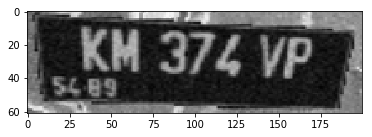

In [5]:
"""
Data Generator
"""

import cv2 as cv2
model_input_dim = (200, 61)
def image_resizer(im, dim):
    image = cv2.resize(im, dim, interpolation=cv2.INTER_LINEAR)
    return image

def generator(dataset, labels, batch_size):
    dataset = np.array(dataset)
    # Create container for features and labels
    batch_dataset = np.zeros((batch_size, 61, 200, 3))
    batch_labels = np.zeros((batch_size, 191))
    
    while True:
        for i in range(batch_size):
            ii = np.random.choice(len(dataset), 1)[0]
            batch_dataset[i] = image_resizer(dataset[ii], (200, 61))
            batch_labels[i] = labels[ii]
        yield batch_dataset, batch_labels 
        

# Testing generator
train_generator = generator(train_dataset, train_labels, 10)
batch_train_dataset, batch_train_labels = next(train_generator)

select = 1 
plt.imshow(np.array(batch_train_dataset[select]).astype(np.uint8))
# Check S1
print('s1 : ', str(logits_decoder(batch_train_labels[select])[0]))
print(str(batch_train_labels[select, label_helper['m_s1']]))
print(str(batch_train_labels[select, label_helper['s1_1']]))
print(str(batch_train_labels[select, label_helper['s1_2']]))

# Check S2
print('s2 : ', str(logits_decoder(batch_train_labels[select])[1]))
print(str(batch_train_labels[select, label_helper['m_s2']]))
print(str(batch_train_labels[select, label_helper['s2_1']]))
print(str(batch_train_labels[select, label_helper['s2_2']]))
print(str(batch_train_labels[select, label_helper['s2_3']]))
print(str(batch_train_labels[select, label_helper['s2_4']]))

# Check S3
print('s3 : ', str(logits_decoder(batch_train_labels[select])[2]))
print(str(batch_train_labels[select, label_helper['m_s3']]))
print(str(batch_train_labels[select, label_helper['s3_1']]))
print(str(batch_train_labels[select, label_helper['s3_2']]))
print(str(batch_train_labels[select, label_helper['s3_3']]))


In [7]:
"""
Model Architecture
"""
from keras import applications
from keras.layers import *
from keras.models import Model
from keras.regularizers import *

base_model = applications.mobilenet_v2.MobileNetV2(include_top=False, weights=None, input_shape=(61, 200, 3),
                                                    pooling=None)

#  S1
s1_input = Conv2D(name='s1_input', bias_regularizer=l2(0.001), filters=512, kernel_size=(3, 3), padding='same')(base_model.layers[-1].output)
s1_conv = Conv2D(name='s1_conv', filters=256, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_input)

s1_0_conv = Conv2D(name='s1_0_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s1_0_flatten = Flatten()(s1_0_conv)
s1_0_drop1 = Dropout(0.4)(s1_0_flatten)
s1_0_dense = Dense(name='s1_0_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s1_0_drop1)
s1_0_drop2 = Dropout(0.4)(s1_0_dense)
s1_0 = Dense(name='s1_0_softmax', units=3, bias_regularizer=l2(0.001), activation='softmax')(s1_0_drop2)

s1_1_conv = Conv2D(name='s1_1_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s1_1_flatten = Flatten()(s1_1_conv)
s1_1_drop1 = Dropout(0.4)(s1_1_flatten)
s1_1_dense = Dense(name='s1_1_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s1_1_drop1)
s1_1_drop2 = Dropout(0.4)(s1_1_dense)
s1_1 = Dense(name='s1_1_softmax', units=27, bias_regularizer=l2(0.001), activation='softmax')(s1_1_drop2)

s1_2_conv = Conv2D(name='s1_2_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s1_2_flatten = Flatten()(s1_2_conv)
s1_2_drop1 = Dropout(0.4)(s1_2_flatten)
s1_2_dense = Dense(name='s1_2_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s1_2_drop1)
s1_2_drop2 = Dropout(0.4)(s1_2_dense)
s1_2 = Dense(name='s1_2_softmax', units=27, bias_regularizer=l2(0.001), activation='softmax')(s1_2_drop2)

s1_output = Concatenate()([s1_0, s1_1, s1_2])

#  S2
s2_input = Conv2D(name='s2_input', filters=512, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(base_model.layers[-1].output)
s2_conv = Conv2D(name='s2_conv', filters=256, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_input)

s2_0_conv = Conv2D(name='s2_0_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_conv)
s2_0_flatten = Flatten()(s2_0_conv)
s2_0_drop1 = Dropout(0.4)(s2_0_flatten)
s2_0_dense = Dense(name='s2_0_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s2_0_drop1)
s2_0_drop2 = Dropout(0.4)(s2_0_dense)
s2_0 = Dense(name='s2_0_softmax', units=5, bias_regularizer=l2(0.001), activation='softmax')(s2_0_drop2)

s2_1_conv = Conv2D(name='s2_1_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_conv)
s2_1_flatten = Flatten()(s2_1_conv)
s2_1_drop1 = Dropout(0.4)(s2_1_flatten)
s2_1_dense = Dense(name='s2_1_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s2_1_drop1)
s2_1_drop2 = Dropout(0.4)(s2_1_dense)
s2_1 = Dense(name='s2_1_softmax', units=11, bias_regularizer=l2(0.001), activation='softmax')(s2_1_drop2)

s2_2_conv = Conv2D(name='s2_2_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_conv)
s2_2_flatten = Flatten()(s2_2_conv)
s2_2_drop1 = Dropout(0.4)(s2_2_flatten)
s2_2_dense = Dense(name='s2_2_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s2_2_drop1)
s2_2_drop2 = Dropout(0.4)(s2_2_dense)
s2_2 = Dense(name='s2_2_softmax', units=11, bias_regularizer=l2(0.001), activation='softmax')(s2_2_drop2)

s2_3_conv = Conv2D(name='s2_3_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_conv)
s2_3_flatten = Flatten()(s2_3_conv)
s2_3_drop1 = Dropout(0.4)(s2_3_flatten)
s2_3_dense = Dense(name='s2_3_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s2_3_drop1)
s2_3_drop2 = Dropout(0.4)(s2_3_dense)
s2_3 = Dense(name='s2_3_softmax', units=11, bias_regularizer=l2(0.001), activation='softmax')(s2_3_drop2)

s2_4_conv = Conv2D(name='s2_4_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s2_conv)
s2_4_flatten = Flatten()(s2_4_conv)
s2_4_drop1 = Dropout(0.4)(s2_4_flatten)
s2_4_dense = Dense(name='s2_4_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s2_4_drop1)
s2_4_drop2 = Dropout(0.4)(s2_4_dense)
s2_4 = Dense(name='s2_4_softmax', units=11, bias_regularizer=l2(0.001), activation='softmax')(s2_4_drop2)

s2_output = Concatenate()([s2_0, s2_1, s2_2, s2_3, s2_4])

#  S3
s3_input = Conv2D(name='s3_input', filters=512, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(base_model.layers[-1].output)
s3_conv = Conv2D(name='s3_conv', filters=256, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s3_input)

s3_0_conv = Conv2D(name='s3_0_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s3_0_flatten = Flatten()(s3_0_conv)
s3_0_drop1 = Dropout(0.4)(s3_0_flatten)
s3_0_dense = Dense(name='s3_0_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s3_0_drop1)
s3_0_drop2 = Dropout(0.4)(s3_0_dense)
s3_0 = Dense(name='s3_0_softmax', units=4, bias_regularizer=l2(0.001), activation='softmax')(s3_0_drop2)

s3_1_conv = Conv2D(name='s3_1_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s3_1_flatten = Flatten()(s3_1_conv)
s3_1_drop1 = Dropout(0.4)(s3_1_flatten)
s3_1_dense = Dense(name='s3_1_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s3_1_drop1)
s3_1_drop2 = Dropout(0.4)(s3_1_dense)
s3_1 = Dense(name='s3_1_softmax', units=27, bias_regularizer=l2(0.001), activation='softmax')(s3_1_drop2)

s3_2_conv = Conv2D(name='s3_2_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s3_2_flatten = Flatten()(s3_2_conv)
s3_2_drop1 = Dropout(0.4)(s3_2_flatten)
s3_2_dense = Dense(name='s3_2_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s3_2_drop1)
s3_2_drop2 = Dropout(0.4)(s3_2_dense)
s3_2 = Dense(name='s3_2_softmax', units=27, bias_regularizer=l2(0.001), activation='softmax')(s3_2_drop2)

s3_3_conv = Conv2D(name='s3_3_conv', filters=128, bias_regularizer=l2(0.001), kernel_size=(3, 3), padding='same')(s1_conv)
s3_3_flatten = Flatten()(s3_3_conv)
s3_3_drop1 = Dropout(0.4)(s3_3_flatten)
s3_3_dense = Dense(name='s3_3_relu', units=256, bias_regularizer=l2(0.001), activation='relu')(s3_3_drop1)
s3_3_drop2 = Dropout(0.4)(s3_3_dense)
s3_3 = Dense(name='s3_3_softmax', units=27, bias_regularizer=l2(0.001), activation='softmax')(s3_3_drop2)

s3_output = Concatenate()([s3_0, s3_1, s3_2, s3_3])

output = Concatenate()([s1_output, s2_output, s3_output])
new_model = Model(inputs=base_model.layers[0].output, output=output)
plot_model(new_model, show_shapes=True, to_file=os.path.join(dataset_dir, 'modelz3.jpg'))

json_model = new_model.to_json()
import json
with open(os.path.join(dataset_dir, 'modelz3.json'), 'w') as f:
    f.write(json_model)
f.close()
print('model z3 ready')


/home/satya/anaconda3/envs/skripsi/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


model z3 ready


In [9]:
"""
Define all the callbacks
"""

from keras.callbacks import *
checkpoint_filename = 'extractorz3_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=os.path.join(dataset_dir, checkpoint_filename),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
logger_filename = 'extractorz3_training_log.csv'
csv_logger = CSVLogger(filename=os.path.join(dataset_dir, logger_filename),
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

def telegram_notify(epoch, logs):
    root = 'https://api.telegram.org'
    path = '/bot667052156:AAFRQdHUTHVIQRc2s3lQNdh2PaZnVp38PyE/sendMessage'
    try:
        requests.post(root+path, json={'chat_id': '@satya24_skripsi', 'text': 'model Z3. Epoch: ' + str(epoch) + ' => ' + str(logs)})
    except Exception as e:
        print('Connection Error...')
        pass

remote_monitor = LambdaCallback(
    on_epoch_end = lambda epoch, logs:
        telegram_notify(epoch, logs)
)
callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate,
             remote_monitor]


In [11]:
"""
Plate Loss function
"""

from keras import backend as K

def plate_loss(y_true, y_pred):
    loss_s1_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s1']], y_pred[:, label_helper['m_s1']]))
    loss_s1_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s1_1']], y_pred[:, label_helper['s1_1']]))
    loss_s1_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s1_2']], y_pred[:, label_helper['s1_2']]))
    
    loss_s2_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s2']], y_pred[:, label_helper['m_s2']]))
    loss_s2_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_1']], y_pred[:, label_helper['s2_1']]))
    loss_s2_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_2']], y_pred[:, label_helper['s2_2']]))
    loss_s2_3 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_3']], y_pred[:, label_helper['s2_3']]))
    loss_s2_4 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_4']], y_pred[:, label_helper['s2_4']]))
    
    loss_s3_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s3']], y_pred[:, label_helper['m_s3']]))
    loss_s3_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_1']], y_pred[:, label_helper['s3_1']]))
    loss_s3_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_2']], y_pred[:, label_helper['s3_2']]))
    loss_s3_3 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_3']], y_pred[:, label_helper['s3_3']]))
    
    loss_s1 = loss_s1_0 + loss_s1_1 + loss_s1_2
    loss_s2 = loss_s2_0 + loss_s2_1 + loss_s2_2 + loss_s2_3 + loss_s2_4
    loss_s3 = loss_s3_0 + loss_s3_1 + loss_s3_2 + loss_s3_3
    return loss_s1 + loss_s2 + loss_s3

def number_loss(y_true, y_pred):
    loss_s2_0 = K.mean(K.categorical_crossentropy(y_true[:, 0:5], y_pred[:, 0:5]))
    loss_s2_1 = K.mean(K.categorical_crossentropy(y_true[:, 5:16], y_pred[:, 5:16]))
    loss_s2_2 = K.mean(K.categorical_crossentropy(y_true[:, 16:27], y_pred[:, 16:27]))
    loss_s2_3 = K.mean(K.categorical_crossentropy(y_true[:, 27:38], y_pred[:, 27:38]))
    loss_s2_4 = K.mean(K.categorical_crossentropy(y_true[:, 38:49], y_pred[:, 38:49]))
    return loss_s2_0 + loss_s2_1 + loss_s2_2 + loss_s2_3 + loss_s2_4


In [17]:
from keras.optimizers import *
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.8)
new_model.compile(optimizer=adam, loss=plate_loss)

In [18]:
initial_epoch = 0
final_epoch = 100
steps_per_epoch = 2000
train_generator = generator(train_dataset, train_labels, 5)
val_generator = generator(valid_dataset, valid_labels, 5)
history = new_model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch, 
                                  epochs=final_epoch, 
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=400,
                                  initial_epoch=initial_epoch
                                  )


Epoch 1/100


   1/2000 [..............................] - ETA: 8:04:30 - loss: 93.4915

   2/2000 [..............................] - ETA: 4:10:18 - loss: 112.8332

   3/2000 [..............................] - ETA: 2:51:28 - loss: 120.3549

   4/2000 [..............................] - ETA: 2:12:00 - loss: 113.6389

   5/2000 [..............................] - ETA: 1:48:22 - loss: 118.6354

   6/2000 [..............................] - ETA: 1:32:46 - loss: 119.2801

   7/2000 [..............................] - ETA: 1:21:35 - loss: 122.0431

   8/2000 [..............................] - ETA: 1:13:09 - loss: 123.7124

   9/2000 [..............................] - ETA: 1:06:37 - loss: 123.2198

  10/2000 [..............................] - ETA: 1:01:25 - loss: 118.3127

  11/2000 [..............................] - ETA: 57:17 - loss: 116.9352  

  12/2000 [..............................] - ETA: 53:41 - loss: 116.0560

  13/2000 [..............................] - ETA: 50:48 - loss: 116.5519

  14/2000 [..............................] - ETA: 48:12 - loss: 117.8979

  15/2000 [..............................] - ETA: 45:58 - loss: 117.9900

  16/2000 [..............................] - ETA: 43:58 - loss: 118.2720

  17/2000 [..............................] - ETA: 42:10 - loss: 119.2793

  18/2000 [..............................] - ETA: 40:39 - loss: 119.8165

  19/2000 [..............................] - ETA: 39:15 - loss: 119.6185

  20/2000 [..............................] - ETA: 38:02 - loss: 120.7297

  21/2000 [..............................] - ETA: 36:59 - loss: 119.5861

  22/2000 [..............................] - ETA: 35:57 - loss: 118.9860

  23/2000 [..............................] - ETA: 34:59 - loss: 119.4191

  24/2000 [..............................] - ETA: 34:07 - loss: 118.2044

  25/2000 [..............................] - ETA: 33:18 - loss: 117.0868

  26/2000 [..............................] - ETA: 32:32 - loss: 117.5430

  27/2000 [..............................] - ETA: 31:52 - loss: 117.9654

  28/2000 [..............................] - ETA: 31:18 - loss: 118.2426

  29/2000 [..............................] - ETA: 30:47 - loss: 116.0551

  30/2000 [..............................] - ETA: 30:16 - loss: 116.5923

  31/2000 [..............................] - ETA: 29:48 - loss: 116.6789

  32/2000 [..............................] - ETA: 29:22 - loss: 115.1483

  33/2000 [..............................] - ETA: 28:56 - loss: 114.4919

  34/2000 [..............................] - ETA: 28:29 - loss: 113.4001

  35/2000 [..............................] - ETA: 28:04 - loss: 113.8443

  36/2000 [..............................] - ETA: 27:41 - loss: 113.5475

  37/2000 [..............................] - ETA: 27:19 - loss: 113.8766

  38/2000 [..............................] - ETA: 26:59 - loss: 114.1036

  39/2000 [..............................] - ETA: 26:39 - loss: 114.2362

  40/2000 [..............................] - ETA: 26:20 - loss: 115.0069

  41/2000 [..............................] - ETA: 26:01 - loss: 114.0103

  42/2000 [..............................] - ETA: 25:44 - loss: 113.9055

  43/2000 [..............................] - ETA: 25:27 - loss: 114.0304

  44/2000 [..............................] - ETA: 25:11 - loss: 113.2705

  45/2000 [..............................] - ETA: 24:56 - loss: 114.5501

  46/2000 [..............................] - ETA: 24:42 - loss: 115.0033

  47/2000 [..............................] - ETA: 24:28 - loss: 115.0942

  48/2000 [..............................] - ETA: 24:14 - loss: 115.0470

  49/2000 [..............................] - ETA: 24:02 - loss: 115.5280

  50/2000 [..............................] - ETA: 23:49 - loss: 115.7320

  51/2000 [..............................] - ETA: 23:38 - loss: 116.2439

  52/2000 [..............................] - ETA: 23:27 - loss: 116.3022

  53/2000 [..............................] - ETA: 23:15 - loss: 115.5068

  54/2000 [..............................] - ETA: 23:05 - loss: 115.0991

  55/2000 [..............................] - ETA: 22:55 - loss: 114.7647

  56/2000 [..............................] - ETA: 22:45 - loss: 115.0756

  57/2000 [..............................] - ETA: 22:35 - loss: 115.0927

  58/2000 [..............................] - ETA: 22:28 - loss: 114.7758

  59/2000 [..............................] - ETA: 22:20 - loss: 114.8521

  60/2000 [..............................] - ETA: 22:13 - loss: 114.8721

  61/2000 [..............................] - ETA: 22:06 - loss: 114.2044

  62/2000 [..............................] - ETA: 21:58 - loss: 113.5583

  63/2000 [..............................] - ETA: 21:50 - loss: 112.9839

  64/2000 [..............................] - ETA: 21:41 - loss: 112.3770

  65/2000 [..............................] - ETA: 21:34 - loss: 111.7393

  66/2000 [..............................] - ETA: 21:26 - loss: 111.9511

  67/2000 [>.............................] - ETA: 21:19 - loss: 112.3492

  68/2000 [>.............................] - ETA: 21:12 - loss: 112.5458

  69/2000 [>.............................] - ETA: 21:05 - loss: 112.2229

  70/2000 [>.............................] - ETA: 20:58 - loss: 112.0013

  71/2000 [>.............................] - ETA: 20:52 - loss: 111.7859

  72/2000 [>.............................] - ETA: 20:45 - loss: 112.2034

  73/2000 [>.............................] - ETA: 20:39 - loss: 112.6535

  74/2000 [>.............................] - ETA: 20:33 - loss: 112.2203

  75/2000 [>.............................] - ETA: 20:28 - loss: 112.1854

  76/2000 [>.............................] - ETA: 20:23 - loss: 112.4060

  77/2000 [>.............................] - ETA: 20:18 - loss: 112.1603

  78/2000 [>.............................] - ETA: 20:14 - loss: 112.0449

  79/2000 [>.............................] - ETA: 20:09 - loss: 111.6467

  80/2000 [>.............................] - ETA: 20:04 - loss: 112.0242

  81/2000 [>.............................] - ETA: 20:00 - loss: 112.1933

  82/2000 [>.............................] - ETA: 19:56 - loss: 112.0045

  83/2000 [>.............................] - ETA: 19:51 - loss: 111.8590

  84/2000 [>.............................] - ETA: 19:47 - loss: 111.6403

  85/2000 [>.............................] - ETA: 19:43 - loss: 112.0336

  86/2000 [>.............................] - ETA: 19:39 - loss: 111.8554

  87/2000 [>.............................] - ETA: 19:35 - loss: 111.7554

  88/2000 [>.............................] - ETA: 19:31 - loss: 111.8775

  89/2000 [>.............................] - ETA: 19:28 - loss: 111.7795

  90/2000 [>.............................] - ETA: 19:25 - loss: 111.6121

  91/2000 [>.............................] - ETA: 19:21 - loss: 111.4129

  92/2000 [>.............................] - ETA: 19:18 - loss: 111.1480

  93/2000 [>.............................] - ETA: 19:15 - loss: 110.7501

  94/2000 [>.............................] - ETA: 19:12 - loss: 110.9094

  95/2000 [>.............................] - ETA: 19:09 - loss: 110.6921

  96/2000 [>.............................] - ETA: 19:06 - loss: 111.0501

  97/2000 [>.............................] - ETA: 19:03 - loss: 111.0685

  98/2000 [>.............................] - ETA: 19:00 - loss: 111.1522

  99/2000 [>.............................] - ETA: 18:57 - loss: 111.3645

 100/2000 [>.............................] - ETA: 18:55 - loss: 111.5403

 101/2000 [>.............................] - ETA: 18:52 - loss: 111.4573

 102/2000 [>.............................] - ETA: 18:49 - loss: 111.8500

 103/2000 [>.............................] - ETA: 18:46 - loss: 111.8595

 104/2000 [>.............................] - ETA: 18:44 - loss: 112.0548

 105/2000 [>.............................] - ETA: 18:41 - loss: 112.2157

 106/2000 [>.............................] - ETA: 18:38 - loss: 112.5864

 107/2000 [>.............................] - ETA: 18:35 - loss: 112.6489

 108/2000 [>.............................] - ETA: 18:32 - loss: 112.4715

 109/2000 [>.............................] - ETA: 18:30 - loss: 112.8297

 110/2000 [>.............................] - ETA: 18:28 - loss: 112.9469

 111/2000 [>.............................] - ETA: 18:26 - loss: 112.5392

 112/2000 [>.............................] - ETA: 18:23 - loss: 112.1389

 113/2000 [>.............................] - ETA: 18:20 - loss: 112.1450

 114/2000 [>.............................] - ETA: 18:18 - loss: 111.8682

 115/2000 [>.............................] - ETA: 18:16 - loss: 112.1849

 116/2000 [>.............................] - ETA: 18:13 - loss: 112.3294

 117/2000 [>.............................] - ETA: 18:11 - loss: 112.3612

 118/2000 [>.............................] - ETA: 18:09 - loss: 112.0920

 119/2000 [>.............................] - ETA: 18:07 - loss: 111.8544

 120/2000 [>.............................] - ETA: 18:04 - loss: 112.0237

 121/2000 [>.............................] - ETA: 18:02 - loss: 111.9237

 122/2000 [>.............................] - ETA: 18:00 - loss: 111.9576

 123/2000 [>.............................] - ETA: 17:59 - loss: 111.9122

 124/2000 [>.............................] - ETA: 17:57 - loss: 112.0496

 125/2000 [>.............................] - ETA: 17:55 - loss: 112.4169

 126/2000 [>.............................] - ETA: 17:52 - loss: 112.7783

 127/2000 [>.............................] - ETA: 17:50 - loss: 112.4487

 128/2000 [>.............................] - ETA: 17:49 - loss: 112.2502

 129/2000 [>.............................] - ETA: 17:47 - loss: 112.2297

 130/2000 [>.............................] - ETA: 17:44 - loss: 112.0608

 131/2000 [>.............................] - ETA: 17:42 - loss: 112.2881

 132/2000 [>.............................] - ETA: 17:39 - loss: 112.0235

 133/2000 [>.............................] - ETA: 17:37 - loss: 112.1023

 134/2000 [=>............................] - ETA: 17:35 - loss: 112.2521

 135/2000 [=>............................] - ETA: 17:33 - loss: 112.1131

 136/2000 [=>............................] - ETA: 17:31 - loss: 112.1420

 137/2000 [=>............................] - ETA: 17:28 - loss: 111.9588

 138/2000 [=>............................] - ETA: 17:26 - loss: 111.9184

 139/2000 [=>............................] - ETA: 17:24 - loss: 111.8785

 140/2000 [=>............................] - ETA: 17:23 - loss: 111.5860

 141/2000 [=>............................] - ETA: 17:21 - loss: 111.8006

 142/2000 [=>............................] - ETA: 17:19 - loss: 111.7851

 143/2000 [=>............................] - ETA: 17:17 - loss: 111.4993

 144/2000 [=>............................] - ETA: 17:15 - loss: 111.3966

 145/2000 [=>............................] - ETA: 17:14 - loss: 111.4732

 146/2000 [=>............................] - ETA: 17:12 - loss: 111.5708

 147/2000 [=>............................] - ETA: 17:11 - loss: 111.5355

 148/2000 [=>............................] - ETA: 17:09 - loss: 111.3482

 149/2000 [=>............................] - ETA: 17:07 - loss: 111.4230

 150/2000 [=>............................] - ETA: 17:05 - loss: 111.2820

 151/2000 [=>............................] - ETA: 17:03 - loss: 111.3562

 152/2000 [=>............................] - ETA: 17:01 - loss: 111.3023

 153/2000 [=>............................] - ETA: 16:59 - loss: 111.1859

 154/2000 [=>............................] - ETA: 16:57 - loss: 111.3012

 155/2000 [=>............................] - ETA: 16:55 - loss: 111.2071

 156/2000 [=>............................] - ETA: 16:54 - loss: 111.2794

 157/2000 [=>............................] - ETA: 16:52 - loss: 111.1866

 158/2000 [=>............................] - ETA: 16:50 - loss: 110.9930

 159/2000 [=>............................] - ETA: 16:48 - loss: 110.9234

 160/2000 [=>............................] - ETA: 16:46 - loss: 110.7742

 161/2000 [=>............................] - ETA: 16:45 - loss: 110.8470

 162/2000 [=>............................] - ETA: 16:43 - loss: 110.7199

 163/2000 [=>............................] - ETA: 16:41 - loss: 110.6340

 164/2000 [=>............................] - ETA: 16:39 - loss: 110.8439

 165/2000 [=>............................] - ETA: 16:38 - loss: 110.7778

 166/2000 [=>............................] - ETA: 16:37 - loss: 110.6931

 167/2000 [=>............................] - ETA: 16:35 - loss: 110.4935

 168/2000 [=>............................] - ETA: 16:34 - loss: 110.4690

 169/2000 [=>............................] - ETA: 16:33 - loss: 110.5593

 170/2000 [=>............................] - ETA: 16:31 - loss: 110.8571

 171/2000 [=>............................] - ETA: 16:29 - loss: 110.8874

 172/2000 [=>............................] - ETA: 16:28 - loss: 110.6738

 173/2000 [=>............................] - ETA: 16:26 - loss: 110.7422

 174/2000 [=>............................] - ETA: 16:25 - loss: 110.6615

 175/2000 [=>............................] - ETA: 16:24 - loss: 110.7108

 176/2000 [=>............................] - ETA: 16:22 - loss: 110.6129

 177/2000 [=>............................] - ETA: 16:20 - loss: 110.6072

 178/2000 [=>............................] - ETA: 16:19 - loss: 110.4386

 179/2000 [=>............................] - ETA: 16:17 - loss: 110.5780

 180/2000 [=>............................] - ETA: 16:16 - loss: 110.6621

 181/2000 [=>............................] - ETA: 16:14 - loss: 110.4960

 182/2000 [=>............................] - ETA: 16:13 - loss: 110.5442

 183/2000 [=>............................] - ETA: 16:12 - loss: 110.5215

 184/2000 [=>............................] - ETA: 16:11 - loss: 110.2712

 185/2000 [=>............................] - ETA: 16:10 - loss: 110.1805

 186/2000 [=>............................] - ETA: 16:08 - loss: 110.1774

 187/2000 [=>............................] - ETA: 16:07 - loss: 110.0881

 188/2000 [=>............................] - ETA: 16:06 - loss: 110.1027

 189/2000 [=>............................] - ETA: 16:04 - loss: 109.9807

 190/2000 [=>............................] - ETA: 16:03 - loss: 110.0974

 191/2000 [=>............................] - ETA: 16:02 - loss: 109.8079

 192/2000 [=>............................] - ETA: 16:01 - loss: 109.8237

 193/2000 [=>............................] - ETA: 15:59 - loss: 109.7056

 194/2000 [=>............................] - ETA: 15:58 - loss: 109.5888

 195/2000 [=>............................] - ETA: 15:57 - loss: 109.6550

 196/2000 [=>............................] - ETA: 15:56 - loss: 109.7205

 197/2000 [=>............................] - ETA: 15:55 - loss: 109.6054

 198/2000 [=>............................] - ETA: 15:53 - loss: 109.6868

 199/2000 [=>............................] - ETA: 15:52 - loss: 109.7026

 200/2000 [==>...........................] - ETA: 15:51 - loss: 109.8310

 201/2000 [==>...........................] - ETA: 15:50 - loss: 109.5733

 202/2000 [==>...........................] - ETA: 15:49 - loss: 109.5096

 203/2000 [==>...........................] - ETA: 15:47 - loss: 109.5895

 204/2000 [==>...........................] - ETA: 15:46 - loss: 109.5579

 205/2000 [==>...........................] - ETA: 15:45 - loss: 109.4481

 206/2000 [==>...........................] - ETA: 15:43 - loss: 109.3863

 207/2000 [==>...........................] - ETA: 15:42 - loss: 109.4185

 208/2000 [==>...........................] - ETA: 15:41 - loss: 109.4968

 209/2000 [==>...........................] - ETA: 15:39 - loss: 109.6670

 210/2000 [==>...........................] - ETA: 15:38 - loss: 109.8049

 211/2000 [==>...........................] - ETA: 15:37 - loss: 109.7275

 212/2000 [==>...........................] - ETA: 15:36 - loss: 109.5293

 213/2000 [==>...........................] - ETA: 15:34 - loss: 109.3783

 214/2000 [==>...........................] - ETA: 15:34 - loss: 109.3793

 215/2000 [==>...........................] - ETA: 15:32 - loss: 109.4404

 216/2000 [==>...........................] - ETA: 15:31 - loss: 109.3516

 217/2000 [==>...........................] - ETA: 15:30 - loss: 109.1893

 218/2000 [==>...........................] - ETA: 15:29 - loss: 109.2504

 219/2000 [==>...........................] - ETA: 15:27 - loss: 109.1931

 220/2000 [==>...........................] - ETA: 15:26 - loss: 109.0778

 221/2000 [==>...........................] - ETA: 15:25 - loss: 109.0072

 222/2000 [==>...........................] - ETA: 15:24 - loss: 108.9954

 223/2000 [==>...........................] - ETA: 15:23 - loss: 108.8825

 224/2000 [==>...........................] - ETA: 15:22 - loss: 108.9864

 225/2000 [==>...........................] - ETA: 15:21 - loss: 109.0895

 226/2000 [==>...........................] - ETA: 15:20 - loss: 109.1916

 227/2000 [==>...........................] - ETA: 15:19 - loss: 109.1082

 228/2000 [==>...........................] - ETA: 15:18 - loss: 109.1669

 229/2000 [==>...........................] - ETA: 15:17 - loss: 109.0985

 230/2000 [==>...........................] - ETA: 15:16 - loss: 109.0025

 231/2000 [==>...........................] - ETA: 15:15 - loss: 109.1726

 232/2000 [==>...........................] - ETA: 15:14 - loss: 109.0911

 233/2000 [==>...........................] - ETA: 15:13 - loss: 109.1210

 234/2000 [==>...........................] - ETA: 15:12 - loss: 109.1093

 235/2000 [==>...........................] - ETA: 15:11 - loss: 109.3309

 236/2000 [==>...........................] - ETA: 15:10 - loss: 109.3730

 237/2000 [==>...........................] - ETA: 15:09 - loss: 109.2107

 238/2000 [==>...........................] - ETA: 15:09 - loss: 109.1582

 239/2000 [==>...........................] - ETA: 15:08 - loss: 109.0252

 240/2000 [==>...........................] - ETA: 15:07 - loss: 109.1485

 241/2000 [==>...........................] - ETA: 15:06 - loss: 109.2842

 242/2000 [==>...........................] - ETA: 15:05 - loss: 109.3654

 243/2000 [==>...........................] - ETA: 15:04 - loss: 109.3399

 244/2000 [==>...........................] - ETA: 15:03 - loss: 109.3013

 245/2000 [==>...........................] - ETA: 15:02 - loss: 109.3289

 246/2000 [==>...........................] - ETA: 15:01 - loss: 109.3955

 247/2000 [==>...........................] - ETA: 15:00 - loss: 109.3311

 248/2000 [==>...........................] - ETA: 15:00 - loss: 109.2542

 249/2000 [==>...........................] - ETA: 14:59 - loss: 109.3203

 250/2000 [==>...........................] - ETA: 14:58 - loss: 109.2828

 251/2000 [==>...........................] - ETA: 14:57 - loss: 109.2455

 252/2000 [==>...........................] - ETA: 14:56 - loss: 109.3365

 253/2000 [==>...........................] - ETA: 14:55 - loss: 109.2484

 254/2000 [==>...........................] - ETA: 14:54 - loss: 109.2878

 255/2000 [==>...........................] - ETA: 14:53 - loss: 109.2891

 256/2000 [==>...........................] - ETA: 14:52 - loss: 109.3155

 257/2000 [==>...........................] - ETA: 14:51 - loss: 109.4170

 258/2000 [==>...........................] - ETA: 14:51 - loss: 109.3802

 259/2000 [==>...........................] - ETA: 14:50 - loss: 109.2815

 260/2000 [==>...........................] - ETA: 14:50 - loss: 109.2827

 261/2000 [==>...........................] - ETA: 14:49 - loss: 109.3334

 262/2000 [==>...........................] - ETA: 14:49 - loss: 109.2360

 263/2000 [==>...........................] - ETA: 14:48 - loss: 109.2864

 264/2000 [==>...........................] - ETA: 14:47 - loss: 109.3242

 265/2000 [==>...........................] - ETA: 14:47 - loss: 109.3618

 266/2000 [==>...........................] - ETA: 14:46 - loss: 109.2900

 267/2000 [===>..........................] - ETA: 14:45 - loss: 109.3757

 268/2000 [===>..........................] - ETA: 14:44 - loss: 109.4006

 269/2000 [===>..........................] - ETA: 14:43 - loss: 109.3654

 270/2000 [===>..........................] - ETA: 14:42 - loss: 109.4379

 271/2000 [===>..........................] - ETA: 14:41 - loss: 109.5099

 272/2000 [===>..........................] - ETA: 14:40 - loss: 109.5814

 273/2000 [===>..........................] - ETA: 14:39 - loss: 109.5106

 274/2000 [===>..........................] - ETA: 14:38 - loss: 109.4403

 275/2000 [===>..........................] - ETA: 14:37 - loss: 109.2182

 276/2000 [===>..........................] - ETA: 14:36 - loss: 109.1262

 277/2000 [===>..........................] - ETA: 14:35 - loss: 109.2094

 278/2000 [===>..........................] - ETA: 14:35 - loss: 109.3151

 279/2000 [===>..........................] - ETA: 14:34 - loss: 109.1775

 280/2000 [===>..........................] - ETA: 14:33 - loss: 109.1560

 281/2000 [===>..........................] - ETA: 14:32 - loss: 109.0773

 282/2000 [===>..........................] - ETA: 14:31 - loss: 108.9992

 283/2000 [===>..........................] - ETA: 14:31 - loss: 109.0924

 284/2000 [===>..........................] - ETA: 14:30 - loss: 109.0942

 285/2000 [===>..........................] - ETA: 14:29 - loss: 109.0734

 286/2000 [===>..........................] - ETA: 14:29 - loss: 109.0865

 287/2000 [===>..........................] - ETA: 14:28 - loss: 108.9760

 288/2000 [===>..........................] - ETA: 14:27 - loss: 108.9894

 289/2000 [===>..........................] - ETA: 14:27 - loss: 108.9803

 290/2000 [===>..........................] - ETA: 14:26 - loss: 109.1937

 291/2000 [===>..........................] - ETA: 14:25 - loss: 109.1840

 292/2000 [===>..........................] - ETA: 14:25 - loss: 109.1192

 293/2000 [===>..........................] - ETA: 14:24 - loss: 109.0219

 294/2000 [===>..........................] - ETA: 14:23 - loss: 109.0348

 295/2000 [===>..........................] - ETA: 14:22 - loss: 109.1132

 296/2000 [===>..........................] - ETA: 14:22 - loss: 109.2456

 297/2000 [===>..........................] - ETA: 14:21 - loss: 109.1708

 298/2000 [===>..........................] - ETA: 14:20 - loss: 109.0425

 299/2000 [===>..........................] - ETA: 14:20 - loss: 109.0982

 300/2000 [===>..........................] - ETA: 14:19 - loss: 109.0032

 301/2000 [===>..........................] - ETA: 14:18 - loss: 108.9838

 302/2000 [===>..........................] - ETA: 14:18 - loss: 108.9431

 303/2000 [===>..........................] - ETA: 14:17 - loss: 108.9347

 304/2000 [===>..........................] - ETA: 14:16 - loss: 109.0429

 305/2000 [===>..........................] - ETA: 14:16 - loss: 109.0870

 306/2000 [===>..........................] - ETA: 14:15 - loss: 108.9307

 307/2000 [===>..........................] - ETA: 14:14 - loss: 108.7964

 308/2000 [===>..........................] - ETA: 14:14 - loss: 108.8409

 309/2000 [===>..........................] - ETA: 14:13 - loss: 108.9686

 310/2000 [===>..........................] - ETA: 14:12 - loss: 109.0122

 311/2000 [===>..........................] - ETA: 14:12 - loss: 108.9415

 312/2000 [===>..........................] - ETA: 14:11 - loss: 109.0160

 313/2000 [===>..........................] - ETA: 14:10 - loss: 108.9252

 314/2000 [===>..........................] - ETA: 14:10 - loss: 108.8555

 315/2000 [===>..........................] - ETA: 14:09 - loss: 108.9295

 316/2000 [===>..........................] - ETA: 14:08 - loss: 108.9520

 317/2000 [===>..........................] - ETA: 14:08 - loss: 108.9541

 318/2000 [===>..........................] - ETA: 14:07 - loss: 108.9865

 319/2000 [===>..........................] - ETA: 14:06 - loss: 109.1097

 320/2000 [===>..........................] - ETA: 14:06 - loss: 109.0609

 321/2000 [===>..........................] - ETA: 14:05 - loss: 109.2132

 322/2000 [===>..........................] - ETA: 14:04 - loss: 109.2345

 323/2000 [===>..........................] - ETA: 14:04 - loss: 109.1458

 324/2000 [===>..........................] - ETA: 14:03 - loss: 109.1273

 325/2000 [===>..........................] - ETA: 14:03 - loss: 109.1685

 326/2000 [===>..........................] - ETA: 14:02 - loss: 109.2192

 327/2000 [===>..........................] - ETA: 14:02 - loss: 109.4471

 328/2000 [===>..........................] - ETA: 14:01 - loss: 109.4476

 329/2000 [===>..........................] - ETA: 14:00 - loss: 109.4873

 330/2000 [===>..........................] - ETA: 14:00 - loss: 109.5072

 331/2000 [===>..........................] - ETA: 13:59 - loss: 109.6341

 332/2000 [===>..........................] - ETA: 13:58 - loss: 109.5369

 333/2000 [===>..........................] - ETA: 13:57 - loss: 109.4016

 334/2000 [====>.........................] - ETA: 13:56 - loss: 109.3636

 335/2000 [====>.........................] - ETA: 13:56 - loss: 109.3258

 336/2000 [====>.........................] - ETA: 13:55 - loss: 109.2691

 337/2000 [====>.........................] - ETA: 13:54 - loss: 109.2222

 338/2000 [====>.........................] - ETA: 13:54 - loss: 109.1947

 339/2000 [====>.........................] - ETA: 13:53 - loss: 109.2150

 340/2000 [====>.........................] - ETA: 13:52 - loss: 109.3868

 341/2000 [====>.........................] - ETA: 13:51 - loss: 109.4252

 342/2000 [====>.........................] - ETA: 13:51 - loss: 109.3692

 343/2000 [====>.........................] - ETA: 13:50 - loss: 109.3887

 344/2000 [====>.........................] - ETA: 13:49 - loss: 109.4268

 345/2000 [====>.........................] - ETA: 13:48 - loss: 109.4460

 346/2000 [====>.........................] - ETA: 13:47 - loss: 109.4464

 347/2000 [====>.........................] - ETA: 13:46 - loss: 109.4562

 348/2000 [====>.........................] - ETA: 13:46 - loss: 109.3269

 349/2000 [====>.........................] - ETA: 13:45 - loss: 109.2815

 350/2000 [====>.........................] - ETA: 13:44 - loss: 109.3101

 351/2000 [====>.........................] - ETA: 13:43 - loss: 109.2742

 352/2000 [====>.........................] - ETA: 13:42 - loss: 109.2660

 353/2000 [====>.........................] - ETA: 13:42 - loss: 109.2943

 354/2000 [====>.........................] - ETA: 13:41 - loss: 109.2314

 355/2000 [====>.........................] - ETA: 13:40 - loss: 109.3415

 356/2000 [====>.........................] - ETA: 13:39 - loss: 109.3784

 357/2000 [====>.........................] - ETA: 13:39 - loss: 109.4423

 358/2000 [====>.........................] - ETA: 13:38 - loss: 109.3707

 359/2000 [====>.........................] - ETA: 13:37 - loss: 109.4162

 360/2000 [====>.........................] - ETA: 13:37 - loss: 109.4615

 361/2000 [====>.........................] - ETA: 13:36 - loss: 109.3905

 362/2000 [====>.........................] - ETA: 13:35 - loss: 109.3732

 363/2000 [====>.........................] - ETA: 13:35 - loss: 109.3472

 364/2000 [====>.........................] - ETA: 13:34 - loss: 109.3391

 365/2000 [====>.........................] - ETA: 13:33 - loss: 109.2250

 366/2000 [====>.........................] - ETA: 13:32 - loss: 109.2172

 367/2000 [====>.........................] - ETA: 13:32 - loss: 109.2446

 368/2000 [====>.........................] - ETA: 13:31 - loss: 109.3507

 369/2000 [====>.........................] - ETA: 13:30 - loss: 109.3514

 370/2000 [====>.........................] - ETA: 13:29 - loss: 109.2737

 371/2000 [====>.........................] - ETA: 13:28 - loss: 109.2485

 372/2000 [====>.........................] - ETA: 13:28 - loss: 109.4228

 373/2000 [====>.........................] - ETA: 13:27 - loss: 109.3973

 374/2000 [====>.........................] - ETA: 13:26 - loss: 109.4841

 375/2000 [====>.........................] - ETA: 13:25 - loss: 109.6133

 376/2000 [====>.........................] - ETA: 13:25 - loss: 109.5962

 377/2000 [====>.........................] - ETA: 13:24 - loss: 109.7501

 378/2000 [====>.........................] - ETA: 13:23 - loss: 109.7241

 379/2000 [====>.........................] - ETA: 13:22 - loss: 109.6983

 380/2000 [====>.........................] - ETA: 13:22 - loss: 109.7150

 381/2000 [====>.........................] - ETA: 13:21 - loss: 109.7063

 382/2000 [====>.........................] - ETA: 13:20 - loss: 109.7060

 383/2000 [====>.........................] - ETA: 13:19 - loss: 109.8404

 384/2000 [====>.........................] - ETA: 13:19 - loss: 109.8146

 385/2000 [====>.........................] - ETA: 13:18 - loss: 109.8140

 386/2000 [====>.........................] - ETA: 13:17 - loss: 109.7717

 387/2000 [====>.........................] - ETA: 13:17 - loss: 109.8213

 388/2000 [====>.........................] - ETA: 13:16 - loss: 109.7376

 389/2000 [====>.........................] - ETA: 13:15 - loss: 109.7373

 390/2000 [====>.........................] - ETA: 13:14 - loss: 109.7700

 391/2000 [====>.........................] - ETA: 13:14 - loss: 109.8438

 392/2000 [====>.........................] - ETA: 13:13 - loss: 109.7363

 393/2000 [====>.........................] - ETA: 13:12 - loss: 109.6949

 394/2000 [====>.........................] - ETA: 13:11 - loss: 109.7520

 395/2000 [====>.........................] - ETA: 13:11 - loss: 109.7598

 396/2000 [====>.........................] - ETA: 13:10 - loss: 109.7431

 397/2000 [====>.........................] - ETA: 13:09 - loss: 109.8726

 398/2000 [====>.........................] - ETA: 13:09 - loss: 109.7748

 399/2000 [====>.........................] - ETA: 13:08 - loss: 109.7582

 400/2000 [=====>........................] - ETA: 13:07 - loss: 109.8303

 401/2000 [=====>........................] - ETA: 13:06 - loss: 109.8056

 402/2000 [=====>........................] - ETA: 13:06 - loss: 109.8132

 403/2000 [=====>........................] - ETA: 13:05 - loss: 109.8366

 404/2000 [=====>........................] - ETA: 13:04 - loss: 109.7802

 405/2000 [=====>........................] - ETA: 13:04 - loss: 109.7718

 406/2000 [=====>........................] - ETA: 13:03 - loss: 109.8111

 407/2000 [=====>........................] - ETA: 13:02 - loss: 109.9928

 408/2000 [=====>........................] - ETA: 13:01 - loss: 109.9286

 409/2000 [=====>........................] - ETA: 13:01 - loss: 109.9672

 410/2000 [=====>........................] - ETA: 13:00 - loss: 109.9506

 411/2000 [=====>........................] - ETA: 13:00 - loss: 110.0047

 412/2000 [=====>........................] - ETA: 12:59 - loss: 109.9411

 413/2000 [=====>........................] - ETA: 12:59 - loss: 110.0417

 414/2000 [=====>........................] - ETA: 12:58 - loss: 109.9706

 415/2000 [=====>........................] - ETA: 12:58 - loss: 109.9464

 416/2000 [=====>........................] - ETA: 12:57 - loss: 109.9998

 417/2000 [=====>........................] - ETA: 12:56 - loss: 110.0453

 418/2000 [=====>........................] - ETA: 12:56 - loss: 109.9748

 419/2000 [=====>........................] - ETA: 12:55 - loss: 110.0355

 420/2000 [=====>........................] - ETA: 12:55 - loss: 110.0037

 421/2000 [=====>........................] - ETA: 12:54 - loss: 109.9722

 422/2000 [=====>........................] - ETA: 12:53 - loss: 109.9178

 423/2000 [=====>........................] - ETA: 12:53 - loss: 109.9399

 424/2000 [=====>........................] - ETA: 12:52 - loss: 109.8327

 425/2000 [=====>........................] - ETA: 12:52 - loss: 109.8246

 426/2000 [=====>........................] - ETA: 12:51 - loss: 109.8014

 427/2000 [=====>........................] - ETA: 12:50 - loss: 109.9292

 428/2000 [=====>........................] - ETA: 12:49 - loss: 109.9812

 429/2000 [=====>........................] - ETA: 12:49 - loss: 109.9728

 430/2000 [=====>........................] - ETA: 12:48 - loss: 109.9120

 431/2000 [=====>........................] - ETA: 12:47 - loss: 109.8963

 432/2000 [=====>........................] - ETA: 12:47 - loss: 109.9479

 433/2000 [=====>........................] - ETA: 12:46 - loss: 109.8875

 434/2000 [=====>........................] - ETA: 12:45 - loss: 109.8794

 435/2000 [=====>........................] - ETA: 12:45 - loss: 109.8417

 436/2000 [=====>........................] - ETA: 12:44 - loss: 109.8634

 437/2000 [=====>........................] - ETA: 12:44 - loss: 109.8923

 438/2000 [=====>........................] - ETA: 12:43 - loss: 109.8622

 439/2000 [=====>........................] - ETA: 12:42 - loss: 109.8543

 440/2000 [=====>........................] - ETA: 12:42 - loss: 109.8097

 441/2000 [=====>........................] - ETA: 12:41 - loss: 109.7581

 442/2000 [=====>........................] - ETA: 12:41 - loss: 109.7869

 443/2000 [=====>........................] - ETA: 12:40 - loss: 109.7719

 444/2000 [=====>........................] - ETA: 12:40 - loss: 109.7353

 445/2000 [=====>........................] - ETA: 12:39 - loss: 109.7567

 446/2000 [=====>........................] - ETA: 12:39 - loss: 109.7274

 447/2000 [=====>........................] - ETA: 12:39 - loss: 109.7416

 448/2000 [=====>........................] - ETA: 12:38 - loss: 109.7557

 449/2000 [=====>........................] - ETA: 12:37 - loss: 109.7194

 450/2000 [=====>........................] - ETA: 12:37 - loss: 109.8051

 451/2000 [=====>........................] - ETA: 12:36 - loss: 109.8547

 452/2000 [=====>........................] - ETA: 12:36 - loss: 109.8684

 453/2000 [=====>........................] - ETA: 12:36 - loss: 109.7753

 454/2000 [=====>........................] - ETA: 12:35 - loss: 109.7324

 455/2000 [=====>........................] - ETA: 12:34 - loss: 109.7888

 456/2000 [=====>........................] - ETA: 12:34 - loss: 109.7954

 457/2000 [=====>........................] - ETA: 12:33 - loss: 109.8797

 458/2000 [=====>........................] - ETA: 12:33 - loss: 109.9072

 459/2000 [=====>........................] - ETA: 12:32 - loss: 110.0400

 460/2000 [=====>........................] - ETA: 12:32 - loss: 110.0040

 461/2000 [=====>........................] - ETA: 12:31 - loss: 109.9402

 462/2000 [=====>........................] - ETA: 12:31 - loss: 109.9116

 463/2000 [=====>........................] - ETA: 12:30 - loss: 109.9318

 464/2000 [=====>........................] - ETA: 12:30 - loss: 109.9380

 465/2000 [=====>........................] - ETA: 12:29 - loss: 109.9373

 466/2000 [=====>........................] - ETA: 12:29 - loss: 109.9504

 467/2000 [======>.......................] - ETA: 12:28 - loss: 109.8875

 468/2000 [======>.......................] - ETA: 12:28 - loss: 109.9489

 469/2000 [======>.......................] - ETA: 12:27 - loss: 109.9963

 470/2000 [======>.......................] - ETA: 12:26 - loss: 110.0572

 471/2000 [======>.......................] - ETA: 12:26 - loss: 110.0836

 472/2000 [======>.......................] - ETA: 12:25 - loss: 110.0963

 473/2000 [======>.......................] - ETA: 12:24 - loss: 110.0952

 474/2000 [======>.......................] - ETA: 12:24 - loss: 110.1350

 475/2000 [======>.......................] - ETA: 12:23 - loss: 110.1203

 476/2000 [======>.......................] - ETA: 12:22 - loss: 110.1463

 477/2000 [======>.......................] - ETA: 12:22 - loss: 110.1249

 478/2000 [======>.......................] - ETA: 12:21 - loss: 110.1508

 479/2000 [======>.......................] - ETA: 12:21 - loss: 110.1429

 480/2000 [======>.......................] - ETA: 12:20 - loss: 110.1821

 481/2000 [======>.......................] - ETA: 12:19 - loss: 110.1340

 482/2000 [======>.......................] - ETA: 12:19 - loss: 110.1930

 483/2000 [======>.......................] - ETA: 12:18 - loss: 110.2519

 484/2000 [======>.......................] - ETA: 12:18 - loss: 110.2106

 485/2000 [======>.......................] - ETA: 12:17 - loss: 110.2426

 486/2000 [======>.......................] - ETA: 12:16 - loss: 110.2811

 487/2000 [======>.......................] - ETA: 12:16 - loss: 110.2664

 488/2000 [======>.......................] - ETA: 12:15 - loss: 110.2585

 489/2000 [======>.......................] - ETA: 12:14 - loss: 110.2967

 490/2000 [======>.......................] - ETA: 12:14 - loss: 110.3676

 491/2000 [======>.......................] - ETA: 12:13 - loss: 110.3595

 492/2000 [======>.......................] - ETA: 12:12 - loss: 110.3580

 493/2000 [======>.......................] - ETA: 12:12 - loss: 110.3107

 494/2000 [======>.......................] - ETA: 12:11 - loss: 110.2831

 495/2000 [======>.......................] - ETA: 12:11 - loss: 110.3273

 496/2000 [======>.......................] - ETA: 12:10 - loss: 110.2869

 497/2000 [======>.......................] - ETA: 12:09 - loss: 110.2725

 498/2000 [======>.......................] - ETA: 12:09 - loss: 110.3165

 499/2000 [======>.......................] - ETA: 12:08 - loss: 110.3603

 500/2000 [======>.......................] - ETA: 12:07 - loss: 110.3717

 501/2000 [======>.......................] - ETA: 12:07 - loss: 110.4088

 502/2000 [======>.......................] - ETA: 12:06 - loss: 110.4200

 503/2000 [======>.......................] - ETA: 12:06 - loss: 110.4184

 504/2000 [======>.......................] - ETA: 12:05 - loss: 110.3656

 505/2000 [======>.......................] - ETA: 12:05 - loss: 110.3066

 506/2000 [======>.......................] - ETA: 12:04 - loss: 110.3371

 507/2000 [======>.......................] - ETA: 12:04 - loss: 110.3929

 508/2000 [======>.......................] - ETA: 12:03 - loss: 110.3723

 509/2000 [======>.......................] - ETA: 12:03 - loss: 110.3708

 510/2000 [======>.......................] - ETA: 12:02 - loss: 110.3819

 511/2000 [======>.......................] - ETA: 12:02 - loss: 110.4056

 512/2000 [======>.......................] - ETA: 12:01 - loss: 110.3852

 513/2000 [======>.......................] - ETA: 12:00 - loss: 110.4088

 514/2000 [======>.......................] - ETA: 12:00 - loss: 110.3570

 515/2000 [======>.......................] - ETA: 11:59 - loss: 110.4557

 516/2000 [======>.......................] - ETA: 11:59 - loss: 110.4541

 517/2000 [======>.......................] - ETA: 11:58 - loss: 110.5273

 518/2000 [======>.......................] - ETA: 11:58 - loss: 110.5379

 519/2000 [======>.......................] - ETA: 11:57 - loss: 110.5858

 520/2000 [======>.......................] - ETA: 11:57 - loss: 110.6211

 521/2000 [======>.......................] - ETA: 11:56 - loss: 110.6625

 522/2000 [======>.......................] - ETA: 11:56 - loss: 110.6975

 523/2000 [======>.......................] - ETA: 11:55 - loss: 110.6214

 524/2000 [======>.......................] - ETA: 11:55 - loss: 110.5457

 525/2000 [======>.......................] - ETA: 11:55 - loss: 110.5930

 526/2000 [======>.......................] - ETA: 11:54 - loss: 110.5298

 527/2000 [======>.......................] - ETA: 11:54 - loss: 110.4853

 528/2000 [======>.......................] - ETA: 11:53 - loss: 110.4470

 529/2000 [======>.......................] - ETA: 11:53 - loss: 110.4819

 530/2000 [======>.......................] - ETA: 11:52 - loss: 110.5168

 531/2000 [======>.......................] - ETA: 11:52 - loss: 110.4604

 532/2000 [======>.......................] - ETA: 11:51 - loss: 110.4648

 533/2000 [======>.......................] - ETA: 11:51 - loss: 110.5116

 534/2000 [=======>......................] - ETA: 11:50 - loss: 110.4495

 535/2000 [=======>......................] - ETA: 11:50 - loss: 110.4058

 536/2000 [=======>......................] - ETA: 11:49 - loss: 110.3862

 537/2000 [=======>......................] - ETA: 11:49 - loss: 110.3248

 538/2000 [=======>......................] - ETA: 11:48 - loss: 110.2575

 539/2000 [=======>......................] - ETA: 11:48 - loss: 110.2264

 540/2000 [=======>......................] - ETA: 11:47 - loss: 110.2252

 541/2000 [=======>......................] - ETA: 11:46 - loss: 110.2241

 542/2000 [=======>......................] - ETA: 11:46 - loss: 110.2765

 543/2000 [=======>......................] - ETA: 11:45 - loss: 110.2693

 544/2000 [=======>......................] - ETA: 11:45 - loss: 110.2384

 545/2000 [=======>......................] - ETA: 11:44 - loss: 110.2255

 546/2000 [=======>......................] - ETA: 11:44 - loss: 110.2184

 547/2000 [=======>......................] - ETA: 11:43 - loss: 110.1760

 548/2000 [=======>......................] - ETA: 11:43 - loss: 110.1750

 549/2000 [=======>......................] - ETA: 11:42 - loss: 110.1974

 550/2000 [=======>......................] - ETA: 11:42 - loss: 110.1612

 551/2000 [=======>......................] - ETA: 11:41 - loss: 110.1543

 552/2000 [=======>......................] - ETA: 11:41 - loss: 110.2059

 553/2000 [=======>......................] - ETA: 11:40 - loss: 110.2048

 554/2000 [=======>......................] - ETA: 11:40 - loss: 110.2561

 555/2000 [=======>......................] - ETA: 11:39 - loss: 110.2259

 556/2000 [=======>......................] - ETA: 11:39 - loss: 110.2015

 557/2000 [=======>......................] - ETA: 11:38 - loss: 110.1831

 558/2000 [=======>......................] - ETA: 11:38 - loss: 110.1705

 559/2000 [=======>......................] - ETA: 11:38 - loss: 110.0945

 560/2000 [=======>......................] - ETA: 11:37 - loss: 110.0994

 561/2000 [=======>......................] - ETA: 11:37 - loss: 110.0583

 562/2000 [=======>......................] - ETA: 11:36 - loss: 110.1321

 563/2000 [=======>......................] - ETA: 11:36 - loss: 110.1540

 564/2000 [=======>......................] - ETA: 11:35 - loss: 110.1302

 565/2000 [=======>......................] - ETA: 11:35 - loss: 110.1179

 566/2000 [=======>......................] - ETA: 11:34 - loss: 110.1056

 567/2000 [=======>......................] - ETA: 11:34 - loss: 110.0251

 568/2000 [=======>......................] - ETA: 11:33 - loss: 109.9846

 569/2000 [=======>......................] - ETA: 11:33 - loss: 109.9499

 570/2000 [=======>......................] - ETA: 11:32 - loss: 109.9211

 571/2000 [=======>......................] - ETA: 11:32 - loss: 109.8979

 572/2000 [=======>......................] - ETA: 11:32 - loss: 109.9087

 573/2000 [=======>......................] - ETA: 11:31 - loss: 109.9306

 574/2000 [=======>......................] - ETA: 11:31 - loss: 110.0143

 575/2000 [=======>......................] - ETA: 11:30 - loss: 110.0641

 576/2000 [=======>......................] - ETA: 11:30 - loss: 110.1192

 577/2000 [=======>......................] - ETA: 11:29 - loss: 110.1742

 578/2000 [=======>......................] - ETA: 11:29 - loss: 110.2290

 579/2000 [=======>......................] - ETA: 11:28 - loss: 110.2056

 580/2000 [=======>......................] - ETA: 11:28 - loss: 110.2602

 581/2000 [=======>......................] - ETA: 11:27 - loss: 110.2424

 582/2000 [=======>......................] - ETA: 11:27 - loss: 110.1748

 583/2000 [=======>......................] - ETA: 11:26 - loss: 110.1462

 584/2000 [=======>......................] - ETA: 11:26 - loss: 110.0901

 585/2000 [=======>......................] - ETA: 11:25 - loss: 110.0782

 586/2000 [=======>......................] - ETA: 11:25 - loss: 110.0884

 587/2000 [=======>......................] - ETA: 11:24 - loss: 110.0766

 588/2000 [=======>......................] - ETA: 11:23 - loss: 110.1416

 589/2000 [=======>......................] - ETA: 11:23 - loss: 110.1133

 590/2000 [=======>......................] - ETA: 11:22 - loss: 110.0961

 591/2000 [=======>......................] - ETA: 11:22 - loss: 110.0952

 592/2000 [=======>......................] - ETA: 11:21 - loss: 110.0889

 593/2000 [=======>......................] - ETA: 11:20 - loss: 110.0718

 594/2000 [=======>......................] - ETA: 11:20 - loss: 110.1036

 595/2000 [=======>......................] - ETA: 11:19 - loss: 110.1298

 596/2000 [=======>......................] - ETA: 11:19 - loss: 110.1127

 597/2000 [=======>......................] - ETA: 11:18 - loss: 110.1335

 598/2000 [=======>......................] - ETA: 11:18 - loss: 110.1595

 599/2000 [=======>......................] - ETA: 11:17 - loss: 110.1640

 600/2000 [========>.....................] - ETA: 11:16 - loss: 110.1953

 601/2000 [========>.....................] - ETA: 11:16 - loss: 110.2372

 602/2000 [========>.....................] - ETA: 11:15 - loss: 110.2147

 603/2000 [========>.....................] - ETA: 11:15 - loss: 110.2939

 604/2000 [========>.....................] - ETA: 11:14 - loss: 110.2768

 605/2000 [========>.....................] - ETA: 11:14 - loss: 110.2757

 606/2000 [========>.....................] - ETA: 11:13 - loss: 110.2214

 607/2000 [========>.....................] - ETA: 11:13 - loss: 110.1991

 608/2000 [========>.....................] - ETA: 11:12 - loss: 110.2140

 609/2000 [========>.....................] - ETA: 11:11 - loss: 110.2871

 610/2000 [========>.....................] - ETA: 11:11 - loss: 110.2860

 611/2000 [========>.....................] - ETA: 11:10 - loss: 110.2902

 612/2000 [========>.....................] - ETA: 11:10 - loss: 110.2890

 613/2000 [========>.....................] - ETA: 11:09 - loss: 110.2406

 614/2000 [========>.....................] - ETA: 11:09 - loss: 110.2868

 615/2000 [========>.....................] - ETA: 11:08 - loss: 110.3171

 616/2000 [========>.....................] - ETA: 11:08 - loss: 110.3055

 617/2000 [========>.....................] - ETA: 11:07 - loss: 110.3305

 618/2000 [========>.....................] - ETA: 11:06 - loss: 110.3293

 619/2000 [========>.....................] - ETA: 11:06 - loss: 110.3177

 620/2000 [========>.....................] - ETA: 11:05 - loss: 110.3166

 621/2000 [========>.....................] - ETA: 11:05 - loss: 110.3466

 622/2000 [========>.....................] - ETA: 11:04 - loss: 110.3195

 623/2000 [========>.....................] - ETA: 11:03 - loss: 110.3752

 624/2000 [========>.....................] - ETA: 11:03 - loss: 110.3482

 625/2000 [========>.....................] - ETA: 11:02 - loss: 110.3521

 626/2000 [========>.....................] - ETA: 11:02 - loss: 110.3715

 627/2000 [========>.....................] - ETA: 11:01 - loss: 110.4063

 628/2000 [========>.....................] - ETA: 11:01 - loss: 110.3537

 629/2000 [========>.....................] - ETA: 11:00 - loss: 110.3833

 630/2000 [========>.....................] - ETA: 11:00 - loss: 110.4178

 631/2000 [========>.....................] - ETA: 10:59 - loss: 110.4421

 632/2000 [========>.....................] - ETA: 10:59 - loss: 110.4357

 633/2000 [========>.....................] - ETA: 10:58 - loss: 110.4802

 634/2000 [========>.....................] - ETA: 10:58 - loss: 110.4940

 635/2000 [========>.....................] - ETA: 10:57 - loss: 110.5079

 636/2000 [========>.....................] - ETA: 10:56 - loss: 110.4862

 637/2000 [========>.....................] - ETA: 10:56 - loss: 110.4797

 638/2000 [========>.....................] - ETA: 10:55 - loss: 110.4278

 639/2000 [========>.....................] - ETA: 10:55 - loss: 110.3963

 640/2000 [========>.....................] - ETA: 10:54 - loss: 110.4051

 641/2000 [========>.....................] - ETA: 10:54 - loss: 110.3586

 642/2000 [========>.....................] - ETA: 10:53 - loss: 110.3574

 643/2000 [========>.....................] - ETA: 10:52 - loss: 110.3011

 644/2000 [========>.....................] - ETA: 10:52 - loss: 110.2650

 645/2000 [========>.....................] - ETA: 10:51 - loss: 110.2490

 646/2000 [========>.....................] - ETA: 10:51 - loss: 110.2629

 647/2000 [========>.....................] - ETA: 10:50 - loss: 110.2121

 648/2000 [========>.....................] - ETA: 10:50 - loss: 110.2659

 649/2000 [========>.....................] - ETA: 10:49 - loss: 110.3394

 650/2000 [========>.....................] - ETA: 10:48 - loss: 110.4077

 651/2000 [========>.....................] - ETA: 10:48 - loss: 110.4559

 652/2000 [========>.....................] - ETA: 10:47 - loss: 110.4843

 653/2000 [========>.....................] - ETA: 10:47 - loss: 110.4632

 654/2000 [========>.....................] - ETA: 10:46 - loss: 110.4175

 655/2000 [========>.....................] - ETA: 10:46 - loss: 110.4261

 656/2000 [========>.....................] - ETA: 10:45 - loss: 110.4249

 657/2000 [========>.....................] - ETA: 10:45 - loss: 110.3893

 658/2000 [========>.....................] - ETA: 10:44 - loss: 110.3979

 659/2000 [========>.....................] - ETA: 10:43 - loss: 110.3526

 660/2000 [========>.....................] - ETA: 10:43 - loss: 110.4101

 661/2000 [========>.....................] - ETA: 10:42 - loss: 110.3845

 662/2000 [========>.....................] - ETA: 10:42 - loss: 110.3882

 663/2000 [========>.....................] - ETA: 10:41 - loss: 110.3676

 664/2000 [========>.....................] - ETA: 10:41 - loss: 110.3227

 665/2000 [========>.....................] - ETA: 10:40 - loss: 110.2926

 666/2000 [========>.....................] - ETA: 10:39 - loss: 110.2915

 667/2000 [=========>....................] - ETA: 10:39 - loss: 110.2712

 668/2000 [=========>....................] - ETA: 10:38 - loss: 110.2846

 669/2000 [=========>....................] - ETA: 10:38 - loss: 110.2933

 670/2000 [=========>....................] - ETA: 10:37 - loss: 110.2922

 671/2000 [=========>....................] - ETA: 10:37 - loss: 110.2768

 672/2000 [=========>....................] - ETA: 10:36 - loss: 110.3286

 673/2000 [=========>....................] - ETA: 10:36 - loss: 110.3035

 674/2000 [=========>....................] - ETA: 10:35 - loss: 110.3168

 675/2000 [=========>....................] - ETA: 10:34 - loss: 110.3492

 676/2000 [=========>....................] - ETA: 10:34 - loss: 110.3338

 677/2000 [=========>....................] - ETA: 10:33 - loss: 110.3851

 678/2000 [=========>....................] - ETA: 10:33 - loss: 110.3792

 679/2000 [=========>....................] - ETA: 10:32 - loss: 110.3543

 680/2000 [=========>....................] - ETA: 10:32 - loss: 110.3627

 681/2000 [=========>....................] - ETA: 10:31 - loss: 110.3237

 682/2000 [=========>....................] - ETA: 10:31 - loss: 110.3416

 683/2000 [=========>....................] - ETA: 10:30 - loss: 110.3310

 684/2000 [=========>....................] - ETA: 10:29 - loss: 110.3818

 685/2000 [=========>....................] - ETA: 10:29 - loss: 110.3571

 686/2000 [=========>....................] - ETA: 10:28 - loss: 110.3466

 687/2000 [=========>....................] - ETA: 10:28 - loss: 110.4019

 688/2000 [=========>....................] - ETA: 10:27 - loss: 110.3773

 689/2000 [=========>....................] - ETA: 10:27 - loss: 110.3902

 690/2000 [=========>....................] - ETA: 10:26 - loss: 110.4124

 691/2000 [=========>....................] - ETA: 10:26 - loss: 110.4626

 692/2000 [=========>....................] - ETA: 10:25 - loss: 110.4287

 693/2000 [=========>....................] - ETA: 10:24 - loss: 110.4415

 694/2000 [=========>....................] - ETA: 10:24 - loss: 110.4310

 695/2000 [=========>....................] - ETA: 10:23 - loss: 110.4391

 696/2000 [=========>....................] - ETA: 10:23 - loss: 110.3777

 697/2000 [=========>....................] - ETA: 10:22 - loss: 110.3257

 698/2000 [=========>....................] - ETA: 10:22 - loss: 110.3431

 699/2000 [=========>....................] - ETA: 10:21 - loss: 110.3651

 700/2000 [=========>....................] - ETA: 10:21 - loss: 110.3594

 701/2000 [=========>....................] - ETA: 10:20 - loss: 110.3813

 702/2000 [=========>....................] - ETA: 10:19 - loss: 110.4078

 703/2000 [=========>....................] - ETA: 10:19 - loss: 110.4158

 704/2000 [=========>....................] - ETA: 10:18 - loss: 110.3643

 705/2000 [=========>....................] - ETA: 10:18 - loss: 110.2992

 706/2000 [=========>....................] - ETA: 10:17 - loss: 110.2891

 707/2000 [=========>....................] - ETA: 10:17 - loss: 110.3109

 708/2000 [=========>....................] - ETA: 10:16 - loss: 110.3418

 709/2000 [=========>....................] - ETA: 10:16 - loss: 110.3498

 710/2000 [=========>....................] - ETA: 10:15 - loss: 110.2670

 711/2000 [=========>....................] - ETA: 10:15 - loss: 110.1800

 712/2000 [=========>....................] - ETA: 10:14 - loss: 110.1610

 713/2000 [=========>....................] - ETA: 10:13 - loss: 110.1829

 714/2000 [=========>....................] - ETA: 10:13 - loss: 110.1956

 715/2000 [=========>....................] - ETA: 10:12 - loss: 110.1722

 716/2000 [=========>....................] - ETA: 10:12 - loss: 110.1669

 717/2000 [=========>....................] - ETA: 10:11 - loss: 110.1616

 718/2000 [=========>....................] - ETA: 10:11 - loss: 110.1833

 719/2000 [=========>....................] - ETA: 10:10 - loss: 110.1960

 720/2000 [=========>....................] - ETA: 10:10 - loss: 110.2265

 721/2000 [=========>....................] - ETA: 10:09 - loss: 110.2167

 722/2000 [=========>....................] - ETA: 10:09 - loss: 110.2515

 723/2000 [=========>....................] - ETA: 10:08 - loss: 110.2506

 724/2000 [=========>....................] - ETA: 10:07 - loss: 110.2097

 725/2000 [=========>....................] - ETA: 10:07 - loss: 110.2711

 726/2000 [=========>....................] - ETA: 10:06 - loss: 110.2924

 727/2000 [=========>....................] - ETA: 10:06 - loss: 110.2870

 728/2000 [=========>....................] - ETA: 10:05 - loss: 110.2993

 729/2000 [=========>....................] - ETA: 10:05 - loss: 110.2851

 730/2000 [=========>....................] - ETA: 10:04 - loss: 110.2577

 731/2000 [=========>....................] - ETA: 10:04 - loss: 110.2965

 732/2000 [=========>....................] - ETA: 10:03 - loss: 110.3220

 733/2000 [=========>....................] - ETA: 10:02 - loss: 110.3254

 734/2000 [==========>...................] - ETA: 10:02 - loss: 110.3288

 735/2000 [==========>...................] - ETA: 10:01 - loss: 110.3453

 736/2000 [==========>...................] - ETA: 10:01 - loss: 110.3531

 737/2000 [==========>...................] - ETA: 10:00 - loss: 110.3389

 738/2000 [==========>...................] - ETA: 10:00 - loss: 110.3292

 739/2000 [==========>...................] - ETA: 9:59 - loss: 110.3457 

 740/2000 [==========>...................] - ETA: 9:59 - loss: 110.3403

 741/2000 [==========>...................] - ETA: 9:58 - loss: 110.3437

 742/2000 [==========>...................] - ETA: 9:58 - loss: 110.3296

 743/2000 [==========>...................] - ETA: 9:57 - loss: 110.3243

 744/2000 [==========>...................] - ETA: 9:57 - loss: 110.2974

 745/2000 [==========>...................] - ETA: 9:56 - loss: 110.2921

 746/2000 [==========>...................] - ETA: 9:55 - loss: 110.2393

 747/2000 [==========>...................] - ETA: 9:55 - loss: 110.2514

 748/2000 [==========>...................] - ETA: 9:54 - loss: 110.3281

 749/2000 [==========>...................] - ETA: 9:54 - loss: 110.4046

 750/2000 [==========>...................] - ETA: 9:53 - loss: 110.3950

 751/2000 [==========>...................] - ETA: 9:53 - loss: 110.3767

 752/2000 [==========>...................] - ETA: 9:52 - loss: 110.3500

 753/2000 [==========>...................] - ETA: 9:52 - loss: 110.3875

 754/2000 [==========>...................] - ETA: 9:51 - loss: 110.4079

 755/2000 [==========>...................] - ETA: 9:51 - loss: 110.4324

 756/2000 [==========>...................] - ETA: 9:50 - loss: 110.4057

 757/2000 [==========>...................] - ETA: 9:50 - loss: 110.3621

 758/2000 [==========>...................] - ETA: 9:49 - loss: 110.3483

 759/2000 [==========>...................] - ETA: 9:49 - loss: 110.3941

 760/2000 [==========>...................] - ETA: 9:48 - loss: 110.3379

 761/2000 [==========>...................] - ETA: 9:47 - loss: 110.3115

 762/2000 [==========>...................] - ETA: 9:47 - loss: 110.3190

 763/2000 [==========>...................] - ETA: 9:46 - loss: 110.2801

 764/2000 [==========>...................] - ETA: 9:46 - loss: 110.2876

 765/2000 [==========>...................] - ETA: 9:45 - loss: 110.3162

 766/2000 [==========>...................] - ETA: 9:45 - loss: 110.3616

 767/2000 [==========>...................] - ETA: 9:44 - loss: 110.3942

 768/2000 [==========>...................] - ETA: 9:44 - loss: 110.4184

 769/2000 [==========>...................] - ETA: 9:43 - loss: 110.3670

 770/2000 [==========>...................] - ETA: 9:43 - loss: 110.3577

 771/2000 [==========>...................] - ETA: 9:42 - loss: 110.2814

 772/2000 [==========>...................] - ETA: 9:42 - loss: 110.3223

 773/2000 [==========>...................] - ETA: 9:41 - loss: 110.2797

 774/2000 [==========>...................] - ETA: 9:41 - loss: 110.3079

 775/2000 [==========>...................] - ETA: 9:40 - loss: 110.3528

 776/2000 [==========>...................] - ETA: 9:40 - loss: 110.3726

 777/2000 [==========>...................] - ETA: 9:39 - loss: 110.3923

 778/2000 [==========>...................] - ETA: 9:38 - loss: 110.3913

 779/2000 [==========>...................] - ETA: 9:38 - loss: 110.4027

 780/2000 [==========>...................] - ETA: 9:37 - loss: 110.4306

 781/2000 [==========>...................] - ETA: 9:37 - loss: 110.4585

 782/2000 [==========>...................] - ETA: 9:36 - loss: 110.4120

 783/2000 [==========>...................] - ETA: 9:36 - loss: 110.3739

 784/2000 [==========>...................] - ETA: 9:35 - loss: 110.3483

 785/2000 [==========>...................] - ETA: 9:35 - loss: 110.3350

 786/2000 [==========>...................] - ETA: 9:34 - loss: 110.3792

 787/2000 [==========>...................] - ETA: 9:34 - loss: 110.3946

 788/2000 [==========>...................] - ETA: 9:33 - loss: 110.3895

 789/2000 [==========>...................] - ETA: 9:33 - loss: 110.3926

 790/2000 [==========>...................] - ETA: 9:32 - loss: 110.3671

 791/2000 [==========>...................] - ETA: 9:32 - loss: 110.3499

 792/2000 [==========>...................] - ETA: 9:31 - loss: 110.3489

 793/2000 [==========>...................] - ETA: 9:31 - loss: 110.3602

 794/2000 [==========>...................] - ETA: 9:30 - loss: 110.3308

 795/2000 [==========>...................] - ETA: 9:29 - loss: 110.3137

 796/2000 [==========>...................] - ETA: 9:29 - loss: 110.2925

 797/2000 [==========>...................] - ETA: 9:28 - loss: 110.2714

 798/2000 [==========>...................] - ETA: 9:28 - loss: 110.3029

 799/2000 [==========>...................] - ETA: 9:27 - loss: 110.2899

 800/2000 [===========>..................] - ETA: 9:27 - loss: 110.2689

 801/2000 [===========>..................] - ETA: 9:26 - loss: 110.2560

 802/2000 [===========>..................] - ETA: 9:26 - loss: 110.2150

 803/2000 [===========>..................] - ETA: 9:25 - loss: 110.2263

 804/2000 [===========>..................] - ETA: 9:25 - loss: 110.2335

 805/2000 [===========>..................] - ETA: 9:24 - loss: 110.2528

 806/2000 [===========>..................] - ETA: 9:24 - loss: 110.2800

 807/2000 [===========>..................] - ETA: 9:23 - loss: 110.3390

 808/2000 [===========>..................] - ETA: 9:23 - loss: 110.3341

 809/2000 [===========>..................] - ETA: 9:22 - loss: 110.3492

 810/2000 [===========>..................] - ETA: 9:22 - loss: 110.3005

 811/2000 [===========>..................] - ETA: 9:21 - loss: 110.2917

 812/2000 [===========>..................] - ETA: 9:21 - loss: 110.2591

 813/2000 [===========>..................] - ETA: 9:20 - loss: 110.2424

 814/2000 [===========>..................] - ETA: 9:19 - loss: 110.2773

 815/2000 [===========>..................] - ETA: 9:19 - loss: 110.2685

 816/2000 [===========>..................] - ETA: 9:18 - loss: 110.2598

 817/2000 [===========>..................] - ETA: 9:18 - loss: 110.2630

 818/2000 [===========>..................] - ETA: 9:17 - loss: 110.2543

 819/2000 [===========>..................] - ETA: 9:17 - loss: 110.2732

 820/2000 [===========>..................] - ETA: 9:16 - loss: 110.2920

 821/2000 [===========>..................] - ETA: 9:16 - loss: 110.3147

 822/2000 [===========>..................] - ETA: 9:15 - loss: 110.3452

 823/2000 [===========>..................] - ETA: 9:15 - loss: 110.2777

 824/2000 [===========>..................] - ETA: 9:14 - loss: 110.3160

 825/2000 [===========>..................] - ETA: 9:14 - loss: 110.3425

 826/2000 [===========>..................] - ETA: 9:13 - loss: 110.3533

 827/2000 [===========>..................] - ETA: 9:13 - loss: 110.3680

 828/2000 [===========>..................] - ETA: 9:12 - loss: 110.3204

 829/2000 [===========>..................] - ETA: 9:12 - loss: 110.3506

 830/2000 [===========>..................] - ETA: 9:11 - loss: 110.3497

 831/2000 [===========>..................] - ETA: 9:11 - loss: 110.3760

 832/2000 [===========>..................] - ETA: 9:10 - loss: 110.3634

 833/2000 [===========>..................] - ETA: 9:10 - loss: 110.3470

 834/2000 [===========>..................] - ETA: 9:09 - loss: 110.2843

 835/2000 [===========>..................] - ETA: 9:09 - loss: 110.3066

 836/2000 [===========>..................] - ETA: 9:08 - loss: 110.2865

 837/2000 [===========>..................] - ETA: 9:08 - loss: 110.3127

 838/2000 [===========>..................] - ETA: 9:07 - loss: 110.3157

 839/2000 [===========>..................] - ETA: 9:06 - loss: 110.3417

 840/2000 [===========>..................] - ETA: 9:06 - loss: 110.3792

 841/2000 [===========>..................] - ETA: 9:05 - loss: 110.3476

 842/2000 [===========>..................] - ETA: 9:05 - loss: 110.3085

 843/2000 [===========>..................] - ETA: 9:04 - loss: 110.3459

 844/2000 [===========>..................] - ETA: 9:04 - loss: 110.3488

 845/2000 [===========>..................] - ETA: 9:03 - loss: 110.3861

 846/2000 [===========>..................] - ETA: 9:03 - loss: 110.3547

 847/2000 [===========>..................] - ETA: 9:02 - loss: 110.3690

 848/2000 [===========>..................] - ETA: 9:02 - loss: 110.3833

 849/2000 [===========>..................] - ETA: 9:01 - loss: 110.3672

 850/2000 [===========>..................] - ETA: 9:01 - loss: 110.3928

 851/2000 [===========>..................] - ETA: 9:00 - loss: 110.4184

 852/2000 [===========>..................] - ETA: 9:00 - loss: 110.4402

 853/2000 [===========>..................] - ETA: 8:59 - loss: 110.4430

 854/2000 [===========>..................] - ETA: 8:59 - loss: 110.4420

 855/2000 [===========>..................] - ETA: 8:58 - loss: 110.4599

 856/2000 [===========>..................] - ETA: 8:58 - loss: 110.4476

 857/2000 [===========>..................] - ETA: 8:57 - loss: 110.4466

 858/2000 [===========>..................] - ETA: 8:57 - loss: 110.4230

 859/2000 [===========>..................] - ETA: 8:56 - loss: 110.4183

 860/2000 [===========>..................] - ETA: 8:56 - loss: 110.3874

 861/2000 [===========>..................] - ETA: 8:55 - loss: 110.3977

 862/2000 [===========>..................] - ETA: 8:55 - loss: 110.4155

 863/2000 [===========>..................] - ETA: 8:54 - loss: 110.4444

 864/2000 [===========>..................] - ETA: 8:54 - loss: 110.4659

 865/2000 [===========>..................] - ETA: 8:53 - loss: 110.4425

 866/2000 [===========>..................] - ETA: 8:53 - loss: 110.4601

 867/2000 [============>.................] - ETA: 8:52 - loss: 110.4815

 868/2000 [============>.................] - ETA: 8:52 - loss: 110.4545

 869/2000 [============>.................] - ETA: 8:51 - loss: 110.4090

 870/2000 [============>.................] - ETA: 8:51 - loss: 110.4488

 871/2000 [============>.................] - ETA: 8:50 - loss: 110.4182

 872/2000 [============>.................] - ETA: 8:49 - loss: 110.4210

 873/2000 [============>.................] - ETA: 8:49 - loss: 110.4385

 874/2000 [============>.................] - ETA: 8:48 - loss: 110.4043

 875/2000 [============>.................] - ETA: 8:48 - loss: 110.4108

 876/2000 [============>.................] - ETA: 8:47 - loss: 110.4025

 877/2000 [============>.................] - ETA: 8:47 - loss: 110.3575

 878/2000 [============>.................] - ETA: 8:46 - loss: 110.3750

 879/2000 [============>.................] - ETA: 8:46 - loss: 110.3925

 880/2000 [============>.................] - ETA: 8:45 - loss: 110.3952

 881/2000 [============>.................] - ETA: 8:45 - loss: 110.3577

 882/2000 [============>.................] - ETA: 8:44 - loss: 110.3678

 883/2000 [============>.................] - ETA: 8:44 - loss: 110.3779

 884/2000 [============>.................] - ETA: 8:43 - loss: 110.3843

 885/2000 [============>.................] - ETA: 8:43 - loss: 110.4126

 886/2000 [============>.................] - ETA: 8:42 - loss: 110.4262

 887/2000 [============>.................] - ETA: 8:42 - loss: 110.4435

 888/2000 [============>.................] - ETA: 8:41 - loss: 110.4208

 889/2000 [============>.................] - ETA: 8:41 - loss: 110.4561

 890/2000 [============>.................] - ETA: 8:40 - loss: 110.4370

 891/2000 [============>.................] - ETA: 8:40 - loss: 110.4723

 892/2000 [============>.................] - ETA: 8:39 - loss: 110.4171

 893/2000 [============>.................] - ETA: 8:39 - loss: 110.4162

 894/2000 [============>.................] - ETA: 8:38 - loss: 110.4117

 895/2000 [============>.................] - ETA: 8:38 - loss: 110.4288

 896/2000 [============>.................] - ETA: 8:37 - loss: 110.3991

 897/2000 [============>.................] - ETA: 8:37 - loss: 110.3515

 898/2000 [============>.................] - ETA: 8:36 - loss: 110.3291

 899/2000 [============>.................] - ETA: 8:36 - loss: 110.3606

 900/2000 [============>.................] - ETA: 8:35 - loss: 110.3418

 901/2000 [============>.................] - ETA: 8:35 - loss: 110.3302

 902/2000 [============>.................] - ETA: 8:34 - loss: 110.2830

 903/2000 [============>.................] - ETA: 8:34 - loss: 110.3108

 904/2000 [============>.................] - ETA: 8:33 - loss: 110.3243

 905/2000 [============>.................] - ETA: 8:33 - loss: 110.3128

 906/2000 [============>.................] - ETA: 8:32 - loss: 110.3511

 907/2000 [============>.................] - ETA: 8:32 - loss: 110.3254

 908/2000 [============>.................] - ETA: 8:31 - loss: 110.2962

 909/2000 [============>.................] - ETA: 8:31 - loss: 110.3203

 910/2000 [============>.................] - ETA: 8:30 - loss: 110.3124

 911/2000 [============>.................] - ETA: 8:30 - loss: 110.3400

 912/2000 [============>.................] - ETA: 8:29 - loss: 110.3604

 913/2000 [============>.................] - ETA: 8:29 - loss: 110.3489

 914/2000 [============>.................] - ETA: 8:28 - loss: 110.4081

 915/2000 [============>.................] - ETA: 8:28 - loss: 110.4636

 916/2000 [============>.................] - ETA: 8:27 - loss: 110.5295

 917/2000 [============>.................] - ETA: 8:27 - loss: 110.5144

 918/2000 [============>.................] - ETA: 8:26 - loss: 110.5064

 919/2000 [============>.................] - ETA: 8:26 - loss: 110.4633

 920/2000 [============>.................] - ETA: 8:25 - loss: 110.4484

 921/2000 [============>.................] - ETA: 8:25 - loss: 110.3950

 922/2000 [============>.................] - ETA: 8:24 - loss: 110.3836

 923/2000 [============>.................] - ETA: 8:24 - loss: 110.3653

 924/2000 [============>.................] - ETA: 8:23 - loss: 110.3784

 925/2000 [============>.................] - ETA: 8:23 - loss: 110.3776

 926/2000 [============>.................] - ETA: 8:22 - loss: 110.3768

 927/2000 [============>.................] - ETA: 8:22 - loss: 110.4211

 928/2000 [============>.................] - ETA: 8:21 - loss: 110.4341

 929/2000 [============>.................] - ETA: 8:21 - loss: 110.4367

 930/2000 [============>.................] - ETA: 8:20 - loss: 110.4428

 931/2000 [============>.................] - ETA: 8:20 - loss: 110.4661

 932/2000 [============>.................] - ETA: 8:19 - loss: 110.5240

 933/2000 [============>.................] - ETA: 8:19 - loss: 110.4850

 934/2000 [=============>................] - ETA: 8:18 - loss: 110.4978

 935/2000 [=============>................] - ETA: 8:18 - loss: 110.5003

 936/2000 [=============>................] - ETA: 8:17 - loss: 110.4822

 937/2000 [=============>................] - ETA: 8:17 - loss: 110.5019

 938/2000 [=============>................] - ETA: 8:16 - loss: 110.4906

 939/2000 [=============>................] - ETA: 8:16 - loss: 110.4862

 940/2000 [=============>................] - ETA: 8:15 - loss: 110.5093

 941/2000 [=============>................] - ETA: 8:15 - loss: 110.5426

 942/2000 [=============>................] - ETA: 8:14 - loss: 110.5416

 943/2000 [=============>................] - ETA: 8:14 - loss: 110.5543

 944/2000 [=============>................] - ETA: 8:13 - loss: 110.5669

 945/2000 [=============>................] - ETA: 8:13 - loss: 110.6136

 946/2000 [=============>................] - ETA: 8:12 - loss: 110.6160

 947/2000 [=============>................] - ETA: 8:12 - loss: 110.5979

 948/2000 [=============>................] - ETA: 8:11 - loss: 110.6002

 949/2000 [=============>................] - ETA: 8:11 - loss: 110.5958

 950/2000 [=============>................] - ETA: 8:10 - loss: 110.5846

 951/2000 [=============>................] - ETA: 8:10 - loss: 110.5463

 952/2000 [=============>................] - ETA: 8:09 - loss: 110.5148

 953/2000 [=============>................] - ETA: 8:09 - loss: 110.5138

 954/2000 [=============>................] - ETA: 8:08 - loss: 110.5196

 955/2000 [=============>................] - ETA: 8:08 - loss: 110.5187

 956/2000 [=============>................] - ETA: 8:07 - loss: 110.4975

 957/2000 [=============>................] - ETA: 8:07 - loss: 110.5269

 958/2000 [=============>................] - ETA: 8:06 - loss: 110.5259

 959/2000 [=============>................] - ETA: 8:06 - loss: 110.4980

 960/2000 [=============>................] - ETA: 8:05 - loss: 110.5475

 961/2000 [=============>................] - ETA: 8:05 - loss: 110.5163

 962/2000 [=============>................] - ETA: 8:04 - loss: 110.5489

 963/2000 [=============>................] - ETA: 8:04 - loss: 110.5680

 964/2000 [=============>................] - ETA: 8:03 - loss: 110.5335

 965/2000 [=============>................] - ETA: 8:03 - loss: 110.5259

 966/2000 [=============>................] - ETA: 8:02 - loss: 110.5049

 967/2000 [=============>................] - ETA: 8:02 - loss: 110.4906

 968/2000 [=============>................] - ETA: 8:01 - loss: 110.4697

 969/2000 [=============>................] - ETA: 8:01 - loss: 110.4655

 970/2000 [=============>................] - ETA: 8:00 - loss: 110.4547

 971/2000 [=============>................] - ETA: 8:00 - loss: 110.4405

 972/2000 [=============>................] - ETA: 7:59 - loss: 110.4430

 973/2000 [=============>................] - ETA: 7:59 - loss: 110.4554

 974/2000 [=============>................] - ETA: 7:58 - loss: 110.4280

 975/2000 [=============>................] - ETA: 7:58 - loss: 110.4305

 976/2000 [=============>................] - ETA: 7:57 - loss: 110.3999

 977/2000 [=============>................] - ETA: 7:57 - loss: 110.4222

 978/2000 [=============>................] - ETA: 7:56 - loss: 110.4016

 979/2000 [=============>................] - ETA: 7:56 - loss: 110.4337

 980/2000 [=============>................] - ETA: 7:55 - loss: 110.4262

 981/2000 [=============>................] - ETA: 7:55 - loss: 110.4353

 982/2000 [=============>................] - ETA: 7:55 - loss: 110.4640

 983/2000 [=============>................] - ETA: 7:54 - loss: 110.4762

 984/2000 [=============>................] - ETA: 7:54 - loss: 110.4819

 985/2000 [=============>................] - ETA: 7:53 - loss: 110.4548

 986/2000 [=============>................] - ETA: 7:53 - loss: 110.4147

 987/2000 [=============>................] - ETA: 7:52 - loss: 110.4139

 988/2000 [=============>................] - ETA: 7:52 - loss: 110.4424

 989/2000 [=============>................] - ETA: 7:52 - loss: 110.4742

 990/2000 [=============>................] - ETA: 7:51 - loss: 110.4765

 991/2000 [=============>................] - ETA: 7:51 - loss: 110.4822

 992/2000 [=============>................] - ETA: 7:50 - loss: 110.4813

 993/2000 [=============>................] - ETA: 7:50 - loss: 110.4901

 994/2000 [=============>................] - ETA: 7:50 - loss: 110.5249

 995/2000 [=============>................] - ETA: 7:49 - loss: 110.4981

 996/2000 [=============>................] - ETA: 7:49 - loss: 110.5295

 997/2000 [=============>................] - ETA: 7:48 - loss: 110.5545

 998/2000 [=============>................] - ETA: 7:48 - loss: 110.5826

 999/2000 [=============>................] - ETA: 7:47 - loss: 110.5977

1000/2000 [==============>...............] - ETA: 7:47 - loss: 110.6225

1001/2000 [==============>...............] - ETA: 7:47 - loss: 110.5958

1002/2000 [==============>...............] - ETA: 7:46 - loss: 110.6269

1003/2000 [==============>...............] - ETA: 7:46 - loss: 110.6677

1004/2000 [==============>...............] - ETA: 7:45 - loss: 110.6731

1005/2000 [==============>...............] - ETA: 7:45 - loss: 110.7041

1006/2000 [==============>...............] - ETA: 7:44 - loss: 110.6902

1007/2000 [==============>...............] - ETA: 7:44 - loss: 110.6987

1008/2000 [==============>...............] - ETA: 7:44 - loss: 110.6848

1009/2000 [==============>...............] - ETA: 7:43 - loss: 110.6837

1010/2000 [==============>...............] - ETA: 7:43 - loss: 110.6635

1011/2000 [==============>...............] - ETA: 7:42 - loss: 110.6656

1012/2000 [==============>...............] - ETA: 7:42 - loss: 110.6996

1013/2000 [==============>...............] - ETA: 7:41 - loss: 110.7304

1014/2000 [==============>...............] - ETA: 7:41 - loss: 110.7324

1015/2000 [==============>...............] - ETA: 7:41 - loss: 110.7377

1016/2000 [==============>...............] - ETA: 7:40 - loss: 110.7429

1017/2000 [==============>...............] - ETA: 7:40 - loss: 110.7069

1018/2000 [==============>...............] - ETA: 7:39 - loss: 110.7533

1019/2000 [==============>...............] - ETA: 7:39 - loss: 110.7554

1020/2000 [==============>...............] - ETA: 7:38 - loss: 110.7511

1021/2000 [==============>...............] - ETA: 7:38 - loss: 110.7121

1022/2000 [==============>...............] - ETA: 7:37 - loss: 110.7362

1023/2000 [==============>...............] - ETA: 7:37 - loss: 110.7729

1024/2000 [==============>...............] - ETA: 7:36 - loss: 110.7875

1025/2000 [==============>...............] - ETA: 7:36 - loss: 110.8052

1026/2000 [==============>...............] - ETA: 7:35 - loss: 110.8386

1027/2000 [==============>...............] - ETA: 7:35 - loss: 110.8406

1028/2000 [==============>...............] - ETA: 7:35 - loss: 110.8550

1029/2000 [==============>...............] - ETA: 7:34 - loss: 110.8601

1030/2000 [==============>...............] - ETA: 7:34 - loss: 110.8589

1031/2000 [==============>...............] - ETA: 7:33 - loss: 110.8702

1032/2000 [==============>...............] - ETA: 7:33 - loss: 110.8408

1033/2000 [==============>...............] - ETA: 7:32 - loss: 110.8334

1034/2000 [==============>...............] - ETA: 7:32 - loss: 110.8602

1035/2000 [==============>...............] - ETA: 7:31 - loss: 110.8590

1036/2000 [==============>...............] - ETA: 7:31 - loss: 110.8640

1037/2000 [==============>...............] - ETA: 7:30 - loss: 110.8659

1038/2000 [==============>...............] - ETA: 7:30 - loss: 110.8647

1039/2000 [==============>...............] - ETA: 7:29 - loss: 110.8325

1040/2000 [==============>...............] - ETA: 7:29 - loss: 110.8003

1041/2000 [==============>...............] - ETA: 7:28 - loss: 110.7837

1042/2000 [==============>...............] - ETA: 7:28 - loss: 110.7578

1043/2000 [==============>...............] - ETA: 7:27 - loss: 110.7567

1044/2000 [==============>...............] - ETA: 7:27 - loss: 110.7463

1045/2000 [==============>...............] - ETA: 7:26 - loss: 110.7514

1046/2000 [==============>...............] - ETA: 7:26 - loss: 110.7441

1047/2000 [==============>...............] - ETA: 7:25 - loss: 110.7430

1048/2000 [==============>...............] - ETA: 7:25 - loss: 110.7512

1049/2000 [==============>...............] - ETA: 7:24 - loss: 110.7409

1050/2000 [==============>...............] - ETA: 7:24 - loss: 110.7490

1051/2000 [==============>...............] - ETA: 7:24 - loss: 110.7448

1052/2000 [==============>...............] - ETA: 7:23 - loss: 110.7744

1053/2000 [==============>...............] - ETA: 7:23 - loss: 110.7825

1054/2000 [==============>...............] - ETA: 7:22 - loss: 110.7446

1055/2000 [==============>...............] - ETA: 7:22 - loss: 110.7222

1056/2000 [==============>...............] - ETA: 7:21 - loss: 110.7303

1057/2000 [==============>...............] - ETA: 7:21 - loss: 110.7109

1058/2000 [==============>...............] - ETA: 7:20 - loss: 110.7312

1059/2000 [==============>...............] - ETA: 7:20 - loss: 110.7119

1060/2000 [==============>...............] - ETA: 7:19 - loss: 110.7169

1061/2000 [==============>...............] - ETA: 7:19 - loss: 110.7371

1062/2000 [==============>...............] - ETA: 7:18 - loss: 110.7512

1063/2000 [==============>...............] - ETA: 7:18 - loss: 110.7562

1064/2000 [==============>...............] - ETA: 7:17 - loss: 110.7672

1065/2000 [==============>...............] - ETA: 7:17 - loss: 110.7571

1066/2000 [==============>...............] - ETA: 7:16 - loss: 110.8074

1067/2000 [===============>..............] - ETA: 7:16 - loss: 110.7912

1068/2000 [===============>..............] - ETA: 7:16 - loss: 110.8082

1069/2000 [===============>..............] - ETA: 7:15 - loss: 110.7980

1070/2000 [===============>..............] - ETA: 7:15 - loss: 110.7999

1071/2000 [===============>..............] - ETA: 7:14 - loss: 110.8409

1072/2000 [===============>..............] - ETA: 7:14 - loss: 110.8307

1073/2000 [===============>..............] - ETA: 7:14 - loss: 110.8566

1074/2000 [===============>..............] - ETA: 7:13 - loss: 110.8825

1075/2000 [===============>..............] - ETA: 7:13 - loss: 110.8663

1076/2000 [===============>..............] - ETA: 7:12 - loss: 110.8531

1077/2000 [===============>..............] - ETA: 7:12 - loss: 110.8190

1078/2000 [===============>..............] - ETA: 7:11 - loss: 110.8299

1079/2000 [===============>..............] - ETA: 7:11 - loss: 110.8257

1080/2000 [===============>..............] - ETA: 7:10 - loss: 110.8276

1081/2000 [===============>..............] - ETA: 7:10 - loss: 110.8384

1082/2000 [===============>..............] - ETA: 7:09 - loss: 110.8104

1083/2000 [===============>..............] - ETA: 7:09 - loss: 110.7915

1084/2000 [===============>..............] - ETA: 7:09 - loss: 110.7904

1085/2000 [===============>..............] - ETA: 7:08 - loss: 110.7685

1086/2000 [===============>..............] - ETA: 7:08 - loss: 110.7407

1087/2000 [===============>..............] - ETA: 7:07 - loss: 110.7218

1088/2000 [===============>..............] - ETA: 7:07 - loss: 110.7030

1089/2000 [===============>..............] - ETA: 7:06 - loss: 110.7198

1090/2000 [===============>..............] - ETA: 7:06 - loss: 110.7454

1091/2000 [===============>..............] - ETA: 7:05 - loss: 110.7739

1092/2000 [===============>..............] - ETA: 7:05 - loss: 110.7581

1093/2000 [===============>..............] - ETA: 7:04 - loss: 110.7599

1094/2000 [===============>..............] - ETA: 7:04 - loss: 110.7795

1095/2000 [===============>..............] - ETA: 7:03 - loss: 110.8197

1096/2000 [===============>..............] - ETA: 7:03 - loss: 110.8244

1097/2000 [===============>..............] - ETA: 7:02 - loss: 110.8498

1098/2000 [===============>..............] - ETA: 7:02 - loss: 110.8516

1099/2000 [===============>..............] - ETA: 7:01 - loss: 110.8446

1100/2000 [===============>..............] - ETA: 7:01 - loss: 110.8053

1101/2000 [===============>..............] - ETA: 7:00 - loss: 110.7925

1102/2000 [===============>..............] - ETA: 7:00 - loss: 110.8002

1103/2000 [===============>..............] - ETA: 6:59 - loss: 110.7524

1104/2000 [===============>..............] - ETA: 6:59 - loss: 110.7747

1105/2000 [===============>..............] - ETA: 6:58 - loss: 110.8261

1106/2000 [===============>..............] - ETA: 6:58 - loss: 110.8221

1107/2000 [===============>..............] - ETA: 6:57 - loss: 110.8531

1108/2000 [===============>..............] - ETA: 6:57 - loss: 110.8781

1109/2000 [===============>..............] - ETA: 6:56 - loss: 110.8682

1110/2000 [===============>..............] - ETA: 6:56 - loss: 110.8613

1111/2000 [===============>..............] - ETA: 6:55 - loss: 110.8486

1112/2000 [===============>..............] - ETA: 6:55 - loss: 110.8764

1113/2000 [===============>..............] - ETA: 6:55 - loss: 110.9158

1114/2000 [===============>..............] - ETA: 6:54 - loss: 110.8915

1115/2000 [===============>..............] - ETA: 6:54 - loss: 110.8643

1116/2000 [===============>..............] - ETA: 6:53 - loss: 110.8545

1117/2000 [===============>..............] - ETA: 6:53 - loss: 110.8678

1118/2000 [===============>..............] - ETA: 6:52 - loss: 110.8552

1119/2000 [===============>..............] - ETA: 6:52 - loss: 110.8685

1120/2000 [===============>..............] - ETA: 6:51 - loss: 110.8242

1121/2000 [===============>..............] - ETA: 6:51 - loss: 110.8231

1122/2000 [===============>..............] - ETA: 6:50 - loss: 110.8191

1123/2000 [===============>..............] - ETA: 6:50 - loss: 110.8439

1124/2000 [===============>..............] - ETA: 6:49 - loss: 110.8800

1125/2000 [===============>..............] - ETA: 6:49 - loss: 110.8789

1126/2000 [===============>..............] - ETA: 6:48 - loss: 110.8978

1127/2000 [===============>..............] - ETA: 6:48 - loss: 110.9567

1128/2000 [===============>..............] - ETA: 6:47 - loss: 110.9355

1129/2000 [===============>..............] - ETA: 6:47 - loss: 110.9315

1130/2000 [===============>..............] - ETA: 6:46 - loss: 110.9246

1131/2000 [===============>..............] - ETA: 6:46 - loss: 110.9291

1132/2000 [===============>..............] - ETA: 6:45 - loss: 110.9764

1133/2000 [===============>..............] - ETA: 6:45 - loss: 110.9979

1134/2000 [================>.............] - ETA: 6:44 - loss: 110.9768

1135/2000 [================>.............] - ETA: 6:44 - loss: 111.0012

1136/2000 [================>.............] - ETA: 6:43 - loss: 110.9914

1137/2000 [================>.............] - ETA: 6:43 - loss: 110.9533

1138/2000 [================>.............] - ETA: 6:43 - loss: 110.9578

1139/2000 [================>.............] - ETA: 6:42 - loss: 110.9510

1140/2000 [================>.............] - ETA: 6:42 - loss: 110.9583

1141/2000 [================>.............] - ETA: 6:41 - loss: 110.9599

1142/2000 [================>.............] - ETA: 6:41 - loss: 110.9220

1143/2000 [================>.............] - ETA: 6:40 - loss: 110.8870

1144/2000 [================>.............] - ETA: 6:40 - loss: 110.8746

1145/2000 [================>.............] - ETA: 6:39 - loss: 110.8707

1146/2000 [================>.............] - ETA: 6:39 - loss: 110.8668

1147/2000 [================>.............] - ETA: 6:38 - loss: 110.8966

1148/2000 [================>.............] - ETA: 6:38 - loss: 110.8842

1149/2000 [================>.............] - ETA: 6:37 - loss: 110.8887

1150/2000 [================>.............] - ETA: 6:37 - loss: 110.8736

1151/2000 [================>.............] - ETA: 6:36 - loss: 110.8781

1152/2000 [================>.............] - ETA: 6:36 - loss: 110.8910

1153/2000 [================>.............] - ETA: 6:35 - loss: 110.9178

1154/2000 [================>.............] - ETA: 6:35 - loss: 110.8887

1155/2000 [================>.............] - ETA: 6:34 - loss: 110.9155

1156/2000 [================>.............] - ETA: 6:34 - loss: 110.9228

1157/2000 [================>.............] - ETA: 6:33 - loss: 110.9411

1158/2000 [================>.............] - ETA: 6:33 - loss: 110.9372

1159/2000 [================>.............] - ETA: 6:32 - loss: 110.9416

1160/2000 [================>.............] - ETA: 6:32 - loss: 110.9349

1161/2000 [================>.............] - ETA: 6:31 - loss: 110.9310

1162/2000 [================>.............] - ETA: 6:31 - loss: 110.9742

1163/2000 [================>.............] - ETA: 6:30 - loss: 110.9425

1164/2000 [================>.............] - ETA: 6:30 - loss: 110.9220

1165/2000 [================>.............] - ETA: 6:29 - loss: 110.9209

1166/2000 [================>.............] - ETA: 6:29 - loss: 110.8866

1167/2000 [================>.............] - ETA: 6:28 - loss: 110.8882

1168/2000 [================>.............] - ETA: 6:28 - loss: 110.8761

1169/2000 [================>.............] - ETA: 6:27 - loss: 110.8640

1170/2000 [================>.............] - ETA: 6:27 - loss: 110.8546

1171/2000 [================>.............] - ETA: 6:26 - loss: 110.8453

1172/2000 [================>.............] - ETA: 6:26 - loss: 110.8250

1173/2000 [================>.............] - ETA: 6:25 - loss: 110.8240

1174/2000 [================>.............] - ETA: 6:25 - loss: 110.8394

1175/2000 [================>.............] - ETA: 6:25 - loss: 110.8054

1176/2000 [================>.............] - ETA: 6:24 - loss: 110.8510

1177/2000 [================>.............] - ETA: 6:24 - loss: 110.8472

1178/2000 [================>.............] - ETA: 6:23 - loss: 110.8680

1179/2000 [================>.............] - ETA: 6:23 - loss: 110.8970

1180/2000 [================>.............] - ETA: 6:22 - loss: 110.8932

1181/2000 [================>.............] - ETA: 6:22 - loss: 110.8921

1182/2000 [================>.............] - ETA: 6:21 - loss: 110.8856

1183/2000 [================>.............] - ETA: 6:21 - loss: 110.8899

1184/2000 [================>.............] - ETA: 6:20 - loss: 110.8997

1185/2000 [================>.............] - ETA: 6:20 - loss: 110.9340

1186/2000 [================>.............] - ETA: 6:19 - loss: 110.9193

1187/2000 [================>.............] - ETA: 6:19 - loss: 110.8910

1188/2000 [================>.............] - ETA: 6:18 - loss: 110.9252

1189/2000 [================>.............] - ETA: 6:18 - loss: 110.9051

1190/2000 [================>.............] - ETA: 6:17 - loss: 110.8824

1191/2000 [================>.............] - ETA: 6:17 - loss: 110.8840

1192/2000 [================>.............] - ETA: 6:16 - loss: 110.8883

1193/2000 [================>.............] - ETA: 6:16 - loss: 110.9116

1194/2000 [================>.............] - ETA: 6:15 - loss: 110.9132

1195/2000 [================>.............] - ETA: 6:15 - loss: 110.8797

1196/2000 [================>.............] - ETA: 6:14 - loss: 110.9110

1197/2000 [================>.............] - ETA: 6:14 - loss: 110.9287

1198/2000 [================>.............] - ETA: 6:14 - loss: 110.9169

1199/2000 [================>.............] - ETA: 6:13 - loss: 110.9050

1200/2000 [=================>............] - ETA: 6:13 - loss: 110.8771

1201/2000 [=================>............] - ETA: 6:12 - loss: 110.8921

1202/2000 [=================>............] - ETA: 6:12 - loss: 110.8910

1203/2000 [=================>............] - ETA: 6:11 - loss: 110.8793

1204/2000 [=================>............] - ETA: 6:11 - loss: 110.8782

1205/2000 [=================>............] - ETA: 6:10 - loss: 110.8771

1206/2000 [=================>............] - ETA: 6:10 - loss: 110.8280

1207/2000 [=================>............] - ETA: 6:09 - loss: 110.7815

1208/2000 [=================>............] - ETA: 6:09 - loss: 110.8019

1209/2000 [=================>............] - ETA: 6:08 - loss: 110.7796

1210/2000 [=================>............] - ETA: 6:08 - loss: 110.7840

1211/2000 [=================>............] - ETA: 6:07 - loss: 110.7803

1212/2000 [=================>............] - ETA: 6:07 - loss: 110.7607

1213/2000 [=================>............] - ETA: 6:06 - loss: 110.7917

1214/2000 [=================>............] - ETA: 6:06 - loss: 110.7721

1215/2000 [=================>............] - ETA: 6:05 - loss: 110.7552

1216/2000 [=================>............] - ETA: 6:05 - loss: 110.7702

1217/2000 [=================>............] - ETA: 6:04 - loss: 110.7798

1218/2000 [=================>............] - ETA: 6:04 - loss: 110.7815

1219/2000 [=================>............] - ETA: 6:03 - loss: 110.7567

1220/2000 [=================>............] - ETA: 6:03 - loss: 110.7346

1221/2000 [=================>............] - ETA: 6:03 - loss: 110.7232

1222/2000 [=================>............] - ETA: 6:02 - loss: 110.7565

1223/2000 [=================>............] - ETA: 6:02 - loss: 110.7450

1224/2000 [=================>............] - ETA: 6:01 - loss: 110.7546

1225/2000 [=================>............] - ETA: 6:01 - loss: 110.7274

1226/2000 [=================>............] - ETA: 6:00 - loss: 110.7291

1227/2000 [=================>............] - ETA: 6:00 - loss: 110.7466

1228/2000 [=================>............] - ETA: 5:59 - loss: 110.7798

1229/2000 [=================>............] - ETA: 5:59 - loss: 110.7893

1230/2000 [=================>............] - ETA: 5:58 - loss: 110.7752

1231/2000 [=================>............] - ETA: 5:58 - loss: 110.7952

1232/2000 [=================>............] - ETA: 5:57 - loss: 110.7838

1233/2000 [=================>............] - ETA: 5:57 - loss: 110.7985

1234/2000 [=================>............] - ETA: 5:56 - loss: 110.7819

1235/2000 [=================>............] - ETA: 5:56 - loss: 110.7574

1236/2000 [=================>............] - ETA: 5:55 - loss: 110.7748

1237/2000 [=================>............] - ETA: 5:55 - loss: 110.7895

1238/2000 [=================>............] - ETA: 5:54 - loss: 110.7833

1239/2000 [=================>............] - ETA: 5:54 - loss: 110.7563

1240/2000 [=================>............] - ETA: 5:53 - loss: 110.7944

1241/2000 [=================>............] - ETA: 5:53 - loss: 110.7700

1242/2000 [=================>............] - ETA: 5:52 - loss: 110.7483

1243/2000 [=================>............] - ETA: 5:52 - loss: 110.7708

1244/2000 [=================>............] - ETA: 5:51 - loss: 110.7828

1245/2000 [=================>............] - ETA: 5:51 - loss: 110.7844

1246/2000 [=================>............] - ETA: 5:51 - loss: 110.7757

1247/2000 [=================>............] - ETA: 5:50 - loss: 110.8135

1248/2000 [=================>............] - ETA: 5:50 - loss: 110.8100

1249/2000 [=================>............] - ETA: 5:49 - loss: 110.7832

1250/2000 [=================>............] - ETA: 5:49 - loss: 110.7977

1251/2000 [=================>............] - ETA: 5:48 - loss: 110.8148

1252/2000 [=================>............] - ETA: 5:48 - loss: 110.8113

1253/2000 [=================>............] - ETA: 5:47 - loss: 110.8155

1254/2000 [=================>............] - ETA: 5:47 - loss: 110.7939

1255/2000 [=================>............] - ETA: 5:46 - loss: 110.8135

1256/2000 [=================>............] - ETA: 5:46 - loss: 110.7997

1257/2000 [=================>............] - ETA: 5:45 - loss: 110.7911

1258/2000 [=================>............] - ETA: 5:45 - loss: 110.7953

1259/2000 [=================>............] - ETA: 5:44 - loss: 110.7790

1260/2000 [=================>............] - ETA: 5:44 - loss: 110.7959

1261/2000 [=================>............] - ETA: 5:43 - loss: 110.7771

1262/2000 [=================>............] - ETA: 5:43 - loss: 110.7889

1263/2000 [=================>............] - ETA: 5:42 - loss: 110.8084

1264/2000 [=================>............] - ETA: 5:42 - loss: 110.8151

1265/2000 [=================>............] - ETA: 5:41 - loss: 110.8167

1266/2000 [=================>............] - ETA: 5:41 - loss: 110.8259

1267/2000 [==================>...........] - ETA: 5:41 - loss: 110.8250

1268/2000 [==================>...........] - ETA: 5:40 - loss: 110.8469

1269/2000 [==================>...........] - ETA: 5:40 - loss: 110.8230

1270/2000 [==================>...........] - ETA: 5:39 - loss: 110.8500

1271/2000 [==================>...........] - ETA: 5:39 - loss: 110.8516

1272/2000 [==================>...........] - ETA: 5:38 - loss: 110.8430

1273/2000 [==================>...........] - ETA: 5:38 - loss: 110.8673

1274/2000 [==================>...........] - ETA: 5:37 - loss: 110.8587

1275/2000 [==================>...........] - ETA: 5:37 - loss: 110.8274

1276/2000 [==================>...........] - ETA: 5:36 - loss: 110.8037

1277/2000 [==================>...........] - ETA: 5:36 - loss: 110.7750

1278/2000 [==================>...........] - ETA: 5:36 - loss: 110.7741

1279/2000 [==================>...........] - ETA: 5:35 - loss: 110.7303

1280/2000 [==================>...........] - ETA: 5:35 - loss: 110.7194

1281/2000 [==================>...........] - ETA: 5:34 - loss: 110.7286

1282/2000 [==================>...........] - ETA: 5:34 - loss: 110.7151

1283/2000 [==================>...........] - ETA: 5:33 - loss: 110.7143

1284/2000 [==================>...........] - ETA: 5:33 - loss: 110.7184

1285/2000 [==================>...........] - ETA: 5:32 - loss: 110.7251

1286/2000 [==================>...........] - ETA: 5:32 - loss: 110.7167

1287/2000 [==================>...........] - ETA: 5:31 - loss: 110.7384

1288/2000 [==================>...........] - ETA: 5:31 - loss: 110.7625

1289/2000 [==================>...........] - ETA: 5:30 - loss: 110.7466

1290/2000 [==================>...........] - ETA: 5:30 - loss: 110.7632

1291/2000 [==================>...........] - ETA: 5:29 - loss: 110.7748

1292/2000 [==================>...........] - ETA: 5:29 - loss: 110.7589

1293/2000 [==================>...........] - ETA: 5:28 - loss: 110.7979

1294/2000 [==================>...........] - ETA: 5:28 - loss: 110.8119

1295/2000 [==================>...........] - ETA: 5:28 - loss: 110.8309

1296/2000 [==================>...........] - ETA: 5:27 - loss: 110.8573

1297/2000 [==================>...........] - ETA: 5:27 - loss: 110.8514

1298/2000 [==================>...........] - ETA: 5:26 - loss: 110.8703

1299/2000 [==================>...........] - ETA: 5:26 - loss: 110.8668

1300/2000 [==================>...........] - ETA: 5:25 - loss: 110.8460

1301/2000 [==================>...........] - ETA: 5:25 - loss: 110.8376

1302/2000 [==================>...........] - ETA: 5:24 - loss: 110.8144

1303/2000 [==================>...........] - ETA: 5:24 - loss: 110.7962

1304/2000 [==================>...........] - ETA: 5:23 - loss: 110.7779

1305/2000 [==================>...........] - ETA: 5:23 - loss: 110.7795

1306/2000 [==================>...........] - ETA: 5:22 - loss: 110.7786

1307/2000 [==================>...........] - ETA: 5:22 - loss: 110.7900

1308/2000 [==================>...........] - ETA: 5:21 - loss: 110.8039

1309/2000 [==================>...........] - ETA: 5:21 - loss: 110.8104

1310/2000 [==================>...........] - ETA: 5:20 - loss: 110.8242

1311/2000 [==================>...........] - ETA: 5:20 - loss: 110.8307

1312/2000 [==================>...........] - ETA: 5:20 - loss: 110.8568

1313/2000 [==================>...........] - ETA: 5:19 - loss: 110.8705

1314/2000 [==================>...........] - ETA: 5:19 - loss: 110.8966

1315/2000 [==================>...........] - ETA: 5:18 - loss: 110.8931

1316/2000 [==================>...........] - ETA: 5:18 - loss: 110.8848

1317/2000 [==================>...........] - ETA: 5:17 - loss: 110.9279

1318/2000 [==================>...........] - ETA: 5:17 - loss: 110.9122

1319/2000 [==================>...........] - ETA: 5:16 - loss: 110.8819

1320/2000 [==================>...........] - ETA: 5:16 - loss: 110.8956

1321/2000 [==================>...........] - ETA: 5:15 - loss: 110.9117

1322/2000 [==================>...........] - ETA: 5:15 - loss: 110.8863

1323/2000 [==================>...........] - ETA: 5:14 - loss: 110.8731

1324/2000 [==================>...........] - ETA: 5:14 - loss: 110.8917

1325/2000 [==================>...........] - ETA: 5:13 - loss: 110.8858

1326/2000 [==================>...........] - ETA: 5:13 - loss: 110.8873

1327/2000 [==================>...........] - ETA: 5:12 - loss: 110.8863

1328/2000 [==================>...........] - ETA: 5:12 - loss: 110.9048

1329/2000 [==================>...........] - ETA: 5:11 - loss: 110.8965

1330/2000 [==================>...........] - ETA: 5:11 - loss: 110.9125

1331/2000 [==================>...........] - ETA: 5:11 - loss: 110.9285

1332/2000 [==================>...........] - ETA: 5:10 - loss: 110.9468

1333/2000 [==================>...........] - ETA: 5:10 - loss: 110.9217

1334/2000 [===================>..........] - ETA: 5:09 - loss: 110.9086

1335/2000 [===================>..........] - ETA: 5:09 - loss: 110.9149

1336/2000 [===================>..........] - ETA: 5:08 - loss: 110.9283

1337/2000 [===================>..........] - ETA: 5:08 - loss: 110.9008

1338/2000 [===================>..........] - ETA: 5:07 - loss: 110.8902

1339/2000 [===================>..........] - ETA: 5:07 - loss: 110.9206

1340/2000 [===================>..........] - ETA: 5:06 - loss: 110.9076

1341/2000 [===================>..........] - ETA: 5:06 - loss: 110.8849

1342/2000 [===================>..........] - ETA: 5:05 - loss: 110.9128

1343/2000 [===================>..........] - ETA: 5:05 - loss: 110.9022

1344/2000 [===================>..........] - ETA: 5:04 - loss: 110.9181

1345/2000 [===================>..........] - ETA: 5:04 - loss: 110.9123

1346/2000 [===================>..........] - ETA: 5:03 - loss: 110.9161

1347/2000 [===================>..........] - ETA: 5:03 - loss: 110.9415

1348/2000 [===================>..........] - ETA: 5:02 - loss: 110.9213

1349/2000 [===================>..........] - ETA: 5:02 - loss: 110.9251

1350/2000 [===================>..........] - ETA: 5:02 - loss: 110.9218

1351/2000 [===================>..........] - ETA: 5:01 - loss: 110.9423

1352/2000 [===================>..........] - ETA: 5:01 - loss: 110.9389

1353/2000 [===================>..........] - ETA: 5:00 - loss: 110.9355

1354/2000 [===================>..........] - ETA: 5:00 - loss: 110.9679

1355/2000 [===================>..........] - ETA: 4:59 - loss: 110.9645

1356/2000 [===================>..........] - ETA: 4:59 - loss: 110.9849

1357/2000 [===================>..........] - ETA: 4:58 - loss: 110.9625

1358/2000 [===================>..........] - ETA: 4:58 - loss: 110.9615

1359/2000 [===================>..........] - ETA: 4:57 - loss: 110.9534

1360/2000 [===================>..........] - ETA: 4:57 - loss: 110.9453

1361/2000 [===================>..........] - ETA: 4:56 - loss: 110.9253

1362/2000 [===================>..........] - ETA: 4:56 - loss: 110.9149

1363/2000 [===================>..........] - ETA: 4:56 - loss: 110.8974

1364/2000 [===================>..........] - ETA: 4:55 - loss: 110.9059

1365/2000 [===================>..........] - ETA: 4:55 - loss: 110.8978

1366/2000 [===================>..........] - ETA: 4:54 - loss: 110.8922

1367/2000 [===================>..........] - ETA: 4:54 - loss: 110.9101

1368/2000 [===================>..........] - ETA: 4:53 - loss: 110.9256

1369/2000 [===================>..........] - ETA: 4:53 - loss: 110.8823

1370/2000 [===================>..........] - ETA: 4:52 - loss: 110.8790

1371/2000 [===================>..........] - ETA: 4:52 - loss: 110.9016

1372/2000 [===================>..........] - ETA: 4:51 - loss: 110.8795

1373/2000 [===================>..........] - ETA: 4:51 - loss: 110.8692

1374/2000 [===================>..........] - ETA: 4:50 - loss: 110.8682

1375/2000 [===================>..........] - ETA: 4:50 - loss: 110.8814

1376/2000 [===================>..........] - ETA: 4:49 - loss: 110.8851

1377/2000 [===================>..........] - ETA: 4:49 - loss: 110.8842

1378/2000 [===================>..........] - ETA: 4:48 - loss: 110.8809

1379/2000 [===================>..........] - ETA: 4:48 - loss: 110.8940

1380/2000 [===================>..........] - ETA: 4:48 - loss: 110.9375

1381/2000 [===================>..........] - ETA: 4:47 - loss: 110.9132

1382/2000 [===================>..........] - ETA: 4:47 - loss: 110.9006

1383/2000 [===================>..........] - ETA: 4:46 - loss: 110.9020

1384/2000 [===================>..........] - ETA: 4:46 - loss: 110.9033

1385/2000 [===================>..........] - ETA: 4:45 - loss: 110.8931

1386/2000 [===================>..........] - ETA: 4:45 - loss: 110.8852

1387/2000 [===================>..........] - ETA: 4:44 - loss: 110.8819

1388/2000 [===================>..........] - ETA: 4:44 - loss: 110.8926

1389/2000 [===================>..........] - ETA: 4:43 - loss: 110.8824

1390/2000 [===================>..........] - ETA: 4:43 - loss: 110.9047

1391/2000 [===================>..........] - ETA: 4:42 - loss: 110.8759

1392/2000 [===================>..........] - ETA: 4:42 - loss: 110.8866

1393/2000 [===================>..........] - ETA: 4:41 - loss: 110.8834

1394/2000 [===================>..........] - ETA: 4:41 - loss: 110.8755

1395/2000 [===================>..........] - ETA: 4:41 - loss: 110.8885

1396/2000 [===================>..........] - ETA: 4:40 - loss: 110.8991

1397/2000 [===================>..........] - ETA: 4:40 - loss: 110.9051

1398/2000 [===================>..........] - ETA: 4:39 - loss: 110.8788

1399/2000 [===================>..........] - ETA: 4:39 - loss: 110.8894

1400/2000 [====================>.........] - ETA: 4:38 - loss: 110.8770

1401/2000 [====================>.........] - ETA: 4:38 - loss: 110.8738

1402/2000 [====================>.........] - ETA: 4:37 - loss: 110.8936

1403/2000 [====================>.........] - ETA: 4:37 - loss: 110.9156

1404/2000 [====================>.........] - ETA: 4:36 - loss: 110.8710

1405/2000 [====================>.........] - ETA: 4:36 - loss: 110.9023

1406/2000 [====================>.........] - ETA: 4:36 - loss: 110.8968

1407/2000 [====================>.........] - ETA: 4:35 - loss: 110.9119

1408/2000 [====================>.........] - ETA: 4:35 - loss: 110.9270

1409/2000 [====================>.........] - ETA: 4:34 - loss: 110.9260

1410/2000 [====================>.........] - ETA: 4:34 - loss: 110.9274

1411/2000 [====================>.........] - ETA: 4:33 - loss: 110.9059

1412/2000 [====================>.........] - ETA: 4:33 - loss: 110.9118

1413/2000 [====================>.........] - ETA: 4:32 - loss: 110.9040

1414/2000 [====================>.........] - ETA: 4:32 - loss: 110.9259

1415/2000 [====================>.........] - ETA: 4:31 - loss: 110.9068

1416/2000 [====================>.........] - ETA: 4:31 - loss: 110.9127

1417/2000 [====================>.........] - ETA: 4:30 - loss: 110.8844

1418/2000 [====================>.........] - ETA: 4:30 - loss: 110.8767

1419/2000 [====================>.........] - ETA: 4:30 - loss: 110.8872

1420/2000 [====================>.........] - ETA: 4:29 - loss: 110.8749

1421/2000 [====================>.........] - ETA: 4:29 - loss: 110.8740

1422/2000 [====================>.........] - ETA: 4:28 - loss: 110.8867

1423/2000 [====================>.........] - ETA: 4:28 - loss: 110.8677

1424/2000 [====================>.........] - ETA: 4:27 - loss: 110.8510

1425/2000 [====================>.........] - ETA: 4:27 - loss: 110.8501

1426/2000 [====================>.........] - ETA: 4:26 - loss: 110.8311

1427/2000 [====================>.........] - ETA: 4:26 - loss: 110.8167

1428/2000 [====================>.........] - ETA: 4:25 - loss: 110.8091

1429/2000 [====================>.........] - ETA: 4:25 - loss: 110.8128

1430/2000 [====================>.........] - ETA: 4:24 - loss: 110.8300

1431/2000 [====================>.........] - ETA: 4:24 - loss: 110.8359

1432/2000 [====================>.........] - ETA: 4:23 - loss: 110.8057

1433/2000 [====================>.........] - ETA: 4:23 - loss: 110.8274

1434/2000 [====================>.........] - ETA: 4:22 - loss: 110.8468

1435/2000 [====================>.........] - ETA: 4:22 - loss: 110.8571

1436/2000 [====================>.........] - ETA: 4:21 - loss: 110.8832

1437/2000 [====================>.........] - ETA: 4:21 - loss: 110.8487

1438/2000 [====================>.........] - ETA: 4:20 - loss: 110.8500

1439/2000 [====================>.........] - ETA: 4:20 - loss: 110.8738

1440/2000 [====================>.........] - ETA: 4:20 - loss: 110.8707

1441/2000 [====================>.........] - ETA: 4:19 - loss: 110.8407

1442/2000 [====================>.........] - ETA: 4:19 - loss: 110.8376

1443/2000 [====================>.........] - ETA: 4:18 - loss: 110.8368

1444/2000 [====================>.........] - ETA: 4:18 - loss: 110.8292

1445/2000 [====================>.........] - ETA: 4:17 - loss: 110.8150

1446/2000 [====================>.........] - ETA: 4:17 - loss: 110.7763

1447/2000 [====================>.........] - ETA: 4:16 - loss: 110.7910

1448/2000 [====================>.........] - ETA: 4:16 - loss: 110.7835

1449/2000 [====================>.........] - ETA: 4:15 - loss: 110.7916

1450/2000 [====================>.........] - ETA: 4:15 - loss: 110.7886

1451/2000 [====================>.........] - ETA: 4:14 - loss: 110.7789

1452/2000 [====================>.........] - ETA: 4:14 - loss: 110.7803

1453/2000 [====================>.........] - ETA: 4:13 - loss: 110.7773

1454/2000 [====================>.........] - ETA: 4:13 - loss: 110.7964

1455/2000 [====================>.........] - ETA: 4:13 - loss: 110.7867

1456/2000 [====================>.........] - ETA: 4:12 - loss: 110.8014

1457/2000 [====================>.........] - ETA: 4:12 - loss: 110.7984

1458/2000 [====================>.........] - ETA: 4:11 - loss: 110.8130

1459/2000 [====================>.........] - ETA: 4:11 - loss: 110.8144

1460/2000 [====================>.........] - ETA: 4:10 - loss: 110.8003

1461/2000 [====================>.........] - ETA: 4:10 - loss: 110.8238

1462/2000 [====================>.........] - ETA: 4:09 - loss: 110.8472

1463/2000 [====================>.........] - ETA: 4:09 - loss: 110.8706

1464/2000 [====================>.........] - ETA: 4:08 - loss: 110.9072

1465/2000 [====================>.........] - ETA: 4:08 - loss: 110.9437

1466/2000 [====================>.........] - ETA: 4:07 - loss: 110.9494

1467/2000 [=====================>........] - ETA: 4:07 - loss: 110.9397

1468/2000 [=====================>........] - ETA: 4:06 - loss: 110.9409

1469/2000 [=====================>........] - ETA: 4:06 - loss: 110.9137

1470/2000 [=====================>........] - ETA: 4:06 - loss: 110.9128

1471/2000 [=====================>........] - ETA: 4:05 - loss: 110.9097

1472/2000 [=====================>........] - ETA: 4:05 - loss: 110.9395

1473/2000 [=====================>........] - ETA: 4:04 - loss: 110.9408

1474/2000 [=====================>........] - ETA: 4:04 - loss: 110.9289

1475/2000 [=====================>........] - ETA: 4:03 - loss: 110.9237

1476/2000 [=====================>........] - ETA: 4:03 - loss: 110.9293

1477/2000 [=====================>........] - ETA: 4:02 - loss: 110.9241

1478/2000 [=====================>........] - ETA: 4:02 - loss: 110.9232

1479/2000 [=====================>........] - ETA: 4:01 - loss: 110.9266

1480/2000 [=====================>........] - ETA: 4:01 - loss: 110.9410

1481/2000 [=====================>........] - ETA: 4:00 - loss: 110.9531

1482/2000 [=====================>........] - ETA: 4:00 - loss: 110.9174

1483/2000 [=====================>........] - ETA: 3:59 - loss: 110.9165

1484/2000 [=====================>........] - ETA: 3:59 - loss: 110.9374

1485/2000 [=====================>........] - ETA: 3:58 - loss: 110.9213

1486/2000 [=====================>........] - ETA: 3:58 - loss: 110.9334

1487/2000 [=====================>........] - ETA: 3:57 - loss: 110.9217

1488/2000 [=====================>........] - ETA: 3:57 - loss: 110.9143

1489/2000 [=====================>........] - ETA: 3:57 - loss: 110.9242

1490/2000 [=====================>........] - ETA: 3:56 - loss: 110.9169

1491/2000 [=====================>........] - ETA: 3:56 - loss: 110.9138

1492/2000 [=====================>........] - ETA: 3:55 - loss: 110.9129

1493/2000 [=====================>........] - ETA: 3:55 - loss: 110.9250

1494/2000 [=====================>........] - ETA: 3:54 - loss: 110.9090

1495/2000 [=====================>........] - ETA: 3:54 - loss: 110.8844

1496/2000 [=====================>........] - ETA: 3:53 - loss: 110.8943

1497/2000 [=====================>........] - ETA: 3:53 - loss: 110.8956

1498/2000 [=====================>........] - ETA: 3:52 - loss: 110.9055

1499/2000 [=====================>........] - ETA: 3:52 - loss: 110.9154

1500/2000 [=====================>........] - ETA: 3:51 - loss: 110.8995

1501/2000 [=====================>........] - ETA: 3:51 - loss: 110.8900

1502/2000 [=====================>........] - ETA: 3:50 - loss: 110.8699

1503/2000 [=====================>........] - ETA: 3:50 - loss: 110.8497

1504/2000 [=====================>........] - ETA: 3:49 - loss: 110.8425

1505/2000 [=====================>........] - ETA: 3:49 - loss: 110.8652

1506/2000 [=====================>........] - ETA: 3:49 - loss: 110.8665

1507/2000 [=====================>........] - ETA: 3:48 - loss: 110.8635

1508/2000 [=====================>........] - ETA: 3:48 - loss: 110.8691

1509/2000 [=====================>........] - ETA: 3:47 - loss: 110.8725

1510/2000 [=====================>........] - ETA: 3:47 - loss: 110.8802

1511/2000 [=====================>........] - ETA: 3:46 - loss: 110.8943

1512/2000 [=====================>........] - ETA: 3:46 - loss: 110.8743

1513/2000 [=====================>........] - ETA: 3:45 - loss: 110.8713

1514/2000 [=====================>........] - ETA: 3:45 - loss: 110.8790

1515/2000 [=====================>........] - ETA: 3:44 - loss: 110.8696

1516/2000 [=====================>........] - ETA: 3:44 - loss: 110.8773

1517/2000 [=====================>........] - ETA: 3:43 - loss: 110.8510

1518/2000 [=====================>........] - ETA: 3:43 - loss: 110.8565

1519/2000 [=====================>........] - ETA: 3:42 - loss: 110.8599

1520/2000 [=====================>........] - ETA: 3:42 - loss: 110.8485

1521/2000 [=====================>........] - ETA: 3:41 - loss: 110.8583

1522/2000 [=====================>........] - ETA: 3:41 - loss: 110.8532

1523/2000 [=====================>........] - ETA: 3:41 - loss: 110.8566

1524/2000 [=====================>........] - ETA: 3:40 - loss: 110.8325

1525/2000 [=====================>........] - ETA: 3:40 - loss: 110.8275

1526/2000 [=====================>........] - ETA: 3:39 - loss: 110.8436

1527/2000 [=====================>........] - ETA: 3:39 - loss: 110.8449

1528/2000 [=====================>........] - ETA: 3:38 - loss: 110.8546

1529/2000 [=====================>........] - ETA: 3:38 - loss: 110.8475

1530/2000 [=====================>........] - ETA: 3:37 - loss: 110.8488

1531/2000 [=====================>........] - ETA: 3:37 - loss: 110.8332

1532/2000 [=====================>........] - ETA: 3:36 - loss: 110.8451

1533/2000 [=====================>........] - ETA: 3:36 - loss: 110.8379

1534/2000 [======================>.......] - ETA: 3:35 - loss: 110.8603

1535/2000 [======================>.......] - ETA: 3:35 - loss: 110.8678

1536/2000 [======================>.......] - ETA: 3:34 - loss: 110.8628

1537/2000 [======================>.......] - ETA: 3:34 - loss: 110.8557

1538/2000 [======================>.......] - ETA: 3:33 - loss: 110.8423

1539/2000 [======================>.......] - ETA: 3:33 - loss: 110.8310

1540/2000 [======================>.......] - ETA: 3:32 - loss: 110.8240

1541/2000 [======================>.......] - ETA: 3:32 - loss: 110.8504

1542/2000 [======================>.......] - ETA: 3:32 - loss: 110.8767

1543/2000 [======================>.......] - ETA: 3:31 - loss: 110.9031

1544/2000 [======================>.......] - ETA: 3:31 - loss: 110.9127

1545/2000 [======================>.......] - ETA: 3:30 - loss: 110.9202

1546/2000 [======================>.......] - ETA: 3:30 - loss: 110.9110

1547/2000 [======================>.......] - ETA: 3:29 - loss: 110.8997

1548/2000 [======================>.......] - ETA: 3:29 - loss: 110.9114

1549/2000 [======================>.......] - ETA: 3:28 - loss: 110.9292

1550/2000 [======================>.......] - ETA: 3:28 - loss: 110.9263

1551/2000 [======================>.......] - ETA: 3:27 - loss: 110.9213

1552/2000 [======================>.......] - ETA: 3:27 - loss: 110.9225

1553/2000 [======================>.......] - ETA: 3:26 - loss: 110.9279

1554/2000 [======================>.......] - ETA: 3:26 - loss: 110.9271

1555/2000 [======================>.......] - ETA: 3:25 - loss: 110.9324

KeyboardInterrupt: 

In [19]:
"""
Continue training 
"""
with open(os.path.join(dataset_dir, 'modelz2.json'), 'r') as f:
    json_model = f.read()
f.close()
new_model = model_from_json(json_model)
new_model.load_weights(os.path.join(dataset_dir, 'extractorz2_epoch-54_loss-1.5389_val_loss-2.4745.h5'))

In [20]:
from keras.optimizers import *
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.8)
new_model.compile(optimizer=sgd, loss=plate_loss)

In [22]:
initial_epoch = 54
final_epoch = 100
steps_per_epoch = 2000
train_generator = generator(train_dataset, train_labels, 5)
val_generator = generator(valid_dataset, valid_labels, 5)
history = new_model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch, 
                                  epochs=final_epoch, 
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=400,
                                  initial_epoch=initial_epoch
                                  )



Epoch 55/100


   1/2000 [..............................] - ETA: 6:51:07 - loss: 0.3294

   2/2000 [..............................] - ETA: 3:31:45 - loss: 0.5527

   3/2000 [..............................] - ETA: 2:25:29 - loss: 0.6563

   4/2000 [..............................] - ETA: 1:52:09 - loss: 0.5180

   5/2000 [..............................] - ETA: 1:32:02 - loss: 0.5633

   6/2000 [..............................] - ETA: 1:18:40 - loss: 0.5227

   7/2000 [..............................] - ETA: 1:08:59 - loss: 0.6625

   8/2000 [..............................] - ETA: 1:01:43 - loss: 0.6672

   9/2000 [..............................] - ETA: 56:07 - loss: 0.7192  

  10/2000 [..............................] - ETA: 51:36 - loss: 0.7557

  11/2000 [..............................] - ETA: 47:57 - loss: 0.7338

  12/2000 [..............................] - ETA: 44:54 - loss: 0.7375

  13/2000 [..............................] - ETA: 42:17 - loss: 0.7523

  14/2000 [..............................] - ETA: 40:03 - loss: 0.7961

  15/2000 [..............................] - ETA: 38:08 - loss: 0.7792

  16/2000 [..............................] - ETA: 36:28 - loss: 0.8678

  17/2000 [..............................] - ETA: 34:58 - loss: 0.8456

  18/2000 [..............................] - ETA: 33:38 - loss: 0.8195

  19/2000 [..............................] - ETA: 32:26 - loss: 0.8305

  20/2000 [..............................] - ETA: 31:23 - loss: 0.7975

  21/2000 [..............................] - ETA: 30:24 - loss: 0.7879

  22/2000 [..............................] - ETA: 29:30 - loss: 0.7632

  23/2000 [..............................] - ETA: 28:43 - loss: 0.7419

  24/2000 [..............................] - ETA: 27:58 - loss: 0.7361

  25/2000 [..............................] - ETA: 27:18 - loss: 0.7702

  26/2000 [..............................] - ETA: 26:41 - loss: 0.7510

  27/2000 [..............................] - ETA: 26:07 - loss: 0.7598

  28/2000 [..............................] - ETA: 25:35 - loss: 0.7629

  29/2000 [..............................] - ETA: 25:05 - loss: 0.7665

  30/2000 [..............................] - ETA: 24:37 - loss: 0.7638

  31/2000 [..............................] - ETA: 24:09 - loss: 0.7429

  32/2000 [..............................] - ETA: 23:44 - loss: 0.7271

  33/2000 [..............................] - ETA: 23:20 - loss: 0.7441

  34/2000 [..............................] - ETA: 22:58 - loss: 0.7360

  35/2000 [..............................] - ETA: 22:38 - loss: 0.7377

  36/2000 [..............................] - ETA: 22:19 - loss: 0.7257

  37/2000 [..............................] - ETA: 22:01 - loss: 0.7192

  38/2000 [..............................] - ETA: 21:43 - loss: 0.7161

  39/2000 [..............................] - ETA: 21:26 - loss: 0.6996

  40/2000 [..............................] - ETA: 21:11 - loss: 0.6934

  41/2000 [..............................] - ETA: 20:56 - loss: 0.6880

  42/2000 [..............................] - ETA: 20:42 - loss: 0.6918

  43/2000 [..............................] - ETA: 20:28 - loss: 0.6836

  44/2000 [..............................] - ETA: 20:15 - loss: 0.6999

  45/2000 [..............................] - ETA: 20:03 - loss: 0.6897

  46/2000 [..............................] - ETA: 19:51 - loss: 0.6914

  47/2000 [..............................] - ETA: 19:40 - loss: 0.6925

  48/2000 [..............................] - ETA: 19:29 - loss: 0.6818

  49/2000 [..............................] - ETA: 19:18 - loss: 0.6710

  50/2000 [..............................] - ETA: 19:08 - loss: 0.6615

  51/2000 [..............................] - ETA: 18:58 - loss: 0.6666

  52/2000 [..............................] - ETA: 18:48 - loss: 0.6562

  53/2000 [..............................] - ETA: 18:39 - loss: 0.6602

  54/2000 [..............................] - ETA: 18:30 - loss: 0.6573

  55/2000 [..............................] - ETA: 18:22 - loss: 0.6614

  56/2000 [..............................] - ETA: 18:13 - loss: 0.6604

  57/2000 [..............................] - ETA: 18:05 - loss: 0.6546

  58/2000 [..............................] - ETA: 17:59 - loss: 0.6589

  59/2000 [..............................] - ETA: 17:52 - loss: 0.7033

  60/2000 [..............................] - ETA: 17:45 - loss: 0.7099

  61/2000 [..............................] - ETA: 17:38 - loss: 0.6993

  62/2000 [..............................] - ETA: 17:32 - loss: 0.6934

  63/2000 [..............................] - ETA: 17:25 - loss: 0.6856

  64/2000 [..............................] - ETA: 17:18 - loss: 0.6800

  65/2000 [..............................] - ETA: 17:12 - loss: 0.6730

  66/2000 [..............................] - ETA: 17:06 - loss: 0.6695

  67/2000 [>.............................] - ETA: 17:01 - loss: 0.6659

  68/2000 [>.............................] - ETA: 16:55 - loss: 0.6701

  69/2000 [>.............................] - ETA: 16:50 - loss: 0.6747

  70/2000 [>.............................] - ETA: 16:44 - loss: 0.6757

  71/2000 [>.............................] - ETA: 16:39 - loss: 0.6688

  72/2000 [>.............................] - ETA: 16:34 - loss: 0.6815

  73/2000 [>.............................] - ETA: 16:29 - loss: 0.6801

  74/2000 [>.............................] - ETA: 16:24 - loss: 0.6723

  75/2000 [>.............................] - ETA: 16:19 - loss: 0.6691

  76/2000 [>.............................] - ETA: 16:15 - loss: 0.6757

  77/2000 [>.............................] - ETA: 16:10 - loss: 0.6735

  78/2000 [>.............................] - ETA: 16:06 - loss: 0.6748

  79/2000 [>.............................] - ETA: 16:02 - loss: 0.6687

  80/2000 [>.............................] - ETA: 15:57 - loss: 0.6655

  81/2000 [>.............................] - ETA: 15:53 - loss: 0.6617

  82/2000 [>.............................] - ETA: 15:49 - loss: 0.6574

  83/2000 [>.............................] - ETA: 15:45 - loss: 0.6553

  84/2000 [>.............................] - ETA: 15:41 - loss: 0.6498

  85/2000 [>.............................] - ETA: 15:37 - loss: 0.6506

  86/2000 [>.............................] - ETA: 15:34 - loss: 0.6563

  87/2000 [>.............................] - ETA: 15:31 - loss: 0.6526

  88/2000 [>.............................] - ETA: 15:27 - loss: 0.6500

  89/2000 [>.............................] - ETA: 15:24 - loss: 0.6531

  90/2000 [>.............................] - ETA: 15:20 - loss: 0.6520

  91/2000 [>.............................] - ETA: 15:16 - loss: 0.6526

  92/2000 [>.............................] - ETA: 15:13 - loss: 0.6535

  93/2000 [>.............................] - ETA: 15:10 - loss: 0.6502

  94/2000 [>.............................] - ETA: 15:07 - loss: 0.6448

  95/2000 [>.............................] - ETA: 15:04 - loss: 0.6421

  96/2000 [>.............................] - ETA: 15:01 - loss: 0.6567

  97/2000 [>.............................] - ETA: 14:58 - loss: 0.6537

  98/2000 [>.............................] - ETA: 14:55 - loss: 0.6482

  99/2000 [>.............................] - ETA: 14:52 - loss: 0.6510

 100/2000 [>.............................] - ETA: 14:50 - loss: 0.6454

 101/2000 [>.............................] - ETA: 14:47 - loss: 0.6403

 102/2000 [>.............................] - ETA: 14:44 - loss: 0.6482

 103/2000 [>.............................] - ETA: 14:42 - loss: 0.6471

 104/2000 [>.............................] - ETA: 14:39 - loss: 0.6571

 105/2000 [>.............................] - ETA: 14:37 - loss: 0.6521

 106/2000 [>.............................] - ETA: 14:35 - loss: 0.6564

 107/2000 [>.............................] - ETA: 14:32 - loss: 0.6542

 108/2000 [>.............................] - ETA: 14:30 - loss: 0.6496

 109/2000 [>.............................] - ETA: 14:27 - loss: 0.6618

 110/2000 [>.............................] - ETA: 14:25 - loss: 0.6567

 111/2000 [>.............................] - ETA: 14:23 - loss: 0.6562

 112/2000 [>.............................] - ETA: 14:20 - loss: 0.6584

 113/2000 [>.............................] - ETA: 14:18 - loss: 0.6586

 114/2000 [>.............................] - ETA: 14:16 - loss: 0.6539

 115/2000 [>.............................] - ETA: 14:14 - loss: 0.6595

 116/2000 [>.............................] - ETA: 14:12 - loss: 0.6556

 117/2000 [>.............................] - ETA: 14:10 - loss: 0.6598

 118/2000 [>.............................] - ETA: 14:08 - loss: 0.6622

 119/2000 [>.............................] - ETA: 14:06 - loss: 0.6582

 120/2000 [>.............................] - ETA: 14:04 - loss: 0.6591

 121/2000 [>.............................] - ETA: 14:02 - loss: 0.6681

 122/2000 [>.............................] - ETA: 14:00 - loss: 0.6659

 123/2000 [>.............................] - ETA: 13:58 - loss: 0.6615

 124/2000 [>.............................] - ETA: 13:56 - loss: 0.6654

 125/2000 [>.............................] - ETA: 13:54 - loss: 0.6604

 126/2000 [>.............................] - ETA: 13:53 - loss: 0.6572

 127/2000 [>.............................] - ETA: 13:51 - loss: 0.6532

 128/2000 [>.............................] - ETA: 13:49 - loss: 0.6499

 129/2000 [>.............................] - ETA: 13:47 - loss: 0.6485

 130/2000 [>.............................] - ETA: 13:45 - loss: 0.6524

 131/2000 [>.............................] - ETA: 13:44 - loss: 0.6497

 132/2000 [>.............................] - ETA: 13:42 - loss: 0.6589

 133/2000 [>.............................] - ETA: 13:40 - loss: 0.6656

 134/2000 [=>............................] - ETA: 13:38 - loss: 0.6698

 135/2000 [=>............................] - ETA: 13:37 - loss: 0.6673

 136/2000 [=>............................] - ETA: 13:35 - loss: 0.7512

 137/2000 [=>............................] - ETA: 13:34 - loss: 0.7546

 138/2000 [=>............................] - ETA: 13:32 - loss: 0.7550

 139/2000 [=>............................] - ETA: 13:30 - loss: 0.7542

 140/2000 [=>............................] - ETA: 13:29 - loss: 0.7509

 141/2000 [=>............................] - ETA: 13:27 - loss: 0.7475

 142/2000 [=>............................] - ETA: 13:25 - loss: 0.7434

 143/2000 [=>............................] - ETA: 13:24 - loss: 0.7391

 144/2000 [=>............................] - ETA: 13:22 - loss: 0.7350

 145/2000 [=>............................] - ETA: 13:21 - loss: 0.7308

 146/2000 [=>............................] - ETA: 13:20 - loss: 0.7266

 147/2000 [=>............................] - ETA: 13:18 - loss: 0.7333

 148/2000 [=>............................] - ETA: 13:17 - loss: 0.7297

 149/2000 [=>............................] - ETA: 13:15 - loss: 0.7311

 150/2000 [=>............................] - ETA: 13:14 - loss: 0.7315

 151/2000 [=>............................] - ETA: 13:13 - loss: 0.7288

 152/2000 [=>............................] - ETA: 13:12 - loss: 0.7255

 153/2000 [=>............................] - ETA: 13:11 - loss: 0.7344

 154/2000 [=>............................] - ETA: 13:10 - loss: 0.7337

 155/2000 [=>............................] - ETA: 13:09 - loss: 0.7416

 156/2000 [=>............................] - ETA: 13:08 - loss: 0.7393

 157/2000 [=>............................] - ETA: 13:06 - loss: 0.7351

 158/2000 [=>............................] - ETA: 13:05 - loss: 0.7324

 159/2000 [=>............................] - ETA: 13:04 - loss: 0.7323

 160/2000 [=>............................] - ETA: 13:03 - loss: 0.7330

 161/2000 [=>............................] - ETA: 13:01 - loss: 0.7357

 162/2000 [=>............................] - ETA: 13:00 - loss: 0.7465

 163/2000 [=>............................] - ETA: 12:58 - loss: 1.1525

 164/2000 [=>............................] - ETA: 12:57 - loss: 1.1485

 165/2000 [=>............................] - ETA: 12:56 - loss: 1.1585

 166/2000 [=>............................] - ETA: 12:55 - loss: 1.1521

 167/2000 [=>............................] - ETA: 12:53 - loss: 1.1476

 168/2000 [=>............................] - ETA: 12:52 - loss: 1.1412

 169/2000 [=>............................] - ETA: 12:51 - loss: 1.1387

 170/2000 [=>............................] - ETA: 12:50 - loss: 1.1362

 171/2000 [=>............................] - ETA: 12:49 - loss: 1.1426

 172/2000 [=>............................] - ETA: 12:48 - loss: 1.1550

 173/2000 [=>............................] - ETA: 12:48 - loss: 1.1502

 174/2000 [=>............................] - ETA: 12:47 - loss: 1.1443

 175/2000 [=>............................] - ETA: 12:46 - loss: 1.1384

 176/2000 [=>............................] - ETA: 12:45 - loss: 1.1395

 177/2000 [=>............................] - ETA: 12:44 - loss: 1.1430

 178/2000 [=>............................] - ETA: 12:43 - loss: 1.1416

 179/2000 [=>............................] - ETA: 12:43 - loss: 1.1433

 180/2000 [=>............................] - ETA: 12:41 - loss: 1.1387

 181/2000 [=>............................] - ETA: 12:41 - loss: 1.1359

 182/2000 [=>............................] - ETA: 12:40 - loss: 1.1915

 183/2000 [=>............................] - ETA: 12:39 - loss: 1.1927

 184/2000 [=>............................] - ETA: 12:38 - loss: 1.1897

 185/2000 [=>............................] - ETA: 12:37 - loss: 1.1889

 186/2000 [=>............................] - ETA: 12:36 - loss: 1.1896

 187/2000 [=>............................] - ETA: 12:35 - loss: 1.1888

 188/2000 [=>............................] - ETA: 12:34 - loss: 1.1882

 189/2000 [=>............................] - ETA: 12:33 - loss: 1.1842

 190/2000 [=>............................] - ETA: 12:32 - loss: 1.1840

 191/2000 [=>............................] - ETA: 12:31 - loss: 1.1825

 192/2000 [=>............................] - ETA: 12:30 - loss: 1.1784

 193/2000 [=>............................] - ETA: 12:29 - loss: 1.1838

 194/2000 [=>............................] - ETA: 12:29 - loss: 1.1806

 195/2000 [=>............................] - ETA: 12:28 - loss: 1.1814

 196/2000 [=>............................] - ETA: 12:27 - loss: 1.1794

 197/2000 [=>............................] - ETA: 12:26 - loss: 1.1787

 198/2000 [=>............................] - ETA: 12:25 - loss: 1.1731

 199/2000 [=>............................] - ETA: 12:24 - loss: 1.1682

 200/2000 [==>...........................] - ETA: 12:23 - loss: 1.1687

 201/2000 [==>...........................] - ETA: 12:22 - loss: 1.1638

 202/2000 [==>...........................] - ETA: 12:21 - loss: 1.1591

 203/2000 [==>...........................] - ETA: 12:20 - loss: 1.1548

 204/2000 [==>...........................] - ETA: 12:19 - loss: 1.1509

 205/2000 [==>...........................] - ETA: 12:19 - loss: 1.1518

 206/2000 [==>...........................] - ETA: 12:17 - loss: 1.1564

 207/2000 [==>...........................] - ETA: 12:16 - loss: 1.1530

 208/2000 [==>...........................] - ETA: 12:15 - loss: 1.1543

 209/2000 [==>...........................] - ETA: 12:14 - loss: 1.1554

 210/2000 [==>...........................] - ETA: 12:13 - loss: 1.1586

 211/2000 [==>...........................] - ETA: 12:12 - loss: 1.1561

 212/2000 [==>...........................] - ETA: 12:11 - loss: 1.1536

 213/2000 [==>...........................] - ETA: 12:10 - loss: 1.1487

 214/2000 [==>...........................] - ETA: 12:10 - loss: 1.1499

 215/2000 [==>...........................] - ETA: 12:09 - loss: 1.1496

 216/2000 [==>...........................] - ETA: 12:08 - loss: 1.1501

 217/2000 [==>...........................] - ETA: 12:07 - loss: 1.1516

 218/2000 [==>...........................] - ETA: 12:06 - loss: 1.1520

 219/2000 [==>...........................] - ETA: 12:05 - loss: 1.1483

 220/2000 [==>...........................] - ETA: 12:04 - loss: 1.1450

 221/2000 [==>...........................] - ETA: 12:03 - loss: 1.1467

 222/2000 [==>...........................] - ETA: 12:02 - loss: 1.1444

 223/2000 [==>...........................] - ETA: 12:01 - loss: 1.1407

 224/2000 [==>...........................] - ETA: 12:01 - loss: 1.1388

 225/2000 [==>...........................] - ETA: 12:00 - loss: 1.1355

 226/2000 [==>...........................] - ETA: 11:59 - loss: 1.1341

 227/2000 [==>...........................] - ETA: 11:58 - loss: 1.1296

 228/2000 [==>...........................] - ETA: 11:57 - loss: 1.1278

 229/2000 [==>...........................] - ETA: 11:57 - loss: 1.1288

 230/2000 [==>...........................] - ETA: 11:56 - loss: 1.1253

 231/2000 [==>...........................] - ETA: 11:55 - loss: 1.1287

 232/2000 [==>...........................] - ETA: 11:54 - loss: 1.1247

 233/2000 [==>...........................] - ETA: 11:54 - loss: 1.1256

 234/2000 [==>...........................] - ETA: 11:53 - loss: 1.1229

 235/2000 [==>...........................] - ETA: 11:53 - loss: 1.1243

 236/2000 [==>...........................] - ETA: 11:52 - loss: 1.1200

 237/2000 [==>...........................] - ETA: 11:51 - loss: 1.1241

 238/2000 [==>...........................] - ETA: 11:50 - loss: 1.1218

 239/2000 [==>...........................] - ETA: 11:50 - loss: 1.1174

 240/2000 [==>...........................] - ETA: 11:49 - loss: 1.1141

 241/2000 [==>...........................] - ETA: 11:48 - loss: 1.1140

 242/2000 [==>...........................] - ETA: 11:47 - loss: 1.1108

 243/2000 [==>...........................] - ETA: 11:47 - loss: 1.1075

 244/2000 [==>...........................] - ETA: 11:46 - loss: 1.1048

 245/2000 [==>...........................] - ETA: 11:45 - loss: 1.1016

 246/2000 [==>...........................] - ETA: 11:44 - loss: 1.0989

 247/2000 [==>...........................] - ETA: 11:44 - loss: 1.0956

 248/2000 [==>...........................] - ETA: 11:43 - loss: 1.0964

 249/2000 [==>...........................] - ETA: 11:42 - loss: 1.0974

 250/2000 [==>...........................] - ETA: 11:41 - loss: 1.1703

 251/2000 [==>...........................] - ETA: 11:40 - loss: 1.1682

 252/2000 [==>...........................] - ETA: 11:40 - loss: 1.1705

 253/2000 [==>...........................] - ETA: 11:39 - loss: 1.1672

 254/2000 [==>...........................] - ETA: 11:38 - loss: 1.1780

 255/2000 [==>...........................] - ETA: 11:37 - loss: 1.1808

 256/2000 [==>...........................] - ETA: 11:37 - loss: 1.1784

 257/2000 [==>...........................] - ETA: 11:36 - loss: 1.1744

 258/2000 [==>...........................] - ETA: 11:35 - loss: 1.1724

 259/2000 [==>...........................] - ETA: 11:34 - loss: 1.1752

 260/2000 [==>...........................] - ETA: 11:34 - loss: 1.1748

 261/2000 [==>...........................] - ETA: 11:33 - loss: 1.3557

 262/2000 [==>...........................] - ETA: 11:32 - loss: 1.3531

 263/2000 [==>...........................] - ETA: 11:32 - loss: 1.3488

 264/2000 [==>...........................] - ETA: 11:31 - loss: 1.3449

 265/2000 [==>...........................] - ETA: 11:30 - loss: 1.3424

 266/2000 [==>...........................] - ETA: 11:29 - loss: 1.3407

 267/2000 [===>..........................] - ETA: 11:29 - loss: 1.3401

 268/2000 [===>..........................] - ETA: 11:28 - loss: 1.3371

 269/2000 [===>..........................] - ETA: 11:27 - loss: 1.3348

 270/2000 [===>..........................] - ETA: 11:27 - loss: 1.3327

 271/2000 [===>..........................] - ETA: 11:26 - loss: 1.3342

 272/2000 [===>..........................] - ETA: 11:25 - loss: 1.3343

 273/2000 [===>..........................] - ETA: 11:25 - loss: 1.3330

 274/2000 [===>..........................] - ETA: 11:24 - loss: 1.3296

 275/2000 [===>..........................] - ETA: 11:23 - loss: 1.3289

 276/2000 [===>..........................] - ETA: 11:22 - loss: 1.3291

 277/2000 [===>..........................] - ETA: 11:22 - loss: 1.3341

 278/2000 [===>..........................] - ETA: 11:21 - loss: 1.3321

 279/2000 [===>..........................] - ETA: 11:20 - loss: 1.3344

 280/2000 [===>..........................] - ETA: 11:20 - loss: 1.3338

 281/2000 [===>..........................] - ETA: 11:19 - loss: 1.3310

 282/2000 [===>..........................] - ETA: 11:18 - loss: 1.3334

 283/2000 [===>..........................] - ETA: 11:18 - loss: 1.3295

 284/2000 [===>..........................] - ETA: 11:17 - loss: 1.3267

 285/2000 [===>..........................] - ETA: 11:16 - loss: 1.3257

 286/2000 [===>..........................] - ETA: 11:16 - loss: 1.3243

 287/2000 [===>..........................] - ETA: 11:15 - loss: 1.3205

 288/2000 [===>..........................] - ETA: 11:14 - loss: 1.3535

 289/2000 [===>..........................] - ETA: 11:13 - loss: 1.3511

 290/2000 [===>..........................] - ETA: 11:13 - loss: 1.3517

 291/2000 [===>..........................] - ETA: 11:12 - loss: 1.3478

 292/2000 [===>..........................] - ETA: 11:11 - loss: 1.3464

 293/2000 [===>..........................] - ETA: 11:11 - loss: 1.3473

 294/2000 [===>..........................] - ETA: 11:10 - loss: 1.3456

 295/2000 [===>..........................] - ETA: 11:09 - loss: 1.3448

 296/2000 [===>..........................] - ETA: 11:09 - loss: 1.3502

 297/2000 [===>..........................] - ETA: 11:08 - loss: 1.3481

 298/2000 [===>..........................] - ETA: 11:08 - loss: 1.3467

 299/2000 [===>..........................] - ETA: 11:07 - loss: 1.3459

 300/2000 [===>..........................] - ETA: 11:06 - loss: 1.3450

 301/2000 [===>..........................] - ETA: 11:06 - loss: 1.3462

 302/2000 [===>..........................] - ETA: 11:05 - loss: 1.3433

 303/2000 [===>..........................] - ETA: 11:05 - loss: 1.3428

 304/2000 [===>..........................] - ETA: 11:04 - loss: 1.3396

 305/2000 [===>..........................] - ETA: 11:03 - loss: 1.3371

 306/2000 [===>..........................] - ETA: 11:03 - loss: 1.3329

 307/2000 [===>..........................] - ETA: 11:02 - loss: 1.3311

 308/2000 [===>..........................] - ETA: 11:01 - loss: 1.3317

 309/2000 [===>..........................] - ETA: 11:00 - loss: 1.3294

 310/2000 [===>..........................] - ETA: 11:00 - loss: 1.3289

 311/2000 [===>..........................] - ETA: 10:59 - loss: 1.3254

 312/2000 [===>..........................] - ETA: 10:59 - loss: 1.3253

 313/2000 [===>..........................] - ETA: 10:58 - loss: 1.3214

 314/2000 [===>..........................] - ETA: 10:57 - loss: 1.3188

 315/2000 [===>..........................] - ETA: 10:57 - loss: 1.3181

 316/2000 [===>..........................] - ETA: 10:56 - loss: 1.3175

 317/2000 [===>..........................] - ETA: 10:56 - loss: 1.3146

 318/2000 [===>..........................] - ETA: 10:55 - loss: 1.3140

 319/2000 [===>..........................] - ETA: 10:54 - loss: 1.3137

 320/2000 [===>..........................] - ETA: 10:54 - loss: 1.3102

 321/2000 [===>..........................] - ETA: 10:53 - loss: 1.3089

 322/2000 [===>..........................] - ETA: 10:53 - loss: 1.3091

 323/2000 [===>..........................] - ETA: 10:52 - loss: 1.3062

 324/2000 [===>..........................] - ETA: 10:51 - loss: 1.3069

 325/2000 [===>..........................] - ETA: 10:51 - loss: 1.3067

 326/2000 [===>..........................] - ETA: 10:50 - loss: 1.3054

 327/2000 [===>..........................] - ETA: 10:50 - loss: 1.3034

 328/2000 [===>..........................] - ETA: 10:49 - loss: 1.3017

 329/2000 [===>..........................] - ETA: 10:49 - loss: 1.3019

 330/2000 [===>..........................] - ETA: 10:48 - loss: 1.3017

 331/2000 [===>..........................] - ETA: 10:47 - loss: 1.2985

 332/2000 [===>..........................] - ETA: 10:47 - loss: 1.3016

 333/2000 [===>..........................] - ETA: 10:46 - loss: 1.2987

 334/2000 [====>.........................] - ETA: 10:46 - loss: 1.2970

 335/2000 [====>.........................] - ETA: 10:45 - loss: 1.2935

 336/2000 [====>.........................] - ETA: 10:44 - loss: 1.2931

 337/2000 [====>.........................] - ETA: 10:44 - loss: 1.2897

 338/2000 [====>.........................] - ETA: 10:43 - loss: 1.2868

 339/2000 [====>.........................] - ETA: 10:43 - loss: 1.2837

 340/2000 [====>.........................] - ETA: 10:42 - loss: 1.2803

 341/2000 [====>.........................] - ETA: 10:41 - loss: 1.2776

 342/2000 [====>.........................] - ETA: 10:41 - loss: 1.2760

 343/2000 [====>.........................] - ETA: 10:40 - loss: 1.2731

 344/2000 [====>.........................] - ETA: 10:40 - loss: 1.2729

 345/2000 [====>.........................] - ETA: 10:39 - loss: 1.2729

 346/2000 [====>.........................] - ETA: 10:39 - loss: 1.2706

 347/2000 [====>.........................] - ETA: 10:38 - loss: 1.2673

 348/2000 [====>.........................] - ETA: 10:38 - loss: 1.2653

 349/2000 [====>.........................] - ETA: 10:37 - loss: 1.2647

 350/2000 [====>.........................] - ETA: 10:36 - loss: 1.2647

 351/2000 [====>.........................] - ETA: 10:36 - loss: 1.2624

 352/2000 [====>.........................] - ETA: 10:35 - loss: 1.2602

 353/2000 [====>.........................] - ETA: 10:35 - loss: 1.2597

 354/2000 [====>.........................] - ETA: 10:34 - loss: 1.2630

 355/2000 [====>.........................] - ETA: 10:33 - loss: 1.2612

 356/2000 [====>.........................] - ETA: 10:33 - loss: 1.2614

 357/2000 [====>.........................] - ETA: 10:32 - loss: 1.2588

 358/2000 [====>.........................] - ETA: 10:32 - loss: 1.2568

 359/2000 [====>.........................] - ETA: 10:31 - loss: 1.2557

 360/2000 [====>.........................] - ETA: 10:31 - loss: 1.2528

 361/2000 [====>.........................] - ETA: 10:30 - loss: 1.2527

 362/2000 [====>.........................] - ETA: 10:29 - loss: 1.2509

 363/2000 [====>.........................] - ETA: 10:29 - loss: 1.2478

 364/2000 [====>.........................] - ETA: 10:28 - loss: 1.2476

 365/2000 [====>.........................] - ETA: 10:28 - loss: 1.2448

 366/2000 [====>.........................] - ETA: 10:27 - loss: 1.2469

 367/2000 [====>.........................] - ETA: 10:27 - loss: 1.2510

 368/2000 [====>.........................] - ETA: 10:26 - loss: 1.2487

 369/2000 [====>.........................] - ETA: 10:26 - loss: 1.2489

 370/2000 [====>.........................] - ETA: 10:25 - loss: 1.2474

 371/2000 [====>.........................] - ETA: 10:24 - loss: 1.2445

 372/2000 [====>.........................] - ETA: 10:24 - loss: 1.2452

 373/2000 [====>.........................] - ETA: 10:23 - loss: 1.2439

 374/2000 [====>.........................] - ETA: 10:23 - loss: 1.2422

 375/2000 [====>.........................] - ETA: 10:22 - loss: 1.2420

 376/2000 [====>.........................] - ETA: 10:22 - loss: 1.2413

 377/2000 [====>.........................] - ETA: 10:21 - loss: 1.2385

 378/2000 [====>.........................] - ETA: 10:21 - loss: 1.2360

 379/2000 [====>.........................] - ETA: 10:20 - loss: 1.2353

 380/2000 [====>.........................] - ETA: 10:20 - loss: 1.2377

 381/2000 [====>.........................] - ETA: 10:19 - loss: 1.2347

 382/2000 [====>.........................] - ETA: 10:19 - loss: 1.2880

 383/2000 [====>.........................] - ETA: 10:18 - loss: 1.2861

 384/2000 [====>.........................] - ETA: 10:18 - loss: 1.2871

 385/2000 [====>.........................] - ETA: 10:17 - loss: 1.2856

 386/2000 [====>.........................] - ETA: 10:17 - loss: 1.2831

 387/2000 [====>.........................] - ETA: 10:16 - loss: 1.2804

 388/2000 [====>.........................] - ETA: 10:15 - loss: 1.2797

 389/2000 [====>.........................] - ETA: 10:15 - loss: 1.2769

 390/2000 [====>.........................] - ETA: 10:14 - loss: 1.2744

 391/2000 [====>.........................] - ETA: 10:14 - loss: 1.2719

 392/2000 [====>.........................] - ETA: 10:13 - loss: 1.2686

 393/2000 [====>.........................] - ETA: 10:13 - loss: 1.2682

 394/2000 [====>.........................] - ETA: 10:12 - loss: 1.2679

 395/2000 [====>.........................] - ETA: 10:12 - loss: 1.2719

 396/2000 [====>.........................] - ETA: 10:11 - loss: 1.2708

 397/2000 [====>.........................] - ETA: 10:11 - loss: 1.2762

 398/2000 [====>.........................] - ETA: 10:10 - loss: 1.2735

 399/2000 [====>.........................] - ETA: 10:10 - loss: 1.3468

 400/2000 [=====>........................] - ETA: 10:09 - loss: 1.3454

 401/2000 [=====>........................] - ETA: 10:09 - loss: 1.3438

 402/2000 [=====>........................] - ETA: 10:08 - loss: 1.3415

 403/2000 [=====>........................] - ETA: 10:08 - loss: 1.3399

 404/2000 [=====>........................] - ETA: 10:07 - loss: 1.3382

 405/2000 [=====>........................] - ETA: 10:07 - loss: 1.3395

 406/2000 [=====>........................] - ETA: 10:06 - loss: 1.3369

 407/2000 [=====>........................] - ETA: 10:06 - loss: 1.3374

 408/2000 [=====>........................] - ETA: 10:05 - loss: 1.3373

 409/2000 [=====>........................] - ETA: 10:05 - loss: 1.3364

 410/2000 [=====>........................] - ETA: 10:04 - loss: 1.3375

 411/2000 [=====>........................] - ETA: 10:04 - loss: 1.3349

 412/2000 [=====>........................] - ETA: 10:03 - loss: 1.3318

 413/2000 [=====>........................] - ETA: 10:03 - loss: 1.3292

 414/2000 [=====>........................] - ETA: 10:02 - loss: 1.3277

 415/2000 [=====>........................] - ETA: 10:02 - loss: 1.3279

 416/2000 [=====>........................] - ETA: 10:01 - loss: 1.3266

 417/2000 [=====>........................] - ETA: 10:01 - loss: 1.3253

 418/2000 [=====>........................] - ETA: 10:00 - loss: 1.3256

 419/2000 [=====>........................] - ETA: 10:00 - loss: 1.3246

 420/2000 [=====>........................] - ETA: 9:59 - loss: 1.3222 

 421/2000 [=====>........................] - ETA: 9:59 - loss: 1.3209

 422/2000 [=====>........................] - ETA: 9:58 - loss: 1.3187

 423/2000 [=====>........................] - ETA: 9:58 - loss: 1.3159

 424/2000 [=====>........................] - ETA: 9:57 - loss: 1.3141

 425/2000 [=====>........................] - ETA: 9:57 - loss: 1.3115

 426/2000 [=====>........................] - ETA: 9:56 - loss: 1.3108

 427/2000 [=====>........................] - ETA: 9:56 - loss: 1.3086

 428/2000 [=====>........................] - ETA: 9:55 - loss: 1.3061

 429/2000 [=====>........................] - ETA: 9:55 - loss: 1.3051

 430/2000 [=====>........................] - ETA: 9:54 - loss: 1.3029

 431/2000 [=====>........................] - ETA: 9:54 - loss: 1.3009

 432/2000 [=====>........................] - ETA: 9:53 - loss: 1.3063

 433/2000 [=====>........................] - ETA: 9:53 - loss: 1.3055

 434/2000 [=====>........................] - ETA: 9:52 - loss: 1.3026

 435/2000 [=====>........................] - ETA: 9:52 - loss: 1.3008

 436/2000 [=====>........................] - ETA: 9:51 - loss: 1.2983

 437/2000 [=====>........................] - ETA: 9:51 - loss: 1.2967

 438/2000 [=====>........................] - ETA: 9:50 - loss: 1.2950

 439/2000 [=====>........................] - ETA: 9:50 - loss: 1.2933

 440/2000 [=====>........................] - ETA: 9:49 - loss: 1.2906

 441/2000 [=====>........................] - ETA: 9:49 - loss: 1.2885

 442/2000 [=====>........................] - ETA: 9:48 - loss: 1.2871

 443/2000 [=====>........................] - ETA: 9:48 - loss: 1.2851

 444/2000 [=====>........................] - ETA: 9:47 - loss: 1.2848

 445/2000 [=====>........................] - ETA: 9:47 - loss: 1.3098

 446/2000 [=====>........................] - ETA: 9:46 - loss: 1.3087

 447/2000 [=====>........................] - ETA: 9:46 - loss: 1.3075

 448/2000 [=====>........................] - ETA: 9:45 - loss: 1.3066

 449/2000 [=====>........................] - ETA: 9:45 - loss: 1.3048

 450/2000 [=====>........................] - ETA: 9:44 - loss: 1.3046

 451/2000 [=====>........................] - ETA: 9:44 - loss: 1.3044

 452/2000 [=====>........................] - ETA: 9:43 - loss: 1.3036

 453/2000 [=====>........................] - ETA: 9:43 - loss: 1.3032

 454/2000 [=====>........................] - ETA: 9:42 - loss: 1.3006

 455/2000 [=====>........................] - ETA: 9:42 - loss: 1.2985

 456/2000 [=====>........................] - ETA: 9:42 - loss: 1.2968

 457/2000 [=====>........................] - ETA: 9:41 - loss: 1.2968

 458/2000 [=====>........................] - ETA: 9:41 - loss: 1.2951

 459/2000 [=====>........................] - ETA: 9:40 - loss: 1.2931

 460/2000 [=====>........................] - ETA: 9:40 - loss: 1.2910

 461/2000 [=====>........................] - ETA: 9:39 - loss: 1.2915

 462/2000 [=====>........................] - ETA: 9:39 - loss: 1.2895

 463/2000 [=====>........................] - ETA: 9:38 - loss: 1.2876

 464/2000 [=====>........................] - ETA: 9:38 - loss: 1.2865

 465/2000 [=====>........................] - ETA: 9:37 - loss: 1.2850

 466/2000 [=====>........................] - ETA: 9:37 - loss: 1.2827

 467/2000 [======>.......................] - ETA: 9:36 - loss: 1.2806

 468/2000 [======>.......................] - ETA: 9:36 - loss: 1.2797

 469/2000 [======>.......................] - ETA: 9:35 - loss: 1.2792

 470/2000 [======>.......................] - ETA: 9:35 - loss: 1.2775

 471/2000 [======>.......................] - ETA: 9:35 - loss: 1.2776

 472/2000 [======>.......................] - ETA: 9:34 - loss: 1.2760

 473/2000 [======>.......................] - ETA: 9:34 - loss: 1.2737

 474/2000 [======>.......................] - ETA: 9:33 - loss: 1.2732

 475/2000 [======>.......................] - ETA: 9:33 - loss: 1.2719

 476/2000 [======>.......................] - ETA: 9:32 - loss: 1.2695

 477/2000 [======>.......................] - ETA: 9:32 - loss: 1.2696

 478/2000 [======>.......................] - ETA: 9:31 - loss: 1.2678

 479/2000 [======>.......................] - ETA: 9:31 - loss: 1.2657

 480/2000 [======>.......................] - ETA: 9:30 - loss: 1.2635

 481/2000 [======>.......................] - ETA: 9:30 - loss: 1.2614

 482/2000 [======>.......................] - ETA: 9:30 - loss: 1.2596

 483/2000 [======>.......................] - ETA: 9:29 - loss: 1.2575

 484/2000 [======>.......................] - ETA: 9:29 - loss: 1.2557

 485/2000 [======>.......................] - ETA: 9:28 - loss: 1.2535

 486/2000 [======>.......................] - ETA: 9:28 - loss: 1.2514

 487/2000 [======>.......................] - ETA: 9:27 - loss: 1.2499

 488/2000 [======>.......................] - ETA: 9:27 - loss: 1.2494

 489/2000 [======>.......................] - ETA: 9:26 - loss: 1.2471

 490/2000 [======>.......................] - ETA: 9:26 - loss: 1.2469

 491/2000 [======>.......................] - ETA: 9:25 - loss: 1.2467

 492/2000 [======>.......................] - ETA: 9:25 - loss: 1.2446

 493/2000 [======>.......................] - ETA: 9:25 - loss: 1.2422

 494/2000 [======>.......................] - ETA: 9:24 - loss: 1.2421

 495/2000 [======>.......................] - ETA: 9:24 - loss: 1.2406

 496/2000 [======>.......................] - ETA: 9:23 - loss: 1.2396

 497/2000 [======>.......................] - ETA: 9:23 - loss: 1.2410

 498/2000 [======>.......................] - ETA: 9:22 - loss: 1.2411

 499/2000 [======>.......................] - ETA: 9:22 - loss: 1.2416

 500/2000 [======>.......................] - ETA: 9:21 - loss: 1.2404

 501/2000 [======>.......................] - ETA: 9:21 - loss: 1.2392

 502/2000 [======>.......................] - ETA: 9:20 - loss: 1.2370

 503/2000 [======>.......................] - ETA: 9:20 - loss: 1.2348

 504/2000 [======>.......................] - ETA: 9:19 - loss: 1.2330

 505/2000 [======>.......................] - ETA: 9:19 - loss: 1.2326

 506/2000 [======>.......................] - ETA: 9:19 - loss: 1.2344

 507/2000 [======>.......................] - ETA: 9:18 - loss: 1.2323

 508/2000 [======>.......................] - ETA: 9:18 - loss: 1.2301

 509/2000 [======>.......................] - ETA: 9:17 - loss: 1.2286

 510/2000 [======>.......................] - ETA: 9:17 - loss: 1.2264

 511/2000 [======>.......................] - ETA: 9:16 - loss: 1.2256

 512/2000 [======>.......................] - ETA: 9:16 - loss: 1.2235

 513/2000 [======>.......................] - ETA: 9:15 - loss: 1.2219

 514/2000 [======>.......................] - ETA: 9:15 - loss: 1.2211

 515/2000 [======>.......................] - ETA: 9:14 - loss: 1.2196

 516/2000 [======>.......................] - ETA: 9:14 - loss: 1.2189

 517/2000 [======>.......................] - ETA: 9:14 - loss: 1.2174

 518/2000 [======>.......................] - ETA: 9:13 - loss: 1.2160

 519/2000 [======>.......................] - ETA: 9:13 - loss: 1.2143

 520/2000 [======>.......................] - ETA: 9:12 - loss: 1.2123

 521/2000 [======>.......................] - ETA: 9:12 - loss: 1.2132

 522/2000 [======>.......................] - ETA: 9:11 - loss: 1.2199

 523/2000 [======>.......................] - ETA: 9:11 - loss: 1.2184

 524/2000 [======>.......................] - ETA: 9:10 - loss: 1.2168

 525/2000 [======>.......................] - ETA: 9:10 - loss: 1.2156

 526/2000 [======>.......................] - ETA: 9:09 - loss: 1.2134

 527/2000 [======>.......................] - ETA: 9:09 - loss: 1.2113

 528/2000 [======>.......................] - ETA: 9:08 - loss: 1.2092

 529/2000 [======>.......................] - ETA: 9:08 - loss: 1.2073

 530/2000 [======>.......................] - ETA: 9:08 - loss: 1.2069

 531/2000 [======>.......................] - ETA: 9:07 - loss: 1.2061

 532/2000 [======>.......................] - ETA: 9:07 - loss: 1.2042

 533/2000 [======>.......................] - ETA: 9:06 - loss: 1.2027

 534/2000 [=======>......................] - ETA: 9:06 - loss: 1.2025

 535/2000 [=======>......................] - ETA: 9:05 - loss: 1.2005

 536/2000 [=======>......................] - ETA: 9:05 - loss: 1.2008

 537/2000 [=======>......................] - ETA: 9:04 - loss: 1.1988

 538/2000 [=======>......................] - ETA: 9:04 - loss: 1.1971

 539/2000 [=======>......................] - ETA: 9:04 - loss: 1.1951

 540/2000 [=======>......................] - ETA: 9:03 - loss: 1.1936

 541/2000 [=======>......................] - ETA: 9:03 - loss: 1.1958

 542/2000 [=======>......................] - ETA: 9:02 - loss: 1.1954

 543/2000 [=======>......................] - ETA: 9:02 - loss: 1.1973

 544/2000 [=======>......................] - ETA: 9:01 - loss: 1.2009

 545/2000 [=======>......................] - ETA: 9:01 - loss: 1.1996

 546/2000 [=======>......................] - ETA: 9:00 - loss: 1.1985

 547/2000 [=======>......................] - ETA: 9:00 - loss: 1.1966

 548/2000 [=======>......................] - ETA: 8:59 - loss: 1.1945

 549/2000 [=======>......................] - ETA: 8:59 - loss: 1.1930

 550/2000 [=======>......................] - ETA: 8:59 - loss: 1.1941

 551/2000 [=======>......................] - ETA: 8:58 - loss: 1.1956

 552/2000 [=======>......................] - ETA: 8:58 - loss: 1.1939

 553/2000 [=======>......................] - ETA: 8:57 - loss: 1.1945

 554/2000 [=======>......................] - ETA: 8:57 - loss: 1.1959

 555/2000 [=======>......................] - ETA: 8:56 - loss: 1.1940

 556/2000 [=======>......................] - ETA: 8:56 - loss: 1.1921

 557/2000 [=======>......................] - ETA: 8:56 - loss: 1.1907

 558/2000 [=======>......................] - ETA: 8:55 - loss: 1.1891

 559/2000 [=======>......................] - ETA: 8:55 - loss: 1.1888

 560/2000 [=======>......................] - ETA: 8:54 - loss: 1.1874

 561/2000 [=======>......................] - ETA: 8:54 - loss: 1.3320

 562/2000 [=======>......................] - ETA: 8:53 - loss: 1.3327

 563/2000 [=======>......................] - ETA: 8:53 - loss: 1.3321

 564/2000 [=======>......................] - ETA: 8:53 - loss: 1.3340

 565/2000 [=======>......................] - ETA: 8:52 - loss: 1.3346

 566/2000 [=======>......................] - ETA: 8:52 - loss: 1.3324

 567/2000 [=======>......................] - ETA: 8:51 - loss: 1.3312

 568/2000 [=======>......................] - ETA: 8:51 - loss: 1.3309

 569/2000 [=======>......................] - ETA: 8:50 - loss: 1.3303

 570/2000 [=======>......................] - ETA: 8:50 - loss: 1.3302

 571/2000 [=======>......................] - ETA: 8:50 - loss: 1.3292

 572/2000 [=======>......................] - ETA: 8:49 - loss: 1.3272

 573/2000 [=======>......................] - ETA: 8:49 - loss: 1.3251

 574/2000 [=======>......................] - ETA: 8:48 - loss: 1.3235

 575/2000 [=======>......................] - ETA: 8:48 - loss: 1.3227

 576/2000 [=======>......................] - ETA: 8:47 - loss: 1.3218

 577/2000 [=======>......................] - ETA: 8:47 - loss: 1.3205

 578/2000 [=======>......................] - ETA: 8:46 - loss: 1.3206

 579/2000 [=======>......................] - ETA: 8:46 - loss: 1.3190

 580/2000 [=======>......................] - ETA: 8:46 - loss: 1.3218

 581/2000 [=======>......................] - ETA: 8:45 - loss: 1.3223

 582/2000 [=======>......................] - ETA: 8:45 - loss: 1.3486

 583/2000 [=======>......................] - ETA: 8:44 - loss: 1.3479

 584/2000 [=======>......................] - ETA: 8:44 - loss: 1.3481

 585/2000 [=======>......................] - ETA: 8:44 - loss: 1.3474

 586/2000 [=======>......................] - ETA: 8:43 - loss: 1.3460

 587/2000 [=======>......................] - ETA: 8:43 - loss: 1.3453

 588/2000 [=======>......................] - ETA: 8:42 - loss: 1.3459

 589/2000 [=======>......................] - ETA: 8:42 - loss: 1.3443

 590/2000 [=======>......................] - ETA: 8:41 - loss: 1.3427

 591/2000 [=======>......................] - ETA: 8:41 - loss: 1.3423

 592/2000 [=======>......................] - ETA: 8:41 - loss: 1.3413

 593/2000 [=======>......................] - ETA: 8:40 - loss: 1.3398

 594/2000 [=======>......................] - ETA: 8:40 - loss: 1.3403

 595/2000 [=======>......................] - ETA: 8:39 - loss: 1.3390

 596/2000 [=======>......................] - ETA: 8:39 - loss: 1.3386

 597/2000 [=======>......................] - ETA: 8:39 - loss: 1.3372

 598/2000 [=======>......................] - ETA: 8:38 - loss: 1.3354

 599/2000 [=======>......................] - ETA: 8:38 - loss: 1.3341

 600/2000 [========>.....................] - ETA: 8:37 - loss: 1.3326

 601/2000 [========>.....................] - ETA: 8:37 - loss: 1.3314

 602/2000 [========>.....................] - ETA: 8:36 - loss: 1.3294

 603/2000 [========>.....................] - ETA: 8:36 - loss: 1.3278

 604/2000 [========>.....................] - ETA: 8:36 - loss: 1.3289

 605/2000 [========>.....................] - ETA: 8:35 - loss: 1.3276

 606/2000 [========>.....................] - ETA: 8:35 - loss: 1.3283

 607/2000 [========>.....................] - ETA: 8:34 - loss: 1.3270

 608/2000 [========>.....................] - ETA: 8:34 - loss: 1.3288

 609/2000 [========>.....................] - ETA: 8:34 - loss: 1.3300

 610/2000 [========>.....................] - ETA: 8:33 - loss: 1.3300

 611/2000 [========>.....................] - ETA: 8:33 - loss: 1.3286

 612/2000 [========>.....................] - ETA: 8:32 - loss: 1.3306

 613/2000 [========>.....................] - ETA: 8:32 - loss: 1.3287

 614/2000 [========>.....................] - ETA: 8:31 - loss: 1.3270

 615/2000 [========>.....................] - ETA: 8:31 - loss: 1.3291

 616/2000 [========>.....................] - ETA: 8:31 - loss: 1.3282

 617/2000 [========>.....................] - ETA: 8:30 - loss: 1.3262

 618/2000 [========>.....................] - ETA: 8:30 - loss: 1.3250

 619/2000 [========>.....................] - ETA: 8:29 - loss: 1.3236

 620/2000 [========>.....................] - ETA: 8:29 - loss: 1.3235

 621/2000 [========>.....................] - ETA: 8:28 - loss: 1.3227

 622/2000 [========>.....................] - ETA: 8:28 - loss: 1.3215

 623/2000 [========>.....................] - ETA: 8:28 - loss: 1.3218

 624/2000 [========>.....................] - ETA: 8:27 - loss: 1.3198

 625/2000 [========>.....................] - ETA: 8:27 - loss: 1.3179

 626/2000 [========>.....................] - ETA: 8:26 - loss: 1.3166

 627/2000 [========>.....................] - ETA: 8:26 - loss: 1.3165

 628/2000 [========>.....................] - ETA: 8:25 - loss: 1.3188

 629/2000 [========>.....................] - ETA: 8:25 - loss: 1.3179

 630/2000 [========>.....................] - ETA: 8:25 - loss: 1.3175

 631/2000 [========>.....................] - ETA: 8:24 - loss: 1.3184

 632/2000 [========>.....................] - ETA: 8:24 - loss: 1.3188

 633/2000 [========>.....................] - ETA: 8:23 - loss: 1.3172

 634/2000 [========>.....................] - ETA: 8:23 - loss: 1.3159

 635/2000 [========>.....................] - ETA: 8:23 - loss: 1.3142

 636/2000 [========>.....................] - ETA: 8:22 - loss: 1.3129

 637/2000 [========>.....................] - ETA: 8:22 - loss: 1.3113

 638/2000 [========>.....................] - ETA: 8:21 - loss: 1.3217

 639/2000 [========>.....................] - ETA: 8:21 - loss: 1.3210

 640/2000 [========>.....................] - ETA: 8:20 - loss: 1.3193

 641/2000 [========>.....................] - ETA: 8:20 - loss: 1.3199

 642/2000 [========>.....................] - ETA: 8:20 - loss: 1.3213

 643/2000 [========>.....................] - ETA: 8:19 - loss: 1.3209

 644/2000 [========>.....................] - ETA: 8:19 - loss: 1.3197

 645/2000 [========>.....................] - ETA: 8:18 - loss: 1.3493

 646/2000 [========>.....................] - ETA: 8:18 - loss: 1.3474

 647/2000 [========>.....................] - ETA: 8:17 - loss: 1.3454

 648/2000 [========>.....................] - ETA: 8:17 - loss: 1.4927

 649/2000 [========>.....................] - ETA: 8:17 - loss: 1.4931

 650/2000 [========>.....................] - ETA: 8:16 - loss: 1.4914

 651/2000 [========>.....................] - ETA: 8:16 - loss: 1.4913

 652/2000 [========>.....................] - ETA: 8:15 - loss: 1.4912

 653/2000 [========>.....................] - ETA: 8:15 - loss: 1.4898

 654/2000 [========>.....................] - ETA: 8:14 - loss: 1.4904

 655/2000 [========>.....................] - ETA: 8:14 - loss: 1.4914

 656/2000 [========>.....................] - ETA: 8:14 - loss: 1.4906

 657/2000 [========>.....................] - ETA: 8:13 - loss: 1.4901

 658/2000 [========>.....................] - ETA: 8:13 - loss: 1.4890

 659/2000 [========>.....................] - ETA: 8:12 - loss: 1.4888

 660/2000 [========>.....................] - ETA: 8:12 - loss: 1.4873

 661/2000 [========>.....................] - ETA: 8:12 - loss: 1.4859

 662/2000 [========>.....................] - ETA: 8:11 - loss: 1.4867

 663/2000 [========>.....................] - ETA: 8:11 - loss: 1.4847

 664/2000 [========>.....................] - ETA: 8:10 - loss: 1.4828

 665/2000 [========>.....................] - ETA: 8:10 - loss: 1.4813

 666/2000 [========>.....................] - ETA: 8:10 - loss: 1.4808

 667/2000 [=========>....................] - ETA: 8:09 - loss: 1.4794

 668/2000 [=========>....................] - ETA: 8:09 - loss: 1.4800

 669/2000 [=========>....................] - ETA: 8:08 - loss: 1.4796

 670/2000 [=========>....................] - ETA: 8:08 - loss: 1.4794

 671/2000 [=========>....................] - ETA: 8:08 - loss: 1.4799

 672/2000 [=========>....................] - ETA: 8:07 - loss: 1.4781

 673/2000 [=========>....................] - ETA: 8:07 - loss: 1.4773

 674/2000 [=========>....................] - ETA: 8:06 - loss: 1.4775

 675/2000 [=========>....................] - ETA: 8:06 - loss: 1.4785

 676/2000 [=========>....................] - ETA: 8:05 - loss: 1.4788

 677/2000 [=========>....................] - ETA: 8:05 - loss: 1.4784

 678/2000 [=========>....................] - ETA: 8:05 - loss: 1.4766

 679/2000 [=========>....................] - ETA: 8:04 - loss: 1.4750

 680/2000 [=========>....................] - ETA: 8:04 - loss: 1.4744

 681/2000 [=========>....................] - ETA: 8:03 - loss: 1.4744

 682/2000 [=========>....................] - ETA: 8:03 - loss: 1.4727

 683/2000 [=========>....................] - ETA: 8:03 - loss: 1.4719

 684/2000 [=========>....................] - ETA: 8:02 - loss: 1.4709

 685/2000 [=========>....................] - ETA: 8:02 - loss: 1.4717

 686/2000 [=========>....................] - ETA: 8:01 - loss: 1.4705

 687/2000 [=========>....................] - ETA: 8:01 - loss: 1.4686

 688/2000 [=========>....................] - ETA: 8:01 - loss: 1.4684

 689/2000 [=========>....................] - ETA: 8:00 - loss: 1.4683

 690/2000 [=========>....................] - ETA: 8:00 - loss: 1.4665

 691/2000 [=========>....................] - ETA: 7:59 - loss: 1.4668

 692/2000 [=========>....................] - ETA: 7:59 - loss: 1.4651

 693/2000 [=========>....................] - ETA: 7:59 - loss: 1.4634

 694/2000 [=========>....................] - ETA: 7:58 - loss: 1.4632

 695/2000 [=========>....................] - ETA: 7:58 - loss: 1.4616

 696/2000 [=========>....................] - ETA: 7:57 - loss: 1.4599

 697/2000 [=========>....................] - ETA: 7:57 - loss: 1.5082

 698/2000 [=========>....................] - ETA: 7:57 - loss: 1.5980

 699/2000 [=========>....................] - ETA: 7:56 - loss: 1.5990

 700/2000 [=========>....................] - ETA: 7:56 - loss: 1.6001

 701/2000 [=========>....................] - ETA: 7:55 - loss: 1.6000

 702/2000 [=========>....................] - ETA: 7:55 - loss: 1.5993

 703/2000 [=========>....................] - ETA: 7:54 - loss: 1.6001

 704/2000 [=========>....................] - ETA: 7:54 - loss: 1.5993

 705/2000 [=========>....................] - ETA: 7:53 - loss: 1.5991

 706/2000 [=========>....................] - ETA: 7:53 - loss: 1.5995

 707/2000 [=========>....................] - ETA: 7:53 - loss: 1.5987

 708/2000 [=========>....................] - ETA: 7:52 - loss: 1.5969

 709/2000 [=========>....................] - ETA: 7:52 - loss: 1.5992

 710/2000 [=========>....................] - ETA: 7:51 - loss: 1.5981

 711/2000 [=========>....................] - ETA: 7:51 - loss: 1.5988

 712/2000 [=========>....................] - ETA: 7:51 - loss: 1.5983

 713/2000 [=========>....................] - ETA: 7:50 - loss: 1.6013

 714/2000 [=========>....................] - ETA: 7:50 - loss: 1.6000

 715/2000 [=========>....................] - ETA: 7:49 - loss: 1.5987

 716/2000 [=========>....................] - ETA: 7:49 - loss: 1.5970

 717/2000 [=========>....................] - ETA: 7:49 - loss: 1.5957

 718/2000 [=========>....................] - ETA: 7:48 - loss: 1.5941

 719/2000 [=========>....................] - ETA: 7:48 - loss: 1.5955

 720/2000 [=========>....................] - ETA: 7:47 - loss: 1.5949

 721/2000 [=========>....................] - ETA: 7:47 - loss: 1.5932

 722/2000 [=========>....................] - ETA: 7:47 - loss: 1.5913

 723/2000 [=========>....................] - ETA: 7:46 - loss: 1.5901

 724/2000 [=========>....................] - ETA: 7:46 - loss: 1.5889

 725/2000 [=========>....................] - ETA: 7:45 - loss: 1.6213

 726/2000 [=========>....................] - ETA: 7:45 - loss: 1.6208

 727/2000 [=========>....................] - ETA: 7:45 - loss: 1.6192

 728/2000 [=========>....................] - ETA: 7:44 - loss: 1.6177

 729/2000 [=========>....................] - ETA: 7:44 - loss: 1.6163

 730/2000 [=========>....................] - ETA: 7:43 - loss: 1.6146

 731/2000 [=========>....................] - ETA: 7:43 - loss: 1.6130

 732/2000 [=========>....................] - ETA: 7:43 - loss: 1.6130

 733/2000 [=========>....................] - ETA: 7:42 - loss: 1.6119

 734/2000 [==========>...................] - ETA: 7:42 - loss: 1.6099

 735/2000 [==========>...................] - ETA: 7:41 - loss: 1.6086

 736/2000 [==========>...................] - ETA: 7:41 - loss: 1.6313

 737/2000 [==========>...................] - ETA: 7:41 - loss: 1.6295

 738/2000 [==========>...................] - ETA: 7:40 - loss: 1.6288

 739/2000 [==========>...................] - ETA: 7:40 - loss: 1.6274

 740/2000 [==========>...................] - ETA: 7:39 - loss: 1.6268

 741/2000 [==========>...................] - ETA: 7:39 - loss: 1.6250

 742/2000 [==========>...................] - ETA: 7:39 - loss: 1.6239

 743/2000 [==========>...................] - ETA: 7:38 - loss: 1.6224

 744/2000 [==========>...................] - ETA: 7:38 - loss: 1.6207

 745/2000 [==========>...................] - ETA: 7:37 - loss: 1.6188

 746/2000 [==========>...................] - ETA: 7:37 - loss: 1.6183

 747/2000 [==========>...................] - ETA: 7:37 - loss: 1.6167

 748/2000 [==========>...................] - ETA: 7:36 - loss: 1.6170

 749/2000 [==========>...................] - ETA: 7:36 - loss: 1.6153

 750/2000 [==========>...................] - ETA: 7:36 - loss: 1.6134

 751/2000 [==========>...................] - ETA: 7:35 - loss: 1.6119

 752/2000 [==========>...................] - ETA: 7:35 - loss: 1.6112

 753/2000 [==========>...................] - ETA: 7:34 - loss: 1.6106

 754/2000 [==========>...................] - ETA: 7:34 - loss: 1.6104

 755/2000 [==========>...................] - ETA: 7:34 - loss: 1.6105

 756/2000 [==========>...................] - ETA: 7:33 - loss: 1.6092

 757/2000 [==========>...................] - ETA: 7:33 - loss: 1.6072

 758/2000 [==========>...................] - ETA: 7:32 - loss: 1.6055

 759/2000 [==========>...................] - ETA: 7:32 - loss: 1.6044

 760/2000 [==========>...................] - ETA: 7:32 - loss: 1.6028

 761/2000 [==========>...................] - ETA: 7:31 - loss: 1.6012

 762/2000 [==========>...................] - ETA: 7:31 - loss: 1.5999

 763/2000 [==========>...................] - ETA: 7:30 - loss: 1.5982

 764/2000 [==========>...................] - ETA: 7:30 - loss: 1.5967

 765/2000 [==========>...................] - ETA: 7:30 - loss: 1.5967

 766/2000 [==========>...................] - ETA: 7:29 - loss: 1.5950

 767/2000 [==========>...................] - ETA: 7:29 - loss: 1.5949

 768/2000 [==========>...................] - ETA: 7:28 - loss: 1.5945

 769/2000 [==========>...................] - ETA: 7:28 - loss: 1.5928

 770/2000 [==========>...................] - ETA: 7:28 - loss: 1.5944

 771/2000 [==========>...................] - ETA: 7:27 - loss: 1.5933

 772/2000 [==========>...................] - ETA: 7:27 - loss: 1.5916

 773/2000 [==========>...................] - ETA: 7:26 - loss: 1.5914

 774/2000 [==========>...................] - ETA: 7:26 - loss: 1.5899

 775/2000 [==========>...................] - ETA: 7:26 - loss: 1.5884

 776/2000 [==========>...................] - ETA: 7:25 - loss: 1.5875

 777/2000 [==========>...................] - ETA: 7:25 - loss: 1.5863

 778/2000 [==========>...................] - ETA: 7:25 - loss: 1.5846

 779/2000 [==========>...................] - ETA: 7:24 - loss: 1.5830

 780/2000 [==========>...................] - ETA: 7:24 - loss: 1.5822

 781/2000 [==========>...................] - ETA: 7:23 - loss: 1.5805

 782/2000 [==========>...................] - ETA: 7:23 - loss: 1.5790

 783/2000 [==========>...................] - ETA: 7:23 - loss: 1.5777

 784/2000 [==========>...................] - ETA: 7:22 - loss: 1.5768

 785/2000 [==========>...................] - ETA: 7:22 - loss: 1.5755

 786/2000 [==========>...................] - ETA: 7:21 - loss: 1.5745

 787/2000 [==========>...................] - ETA: 7:21 - loss: 1.5729

 788/2000 [==========>...................] - ETA: 7:21 - loss: 1.5719

 789/2000 [==========>...................] - ETA: 7:20 - loss: 1.5709

 790/2000 [==========>...................] - ETA: 7:20 - loss: 1.5694

 791/2000 [==========>...................] - ETA: 7:19 - loss: 1.5687

 792/2000 [==========>...................] - ETA: 7:19 - loss: 1.5680

 793/2000 [==========>...................] - ETA: 7:19 - loss: 1.5667

 794/2000 [==========>...................] - ETA: 7:18 - loss: 1.5652

 795/2000 [==========>...................] - ETA: 7:18 - loss: 1.5649

 796/2000 [==========>...................] - ETA: 7:18 - loss: 1.5659

 797/2000 [==========>...................] - ETA: 7:17 - loss: 1.5641

 798/2000 [==========>...................] - ETA: 7:17 - loss: 1.5638

 799/2000 [==========>...................] - ETA: 7:16 - loss: 1.5633

 800/2000 [===========>..................] - ETA: 7:16 - loss: 1.5650

 801/2000 [===========>..................] - ETA: 7:16 - loss: 1.5634

 802/2000 [===========>..................] - ETA: 7:15 - loss: 1.5624

 803/2000 [===========>..................] - ETA: 7:15 - loss: 1.5611

 804/2000 [===========>..................] - ETA: 7:14 - loss: 1.5596

 805/2000 [===========>..................] - ETA: 7:14 - loss: 1.5599

 806/2000 [===========>..................] - ETA: 7:14 - loss: 1.5586

 807/2000 [===========>..................] - ETA: 7:13 - loss: 1.5570

 808/2000 [===========>..................] - ETA: 7:13 - loss: 1.5561

 809/2000 [===========>..................] - ETA: 7:12 - loss: 1.5551

 810/2000 [===========>..................] - ETA: 7:12 - loss: 1.5537

 811/2000 [===========>..................] - ETA: 7:12 - loss: 1.5524

 812/2000 [===========>..................] - ETA: 7:11 - loss: 1.5538

 813/2000 [===========>..................] - ETA: 7:11 - loss: 1.5551

 814/2000 [===========>..................] - ETA: 7:11 - loss: 1.5540

 815/2000 [===========>..................] - ETA: 7:10 - loss: 1.5522

 816/2000 [===========>..................] - ETA: 7:10 - loss: 1.5511

 817/2000 [===========>..................] - ETA: 7:09 - loss: 1.5505

 818/2000 [===========>..................] - ETA: 7:09 - loss: 1.5497

 819/2000 [===========>..................] - ETA: 7:09 - loss: 1.5482

 820/2000 [===========>..................] - ETA: 7:08 - loss: 1.5475

 821/2000 [===========>..................] - ETA: 7:08 - loss: 1.5458

 822/2000 [===========>..................] - ETA: 7:07 - loss: 1.5441

 823/2000 [===========>..................] - ETA: 7:07 - loss: 1.5425

 824/2000 [===========>..................] - ETA: 7:07 - loss: 1.5410

 825/2000 [===========>..................] - ETA: 7:06 - loss: 1.5393

 826/2000 [===========>..................] - ETA: 7:06 - loss: 1.5379

 827/2000 [===========>..................] - ETA: 7:06 - loss: 1.5365

 828/2000 [===========>..................] - ETA: 7:05 - loss: 1.5356

 829/2000 [===========>..................] - ETA: 7:05 - loss: 1.5341

 830/2000 [===========>..................] - ETA: 7:04 - loss: 1.5330

 831/2000 [===========>..................] - ETA: 7:04 - loss: 1.5325

 832/2000 [===========>..................] - ETA: 7:04 - loss: 1.5316

 833/2000 [===========>..................] - ETA: 7:03 - loss: 1.5299

 834/2000 [===========>..................] - ETA: 7:03 - loss: 1.5286

 835/2000 [===========>..................] - ETA: 7:03 - loss: 1.5449

 836/2000 [===========>..................] - ETA: 7:02 - loss: 1.5438

 837/2000 [===========>..................] - ETA: 7:02 - loss: 1.5424

 838/2000 [===========>..................] - ETA: 7:01 - loss: 1.5409

 839/2000 [===========>..................] - ETA: 7:01 - loss: 1.5398

 840/2000 [===========>..................] - ETA: 7:01 - loss: 1.5387

 841/2000 [===========>..................] - ETA: 7:00 - loss: 1.5374

 842/2000 [===========>..................] - ETA: 7:00 - loss: 1.5365

 843/2000 [===========>..................] - ETA: 6:59 - loss: 1.5349

 844/2000 [===========>..................] - ETA: 6:59 - loss: 1.5334

 845/2000 [===========>..................] - ETA: 6:59 - loss: 1.5328

 846/2000 [===========>..................] - ETA: 6:58 - loss: 1.5323

 847/2000 [===========>..................] - ETA: 6:58 - loss: 1.5308

 848/2000 [===========>..................] - ETA: 6:58 - loss: 1.5291

 849/2000 [===========>..................] - ETA: 6:57 - loss: 1.5276

 850/2000 [===========>..................] - ETA: 6:57 - loss: 1.5285

 851/2000 [===========>..................] - ETA: 6:56 - loss: 1.5272

 852/2000 [===========>..................] - ETA: 6:56 - loss: 1.5258

 853/2000 [===========>..................] - ETA: 6:56 - loss: 1.5250

 854/2000 [===========>..................] - ETA: 6:55 - loss: 1.5238

 855/2000 [===========>..................] - ETA: 6:55 - loss: 1.5252

 856/2000 [===========>..................] - ETA: 6:55 - loss: 1.5241

 857/2000 [===========>..................] - ETA: 6:54 - loss: 1.5230

 858/2000 [===========>..................] - ETA: 6:54 - loss: 1.5224

 859/2000 [===========>..................] - ETA: 6:53 - loss: 1.5218

 860/2000 [===========>..................] - ETA: 6:53 - loss: 1.5203

 861/2000 [===========>..................] - ETA: 6:53 - loss: 1.5188

 862/2000 [===========>..................] - ETA: 6:52 - loss: 1.5189

 863/2000 [===========>..................] - ETA: 6:52 - loss: 1.5184

 864/2000 [===========>..................] - ETA: 6:51 - loss: 1.5173

 865/2000 [===========>..................] - ETA: 6:51 - loss: 1.5162

 866/2000 [===========>..................] - ETA: 6:51 - loss: 1.5165

 867/2000 [============>.................] - ETA: 6:50 - loss: 1.5163

 868/2000 [============>.................] - ETA: 6:50 - loss: 1.5150

 869/2000 [============>.................] - ETA: 6:50 - loss: 1.5133

 870/2000 [============>.................] - ETA: 6:49 - loss: 1.5126

 871/2000 [============>.................] - ETA: 6:49 - loss: 1.5119

 872/2000 [============>.................] - ETA: 6:48 - loss: 1.5108

 873/2000 [============>.................] - ETA: 6:48 - loss: 1.5101

 874/2000 [============>.................] - ETA: 6:48 - loss: 1.5095

 875/2000 [============>.................] - ETA: 6:47 - loss: 1.5080

 876/2000 [============>.................] - ETA: 6:47 - loss: 1.5100

 877/2000 [============>.................] - ETA: 6:46 - loss: 1.5090

 878/2000 [============>.................] - ETA: 6:46 - loss: 1.5085

 879/2000 [============>.................] - ETA: 6:46 - loss: 1.5079

 880/2000 [============>.................] - ETA: 6:45 - loss: 1.5065

 881/2000 [============>.................] - ETA: 6:45 - loss: 1.5048

 882/2000 [============>.................] - ETA: 6:45 - loss: 1.5036

 883/2000 [============>.................] - ETA: 6:44 - loss: 1.5023

 884/2000 [============>.................] - ETA: 6:44 - loss: 1.5016

 885/2000 [============>.................] - ETA: 6:43 - loss: 1.5014

 886/2000 [============>.................] - ETA: 6:43 - loss: 1.4999

 887/2000 [============>.................] - ETA: 6:43 - loss: 1.4984

 888/2000 [============>.................] - ETA: 6:42 - loss: 1.4974

 889/2000 [============>.................] - ETA: 6:42 - loss: 1.4961

 890/2000 [============>.................] - ETA: 6:42 - loss: 1.4949

 891/2000 [============>.................] - ETA: 6:41 - loss: 1.4935

 892/2000 [============>.................] - ETA: 6:41 - loss: 1.4925

 893/2000 [============>.................] - ETA: 6:40 - loss: 1.4922

 894/2000 [============>.................] - ETA: 6:40 - loss: 1.4919

 895/2000 [============>.................] - ETA: 6:40 - loss: 1.4904

 896/2000 [============>.................] - ETA: 6:39 - loss: 1.4894

 897/2000 [============>.................] - ETA: 6:39 - loss: 1.4893

 898/2000 [============>.................] - ETA: 6:39 - loss: 1.4882

 899/2000 [============>.................] - ETA: 6:38 - loss: 1.4875

 900/2000 [============>.................] - ETA: 6:38 - loss: 1.4882

 901/2000 [============>.................] - ETA: 6:37 - loss: 1.4868

 902/2000 [============>.................] - ETA: 6:37 - loss: 1.4858

 903/2000 [============>.................] - ETA: 6:37 - loss: 1.4845

 904/2000 [============>.................] - ETA: 6:36 - loss: 1.4829

 905/2000 [============>.................] - ETA: 6:36 - loss: 1.4823

 906/2000 [============>.................] - ETA: 6:35 - loss: 1.4811

 907/2000 [============>.................] - ETA: 6:35 - loss: 1.4805

 908/2000 [============>.................] - ETA: 6:35 - loss: 1.4793

 909/2000 [============>.................] - ETA: 6:34 - loss: 1.4779

 910/2000 [============>.................] - ETA: 6:34 - loss: 1.4775

 911/2000 [============>.................] - ETA: 6:34 - loss: 1.4762

 912/2000 [============>.................] - ETA: 6:33 - loss: 1.4760

 913/2000 [============>.................] - ETA: 6:33 - loss: 1.4759

 914/2000 [============>.................] - ETA: 6:32 - loss: 1.4754

 915/2000 [============>.................] - ETA: 6:32 - loss: 1.4742

 916/2000 [============>.................] - ETA: 6:32 - loss: 1.4733

 917/2000 [============>.................] - ETA: 6:31 - loss: 1.4723

 918/2000 [============>.................] - ETA: 6:31 - loss: 1.4721

 919/2000 [============>.................] - ETA: 6:31 - loss: 1.4713

 920/2000 [============>.................] - ETA: 6:30 - loss: 1.4701

 921/2000 [============>.................] - ETA: 6:30 - loss: 1.4704

 922/2000 [============>.................] - ETA: 6:29 - loss: 1.4695

 923/2000 [============>.................] - ETA: 6:29 - loss: 1.4682

 924/2000 [============>.................] - ETA: 6:29 - loss: 1.4670

 925/2000 [============>.................] - ETA: 6:28 - loss: 1.4672

 926/2000 [============>.................] - ETA: 6:28 - loss: 1.4659

 927/2000 [============>.................] - ETA: 6:28 - loss: 1.4667

 928/2000 [============>.................] - ETA: 6:27 - loss: 1.4659

 929/2000 [============>.................] - ETA: 6:27 - loss: 1.4644

 930/2000 [============>.................] - ETA: 6:26 - loss: 1.4638

 931/2000 [============>.................] - ETA: 6:26 - loss: 1.4632

 932/2000 [============>.................] - ETA: 6:26 - loss: 1.4632

 933/2000 [============>.................] - ETA: 6:25 - loss: 1.4619

 934/2000 [=============>................] - ETA: 6:25 - loss: 1.4605

 935/2000 [=============>................] - ETA: 6:25 - loss: 1.4595

 936/2000 [=============>................] - ETA: 6:24 - loss: 1.4588

 937/2000 [=============>................] - ETA: 6:24 - loss: 1.4592

 938/2000 [=============>................] - ETA: 6:23 - loss: 1.4580

 939/2000 [=============>................] - ETA: 6:23 - loss: 1.4568

 940/2000 [=============>................] - ETA: 6:23 - loss: 1.4553

 941/2000 [=============>................] - ETA: 6:22 - loss: 1.4550

 942/2000 [=============>................] - ETA: 6:22 - loss: 1.4542

 943/2000 [=============>................] - ETA: 6:22 - loss: 1.4537

 944/2000 [=============>................] - ETA: 6:21 - loss: 1.4526

 945/2000 [=============>................] - ETA: 6:21 - loss: 1.4538

 946/2000 [=============>................] - ETA: 6:20 - loss: 1.4532

 947/2000 [=============>................] - ETA: 6:20 - loss: 1.4520

 948/2000 [=============>................] - ETA: 6:20 - loss: 1.4505

 949/2000 [=============>................] - ETA: 6:19 - loss: 1.4506

 950/2000 [=============>................] - ETA: 6:19 - loss: 1.4503

 951/2000 [=============>................] - ETA: 6:19 - loss: 1.4489

 952/2000 [=============>................] - ETA: 6:18 - loss: 1.4482

 953/2000 [=============>................] - ETA: 6:18 - loss: 1.4482

 954/2000 [=============>................] - ETA: 6:17 - loss: 1.4485

 955/2000 [=============>................] - ETA: 6:17 - loss: 1.4480

 956/2000 [=============>................] - ETA: 6:17 - loss: 1.4475

 957/2000 [=============>................] - ETA: 6:16 - loss: 1.4462

 958/2000 [=============>................] - ETA: 6:16 - loss: 1.4451

 959/2000 [=============>................] - ETA: 6:16 - loss: 1.4450

 960/2000 [=============>................] - ETA: 6:15 - loss: 1.4446

 961/2000 [=============>................] - ETA: 6:15 - loss: 1.4433

 962/2000 [=============>................] - ETA: 6:14 - loss: 1.4421

 963/2000 [=============>................] - ETA: 6:14 - loss: 1.4420

 964/2000 [=============>................] - ETA: 6:14 - loss: 1.4408

 965/2000 [=============>................] - ETA: 6:13 - loss: 1.4405

 966/2000 [=============>................] - ETA: 6:13 - loss: 1.4393

 967/2000 [=============>................] - ETA: 6:12 - loss: 1.4385

 968/2000 [=============>................] - ETA: 6:12 - loss: 1.4392

 969/2000 [=============>................] - ETA: 6:12 - loss: 1.4384

 970/2000 [=============>................] - ETA: 6:11 - loss: 1.4371

 971/2000 [=============>................] - ETA: 6:11 - loss: 1.4358

 972/2000 [=============>................] - ETA: 6:11 - loss: 1.4377

 973/2000 [=============>................] - ETA: 6:10 - loss: 1.4364

 974/2000 [=============>................] - ETA: 6:10 - loss: 1.4351

 975/2000 [=============>................] - ETA: 6:09 - loss: 1.4347

 976/2000 [=============>................] - ETA: 6:09 - loss: 1.4344

 977/2000 [=============>................] - ETA: 6:09 - loss: 1.4332

 978/2000 [=============>................] - ETA: 6:08 - loss: 1.4320

 979/2000 [=============>................] - ETA: 6:08 - loss: 1.4311

 980/2000 [=============>................] - ETA: 6:08 - loss: 1.4298

 981/2000 [=============>................] - ETA: 6:07 - loss: 1.4289

 982/2000 [=============>................] - ETA: 6:07 - loss: 1.4303

 983/2000 [=============>................] - ETA: 6:06 - loss: 1.4330

 984/2000 [=============>................] - ETA: 6:06 - loss: 1.4323

 985/2000 [=============>................] - ETA: 6:06 - loss: 1.4329

 986/2000 [=============>................] - ETA: 6:05 - loss: 1.4319

 987/2000 [=============>................] - ETA: 6:05 - loss: 1.4309

 988/2000 [=============>................] - ETA: 6:05 - loss: 1.4300

 989/2000 [=============>................] - ETA: 6:04 - loss: 1.4296

 990/2000 [=============>................] - ETA: 6:04 - loss: 1.4283

 991/2000 [=============>................] - ETA: 6:03 - loss: 1.4289

 992/2000 [=============>................] - ETA: 6:03 - loss: 1.4276

 993/2000 [=============>................] - ETA: 6:03 - loss: 1.4264

 994/2000 [=============>................] - ETA: 6:02 - loss: 1.4258

 995/2000 [=============>................] - ETA: 6:02 - loss: 1.4256

 996/2000 [=============>................] - ETA: 6:02 - loss: 1.4252

 997/2000 [=============>................] - ETA: 6:01 - loss: 1.4243

 998/2000 [=============>................] - ETA: 6:01 - loss: 1.4233

 999/2000 [=============>................] - ETA: 6:01 - loss: 1.4225

1000/2000 [==============>...............] - ETA: 6:00 - loss: 1.4225

1001/2000 [==============>...............] - ETA: 6:00 - loss: 1.4239

1002/2000 [==============>...............] - ETA: 5:59 - loss: 1.4226

1003/2000 [==============>...............] - ETA: 5:59 - loss: 1.4220

1004/2000 [==============>...............] - ETA: 5:59 - loss: 1.4231

1005/2000 [==============>...............] - ETA: 5:58 - loss: 1.4218

1006/2000 [==============>...............] - ETA: 5:58 - loss: 1.4215

1007/2000 [==============>...............] - ETA: 5:57 - loss: 1.4208

1008/2000 [==============>...............] - ETA: 5:57 - loss: 1.4219

1009/2000 [==============>...............] - ETA: 5:57 - loss: 1.4210

1010/2000 [==============>...............] - ETA: 5:56 - loss: 1.4199

1011/2000 [==============>...............] - ETA: 5:56 - loss: 1.4192

1012/2000 [==============>...............] - ETA: 5:56 - loss: 1.4182

1013/2000 [==============>...............] - ETA: 5:55 - loss: 1.4189

1014/2000 [==============>...............] - ETA: 5:55 - loss: 1.4178

1015/2000 [==============>...............] - ETA: 5:55 - loss: 1.4166

1016/2000 [==============>...............] - ETA: 5:54 - loss: 1.4155

1017/2000 [==============>...............] - ETA: 5:54 - loss: 1.4147

1018/2000 [==============>...............] - ETA: 5:53 - loss: 1.4147

1019/2000 [==============>...............] - ETA: 5:53 - loss: 1.4139

1020/2000 [==============>...............] - ETA: 5:53 - loss: 1.4129

1021/2000 [==============>...............] - ETA: 5:52 - loss: 1.4120

1022/2000 [==============>...............] - ETA: 5:52 - loss: 1.4116

1023/2000 [==============>...............] - ETA: 5:52 - loss: 1.4105

1024/2000 [==============>...............] - ETA: 5:51 - loss: 1.4095

1025/2000 [==============>...............] - ETA: 5:51 - loss: 1.4083

1026/2000 [==============>...............] - ETA: 5:50 - loss: 1.4074

1027/2000 [==============>...............] - ETA: 5:50 - loss: 1.4063

1028/2000 [==============>...............] - ETA: 5:50 - loss: 1.4050

1029/2000 [==============>...............] - ETA: 5:49 - loss: 1.4042

1030/2000 [==============>...............] - ETA: 5:49 - loss: 1.4031

1031/2000 [==============>...............] - ETA: 5:49 - loss: 1.4029

1032/2000 [==============>...............] - ETA: 5:48 - loss: 1.4026

1033/2000 [==============>...............] - ETA: 5:48 - loss: 1.4255

1034/2000 [==============>...............] - ETA: 5:47 - loss: 1.4243

1035/2000 [==============>...............] - ETA: 5:47 - loss: 1.4235

1036/2000 [==============>...............] - ETA: 5:47 - loss: 1.4228

1037/2000 [==============>...............] - ETA: 5:46 - loss: 1.4215

1038/2000 [==============>...............] - ETA: 5:46 - loss: 1.4208

1039/2000 [==============>...............] - ETA: 5:46 - loss: 1.4198

1040/2000 [==============>...............] - ETA: 5:45 - loss: 1.4196

1041/2000 [==============>...............] - ETA: 5:45 - loss: 1.4188

1042/2000 [==============>...............] - ETA: 5:44 - loss: 1.4188

1043/2000 [==============>...............] - ETA: 5:44 - loss: 1.4180

1044/2000 [==============>...............] - ETA: 5:44 - loss: 1.4169

1045/2000 [==============>...............] - ETA: 5:43 - loss: 1.4161

1046/2000 [==============>...............] - ETA: 5:43 - loss: 1.4151

1047/2000 [==============>...............] - ETA: 5:43 - loss: 1.4151

1048/2000 [==============>...............] - ETA: 5:42 - loss: 1.4149

1049/2000 [==============>...............] - ETA: 5:42 - loss: 1.4142

1050/2000 [==============>...............] - ETA: 5:41 - loss: 1.4129

1051/2000 [==============>...............] - ETA: 5:41 - loss: 1.4129

1052/2000 [==============>...............] - ETA: 5:41 - loss: 1.4131

1053/2000 [==============>...............] - ETA: 5:40 - loss: 1.4143

1054/2000 [==============>...............] - ETA: 5:40 - loss: 1.4140

1055/2000 [==============>...............] - ETA: 5:40 - loss: 1.4149

1056/2000 [==============>...............] - ETA: 5:39 - loss: 1.4151

1057/2000 [==============>...............] - ETA: 5:39 - loss: 1.4139

1058/2000 [==============>...............] - ETA: 5:39 - loss: 1.4132

1059/2000 [==============>...............] - ETA: 5:38 - loss: 1.4124

1060/2000 [==============>...............] - ETA: 5:38 - loss: 1.4118

1061/2000 [==============>...............] - ETA: 5:37 - loss: 1.4115

1062/2000 [==============>...............] - ETA: 5:37 - loss: 1.4106

1063/2000 [==============>...............] - ETA: 5:37 - loss: 1.4098

1064/2000 [==============>...............] - ETA: 5:36 - loss: 1.4086

1065/2000 [==============>...............] - ETA: 5:36 - loss: 1.4088

1066/2000 [==============>...............] - ETA: 5:36 - loss: 1.4080

1067/2000 [===============>..............] - ETA: 5:35 - loss: 1.4073

1068/2000 [===============>..............] - ETA: 5:35 - loss: 1.4065

1069/2000 [===============>..............] - ETA: 5:34 - loss: 1.4056

1070/2000 [===============>..............] - ETA: 5:34 - loss: 1.4205

1071/2000 [===============>..............] - ETA: 5:34 - loss: 1.4215

1072/2000 [===============>..............] - ETA: 5:33 - loss: 1.4205

1073/2000 [===============>..............] - ETA: 5:33 - loss: 1.4192

1074/2000 [===============>..............] - ETA: 5:33 - loss: 1.4181

1075/2000 [===============>..............] - ETA: 5:32 - loss: 1.4169

1076/2000 [===============>..............] - ETA: 5:32 - loss: 1.4157

1077/2000 [===============>..............] - ETA: 5:32 - loss: 1.4153

1078/2000 [===============>..............] - ETA: 5:31 - loss: 1.4152

1079/2000 [===============>..............] - ETA: 5:31 - loss: 1.4144

1080/2000 [===============>..............] - ETA: 5:30 - loss: 1.4137

1081/2000 [===============>..............] - ETA: 5:30 - loss: 1.4141

1082/2000 [===============>..............] - ETA: 5:30 - loss: 1.4137

1083/2000 [===============>..............] - ETA: 5:29 - loss: 1.4127

1084/2000 [===============>..............] - ETA: 5:29 - loss: 1.4127

1085/2000 [===============>..............] - ETA: 5:29 - loss: 1.4126

1086/2000 [===============>..............] - ETA: 5:28 - loss: 1.4119

1087/2000 [===============>..............] - ETA: 5:28 - loss: 1.4132

1088/2000 [===============>..............] - ETA: 5:27 - loss: 1.4120

1089/2000 [===============>..............] - ETA: 5:27 - loss: 1.4122

1090/2000 [===============>..............] - ETA: 5:27 - loss: 1.4113

1091/2000 [===============>..............] - ETA: 5:26 - loss: 1.4118

1092/2000 [===============>..............] - ETA: 5:26 - loss: 1.4113

1093/2000 [===============>..............] - ETA: 5:26 - loss: 1.4101

1094/2000 [===============>..............] - ETA: 5:25 - loss: 1.4098

1095/2000 [===============>..............] - ETA: 5:25 - loss: 1.4091

1096/2000 [===============>..............] - ETA: 5:25 - loss: 1.4088

1097/2000 [===============>..............] - ETA: 5:24 - loss: 1.4078

1098/2000 [===============>..............] - ETA: 5:24 - loss: 1.4074

1099/2000 [===============>..............] - ETA: 5:23 - loss: 1.4066

1100/2000 [===============>..............] - ETA: 5:23 - loss: 1.4059

1101/2000 [===============>..............] - ETA: 5:23 - loss: 1.4055

1102/2000 [===============>..............] - ETA: 5:22 - loss: 1.4043

1103/2000 [===============>..............] - ETA: 5:22 - loss: 1.4042

1104/2000 [===============>..............] - ETA: 5:22 - loss: 1.4033

1105/2000 [===============>..............] - ETA: 5:21 - loss: 1.4029

1106/2000 [===============>..............] - ETA: 5:21 - loss: 1.4020

1107/2000 [===============>..............] - ETA: 5:20 - loss: 1.4010

1108/2000 [===============>..............] - ETA: 5:20 - loss: 1.3998

1109/2000 [===============>..............] - ETA: 5:20 - loss: 1.3988

1110/2000 [===============>..............] - ETA: 5:19 - loss: 1.3978

1111/2000 [===============>..............] - ETA: 5:19 - loss: 1.3968

1112/2000 [===============>..............] - ETA: 5:19 - loss: 1.3956

1113/2000 [===============>..............] - ETA: 5:18 - loss: 1.3944

1114/2000 [===============>..............] - ETA: 5:18 - loss: 1.3935

1115/2000 [===============>..............] - ETA: 5:18 - loss: 1.3929

1116/2000 [===============>..............] - ETA: 5:17 - loss: 1.3926

1117/2000 [===============>..............] - ETA: 5:17 - loss: 1.3914

1118/2000 [===============>..............] - ETA: 5:16 - loss: 1.3908

1119/2000 [===============>..............] - ETA: 5:16 - loss: 1.3899

1120/2000 [===============>..............] - ETA: 5:16 - loss: 1.3892

1121/2000 [===============>..............] - ETA: 5:15 - loss: 1.3884

1122/2000 [===============>..............] - ETA: 5:15 - loss: 1.3875

1123/2000 [===============>..............] - ETA: 5:15 - loss: 1.3862

1124/2000 [===============>..............] - ETA: 5:14 - loss: 1.3857

1125/2000 [===============>..............] - ETA: 5:14 - loss: 1.3854

1126/2000 [===============>..............] - ETA: 5:13 - loss: 1.3844

1127/2000 [===============>..............] - ETA: 5:13 - loss: 1.3841

1128/2000 [===============>..............] - ETA: 5:13 - loss: 1.3832

1129/2000 [===============>..............] - ETA: 5:12 - loss: 1.3837

1130/2000 [===============>..............] - ETA: 5:12 - loss: 1.3834

1131/2000 [===============>..............] - ETA: 5:12 - loss: 1.3827

1132/2000 [===============>..............] - ETA: 5:11 - loss: 1.3817

1133/2000 [===============>..............] - ETA: 5:11 - loss: 1.3817

1134/2000 [================>.............] - ETA: 5:11 - loss: 1.3806

1135/2000 [================>.............] - ETA: 5:10 - loss: 1.3795

1136/2000 [================>.............] - ETA: 5:10 - loss: 1.3783

1137/2000 [================>.............] - ETA: 5:09 - loss: 1.3779

1138/2000 [================>.............] - ETA: 5:09 - loss: 1.3772

1139/2000 [================>.............] - ETA: 5:09 - loss: 1.3762

1140/2000 [================>.............] - ETA: 5:08 - loss: 1.3750

1141/2000 [================>.............] - ETA: 5:08 - loss: 1.3743

1142/2000 [================>.............] - ETA: 5:08 - loss: 1.3734

1143/2000 [================>.............] - ETA: 5:07 - loss: 1.3729

1144/2000 [================>.............] - ETA: 5:07 - loss: 1.3733

1145/2000 [================>.............] - ETA: 5:06 - loss: 1.3736

1146/2000 [================>.............] - ETA: 5:06 - loss: 1.3729

1147/2000 [================>.............] - ETA: 5:06 - loss: 1.3721

1148/2000 [================>.............] - ETA: 5:05 - loss: 1.3718

1149/2000 [================>.............] - ETA: 5:05 - loss: 1.3713

1150/2000 [================>.............] - ETA: 5:05 - loss: 1.3708

1151/2000 [================>.............] - ETA: 5:04 - loss: 1.3697

1152/2000 [================>.............] - ETA: 5:04 - loss: 1.3685

1153/2000 [================>.............] - ETA: 5:04 - loss: 1.3675

1154/2000 [================>.............] - ETA: 5:03 - loss: 1.3664

1155/2000 [================>.............] - ETA: 5:03 - loss: 1.3658

1156/2000 [================>.............] - ETA: 5:02 - loss: 1.3671

1157/2000 [================>.............] - ETA: 5:02 - loss: 1.3666

1158/2000 [================>.............] - ETA: 5:02 - loss: 1.3659

1159/2000 [================>.............] - ETA: 5:01 - loss: 1.3650

1160/2000 [================>.............] - ETA: 5:01 - loss: 1.3648

1161/2000 [================>.............] - ETA: 5:01 - loss: 1.3637

1162/2000 [================>.............] - ETA: 5:00 - loss: 1.3637

1163/2000 [================>.............] - ETA: 5:00 - loss: 1.3626

1164/2000 [================>.............] - ETA: 5:00 - loss: 1.3620

1165/2000 [================>.............] - ETA: 4:59 - loss: 1.3610

1166/2000 [================>.............] - ETA: 4:59 - loss: 1.3599

1167/2000 [================>.............] - ETA: 4:58 - loss: 1.3600

1168/2000 [================>.............] - ETA: 4:58 - loss: 1.3598

1169/2000 [================>.............] - ETA: 4:58 - loss: 1.3598

1170/2000 [================>.............] - ETA: 4:57 - loss: 1.3588

1171/2000 [================>.............] - ETA: 4:57 - loss: 1.3585

1172/2000 [================>.............] - ETA: 4:57 - loss: 1.3582

1173/2000 [================>.............] - ETA: 4:56 - loss: 1.3590

1174/2000 [================>.............] - ETA: 4:56 - loss: 1.3748

1175/2000 [================>.............] - ETA: 4:55 - loss: 1.3745

1176/2000 [================>.............] - ETA: 4:55 - loss: 1.3739

1177/2000 [================>.............] - ETA: 4:55 - loss: 1.3734

1178/2000 [================>.............] - ETA: 4:54 - loss: 1.3724

1179/2000 [================>.............] - ETA: 4:54 - loss: 1.3720

1180/2000 [================>.............] - ETA: 4:54 - loss: 1.3711

1181/2000 [================>.............] - ETA: 4:53 - loss: 1.3711

1182/2000 [================>.............] - ETA: 4:53 - loss: 1.3704

1183/2000 [================>.............] - ETA: 4:53 - loss: 1.3695

1184/2000 [================>.............] - ETA: 4:52 - loss: 1.3687

1185/2000 [================>.............] - ETA: 4:52 - loss: 1.3681

1186/2000 [================>.............] - ETA: 4:51 - loss: 1.3677

1187/2000 [================>.............] - ETA: 4:51 - loss: 1.3668

1188/2000 [================>.............] - ETA: 4:51 - loss: 1.3663

1189/2000 [================>.............] - ETA: 4:50 - loss: 1.3655

1190/2000 [================>.............] - ETA: 4:50 - loss: 1.3654

1191/2000 [================>.............] - ETA: 4:50 - loss: 1.3645

1192/2000 [================>.............] - ETA: 4:49 - loss: 1.3642

1193/2000 [================>.............] - ETA: 4:49 - loss: 1.3632

1194/2000 [================>.............] - ETA: 4:49 - loss: 1.3643

1195/2000 [================>.............] - ETA: 4:48 - loss: 1.3634

1196/2000 [================>.............] - ETA: 4:48 - loss: 1.3831

1197/2000 [================>.............] - ETA: 4:47 - loss: 1.3822

1198/2000 [================>.............] - ETA: 4:47 - loss: 1.3812

1199/2000 [================>.............] - ETA: 4:47 - loss: 1.3801

1200/2000 [=================>............] - ETA: 4:46 - loss: 1.3794

1201/2000 [=================>............] - ETA: 4:46 - loss: 1.3785

1202/2000 [=================>............] - ETA: 4:46 - loss: 1.3782

1203/2000 [=================>............] - ETA: 4:45 - loss: 1.3775

1204/2000 [=================>............] - ETA: 4:45 - loss: 1.3766

1205/2000 [=================>............] - ETA: 4:45 - loss: 1.3757

1206/2000 [=================>............] - ETA: 4:44 - loss: 1.3746

1207/2000 [=================>............] - ETA: 4:44 - loss: 1.3737

1208/2000 [=================>............] - ETA: 4:43 - loss: 1.3728

1209/2000 [=================>............] - ETA: 4:43 - loss: 1.3718

1210/2000 [=================>............] - ETA: 4:43 - loss: 1.3714

1211/2000 [=================>............] - ETA: 4:42 - loss: 1.3707

1212/2000 [=================>............] - ETA: 4:42 - loss: 1.3702

1213/2000 [=================>............] - ETA: 4:42 - loss: 1.3694

1214/2000 [=================>............] - ETA: 4:41 - loss: 1.3688

1215/2000 [=================>............] - ETA: 4:41 - loss: 1.3687

1216/2000 [=================>............] - ETA: 4:41 - loss: 1.3678

1217/2000 [=================>............] - ETA: 4:40 - loss: 1.3683

1218/2000 [=================>............] - ETA: 4:40 - loss: 1.3679

1219/2000 [=================>............] - ETA: 4:39 - loss: 1.3673

1220/2000 [=================>............] - ETA: 4:39 - loss: 1.3663

1221/2000 [=================>............] - ETA: 4:39 - loss: 1.3668

1222/2000 [=================>............] - ETA: 4:38 - loss: 1.3659

1223/2000 [=================>............] - ETA: 4:38 - loss: 1.3649

1224/2000 [=================>............] - ETA: 4:38 - loss: 1.3641

1225/2000 [=================>............] - ETA: 4:37 - loss: 1.3630

1226/2000 [=================>............] - ETA: 4:37 - loss: 1.3642

1227/2000 [=================>............] - ETA: 4:37 - loss: 1.3632

1228/2000 [=================>............] - ETA: 4:36 - loss: 1.3621

1229/2000 [=================>............] - ETA: 4:36 - loss: 1.3619

1230/2000 [=================>............] - ETA: 4:35 - loss: 1.3609

1231/2000 [=================>............] - ETA: 4:35 - loss: 1.3601

1232/2000 [=================>............] - ETA: 4:35 - loss: 1.3594

1233/2000 [=================>............] - ETA: 4:34 - loss: 1.3589

1234/2000 [=================>............] - ETA: 4:34 - loss: 1.3579

1235/2000 [=================>............] - ETA: 4:34 - loss: 1.3582

1236/2000 [=================>............] - ETA: 4:33 - loss: 1.3711

1237/2000 [=================>............] - ETA: 4:33 - loss: 1.3705

1238/2000 [=================>............] - ETA: 4:33 - loss: 1.3696

1239/2000 [=================>............] - ETA: 4:32 - loss: 1.3689

1240/2000 [=================>............] - ETA: 4:32 - loss: 1.3686

1241/2000 [=================>............] - ETA: 4:31 - loss: 1.3679

1242/2000 [=================>............] - ETA: 4:31 - loss: 1.3671

1243/2000 [=================>............] - ETA: 4:31 - loss: 1.3661

1244/2000 [=================>............] - ETA: 4:30 - loss: 1.3653

1245/2000 [=================>............] - ETA: 4:30 - loss: 1.3649

1246/2000 [=================>............] - ETA: 4:30 - loss: 1.3642

1247/2000 [=================>............] - ETA: 4:29 - loss: 1.3632

1248/2000 [=================>............] - ETA: 4:29 - loss: 1.3625

1249/2000 [=================>............] - ETA: 4:29 - loss: 1.3621

1250/2000 [=================>............] - ETA: 4:28 - loss: 1.3611

1251/2000 [=================>............] - ETA: 4:28 - loss: 1.3606

1252/2000 [=================>............] - ETA: 4:27 - loss: 1.3598

1253/2000 [=================>............] - ETA: 4:27 - loss: 1.3616

1254/2000 [=================>............] - ETA: 4:27 - loss: 1.3848

1255/2000 [=================>............] - ETA: 4:26 - loss: 1.3851

1256/2000 [=================>............] - ETA: 4:26 - loss: 1.3842

1257/2000 [=================>............] - ETA: 4:26 - loss: 1.3839

1258/2000 [=================>............] - ETA: 4:25 - loss: 1.3849

1259/2000 [=================>............] - ETA: 4:25 - loss: 1.3839

1260/2000 [=================>............] - ETA: 4:24 - loss: 1.3833

1261/2000 [=================>............] - ETA: 4:24 - loss: 1.3829

1262/2000 [=================>............] - ETA: 4:24 - loss: 1.3822

1263/2000 [=================>............] - ETA: 4:23 - loss: 1.3814

1264/2000 [=================>............] - ETA: 4:23 - loss: 1.3812

1265/2000 [=================>............] - ETA: 4:23 - loss: 1.3805

1266/2000 [=================>............] - ETA: 4:22 - loss: 1.3804

1267/2000 [==================>...........] - ETA: 4:22 - loss: 1.3800

1268/2000 [==================>...........] - ETA: 4:22 - loss: 1.3807

1269/2000 [==================>...........] - ETA: 4:21 - loss: 1.3797

1270/2000 [==================>...........] - ETA: 4:21 - loss: 1.3788

1271/2000 [==================>...........] - ETA: 4:21 - loss: 1.3791

1272/2000 [==================>...........] - ETA: 4:20 - loss: 1.3788

1273/2000 [==================>...........] - ETA: 4:20 - loss: 1.3778

1274/2000 [==================>...........] - ETA: 4:19 - loss: 1.3769

1275/2000 [==================>...........] - ETA: 4:19 - loss: 1.3760

1276/2000 [==================>...........] - ETA: 4:19 - loss: 1.3752

1277/2000 [==================>...........] - ETA: 4:18 - loss: 1.3756

1278/2000 [==================>...........] - ETA: 4:18 - loss: 1.3750

1279/2000 [==================>...........] - ETA: 4:18 - loss: 1.3746

1280/2000 [==================>...........] - ETA: 4:17 - loss: 1.3746

1281/2000 [==================>...........] - ETA: 4:17 - loss: 1.3736

1282/2000 [==================>...........] - ETA: 4:16 - loss: 1.3750

1283/2000 [==================>...........] - ETA: 4:16 - loss: 1.3745

1284/2000 [==================>...........] - ETA: 4:16 - loss: 1.3736

1285/2000 [==================>...........] - ETA: 4:15 - loss: 1.3740

1286/2000 [==================>...........] - ETA: 4:15 - loss: 1.3732

1287/2000 [==================>...........] - ETA: 4:15 - loss: 1.3726

1288/2000 [==================>...........] - ETA: 4:14 - loss: 1.3717

1289/2000 [==================>...........] - ETA: 4:14 - loss: 1.3710

1290/2000 [==================>...........] - ETA: 4:14 - loss: 1.3701

1291/2000 [==================>...........] - ETA: 4:13 - loss: 1.3698

1292/2000 [==================>...........] - ETA: 4:13 - loss: 1.3689

1293/2000 [==================>...........] - ETA: 4:12 - loss: 1.3680

1294/2000 [==================>...........] - ETA: 4:12 - loss: 1.3683

1295/2000 [==================>...........] - ETA: 4:12 - loss: 1.3675

1296/2000 [==================>...........] - ETA: 4:11 - loss: 1.3668

1297/2000 [==================>...........] - ETA: 4:11 - loss: 1.3663

1298/2000 [==================>...........] - ETA: 4:11 - loss: 1.3652

1299/2000 [==================>...........] - ETA: 4:10 - loss: 1.3644

1300/2000 [==================>...........] - ETA: 4:10 - loss: 1.3644

1301/2000 [==================>...........] - ETA: 4:10 - loss: 1.3648

1302/2000 [==================>...........] - ETA: 4:09 - loss: 1.3638

1303/2000 [==================>...........] - ETA: 4:09 - loss: 1.3631

1304/2000 [==================>...........] - ETA: 4:08 - loss: 1.3624

1305/2000 [==================>...........] - ETA: 4:08 - loss: 1.3619

1306/2000 [==================>...........] - ETA: 4:08 - loss: 1.3612

1307/2000 [==================>...........] - ETA: 4:07 - loss: 1.3611

1308/2000 [==================>...........] - ETA: 4:07 - loss: 1.3614

1309/2000 [==================>...........] - ETA: 4:07 - loss: 1.3607

1310/2000 [==================>...........] - ETA: 4:06 - loss: 1.3599

1311/2000 [==================>...........] - ETA: 4:06 - loss: 1.3601

1312/2000 [==================>...........] - ETA: 4:06 - loss: 1.3594

1313/2000 [==================>...........] - ETA: 4:05 - loss: 1.3590

1314/2000 [==================>...........] - ETA: 4:05 - loss: 1.3584

1315/2000 [==================>...........] - ETA: 4:04 - loss: 1.3769

1316/2000 [==================>...........] - ETA: 4:04 - loss: 1.3770

1317/2000 [==================>...........] - ETA: 4:04 - loss: 1.3768

1318/2000 [==================>...........] - ETA: 4:03 - loss: 1.3760

1319/2000 [==================>...........] - ETA: 4:03 - loss: 1.3752

1320/2000 [==================>...........] - ETA: 4:03 - loss: 1.3745

1321/2000 [==================>...........] - ETA: 4:02 - loss: 1.3739

1322/2000 [==================>...........] - ETA: 4:02 - loss: 1.3731

1323/2000 [==================>...........] - ETA: 4:02 - loss: 1.3725

1324/2000 [==================>...........] - ETA: 4:01 - loss: 1.3717

1325/2000 [==================>...........] - ETA: 4:01 - loss: 1.3710

1326/2000 [==================>...........] - ETA: 4:00 - loss: 1.3701

1327/2000 [==================>...........] - ETA: 4:00 - loss: 1.3694

1328/2000 [==================>...........] - ETA: 4:00 - loss: 1.3700

1329/2000 [==================>...........] - ETA: 3:59 - loss: 1.3693

1330/2000 [==================>...........] - ETA: 3:59 - loss: 1.3684

1331/2000 [==================>...........] - ETA: 3:59 - loss: 1.3679

1332/2000 [==================>...........] - ETA: 3:58 - loss: 1.3673

1333/2000 [==================>...........] - ETA: 3:58 - loss: 1.3664

1334/2000 [===================>..........] - ETA: 3:58 - loss: 1.3655

1335/2000 [===================>..........] - ETA: 3:57 - loss: 1.3656

1336/2000 [===================>..........] - ETA: 3:57 - loss: 1.3646

1337/2000 [===================>..........] - ETA: 3:57 - loss: 1.3642

1338/2000 [===================>..........] - ETA: 3:56 - loss: 1.3650

1339/2000 [===================>..........] - ETA: 3:56 - loss: 1.3640

1340/2000 [===================>..........] - ETA: 3:55 - loss: 1.3633

1341/2000 [===================>..........] - ETA: 3:55 - loss: 1.3642

1342/2000 [===================>..........] - ETA: 3:55 - loss: 1.3633

1343/2000 [===================>..........] - ETA: 3:54 - loss: 1.3629

1344/2000 [===================>..........] - ETA: 3:54 - loss: 1.3628

1345/2000 [===================>..........] - ETA: 3:54 - loss: 1.3645

1346/2000 [===================>..........] - ETA: 3:53 - loss: 1.3653

1347/2000 [===================>..........] - ETA: 3:53 - loss: 1.3645

1348/2000 [===================>..........] - ETA: 3:53 - loss: 1.3637

1349/2000 [===================>..........] - ETA: 3:52 - loss: 1.3636

1350/2000 [===================>..........] - ETA: 3:52 - loss: 1.3628

1351/2000 [===================>..........] - ETA: 3:51 - loss: 1.3638

1352/2000 [===================>..........] - ETA: 3:51 - loss: 1.3630

1353/2000 [===================>..........] - ETA: 3:51 - loss: 1.3632

1354/2000 [===================>..........] - ETA: 3:50 - loss: 1.3632

1355/2000 [===================>..........] - ETA: 3:50 - loss: 1.3641

1356/2000 [===================>..........] - ETA: 3:50 - loss: 1.3636

1357/2000 [===================>..........] - ETA: 3:49 - loss: 1.3635

1358/2000 [===================>..........] - ETA: 3:49 - loss: 1.3632

1359/2000 [===================>..........] - ETA: 3:49 - loss: 1.3624

1360/2000 [===================>..........] - ETA: 3:48 - loss: 1.3616

1361/2000 [===================>..........] - ETA: 3:48 - loss: 1.3610

1362/2000 [===================>..........] - ETA: 3:47 - loss: 1.3605

1363/2000 [===================>..........] - ETA: 3:47 - loss: 1.3599

1364/2000 [===================>..........] - ETA: 3:47 - loss: 1.4143

1365/2000 [===================>..........] - ETA: 3:46 - loss: 1.4139

1366/2000 [===================>..........] - ETA: 3:46 - loss: 1.4133

1367/2000 [===================>..........] - ETA: 3:46 - loss: 1.4128

1368/2000 [===================>..........] - ETA: 3:45 - loss: 1.4123

1369/2000 [===================>..........] - ETA: 3:45 - loss: 1.4114

1370/2000 [===================>..........] - ETA: 3:45 - loss: 1.4110

1371/2000 [===================>..........] - ETA: 3:44 - loss: 1.4106

1372/2000 [===================>..........] - ETA: 3:44 - loss: 1.4106

1373/2000 [===================>..........] - ETA: 3:43 - loss: 1.4102

1374/2000 [===================>..........] - ETA: 3:43 - loss: 1.4098

1375/2000 [===================>..........] - ETA: 3:43 - loss: 1.4096

1376/2000 [===================>..........] - ETA: 3:42 - loss: 1.4090

1377/2000 [===================>..........] - ETA: 3:42 - loss: 1.4090

1378/2000 [===================>..........] - ETA: 3:42 - loss: 1.4097

1379/2000 [===================>..........] - ETA: 3:41 - loss: 1.4090

1380/2000 [===================>..........] - ETA: 3:41 - loss: 1.4082

1381/2000 [===================>..........] - ETA: 3:41 - loss: 1.4075

1382/2000 [===================>..........] - ETA: 3:40 - loss: 1.4069

1383/2000 [===================>..........] - ETA: 3:40 - loss: 1.4067

1384/2000 [===================>..........] - ETA: 3:39 - loss: 1.4059

1385/2000 [===================>..........] - ETA: 3:39 - loss: 1.4050

1386/2000 [===================>..........] - ETA: 3:39 - loss: 1.4046

1387/2000 [===================>..........] - ETA: 3:38 - loss: 1.4037

1388/2000 [===================>..........] - ETA: 3:38 - loss: 1.4029

1389/2000 [===================>..........] - ETA: 3:38 - loss: 1.4023

1390/2000 [===================>..........] - ETA: 3:37 - loss: 1.4014

1391/2000 [===================>..........] - ETA: 3:37 - loss: 1.4009

1392/2000 [===================>..........] - ETA: 3:37 - loss: 1.4005

1393/2000 [===================>..........] - ETA: 3:36 - loss: 1.4001

1394/2000 [===================>..........] - ETA: 3:36 - loss: 1.3996

1395/2000 [===================>..........] - ETA: 3:36 - loss: 1.3992

1396/2000 [===================>..........] - ETA: 3:35 - loss: 1.3986

1397/2000 [===================>..........] - ETA: 3:35 - loss: 1.3993

1398/2000 [===================>..........] - ETA: 3:34 - loss: 1.3984

1399/2000 [===================>..........] - ETA: 3:34 - loss: 1.3975

1400/2000 [====================>.........] - ETA: 3:34 - loss: 1.3969

1401/2000 [====================>.........] - ETA: 3:33 - loss: 1.3964

1402/2000 [====================>.........] - ETA: 3:33 - loss: 1.3957

1403/2000 [====================>.........] - ETA: 3:33 - loss: 1.3950

1404/2000 [====================>.........] - ETA: 3:32 - loss: 1.3941

1405/2000 [====================>.........] - ETA: 3:32 - loss: 1.3934

1406/2000 [====================>.........] - ETA: 3:32 - loss: 1.3930

1407/2000 [====================>.........] - ETA: 3:31 - loss: 1.3930

1408/2000 [====================>.........] - ETA: 3:31 - loss: 1.3925

1409/2000 [====================>.........] - ETA: 3:30 - loss: 1.3921

1410/2000 [====================>.........] - ETA: 3:30 - loss: 1.3917

1411/2000 [====================>.........] - ETA: 3:30 - loss: 1.4007

1412/2000 [====================>.........] - ETA: 3:29 - loss: 1.4002

1413/2000 [====================>.........] - ETA: 3:29 - loss: 1.4000

1414/2000 [====================>.........] - ETA: 3:29 - loss: 1.3997

1415/2000 [====================>.........] - ETA: 3:28 - loss: 1.3990

1416/2000 [====================>.........] - ETA: 3:28 - loss: 1.4093

1417/2000 [====================>.........] - ETA: 3:28 - loss: 1.4084

1418/2000 [====================>.........] - ETA: 3:27 - loss: 1.4076

1419/2000 [====================>.........] - ETA: 3:27 - loss: 1.4074

1420/2000 [====================>.........] - ETA: 3:26 - loss: 1.4070

1421/2000 [====================>.........] - ETA: 3:26 - loss: 1.4064

1422/2000 [====================>.........] - ETA: 3:26 - loss: 1.4059

1423/2000 [====================>.........] - ETA: 3:25 - loss: 1.4058

1424/2000 [====================>.........] - ETA: 3:25 - loss: 1.4058

1425/2000 [====================>.........] - ETA: 3:25 - loss: 1.4049

1426/2000 [====================>.........] - ETA: 3:24 - loss: 1.4054

1427/2000 [====================>.........] - ETA: 3:24 - loss: 1.4045

1428/2000 [====================>.........] - ETA: 3:24 - loss: 1.4056

1429/2000 [====================>.........] - ETA: 3:23 - loss: 1.4047

1430/2000 [====================>.........] - ETA: 3:23 - loss: 1.4044

1431/2000 [====================>.........] - ETA: 3:23 - loss: 1.4036

1432/2000 [====================>.........] - ETA: 3:22 - loss: 1.4028

1433/2000 [====================>.........] - ETA: 3:22 - loss: 1.4028

1434/2000 [====================>.........] - ETA: 3:21 - loss: 1.4022

1435/2000 [====================>.........] - ETA: 3:21 - loss: 1.4016

1436/2000 [====================>.........] - ETA: 3:21 - loss: 1.4012

1437/2000 [====================>.........] - ETA: 3:20 - loss: 1.4004

1438/2000 [====================>.........] - ETA: 3:20 - loss: 1.3995

1439/2000 [====================>.........] - ETA: 3:20 - loss: 1.3987

1440/2000 [====================>.........] - ETA: 3:19 - loss: 1.3981

1441/2000 [====================>.........] - ETA: 3:19 - loss: 1.3979

1442/2000 [====================>.........] - ETA: 3:19 - loss: 1.3971

1443/2000 [====================>.........] - ETA: 3:18 - loss: 1.3966

1444/2000 [====================>.........] - ETA: 3:18 - loss: 1.3965

1445/2000 [====================>.........] - ETA: 3:17 - loss: 1.3959

1446/2000 [====================>.........] - ETA: 3:17 - loss: 1.3954

1447/2000 [====================>.........] - ETA: 3:17 - loss: 1.3946

1448/2000 [====================>.........] - ETA: 3:16 - loss: 1.3937

1449/2000 [====================>.........] - ETA: 3:16 - loss: 1.3934

1450/2000 [====================>.........] - ETA: 3:16 - loss: 1.3925

1451/2000 [====================>.........] - ETA: 3:15 - loss: 1.3917

1452/2000 [====================>.........] - ETA: 3:15 - loss: 1.3919

1453/2000 [====================>.........] - ETA: 3:15 - loss: 1.3922

1454/2000 [====================>.........] - ETA: 3:14 - loss: 1.3942

1455/2000 [====================>.........] - ETA: 3:14 - loss: 1.3936

1456/2000 [====================>.........] - ETA: 3:14 - loss: 1.3937

1457/2000 [====================>.........] - ETA: 3:13 - loss: 1.3928

1458/2000 [====================>.........] - ETA: 3:13 - loss: 1.3928

1459/2000 [====================>.........] - ETA: 3:12 - loss: 1.3921

1460/2000 [====================>.........] - ETA: 3:12 - loss: 1.3918

1461/2000 [====================>.........] - ETA: 3:12 - loss: 1.3909

1462/2000 [====================>.........] - ETA: 3:11 - loss: 1.3901

1463/2000 [====================>.........] - ETA: 3:11 - loss: 1.3895

1464/2000 [====================>.........] - ETA: 3:11 - loss: 1.3887

1465/2000 [====================>.........] - ETA: 3:10 - loss: 1.3880

1466/2000 [====================>.........] - ETA: 3:10 - loss: 1.3872

1467/2000 [=====================>........] - ETA: 3:10 - loss: 1.3863

1468/2000 [=====================>........] - ETA: 3:09 - loss: 1.3855

1469/2000 [=====================>........] - ETA: 3:09 - loss: 1.3852

1470/2000 [=====================>........] - ETA: 3:08 - loss: 1.3843

1471/2000 [=====================>........] - ETA: 3:08 - loss: 1.3836

1472/2000 [=====================>........] - ETA: 3:08 - loss: 1.3828

1473/2000 [=====================>........] - ETA: 3:07 - loss: 1.3822

1474/2000 [=====================>........] - ETA: 3:07 - loss: 1.3820

1475/2000 [=====================>........] - ETA: 3:07 - loss: 1.3813

1476/2000 [=====================>........] - ETA: 3:06 - loss: 1.3805

1477/2000 [=====================>........] - ETA: 3:06 - loss: 1.3804

1478/2000 [=====================>........] - ETA: 3:06 - loss: 1.3860

1479/2000 [=====================>........] - ETA: 3:05 - loss: 1.3854

1480/2000 [=====================>........] - ETA: 3:05 - loss: 1.3847

1481/2000 [=====================>........] - ETA: 3:05 - loss: 1.3838

1482/2000 [=====================>........] - ETA: 3:04 - loss: 1.3830

1483/2000 [=====================>........] - ETA: 3:04 - loss: 1.3823

1484/2000 [=====================>........] - ETA: 3:03 - loss: 1.3819

1485/2000 [=====================>........] - ETA: 3:03 - loss: 1.3814

1486/2000 [=====================>........] - ETA: 3:03 - loss: 1.3813

1487/2000 [=====================>........] - ETA: 3:02 - loss: 1.3808

1488/2000 [=====================>........] - ETA: 3:02 - loss: 1.3800

1489/2000 [=====================>........] - ETA: 3:02 - loss: 1.3796

1490/2000 [=====================>........] - ETA: 3:01 - loss: 1.3790

1491/2000 [=====================>........] - ETA: 3:01 - loss: 1.3782

1492/2000 [=====================>........] - ETA: 3:01 - loss: 1.3780

1493/2000 [=====================>........] - ETA: 3:00 - loss: 1.3774

1494/2000 [=====================>........] - ETA: 3:00 - loss: 1.3766

1495/2000 [=====================>........] - ETA: 3:00 - loss: 1.3757

1496/2000 [=====================>........] - ETA: 2:59 - loss: 1.3752

1497/2000 [=====================>........] - ETA: 2:59 - loss: 1.3746

1498/2000 [=====================>........] - ETA: 2:58 - loss: 1.3744

1499/2000 [=====================>........] - ETA: 2:58 - loss: 1.3737

1500/2000 [=====================>........] - ETA: 2:58 - loss: 1.3740

1501/2000 [=====================>........] - ETA: 2:57 - loss: 1.3731

1502/2000 [=====================>........] - ETA: 2:57 - loss: 1.3725

1503/2000 [=====================>........] - ETA: 2:57 - loss: 1.3727

1504/2000 [=====================>........] - ETA: 2:56 - loss: 1.3719

1505/2000 [=====================>........] - ETA: 2:56 - loss: 1.3712

1506/2000 [=====================>........] - ETA: 2:56 - loss: 1.3704

1507/2000 [=====================>........] - ETA: 2:55 - loss: 1.3700

1508/2000 [=====================>........] - ETA: 2:55 - loss: 1.3691

1509/2000 [=====================>........] - ETA: 2:54 - loss: 1.3687

1510/2000 [=====================>........] - ETA: 2:54 - loss: 1.3681

1511/2000 [=====================>........] - ETA: 2:54 - loss: 1.3677

1512/2000 [=====================>........] - ETA: 2:53 - loss: 1.3669

1513/2000 [=====================>........] - ETA: 2:53 - loss: 1.3669

1514/2000 [=====================>........] - ETA: 2:53 - loss: 1.3661

1515/2000 [=====================>........] - ETA: 2:52 - loss: 1.3657

1516/2000 [=====================>........] - ETA: 2:52 - loss: 1.3654

1517/2000 [=====================>........] - ETA: 2:52 - loss: 1.3649

1518/2000 [=====================>........] - ETA: 2:51 - loss: 1.3641

1519/2000 [=====================>........] - ETA: 2:51 - loss: 1.3638

1520/2000 [=====================>........] - ETA: 2:51 - loss: 1.3648

1521/2000 [=====================>........] - ETA: 2:50 - loss: 1.3646

1522/2000 [=====================>........] - ETA: 2:50 - loss: 1.3641

1523/2000 [=====================>........] - ETA: 2:49 - loss: 1.3633

1524/2000 [=====================>........] - ETA: 2:49 - loss: 1.3625

1525/2000 [=====================>........] - ETA: 2:49 - loss: 1.3617

1526/2000 [=====================>........] - ETA: 2:48 - loss: 1.3614

1527/2000 [=====================>........] - ETA: 2:48 - loss: 1.3607

1528/2000 [=====================>........] - ETA: 2:48 - loss: 1.3602

1529/2000 [=====================>........] - ETA: 2:47 - loss: 1.3600

1530/2000 [=====================>........] - ETA: 2:47 - loss: 1.3592

1531/2000 [=====================>........] - ETA: 2:47 - loss: 1.3583

1532/2000 [=====================>........] - ETA: 2:46 - loss: 1.3576

1533/2000 [=====================>........] - ETA: 2:46 - loss: 1.3570

1534/2000 [======================>.......] - ETA: 2:45 - loss: 1.3564

1535/2000 [======================>.......] - ETA: 2:45 - loss: 1.3560

1536/2000 [======================>.......] - ETA: 2:45 - loss: 1.3556

1537/2000 [======================>.......] - ETA: 2:44 - loss: 1.3558

1538/2000 [======================>.......] - ETA: 2:44 - loss: 1.3559

1539/2000 [======================>.......] - ETA: 2:44 - loss: 1.3560

1540/2000 [======================>.......] - ETA: 2:43 - loss: 1.3551

1541/2000 [======================>.......] - ETA: 2:43 - loss: 1.3547

1542/2000 [======================>.......] - ETA: 2:43 - loss: 1.3552

1543/2000 [======================>.......] - ETA: 2:42 - loss: 1.3544

1544/2000 [======================>.......] - ETA: 2:42 - loss: 1.3547

1545/2000 [======================>.......] - ETA: 2:42 - loss: 1.3542

1546/2000 [======================>.......] - ETA: 2:41 - loss: 1.3537

1547/2000 [======================>.......] - ETA: 2:41 - loss: 1.3529

1548/2000 [======================>.......] - ETA: 2:40 - loss: 1.3533

1549/2000 [======================>.......] - ETA: 2:40 - loss: 1.3529

1550/2000 [======================>.......] - ETA: 2:40 - loss: 1.3526

1551/2000 [======================>.......] - ETA: 2:39 - loss: 1.3518

1552/2000 [======================>.......] - ETA: 2:39 - loss: 1.3517

1553/2000 [======================>.......] - ETA: 2:39 - loss: 1.3521

1554/2000 [======================>.......] - ETA: 2:38 - loss: 1.3516

1555/2000 [======================>.......] - ETA: 2:38 - loss: 1.3509

1556/2000 [======================>.......] - ETA: 2:38 - loss: 1.3502

1557/2000 [======================>.......] - ETA: 2:37 - loss: 1.3505

1558/2000 [======================>.......] - ETA: 2:37 - loss: 1.3499

1559/2000 [======================>.......] - ETA: 2:37 - loss: 1.3509

1560/2000 [======================>.......] - ETA: 2:36 - loss: 1.3504

1561/2000 [======================>.......] - ETA: 2:36 - loss: 1.3497

1562/2000 [======================>.......] - ETA: 2:35 - loss: 1.3498

1563/2000 [======================>.......] - ETA: 2:35 - loss: 1.3491

1564/2000 [======================>.......] - ETA: 2:35 - loss: 1.3483

1565/2000 [======================>.......] - ETA: 2:34 - loss: 1.3488

1566/2000 [======================>.......] - ETA: 2:34 - loss: 1.3480

1567/2000 [======================>.......] - ETA: 2:34 - loss: 1.3476

1568/2000 [======================>.......] - ETA: 2:33 - loss: 1.3470

1569/2000 [======================>.......] - ETA: 2:33 - loss: 1.3465

1570/2000 [======================>.......] - ETA: 2:33 - loss: 1.3458

1571/2000 [======================>.......] - ETA: 2:32 - loss: 1.3449

1572/2000 [======================>.......] - ETA: 2:32 - loss: 1.3444

1573/2000 [======================>.......] - ETA: 2:32 - loss: 1.3438

1574/2000 [======================>.......] - ETA: 2:31 - loss: 1.3438

1575/2000 [======================>.......] - ETA: 2:31 - loss: 1.3432

1576/2000 [======================>.......] - ETA: 2:30 - loss: 1.3432

1577/2000 [======================>.......] - ETA: 2:30 - loss: 1.3426

1578/2000 [======================>.......] - ETA: 2:30 - loss: 1.3419

1579/2000 [======================>.......] - ETA: 2:29 - loss: 1.3412

1580/2000 [======================>.......] - ETA: 2:29 - loss: 1.3408

1581/2000 [======================>.......] - ETA: 2:29 - loss: 1.3401

1582/2000 [======================>.......] - ETA: 2:28 - loss: 1.3394

1583/2000 [======================>.......] - ETA: 2:28 - loss: 1.3391

1584/2000 [======================>.......] - ETA: 2:28 - loss: 1.3385

1585/2000 [======================>.......] - ETA: 2:27 - loss: 1.3379

1586/2000 [======================>.......] - ETA: 2:27 - loss: 1.3382

1587/2000 [======================>.......] - ETA: 2:27 - loss: 1.3375

1588/2000 [======================>.......] - ETA: 2:26 - loss: 1.3370

1589/2000 [======================>.......] - ETA: 2:26 - loss: 1.3362

1590/2000 [======================>.......] - ETA: 2:25 - loss: 1.3361

1591/2000 [======================>.......] - ETA: 2:25 - loss: 1.3358

1592/2000 [======================>.......] - ETA: 2:25 - loss: 1.3355

1593/2000 [======================>.......] - ETA: 2:24 - loss: 1.3352

1594/2000 [======================>.......] - ETA: 2:24 - loss: 1.3345

1595/2000 [======================>.......] - ETA: 2:24 - loss: 1.3427

1596/2000 [======================>.......] - ETA: 2:23 - loss: 1.3426

1597/2000 [======================>.......] - ETA: 2:23 - loss: 1.3419

1598/2000 [======================>.......] - ETA: 2:23 - loss: 1.3411

1599/2000 [======================>.......] - ETA: 2:22 - loss: 1.3409

1600/2000 [=======================>......] - ETA: 2:22 - loss: 1.3404

1601/2000 [=======================>......] - ETA: 2:22 - loss: 1.3399

1602/2000 [=======================>......] - ETA: 2:21 - loss: 1.3400

1603/2000 [=======================>......] - ETA: 2:21 - loss: 1.3395

1604/2000 [=======================>......] - ETA: 2:20 - loss: 1.3391

1605/2000 [=======================>......] - ETA: 2:20 - loss: 1.3386

1606/2000 [=======================>......] - ETA: 2:20 - loss: 1.3389

1607/2000 [=======================>......] - ETA: 2:19 - loss: 1.3387

1608/2000 [=======================>......] - ETA: 2:19 - loss: 1.3380

1609/2000 [=======================>......] - ETA: 2:19 - loss: 1.3381

1610/2000 [=======================>......] - ETA: 2:18 - loss: 1.3376

1611/2000 [=======================>......] - ETA: 2:18 - loss: 1.3370

1612/2000 [=======================>......] - ETA: 2:18 - loss: 1.3368

1613/2000 [=======================>......] - ETA: 2:17 - loss: 1.3365

1614/2000 [=======================>......] - ETA: 2:17 - loss: 1.3359

1615/2000 [=======================>......] - ETA: 2:17 - loss: 1.3354

1616/2000 [=======================>......] - ETA: 2:16 - loss: 1.3360

1617/2000 [=======================>......] - ETA: 2:16 - loss: 1.3354

1618/2000 [=======================>......] - ETA: 2:15 - loss: 1.3347

1619/2000 [=======================>......] - ETA: 2:15 - loss: 1.3341

1620/2000 [=======================>......] - ETA: 2:15 - loss: 1.3337

1621/2000 [=======================>......] - ETA: 2:14 - loss: 1.3333

1622/2000 [=======================>......] - ETA: 2:14 - loss: 1.3332

1623/2000 [=======================>......] - ETA: 2:14 - loss: 1.3326

1624/2000 [=======================>......] - ETA: 2:13 - loss: 1.3325

1625/2000 [=======================>......] - ETA: 2:13 - loss: 1.3326

1626/2000 [=======================>......] - ETA: 2:13 - loss: 1.3323

1627/2000 [=======================>......] - ETA: 2:12 - loss: 1.3318

1628/2000 [=======================>......] - ETA: 2:12 - loss: 1.3312

1629/2000 [=======================>......] - ETA: 2:11 - loss: 1.3307

1630/2000 [=======================>......] - ETA: 2:11 - loss: 1.3306

1631/2000 [=======================>......] - ETA: 2:11 - loss: 1.3299

1632/2000 [=======================>......] - ETA: 2:10 - loss: 1.3293

1633/2000 [=======================>......] - ETA: 2:10 - loss: 1.3289

1634/2000 [=======================>......] - ETA: 2:10 - loss: 1.3281

1635/2000 [=======================>......] - ETA: 2:09 - loss: 1.3275

1636/2000 [=======================>......] - ETA: 2:09 - loss: 1.3285

1637/2000 [=======================>......] - ETA: 2:09 - loss: 1.3296

1638/2000 [=======================>......] - ETA: 2:08 - loss: 1.3289

1639/2000 [=======================>......] - ETA: 2:08 - loss: 1.3297

1640/2000 [=======================>......] - ETA: 2:08 - loss: 1.3291

1641/2000 [=======================>......] - ETA: 2:07 - loss: 1.3293

1642/2000 [=======================>......] - ETA: 2:07 - loss: 1.3288

1643/2000 [=======================>......] - ETA: 2:06 - loss: 1.3285

1644/2000 [=======================>......] - ETA: 2:06 - loss: 1.3293

1645/2000 [=======================>......] - ETA: 2:06 - loss: 1.3295

1646/2000 [=======================>......] - ETA: 2:05 - loss: 1.3357

1647/2000 [=======================>......] - ETA: 2:05 - loss: 1.3356

1648/2000 [=======================>......] - ETA: 2:05 - loss: 1.3356

1649/2000 [=======================>......] - ETA: 2:04 - loss: 1.3349

1650/2000 [=======================>......] - ETA: 2:04 - loss: 1.3342

1651/2000 [=======================>......] - ETA: 2:04 - loss: 1.3352

1652/2000 [=======================>......] - ETA: 2:03 - loss: 1.3351

1653/2000 [=======================>......] - ETA: 2:03 - loss: 1.3344

1654/2000 [=======================>......] - ETA: 2:03 - loss: 1.3341

1655/2000 [=======================>......] - ETA: 2:02 - loss: 1.3334

1656/2000 [=======================>......] - ETA: 2:02 - loss: 1.3341

1657/2000 [=======================>......] - ETA: 2:01 - loss: 1.3338

1658/2000 [=======================>......] - ETA: 2:01 - loss: 1.3339

1659/2000 [=======================>......] - ETA: 2:01 - loss: 1.3337

1660/2000 [=======================>......] - ETA: 2:00 - loss: 1.3330

1661/2000 [=======================>......] - ETA: 2:00 - loss: 1.3325

1662/2000 [=======================>......] - ETA: 2:00 - loss: 1.3324

1663/2000 [=======================>......] - ETA: 1:59 - loss: 1.3317

1664/2000 [=======================>......] - ETA: 1:59 - loss: 1.3310

1665/2000 [=======================>......] - ETA: 1:59 - loss: 1.3305

1666/2000 [=======================>......] - ETA: 1:58 - loss: 1.3310

1667/2000 [========================>.....] - ETA: 1:58 - loss: 1.3304

1668/2000 [========================>.....] - ETA: 1:58 - loss: 1.3298

1669/2000 [========================>.....] - ETA: 1:57 - loss: 1.3292

1670/2000 [========================>.....] - ETA: 1:57 - loss: 1.3287

1671/2000 [========================>.....] - ETA: 1:56 - loss: 1.3280

1672/2000 [========================>.....] - ETA: 1:56 - loss: 1.3273

1673/2000 [========================>.....] - ETA: 1:56 - loss: 1.3267

1674/2000 [========================>.....] - ETA: 1:55 - loss: 1.3264

1675/2000 [========================>.....] - ETA: 1:55 - loss: 1.3269

1676/2000 [========================>.....] - ETA: 1:55 - loss: 1.3272

1677/2000 [========================>.....] - ETA: 1:54 - loss: 1.3266

1678/2000 [========================>.....] - ETA: 1:54 - loss: 1.3265

1679/2000 [========================>.....] - ETA: 1:54 - loss: 1.3258

1680/2000 [========================>.....] - ETA: 1:53 - loss: 1.3252

1681/2000 [========================>.....] - ETA: 1:53 - loss: 1.3250

1682/2000 [========================>.....] - ETA: 1:53 - loss: 1.3248

1683/2000 [========================>.....] - ETA: 1:52 - loss: 1.3244

1684/2000 [========================>.....] - ETA: 1:52 - loss: 1.3237

1685/2000 [========================>.....] - ETA: 1:51 - loss: 1.3230

1686/2000 [========================>.....] - ETA: 1:51 - loss: 1.3225

1687/2000 [========================>.....] - ETA: 1:51 - loss: 1.3219

1688/2000 [========================>.....] - ETA: 1:50 - loss: 1.3212

1689/2000 [========================>.....] - ETA: 1:50 - loss: 1.3207

1690/2000 [========================>.....] - ETA: 1:50 - loss: 1.3201

1691/2000 [========================>.....] - ETA: 1:49 - loss: 1.3200

1692/2000 [========================>.....] - ETA: 1:49 - loss: 1.3194

1693/2000 [========================>.....] - ETA: 1:49 - loss: 1.3189

1694/2000 [========================>.....] - ETA: 1:48 - loss: 1.3194

1695/2000 [========================>.....] - ETA: 1:48 - loss: 1.3187

1696/2000 [========================>.....] - ETA: 1:48 - loss: 1.3190

1697/2000 [========================>.....] - ETA: 1:47 - loss: 1.3190

1698/2000 [========================>.....] - ETA: 1:47 - loss: 1.3187

1699/2000 [========================>.....] - ETA: 1:46 - loss: 1.3181

1700/2000 [========================>.....] - ETA: 1:46 - loss: 1.3173

1701/2000 [========================>.....] - ETA: 1:46 - loss: 1.3167

1702/2000 [========================>.....] - ETA: 1:45 - loss: 1.3166

1703/2000 [========================>.....] - ETA: 1:45 - loss: 1.3164

1704/2000 [========================>.....] - ETA: 1:45 - loss: 1.3157

1705/2000 [========================>.....] - ETA: 1:44 - loss: 1.3164

1706/2000 [========================>.....] - ETA: 1:44 - loss: 1.3285

1707/2000 [========================>.....] - ETA: 1:44 - loss: 1.3278

1708/2000 [========================>.....] - ETA: 1:43 - loss: 1.3274

1709/2000 [========================>.....] - ETA: 1:43 - loss: 1.3285

1710/2000 [========================>.....] - ETA: 1:43 - loss: 1.3282

1711/2000 [========================>.....] - ETA: 1:42 - loss: 1.3277

1712/2000 [========================>.....] - ETA: 1:42 - loss: 1.3272

1713/2000 [========================>.....] - ETA: 1:42 - loss: 1.3265

1714/2000 [========================>.....] - ETA: 1:41 - loss: 1.3260

1715/2000 [========================>.....] - ETA: 1:41 - loss: 1.3260

1716/2000 [========================>.....] - ETA: 1:40 - loss: 1.3252

1717/2000 [========================>.....] - ETA: 1:40 - loss: 1.3249

1718/2000 [========================>.....] - ETA: 1:40 - loss: 1.3248

1719/2000 [========================>.....] - ETA: 1:39 - loss: 1.3244

1720/2000 [========================>.....] - ETA: 1:39 - loss: 1.3238

1721/2000 [========================>.....] - ETA: 1:39 - loss: 1.3234

1722/2000 [========================>.....] - ETA: 1:38 - loss: 1.3229

1723/2000 [========================>.....] - ETA: 1:38 - loss: 1.3224

1724/2000 [========================>.....] - ETA: 1:38 - loss: 1.3218

1725/2000 [========================>.....] - ETA: 1:37 - loss: 1.3221

1726/2000 [========================>.....] - ETA: 1:37 - loss: 1.3219

1727/2000 [========================>.....] - ETA: 1:37 - loss: 1.3220

1728/2000 [========================>.....] - ETA: 1:36 - loss: 1.3215

1729/2000 [========================>.....] - ETA: 1:36 - loss: 1.3208

1730/2000 [========================>.....] - ETA: 1:35 - loss: 1.3207

1731/2000 [========================>.....] - ETA: 1:35 - loss: 1.3203

1732/2000 [========================>.....] - ETA: 1:35 - loss: 1.3198

1733/2000 [========================>.....] - ETA: 1:34 - loss: 1.3208

1734/2000 [=========================>....] - ETA: 1:34 - loss: 1.3215

1735/2000 [=========================>....] - ETA: 1:34 - loss: 1.3211

1736/2000 [=========================>....] - ETA: 1:33 - loss: 1.3207

1737/2000 [=========================>....] - ETA: 1:33 - loss: 1.3200

1738/2000 [=========================>....] - ETA: 1:33 - loss: 1.3203

1739/2000 [=========================>....] - ETA: 1:32 - loss: 1.3199

1740/2000 [=========================>....] - ETA: 1:32 - loss: 1.3192

1741/2000 [=========================>....] - ETA: 1:32 - loss: 1.3186

1742/2000 [=========================>....] - ETA: 1:31 - loss: 1.3180

1743/2000 [=========================>....] - ETA: 1:31 - loss: 1.3177

1744/2000 [=========================>....] - ETA: 1:30 - loss: 1.3174

1745/2000 [=========================>....] - ETA: 1:30 - loss: 1.3167

1746/2000 [=========================>....] - ETA: 1:30 - loss: 1.3161

1747/2000 [=========================>....] - ETA: 1:29 - loss: 1.3153

1748/2000 [=========================>....] - ETA: 1:29 - loss: 1.3155

1749/2000 [=========================>....] - ETA: 1:29 - loss: 1.3148

1750/2000 [=========================>....] - ETA: 1:28 - loss: 1.3143

1751/2000 [=========================>....] - ETA: 1:28 - loss: 1.3140

1752/2000 [=========================>....] - ETA: 1:28 - loss: 1.3143

1753/2000 [=========================>....] - ETA: 1:27 - loss: 1.3140

1754/2000 [=========================>....] - ETA: 1:27 - loss: 1.3134

1755/2000 [=========================>....] - ETA: 1:27 - loss: 1.3131

1756/2000 [=========================>....] - ETA: 1:26 - loss: 1.3126

1757/2000 [=========================>....] - ETA: 1:26 - loss: 1.3121

1758/2000 [=========================>....] - ETA: 1:25 - loss: 1.3116

1759/2000 [=========================>....] - ETA: 1:25 - loss: 1.3114

1760/2000 [=========================>....] - ETA: 1:25 - loss: 1.3112

1761/2000 [=========================>....] - ETA: 1:24 - loss: 1.3107

1762/2000 [=========================>....] - ETA: 1:24 - loss: 1.3104

1763/2000 [=========================>....] - ETA: 1:24 - loss: 1.3106

1764/2000 [=========================>....] - ETA: 1:23 - loss: 1.3101

1765/2000 [=========================>....] - ETA: 1:23 - loss: 1.3096

1766/2000 [=========================>....] - ETA: 1:23 - loss: 1.3091

1767/2000 [=========================>....] - ETA: 1:22 - loss: 1.3086

1768/2000 [=========================>....] - ETA: 1:22 - loss: 1.3080

1769/2000 [=========================>....] - ETA: 1:22 - loss: 1.3076

1770/2000 [=========================>....] - ETA: 1:21 - loss: 1.3077

1771/2000 [=========================>....] - ETA: 1:21 - loss: 1.3073

1772/2000 [=========================>....] - ETA: 1:20 - loss: 1.3066

1773/2000 [=========================>....] - ETA: 1:20 - loss: 1.3060

1774/2000 [=========================>....] - ETA: 1:20 - loss: 1.3055

1775/2000 [=========================>....] - ETA: 1:19 - loss: 1.3049

1776/2000 [=========================>....] - ETA: 1:19 - loss: 1.3056

1777/2000 [=========================>....] - ETA: 1:19 - loss: 1.3051

1778/2000 [=========================>....] - ETA: 1:18 - loss: 1.3047

1779/2000 [=========================>....] - ETA: 1:18 - loss: 1.3045

1780/2000 [=========================>....] - ETA: 1:18 - loss: 1.3041

1781/2000 [=========================>....] - ETA: 1:17 - loss: 1.3036

1782/2000 [=========================>....] - ETA: 1:17 - loss: 1.3056

1783/2000 [=========================>....] - ETA: 1:17 - loss: 1.3054

1784/2000 [=========================>....] - ETA: 1:16 - loss: 1.3050

1785/2000 [=========================>....] - ETA: 1:16 - loss: 1.3046

1786/2000 [=========================>....] - ETA: 1:15 - loss: 1.3039

1787/2000 [=========================>....] - ETA: 1:15 - loss: 1.3037

1788/2000 [=========================>....] - ETA: 1:15 - loss: 1.3031

1789/2000 [=========================>....] - ETA: 1:14 - loss: 1.3025

1790/2000 [=========================>....] - ETA: 1:14 - loss: 1.3020

1791/2000 [=========================>....] - ETA: 1:14 - loss: 1.3016

1792/2000 [=========================>....] - ETA: 1:13 - loss: 1.3010

1793/2000 [=========================>....] - ETA: 1:13 - loss: 1.3004

1794/2000 [=========================>....] - ETA: 1:13 - loss: 1.3000

1795/2000 [=========================>....] - ETA: 1:12 - loss: 1.2997

1796/2000 [=========================>....] - ETA: 1:12 - loss: 1.2992

1797/2000 [=========================>....] - ETA: 1:12 - loss: 1.2997

1798/2000 [=========================>....] - ETA: 1:11 - loss: 1.2995

1799/2000 [=========================>....] - ETA: 1:11 - loss: 1.3002

1800/2000 [==========================>...] - ETA: 1:11 - loss: 1.3005

1801/2000 [==========================>...] - ETA: 1:10 - loss: 1.3000

1802/2000 [==========================>...] - ETA: 1:10 - loss: 1.3001

1803/2000 [==========================>...] - ETA: 1:09 - loss: 1.2996

1804/2000 [==========================>...] - ETA: 1:09 - loss: 1.2994

1805/2000 [==========================>...] - ETA: 1:09 - loss: 1.2988

1806/2000 [==========================>...] - ETA: 1:08 - loss: 1.2992

1807/2000 [==========================>...] - ETA: 1:08 - loss: 1.2989

1808/2000 [==========================>...] - ETA: 1:08 - loss: 1.2987

1809/2000 [==========================>...] - ETA: 1:07 - loss: 1.2983

1810/2000 [==========================>...] - ETA: 1:07 - loss: 1.2976

1811/2000 [==========================>...] - ETA: 1:07 - loss: 1.2971

1812/2000 [==========================>...] - ETA: 1:06 - loss: 1.2967

1813/2000 [==========================>...] - ETA: 1:06 - loss: 1.2961

1814/2000 [==========================>...] - ETA: 1:06 - loss: 1.2957

1815/2000 [==========================>...] - ETA: 1:05 - loss: 1.2950

1816/2000 [==========================>...] - ETA: 1:05 - loss: 1.2952

1817/2000 [==========================>...] - ETA: 1:04 - loss: 1.2950

1818/2000 [==========================>...] - ETA: 1:04 - loss: 1.2943

1819/2000 [==========================>...] - ETA: 1:04 - loss: 1.2943

1820/2000 [==========================>...] - ETA: 1:03 - loss: 1.2939

1821/2000 [==========================>...] - ETA: 1:03 - loss: 1.2938

1822/2000 [==========================>...] - ETA: 1:03 - loss: 1.2933

1823/2000 [==========================>...] - ETA: 1:02 - loss: 1.2931

1824/2000 [==========================>...] - ETA: 1:02 - loss: 1.2926

1825/2000 [==========================>...] - ETA: 1:02 - loss: 1.2920

1826/2000 [==========================>...] - ETA: 1:01 - loss: 1.2917

1827/2000 [==========================>...] - ETA: 1:01 - loss: 1.2911

1828/2000 [==========================>...] - ETA: 1:01 - loss: 1.2907

1829/2000 [==========================>...] - ETA: 1:00 - loss: 1.2915

1830/2000 [==========================>...] - ETA: 1:00 - loss: 1.2915

1831/2000 [==========================>...] - ETA: 1:00 - loss: 1.2910

1832/2000 [==========================>...] - ETA: 59s - loss: 1.2906 

1833/2000 [==========================>...] - ETA: 59s - loss: 1.2904

1834/2000 [==========================>...] - ETA: 58s - loss: 1.2900

1835/2000 [==========================>...] - ETA: 58s - loss: 1.2893

1836/2000 [==========================>...] - ETA: 58s - loss: 1.2892

1837/2000 [==========================>...] - ETA: 57s - loss: 1.2887

1838/2000 [==========================>...] - ETA: 57s - loss: 1.2883

1839/2000 [==========================>...] - ETA: 57s - loss: 1.2879

1840/2000 [==========================>...] - ETA: 56s - loss: 1.2873

1841/2000 [==========================>...] - ETA: 56s - loss: 1.2871

1842/2000 [==========================>...] - ETA: 56s - loss: 1.2867

1843/2000 [==========================>...] - ETA: 55s - loss: 1.2862

1844/2000 [==========================>...] - ETA: 55s - loss: 1.2858

1845/2000 [==========================>...] - ETA: 55s - loss: 1.2858

1846/2000 [==========================>...] - ETA: 54s - loss: 1.2860

1847/2000 [==========================>...] - ETA: 54s - loss: 1.2854

1848/2000 [==========================>...] - ETA: 53s - loss: 1.2850

1849/2000 [==========================>...] - ETA: 53s - loss: 1.2850

1850/2000 [==========================>...] - ETA: 53s - loss: 1.2845

1851/2000 [==========================>...] - ETA: 52s - loss: 1.2850

1852/2000 [==========================>...] - ETA: 52s - loss: 1.2844

1853/2000 [==========================>...] - ETA: 52s - loss: 1.2838

1854/2000 [==========================>...] - ETA: 51s - loss: 1.2835

1855/2000 [==========================>...] - ETA: 51s - loss: 1.2830

1856/2000 [==========================>...] - ETA: 51s - loss: 1.2823

1857/2000 [==========================>...] - ETA: 50s - loss: 1.2823

1858/2000 [==========================>...] - ETA: 50s - loss: 1.2825

1859/2000 [==========================>...] - ETA: 50s - loss: 1.2818

1860/2000 [==========================>...] - ETA: 49s - loss: 1.2813

1861/2000 [==========================>...] - ETA: 49s - loss: 1.2807

1862/2000 [==========================>...] - ETA: 48s - loss: 1.2819

1863/2000 [==========================>...] - ETA: 48s - loss: 1.2815

1864/2000 [==========================>...] - ETA: 48s - loss: 1.2810

1865/2000 [==========================>...] - ETA: 47s - loss: 1.2805

1866/2000 [==========================>...] - ETA: 47s - loss: 1.2801

1867/2000 [===========================>..] - ETA: 47s - loss: 1.2806

1868/2000 [===========================>..] - ETA: 46s - loss: 1.2802

1869/2000 [===========================>..] - ETA: 46s - loss: 1.2795

1870/2000 [===========================>..] - ETA: 46s - loss: 1.2798

1871/2000 [===========================>..] - ETA: 45s - loss: 1.2797

1872/2000 [===========================>..] - ETA: 45s - loss: 1.2792

1873/2000 [===========================>..] - ETA: 45s - loss: 1.2798

1874/2000 [===========================>..] - ETA: 44s - loss: 1.2795

1875/2000 [===========================>..] - ETA: 44s - loss: 1.2794

1876/2000 [===========================>..] - ETA: 44s - loss: 1.2789

1877/2000 [===========================>..] - ETA: 43s - loss: 1.2789

1878/2000 [===========================>..] - ETA: 43s - loss: 1.2784

1879/2000 [===========================>..] - ETA: 42s - loss: 1.2785

1880/2000 [===========================>..] - ETA: 42s - loss: 1.2778

1881/2000 [===========================>..] - ETA: 42s - loss: 1.2777

1882/2000 [===========================>..] - ETA: 41s - loss: 1.2773

1883/2000 [===========================>..] - ETA: 41s - loss: 1.2768

1884/2000 [===========================>..] - ETA: 41s - loss: 1.2772

1885/2000 [===========================>..] - ETA: 40s - loss: 1.2775

1886/2000 [===========================>..] - ETA: 40s - loss: 1.2778

1887/2000 [===========================>..] - ETA: 40s - loss: 1.2773

1888/2000 [===========================>..] - ETA: 39s - loss: 1.2778

1889/2000 [===========================>..] - ETA: 39s - loss: 1.2775

1890/2000 [===========================>..] - ETA: 39s - loss: 1.2771

1891/2000 [===========================>..] - ETA: 38s - loss: 1.2769

1892/2000 [===========================>..] - ETA: 38s - loss: 1.2764

1893/2000 [===========================>..] - ETA: 37s - loss: 1.2758

1894/2000 [===========================>..] - ETA: 37s - loss: 1.2753

1895/2000 [===========================>..] - ETA: 37s - loss: 1.2753

1896/2000 [===========================>..] - ETA: 36s - loss: 1.2752

1897/2000 [===========================>..] - ETA: 36s - loss: 1.2747

1898/2000 [===========================>..] - ETA: 36s - loss: 1.2872

1899/2000 [===========================>..] - ETA: 35s - loss: 1.2866

1900/2000 [===========================>..] - ETA: 35s - loss: 1.2877

1901/2000 [===========================>..] - ETA: 35s - loss: 1.2871

1902/2000 [===========================>..] - ETA: 34s - loss: 1.2873

1903/2000 [===========================>..] - ETA: 34s - loss: 1.2871

1904/2000 [===========================>..] - ETA: 34s - loss: 1.2867

1905/2000 [===========================>..] - ETA: 33s - loss: 1.2861

1906/2000 [===========================>..] - ETA: 33s - loss: 1.2861

1907/2000 [===========================>..] - ETA: 32s - loss: 1.2862

1908/2000 [===========================>..] - ETA: 32s - loss: 1.2856

1909/2000 [===========================>..] - ETA: 32s - loss: 1.2854

1910/2000 [===========================>..] - ETA: 31s - loss: 1.2848

1911/2000 [===========================>..] - ETA: 31s - loss: 1.2842

1912/2000 [===========================>..] - ETA: 31s - loss: 1.2838

1913/2000 [===========================>..] - ETA: 30s - loss: 1.2839

1914/2000 [===========================>..] - ETA: 30s - loss: 1.2843

1915/2000 [===========================>..] - ETA: 30s - loss: 1.2839

1916/2000 [===========================>..] - ETA: 29s - loss: 1.2843

1917/2000 [===========================>..] - ETA: 29s - loss: 1.2839

1918/2000 [===========================>..] - ETA: 29s - loss: 1.2838

1919/2000 [===========================>..] - ETA: 28s - loss: 1.2837

1920/2000 [===========================>..] - ETA: 28s - loss: 1.2832

1921/2000 [===========================>..] - ETA: 28s - loss: 1.2834

1922/2000 [===========================>..] - ETA: 27s - loss: 1.2834

1923/2000 [===========================>..] - ETA: 27s - loss: 1.2829

1924/2000 [===========================>..] - ETA: 26s - loss: 1.2929

1925/2000 [===========================>..] - ETA: 26s - loss: 1.2926

1926/2000 [===========================>..] - ETA: 26s - loss: 1.2922

1927/2000 [===========================>..] - ETA: 25s - loss: 1.2919

1928/2000 [===========================>..] - ETA: 25s - loss: 1.2914

1929/2000 [===========================>..] - ETA: 25s - loss: 1.2910

1930/2000 [===========================>..] - ETA: 24s - loss: 1.2908

1931/2000 [===========================>..] - ETA: 24s - loss: 1.2902

1932/2000 [===========================>..] - ETA: 24s - loss: 1.2898

1933/2000 [===========================>..] - ETA: 23s - loss: 1.2896

1934/2000 [============================>.] - ETA: 23s - loss: 1.2890

1935/2000 [============================>.] - ETA: 23s - loss: 1.2883

1936/2000 [============================>.] - ETA: 22s - loss: 1.2879

1937/2000 [============================>.] - ETA: 22s - loss: 1.2875

1938/2000 [============================>.] - ETA: 21s - loss: 1.2870

1939/2000 [============================>.] - ETA: 21s - loss: 1.2865

1940/2000 [============================>.] - ETA: 21s - loss: 1.2859

1941/2000 [============================>.] - ETA: 20s - loss: 1.2861

1942/2000 [============================>.] - ETA: 20s - loss: 1.2855

1943/2000 [============================>.] - ETA: 20s - loss: 1.2857

1944/2000 [============================>.] - ETA: 19s - loss: 1.2851

1945/2000 [============================>.] - ETA: 19s - loss: 1.2847

1946/2000 [============================>.] - ETA: 19s - loss: 1.2847

1947/2000 [============================>.] - ETA: 18s - loss: 1.2845

1948/2000 [============================>.] - ETA: 18s - loss: 1.2839

1949/2000 [============================>.] - ETA: 18s - loss: 1.2835

1950/2000 [============================>.] - ETA: 17s - loss: 1.2830

1951/2000 [============================>.] - ETA: 17s - loss: 1.2824

1952/2000 [============================>.] - ETA: 17s - loss: 1.2824

1953/2000 [============================>.] - ETA: 16s - loss: 1.2821

1954/2000 [============================>.] - ETA: 16s - loss: 1.2826

1955/2000 [============================>.] - ETA: 15s - loss: 1.2824

1956/2000 [============================>.] - ETA: 15s - loss: 1.2818

1957/2000 [============================>.] - ETA: 15s - loss: 1.2815

1958/2000 [============================>.] - ETA: 14s - loss: 1.2809

1959/2000 [============================>.] - ETA: 14s - loss: 1.2803

1960/2000 [============================>.] - ETA: 14s - loss: 1.2799

1961/2000 [============================>.] - ETA: 13s - loss: 1.2792

1962/2000 [============================>.] - ETA: 13s - loss: 1.2788

1963/2000 [============================>.] - ETA: 13s - loss: 1.2787

1964/2000 [============================>.] - ETA: 12s - loss: 1.2781

1965/2000 [============================>.] - ETA: 12s - loss: 1.2778

1966/2000 [============================>.] - ETA: 12s - loss: 1.2773

1967/2000 [============================>.] - ETA: 11s - loss: 1.2769

1968/2000 [============================>.] - ETA: 11s - loss: 1.2777

1969/2000 [============================>.] - ETA: 10s - loss: 1.2772

1970/2000 [============================>.] - ETA: 10s - loss: 1.2771

1971/2000 [============================>.] - ETA: 10s - loss: 1.2767

1972/2000 [============================>.] - ETA: 9s - loss: 1.2763 

1973/2000 [============================>.] - ETA: 9s - loss: 1.2764

1974/2000 [============================>.] - ETA: 9s - loss: 1.2759

1975/2000 [============================>.] - ETA: 8s - loss: 1.2759

1976/2000 [============================>.] - ETA: 8s - loss: 1.2762

1977/2000 [============================>.] - ETA: 8s - loss: 1.2759

1978/2000 [============================>.] - ETA: 7s - loss: 1.2758

1979/2000 [============================>.] - ETA: 7s - loss: 1.2752

1980/2000 [============================>.] - ETA: 7s - loss: 1.2746

1981/2000 [============================>.] - ETA: 6s - loss: 1.2742

1982/2000 [============================>.] - ETA: 6s - loss: 1.2738

1983/2000 [============================>.] - ETA: 6s - loss: 1.2735

1984/2000 [============================>.] - ETA: 5s - loss: 1.2731

1985/2000 [============================>.] - ETA: 5s - loss: 1.2731

1986/2000 [============================>.] - ETA: 4s - loss: 1.2726

1987/2000 [============================>.] - ETA: 4s - loss: 1.2726

1988/2000 [============================>.] - ETA: 4s - loss: 1.2726

1989/2000 [============================>.] - ETA: 3s - loss: 1.2720

1990/2000 [============================>.] - ETA: 3s - loss: 1.2715

1991/2000 [============================>.] - ETA: 3s - loss: 1.2712

1992/2000 [============================>.] - ETA: 2s - loss: 1.2707

1993/2000 [============================>.] - ETA: 2s - loss: 1.2702

1994/2000 [============================>.] - ETA: 2s - loss: 1.2696

1995/2000 [============================>.] - ETA: 1s - loss: 1.2691

1996/2000 [============================>.] - ETA: 1s - loss: 1.2693

1997/2000 [============================>.] - ETA: 1s - loss: 1.2690

1998/2000 [============================>.] - ETA: 0s - loss: 1.2688

1999/2000 [============================>.] - ETA: 0s - loss: 1.2690

2000/2000 [==============================] - 748s 374ms/step - loss: 1.2687 - val_loss: 2.5392



Epoch 00055: val_loss improved from 120.67192 to 2.53917, saving model to ./generated/create_sample_extractor3_1/extractorz3_epoch-55_loss-1.2687_val_loss-2.5392.h5


Epoch 56/100


   1/2000 [..............................] - ETA: 11:27 - loss: 0.6628

   2/2000 [..............................] - ETA: 11:16 - loss: 0.3404

   3/2000 [..............................] - ETA: 11:22 - loss: 1.0522

   4/2000 [..............................] - ETA: 11:26 - loss: 0.8479

   5/2000 [..............................] - ETA: 11:24 - loss: 0.7528

   6/2000 [..............................] - ETA: 11:24 - loss: 0.7017

   7/2000 [..............................] - ETA: 11:23 - loss: 0.7292

   8/2000 [..............................] - ETA: 11:23 - loss: 0.7685

   9/2000 [..............................] - ETA: 11:22 - loss: 0.7519

  10/2000 [..............................] - ETA: 11:20 - loss: 0.7207

  11/2000 [..............................] - ETA: 11:19 - loss: 0.6817

  12/2000 [..............................] - ETA: 11:23 - loss: 0.6411

  13/2000 [..............................] - ETA: 11:28 - loss: 0.6498

  14/2000 [..............................] - ETA: 11:31 - loss: 0.6278

  15/2000 [..............................] - ETA: 11:33 - loss: 8.4386

  16/2000 [..............................] - ETA: 11:32 - loss: 14.1286

  17/2000 [..............................] - ETA: 11:33 - loss: 13.3482

  18/2000 [..............................] - ETA: 11:32 - loss: 12.6181

  19/2000 [..............................] - ETA: 11:31 - loss: 12.0204

  20/2000 [..............................] - ETA: 11:30 - loss: 11.4546

  21/2000 [..............................] - ETA: 11:29 - loss: 10.9977

  22/2000 [..............................] - ETA: 11:29 - loss: 10.5650

  23/2000 [..............................] - ETA: 11:29 - loss: 10.1356

  24/2000 [..............................] - ETA: 11:29 - loss: 9.7551 

  25/2000 [..............................] - ETA: 11:27 - loss: 9.3882

  26/2000 [..............................] - ETA: 11:27 - loss: 9.1007

  27/2000 [..............................] - ETA: 11:26 - loss: 8.8092

  28/2000 [..............................] - ETA: 11:27 - loss: 8.5175

  29/2000 [..............................] - ETA: 11:26 - loss: 8.2775

  30/2000 [..............................] - ETA: 11:25 - loss: 8.0272

  31/2000 [..............................] - ETA: 11:25 - loss: 7.7989

  32/2000 [..............................] - ETA: 11:26 - loss: 7.5888

  33/2000 [..............................] - ETA: 11:25 - loss: 7.3845

  34/2000 [..............................] - ETA: 11:24 - loss: 7.1803

  35/2000 [..............................] - ETA: 11:23 - loss: 7.0132

  36/2000 [..............................] - ETA: 11:22 - loss: 6.8272

  37/2000 [..............................] - ETA: 11:22 - loss: 6.6839

  38/2000 [..............................] - ETA: 11:21 - loss: 6.5247

  39/2000 [..............................] - ETA: 11:21 - loss: 6.3939

  40/2000 [..............................] - ETA: 11:21 - loss: 6.2530

  41/2000 [..............................] - ETA: 11:21 - loss: 6.1095

  42/2000 [..............................] - ETA: 11:21 - loss: 6.5923

  43/2000 [..............................] - ETA: 11:21 - loss: 6.4657

  44/2000 [..............................] - ETA: 11:20 - loss: 6.3292

  45/2000 [..............................] - ETA: 11:20 - loss: 6.2329

  46/2000 [..............................] - ETA: 11:19 - loss: 6.1244

  47/2000 [..............................] - ETA: 11:19 - loss: 6.0093

  48/2000 [..............................] - ETA: 11:19 - loss: 5.9063

  49/2000 [..............................] - ETA: 11:18 - loss: 5.7974

  50/2000 [..............................] - ETA: 11:18 - loss: 5.6851

  51/2000 [..............................] - ETA: 11:18 - loss: 5.5964

  52/2000 [..............................] - ETA: 11:17 - loss: 5.5085

  53/2000 [..............................] - ETA: 11:17 - loss: 5.4158

  54/2000 [..............................] - ETA: 11:17 - loss: 5.3558

  55/2000 [..............................] - ETA: 11:17 - loss: 5.2626

  56/2000 [..............................] - ETA: 11:16 - loss: 5.1823

  57/2000 [..............................] - ETA: 11:16 - loss: 5.1094

  58/2000 [..............................] - ETA: 11:16 - loss: 5.0279

  59/2000 [..............................] - ETA: 11:16 - loss: 4.9501

  60/2000 [..............................] - ETA: 11:15 - loss: 4.8808

  61/2000 [..............................] - ETA: 11:15 - loss: 4.8129

  62/2000 [..............................] - ETA: 11:14 - loss: 4.7570

  63/2000 [..............................] - ETA: 11:14 - loss: 4.6906

  64/2000 [..............................] - ETA: 11:14 - loss: 4.6351

  65/2000 [..............................] - ETA: 11:13 - loss: 4.5827

  66/2000 [..............................] - ETA: 11:12 - loss: 4.5181

  67/2000 [>.............................] - ETA: 11:12 - loss: 4.4657

  68/2000 [>.............................] - ETA: 11:12 - loss: 4.4135

  69/2000 [>.............................] - ETA: 11:11 - loss: 4.3625

  70/2000 [>.............................] - ETA: 11:11 - loss: 4.3041

  71/2000 [>.............................] - ETA: 11:11 - loss: 4.2458

  72/2000 [>.............................] - ETA: 11:10 - loss: 4.1992

  73/2000 [>.............................] - ETA: 11:10 - loss: 4.1645

  74/2000 [>.............................] - ETA: 11:10 - loss: 4.1232

  75/2000 [>.............................] - ETA: 11:10 - loss: 4.0800

  76/2000 [>.............................] - ETA: 11:09 - loss: 4.0304

  77/2000 [>.............................] - ETA: 11:09 - loss: 4.0101

  78/2000 [>.............................] - ETA: 11:09 - loss: 3.9712

  79/2000 [>.............................] - ETA: 11:08 - loss: 3.9301

  80/2000 [>.............................] - ETA: 11:08 - loss: 3.8938

  81/2000 [>.............................] - ETA: 11:07 - loss: 3.8638

  82/2000 [>.............................] - ETA: 11:07 - loss: 3.8291

  83/2000 [>.............................] - ETA: 11:06 - loss: 3.8047

  84/2000 [>.............................] - ETA: 11:06 - loss: 3.7755

  85/2000 [>.............................] - ETA: 11:05 - loss: 3.7378

  86/2000 [>.............................] - ETA: 11:05 - loss: 3.6965

  87/2000 [>.............................] - ETA: 11:05 - loss: 3.6609

  88/2000 [>.............................] - ETA: 11:05 - loss: 3.6418

  89/2000 [>.............................] - ETA: 11:04 - loss: 3.6043

  90/2000 [>.............................] - ETA: 11:04 - loss: 3.5751

  91/2000 [>.............................] - ETA: 11:04 - loss: 3.5408

  92/2000 [>.............................] - ETA: 11:04 - loss: 3.5081

  93/2000 [>.............................] - ETA: 11:03 - loss: 3.4789

  94/2000 [>.............................] - ETA: 11:03 - loss: 3.4530

  95/2000 [>.............................] - ETA: 11:03 - loss: 3.4347

  96/2000 [>.............................] - ETA: 11:02 - loss: 3.4151

  97/2000 [>.............................] - ETA: 11:02 - loss: 3.3903

  98/2000 [>.............................] - ETA: 11:02 - loss: 3.3616

  99/2000 [>.............................] - ETA: 11:02 - loss: 3.3292

 100/2000 [>.............................] - ETA: 11:01 - loss: 3.2998

 101/2000 [>.............................] - ETA: 11:01 - loss: 3.2688

 102/2000 [>.............................] - ETA: 11:01 - loss: 3.2482

 103/2000 [>.............................] - ETA: 11:00 - loss: 3.2187

 104/2000 [>.............................] - ETA: 11:00 - loss: 3.1945

 105/2000 [>.............................] - ETA: 10:59 - loss: 3.1683

 106/2000 [>.............................] - ETA: 10:59 - loss: 3.1404

 107/2000 [>.............................] - ETA: 10:59 - loss: 3.1199

 108/2000 [>.............................] - ETA: 10:59 - loss: 3.0957

 109/2000 [>.............................] - ETA: 10:59 - loss: 3.0689

 110/2000 [>.............................] - ETA: 10:58 - loss: 3.0417

 111/2000 [>.............................] - ETA: 10:58 - loss: 3.0272

 112/2000 [>.............................] - ETA: 10:57 - loss: 3.0034

 113/2000 [>.............................] - ETA: 10:57 - loss: 2.9780

 114/2000 [>.............................] - ETA: 10:57 - loss: 2.9532

 115/2000 [>.............................] - ETA: 10:56 - loss: 2.9376

 116/2000 [>.............................] - ETA: 10:56 - loss: 3.0712

 117/2000 [>.............................] - ETA: 10:56 - loss: 3.0478

 118/2000 [>.............................] - ETA: 10:55 - loss: 3.0243

 119/2000 [>.............................] - ETA: 10:55 - loss: 3.0013

 120/2000 [>.............................] - ETA: 10:55 - loss: 2.9855

 121/2000 [>.............................] - ETA: 10:54 - loss: 2.9687

 122/2000 [>.............................] - ETA: 10:54 - loss: 2.9562

 123/2000 [>.............................] - ETA: 10:54 - loss: 2.9336

 124/2000 [>.............................] - ETA: 10:53 - loss: 2.9139

 125/2000 [>.............................] - ETA: 10:53 - loss: 2.8941

 126/2000 [>.............................] - ETA: 10:52 - loss: 2.8751

 127/2000 [>.............................] - ETA: 10:52 - loss: 2.8602

 128/2000 [>.............................] - ETA: 10:51 - loss: 2.8445

 129/2000 [>.............................] - ETA: 10:51 - loss: 2.8259

 130/2000 [>.............................] - ETA: 10:50 - loss: 2.8066

 131/2000 [>.............................] - ETA: 10:50 - loss: 2.7886

 132/2000 [>.............................] - ETA: 10:50 - loss: 2.7690

 133/2000 [>.............................] - ETA: 10:49 - loss: 2.7499

 134/2000 [=>............................] - ETA: 10:49 - loss: 2.7328

 135/2000 [=>............................] - ETA: 10:49 - loss: 2.7154

 136/2000 [=>............................] - ETA: 10:48 - loss: 2.6977

 137/2000 [=>............................] - ETA: 10:48 - loss: 2.6817

 138/2000 [=>............................] - ETA: 10:48 - loss: 2.6717

 139/2000 [=>............................] - ETA: 10:47 - loss: 2.6556

 140/2000 [=>............................] - ETA: 10:47 - loss: 2.6472

 141/2000 [=>............................] - ETA: 10:46 - loss: 2.6296

 142/2000 [=>............................] - ETA: 10:46 - loss: 2.6130

 143/2000 [=>............................] - ETA: 10:46 - loss: 2.5960

 144/2000 [=>............................] - ETA: 10:46 - loss: 2.5792

 145/2000 [=>............................] - ETA: 10:45 - loss: 2.5625

 146/2000 [=>............................] - ETA: 10:45 - loss: 2.5543

 147/2000 [=>............................] - ETA: 10:45 - loss: 2.5398

 148/2000 [=>............................] - ETA: 10:44 - loss: 2.5307

 149/2000 [=>............................] - ETA: 10:44 - loss: 2.5142

 150/2000 [=>............................] - ETA: 10:44 - loss: 2.5034

 151/2000 [=>............................] - ETA: 10:43 - loss: 2.4903

 152/2000 [=>............................] - ETA: 10:43 - loss: 2.4746

 153/2000 [=>............................] - ETA: 10:42 - loss: 2.4619

 154/2000 [=>............................] - ETA: 10:42 - loss: 2.4524

 155/2000 [=>............................] - ETA: 10:42 - loss: 2.4371

 156/2000 [=>............................] - ETA: 10:41 - loss: 2.4244

 157/2000 [=>............................] - ETA: 10:41 - loss: 2.4132

 158/2000 [=>............................] - ETA: 10:41 - loss: 2.4001

 159/2000 [=>............................] - ETA: 10:40 - loss: 2.3883

 160/2000 [=>............................] - ETA: 10:40 - loss: 2.3769

 161/2000 [=>............................] - ETA: 10:40 - loss: 2.3632

 162/2000 [=>............................] - ETA: 10:39 - loss: 2.3535

 163/2000 [=>............................] - ETA: 10:39 - loss: 2.3603

 164/2000 [=>............................] - ETA: 10:39 - loss: 2.3509

 165/2000 [=>............................] - ETA: 10:38 - loss: 2.3388

 166/2000 [=>............................] - ETA: 10:38 - loss: 2.3252

 167/2000 [=>............................] - ETA: 10:38 - loss: 2.3126

 168/2000 [=>............................] - ETA: 10:37 - loss: 2.3016

 169/2000 [=>............................] - ETA: 10:37 - loss: 2.2920

 170/2000 [=>............................] - ETA: 10:37 - loss: 2.2826

 171/2000 [=>............................] - ETA: 10:36 - loss: 2.2698

 172/2000 [=>............................] - ETA: 10:36 - loss: 2.2585

 173/2000 [=>............................] - ETA: 10:35 - loss: 2.2463

 174/2000 [=>............................] - ETA: 10:35 - loss: 2.2340

 175/2000 [=>............................] - ETA: 10:35 - loss: 2.2258

 176/2000 [=>............................] - ETA: 10:34 - loss: 2.2151

 177/2000 [=>............................] - ETA: 10:34 - loss: 2.2121

 178/2000 [=>............................] - ETA: 10:34 - loss: 2.3469

 179/2000 [=>............................] - ETA: 10:33 - loss: 2.3342

 180/2000 [=>............................] - ETA: 10:33 - loss: 2.3221

 181/2000 [=>............................] - ETA: 10:32 - loss: 2.3117

 182/2000 [=>............................] - ETA: 10:32 - loss: 2.3006

 183/2000 [=>............................] - ETA: 10:32 - loss: 2.2887

 184/2000 [=>............................] - ETA: 10:31 - loss: 2.2805

 185/2000 [=>............................] - ETA: 10:31 - loss: 2.3327

 186/2000 [=>............................] - ETA: 10:30 - loss: 2.3229

 187/2000 [=>............................] - ETA: 10:30 - loss: 2.3140

 188/2000 [=>............................] - ETA: 10:30 - loss: 2.3050

 189/2000 [=>............................] - ETA: 10:29 - loss: 2.2937

 190/2000 [=>............................] - ETA: 10:29 - loss: 2.2834

 191/2000 [=>............................] - ETA: 10:29 - loss: 2.2741

 192/2000 [=>............................] - ETA: 10:28 - loss: 2.2655

 193/2000 [=>............................] - ETA: 10:28 - loss: 2.2570

 194/2000 [=>............................] - ETA: 10:28 - loss: 2.2487

 195/2000 [=>............................] - ETA: 10:27 - loss: 2.2435

 196/2000 [=>............................] - ETA: 10:27 - loss: 2.3436

 197/2000 [=>............................] - ETA: 10:27 - loss: 2.3368

 198/2000 [=>............................] - ETA: 10:26 - loss: 2.3332

 199/2000 [=>............................] - ETA: 10:26 - loss: 2.3224

 200/2000 [==>...........................] - ETA: 10:26 - loss: 2.3131

 201/2000 [==>...........................] - ETA: 10:25 - loss: 2.3019

 202/2000 [==>...........................] - ETA: 10:25 - loss: 2.2911

 203/2000 [==>...........................] - ETA: 10:24 - loss: 2.2839

 204/2000 [==>...........................] - ETA: 10:24 - loss: 2.2741

 205/2000 [==>...........................] - ETA: 10:24 - loss: 2.2661

 206/2000 [==>...........................] - ETA: 10:24 - loss: 2.2564

 207/2000 [==>...........................] - ETA: 10:23 - loss: 2.2464

 208/2000 [==>...........................] - ETA: 10:23 - loss: 2.2371

 209/2000 [==>...........................] - ETA: 10:23 - loss: 2.2269

 210/2000 [==>...........................] - ETA: 10:22 - loss: 2.2236

 211/2000 [==>...........................] - ETA: 10:22 - loss: 2.2144

 212/2000 [==>...........................] - ETA: 10:21 - loss: 2.2067

 213/2000 [==>...........................] - ETA: 10:21 - loss: 2.2016

 214/2000 [==>...........................] - ETA: 10:21 - loss: 2.1950

 215/2000 [==>...........................] - ETA: 10:20 - loss: 2.1877

 216/2000 [==>...........................] - ETA: 10:20 - loss: 2.1784

 217/2000 [==>...........................] - ETA: 10:19 - loss: 2.1720

 218/2000 [==>...........................] - ETA: 10:19 - loss: 2.1632

 219/2000 [==>...........................] - ETA: 10:19 - loss: 2.1546

 220/2000 [==>...........................] - ETA: 10:19 - loss: 2.1494

 221/2000 [==>...........................] - ETA: 10:18 - loss: 2.1447

 222/2000 [==>...........................] - ETA: 10:18 - loss: 2.1398

 223/2000 [==>...........................] - ETA: 10:18 - loss: 2.1331

 224/2000 [==>...........................] - ETA: 10:17 - loss: 2.1268

 225/2000 [==>...........................] - ETA: 10:17 - loss: 2.1177

 226/2000 [==>...........................] - ETA: 10:16 - loss: 2.1124

 227/2000 [==>...........................] - ETA: 10:16 - loss: 2.1073

 228/2000 [==>...........................] - ETA: 10:16 - loss: 2.1022

 229/2000 [==>...........................] - ETA: 10:16 - loss: 2.0950

 230/2000 [==>...........................] - ETA: 10:15 - loss: 2.0879

 231/2000 [==>...........................] - ETA: 10:15 - loss: 2.0794

 232/2000 [==>...........................] - ETA: 10:14 - loss: 2.0710

 233/2000 [==>...........................] - ETA: 10:14 - loss: 2.0651

 234/2000 [==>...........................] - ETA: 10:14 - loss: 2.0567

 235/2000 [==>...........................] - ETA: 10:13 - loss: 2.0551

 236/2000 [==>...........................] - ETA: 10:13 - loss: 2.0521

 237/2000 [==>...........................] - ETA: 10:13 - loss: 2.0444

 238/2000 [==>...........................] - ETA: 10:13 - loss: 2.0398

 239/2000 [==>...........................] - ETA: 10:12 - loss: 2.0326

 240/2000 [==>...........................] - ETA: 10:12 - loss: 2.0244

 241/2000 [==>...........................] - ETA: 10:11 - loss: 2.0240

 242/2000 [==>...........................] - ETA: 10:11 - loss: 2.0190

 243/2000 [==>...........................] - ETA: 10:11 - loss: 2.0150

 244/2000 [==>...........................] - ETA: 10:10 - loss: 2.0085

 245/2000 [==>...........................] - ETA: 10:10 - loss: 2.0030

 246/2000 [==>...........................] - ETA: 10:10 - loss: 1.9975

 247/2000 [==>...........................] - ETA: 10:09 - loss: 1.9910

 248/2000 [==>...........................] - ETA: 10:09 - loss: 1.9842

 249/2000 [==>...........................] - ETA: 10:08 - loss: 1.9773

 250/2000 [==>...........................] - ETA: 10:08 - loss: 1.9698

 251/2000 [==>...........................] - ETA: 10:08 - loss: 1.9640

 252/2000 [==>...........................] - ETA: 10:07 - loss: 1.9604

 253/2000 [==>...........................] - ETA: 10:07 - loss: 1.9534

 254/2000 [==>...........................] - ETA: 10:07 - loss: 1.9468

 255/2000 [==>...........................] - ETA: 10:06 - loss: 1.9402

 256/2000 [==>...........................] - ETA: 10:06 - loss: 1.9331

 257/2000 [==>...........................] - ETA: 10:06 - loss: 1.9275

 258/2000 [==>...........................] - ETA: 10:05 - loss: 1.9244

 259/2000 [==>...........................] - ETA: 10:05 - loss: 1.9209

 260/2000 [==>...........................] - ETA: 10:05 - loss: 1.9143

 261/2000 [==>...........................] - ETA: 10:04 - loss: 1.9072

 262/2000 [==>...........................] - ETA: 10:04 - loss: 1.9030

 263/2000 [==>...........................] - ETA: 10:04 - loss: 1.9742

 264/2000 [==>...........................] - ETA: 10:03 - loss: 1.9669

 265/2000 [==>...........................] - ETA: 10:03 - loss: 1.9663

 266/2000 [==>...........................] - ETA: 10:03 - loss: 1.9773

 267/2000 [===>..........................] - ETA: 10:02 - loss: 1.9734

 268/2000 [===>..........................] - ETA: 10:02 - loss: 1.9683

 269/2000 [===>..........................] - ETA: 10:02 - loss: 1.9636

 270/2000 [===>..........................] - ETA: 10:01 - loss: 1.9574

 271/2000 [===>..........................] - ETA: 10:01 - loss: 1.9536

 272/2000 [===>..........................] - ETA: 10:01 - loss: 1.9467

 273/2000 [===>..........................] - ETA: 10:00 - loss: 1.9403

 274/2000 [===>..........................] - ETA: 10:00 - loss: 1.9349

 275/2000 [===>..........................] - ETA: 10:00 - loss: 1.9321

 276/2000 [===>..........................] - ETA: 9:59 - loss: 1.9262 

 277/2000 [===>..........................] - ETA: 9:59 - loss: 1.9260

 278/2000 [===>..........................] - ETA: 9:59 - loss: 1.9219

 279/2000 [===>..........................] - ETA: 9:58 - loss: 1.9156

 280/2000 [===>..........................] - ETA: 9:58 - loss: 1.9102

 281/2000 [===>..........................] - ETA: 9:58 - loss: 1.9043

 282/2000 [===>..........................] - ETA: 9:57 - loss: 1.8992

 283/2000 [===>..........................] - ETA: 9:57 - loss: 1.8952

 284/2000 [===>..........................] - ETA: 9:57 - loss: 1.8887

 285/2000 [===>..........................] - ETA: 9:56 - loss: 1.8852

 286/2000 [===>..........................] - ETA: 9:56 - loss: 1.8808

 287/2000 [===>..........................] - ETA: 9:55 - loss: 1.8782

 288/2000 [===>..........................] - ETA: 9:55 - loss: 1.8729

 289/2000 [===>..........................] - ETA: 9:55 - loss: 1.8692

 290/2000 [===>..........................] - ETA: 9:54 - loss: 1.8658

 291/2000 [===>..........................] - ETA: 9:54 - loss: 1.8605

 292/2000 [===>..........................] - ETA: 9:54 - loss: 1.8548

 293/2000 [===>..........................] - ETA: 9:53 - loss: 1.8526

 294/2000 [===>..........................] - ETA: 9:53 - loss: 1.8490

 295/2000 [===>..........................] - ETA: 9:53 - loss: 1.8432

 296/2000 [===>..........................] - ETA: 9:52 - loss: 1.8372

 297/2000 [===>..........................] - ETA: 9:52 - loss: 1.8328

 298/2000 [===>..........................] - ETA: 9:51 - loss: 1.8271

 299/2000 [===>..........................] - ETA: 9:51 - loss: 1.8218

 300/2000 [===>..........................] - ETA: 9:51 - loss: 1.8188

 301/2000 [===>..........................] - ETA: 9:50 - loss: 1.8164

 302/2000 [===>..........................] - ETA: 9:50 - loss: 1.8130

 303/2000 [===>..........................] - ETA: 9:50 - loss: 1.8073

 304/2000 [===>..........................] - ETA: 9:49 - loss: 1.8050

 305/2000 [===>..........................] - ETA: 9:49 - loss: 1.7996

 306/2000 [===>..........................] - ETA: 9:48 - loss: 1.7949

 307/2000 [===>..........................] - ETA: 9:48 - loss: 1.7902

 308/2000 [===>..........................] - ETA: 9:48 - loss: 1.7871

 309/2000 [===>..........................] - ETA: 9:48 - loss: 1.7880

 310/2000 [===>..........................] - ETA: 9:47 - loss: 1.7827

 311/2000 [===>..........................] - ETA: 9:47 - loss: 1.7822

 312/2000 [===>..........................] - ETA: 9:46 - loss: 1.7767

 313/2000 [===>..........................] - ETA: 9:46 - loss: 1.7731

 314/2000 [===>..........................] - ETA: 9:46 - loss: 1.7684

 315/2000 [===>..........................] - ETA: 9:45 - loss: 1.7629

 316/2000 [===>..........................] - ETA: 9:45 - loss: 1.7587

 317/2000 [===>..........................] - ETA: 9:45 - loss: 1.7539

 318/2000 [===>..........................] - ETA: 9:44 - loss: 1.7498

 319/2000 [===>..........................] - ETA: 9:44 - loss: 1.7446

 320/2000 [===>..........................] - ETA: 9:43 - loss: 1.7397

 321/2000 [===>..........................] - ETA: 9:43 - loss: 1.7364

 322/2000 [===>..........................] - ETA: 9:43 - loss: 1.7323

 323/2000 [===>..........................] - ETA: 9:42 - loss: 1.7277

 324/2000 [===>..........................] - ETA: 9:42 - loss: 1.7253

 325/2000 [===>..........................] - ETA: 9:42 - loss: 1.7230

 326/2000 [===>..........................] - ETA: 9:41 - loss: 1.7257

 327/2000 [===>..........................] - ETA: 9:41 - loss: 1.7206

 328/2000 [===>..........................] - ETA: 9:41 - loss: 1.7197

 329/2000 [===>..........................] - ETA: 9:40 - loss: 1.7171

 330/2000 [===>..........................] - ETA: 9:40 - loss: 1.7130

 331/2000 [===>..........................] - ETA: 9:40 - loss: 1.7119

 332/2000 [===>..........................] - ETA: 9:39 - loss: 1.7106

 333/2000 [===>..........................] - ETA: 9:39 - loss: 1.7061

 334/2000 [====>.........................] - ETA: 9:38 - loss: 1.7017

 335/2000 [====>.........................] - ETA: 9:38 - loss: 1.7026

 336/2000 [====>.........................] - ETA: 9:38 - loss: 1.6996

 337/2000 [====>.........................] - ETA: 9:37 - loss: 1.6946

 338/2000 [====>.........................] - ETA: 9:37 - loss: 1.6926

 339/2000 [====>.........................] - ETA: 9:37 - loss: 1.7791

 340/2000 [====>.........................] - ETA: 9:36 - loss: 1.7765

 341/2000 [====>.........................] - ETA: 9:36 - loss: 1.7716

 342/2000 [====>.........................] - ETA: 9:36 - loss: 1.7672

 343/2000 [====>.........................] - ETA: 9:35 - loss: 1.7628

 344/2000 [====>.........................] - ETA: 9:35 - loss: 1.7598

 345/2000 [====>.........................] - ETA: 9:34 - loss: 1.7583

 346/2000 [====>.........................] - ETA: 9:34 - loss: 1.7537

 347/2000 [====>.........................] - ETA: 9:34 - loss: 1.7501

 348/2000 [====>.........................] - ETA: 9:33 - loss: 1.7472

 349/2000 [====>.........................] - ETA: 9:33 - loss: 1.7481

 350/2000 [====>.........................] - ETA: 9:33 - loss: 1.7540

 351/2000 [====>.........................] - ETA: 9:32 - loss: 1.7494

 352/2000 [====>.........................] - ETA: 9:32 - loss: 1.7447

 353/2000 [====>.........................] - ETA: 9:32 - loss: 1.7417

 354/2000 [====>.........................] - ETA: 9:31 - loss: 1.7376

 355/2000 [====>.........................] - ETA: 9:31 - loss: 1.7373

 356/2000 [====>.........................] - ETA: 9:31 - loss: 1.7367

 357/2000 [====>.........................] - ETA: 9:30 - loss: 1.7329

 358/2000 [====>.........................] - ETA: 9:30 - loss: 1.7305

 359/2000 [====>.........................] - ETA: 9:30 - loss: 1.7272

 360/2000 [====>.........................] - ETA: 9:29 - loss: 1.7235

 361/2000 [====>.........................] - ETA: 9:29 - loss: 1.7194

 362/2000 [====>.........................] - ETA: 9:29 - loss: 1.7152

 363/2000 [====>.........................] - ETA: 9:28 - loss: 1.7157

 364/2000 [====>.........................] - ETA: 9:28 - loss: 1.7143

 365/2000 [====>.........................] - ETA: 9:28 - loss: 1.7111

 366/2000 [====>.........................] - ETA: 9:27 - loss: 1.7094

 367/2000 [====>.........................] - ETA: 9:27 - loss: 1.7056

 368/2000 [====>.........................] - ETA: 9:26 - loss: 1.7012

 369/2000 [====>.........................] - ETA: 9:26 - loss: 1.6989

 370/2000 [====>.........................] - ETA: 9:26 - loss: 1.6980

 371/2000 [====>.........................] - ETA: 9:25 - loss: 1.6955

 372/2000 [====>.........................] - ETA: 9:25 - loss: 1.6924

 373/2000 [====>.........................] - ETA: 9:25 - loss: 1.6901

 374/2000 [====>.........................] - ETA: 9:24 - loss: 1.6859

 375/2000 [====>.........................] - ETA: 9:24 - loss: 1.6827

 376/2000 [====>.........................] - ETA: 9:24 - loss: 1.6798

 377/2000 [====>.........................] - ETA: 9:23 - loss: 1.6762

 378/2000 [====>.........................] - ETA: 9:23 - loss: 1.6720

 379/2000 [====>.........................] - ETA: 9:22 - loss: 1.6715

 380/2000 [====>.........................] - ETA: 9:22 - loss: 1.6679

 381/2000 [====>.........................] - ETA: 9:22 - loss: 1.6703

 382/2000 [====>.........................] - ETA: 9:21 - loss: 1.6710

 383/2000 [====>.........................] - ETA: 9:21 - loss: 1.6674

 384/2000 [====>.........................] - ETA: 9:21 - loss: 1.6661

 385/2000 [====>.........................] - ETA: 9:20 - loss: 1.6620

 386/2000 [====>.........................] - ETA: 9:20 - loss: 1.6588

 387/2000 [====>.........................] - ETA: 9:20 - loss: 1.6556

 388/2000 [====>.........................] - ETA: 9:19 - loss: 1.6536

 389/2000 [====>.........................] - ETA: 9:19 - loss: 1.6513

 390/2000 [====>.........................] - ETA: 9:19 - loss: 1.6484

 391/2000 [====>.........................] - ETA: 9:18 - loss: 1.6455

 392/2000 [====>.........................] - ETA: 9:18 - loss: 1.6423

 393/2000 [====>.........................] - ETA: 9:18 - loss: 1.6387

 394/2000 [====>.........................] - ETA: 9:17 - loss: 1.6358

 395/2000 [====>.........................] - ETA: 9:17 - loss: 1.6321

 396/2000 [====>.........................] - ETA: 9:17 - loss: 1.6290

 397/2000 [====>.........................] - ETA: 9:16 - loss: 1.6261

 398/2000 [====>.........................] - ETA: 9:16 - loss: 1.6224

 399/2000 [====>.........................] - ETA: 9:16 - loss: 1.6191

 400/2000 [=====>........................] - ETA: 9:15 - loss: 1.6187

 401/2000 [=====>........................] - ETA: 9:15 - loss: 1.6160

 402/2000 [=====>........................] - ETA: 9:15 - loss: 1.6162

 403/2000 [=====>........................] - ETA: 9:14 - loss: 1.6127

 404/2000 [=====>........................] - ETA: 9:14 - loss: 1.6108

 405/2000 [=====>........................] - ETA: 9:14 - loss: 1.6082

 406/2000 [=====>........................] - ETA: 9:13 - loss: 1.6046

 407/2000 [=====>........................] - ETA: 9:13 - loss: 1.6010

 408/2000 [=====>........................] - ETA: 9:12 - loss: 1.5991

 409/2000 [=====>........................] - ETA: 9:12 - loss: 1.5978

 410/2000 [=====>........................] - ETA: 9:12 - loss: 1.5966

 411/2000 [=====>........................] - ETA: 9:11 - loss: 1.5934

 412/2000 [=====>........................] - ETA: 9:11 - loss: 1.5898

 413/2000 [=====>........................] - ETA: 9:11 - loss: 1.5866

 414/2000 [=====>........................] - ETA: 9:10 - loss: 1.5887

 415/2000 [=====>........................] - ETA: 9:10 - loss: 1.5864

 416/2000 [=====>........................] - ETA: 9:10 - loss: 1.5835

 417/2000 [=====>........................] - ETA: 9:09 - loss: 1.5804

 418/2000 [=====>........................] - ETA: 9:09 - loss: 1.5771

 419/2000 [=====>........................] - ETA: 9:09 - loss: 1.5737

 420/2000 [=====>........................] - ETA: 9:08 - loss: 1.5734

 421/2000 [=====>........................] - ETA: 9:08 - loss: 1.5711

 422/2000 [=====>........................] - ETA: 9:08 - loss: 1.5685

 423/2000 [=====>........................] - ETA: 9:07 - loss: 1.5659

 424/2000 [=====>........................] - ETA: 9:07 - loss: 1.5638

 425/2000 [=====>........................] - ETA: 9:07 - loss: 1.5604

 426/2000 [=====>........................] - ETA: 9:06 - loss: 1.5570

 427/2000 [=====>........................] - ETA: 9:06 - loss: 1.5536

 428/2000 [=====>........................] - ETA: 9:06 - loss: 1.5507

 429/2000 [=====>........................] - ETA: 9:05 - loss: 1.5499

 430/2000 [=====>........................] - ETA: 9:05 - loss: 1.5470

 431/2000 [=====>........................] - ETA: 9:05 - loss: 1.5460

 432/2000 [=====>........................] - ETA: 9:04 - loss: 1.5451

 433/2000 [=====>........................] - ETA: 9:04 - loss: 1.5419

 434/2000 [=====>........................] - ETA: 9:03 - loss: 1.5421

 435/2000 [=====>........................] - ETA: 9:03 - loss: 1.5394

 436/2000 [=====>........................] - ETA: 9:03 - loss: 1.5384

 437/2000 [=====>........................] - ETA: 9:02 - loss: 1.5373

 438/2000 [=====>........................] - ETA: 9:02 - loss: 1.5339

 439/2000 [=====>........................] - ETA: 9:02 - loss: 1.5315

 440/2000 [=====>........................] - ETA: 9:01 - loss: 1.5296

 441/2000 [=====>........................] - ETA: 9:01 - loss: 1.5265

 442/2000 [=====>........................] - ETA: 9:01 - loss: 1.5236

 443/2000 [=====>........................] - ETA: 9:00 - loss: 1.5205

 444/2000 [=====>........................] - ETA: 9:00 - loss: 1.5190

 445/2000 [=====>........................] - ETA: 9:00 - loss: 1.5159

 446/2000 [=====>........................] - ETA: 8:59 - loss: 1.5137

 447/2000 [=====>........................] - ETA: 8:59 - loss: 1.5112

 448/2000 [=====>........................] - ETA: 8:59 - loss: 1.5083

 449/2000 [=====>........................] - ETA: 8:58 - loss: 1.5059

 450/2000 [=====>........................] - ETA: 8:58 - loss: 1.5028

 451/2000 [=====>........................] - ETA: 8:58 - loss: 1.5006

 452/2000 [=====>........................] - ETA: 8:57 - loss: 1.4979

 453/2000 [=====>........................] - ETA: 8:57 - loss: 1.4953

 454/2000 [=====>........................] - ETA: 8:57 - loss: 1.4931

 455/2000 [=====>........................] - ETA: 8:56 - loss: 1.4931

 456/2000 [=====>........................] - ETA: 8:56 - loss: 1.4902

 457/2000 [=====>........................] - ETA: 8:56 - loss: 1.4890

 458/2000 [=====>........................] - ETA: 8:55 - loss: 1.4875

 459/2000 [=====>........................] - ETA: 8:55 - loss: 1.4853

 460/2000 [=====>........................] - ETA: 8:54 - loss: 1.4835

 461/2000 [=====>........................] - ETA: 8:54 - loss: 1.4820

 462/2000 [=====>........................] - ETA: 8:54 - loss: 1.4807

 463/2000 [=====>........................] - ETA: 8:53 - loss: 1.4790

 464/2000 [=====>........................] - ETA: 8:53 - loss: 1.4776

 465/2000 [=====>........................] - ETA: 8:53 - loss: 1.4744

 466/2000 [=====>........................] - ETA: 8:52 - loss: 1.4721

 467/2000 [======>.......................] - ETA: 8:52 - loss: 1.4708

 468/2000 [======>.......................] - ETA: 8:52 - loss: 1.4680

 469/2000 [======>.......................] - ETA: 8:51 - loss: 1.4663

 470/2000 [======>.......................] - ETA: 8:51 - loss: 1.4653

 471/2000 [======>.......................] - ETA: 8:51 - loss: 1.4659

 472/2000 [======>.......................] - ETA: 8:50 - loss: 1.4630

 473/2000 [======>.......................] - ETA: 8:50 - loss: 1.4609

 474/2000 [======>.......................] - ETA: 8:50 - loss: 1.4590

 475/2000 [======>.......................] - ETA: 8:49 - loss: 1.4596

 476/2000 [======>.......................] - ETA: 8:49 - loss: 1.4570

 477/2000 [======>.......................] - ETA: 8:48 - loss: 1.4578

 478/2000 [======>.......................] - ETA: 8:48 - loss: 1.4550

 479/2000 [======>.......................] - ETA: 8:48 - loss: 1.4523

 480/2000 [======>.......................] - ETA: 8:47 - loss: 1.4503

 481/2000 [======>.......................] - ETA: 8:47 - loss: 1.4478

 482/2000 [======>.......................] - ETA: 8:47 - loss: 1.4448

 483/2000 [======>.......................] - ETA: 8:46 - loss: 1.4420

 484/2000 [======>.......................] - ETA: 8:46 - loss: 1.4391

 485/2000 [======>.......................] - ETA: 8:46 - loss: 1.4364

 486/2000 [======>.......................] - ETA: 8:45 - loss: 1.4341

 487/2000 [======>.......................] - ETA: 8:45 - loss: 1.4326

 488/2000 [======>.......................] - ETA: 8:45 - loss: 1.4317

 489/2000 [======>.......................] - ETA: 8:44 - loss: 1.4289

 490/2000 [======>.......................] - ETA: 8:44 - loss: 1.4271

 491/2000 [======>.......................] - ETA: 8:44 - loss: 1.4249

 492/2000 [======>.......................] - ETA: 8:43 - loss: 1.4224

 493/2000 [======>.......................] - ETA: 8:43 - loss: 1.4203

 494/2000 [======>.......................] - ETA: 8:43 - loss: 1.4191

 495/2000 [======>.......................] - ETA: 8:42 - loss: 1.4180

 496/2000 [======>.......................] - ETA: 8:42 - loss: 1.4153

 497/2000 [======>.......................] - ETA: 8:42 - loss: 1.4150

 498/2000 [======>.......................] - ETA: 8:41 - loss: 1.4127

 499/2000 [======>.......................] - ETA: 8:41 - loss: 1.4154

 500/2000 [======>.......................] - ETA: 8:41 - loss: 1.4127

 501/2000 [======>.......................] - ETA: 8:40 - loss: 1.4104

 502/2000 [======>.......................] - ETA: 8:40 - loss: 1.4086

 503/2000 [======>.......................] - ETA: 8:39 - loss: 1.4061

 504/2000 [======>.......................] - ETA: 8:39 - loss: 1.4048

 505/2000 [======>.......................] - ETA: 8:39 - loss: 1.4026

 506/2000 [======>.......................] - ETA: 8:38 - loss: 1.4001

 507/2000 [======>.......................] - ETA: 8:38 - loss: 1.3982

 508/2000 [======>.......................] - ETA: 8:38 - loss: 1.3958

 509/2000 [======>.......................] - ETA: 8:37 - loss: 1.3943

 510/2000 [======>.......................] - ETA: 8:37 - loss: 1.3958

 511/2000 [======>.......................] - ETA: 8:37 - loss: 1.3938

 512/2000 [======>.......................] - ETA: 8:36 - loss: 1.3912

 513/2000 [======>.......................] - ETA: 8:36 - loss: 1.3887

 514/2000 [======>.......................] - ETA: 8:36 - loss: 1.3873

 515/2000 [======>.......................] - ETA: 8:35 - loss: 1.3847

 516/2000 [======>.......................] - ETA: 8:35 - loss: 1.3837

 517/2000 [======>.......................] - ETA: 8:35 - loss: 1.3813

 518/2000 [======>.......................] - ETA: 8:34 - loss: 1.3810

 519/2000 [======>.......................] - ETA: 8:34 - loss: 1.3805

 520/2000 [======>.......................] - ETA: 8:34 - loss: 1.3780

 521/2000 [======>.......................] - ETA: 8:33 - loss: 1.3763

 522/2000 [======>.......................] - ETA: 8:33 - loss: 1.3761

 523/2000 [======>.......................] - ETA: 8:33 - loss: 1.3737

 524/2000 [======>.......................] - ETA: 8:32 - loss: 1.3725

 525/2000 [======>.......................] - ETA: 8:32 - loss: 1.3714

 526/2000 [======>.......................] - ETA: 8:31 - loss: 1.3701

 527/2000 [======>.......................] - ETA: 8:31 - loss: 1.3703

 528/2000 [======>.......................] - ETA: 8:31 - loss: 1.3680

 529/2000 [======>.......................] - ETA: 8:30 - loss: 1.3675

 530/2000 [======>.......................] - ETA: 8:30 - loss: 1.3652

 531/2000 [======>.......................] - ETA: 8:30 - loss: 1.3650

 532/2000 [======>.......................] - ETA: 8:29 - loss: 1.3629

 533/2000 [======>.......................] - ETA: 8:29 - loss: 1.3621

 534/2000 [=======>......................] - ETA: 8:29 - loss: 1.3615

 535/2000 [=======>......................] - ETA: 8:28 - loss: 1.3590

 536/2000 [=======>......................] - ETA: 8:28 - loss: 1.3570

 537/2000 [=======>......................] - ETA: 8:28 - loss: 1.3551

 538/2000 [=======>......................] - ETA: 8:27 - loss: 1.3549

 539/2000 [=======>......................] - ETA: 8:27 - loss: 1.3542

 540/2000 [=======>......................] - ETA: 8:27 - loss: 1.3520

 541/2000 [=======>......................] - ETA: 8:26 - loss: 1.3501

 542/2000 [=======>......................] - ETA: 8:26 - loss: 1.3477

 543/2000 [=======>......................] - ETA: 8:26 - loss: 1.3466

 544/2000 [=======>......................] - ETA: 8:25 - loss: 1.3445

 545/2000 [=======>......................] - ETA: 8:25 - loss: 1.3428

 546/2000 [=======>......................] - ETA: 8:25 - loss: 1.3412

 547/2000 [=======>......................] - ETA: 8:24 - loss: 1.3417

 548/2000 [=======>......................] - ETA: 8:24 - loss: 1.3401

 549/2000 [=======>......................] - ETA: 8:23 - loss: 1.3395

 550/2000 [=======>......................] - ETA: 8:23 - loss: 1.3425

 551/2000 [=======>......................] - ETA: 8:23 - loss: 1.3433

 552/2000 [=======>......................] - ETA: 8:22 - loss: 1.3444

 553/2000 [=======>......................] - ETA: 8:22 - loss: 1.3422

 554/2000 [=======>......................] - ETA: 8:22 - loss: 1.3400

 555/2000 [=======>......................] - ETA: 8:21 - loss: 1.3381

 556/2000 [=======>......................] - ETA: 8:21 - loss: 1.3369

 557/2000 [=======>......................] - ETA: 8:21 - loss: 1.3367

 558/2000 [=======>......................] - ETA: 8:20 - loss: 1.3358

 559/2000 [=======>......................] - ETA: 8:20 - loss: 1.3369

 560/2000 [=======>......................] - ETA: 8:20 - loss: 1.3354

 561/2000 [=======>......................] - ETA: 8:19 - loss: 1.3342

 562/2000 [=======>......................] - ETA: 8:19 - loss: 1.3370

 563/2000 [=======>......................] - ETA: 8:19 - loss: 1.3354

 564/2000 [=======>......................] - ETA: 8:18 - loss: 1.3335

 565/2000 [=======>......................] - ETA: 8:18 - loss: 1.3337

 566/2000 [=======>......................] - ETA: 8:18 - loss: 1.3342

 567/2000 [=======>......................] - ETA: 8:17 - loss: 1.3330

 568/2000 [=======>......................] - ETA: 8:17 - loss: 1.3314

 569/2000 [=======>......................] - ETA: 8:17 - loss: 1.3303

 570/2000 [=======>......................] - ETA: 8:16 - loss: 1.3288

 571/2000 [=======>......................] - ETA: 8:16 - loss: 1.3272

 572/2000 [=======>......................] - ETA: 8:16 - loss: 1.3437

 573/2000 [=======>......................] - ETA: 8:15 - loss: 1.3431

 574/2000 [=======>......................] - ETA: 8:15 - loss: 1.3412

 575/2000 [=======>......................] - ETA: 8:15 - loss: 1.3397

 576/2000 [=======>......................] - ETA: 8:14 - loss: 1.3375

 577/2000 [=======>......................] - ETA: 8:14 - loss: 1.3394

 578/2000 [=======>......................] - ETA: 8:14 - loss: 1.3427

 579/2000 [=======>......................] - ETA: 8:13 - loss: 1.3421

 580/2000 [=======>......................] - ETA: 8:13 - loss: 1.3407

 581/2000 [=======>......................] - ETA: 8:13 - loss: 1.3394

 582/2000 [=======>......................] - ETA: 8:12 - loss: 1.3372

 583/2000 [=======>......................] - ETA: 8:12 - loss: 1.3358

 584/2000 [=======>......................] - ETA: 8:11 - loss: 1.3340

 585/2000 [=======>......................] - ETA: 8:11 - loss: 1.3331

 586/2000 [=======>......................] - ETA: 8:11 - loss: 1.3326

 587/2000 [=======>......................] - ETA: 8:10 - loss: 1.3313

 588/2000 [=======>......................] - ETA: 8:10 - loss: 1.3292

 589/2000 [=======>......................] - ETA: 8:10 - loss: 1.3271

 590/2000 [=======>......................] - ETA: 8:09 - loss: 1.3256

 591/2000 [=======>......................] - ETA: 8:09 - loss: 1.3236

 592/2000 [=======>......................] - ETA: 8:09 - loss: 1.3257

 593/2000 [=======>......................] - ETA: 8:08 - loss: 1.3249

 594/2000 [=======>......................] - ETA: 8:08 - loss: 1.3232

 595/2000 [=======>......................] - ETA: 8:08 - loss: 1.3212

 596/2000 [=======>......................] - ETA: 8:07 - loss: 1.3196

 597/2000 [=======>......................] - ETA: 8:07 - loss: 1.3199

 598/2000 [=======>......................] - ETA: 8:07 - loss: 1.3198

 599/2000 [=======>......................] - ETA: 8:06 - loss: 1.3193

 600/2000 [========>.....................] - ETA: 8:06 - loss: 1.3182

 601/2000 [========>.....................] - ETA: 8:06 - loss: 1.3179

 602/2000 [========>.....................] - ETA: 8:05 - loss: 1.3162

 603/2000 [========>.....................] - ETA: 8:05 - loss: 1.3158

 604/2000 [========>.....................] - ETA: 8:05 - loss: 1.3144

 605/2000 [========>.....................] - ETA: 8:04 - loss: 1.3130

 606/2000 [========>.....................] - ETA: 8:04 - loss: 1.3114

 607/2000 [========>.....................] - ETA: 8:03 - loss: 1.3126

 608/2000 [========>.....................] - ETA: 8:03 - loss: 1.3106

 609/2000 [========>.....................] - ETA: 8:03 - loss: 1.3085

 610/2000 [========>.....................] - ETA: 8:02 - loss: 1.3114

 611/2000 [========>.....................] - ETA: 8:02 - loss: 1.3094

 612/2000 [========>.....................] - ETA: 8:02 - loss: 1.3073

 613/2000 [========>.....................] - ETA: 8:01 - loss: 1.3053

 614/2000 [========>.....................] - ETA: 8:01 - loss: 1.3051

 615/2000 [========>.....................] - ETA: 8:01 - loss: 1.3033

 616/2000 [========>.....................] - ETA: 8:00 - loss: 1.3013

 617/2000 [========>.....................] - ETA: 8:00 - loss: 1.2993

 618/2000 [========>.....................] - ETA: 8:00 - loss: 1.2988

 619/2000 [========>.....................] - ETA: 7:59 - loss: 1.2976

 620/2000 [========>.....................] - ETA: 7:59 - loss: 1.3006

 621/2000 [========>.....................] - ETA: 7:59 - loss: 1.2996

 622/2000 [========>.....................] - ETA: 7:58 - loss: 1.2979

 623/2000 [========>.....................] - ETA: 7:58 - loss: 1.2960

 624/2000 [========>.....................] - ETA: 7:58 - loss: 1.2944

 625/2000 [========>.....................] - ETA: 7:57 - loss: 1.2952

 626/2000 [========>.....................] - ETA: 7:57 - loss: 1.2947

 627/2000 [========>.....................] - ETA: 7:57 - loss: 1.2929

 628/2000 [========>.....................] - ETA: 7:56 - loss: 1.2972

 629/2000 [========>.....................] - ETA: 7:56 - loss: 1.2956

 630/2000 [========>.....................] - ETA: 7:56 - loss: 1.2956

 631/2000 [========>.....................] - ETA: 7:55 - loss: 1.2953

 632/2000 [========>.....................] - ETA: 7:55 - loss: 1.2935

 633/2000 [========>.....................] - ETA: 7:55 - loss: 1.2951

 634/2000 [========>.....................] - ETA: 7:54 - loss: 1.2944

 635/2000 [========>.....................] - ETA: 7:54 - loss: 1.2968

 636/2000 [========>.....................] - ETA: 7:53 - loss: 1.2956

 637/2000 [========>.....................] - ETA: 7:53 - loss: 1.2955

 638/2000 [========>.....................] - ETA: 7:53 - loss: 1.3140

 639/2000 [========>.....................] - ETA: 7:52 - loss: 1.3157

 640/2000 [========>.....................] - ETA: 7:52 - loss: 1.3178

 641/2000 [========>.....................] - ETA: 7:52 - loss: 1.3165

 642/2000 [========>.....................] - ETA: 7:51 - loss: 1.3157

 643/2000 [========>.....................] - ETA: 7:51 - loss: 1.3139

 644/2000 [========>.....................] - ETA: 7:51 - loss: 1.3123

 645/2000 [========>.....................] - ETA: 7:50 - loss: 1.3123

 646/2000 [========>.....................] - ETA: 7:50 - loss: 1.3112

 647/2000 [========>.....................] - ETA: 7:50 - loss: 1.3106

 648/2000 [========>.....................] - ETA: 7:49 - loss: 1.3102

 649/2000 [========>.....................] - ETA: 7:49 - loss: 1.3117

 650/2000 [========>.....................] - ETA: 7:49 - loss: 1.3111

 651/2000 [========>.....................] - ETA: 7:48 - loss: 1.3097

 652/2000 [========>.....................] - ETA: 7:48 - loss: 1.3086

 653/2000 [========>.....................] - ETA: 7:48 - loss: 1.3094

 654/2000 [========>.....................] - ETA: 7:47 - loss: 1.3081

 655/2000 [========>.....................] - ETA: 7:47 - loss: 1.3089

 656/2000 [========>.....................] - ETA: 7:47 - loss: 1.3072

 657/2000 [========>.....................] - ETA: 7:46 - loss: 1.3056

 658/2000 [========>.....................] - ETA: 7:46 - loss: 1.3050

 659/2000 [========>.....................] - ETA: 7:46 - loss: 1.3039

 660/2000 [========>.....................] - ETA: 7:45 - loss: 1.3032

 661/2000 [========>.....................] - ETA: 7:45 - loss: 1.3014

 662/2000 [========>.....................] - ETA: 7:45 - loss: 1.3023

 663/2000 [========>.....................] - ETA: 7:44 - loss: 1.3014

 664/2000 [========>.....................] - ETA: 7:44 - loss: 1.3003

 665/2000 [========>.....................] - ETA: 7:43 - loss: 1.2989

 666/2000 [========>.....................] - ETA: 7:43 - loss: 1.2971

 667/2000 [=========>....................] - ETA: 7:43 - loss: 1.2955

 668/2000 [=========>....................] - ETA: 7:42 - loss: 1.2950

 669/2000 [=========>....................] - ETA: 7:42 - loss: 1.2932

 670/2000 [=========>....................] - ETA: 7:42 - loss: 1.2918

 671/2000 [=========>....................] - ETA: 7:41 - loss: 1.2907

 672/2000 [=========>....................] - ETA: 7:41 - loss: 1.2905

 673/2000 [=========>....................] - ETA: 7:41 - loss: 1.2886

 674/2000 [=========>....................] - ETA: 7:40 - loss: 1.2893

 675/2000 [=========>....................] - ETA: 7:40 - loss: 1.2901

 676/2000 [=========>....................] - ETA: 7:40 - loss: 1.2888

 677/2000 [=========>....................] - ETA: 7:39 - loss: 1.2886

 678/2000 [=========>....................] - ETA: 7:39 - loss: 1.2872

 679/2000 [=========>....................] - ETA: 7:39 - loss: 1.2865

 680/2000 [=========>....................] - ETA: 7:38 - loss: 1.2848

 681/2000 [=========>....................] - ETA: 7:38 - loss: 1.2832

 682/2000 [=========>....................] - ETA: 7:38 - loss: 1.2823

 683/2000 [=========>....................] - ETA: 7:37 - loss: 1.2819

 684/2000 [=========>....................] - ETA: 7:37 - loss: 1.2815

 685/2000 [=========>....................] - ETA: 7:37 - loss: 1.2798

 686/2000 [=========>....................] - ETA: 7:36 - loss: 1.2782

 687/2000 [=========>....................] - ETA: 7:36 - loss: 1.2771

 688/2000 [=========>....................] - ETA: 7:35 - loss: 1.2774

 689/2000 [=========>....................] - ETA: 7:35 - loss: 1.2767

 690/2000 [=========>....................] - ETA: 7:35 - loss: 1.2757

 691/2000 [=========>....................] - ETA: 7:34 - loss: 1.2762

 692/2000 [=========>....................] - ETA: 7:34 - loss: 1.2756

 693/2000 [=========>....................] - ETA: 7:34 - loss: 1.2741

 694/2000 [=========>....................] - ETA: 7:33 - loss: 1.2730

 695/2000 [=========>....................] - ETA: 7:33 - loss: 1.2714

 696/2000 [=========>....................] - ETA: 7:33 - loss: 1.2696

 697/2000 [=========>....................] - ETA: 7:32 - loss: 1.2697

 698/2000 [=========>....................] - ETA: 7:32 - loss: 1.2683

 699/2000 [=========>....................] - ETA: 7:32 - loss: 1.2698

 700/2000 [=========>....................] - ETA: 7:31 - loss: 1.2689

 701/2000 [=========>....................] - ETA: 7:31 - loss: 1.2676

 702/2000 [=========>....................] - ETA: 7:31 - loss: 1.2677

 703/2000 [=========>....................] - ETA: 7:30 - loss: 1.2660

 704/2000 [=========>....................] - ETA: 7:30 - loss: 1.2664

 705/2000 [=========>....................] - ETA: 7:30 - loss: 1.2647

 706/2000 [=========>....................] - ETA: 7:29 - loss: 1.2643

 707/2000 [=========>....................] - ETA: 7:29 - loss: 1.2627

 708/2000 [=========>....................] - ETA: 7:29 - loss: 1.2619

 709/2000 [=========>....................] - ETA: 7:28 - loss: 1.2603

 710/2000 [=========>....................] - ETA: 7:28 - loss: 1.2613

 711/2000 [=========>....................] - ETA: 7:27 - loss: 1.2655

 712/2000 [=========>....................] - ETA: 7:27 - loss: 1.2660

 713/2000 [=========>....................] - ETA: 7:27 - loss: 1.2647

 714/2000 [=========>....................] - ETA: 7:26 - loss: 1.2631

 715/2000 [=========>....................] - ETA: 7:26 - loss: 1.2623

 716/2000 [=========>....................] - ETA: 7:26 - loss: 1.2608

 717/2000 [=========>....................] - ETA: 7:25 - loss: 1.2601

 718/2000 [=========>....................] - ETA: 7:25 - loss: 1.2590

 719/2000 [=========>....................] - ETA: 7:25 - loss: 1.2609

 720/2000 [=========>....................] - ETA: 7:24 - loss: 1.2604

 721/2000 [=========>....................] - ETA: 7:24 - loss: 1.2593

 722/2000 [=========>....................] - ETA: 7:24 - loss: 1.2582

 723/2000 [=========>....................] - ETA: 7:23 - loss: 1.2582

 724/2000 [=========>....................] - ETA: 7:23 - loss: 1.2589

 725/2000 [=========>....................] - ETA: 7:23 - loss: 1.2578

 726/2000 [=========>....................] - ETA: 7:22 - loss: 1.2586

 727/2000 [=========>....................] - ETA: 7:22 - loss: 1.2582

 728/2000 [=========>....................] - ETA: 7:22 - loss: 1.2583

 729/2000 [=========>....................] - ETA: 7:21 - loss: 1.2577

 730/2000 [=========>....................] - ETA: 7:21 - loss: 1.2576

 731/2000 [=========>....................] - ETA: 7:21 - loss: 1.2565

 732/2000 [=========>....................] - ETA: 7:20 - loss: 1.2578

 733/2000 [=========>....................] - ETA: 7:20 - loss: 1.2563

 734/2000 [==========>...................] - ETA: 7:19 - loss: 1.2548

 735/2000 [==========>...................] - ETA: 7:19 - loss: 1.2535

 736/2000 [==========>...................] - ETA: 7:19 - loss: 1.2525

 737/2000 [==========>...................] - ETA: 7:18 - loss: 1.2510

 738/2000 [==========>...................] - ETA: 7:18 - loss: 1.2514

 739/2000 [==========>...................] - ETA: 7:18 - loss: 1.2524

 740/2000 [==========>...................] - ETA: 7:17 - loss: 1.2509

 741/2000 [==========>...................] - ETA: 7:17 - loss: 1.2496

 742/2000 [==========>...................] - ETA: 7:17 - loss: 1.2482

 743/2000 [==========>...................] - ETA: 7:16 - loss: 1.2467

 744/2000 [==========>...................] - ETA: 7:16 - loss: 1.2453

 745/2000 [==========>...................] - ETA: 7:16 - loss: 1.2447

 746/2000 [==========>...................] - ETA: 7:15 - loss: 1.2442

 747/2000 [==========>...................] - ETA: 7:15 - loss: 1.2671

 748/2000 [==========>...................] - ETA: 7:15 - loss: 1.2661

 749/2000 [==========>...................] - ETA: 7:14 - loss: 1.2645

 750/2000 [==========>...................] - ETA: 7:14 - loss: 1.2631

 751/2000 [==========>...................] - ETA: 7:14 - loss: 1.2639

 752/2000 [==========>...................] - ETA: 7:13 - loss: 1.2623

 753/2000 [==========>...................] - ETA: 7:13 - loss: 1.2621

 754/2000 [==========>...................] - ETA: 7:13 - loss: 1.2611

 755/2000 [==========>...................] - ETA: 7:12 - loss: 1.2608

 756/2000 [==========>...................] - ETA: 7:12 - loss: 1.2602

 757/2000 [==========>...................] - ETA: 7:12 - loss: 1.2596

 758/2000 [==========>...................] - ETA: 7:11 - loss: 1.2596

 759/2000 [==========>...................] - ETA: 7:11 - loss: 1.2584

 760/2000 [==========>...................] - ETA: 7:10 - loss: 1.2585

 761/2000 [==========>...................] - ETA: 7:10 - loss: 1.2576

 762/2000 [==========>...................] - ETA: 7:10 - loss: 1.2576

 763/2000 [==========>...................] - ETA: 7:09 - loss: 1.2570

 764/2000 [==========>...................] - ETA: 7:09 - loss: 1.2575

 765/2000 [==========>...................] - ETA: 7:09 - loss: 1.3908

 766/2000 [==========>...................] - ETA: 7:08 - loss: 1.3903

 767/2000 [==========>...................] - ETA: 7:08 - loss: 1.3906

 768/2000 [==========>...................] - ETA: 7:08 - loss: 1.3900

 769/2000 [==========>...................] - ETA: 7:07 - loss: 1.3893

 770/2000 [==========>...................] - ETA: 7:07 - loss: 1.3906

 771/2000 [==========>...................] - ETA: 7:07 - loss: 1.3902

 772/2000 [==========>...................] - ETA: 7:06 - loss: 1.3912

 773/2000 [==========>...................] - ETA: 7:06 - loss: 1.3904

 774/2000 [==========>...................] - ETA: 7:06 - loss: 1.3926

 775/2000 [==========>...................] - ETA: 7:05 - loss: 1.3915

 776/2000 [==========>...................] - ETA: 7:05 - loss: 1.3909

 777/2000 [==========>...................] - ETA: 7:05 - loss: 1.3937

 778/2000 [==========>...................] - ETA: 7:04 - loss: 1.3922

 779/2000 [==========>...................] - ETA: 7:04 - loss: 1.3913

 780/2000 [==========>...................] - ETA: 7:04 - loss: 1.3915

 781/2000 [==========>...................] - ETA: 7:03 - loss: 1.3913

 782/2000 [==========>...................] - ETA: 7:03 - loss: 1.3914

 783/2000 [==========>...................] - ETA: 7:03 - loss: 1.3902

 784/2000 [==========>...................] - ETA: 7:02 - loss: 1.3896

 785/2000 [==========>...................] - ETA: 7:02 - loss: 1.3890

 786/2000 [==========>...................] - ETA: 7:01 - loss: 1.3875

 787/2000 [==========>...................] - ETA: 7:01 - loss: 1.3874

 788/2000 [==========>...................] - ETA: 7:01 - loss: 1.3877

 789/2000 [==========>...................] - ETA: 7:00 - loss: 1.3862

 790/2000 [==========>...................] - ETA: 7:00 - loss: 1.3852

 791/2000 [==========>...................] - ETA: 7:00 - loss: 1.3851

 792/2000 [==========>...................] - ETA: 6:59 - loss: 1.3850

 793/2000 [==========>...................] - ETA: 6:59 - loss: 1.3849

 794/2000 [==========>...................] - ETA: 6:59 - loss: 1.3841

 795/2000 [==========>...................] - ETA: 6:58 - loss: 1.3829

 796/2000 [==========>...................] - ETA: 6:58 - loss: 1.3826

 797/2000 [==========>...................] - ETA: 6:58 - loss: 1.3825

 798/2000 [==========>...................] - ETA: 6:57 - loss: 1.3813

 799/2000 [==========>...................] - ETA: 6:57 - loss: 1.3807

 800/2000 [===========>..................] - ETA: 6:57 - loss: 1.3793

 801/2000 [===========>..................] - ETA: 6:56 - loss: 1.3785

 802/2000 [===========>..................] - ETA: 6:56 - loss: 1.4137

 803/2000 [===========>..................] - ETA: 6:56 - loss: 1.4129

 804/2000 [===========>..................] - ETA: 6:55 - loss: 1.4116

 805/2000 [===========>..................] - ETA: 6:55 - loss: 1.4115

 806/2000 [===========>..................] - ETA: 6:55 - loss: 1.4103

 807/2000 [===========>..................] - ETA: 6:54 - loss: 1.4096

 808/2000 [===========>..................] - ETA: 6:54 - loss: 1.4083

 809/2000 [===========>..................] - ETA: 6:54 - loss: 1.4074

 810/2000 [===========>..................] - ETA: 6:53 - loss: 1.4066

 811/2000 [===========>..................] - ETA: 6:53 - loss: 1.4065

 812/2000 [===========>..................] - ETA: 6:52 - loss: 1.4063

 813/2000 [===========>..................] - ETA: 6:52 - loss: 1.4051

 814/2000 [===========>..................] - ETA: 6:52 - loss: 1.4070

 815/2000 [===========>..................] - ETA: 6:51 - loss: 1.4059

 816/2000 [===========>..................] - ETA: 6:51 - loss: 1.4047

 817/2000 [===========>..................] - ETA: 6:51 - loss: 1.4039

 818/2000 [===========>..................] - ETA: 6:50 - loss: 1.4024

 819/2000 [===========>..................] - ETA: 6:50 - loss: 1.4022

 820/2000 [===========>..................] - ETA: 6:50 - loss: 1.4009

 821/2000 [===========>..................] - ETA: 6:49 - loss: 1.4014

 822/2000 [===========>..................] - ETA: 6:49 - loss: 1.4003

 823/2000 [===========>..................] - ETA: 6:49 - loss: 1.3999

 824/2000 [===========>..................] - ETA: 6:48 - loss: 1.3985

 825/2000 [===========>..................] - ETA: 6:48 - loss: 1.3977

 826/2000 [===========>..................] - ETA: 6:48 - loss: 1.3977

 827/2000 [===========>..................] - ETA: 6:47 - loss: 1.3965

 828/2000 [===========>..................] - ETA: 6:47 - loss: 1.3955

 829/2000 [===========>..................] - ETA: 6:47 - loss: 1.3940

 830/2000 [===========>..................] - ETA: 6:46 - loss: 1.3928

 831/2000 [===========>..................] - ETA: 6:46 - loss: 1.3914

 832/2000 [===========>..................] - ETA: 6:46 - loss: 1.3917

 833/2000 [===========>..................] - ETA: 6:45 - loss: 1.3904

 834/2000 [===========>..................] - ETA: 6:45 - loss: 1.3891

 835/2000 [===========>..................] - ETA: 6:45 - loss: 1.3877

 836/2000 [===========>..................] - ETA: 6:44 - loss: 1.3899

 837/2000 [===========>..................] - ETA: 6:44 - loss: 1.3884

 838/2000 [===========>..................] - ETA: 6:44 - loss: 1.3869

 839/2000 [===========>..................] - ETA: 6:43 - loss: 1.3855

 840/2000 [===========>..................] - ETA: 6:43 - loss: 1.3842

 841/2000 [===========>..................] - ETA: 6:43 - loss: 1.3831

 842/2000 [===========>..................] - ETA: 6:42 - loss: 1.3832

 843/2000 [===========>..................] - ETA: 6:42 - loss: 1.3822

 844/2000 [===========>..................] - ETA: 6:41 - loss: 1.3816

 845/2000 [===========>..................] - ETA: 6:41 - loss: 1.3814

 846/2000 [===========>..................] - ETA: 6:41 - loss: 1.3807

 847/2000 [===========>..................] - ETA: 6:40 - loss: 1.3792

 848/2000 [===========>..................] - ETA: 6:40 - loss: 1.3785

 849/2000 [===========>..................] - ETA: 6:40 - loss: 1.3775

 850/2000 [===========>..................] - ETA: 6:39 - loss: 1.3776

 851/2000 [===========>..................] - ETA: 6:39 - loss: 1.3770

 852/2000 [===========>..................] - ETA: 6:39 - loss: 1.3895

 853/2000 [===========>..................] - ETA: 6:38 - loss: 1.3882

 854/2000 [===========>..................] - ETA: 6:38 - loss: 1.3878

 855/2000 [===========>..................] - ETA: 6:38 - loss: 1.3874

 856/2000 [===========>..................] - ETA: 6:37 - loss: 1.3873

 857/2000 [===========>..................] - ETA: 6:37 - loss: 1.3859

 858/2000 [===========>..................] - ETA: 6:37 - loss: 1.3852

 859/2000 [===========>..................] - ETA: 6:36 - loss: 1.3846

 860/2000 [===========>..................] - ETA: 6:36 - loss: 1.3832

 861/2000 [===========>..................] - ETA: 6:36 - loss: 1.3820

 862/2000 [===========>..................] - ETA: 6:35 - loss: 1.3806

 863/2000 [===========>..................] - ETA: 6:35 - loss: 1.3795

 864/2000 [===========>..................] - ETA: 6:35 - loss: 1.3787

 865/2000 [===========>..................] - ETA: 6:34 - loss: 1.3805

 866/2000 [===========>..................] - ETA: 6:34 - loss: 1.3798

 867/2000 [============>.................] - ETA: 6:33 - loss: 1.3786

 868/2000 [============>.................] - ETA: 6:33 - loss: 1.3772

 869/2000 [============>.................] - ETA: 6:33 - loss: 1.3757

 870/2000 [============>.................] - ETA: 6:32 - loss: 1.3742

 871/2000 [============>.................] - ETA: 6:32 - loss: 1.3729

 872/2000 [============>.................] - ETA: 6:32 - loss: 1.3717

 873/2000 [============>.................] - ETA: 6:31 - loss: 1.3703

 874/2000 [============>.................] - ETA: 6:31 - loss: 1.3692

 875/2000 [============>.................] - ETA: 6:31 - loss: 1.3678

 876/2000 [============>.................] - ETA: 6:30 - loss: 1.3680

 877/2000 [============>.................] - ETA: 6:30 - loss: 1.3668

 878/2000 [============>.................] - ETA: 6:30 - loss: 1.3667

 879/2000 [============>.................] - ETA: 6:29 - loss: 1.3656

 880/2000 [============>.................] - ETA: 6:29 - loss: 1.3643

 881/2000 [============>.................] - ETA: 6:29 - loss: 1.3628

 882/2000 [============>.................] - ETA: 6:28 - loss: 1.3614

 883/2000 [============>.................] - ETA: 6:28 - loss: 1.3604

 884/2000 [============>.................] - ETA: 6:27 - loss: 1.3602

 885/2000 [============>.................] - ETA: 6:27 - loss: 1.3589

 886/2000 [============>.................] - ETA: 6:27 - loss: 1.3593

 887/2000 [============>.................] - ETA: 6:26 - loss: 1.3581

 888/2000 [============>.................] - ETA: 6:26 - loss: 1.3568

 889/2000 [============>.................] - ETA: 6:26 - loss: 1.3559

 890/2000 [============>.................] - ETA: 6:25 - loss: 1.3550

 891/2000 [============>.................] - ETA: 6:25 - loss: 1.3538

 892/2000 [============>.................] - ETA: 6:25 - loss: 1.3529

 893/2000 [============>.................] - ETA: 6:24 - loss: 1.3517

 894/2000 [============>.................] - ETA: 6:24 - loss: 1.3517

 895/2000 [============>.................] - ETA: 6:24 - loss: 1.3504

 896/2000 [============>.................] - ETA: 6:23 - loss: 1.3498

 897/2000 [============>.................] - ETA: 6:23 - loss: 1.3490

 898/2000 [============>.................] - ETA: 6:23 - loss: 1.3487

 899/2000 [============>.................] - ETA: 6:22 - loss: 1.3478

 900/2000 [============>.................] - ETA: 6:22 - loss: 1.3475

 901/2000 [============>.................] - ETA: 6:22 - loss: 1.3466

 902/2000 [============>.................] - ETA: 6:21 - loss: 1.3466

 903/2000 [============>.................] - ETA: 6:21 - loss: 1.3455

 904/2000 [============>.................] - ETA: 6:21 - loss: 1.3443

 905/2000 [============>.................] - ETA: 6:20 - loss: 1.3434

 906/2000 [============>.................] - ETA: 6:20 - loss: 1.3421

 907/2000 [============>.................] - ETA: 6:20 - loss: 1.3410

 908/2000 [============>.................] - ETA: 6:19 - loss: 1.3409

 909/2000 [============>.................] - ETA: 6:19 - loss: 1.3396

 910/2000 [============>.................] - ETA: 6:19 - loss: 1.3382

 911/2000 [============>.................] - ETA: 6:18 - loss: 1.3390

 912/2000 [============>.................] - ETA: 6:18 - loss: 1.3384

 913/2000 [============>.................] - ETA: 6:17 - loss: 1.3375

 914/2000 [============>.................] - ETA: 6:17 - loss: 1.3508

 915/2000 [============>.................] - ETA: 6:17 - loss: 1.3502

 916/2000 [============>.................] - ETA: 6:16 - loss: 1.3495

 917/2000 [============>.................] - ETA: 6:16 - loss: 1.3490

 918/2000 [============>.................] - ETA: 6:16 - loss: 1.3477

 919/2000 [============>.................] - ETA: 6:15 - loss: 1.3473

 920/2000 [============>.................] - ETA: 6:15 - loss: 1.3469

 921/2000 [============>.................] - ETA: 6:15 - loss: 1.3464

 922/2000 [============>.................] - ETA: 6:14 - loss: 1.3452

 923/2000 [============>.................] - ETA: 6:14 - loss: 1.3445

 924/2000 [============>.................] - ETA: 6:14 - loss: 1.3442

 925/2000 [============>.................] - ETA: 6:13 - loss: 1.3447

 926/2000 [============>.................] - ETA: 6:13 - loss: 1.3436

 927/2000 [============>.................] - ETA: 6:13 - loss: 1.3426

 928/2000 [============>.................] - ETA: 6:12 - loss: 1.3413

 929/2000 [============>.................] - ETA: 6:12 - loss: 1.3411

 930/2000 [============>.................] - ETA: 6:12 - loss: 1.3404

 931/2000 [============>.................] - ETA: 6:11 - loss: 1.3392

 932/2000 [============>.................] - ETA: 6:11 - loss: 1.3380

 933/2000 [============>.................] - ETA: 6:11 - loss: 1.3385

 934/2000 [=============>................] - ETA: 6:10 - loss: 1.3381

 935/2000 [=============>................] - ETA: 6:10 - loss: 1.3369

 936/2000 [=============>................] - ETA: 6:10 - loss: 1.3363

 937/2000 [=============>................] - ETA: 6:09 - loss: 1.3354

 938/2000 [=============>................] - ETA: 6:09 - loss: 1.3509

 939/2000 [=============>................] - ETA: 6:08 - loss: 1.3496

 940/2000 [=============>................] - ETA: 6:08 - loss: 1.3494

 941/2000 [=============>................] - ETA: 6:08 - loss: 1.3482

 942/2000 [=============>................] - ETA: 6:07 - loss: 1.3499

 943/2000 [=============>................] - ETA: 6:07 - loss: 1.3486

 944/2000 [=============>................] - ETA: 6:07 - loss: 1.3481

 945/2000 [=============>................] - ETA: 6:06 - loss: 1.3490

 946/2000 [=============>................] - ETA: 6:06 - loss: 1.3477

 947/2000 [=============>................] - ETA: 6:06 - loss: 1.3465

 948/2000 [=============>................] - ETA: 6:05 - loss: 1.3455

 949/2000 [=============>................] - ETA: 6:05 - loss: 1.3441

 950/2000 [=============>................] - ETA: 6:05 - loss: 1.3433

 951/2000 [=============>................] - ETA: 6:04 - loss: 1.3420

 952/2000 [=============>................] - ETA: 6:04 - loss: 1.3408

 953/2000 [=============>................] - ETA: 6:04 - loss: 1.3403

 954/2000 [=============>................] - ETA: 6:03 - loss: 1.3395

 955/2000 [=============>................] - ETA: 6:03 - loss: 1.3385

 956/2000 [=============>................] - ETA: 6:03 - loss: 1.3371

 957/2000 [=============>................] - ETA: 6:02 - loss: 1.3359

 958/2000 [=============>................] - ETA: 6:02 - loss: 1.3512

 959/2000 [=============>................] - ETA: 6:02 - loss: 1.3502

 960/2000 [=============>................] - ETA: 6:01 - loss: 1.3496

 961/2000 [=============>................] - ETA: 6:01 - loss: 1.3483

 962/2000 [=============>................] - ETA: 6:01 - loss: 1.3474

 963/2000 [=============>................] - ETA: 6:00 - loss: 1.3484

 964/2000 [=============>................] - ETA: 6:00 - loss: 1.3476

 965/2000 [=============>................] - ETA: 5:59 - loss: 1.3482

 966/2000 [=============>................] - ETA: 5:59 - loss: 1.3477

 967/2000 [=============>................] - ETA: 5:59 - loss: 1.3469

 968/2000 [=============>................] - ETA: 5:58 - loss: 1.3459

 969/2000 [=============>................] - ETA: 5:58 - loss: 1.3455

 970/2000 [=============>................] - ETA: 5:58 - loss: 1.3447

 971/2000 [=============>................] - ETA: 5:57 - loss: 1.3440

 972/2000 [=============>................] - ETA: 5:57 - loss: 1.3445

 973/2000 [=============>................] - ETA: 5:57 - loss: 1.3436

 974/2000 [=============>................] - ETA: 5:56 - loss: 1.3427

 975/2000 [=============>................] - ETA: 5:56 - loss: 1.3414

 976/2000 [=============>................] - ETA: 5:56 - loss: 1.3407

 977/2000 [=============>................] - ETA: 5:55 - loss: 1.3401

 978/2000 [=============>................] - ETA: 5:55 - loss: 1.3393

 979/2000 [=============>................] - ETA: 5:55 - loss: 1.3383

 980/2000 [=============>................] - ETA: 5:54 - loss: 1.3370

 981/2000 [=============>................] - ETA: 5:54 - loss: 1.3359

 982/2000 [=============>................] - ETA: 5:54 - loss: 1.3348

 983/2000 [=============>................] - ETA: 5:53 - loss: 1.3336

 984/2000 [=============>................] - ETA: 5:53 - loss: 1.3336

 985/2000 [=============>................] - ETA: 5:53 - loss: 1.3327

 986/2000 [=============>................] - ETA: 5:52 - loss: 1.3318

 987/2000 [=============>................] - ETA: 5:52 - loss: 1.3306

 988/2000 [=============>................] - ETA: 5:52 - loss: 1.3315

 989/2000 [=============>................] - ETA: 5:51 - loss: 1.3309

 990/2000 [=============>................] - ETA: 5:51 - loss: 1.3299

 991/2000 [=============>................] - ETA: 5:50 - loss: 1.3296

 992/2000 [=============>................] - ETA: 5:50 - loss: 1.3301

 993/2000 [=============>................] - ETA: 5:50 - loss: 1.3302

 994/2000 [=============>................] - ETA: 5:49 - loss: 1.3299

 995/2000 [=============>................] - ETA: 5:49 - loss: 1.3294

 996/2000 [=============>................] - ETA: 5:49 - loss: 1.3282

 997/2000 [=============>................] - ETA: 5:48 - loss: 1.3279

 998/2000 [=============>................] - ETA: 5:48 - loss: 1.3268

 999/2000 [=============>................] - ETA: 5:48 - loss: 1.3307

1000/2000 [==============>...............] - ETA: 5:47 - loss: 1.3303

1001/2000 [==============>...............] - ETA: 5:47 - loss: 1.3294

1002/2000 [==============>...............] - ETA: 5:47 - loss: 1.3296

1003/2000 [==============>...............] - ETA: 5:46 - loss: 1.3299

1004/2000 [==============>...............] - ETA: 5:46 - loss: 1.3289

1005/2000 [==============>...............] - ETA: 5:46 - loss: 1.3280

1006/2000 [==============>...............] - ETA: 5:45 - loss: 1.3269

1007/2000 [==============>...............] - ETA: 5:45 - loss: 1.3266

1008/2000 [==============>...............] - ETA: 5:45 - loss: 1.3259

1009/2000 [==============>...............] - ETA: 5:44 - loss: 1.3247

1010/2000 [==============>...............] - ETA: 5:44 - loss: 1.3238

1011/2000 [==============>...............] - ETA: 5:44 - loss: 1.3230

1012/2000 [==============>...............] - ETA: 5:43 - loss: 1.3219

1013/2000 [==============>...............] - ETA: 5:43 - loss: 1.3219

1014/2000 [==============>...............] - ETA: 5:43 - loss: 1.3207

1015/2000 [==============>...............] - ETA: 5:42 - loss: 1.3194

1016/2000 [==============>...............] - ETA: 5:42 - loss: 1.3183

1017/2000 [==============>...............] - ETA: 5:42 - loss: 1.3174

1018/2000 [==============>...............] - ETA: 5:41 - loss: 1.3164

1019/2000 [==============>...............] - ETA: 5:41 - loss: 1.3156

1020/2000 [==============>...............] - ETA: 5:41 - loss: 1.3149

1021/2000 [==============>...............] - ETA: 5:40 - loss: 1.3144

1022/2000 [==============>...............] - ETA: 5:40 - loss: 1.3145

1023/2000 [==============>...............] - ETA: 5:40 - loss: 1.3155

1024/2000 [==============>...............] - ETA: 5:39 - loss: 1.3159

1025/2000 [==============>...............] - ETA: 5:39 - loss: 1.3155

1026/2000 [==============>...............] - ETA: 5:38 - loss: 1.3154

1027/2000 [==============>...............] - ETA: 5:38 - loss: 1.3143

1028/2000 [==============>...............] - ETA: 5:38 - loss: 1.3134

1029/2000 [==============>...............] - ETA: 5:37 - loss: 1.3124

1030/2000 [==============>...............] - ETA: 5:37 - loss: 1.3116

1031/2000 [==============>...............] - ETA: 5:37 - loss: 1.3108

1032/2000 [==============>...............] - ETA: 5:36 - loss: 1.3099

1033/2000 [==============>...............] - ETA: 5:36 - loss: 1.3091

1034/2000 [==============>...............] - ETA: 5:36 - loss: 1.3082

1035/2000 [==============>...............] - ETA: 5:35 - loss: 1.3073

1036/2000 [==============>...............] - ETA: 5:35 - loss: 1.3070

1037/2000 [==============>...............] - ETA: 5:35 - loss: 1.3059

1038/2000 [==============>...............] - ETA: 5:34 - loss: 1.3049

1039/2000 [==============>...............] - ETA: 5:34 - loss: 1.3040

1040/2000 [==============>...............] - ETA: 5:34 - loss: 1.3046

1041/2000 [==============>...............] - ETA: 5:33 - loss: 1.3041

1042/2000 [==============>...............] - ETA: 5:33 - loss: 1.3032

1043/2000 [==============>...............] - ETA: 5:33 - loss: 1.3046

1044/2000 [==============>...............] - ETA: 5:32 - loss: 1.3045

1045/2000 [==============>...............] - ETA: 5:32 - loss: 1.3255

1046/2000 [==============>...............] - ETA: 5:32 - loss: 1.3245

1047/2000 [==============>...............] - ETA: 5:31 - loss: 1.3235

1048/2000 [==============>...............] - ETA: 5:31 - loss: 1.3224

1049/2000 [==============>...............] - ETA: 5:30 - loss: 1.3219

1050/2000 [==============>...............] - ETA: 5:30 - loss: 1.3211

1051/2000 [==============>...............] - ETA: 5:30 - loss: 1.3201

1052/2000 [==============>...............] - ETA: 5:29 - loss: 1.3190

1053/2000 [==============>...............] - ETA: 5:29 - loss: 1.3182

1054/2000 [==============>...............] - ETA: 5:29 - loss: 1.3176

1055/2000 [==============>...............] - ETA: 5:28 - loss: 1.3165

1056/2000 [==============>...............] - ETA: 5:28 - loss: 1.3155

1057/2000 [==============>...............] - ETA: 5:28 - loss: 1.3145

1058/2000 [==============>...............] - ETA: 5:27 - loss: 1.3136

1059/2000 [==============>...............] - ETA: 5:27 - loss: 1.3130

1060/2000 [==============>...............] - ETA: 5:27 - loss: 1.3122

1061/2000 [==============>...............] - ETA: 5:26 - loss: 1.4002

1062/2000 [==============>...............] - ETA: 5:26 - loss: 1.3991

1063/2000 [==============>...............] - ETA: 5:26 - loss: 1.3979

1064/2000 [==============>...............] - ETA: 5:25 - loss: 1.4478

1065/2000 [==============>...............] - ETA: 5:25 - loss: 1.4467

1066/2000 [==============>...............] - ETA: 5:25 - loss: 1.4463

1067/2000 [===============>..............] - ETA: 5:24 - loss: 1.4457

1068/2000 [===============>..............] - ETA: 5:24 - loss: 1.4457

1069/2000 [===============>..............] - ETA: 5:24 - loss: 1.4456

1070/2000 [===============>..............] - ETA: 5:23 - loss: 1.4456

1071/2000 [===============>..............] - ETA: 5:23 - loss: 1.4488

1072/2000 [===============>..............] - ETA: 5:23 - loss: 1.4488

1073/2000 [===============>..............] - ETA: 5:22 - loss: 1.4500

1074/2000 [===============>..............] - ETA: 5:22 - loss: 1.4494

1075/2000 [===============>..............] - ETA: 5:21 - loss: 1.4492

1076/2000 [===============>..............] - ETA: 5:21 - loss: 1.4488

1077/2000 [===============>..............] - ETA: 5:21 - loss: 1.4479

1078/2000 [===============>..............] - ETA: 5:20 - loss: 1.4471

1079/2000 [===============>..............] - ETA: 5:20 - loss: 1.4459

1080/2000 [===============>..............] - ETA: 5:20 - loss: 1.4457

1081/2000 [===============>..............] - ETA: 5:19 - loss: 1.4448

1082/2000 [===============>..............] - ETA: 5:19 - loss: 1.4441

1083/2000 [===============>..............] - ETA: 5:19 - loss: 1.4457

1084/2000 [===============>..............] - ETA: 5:18 - loss: 1.4450

1085/2000 [===============>..............] - ETA: 5:18 - loss: 1.4628

1086/2000 [===============>..............] - ETA: 5:18 - loss: 1.4620

1087/2000 [===============>..............] - ETA: 5:17 - loss: 1.4625

1088/2000 [===============>..............] - ETA: 5:17 - loss: 1.4616

1089/2000 [===============>..............] - ETA: 5:17 - loss: 1.4617

1090/2000 [===============>..............] - ETA: 5:16 - loss: 1.4609

1091/2000 [===============>..............] - ETA: 5:16 - loss: 1.4605

1092/2000 [===============>..............] - ETA: 5:16 - loss: 1.4596

1093/2000 [===============>..............] - ETA: 5:15 - loss: 1.4590

1094/2000 [===============>..............] - ETA: 5:15 - loss: 1.4581

1095/2000 [===============>..............] - ETA: 5:15 - loss: 1.4624

1096/2000 [===============>..............] - ETA: 5:14 - loss: 1.4617

1097/2000 [===============>..............] - ETA: 5:14 - loss: 1.4618

1098/2000 [===============>..............] - ETA: 5:13 - loss: 1.4611

1099/2000 [===============>..............] - ETA: 5:13 - loss: 1.4623

1100/2000 [===============>..............] - ETA: 5:13 - loss: 1.4617

1101/2000 [===============>..............] - ETA: 5:12 - loss: 1.4617

1102/2000 [===============>..............] - ETA: 5:12 - loss: 1.4628

1103/2000 [===============>..............] - ETA: 5:12 - loss: 1.4617

1104/2000 [===============>..............] - ETA: 5:11 - loss: 1.4607

1105/2000 [===============>..............] - ETA: 5:11 - loss: 1.4597

1106/2000 [===============>..............] - ETA: 5:11 - loss: 1.4588

1107/2000 [===============>..............] - ETA: 5:10 - loss: 1.4580

1108/2000 [===============>..............] - ETA: 5:10 - loss: 1.4571

1109/2000 [===============>..............] - ETA: 5:10 - loss: 1.4561

1110/2000 [===============>..............] - ETA: 5:09 - loss: 1.4577

1111/2000 [===============>..............] - ETA: 5:09 - loss: 1.4580

1112/2000 [===============>..............] - ETA: 5:09 - loss: 1.4578

1113/2000 [===============>..............] - ETA: 5:08 - loss: 1.4570

1114/2000 [===============>..............] - ETA: 5:08 - loss: 1.4567

1115/2000 [===============>..............] - ETA: 5:08 - loss: 1.4577

1116/2000 [===============>..............] - ETA: 5:07 - loss: 1.4573

1117/2000 [===============>..............] - ETA: 5:07 - loss: 1.4780

1118/2000 [===============>..............] - ETA: 5:07 - loss: 1.4775

1119/2000 [===============>..............] - ETA: 5:06 - loss: 1.4772

1120/2000 [===============>..............] - ETA: 5:06 - loss: 1.4770

1121/2000 [===============>..............] - ETA: 5:05 - loss: 1.4764

1122/2000 [===============>..............] - ETA: 5:05 - loss: 1.4869

1123/2000 [===============>..............] - ETA: 5:05 - loss: 1.4857

1124/2000 [===============>..............] - ETA: 5:04 - loss: 1.4851

1125/2000 [===============>..............] - ETA: 5:04 - loss: 1.4846

1126/2000 [===============>..............] - ETA: 5:04 - loss: 1.4834

1127/2000 [===============>..............] - ETA: 5:03 - loss: 1.4824

1128/2000 [===============>..............] - ETA: 5:03 - loss: 1.4813

1129/2000 [===============>..............] - ETA: 5:03 - loss: 1.4813

1130/2000 [===============>..............] - ETA: 5:02 - loss: 1.4804

1131/2000 [===============>..............] - ETA: 5:02 - loss: 1.4806

1132/2000 [===============>..............] - ETA: 5:02 - loss: 1.4806

1133/2000 [===============>..............] - ETA: 5:01 - loss: 1.4804

1134/2000 [================>.............] - ETA: 5:01 - loss: 1.4801

1135/2000 [================>.............] - ETA: 5:01 - loss: 1.4798

1136/2000 [================>.............] - ETA: 5:00 - loss: 1.4795

1137/2000 [================>.............] - ETA: 5:00 - loss: 1.4786

1138/2000 [================>.............] - ETA: 5:00 - loss: 1.4777

1139/2000 [================>.............] - ETA: 4:59 - loss: 1.4768

1140/2000 [================>.............] - ETA: 4:59 - loss: 1.4760

1141/2000 [================>.............] - ETA: 4:59 - loss: 1.4754

1142/2000 [================>.............] - ETA: 4:58 - loss: 1.4744

1143/2000 [================>.............] - ETA: 4:58 - loss: 1.4734

1144/2000 [================>.............] - ETA: 4:58 - loss: 1.4723

1145/2000 [================>.............] - ETA: 4:57 - loss: 1.4716

1146/2000 [================>.............] - ETA: 4:57 - loss: 1.4711

1147/2000 [================>.............] - ETA: 4:56 - loss: 1.4712

1148/2000 [================>.............] - ETA: 4:56 - loss: 1.4702

1149/2000 [================>.............] - ETA: 4:56 - loss: 1.4715

1150/2000 [================>.............] - ETA: 4:55 - loss: 1.4705

1151/2000 [================>.............] - ETA: 4:55 - loss: 1.4698

1152/2000 [================>.............] - ETA: 4:55 - loss: 1.4687

1153/2000 [================>.............] - ETA: 4:54 - loss: 1.4678

1154/2000 [================>.............] - ETA: 4:54 - loss: 1.4667

1155/2000 [================>.............] - ETA: 4:54 - loss: 1.4658

1156/2000 [================>.............] - ETA: 4:53 - loss: 1.4652

1157/2000 [================>.............] - ETA: 4:53 - loss: 1.4648

1158/2000 [================>.............] - ETA: 4:53 - loss: 1.4639

1159/2000 [================>.............] - ETA: 4:52 - loss: 1.4631

1160/2000 [================>.............] - ETA: 4:52 - loss: 1.4627

1161/2000 [================>.............] - ETA: 4:52 - loss: 1.4619

1162/2000 [================>.............] - ETA: 4:51 - loss: 1.4613

1163/2000 [================>.............] - ETA: 4:51 - loss: 1.4605

1164/2000 [================>.............] - ETA: 4:51 - loss: 1.4600

1165/2000 [================>.............] - ETA: 4:50 - loss: 1.4593

1166/2000 [================>.............] - ETA: 4:50 - loss: 1.4590

1167/2000 [================>.............] - ETA: 4:50 - loss: 1.4587

1168/2000 [================>.............] - ETA: 4:49 - loss: 1.4578

1169/2000 [================>.............] - ETA: 4:49 - loss: 1.4570

1170/2000 [================>.............] - ETA: 4:49 - loss: 1.4560

1171/2000 [================>.............] - ETA: 4:48 - loss: 1.4548

1172/2000 [================>.............] - ETA: 4:48 - loss: 1.4577

1173/2000 [================>.............] - ETA: 4:47 - loss: 1.4758

1174/2000 [================>.............] - ETA: 4:47 - loss: 1.4749

1175/2000 [================>.............] - ETA: 4:47 - loss: 1.4739

1176/2000 [================>.............] - ETA: 4:46 - loss: 1.4732

1177/2000 [================>.............] - ETA: 4:46 - loss: 1.4724

1178/2000 [================>.............] - ETA: 4:46 - loss: 1.4717

1179/2000 [================>.............] - ETA: 4:45 - loss: 1.4714

1180/2000 [================>.............] - ETA: 4:45 - loss: 1.4706

1181/2000 [================>.............] - ETA: 4:45 - loss: 1.4704

1182/2000 [================>.............] - ETA: 4:44 - loss: 1.4696

1183/2000 [================>.............] - ETA: 4:44 - loss: 1.4694

1184/2000 [================>.............] - ETA: 4:44 - loss: 1.4684

1185/2000 [================>.............] - ETA: 4:43 - loss: 1.4673

1186/2000 [================>.............] - ETA: 4:43 - loss: 1.4664

1187/2000 [================>.............] - ETA: 4:43 - loss: 1.4660

1188/2000 [================>.............] - ETA: 4:42 - loss: 1.4649

1189/2000 [================>.............] - ETA: 4:42 - loss: 1.4638

1190/2000 [================>.............] - ETA: 4:42 - loss: 1.4637

1191/2000 [================>.............] - ETA: 4:41 - loss: 1.4630

1192/2000 [================>.............] - ETA: 4:41 - loss: 1.4622

1193/2000 [================>.............] - ETA: 4:41 - loss: 1.4611

1194/2000 [================>.............] - ETA: 4:40 - loss: 1.4603

1195/2000 [================>.............] - ETA: 4:40 - loss: 1.4601

1196/2000 [================>.............] - ETA: 4:39 - loss: 1.4595

1197/2000 [================>.............] - ETA: 4:39 - loss: 1.4588

1198/2000 [================>.............] - ETA: 4:39 - loss: 1.4577

1199/2000 [================>.............] - ETA: 4:38 - loss: 1.4570

1200/2000 [=================>............] - ETA: 4:38 - loss: 1.4560

1201/2000 [=================>............] - ETA: 4:38 - loss: 1.4549

1202/2000 [=================>............] - ETA: 4:37 - loss: 1.4546

1203/2000 [=================>............] - ETA: 4:37 - loss: 1.4551

1204/2000 [=================>............] - ETA: 4:37 - loss: 1.4546

1205/2000 [=================>............] - ETA: 4:36 - loss: 1.4539

1206/2000 [=================>............] - ETA: 4:36 - loss: 1.4530

1207/2000 [=================>............] - ETA: 4:36 - loss: 1.4521

1208/2000 [=================>............] - ETA: 4:35 - loss: 1.4517

1209/2000 [=================>............] - ETA: 4:35 - loss: 1.4511

1210/2000 [=================>............] - ETA: 4:35 - loss: 1.4500

1211/2000 [=================>............] - ETA: 4:34 - loss: 1.4502

1212/2000 [=================>............] - ETA: 4:34 - loss: 1.4494

1213/2000 [=================>............] - ETA: 4:34 - loss: 1.4484

1214/2000 [=================>............] - ETA: 4:33 - loss: 1.4474

1215/2000 [=================>............] - ETA: 4:33 - loss: 1.4463

1216/2000 [=================>............] - ETA: 4:33 - loss: 1.4453

1217/2000 [=================>............] - ETA: 4:32 - loss: 1.4443

1218/2000 [=================>............] - ETA: 4:32 - loss: 1.4435

1219/2000 [=================>............] - ETA: 4:31 - loss: 1.4438

1220/2000 [=================>............] - ETA: 4:31 - loss: 1.4428

1221/2000 [=================>............] - ETA: 4:31 - loss: 1.4420

1222/2000 [=================>............] - ETA: 4:30 - loss: 1.4414

1223/2000 [=================>............] - ETA: 4:30 - loss: 1.4402

1224/2000 [=================>............] - ETA: 4:30 - loss: 1.4396

1225/2000 [=================>............] - ETA: 4:29 - loss: 1.4393

1226/2000 [=================>............] - ETA: 4:29 - loss: 1.4390

1227/2000 [=================>............] - ETA: 4:29 - loss: 1.4383

1228/2000 [=================>............] - ETA: 4:28 - loss: 1.4372

1229/2000 [=================>............] - ETA: 4:28 - loss: 1.4366

1230/2000 [=================>............] - ETA: 4:28 - loss: 1.4370

1231/2000 [=================>............] - ETA: 4:27 - loss: 1.4363

1232/2000 [=================>............] - ETA: 4:27 - loss: 1.4356

1233/2000 [=================>............] - ETA: 4:27 - loss: 1.4348

1234/2000 [=================>............] - ETA: 4:26 - loss: 1.4339

1235/2000 [=================>............] - ETA: 4:26 - loss: 1.4328

1236/2000 [=================>............] - ETA: 4:26 - loss: 1.4332

1237/2000 [=================>............] - ETA: 4:25 - loss: 1.4321

1238/2000 [=================>............] - ETA: 4:25 - loss: 1.4313

1239/2000 [=================>............] - ETA: 4:25 - loss: 1.4305

1240/2000 [=================>............] - ETA: 4:24 - loss: 1.4294

1241/2000 [=================>............] - ETA: 4:24 - loss: 1.4291

1242/2000 [=================>............] - ETA: 4:23 - loss: 1.4287

1243/2000 [=================>............] - ETA: 4:23 - loss: 1.4277

1244/2000 [=================>............] - ETA: 4:23 - loss: 1.4266

1245/2000 [=================>............] - ETA: 4:22 - loss: 1.4263

1246/2000 [=================>............] - ETA: 4:22 - loss: 1.4256

1247/2000 [=================>............] - ETA: 4:22 - loss: 1.4254

1248/2000 [=================>............] - ETA: 4:21 - loss: 1.4247

1249/2000 [=================>............] - ETA: 4:21 - loss: 1.4241

1250/2000 [=================>............] - ETA: 4:21 - loss: 1.4233

1251/2000 [=================>............] - ETA: 4:20 - loss: 1.4223

1252/2000 [=================>............] - ETA: 4:20 - loss: 1.4216

1253/2000 [=================>............] - ETA: 4:20 - loss: 1.4209

1254/2000 [=================>............] - ETA: 4:19 - loss: 1.4200

1255/2000 [=================>............] - ETA: 4:19 - loss: 1.4195

1256/2000 [=================>............] - ETA: 4:19 - loss: 1.4206

1257/2000 [=================>............] - ETA: 4:18 - loss: 1.4198

1258/2000 [=================>............] - ETA: 4:18 - loss: 1.4192

1259/2000 [=================>............] - ETA: 4:18 - loss: 1.4185

1260/2000 [=================>............] - ETA: 4:17 - loss: 1.4180

1261/2000 [=================>............] - ETA: 4:17 - loss: 1.4171

1262/2000 [=================>............] - ETA: 4:17 - loss: 1.4171

1263/2000 [=================>............] - ETA: 4:16 - loss: 1.4165

1264/2000 [=================>............] - ETA: 4:16 - loss: 1.4158

1265/2000 [=================>............] - ETA: 4:15 - loss: 1.4157

1266/2000 [=================>............] - ETA: 4:15 - loss: 1.4150

1267/2000 [==================>...........] - ETA: 4:15 - loss: 1.4144

1268/2000 [==================>...........] - ETA: 4:14 - loss: 1.4140

1269/2000 [==================>...........] - ETA: 4:14 - loss: 1.4132

1270/2000 [==================>...........] - ETA: 4:14 - loss: 1.4127

1271/2000 [==================>...........] - ETA: 4:13 - loss: 1.4124

1272/2000 [==================>...........] - ETA: 4:13 - loss: 1.4113

1273/2000 [==================>...........] - ETA: 4:13 - loss: 1.4105

1274/2000 [==================>...........] - ETA: 4:12 - loss: 1.4095

1275/2000 [==================>...........] - ETA: 4:12 - loss: 1.4088

1276/2000 [==================>...........] - ETA: 4:12 - loss: 1.4080

1277/2000 [==================>...........] - ETA: 4:11 - loss: 1.4072

1278/2000 [==================>...........] - ETA: 4:11 - loss: 1.4063

1279/2000 [==================>...........] - ETA: 4:11 - loss: 1.4053

1280/2000 [==================>...........] - ETA: 4:10 - loss: 1.4044

1281/2000 [==================>...........] - ETA: 4:10 - loss: 1.4033

1282/2000 [==================>...........] - ETA: 4:10 - loss: 1.4023

1283/2000 [==================>...........] - ETA: 4:09 - loss: 1.4013

1284/2000 [==================>...........] - ETA: 4:09 - loss: 1.4015

1285/2000 [==================>...........] - ETA: 4:08 - loss: 1.4010

1286/2000 [==================>...........] - ETA: 4:08 - loss: 1.4002

1287/2000 [==================>...........] - ETA: 4:08 - loss: 1.4276

1288/2000 [==================>...........] - ETA: 4:07 - loss: 1.4266

1289/2000 [==================>...........] - ETA: 4:07 - loss: 1.4255

1290/2000 [==================>...........] - ETA: 4:07 - loss: 1.4245

1291/2000 [==================>...........] - ETA: 4:06 - loss: 1.4239

1292/2000 [==================>...........] - ETA: 4:06 - loss: 1.4234

1293/2000 [==================>...........] - ETA: 4:06 - loss: 1.4223

1294/2000 [==================>...........] - ETA: 4:05 - loss: 1.4215

1295/2000 [==================>...........] - ETA: 4:05 - loss: 1.4206

1296/2000 [==================>...........] - ETA: 4:05 - loss: 1.4197

1297/2000 [==================>...........] - ETA: 4:04 - loss: 1.4190

1298/2000 [==================>...........] - ETA: 4:04 - loss: 1.4186

1299/2000 [==================>...........] - ETA: 4:04 - loss: 1.4189

1300/2000 [==================>...........] - ETA: 4:03 - loss: 1.4179

1301/2000 [==================>...........] - ETA: 4:03 - loss: 1.4169

1302/2000 [==================>...........] - ETA: 4:03 - loss: 1.4160

1303/2000 [==================>...........] - ETA: 4:02 - loss: 1.4151

1304/2000 [==================>...........] - ETA: 4:02 - loss: 1.4145

1305/2000 [==================>...........] - ETA: 4:02 - loss: 1.4137

1306/2000 [==================>...........] - ETA: 4:01 - loss: 1.4127

1307/2000 [==================>...........] - ETA: 4:01 - loss: 1.4118

1308/2000 [==================>...........] - ETA: 4:00 - loss: 1.4117

1309/2000 [==================>...........] - ETA: 4:00 - loss: 1.4109

1310/2000 [==================>...........] - ETA: 4:00 - loss: 1.4106

1311/2000 [==================>...........] - ETA: 3:59 - loss: 1.4097

1312/2000 [==================>...........] - ETA: 3:59 - loss: 1.4087

1313/2000 [==================>...........] - ETA: 3:59 - loss: 1.4082

1314/2000 [==================>...........] - ETA: 3:58 - loss: 1.4274

1315/2000 [==================>...........] - ETA: 3:58 - loss: 1.4352

1316/2000 [==================>...........] - ETA: 3:58 - loss: 1.4343

1317/2000 [==================>...........] - ETA: 3:57 - loss: 1.4334

1318/2000 [==================>...........] - ETA: 3:57 - loss: 1.4335

1319/2000 [==================>...........] - ETA: 3:57 - loss: 1.4334

1320/2000 [==================>...........] - ETA: 3:56 - loss: 1.4334

1321/2000 [==================>...........] - ETA: 3:56 - loss: 1.4326

1322/2000 [==================>...........] - ETA: 3:56 - loss: 1.4324

1323/2000 [==================>...........] - ETA: 3:55 - loss: 1.4329

1324/2000 [==================>...........] - ETA: 3:55 - loss: 1.4332

1325/2000 [==================>...........] - ETA: 3:55 - loss: 1.4327

1326/2000 [==================>...........] - ETA: 3:54 - loss: 1.4318

1327/2000 [==================>...........] - ETA: 3:54 - loss: 1.4317

1328/2000 [==================>...........] - ETA: 3:53 - loss: 1.4321

1329/2000 [==================>...........] - ETA: 3:53 - loss: 1.4316

1330/2000 [==================>...........] - ETA: 3:53 - loss: 1.4312

1331/2000 [==================>...........] - ETA: 3:52 - loss: 1.4307

1332/2000 [==================>...........] - ETA: 3:52 - loss: 1.4305

1333/2000 [==================>...........] - ETA: 3:52 - loss: 1.4303

1334/2000 [===================>..........] - ETA: 3:51 - loss: 1.4293

1335/2000 [===================>..........] - ETA: 3:51 - loss: 1.4295

1336/2000 [===================>..........] - ETA: 3:51 - loss: 1.4285

1337/2000 [===================>..........] - ETA: 3:50 - loss: 1.4278

1338/2000 [===================>..........] - ETA: 3:50 - loss: 1.4269

1339/2000 [===================>..........] - ETA: 3:50 - loss: 1.4258

1340/2000 [===================>..........] - ETA: 3:49 - loss: 1.4263

1341/2000 [===================>..........] - ETA: 3:49 - loss: 1.4257

1342/2000 [===================>..........] - ETA: 3:49 - loss: 1.4250

1343/2000 [===================>..........] - ETA: 3:48 - loss: 1.4243

1344/2000 [===================>..........] - ETA: 3:48 - loss: 1.4235

1345/2000 [===================>..........] - ETA: 3:48 - loss: 1.4240

1346/2000 [===================>..........] - ETA: 3:47 - loss: 1.4232

1347/2000 [===================>..........] - ETA: 3:47 - loss: 1.4222

1348/2000 [===================>..........] - ETA: 3:47 - loss: 1.4218

1349/2000 [===================>..........] - ETA: 3:46 - loss: 1.4209

1350/2000 [===================>..........] - ETA: 3:46 - loss: 1.4204

1351/2000 [===================>..........] - ETA: 3:46 - loss: 1.4196

1352/2000 [===================>..........] - ETA: 3:45 - loss: 1.4187

1353/2000 [===================>..........] - ETA: 3:45 - loss: 1.4181

1354/2000 [===================>..........] - ETA: 3:44 - loss: 1.4172

1355/2000 [===================>..........] - ETA: 3:44 - loss: 1.4169

1356/2000 [===================>..........] - ETA: 3:44 - loss: 1.4160

1357/2000 [===================>..........] - ETA: 3:43 - loss: 1.4152

1358/2000 [===================>..........] - ETA: 3:43 - loss: 1.4144

1359/2000 [===================>..........] - ETA: 3:43 - loss: 1.4138

1360/2000 [===================>..........] - ETA: 3:42 - loss: 1.4135

1361/2000 [===================>..........] - ETA: 3:42 - loss: 1.4125

1362/2000 [===================>..........] - ETA: 3:42 - loss: 1.4118

1363/2000 [===================>..........] - ETA: 3:41 - loss: 1.4117

1364/2000 [===================>..........] - ETA: 3:41 - loss: 1.4119

1365/2000 [===================>..........] - ETA: 3:41 - loss: 1.4109

1366/2000 [===================>..........] - ETA: 3:40 - loss: 1.4103

1367/2000 [===================>..........] - ETA: 3:40 - loss: 1.4234

1368/2000 [===================>..........] - ETA: 3:40 - loss: 1.4226

1369/2000 [===================>..........] - ETA: 3:39 - loss: 1.4217

1370/2000 [===================>..........] - ETA: 3:39 - loss: 1.4211

1371/2000 [===================>..........] - ETA: 3:39 - loss: 1.4210

1372/2000 [===================>..........] - ETA: 3:38 - loss: 1.4201

1373/2000 [===================>..........] - ETA: 3:38 - loss: 1.4192

1374/2000 [===================>..........] - ETA: 3:38 - loss: 1.4183

1375/2000 [===================>..........] - ETA: 3:37 - loss: 1.4178

1376/2000 [===================>..........] - ETA: 3:37 - loss: 1.4174

1377/2000 [===================>..........] - ETA: 3:36 - loss: 1.4165

1378/2000 [===================>..........] - ETA: 3:36 - loss: 1.4157

1379/2000 [===================>..........] - ETA: 3:36 - loss: 1.4154

1380/2000 [===================>..........] - ETA: 3:35 - loss: 1.4145

1381/2000 [===================>..........] - ETA: 3:35 - loss: 1.4138

1382/2000 [===================>..........] - ETA: 3:35 - loss: 1.4132

1383/2000 [===================>..........] - ETA: 3:34 - loss: 1.4135

1384/2000 [===================>..........] - ETA: 3:34 - loss: 1.4129

1385/2000 [===================>..........] - ETA: 3:34 - loss: 1.4123

1386/2000 [===================>..........] - ETA: 3:33 - loss: 1.4121

1387/2000 [===================>..........] - ETA: 3:33 - loss: 1.4112

1388/2000 [===================>..........] - ETA: 3:33 - loss: 1.4110

1389/2000 [===================>..........] - ETA: 3:32 - loss: 1.4107

1390/2000 [===================>..........] - ETA: 3:32 - loss: 1.4098

1391/2000 [===================>..........] - ETA: 3:32 - loss: 1.4090

1392/2000 [===================>..........] - ETA: 3:31 - loss: 1.4080

1393/2000 [===================>..........] - ETA: 3:31 - loss: 1.4080

1394/2000 [===================>..........] - ETA: 3:31 - loss: 1.4073

1395/2000 [===================>..........] - ETA: 3:30 - loss: 1.4065

1396/2000 [===================>..........] - ETA: 3:30 - loss: 1.4055

1397/2000 [===================>..........] - ETA: 3:30 - loss: 1.4047

1398/2000 [===================>..........] - ETA: 3:29 - loss: 1.4038

1399/2000 [===================>..........] - ETA: 3:29 - loss: 1.4030

1400/2000 [====================>.........] - ETA: 3:28 - loss: 1.4022

1401/2000 [====================>.........] - ETA: 3:28 - loss: 1.4032

1402/2000 [====================>.........] - ETA: 3:28 - loss: 1.4023

1403/2000 [====================>.........] - ETA: 3:27 - loss: 1.4015

1404/2000 [====================>.........] - ETA: 3:27 - loss: 1.4006

1405/2000 [====================>.........] - ETA: 3:27 - loss: 1.3997

1406/2000 [====================>.........] - ETA: 3:26 - loss: 1.3989

1407/2000 [====================>.........] - ETA: 3:26 - loss: 1.3980

1408/2000 [====================>.........] - ETA: 3:26 - loss: 1.3983

1409/2000 [====================>.........] - ETA: 3:25 - loss: 1.3975

1410/2000 [====================>.........] - ETA: 3:25 - loss: 1.3970

1411/2000 [====================>.........] - ETA: 3:25 - loss: 1.3960

1412/2000 [====================>.........] - ETA: 3:24 - loss: 1.3958

1413/2000 [====================>.........] - ETA: 3:24 - loss: 1.3951

1414/2000 [====================>.........] - ETA: 3:24 - loss: 1.3943

1415/2000 [====================>.........] - ETA: 3:23 - loss: 1.3936

1416/2000 [====================>.........] - ETA: 3:23 - loss: 1.3937

1417/2000 [====================>.........] - ETA: 3:23 - loss: 1.3932

1418/2000 [====================>.........] - ETA: 3:22 - loss: 1.3928

1419/2000 [====================>.........] - ETA: 3:22 - loss: 1.3919

1420/2000 [====================>.........] - ETA: 3:22 - loss: 1.3916

1421/2000 [====================>.........] - ETA: 3:21 - loss: 1.3907

1422/2000 [====================>.........] - ETA: 3:21 - loss: 1.3899

1423/2000 [====================>.........] - ETA: 3:20 - loss: 1.3891

1424/2000 [====================>.........] - ETA: 3:20 - loss: 1.3884

1425/2000 [====================>.........] - ETA: 3:20 - loss: 1.3876

1426/2000 [====================>.........] - ETA: 3:19 - loss: 1.3866

1427/2000 [====================>.........] - ETA: 3:19 - loss: 1.3863

1428/2000 [====================>.........] - ETA: 3:19 - loss: 1.3854

1429/2000 [====================>.........] - ETA: 3:18 - loss: 1.3850

1430/2000 [====================>.........] - ETA: 3:18 - loss: 1.3844

1431/2000 [====================>.........] - ETA: 3:18 - loss: 1.3836

1432/2000 [====================>.........] - ETA: 3:17 - loss: 1.3827

1433/2000 [====================>.........] - ETA: 3:17 - loss: 1.3825

1434/2000 [====================>.........] - ETA: 3:17 - loss: 1.3819

1435/2000 [====================>.........] - ETA: 3:16 - loss: 1.3810

1436/2000 [====================>.........] - ETA: 3:16 - loss: 1.3805

1437/2000 [====================>.........] - ETA: 3:16 - loss: 1.3796

1438/2000 [====================>.........] - ETA: 3:15 - loss: 1.3787

1439/2000 [====================>.........] - ETA: 3:15 - loss: 1.3785

1440/2000 [====================>.........] - ETA: 3:15 - loss: 1.3775

1441/2000 [====================>.........] - ETA: 3:14 - loss: 1.3780

1442/2000 [====================>.........] - ETA: 3:14 - loss: 1.3773

1443/2000 [====================>.........] - ETA: 3:14 - loss: 1.3775

1444/2000 [====================>.........] - ETA: 3:13 - loss: 1.3767

1445/2000 [====================>.........] - ETA: 3:13 - loss: 1.3760

1446/2000 [====================>.........] - ETA: 3:12 - loss: 1.3751

1447/2000 [====================>.........] - ETA: 3:12 - loss: 1.3749

1448/2000 [====================>.........] - ETA: 3:12 - loss: 1.3740

1449/2000 [====================>.........] - ETA: 3:11 - loss: 1.3742

1450/2000 [====================>.........] - ETA: 3:11 - loss: 1.3737

1451/2000 [====================>.........] - ETA: 3:11 - loss: 1.3728

1452/2000 [====================>.........] - ETA: 3:10 - loss: 1.3745

1453/2000 [====================>.........] - ETA: 3:10 - loss: 1.3741

1454/2000 [====================>.........] - ETA: 3:10 - loss: 1.3732

1455/2000 [====================>.........] - ETA: 3:09 - loss: 1.3724

1456/2000 [====================>.........] - ETA: 3:09 - loss: 1.3715

1457/2000 [====================>.........] - ETA: 3:09 - loss: 1.3707

1458/2000 [====================>.........] - ETA: 3:08 - loss: 1.3699

1459/2000 [====================>.........] - ETA: 3:08 - loss: 1.3697

1460/2000 [====================>.........] - ETA: 3:08 - loss: 1.3701

1461/2000 [====================>.........] - ETA: 3:07 - loss: 1.3692

1462/2000 [====================>.........] - ETA: 3:07 - loss: 1.3702

1463/2000 [====================>.........] - ETA: 3:07 - loss: 1.3693

1464/2000 [====================>.........] - ETA: 3:06 - loss: 1.3684

1465/2000 [====================>.........] - ETA: 3:06 - loss: 1.3681

1466/2000 [====================>.........] - ETA: 3:06 - loss: 1.3672

1467/2000 [=====================>........] - ETA: 3:05 - loss: 1.3671

1468/2000 [=====================>........] - ETA: 3:05 - loss: 1.3665

1469/2000 [=====================>........] - ETA: 3:04 - loss: 1.3661

1470/2000 [=====================>........] - ETA: 3:04 - loss: 1.3667

1471/2000 [=====================>........] - ETA: 3:04 - loss: 1.3661

1472/2000 [=====================>........] - ETA: 3:03 - loss: 1.3657

1473/2000 [=====================>........] - ETA: 3:03 - loss: 1.3648

1474/2000 [=====================>........] - ETA: 3:03 - loss: 1.3640

1475/2000 [=====================>........] - ETA: 3:02 - loss: 1.3645

1476/2000 [=====================>........] - ETA: 3:02 - loss: 1.3639

1477/2000 [=====================>........] - ETA: 3:02 - loss: 1.3636

1478/2000 [=====================>........] - ETA: 3:01 - loss: 1.3629

1479/2000 [=====================>........] - ETA: 3:01 - loss: 1.3634

1480/2000 [=====================>........] - ETA: 3:01 - loss: 1.3654

1481/2000 [=====================>........] - ETA: 3:00 - loss: 1.3646

1482/2000 [=====================>........] - ETA: 3:00 - loss: 1.3639

1483/2000 [=====================>........] - ETA: 3:00 - loss: 1.3632

1484/2000 [=====================>........] - ETA: 2:59 - loss: 1.3625

1485/2000 [=====================>........] - ETA: 2:59 - loss: 1.3617

1486/2000 [=====================>........] - ETA: 2:59 - loss: 1.3608

1487/2000 [=====================>........] - ETA: 2:58 - loss: 1.3605

1488/2000 [=====================>........] - ETA: 2:58 - loss: 1.3601

1489/2000 [=====================>........] - ETA: 2:58 - loss: 1.3596

1490/2000 [=====================>........] - ETA: 2:57 - loss: 1.3588

1491/2000 [=====================>........] - ETA: 2:57 - loss: 1.3580

1492/2000 [=====================>........] - ETA: 2:56 - loss: 1.3575

1493/2000 [=====================>........] - ETA: 2:56 - loss: 1.3570

1494/2000 [=====================>........] - ETA: 2:56 - loss: 1.3569

1495/2000 [=====================>........] - ETA: 2:55 - loss: 1.3563

1496/2000 [=====================>........] - ETA: 2:55 - loss: 1.3557

1497/2000 [=====================>........] - ETA: 2:55 - loss: 1.3559

1498/2000 [=====================>........] - ETA: 2:54 - loss: 1.3552

1499/2000 [=====================>........] - ETA: 2:54 - loss: 1.3549

1500/2000 [=====================>........] - ETA: 2:54 - loss: 1.3540

1501/2000 [=====================>........] - ETA: 2:53 - loss: 1.3538

1502/2000 [=====================>........] - ETA: 2:53 - loss: 1.3530

1503/2000 [=====================>........] - ETA: 2:53 - loss: 1.3522

1504/2000 [=====================>........] - ETA: 2:52 - loss: 1.3519

1505/2000 [=====================>........] - ETA: 2:52 - loss: 1.3511

1506/2000 [=====================>........] - ETA: 2:52 - loss: 1.3507

1507/2000 [=====================>........] - ETA: 2:51 - loss: 1.3500

1508/2000 [=====================>........] - ETA: 2:51 - loss: 1.3492

1509/2000 [=====================>........] - ETA: 2:51 - loss: 1.3485

1510/2000 [=====================>........] - ETA: 2:50 - loss: 1.3477

1511/2000 [=====================>........] - ETA: 2:50 - loss: 1.3479

1512/2000 [=====================>........] - ETA: 2:50 - loss: 1.3475

1513/2000 [=====================>........] - ETA: 2:49 - loss: 1.3468

1514/2000 [=====================>........] - ETA: 2:49 - loss: 1.3470

1515/2000 [=====================>........] - ETA: 2:48 - loss: 1.3472

1516/2000 [=====================>........] - ETA: 2:48 - loss: 1.3464

1517/2000 [=====================>........] - ETA: 2:48 - loss: 1.3457

1518/2000 [=====================>........] - ETA: 2:47 - loss: 1.3448

1519/2000 [=====================>........] - ETA: 2:47 - loss: 1.3447

1520/2000 [=====================>........] - ETA: 2:47 - loss: 1.3440

1521/2000 [=====================>........] - ETA: 2:46 - loss: 1.3440

1522/2000 [=====================>........] - ETA: 2:46 - loss: 1.3432

1523/2000 [=====================>........] - ETA: 2:46 - loss: 1.3430

1524/2000 [=====================>........] - ETA: 2:45 - loss: 1.3425

1525/2000 [=====================>........] - ETA: 2:45 - loss: 1.3428

1526/2000 [=====================>........] - ETA: 2:45 - loss: 1.3423

1527/2000 [=====================>........] - ETA: 2:44 - loss: 1.3416

1528/2000 [=====================>........] - ETA: 2:44 - loss: 1.3413

1529/2000 [=====================>........] - ETA: 2:44 - loss: 1.3405

1530/2000 [=====================>........] - ETA: 2:43 - loss: 1.3398

1531/2000 [=====================>........] - ETA: 2:43 - loss: 1.3398

1532/2000 [=====================>........] - ETA: 2:43 - loss: 1.3390

1533/2000 [=====================>........] - ETA: 2:42 - loss: 1.3387

1534/2000 [======================>.......] - ETA: 2:42 - loss: 1.3387

1535/2000 [======================>.......] - ETA: 2:42 - loss: 1.3380

1536/2000 [======================>.......] - ETA: 2:41 - loss: 1.3382

1537/2000 [======================>.......] - ETA: 2:41 - loss: 1.3378

1538/2000 [======================>.......] - ETA: 2:40 - loss: 1.3370

1539/2000 [======================>.......] - ETA: 2:40 - loss: 1.3364

1540/2000 [======================>.......] - ETA: 2:40 - loss: 1.3356

1541/2000 [======================>.......] - ETA: 2:39 - loss: 1.3350

1542/2000 [======================>.......] - ETA: 2:39 - loss: 1.3349

1543/2000 [======================>.......] - ETA: 2:39 - loss: 1.3341

1544/2000 [======================>.......] - ETA: 2:38 - loss: 1.3337

1545/2000 [======================>.......] - ETA: 2:38 - loss: 1.3329

1546/2000 [======================>.......] - ETA: 2:38 - loss: 1.3321

1547/2000 [======================>.......] - ETA: 2:37 - loss: 1.3327

1548/2000 [======================>.......] - ETA: 2:37 - loss: 1.3320

1549/2000 [======================>.......] - ETA: 2:37 - loss: 1.3324

1550/2000 [======================>.......] - ETA: 2:36 - loss: 1.3316

1551/2000 [======================>.......] - ETA: 2:36 - loss: 1.3313

1552/2000 [======================>.......] - ETA: 2:36 - loss: 1.3308

1553/2000 [======================>.......] - ETA: 2:35 - loss: 1.3305

1554/2000 [======================>.......] - ETA: 2:35 - loss: 1.3297

1555/2000 [======================>.......] - ETA: 2:35 - loss: 1.3291

1556/2000 [======================>.......] - ETA: 2:34 - loss: 1.3286

1557/2000 [======================>.......] - ETA: 2:34 - loss: 1.3279

1558/2000 [======================>.......] - ETA: 2:33 - loss: 1.3280

1559/2000 [======================>.......] - ETA: 2:33 - loss: 1.3274

1560/2000 [======================>.......] - ETA: 2:33 - loss: 1.3279

1561/2000 [======================>.......] - ETA: 2:32 - loss: 1.3272

1562/2000 [======================>.......] - ETA: 2:32 - loss: 1.3266

1563/2000 [======================>.......] - ETA: 2:32 - loss: 1.3261

1564/2000 [======================>.......] - ETA: 2:31 - loss: 1.3253

1565/2000 [======================>.......] - ETA: 2:31 - loss: 1.3249

1566/2000 [======================>.......] - ETA: 2:31 - loss: 1.3257

1567/2000 [======================>.......] - ETA: 2:30 - loss: 1.3249

1568/2000 [======================>.......] - ETA: 2:30 - loss: 1.3243

1569/2000 [======================>.......] - ETA: 2:30 - loss: 1.3243

1570/2000 [======================>.......] - ETA: 2:29 - loss: 1.3236

1571/2000 [======================>.......] - ETA: 2:29 - loss: 1.3228

1572/2000 [======================>.......] - ETA: 2:29 - loss: 1.3221

1573/2000 [======================>.......] - ETA: 2:28 - loss: 1.3218

1574/2000 [======================>.......] - ETA: 2:28 - loss: 1.3211

1575/2000 [======================>.......] - ETA: 2:28 - loss: 1.3206

1576/2000 [======================>.......] - ETA: 2:27 - loss: 1.3198

1577/2000 [======================>.......] - ETA: 2:27 - loss: 1.3206

1578/2000 [======================>.......] - ETA: 2:27 - loss: 1.3199

1579/2000 [======================>.......] - ETA: 2:26 - loss: 1.3269

1580/2000 [======================>.......] - ETA: 2:26 - loss: 1.3265

1581/2000 [======================>.......] - ETA: 2:25 - loss: 1.3259

1582/2000 [======================>.......] - ETA: 2:25 - loss: 1.3251

1583/2000 [======================>.......] - ETA: 2:25 - loss: 1.3245

1584/2000 [======================>.......] - ETA: 2:24 - loss: 1.3249

1585/2000 [======================>.......] - ETA: 2:24 - loss: 1.3242

1586/2000 [======================>.......] - ETA: 2:24 - loss: 1.3234

1587/2000 [======================>.......] - ETA: 2:23 - loss: 1.3228

1588/2000 [======================>.......] - ETA: 2:23 - loss: 1.3222

1589/2000 [======================>.......] - ETA: 2:23 - loss: 1.3215

1590/2000 [======================>.......] - ETA: 2:22 - loss: 1.3214

1591/2000 [======================>.......] - ETA: 2:22 - loss: 1.3211

1592/2000 [======================>.......] - ETA: 2:22 - loss: 1.3214

1593/2000 [======================>.......] - ETA: 2:21 - loss: 1.3212

1594/2000 [======================>.......] - ETA: 2:21 - loss: 1.3280

1595/2000 [======================>.......] - ETA: 2:21 - loss: 1.3277

1596/2000 [======================>.......] - ETA: 2:20 - loss: 1.3270

1597/2000 [======================>.......] - ETA: 2:20 - loss: 1.3277

1598/2000 [======================>.......] - ETA: 2:20 - loss: 1.3270

1599/2000 [======================>.......] - ETA: 2:19 - loss: 1.3263

1600/2000 [=======================>......] - ETA: 2:19 - loss: 1.3258

1601/2000 [=======================>......] - ETA: 2:19 - loss: 1.3251

1602/2000 [=======================>......] - ETA: 2:18 - loss: 1.3261

1603/2000 [=======================>......] - ETA: 2:18 - loss: 1.3262

1604/2000 [=======================>......] - ETA: 2:17 - loss: 1.3258

1605/2000 [=======================>......] - ETA: 2:17 - loss: 1.3257

1606/2000 [=======================>......] - ETA: 2:17 - loss: 1.3252

1607/2000 [=======================>......] - ETA: 2:16 - loss: 1.3248

1608/2000 [=======================>......] - ETA: 2:16 - loss: 1.3244

1609/2000 [=======================>......] - ETA: 2:16 - loss: 1.3240

1610/2000 [=======================>......] - ETA: 2:15 - loss: 1.3348

1611/2000 [=======================>......] - ETA: 2:15 - loss: 1.3342

1612/2000 [=======================>......] - ETA: 2:15 - loss: 1.3344

1613/2000 [=======================>......] - ETA: 2:14 - loss: 1.3338

1614/2000 [=======================>......] - ETA: 2:14 - loss: 1.3339

1615/2000 [=======================>......] - ETA: 2:14 - loss: 1.3335

1616/2000 [=======================>......] - ETA: 2:13 - loss: 1.3336

1617/2000 [=======================>......] - ETA: 2:13 - loss: 1.3329

1618/2000 [=======================>......] - ETA: 2:13 - loss: 1.3322

1619/2000 [=======================>......] - ETA: 2:12 - loss: 1.3318

1620/2000 [=======================>......] - ETA: 2:12 - loss: 1.3313

1621/2000 [=======================>......] - ETA: 2:12 - loss: 1.3309

1622/2000 [=======================>......] - ETA: 2:11 - loss: 1.3302

1623/2000 [=======================>......] - ETA: 2:11 - loss: 1.3297

1624/2000 [=======================>......] - ETA: 2:11 - loss: 1.3290

1625/2000 [=======================>......] - ETA: 2:10 - loss: 1.3287

1626/2000 [=======================>......] - ETA: 2:10 - loss: 1.3284

1627/2000 [=======================>......] - ETA: 2:09 - loss: 1.3280

1628/2000 [=======================>......] - ETA: 2:09 - loss: 1.3275

1629/2000 [=======================>......] - ETA: 2:09 - loss: 1.3602

1630/2000 [=======================>......] - ETA: 2:08 - loss: 1.3595

1631/2000 [=======================>......] - ETA: 2:08 - loss: 1.3587

1632/2000 [=======================>......] - ETA: 2:08 - loss: 1.3583

1633/2000 [=======================>......] - ETA: 2:07 - loss: 1.3597

1634/2000 [=======================>......] - ETA: 2:07 - loss: 1.3590

1635/2000 [=======================>......] - ETA: 2:07 - loss: 1.3582

1636/2000 [=======================>......] - ETA: 2:06 - loss: 1.3576

1637/2000 [=======================>......] - ETA: 2:06 - loss: 1.3571

1638/2000 [=======================>......] - ETA: 2:06 - loss: 1.3570

1639/2000 [=======================>......] - ETA: 2:05 - loss: 1.3562

1640/2000 [=======================>......] - ETA: 2:05 - loss: 1.3558

1641/2000 [=======================>......] - ETA: 2:05 - loss: 1.3551

1642/2000 [=======================>......] - ETA: 2:04 - loss: 1.3548

1643/2000 [=======================>......] - ETA: 2:04 - loss: 1.3552

1644/2000 [=======================>......] - ETA: 2:04 - loss: 1.3547

1645/2000 [=======================>......] - ETA: 2:03 - loss: 1.3540

1646/2000 [=======================>......] - ETA: 2:03 - loss: 1.3535

1647/2000 [=======================>......] - ETA: 2:03 - loss: 1.3527

1648/2000 [=======================>......] - ETA: 2:02 - loss: 1.3525

1649/2000 [=======================>......] - ETA: 2:02 - loss: 1.3518

1650/2000 [=======================>......] - ETA: 2:01 - loss: 1.3519

1651/2000 [=======================>......] - ETA: 2:01 - loss: 1.3511

1652/2000 [=======================>......] - ETA: 2:01 - loss: 1.3503

1653/2000 [=======================>......] - ETA: 2:00 - loss: 1.3498

1654/2000 [=======================>......] - ETA: 2:00 - loss: 1.3496

1655/2000 [=======================>......] - ETA: 2:00 - loss: 1.3490

1656/2000 [=======================>......] - ETA: 1:59 - loss: 1.3487

1657/2000 [=======================>......] - ETA: 1:59 - loss: 1.3480

1658/2000 [=======================>......] - ETA: 1:59 - loss: 1.3476

1659/2000 [=======================>......] - ETA: 1:58 - loss: 1.3474

1660/2000 [=======================>......] - ETA: 1:58 - loss: 1.3470

1661/2000 [=======================>......] - ETA: 1:58 - loss: 1.3467

1662/2000 [=======================>......] - ETA: 1:57 - loss: 1.3460

1663/2000 [=======================>......] - ETA: 1:57 - loss: 1.3453

1664/2000 [=======================>......] - ETA: 1:57 - loss: 1.3447

1665/2000 [=======================>......] - ETA: 1:56 - loss: 1.3440

1666/2000 [=======================>......] - ETA: 1:56 - loss: 1.3435

1667/2000 [========================>.....] - ETA: 1:56 - loss: 1.3430

1668/2000 [========================>.....] - ETA: 1:55 - loss: 1.3422

1669/2000 [========================>.....] - ETA: 1:55 - loss: 1.3417

1670/2000 [========================>.....] - ETA: 1:54 - loss: 1.3420

1671/2000 [========================>.....] - ETA: 1:54 - loss: 1.3413

1672/2000 [========================>.....] - ETA: 1:54 - loss: 1.3412

1673/2000 [========================>.....] - ETA: 1:53 - loss: 1.3410

1674/2000 [========================>.....] - ETA: 1:53 - loss: 1.3405

1675/2000 [========================>.....] - ETA: 1:53 - loss: 1.3399

1676/2000 [========================>.....] - ETA: 1:52 - loss: 1.3403

1677/2000 [========================>.....] - ETA: 1:52 - loss: 1.3396

1678/2000 [========================>.....] - ETA: 1:52 - loss: 1.3390

1679/2000 [========================>.....] - ETA: 1:51 - loss: 1.3386

1680/2000 [========================>.....] - ETA: 1:51 - loss: 1.3383

1681/2000 [========================>.....] - ETA: 1:51 - loss: 1.3376

1682/2000 [========================>.....] - ETA: 1:50 - loss: 1.3375

1683/2000 [========================>.....] - ETA: 1:50 - loss: 1.3372

1684/2000 [========================>.....] - ETA: 1:50 - loss: 1.3366

1685/2000 [========================>.....] - ETA: 1:49 - loss: 1.3364

1686/2000 [========================>.....] - ETA: 1:49 - loss: 1.3358

1687/2000 [========================>.....] - ETA: 1:49 - loss: 1.3360

1688/2000 [========================>.....] - ETA: 1:48 - loss: 1.3360

1689/2000 [========================>.....] - ETA: 1:48 - loss: 1.3365

1690/2000 [========================>.....] - ETA: 1:48 - loss: 1.3360

1691/2000 [========================>.....] - ETA: 1:47 - loss: 1.3353

1692/2000 [========================>.....] - ETA: 1:47 - loss: 1.3345

1693/2000 [========================>.....] - ETA: 1:46 - loss: 1.3344

1694/2000 [========================>.....] - ETA: 1:46 - loss: 1.3349

1695/2000 [========================>.....] - ETA: 1:46 - loss: 1.3344

1696/2000 [========================>.....] - ETA: 1:45 - loss: 1.3338

1697/2000 [========================>.....] - ETA: 1:45 - loss: 1.3340

1698/2000 [========================>.....] - ETA: 1:45 - loss: 1.3334

1699/2000 [========================>.....] - ETA: 1:44 - loss: 1.3329

1700/2000 [========================>.....] - ETA: 1:44 - loss: 1.3323

1701/2000 [========================>.....] - ETA: 1:44 - loss: 1.3317

1702/2000 [========================>.....] - ETA: 1:43 - loss: 1.3310

1703/2000 [========================>.....] - ETA: 1:43 - loss: 1.3305

1704/2000 [========================>.....] - ETA: 1:43 - loss: 1.3305

1705/2000 [========================>.....] - ETA: 1:42 - loss: 1.3298

1706/2000 [========================>.....] - ETA: 1:42 - loss: 1.3295

1707/2000 [========================>.....] - ETA: 1:42 - loss: 1.3288

1708/2000 [========================>.....] - ETA: 1:41 - loss: 1.3282

1709/2000 [========================>.....] - ETA: 1:41 - loss: 1.3279

1710/2000 [========================>.....] - ETA: 1:41 - loss: 1.3273

1711/2000 [========================>.....] - ETA: 1:40 - loss: 1.3275

1712/2000 [========================>.....] - ETA: 1:40 - loss: 1.3269

1713/2000 [========================>.....] - ETA: 1:39 - loss: 1.3263

1714/2000 [========================>.....] - ETA: 1:39 - loss: 1.3256

1715/2000 [========================>.....] - ETA: 1:39 - loss: 1.3252

1716/2000 [========================>.....] - ETA: 1:38 - loss: 1.3246

1717/2000 [========================>.....] - ETA: 1:38 - loss: 1.3249

1718/2000 [========================>.....] - ETA: 1:38 - loss: 1.3245

1719/2000 [========================>.....] - ETA: 1:37 - loss: 1.3241

1720/2000 [========================>.....] - ETA: 1:37 - loss: 1.3239

1721/2000 [========================>.....] - ETA: 1:37 - loss: 1.3236

1722/2000 [========================>.....] - ETA: 1:36 - loss: 1.3232

1723/2000 [========================>.....] - ETA: 1:36 - loss: 1.3226

1724/2000 [========================>.....] - ETA: 1:36 - loss: 1.3223

1725/2000 [========================>.....] - ETA: 1:35 - loss: 1.3217

1726/2000 [========================>.....] - ETA: 1:35 - loss: 1.3210

1727/2000 [========================>.....] - ETA: 1:35 - loss: 1.3205

1728/2000 [========================>.....] - ETA: 1:34 - loss: 1.3200

1729/2000 [========================>.....] - ETA: 1:34 - loss: 1.3194

1730/2000 [========================>.....] - ETA: 1:34 - loss: 1.3189

1731/2000 [========================>.....] - ETA: 1:33 - loss: 1.3185

1732/2000 [========================>.....] - ETA: 1:33 - loss: 1.3184

1733/2000 [========================>.....] - ETA: 1:33 - loss: 1.3178

1734/2000 [=========================>....] - ETA: 1:32 - loss: 1.3343

1735/2000 [=========================>....] - ETA: 1:32 - loss: 1.3346

1736/2000 [=========================>....] - ETA: 1:31 - loss: 1.3351

1737/2000 [=========================>....] - ETA: 1:31 - loss: 1.3761

1738/2000 [=========================>....] - ETA: 1:31 - loss: 1.3773

1739/2000 [=========================>....] - ETA: 1:30 - loss: 1.3767

1740/2000 [=========================>....] - ETA: 1:30 - loss: 1.3765

1741/2000 [=========================>....] - ETA: 1:30 - loss: 1.3761

1742/2000 [=========================>....] - ETA: 1:29 - loss: 1.3762

1743/2000 [=========================>....] - ETA: 1:29 - loss: 1.3762

1744/2000 [=========================>....] - ETA: 1:29 - loss: 1.3756

1745/2000 [=========================>....] - ETA: 1:28 - loss: 1.3753

1746/2000 [=========================>....] - ETA: 1:28 - loss: 1.3749

1747/2000 [=========================>....] - ETA: 1:28 - loss: 1.3744

1748/2000 [=========================>....] - ETA: 1:27 - loss: 1.3740

1749/2000 [=========================>....] - ETA: 1:27 - loss: 1.3741

1750/2000 [=========================>....] - ETA: 1:27 - loss: 1.3744

1751/2000 [=========================>....] - ETA: 1:26 - loss: 1.3738

1752/2000 [=========================>....] - ETA: 1:26 - loss: 1.3732

1753/2000 [=========================>....] - ETA: 1:26 - loss: 1.3725

1754/2000 [=========================>....] - ETA: 1:25 - loss: 1.3719

1755/2000 [=========================>....] - ETA: 1:25 - loss: 1.3716

1756/2000 [=========================>....] - ETA: 1:25 - loss: 1.3709

1757/2000 [=========================>....] - ETA: 1:24 - loss: 1.3701

1758/2000 [=========================>....] - ETA: 1:24 - loss: 1.3694

1759/2000 [=========================>....] - ETA: 1:23 - loss: 1.3690

1760/2000 [=========================>....] - ETA: 1:23 - loss: 1.3695

1761/2000 [=========================>....] - ETA: 1:23 - loss: 1.3693

1762/2000 [=========================>....] - ETA: 1:22 - loss: 1.3687

1763/2000 [=========================>....] - ETA: 1:22 - loss: 1.3683

1764/2000 [=========================>....] - ETA: 1:22 - loss: 1.3680

1765/2000 [=========================>....] - ETA: 1:21 - loss: 1.3676

1766/2000 [=========================>....] - ETA: 1:21 - loss: 1.3673

1767/2000 [=========================>....] - ETA: 1:21 - loss: 1.3671

1768/2000 [=========================>....] - ETA: 1:20 - loss: 1.3667

1769/2000 [=========================>....] - ETA: 1:20 - loss: 1.3660

1770/2000 [=========================>....] - ETA: 1:20 - loss: 1.3656

1771/2000 [=========================>....] - ETA: 1:19 - loss: 1.3662

1772/2000 [=========================>....] - ETA: 1:19 - loss: 1.3656

1773/2000 [=========================>....] - ETA: 1:19 - loss: 1.3652

1774/2000 [=========================>....] - ETA: 1:18 - loss: 1.3645

1775/2000 [=========================>....] - ETA: 1:18 - loss: 1.3648

1776/2000 [=========================>....] - ETA: 1:18 - loss: 1.3643

1777/2000 [=========================>....] - ETA: 1:17 - loss: 1.3638

1778/2000 [=========================>....] - ETA: 1:17 - loss: 1.3640

1779/2000 [=========================>....] - ETA: 1:16 - loss: 1.3637

1780/2000 [=========================>....] - ETA: 1:16 - loss: 1.3631

1781/2000 [=========================>....] - ETA: 1:16 - loss: 1.3629

1782/2000 [=========================>....] - ETA: 1:15 - loss: 1.3623

1783/2000 [=========================>....] - ETA: 1:15 - loss: 1.3620

1784/2000 [=========================>....] - ETA: 1:15 - loss: 1.3617

1785/2000 [=========================>....] - ETA: 1:14 - loss: 1.3613

1786/2000 [=========================>....] - ETA: 1:14 - loss: 1.3606

1787/2000 [=========================>....] - ETA: 1:14 - loss: 1.3603

1788/2000 [=========================>....] - ETA: 1:13 - loss: 1.3600

1789/2000 [=========================>....] - ETA: 1:13 - loss: 1.3594

1790/2000 [=========================>....] - ETA: 1:13 - loss: 1.3592

1791/2000 [=========================>....] - ETA: 1:12 - loss: 1.3591

1792/2000 [=========================>....] - ETA: 1:12 - loss: 1.3585

1793/2000 [=========================>....] - ETA: 1:12 - loss: 1.3578

1794/2000 [=========================>....] - ETA: 1:11 - loss: 1.3572

1795/2000 [=========================>....] - ETA: 1:11 - loss: 1.3566

1796/2000 [=========================>....] - ETA: 1:11 - loss: 1.3565

1797/2000 [=========================>....] - ETA: 1:10 - loss: 1.3559

1798/2000 [=========================>....] - ETA: 1:10 - loss: 1.3560

1799/2000 [=========================>....] - ETA: 1:10 - loss: 1.3554

1800/2000 [==========================>...] - ETA: 1:09 - loss: 1.3549

1801/2000 [==========================>...] - ETA: 1:09 - loss: 1.3545

1802/2000 [==========================>...] - ETA: 1:08 - loss: 1.3544

1803/2000 [==========================>...] - ETA: 1:08 - loss: 1.3545

1804/2000 [==========================>...] - ETA: 1:08 - loss: 1.3543

1805/2000 [==========================>...] - ETA: 1:07 - loss: 1.3542

1806/2000 [==========================>...] - ETA: 1:07 - loss: 1.3544

1807/2000 [==========================>...] - ETA: 1:07 - loss: 1.3538

1808/2000 [==========================>...] - ETA: 1:06 - loss: 1.3532

1809/2000 [==========================>...] - ETA: 1:06 - loss: 1.3527

1810/2000 [==========================>...] - ETA: 1:06 - loss: 1.3543

1811/2000 [==========================>...] - ETA: 1:05 - loss: 1.3539

1812/2000 [==========================>...] - ETA: 1:05 - loss: 1.3541

1813/2000 [==========================>...] - ETA: 1:05 - loss: 1.3543

1814/2000 [==========================>...] - ETA: 1:04 - loss: 1.3540

1815/2000 [==========================>...] - ETA: 1:04 - loss: 1.3533

1816/2000 [==========================>...] - ETA: 1:04 - loss: 1.3526

1817/2000 [==========================>...] - ETA: 1:03 - loss: 1.3520

1818/2000 [==========================>...] - ETA: 1:03 - loss: 1.3515

1819/2000 [==========================>...] - ETA: 1:03 - loss: 1.3511

1820/2000 [==========================>...] - ETA: 1:02 - loss: 1.3509

1821/2000 [==========================>...] - ETA: 1:02 - loss: 1.3505

1822/2000 [==========================>...] - ETA: 1:02 - loss: 1.3498

1823/2000 [==========================>...] - ETA: 1:01 - loss: 1.3492

1824/2000 [==========================>...] - ETA: 1:01 - loss: 1.3487

1825/2000 [==========================>...] - ETA: 1:00 - loss: 1.3494

1826/2000 [==========================>...] - ETA: 1:00 - loss: 1.3499

1827/2000 [==========================>...] - ETA: 1:00 - loss: 1.3492

1828/2000 [==========================>...] - ETA: 59s - loss: 1.3486 

1829/2000 [==========================>...] - ETA: 59s - loss: 1.3480

1830/2000 [==========================>...] - ETA: 59s - loss: 1.3473

1831/2000 [==========================>...] - ETA: 58s - loss: 1.3469

1832/2000 [==========================>...] - ETA: 58s - loss: 1.3464

1833/2000 [==========================>...] - ETA: 58s - loss: 1.3459

1834/2000 [==========================>...] - ETA: 57s - loss: 1.3457

1835/2000 [==========================>...] - ETA: 57s - loss: 1.3452

1836/2000 [==========================>...] - ETA: 57s - loss: 1.3447

1837/2000 [==========================>...] - ETA: 56s - loss: 1.3444

1838/2000 [==========================>...] - ETA: 56s - loss: 1.3439

1839/2000 [==========================>...] - ETA: 56s - loss: 1.3435

1840/2000 [==========================>...] - ETA: 55s - loss: 1.3432

1841/2000 [==========================>...] - ETA: 55s - loss: 1.3426

1842/2000 [==========================>...] - ETA: 55s - loss: 1.3420

1843/2000 [==========================>...] - ETA: 54s - loss: 1.3418

1844/2000 [==========================>...] - ETA: 54s - loss: 1.3420

1845/2000 [==========================>...] - ETA: 53s - loss: 1.3422

1846/2000 [==========================>...] - ETA: 53s - loss: 1.3417

1847/2000 [==========================>...] - ETA: 53s - loss: 1.3412

1848/2000 [==========================>...] - ETA: 52s - loss: 1.3411

1849/2000 [==========================>...] - ETA: 52s - loss: 1.3404

1850/2000 [==========================>...] - ETA: 52s - loss: 1.3408

1851/2000 [==========================>...] - ETA: 51s - loss: 1.3405

1852/2000 [==========================>...] - ETA: 51s - loss: 1.3408

1853/2000 [==========================>...] - ETA: 51s - loss: 1.3401

1854/2000 [==========================>...] - ETA: 50s - loss: 1.3399

1855/2000 [==========================>...] - ETA: 50s - loss: 1.3401

1856/2000 [==========================>...] - ETA: 50s - loss: 1.3399

1857/2000 [==========================>...] - ETA: 49s - loss: 1.3400

1858/2000 [==========================>...] - ETA: 49s - loss: 1.3401

1859/2000 [==========================>...] - ETA: 49s - loss: 1.3394

1860/2000 [==========================>...] - ETA: 48s - loss: 1.3388

1861/2000 [==========================>...] - ETA: 48s - loss: 1.3396

1862/2000 [==========================>...] - ETA: 48s - loss: 1.3390

1863/2000 [==========================>...] - ETA: 47s - loss: 1.3388

1864/2000 [==========================>...] - ETA: 47s - loss: 1.3383

1865/2000 [==========================>...] - ETA: 47s - loss: 1.3387

1866/2000 [==========================>...] - ETA: 46s - loss: 1.3382

1867/2000 [===========================>..] - ETA: 46s - loss: 1.3377

1868/2000 [===========================>..] - ETA: 45s - loss: 1.3378

1869/2000 [===========================>..] - ETA: 45s - loss: 1.3380

1870/2000 [===========================>..] - ETA: 45s - loss: 1.3377

1871/2000 [===========================>..] - ETA: 44s - loss: 1.3380

1872/2000 [===========================>..] - ETA: 44s - loss: 1.3377

1873/2000 [===========================>..] - ETA: 44s - loss: 1.3372

1874/2000 [===========================>..] - ETA: 43s - loss: 1.3371

1875/2000 [===========================>..] - ETA: 43s - loss: 1.3369

1876/2000 [===========================>..] - ETA: 43s - loss: 1.3367

1877/2000 [===========================>..] - ETA: 42s - loss: 1.3362

1878/2000 [===========================>..] - ETA: 42s - loss: 1.3357

1879/2000 [===========================>..] - ETA: 42s - loss: 1.3351

1880/2000 [===========================>..] - ETA: 41s - loss: 1.3348

1881/2000 [===========================>..] - ETA: 41s - loss: 1.3344

1882/2000 [===========================>..] - ETA: 41s - loss: 1.3339

1883/2000 [===========================>..] - ETA: 40s - loss: 1.3336

1884/2000 [===========================>..] - ETA: 40s - loss: 1.3330

1885/2000 [===========================>..] - ETA: 40s - loss: 1.3324

1886/2000 [===========================>..] - ETA: 39s - loss: 1.3318

1887/2000 [===========================>..] - ETA: 39s - loss: 1.3311

1888/2000 [===========================>..] - ETA: 39s - loss: 1.3306

1889/2000 [===========================>..] - ETA: 38s - loss: 1.3304

1890/2000 [===========================>..] - ETA: 38s - loss: 1.3299

1891/2000 [===========================>..] - ETA: 37s - loss: 1.3294

1892/2000 [===========================>..] - ETA: 37s - loss: 1.3289

1893/2000 [===========================>..] - ETA: 37s - loss: 1.3283

1894/2000 [===========================>..] - ETA: 36s - loss: 1.3277

1895/2000 [===========================>..] - ETA: 36s - loss: 1.3272

1896/2000 [===========================>..] - ETA: 36s - loss: 1.3266

1897/2000 [===========================>..] - ETA: 35s - loss: 1.3261

1898/2000 [===========================>..] - ETA: 35s - loss: 1.3259

1899/2000 [===========================>..] - ETA: 35s - loss: 1.3257

1900/2000 [===========================>..] - ETA: 34s - loss: 1.3251

1901/2000 [===========================>..] - ETA: 34s - loss: 1.3395

1902/2000 [===========================>..] - ETA: 34s - loss: 1.3393

1903/2000 [===========================>..] - ETA: 33s - loss: 1.3388

1904/2000 [===========================>..] - ETA: 33s - loss: 1.3385

1905/2000 [===========================>..] - ETA: 33s - loss: 1.3384

1906/2000 [===========================>..] - ETA: 32s - loss: 1.3380

1907/2000 [===========================>..] - ETA: 32s - loss: 1.3381

1908/2000 [===========================>..] - ETA: 32s - loss: 1.3378

1909/2000 [===========================>..] - ETA: 31s - loss: 1.3380

1910/2000 [===========================>..] - ETA: 31s - loss: 1.3378

1911/2000 [===========================>..] - ETA: 30s - loss: 1.3379

1912/2000 [===========================>..] - ETA: 30s - loss: 1.3374

1913/2000 [===========================>..] - ETA: 30s - loss: 1.3370

1914/2000 [===========================>..] - ETA: 29s - loss: 1.3364

1915/2000 [===========================>..] - ETA: 29s - loss: 1.3363

1916/2000 [===========================>..] - ETA: 29s - loss: 1.3358

1917/2000 [===========================>..] - ETA: 28s - loss: 1.3352

1918/2000 [===========================>..] - ETA: 28s - loss: 1.3348

1919/2000 [===========================>..] - ETA: 28s - loss: 1.3347

1920/2000 [===========================>..] - ETA: 27s - loss: 1.3343

1921/2000 [===========================>..] - ETA: 27s - loss: 1.3338

1922/2000 [===========================>..] - ETA: 27s - loss: 1.3334

1923/2000 [===========================>..] - ETA: 26s - loss: 1.3331

1924/2000 [===========================>..] - ETA: 26s - loss: 1.3325

1925/2000 [===========================>..] - ETA: 26s - loss: 1.3318

1926/2000 [===========================>..] - ETA: 25s - loss: 1.3316

1927/2000 [===========================>..] - ETA: 25s - loss: 1.3313

1928/2000 [===========================>..] - ETA: 25s - loss: 1.3308

1929/2000 [===========================>..] - ETA: 24s - loss: 1.3304

1930/2000 [===========================>..] - ETA: 24s - loss: 1.3309

1931/2000 [===========================>..] - ETA: 24s - loss: 1.3304

1932/2000 [===========================>..] - ETA: 23s - loss: 1.3298

1933/2000 [===========================>..] - ETA: 23s - loss: 1.3293

1934/2000 [============================>.] - ETA: 22s - loss: 1.3288

1935/2000 [============================>.] - ETA: 22s - loss: 1.3282

1936/2000 [============================>.] - ETA: 22s - loss: 1.3277

1937/2000 [============================>.] - ETA: 21s - loss: 1.3271

1938/2000 [============================>.] - ETA: 21s - loss: 1.3265

1939/2000 [============================>.] - ETA: 21s - loss: 1.3261

1940/2000 [============================>.] - ETA: 20s - loss: 1.3274

1941/2000 [============================>.] - ETA: 20s - loss: 1.3268

1942/2000 [============================>.] - ETA: 20s - loss: 1.3263

1943/2000 [============================>.] - ETA: 19s - loss: 1.3267

1944/2000 [============================>.] - ETA: 19s - loss: 1.3263

1945/2000 [============================>.] - ETA: 19s - loss: 1.3264

1946/2000 [============================>.] - ETA: 18s - loss: 1.3257

1947/2000 [============================>.] - ETA: 18s - loss: 1.3251

1948/2000 [============================>.] - ETA: 18s - loss: 1.3245

1949/2000 [============================>.] - ETA: 17s - loss: 1.3243

1950/2000 [============================>.] - ETA: 17s - loss: 1.3241

1951/2000 [============================>.] - ETA: 17s - loss: 1.3236

1952/2000 [============================>.] - ETA: 16s - loss: 1.3230

1953/2000 [============================>.] - ETA: 16s - loss: 1.3226

1954/2000 [============================>.] - ETA: 16s - loss: 1.3224

1955/2000 [============================>.] - ETA: 15s - loss: 1.3218

1956/2000 [============================>.] - ETA: 15s - loss: 1.3215

1957/2000 [============================>.] - ETA: 14s - loss: 1.3209

1958/2000 [============================>.] - ETA: 14s - loss: 1.3207

1959/2000 [============================>.] - ETA: 14s - loss: 1.3205

1960/2000 [============================>.] - ETA: 13s - loss: 1.3205

1961/2000 [============================>.] - ETA: 13s - loss: 1.3199

1962/2000 [============================>.] - ETA: 13s - loss: 1.3203

1963/2000 [============================>.] - ETA: 12s - loss: 1.3197

1964/2000 [============================>.] - ETA: 12s - loss: 1.3191

1965/2000 [============================>.] - ETA: 12s - loss: 1.3185

1966/2000 [============================>.] - ETA: 11s - loss: 1.3179

1967/2000 [============================>.] - ETA: 11s - loss: 1.3175

1968/2000 [============================>.] - ETA: 11s - loss: 1.3169

1969/2000 [============================>.] - ETA: 10s - loss: 1.3173

1970/2000 [============================>.] - ETA: 10s - loss: 1.3168

1971/2000 [============================>.] - ETA: 10s - loss: 1.3164

1972/2000 [============================>.] - ETA: 9s - loss: 1.3159 

1973/2000 [============================>.] - ETA: 9s - loss: 1.3156

1974/2000 [============================>.] - ETA: 9s - loss: 1.3153

1975/2000 [============================>.] - ETA: 8s - loss: 1.3147

1976/2000 [============================>.] - ETA: 8s - loss: 1.3142

1977/2000 [============================>.] - ETA: 8s - loss: 1.3136

1978/2000 [============================>.] - ETA: 7s - loss: 1.3130

1979/2000 [============================>.] - ETA: 7s - loss: 1.3126

1980/2000 [============================>.] - ETA: 6s - loss: 1.3123

1981/2000 [============================>.] - ETA: 6s - loss: 1.3117

1982/2000 [============================>.] - ETA: 6s - loss: 1.3116

1983/2000 [============================>.] - ETA: 5s - loss: 1.3110

1984/2000 [============================>.] - ETA: 5s - loss: 1.3110

1985/2000 [============================>.] - ETA: 5s - loss: 1.3104

1986/2000 [============================>.] - ETA: 4s - loss: 1.3100

1987/2000 [============================>.] - ETA: 4s - loss: 1.3096

1988/2000 [============================>.] - ETA: 4s - loss: 1.3091

1989/2000 [============================>.] - ETA: 3s - loss: 1.3087

1990/2000 [============================>.] - ETA: 3s - loss: 1.3082

1991/2000 [============================>.] - ETA: 3s - loss: 1.3076

1992/2000 [============================>.] - ETA: 2s - loss: 1.3073

1993/2000 [============================>.] - ETA: 2s - loss: 1.3071

1994/2000 [============================>.] - ETA: 2s - loss: 1.3068

1995/2000 [============================>.] - ETA: 1s - loss: 1.3063

1996/2000 [============================>.] - ETA: 1s - loss: 1.3060

1997/2000 [============================>.] - ETA: 1s - loss: 1.3053

1998/2000 [============================>.] - ETA: 0s - loss: 1.3050

1999/2000 [============================>.] - ETA: 0s - loss: 1.3044

2000/2000 [==============================] - 734s 367ms/step - loss: 1.3041 - val_loss: 2.7184



Epoch 00056: val_loss did not improve from 2.53917


Epoch 57/100


   1/2000 [..............................] - ETA: 12:12 - loss: 0.7978

   2/2000 [..............................] - ETA: 12:08 - loss: 0.9415

   3/2000 [..............................] - ETA: 11:56 - loss: 1.0405

   4/2000 [..............................] - ETA: 11:46 - loss: 0.7906

   5/2000 [..............................] - ETA: 11:45 - loss: 0.7372

   6/2000 [..............................] - ETA: 11:45 - loss: 0.6489

   7/2000 [..............................] - ETA: 11:43 - loss: 0.6569

   8/2000 [..............................] - ETA: 11:38 - loss: 0.7582

   9/2000 [..............................] - ETA: 11:41 - loss: 0.6915

  10/2000 [..............................] - ETA: 11:45 - loss: 0.7309

  11/2000 [..............................] - ETA: 11:48 - loss: 0.7242

  12/2000 [..............................] - ETA: 11:51 - loss: 0.6742

  13/2000 [..............................] - ETA: 11:53 - loss: 0.7243

  14/2000 [..............................] - ETA: 11:55 - loss: 0.7163

  15/2000 [..............................] - ETA: 11:56 - loss: 0.6984

  16/2000 [..............................] - ETA: 11:52 - loss: 0.6989

  17/2000 [..............................] - ETA: 11:51 - loss: 0.6874

  18/2000 [..............................] - ETA: 11:49 - loss: 0.6698

  19/2000 [..............................] - ETA: 11:48 - loss: 0.6497

  20/2000 [..............................] - ETA: 11:47 - loss: 0.6290

  21/2000 [..............................] - ETA: 11:45 - loss: 0.6359

  22/2000 [..............................] - ETA: 11:44 - loss: 0.6333

  23/2000 [..............................] - ETA: 11:43 - loss: 0.6131

  24/2000 [..............................] - ETA: 11:42 - loss: 0.6046

  25/2000 [..............................] - ETA: 11:41 - loss: 0.6205

  26/2000 [..............................] - ETA: 11:40 - loss: 0.6234

  27/2000 [..............................] - ETA: 11:39 - loss: 0.6256

  28/2000 [..............................] - ETA: 11:39 - loss: 0.6231

  29/2000 [..............................] - ETA: 11:39 - loss: 0.6304

  30/2000 [..............................] - ETA: 11:39 - loss: 0.6379

  31/2000 [..............................] - ETA: 11:37 - loss: 0.6208

  32/2000 [..............................] - ETA: 11:37 - loss: 0.6095

  33/2000 [..............................] - ETA: 11:37 - loss: 0.6156

  34/2000 [..............................] - ETA: 11:35 - loss: 0.6043

  35/2000 [..............................] - ETA: 11:34 - loss: 0.5931

  36/2000 [..............................] - ETA: 11:34 - loss: 0.5833

  37/2000 [..............................] - ETA: 11:33 - loss: 0.5747

  38/2000 [..............................] - ETA: 11:31 - loss: 0.5944

  39/2000 [..............................] - ETA: 11:31 - loss: 0.5797

  40/2000 [..............................] - ETA: 11:30 - loss: 0.5892

  41/2000 [..............................] - ETA: 11:30 - loss: 0.5857

  42/2000 [..............................] - ETA: 11:30 - loss: 0.5949

  43/2000 [..............................] - ETA: 11:30 - loss: 0.5902

  44/2000 [..............................] - ETA: 11:29 - loss: 0.5936

  45/2000 [..............................] - ETA: 11:28 - loss: 0.5858

  46/2000 [..............................] - ETA: 11:28 - loss: 0.5926

  47/2000 [..............................] - ETA: 11:26 - loss: 0.5848

  48/2000 [..............................] - ETA: 11:26 - loss: 0.5756

  49/2000 [..............................] - ETA: 11:26 - loss: 0.6415

  50/2000 [..............................] - ETA: 11:25 - loss: 0.6342

  51/2000 [..............................] - ETA: 11:24 - loss: 0.6240

  52/2000 [..............................] - ETA: 11:23 - loss: 0.6177

  53/2000 [..............................] - ETA: 11:23 - loss: 0.6108

  54/2000 [..............................] - ETA: 11:23 - loss: 0.6140

  55/2000 [..............................] - ETA: 11:23 - loss: 0.6104

  56/2000 [..............................] - ETA: 11:22 - loss: 0.6089

  57/2000 [..............................] - ETA: 11:22 - loss: 0.6069

  58/2000 [..............................] - ETA: 11:22 - loss: 0.6005

  59/2000 [..............................] - ETA: 11:22 - loss: 0.5912

  60/2000 [..............................] - ETA: 11:21 - loss: 0.5834

  61/2000 [..............................] - ETA: 11:21 - loss: 0.5755

  62/2000 [..............................] - ETA: 11:20 - loss: 0.5856

  63/2000 [..............................] - ETA: 11:20 - loss: 0.5821

  64/2000 [..............................] - ETA: 11:19 - loss: 0.5802

  65/2000 [..............................] - ETA: 11:19 - loss: 0.5880

  66/2000 [..............................] - ETA: 11:19 - loss: 0.5801

  67/2000 [>.............................] - ETA: 11:18 - loss: 0.5806

  68/2000 [>.............................] - ETA: 11:18 - loss: 0.5774

  69/2000 [>.............................] - ETA: 11:18 - loss: 0.5699

  70/2000 [>.............................] - ETA: 11:17 - loss: 0.5697

  71/2000 [>.............................] - ETA: 11:16 - loss: 0.5629

  72/2000 [>.............................] - ETA: 11:16 - loss: 0.5604

  73/2000 [>.............................] - ETA: 11:16 - loss: 0.5582

  74/2000 [>.............................] - ETA: 11:15 - loss: 0.5564

  75/2000 [>.............................] - ETA: 11:15 - loss: 0.5533

  76/2000 [>.............................] - ETA: 11:15 - loss: 0.5710

  77/2000 [>.............................] - ETA: 11:14 - loss: 0.5648

  78/2000 [>.............................] - ETA: 11:14 - loss: 0.5582

  79/2000 [>.............................] - ETA: 11:14 - loss: 0.5612

  80/2000 [>.............................] - ETA: 11:13 - loss: 0.5546

  81/2000 [>.............................] - ETA: 11:12 - loss: 0.5482

  82/2000 [>.............................] - ETA: 11:12 - loss: 0.5481

  83/2000 [>.............................] - ETA: 11:12 - loss: 0.5482

  84/2000 [>.............................] - ETA: 11:11 - loss: 0.5531

  85/2000 [>.............................] - ETA: 11:11 - loss: 0.5504

  86/2000 [>.............................] - ETA: 11:11 - loss: 0.5581

  87/2000 [>.............................] - ETA: 11:10 - loss: 0.5582

  88/2000 [>.............................] - ETA: 11:10 - loss: 0.5621

  89/2000 [>.............................] - ETA: 11:10 - loss: 0.5618

  90/2000 [>.............................] - ETA: 11:09 - loss: 0.5789

  91/2000 [>.............................] - ETA: 11:09 - loss: 0.5768

  92/2000 [>.............................] - ETA: 11:09 - loss: 0.5750

  93/2000 [>.............................] - ETA: 11:08 - loss: 0.5745

  94/2000 [>.............................] - ETA: 11:07 - loss: 0.5766

  95/2000 [>.............................] - ETA: 11:07 - loss: 0.5779

  96/2000 [>.............................] - ETA: 11:07 - loss: 0.5745

  97/2000 [>.............................] - ETA: 11:06 - loss: 0.5730

  98/2000 [>.............................] - ETA: 11:06 - loss: 0.5687

  99/2000 [>.............................] - ETA: 11:06 - loss: 0.5645

 100/2000 [>.............................] - ETA: 11:05 - loss: 0.5599

 101/2000 [>.............................] - ETA: 11:05 - loss: 0.5549

 102/2000 [>.............................] - ETA: 11:05 - loss: 0.5659

 103/2000 [>.............................] - ETA: 11:04 - loss: 0.5721

 104/2000 [>.............................] - ETA: 11:04 - loss: 0.5709

 105/2000 [>.............................] - ETA: 11:03 - loss: 0.5677

 106/2000 [>.............................] - ETA: 11:03 - loss: 0.5714

 107/2000 [>.............................] - ETA: 11:03 - loss: 0.5745

 108/2000 [>.............................] - ETA: 11:02 - loss: 0.5707

 109/2000 [>.............................] - ETA: 11:02 - loss: 0.5744

 110/2000 [>.............................] - ETA: 11:02 - loss: 0.5710

 111/2000 [>.............................] - ETA: 11:01 - loss: 0.5734

 112/2000 [>.............................] - ETA: 11:01 - loss: 0.5706

 113/2000 [>.............................] - ETA: 11:01 - loss: 0.5694

 114/2000 [>.............................] - ETA: 11:00 - loss: 0.5735

 115/2000 [>.............................] - ETA: 11:00 - loss: 0.5706

 116/2000 [>.............................] - ETA: 10:59 - loss: 0.5739

 117/2000 [>.............................] - ETA: 10:59 - loss: 0.5699

 118/2000 [>.............................] - ETA: 10:59 - loss: 0.5669

 119/2000 [>.............................] - ETA: 10:59 - loss: 0.5700

 120/2000 [>.............................] - ETA: 10:58 - loss: 0.5676

 121/2000 [>.............................] - ETA: 10:58 - loss: 0.5665

 122/2000 [>.............................] - ETA: 10:57 - loss: 0.5631

 123/2000 [>.............................] - ETA: 10:57 - loss: 0.5608

 124/2000 [>.............................] - ETA: 10:56 - loss: 0.5636

 125/2000 [>.............................] - ETA: 10:56 - loss: 0.5671

 126/2000 [>.............................] - ETA: 10:55 - loss: 0.5696

 127/2000 [>.............................] - ETA: 10:55 - loss: 0.6015

 128/2000 [>.............................] - ETA: 10:54 - loss: 0.6000

 129/2000 [>.............................] - ETA: 10:54 - loss: 0.5968

 130/2000 [>.............................] - ETA: 10:54 - loss: 0.5962

 131/2000 [>.............................] - ETA: 10:53 - loss: 0.5923

 132/2000 [>.............................] - ETA: 10:53 - loss: 0.5887

 133/2000 [>.............................] - ETA: 10:52 - loss: 0.5848

 134/2000 [=>............................] - ETA: 10:52 - loss: 0.5878

 135/2000 [=>............................] - ETA: 10:52 - loss: 0.5839

 136/2000 [=>............................] - ETA: 10:52 - loss: 0.5850

 137/2000 [=>............................] - ETA: 10:51 - loss: 0.5814

 138/2000 [=>............................] - ETA: 10:51 - loss: 0.5774

 139/2000 [=>............................] - ETA: 10:51 - loss: 0.5736

 140/2000 [=>............................] - ETA: 10:50 - loss: 0.5762

 141/2000 [=>............................] - ETA: 10:50 - loss: 0.5725

 142/2000 [=>............................] - ETA: 10:50 - loss: 0.5690

 143/2000 [=>............................] - ETA: 10:49 - loss: 0.5754

 144/2000 [=>............................] - ETA: 10:49 - loss: 0.5808

 145/2000 [=>............................] - ETA: 10:49 - loss: 0.5856

 146/2000 [=>............................] - ETA: 10:48 - loss: 0.5823

 147/2000 [=>............................] - ETA: 10:48 - loss: 0.5793

 148/2000 [=>............................] - ETA: 10:48 - loss: 0.5862

 149/2000 [=>............................] - ETA: 10:47 - loss: 0.5881

 150/2000 [=>............................] - ETA: 10:47 - loss: 0.5881

 151/2000 [=>............................] - ETA: 10:47 - loss: 0.5885

 152/2000 [=>............................] - ETA: 10:46 - loss: 0.5867

 153/2000 [=>............................] - ETA: 10:46 - loss: 0.5868

 154/2000 [=>............................] - ETA: 10:46 - loss: 0.5846

 155/2000 [=>............................] - ETA: 10:45 - loss: 0.5839

 156/2000 [=>............................] - ETA: 10:45 - loss: 0.5862

 157/2000 [=>............................] - ETA: 10:44 - loss: 0.5897

 158/2000 [=>............................] - ETA: 10:44 - loss: 0.5959

 159/2000 [=>............................] - ETA: 10:43 - loss: 0.5947

 160/2000 [=>............................] - ETA: 10:43 - loss: 0.5928

 161/2000 [=>............................] - ETA: 10:43 - loss: 0.5988

 162/2000 [=>............................] - ETA: 10:43 - loss: 0.5955

 163/2000 [=>............................] - ETA: 10:42 - loss: 0.9148

 164/2000 [=>............................] - ETA: 10:42 - loss: 0.9119

 165/2000 [=>............................] - ETA: 10:41 - loss: 0.9083

 166/2000 [=>............................] - ETA: 10:41 - loss: 0.9089

 167/2000 [=>............................] - ETA: 10:41 - loss: 0.9090

 168/2000 [=>............................] - ETA: 10:40 - loss: 0.9050

 169/2000 [=>............................] - ETA: 10:40 - loss: 0.9026

 170/2000 [=>............................] - ETA: 10:39 - loss: 0.9093

 171/2000 [=>............................] - ETA: 10:39 - loss: 0.9141

 172/2000 [=>............................] - ETA: 10:38 - loss: 0.9118

 173/2000 [=>............................] - ETA: 10:38 - loss: 0.9721

 174/2000 [=>............................] - ETA: 10:38 - loss: 0.9672

 175/2000 [=>............................] - ETA: 10:37 - loss: 0.9639

 176/2000 [=>............................] - ETA: 10:37 - loss: 0.9631

 177/2000 [=>............................] - ETA: 10:37 - loss: 0.9606

 178/2000 [=>............................] - ETA: 10:36 - loss: 0.9622

 179/2000 [=>............................] - ETA: 10:36 - loss: 0.9591

 180/2000 [=>............................] - ETA: 10:35 - loss: 0.9556

 181/2000 [=>............................] - ETA: 10:35 - loss: 0.9605

 182/2000 [=>............................] - ETA: 10:35 - loss: 0.9626

 183/2000 [=>............................] - ETA: 10:34 - loss: 0.9600

 184/2000 [=>............................] - ETA: 10:34 - loss: 0.9597

 185/2000 [=>............................] - ETA: 10:34 - loss: 0.9564

 186/2000 [=>............................] - ETA: 10:33 - loss: 0.9530

 187/2000 [=>............................] - ETA: 10:33 - loss: 0.9535

 188/2000 [=>............................] - ETA: 10:33 - loss: 0.9490

 189/2000 [=>............................] - ETA: 10:32 - loss: 0.9487

 190/2000 [=>............................] - ETA: 10:32 - loss: 0.9482

 191/2000 [=>............................] - ETA: 10:32 - loss: 0.9443

 192/2000 [=>............................] - ETA: 10:31 - loss: 0.9485

 193/2000 [=>............................] - ETA: 10:31 - loss: 0.9471

 194/2000 [=>............................] - ETA: 10:31 - loss: 0.9453

 195/2000 [=>............................] - ETA: 10:30 - loss: 0.9514

 196/2000 [=>............................] - ETA: 10:30 - loss: 0.9498

 197/2000 [=>............................] - ETA: 10:30 - loss: 0.9486

 198/2000 [=>............................] - ETA: 10:29 - loss: 0.9460

 199/2000 [=>............................] - ETA: 10:29 - loss: 0.9454

 200/2000 [==>...........................] - ETA: 10:29 - loss: 0.9412

 201/2000 [==>...........................] - ETA: 10:28 - loss: 0.9412

 202/2000 [==>...........................] - ETA: 10:28 - loss: 0.9376

 203/2000 [==>...........................] - ETA: 10:27 - loss: 0.9367

 204/2000 [==>...........................] - ETA: 10:27 - loss: 0.9363

 205/2000 [==>...........................] - ETA: 10:27 - loss: 0.9338

 206/2000 [==>...........................] - ETA: 10:26 - loss: 0.9357

 207/2000 [==>...........................] - ETA: 10:26 - loss: 0.9331

 208/2000 [==>...........................] - ETA: 10:26 - loss: 0.9310

 209/2000 [==>...........................] - ETA: 10:25 - loss: 0.9291

 210/2000 [==>...........................] - ETA: 10:25 - loss: 0.9341

 211/2000 [==>...........................] - ETA: 10:25 - loss: 0.9334

 212/2000 [==>...........................] - ETA: 10:24 - loss: 0.9347

 213/2000 [==>...........................] - ETA: 10:24 - loss: 0.9308

 214/2000 [==>...........................] - ETA: 10:24 - loss: 0.9275

 215/2000 [==>...........................] - ETA: 10:23 - loss: 0.9240

 216/2000 [==>...........................] - ETA: 10:23 - loss: 0.9219

 217/2000 [==>...........................] - ETA: 10:23 - loss: 0.9212

 218/2000 [==>...........................] - ETA: 10:22 - loss: 0.9195

 219/2000 [==>...........................] - ETA: 10:22 - loss: 0.9222

 220/2000 [==>...........................] - ETA: 10:22 - loss: 0.9218

 221/2000 [==>...........................] - ETA: 10:21 - loss: 0.9185

 222/2000 [==>...........................] - ETA: 10:21 - loss: 0.9162

 223/2000 [==>...........................] - ETA: 10:21 - loss: 0.9174

 224/2000 [==>...........................] - ETA: 10:20 - loss: 0.9153

 225/2000 [==>...........................] - ETA: 10:20 - loss: 0.9160

 226/2000 [==>...........................] - ETA: 10:20 - loss: 0.9130

 227/2000 [==>...........................] - ETA: 10:19 - loss: 0.9120

 228/2000 [==>...........................] - ETA: 10:19 - loss: 0.9089

 229/2000 [==>...........................] - ETA: 10:19 - loss: 0.9078

 230/2000 [==>...........................] - ETA: 10:18 - loss: 0.9061

 231/2000 [==>...........................] - ETA: 10:18 - loss: 0.9035

 232/2000 [==>...........................] - ETA: 10:18 - loss: 0.9045

 233/2000 [==>...........................] - ETA: 10:17 - loss: 0.9020

 234/2000 [==>...........................] - ETA: 10:17 - loss: 0.9022

 235/2000 [==>...........................] - ETA: 10:16 - loss: 0.8986

 236/2000 [==>...........................] - ETA: 10:16 - loss: 0.8955

 237/2000 [==>...........................] - ETA: 10:16 - loss: 0.8932

 238/2000 [==>...........................] - ETA: 10:15 - loss: 0.8938

 239/2000 [==>...........................] - ETA: 10:15 - loss: 0.8908

 240/2000 [==>...........................] - ETA: 10:15 - loss: 0.8891

 241/2000 [==>...........................] - ETA: 10:14 - loss: 0.8857

 242/2000 [==>...........................] - ETA: 10:14 - loss: 0.8846

 243/2000 [==>...........................] - ETA: 10:14 - loss: 0.8835

 244/2000 [==>...........................] - ETA: 10:13 - loss: 0.8810

 245/2000 [==>...........................] - ETA: 10:13 - loss: 0.8783

 246/2000 [==>...........................] - ETA: 10:13 - loss: 0.8756

 247/2000 [==>...........................] - ETA: 10:12 - loss: 0.8728

 248/2000 [==>...........................] - ETA: 10:12 - loss: 0.8760

 249/2000 [==>...........................] - ETA: 10:11 - loss: 0.8748

 250/2000 [==>...........................] - ETA: 10:11 - loss: 0.8747

 251/2000 [==>...........................] - ETA: 10:11 - loss: 0.8736

 252/2000 [==>...........................] - ETA: 10:10 - loss: 0.8809

 253/2000 [==>...........................] - ETA: 10:10 - loss: 0.8785

 254/2000 [==>...........................] - ETA: 10:10 - loss: 0.8751

 255/2000 [==>...........................] - ETA: 10:09 - loss: 0.8729

 256/2000 [==>...........................] - ETA: 10:09 - loss: 0.8727

 257/2000 [==>...........................] - ETA: 10:09 - loss: 0.8721

 258/2000 [==>...........................] - ETA: 10:08 - loss: 0.8694

 259/2000 [==>...........................] - ETA: 10:08 - loss: 0.8671

 260/2000 [==>...........................] - ETA: 10:07 - loss: 0.8641

 261/2000 [==>...........................] - ETA: 10:07 - loss: 0.8630

 262/2000 [==>...........................] - ETA: 10:07 - loss: 0.8663

 263/2000 [==>...........................] - ETA: 10:06 - loss: 0.8684

 264/2000 [==>...........................] - ETA: 10:06 - loss: 0.8656

 265/2000 [==>...........................] - ETA: 10:06 - loss: 0.8638

 266/2000 [==>...........................] - ETA: 10:05 - loss: 0.8621

 267/2000 [===>..........................] - ETA: 10:05 - loss: 0.8620

 268/2000 [===>..........................] - ETA: 10:05 - loss: 0.8603

 269/2000 [===>..........................] - ETA: 10:04 - loss: 0.8611

 270/2000 [===>..........................] - ETA: 10:04 - loss: 0.8634

 271/2000 [===>..........................] - ETA: 10:03 - loss: 0.8624

 272/2000 [===>..........................] - ETA: 10:03 - loss: 0.8622

 273/2000 [===>..........................] - ETA: 10:03 - loss: 0.8684

 274/2000 [===>..........................] - ETA: 10:03 - loss: 0.8711

 275/2000 [===>..........................] - ETA: 10:02 - loss: 0.8698

 276/2000 [===>..........................] - ETA: 10:02 - loss: 0.8670

 277/2000 [===>..........................] - ETA: 10:02 - loss: 0.8642

 278/2000 [===>..........................] - ETA: 10:01 - loss: 0.8639

 279/2000 [===>..........................] - ETA: 10:01 - loss: 0.8677

 280/2000 [===>..........................] - ETA: 10:00 - loss: 0.8655

 281/2000 [===>..........................] - ETA: 10:00 - loss: 0.8645

 282/2000 [===>..........................] - ETA: 10:00 - loss: 0.8619

 283/2000 [===>..........................] - ETA: 10:00 - loss: 0.8601

 284/2000 [===>..........................] - ETA: 9:59 - loss: 0.8585 

 285/2000 [===>..........................] - ETA: 9:59 - loss: 0.8568

 286/2000 [===>..........................] - ETA: 9:58 - loss: 0.8585

 287/2000 [===>..........................] - ETA: 9:58 - loss: 0.8568

 288/2000 [===>..........................] - ETA: 9:58 - loss: 0.8572

 289/2000 [===>..........................] - ETA: 9:57 - loss: 0.8565

 290/2000 [===>..........................] - ETA: 9:57 - loss: 0.8537

 291/2000 [===>..........................] - ETA: 9:57 - loss: 0.8525

 292/2000 [===>..........................] - ETA: 9:56 - loss: 0.8527

 293/2000 [===>..........................] - ETA: 9:56 - loss: 0.8504

 294/2000 [===>..........................] - ETA: 9:56 - loss: 0.8484

 295/2000 [===>..........................] - ETA: 9:55 - loss: 0.8479

 296/2000 [===>..........................] - ETA: 9:55 - loss: 0.8497

 297/2000 [===>..........................] - ETA: 9:55 - loss: 0.8479

 298/2000 [===>..........................] - ETA: 9:54 - loss: 0.8483

 299/2000 [===>..........................] - ETA: 9:54 - loss: 0.8466

 300/2000 [===>..........................] - ETA: 9:54 - loss: 0.8506

 301/2000 [===>..........................] - ETA: 9:53 - loss: 0.8501

 302/2000 [===>..........................] - ETA: 9:53 - loss: 0.8494

 303/2000 [===>..........................] - ETA: 9:53 - loss: 0.8487

 304/2000 [===>..........................] - ETA: 9:52 - loss: 0.8471

 305/2000 [===>..........................] - ETA: 9:52 - loss: 0.8500

 306/2000 [===>..........................] - ETA: 9:52 - loss: 0.8528

 307/2000 [===>..........................] - ETA: 9:51 - loss: 0.8512

 308/2000 [===>..........................] - ETA: 9:51 - loss: 0.8501

 309/2000 [===>..........................] - ETA: 9:50 - loss: 0.8485

 310/2000 [===>..........................] - ETA: 9:50 - loss: 0.8489

 311/2000 [===>..........................] - ETA: 9:50 - loss: 0.8466

 312/2000 [===>..........................] - ETA: 9:49 - loss: 0.8472

 313/2000 [===>..........................] - ETA: 9:49 - loss: 0.8493

 314/2000 [===>..........................] - ETA: 9:49 - loss: 0.8482

 315/2000 [===>..........................] - ETA: 9:48 - loss: 0.8487

 316/2000 [===>..........................] - ETA: 9:48 - loss: 0.8467

 317/2000 [===>..........................] - ETA: 9:48 - loss: 0.8443

 318/2000 [===>..........................] - ETA: 9:47 - loss: 0.8421

 319/2000 [===>..........................] - ETA: 9:47 - loss: 0.8414

 320/2000 [===>..........................] - ETA: 9:47 - loss: 0.8435

 321/2000 [===>..........................] - ETA: 9:46 - loss: 0.8428

 322/2000 [===>..........................] - ETA: 9:46 - loss: 0.8405

 323/2000 [===>..........................] - ETA: 9:46 - loss: 0.8408

 324/2000 [===>..........................] - ETA: 9:45 - loss: 0.8391

 325/2000 [===>..........................] - ETA: 9:45 - loss: 0.8383

 326/2000 [===>..........................] - ETA: 9:45 - loss: 0.8422

 327/2000 [===>..........................] - ETA: 9:44 - loss: 0.8419

 328/2000 [===>..........................] - ETA: 9:44 - loss: 0.8436

 329/2000 [===>..........................] - ETA: 9:43 - loss: 0.8428

 330/2000 [===>..........................] - ETA: 9:43 - loss: 0.8410

 331/2000 [===>..........................] - ETA: 9:43 - loss: 0.8399

 332/2000 [===>..........................] - ETA: 9:42 - loss: 0.8381

 333/2000 [===>..........................] - ETA: 9:42 - loss: 0.8369

 334/2000 [====>.........................] - ETA: 9:42 - loss: 0.8387

 335/2000 [====>.........................] - ETA: 9:41 - loss: 0.8377

 336/2000 [====>.........................] - ETA: 9:41 - loss: 0.8374

 337/2000 [====>.........................] - ETA: 9:41 - loss: 0.8352

 338/2000 [====>.........................] - ETA: 9:40 - loss: 0.8381

 339/2000 [====>.........................] - ETA: 9:40 - loss: 0.8395

 340/2000 [====>.........................] - ETA: 9:40 - loss: 0.8374

 341/2000 [====>.........................] - ETA: 9:39 - loss: 0.8367

 342/2000 [====>.........................] - ETA: 9:39 - loss: 0.8351

 343/2000 [====>.........................] - ETA: 9:38 - loss: 0.8335

 344/2000 [====>.........................] - ETA: 9:38 - loss: 0.8336

 345/2000 [====>.........................] - ETA: 9:38 - loss: 0.8337

 346/2000 [====>.........................] - ETA: 9:37 - loss: 0.8316

 347/2000 [====>.........................] - ETA: 9:37 - loss: 0.8304

 348/2000 [====>.........................] - ETA: 9:37 - loss: 0.8290

 349/2000 [====>.........................] - ETA: 9:36 - loss: 0.8275

 350/2000 [====>.........................] - ETA: 9:36 - loss: 0.8252

 351/2000 [====>.........................] - ETA: 9:36 - loss: 0.8241

 352/2000 [====>.........................] - ETA: 9:35 - loss: 0.8231

 353/2000 [====>.........................] - ETA: 9:35 - loss: 0.8235

 354/2000 [====>.........................] - ETA: 9:35 - loss: 0.8226

 355/2000 [====>.........................] - ETA: 9:34 - loss: 0.8212

 356/2000 [====>.........................] - ETA: 9:34 - loss: 0.8196

 357/2000 [====>.........................] - ETA: 9:34 - loss: 0.8219

 358/2000 [====>.........................] - ETA: 9:33 - loss: 0.8226

 359/2000 [====>.........................] - ETA: 9:33 - loss: 0.8232

 360/2000 [====>.........................] - ETA: 9:33 - loss: 0.8239

 361/2000 [====>.........................] - ETA: 9:32 - loss: 0.8251

 362/2000 [====>.........................] - ETA: 9:32 - loss: 0.8253

 363/2000 [====>.........................] - ETA: 9:32 - loss: 0.8242

 364/2000 [====>.........................] - ETA: 9:31 - loss: 0.8226

 365/2000 [====>.........................] - ETA: 9:31 - loss: 0.8226

 366/2000 [====>.........................] - ETA: 9:30 - loss: 0.8223

 367/2000 [====>.........................] - ETA: 9:30 - loss: 0.8235

 368/2000 [====>.........................] - ETA: 9:30 - loss: 0.8223

 369/2000 [====>.........................] - ETA: 9:29 - loss: 0.8238

 370/2000 [====>.........................] - ETA: 9:29 - loss: 0.8224

 371/2000 [====>.........................] - ETA: 9:29 - loss: 0.8225

 372/2000 [====>.........................] - ETA: 9:28 - loss: 0.8216

 373/2000 [====>.........................] - ETA: 9:28 - loss: 0.8214

 374/2000 [====>.........................] - ETA: 9:28 - loss: 0.8212

 375/2000 [====>.........................] - ETA: 9:27 - loss: 0.8201

 376/2000 [====>.........................] - ETA: 9:27 - loss: 0.8193

 377/2000 [====>.........................] - ETA: 9:27 - loss: 0.8175

 378/2000 [====>.........................] - ETA: 9:26 - loss: 0.8166

 379/2000 [====>.........................] - ETA: 9:26 - loss: 0.8148

 380/2000 [====>.........................] - ETA: 9:26 - loss: 0.8129

 381/2000 [====>.........................] - ETA: 9:25 - loss: 0.8135

 382/2000 [====>.........................] - ETA: 9:25 - loss: 0.8154

 383/2000 [====>.........................] - ETA: 9:25 - loss: 0.8141

 384/2000 [====>.........................] - ETA: 9:24 - loss: 0.8127

 385/2000 [====>.........................] - ETA: 9:24 - loss: 0.8120

 386/2000 [====>.........................] - ETA: 9:24 - loss: 0.8104

 387/2000 [====>.........................] - ETA: 9:23 - loss: 0.8142

 388/2000 [====>.........................] - ETA: 9:23 - loss: 0.8138

 389/2000 [====>.........................] - ETA: 9:23 - loss: 0.8127

 390/2000 [====>.........................] - ETA: 9:22 - loss: 0.8142

 391/2000 [====>.........................] - ETA: 9:22 - loss: 0.8128

 392/2000 [====>.........................] - ETA: 9:21 - loss: 0.8112

 393/2000 [====>.........................] - ETA: 9:21 - loss: 0.8099

 394/2000 [====>.........................] - ETA: 9:21 - loss: 0.8134

 395/2000 [====>.........................] - ETA: 9:20 - loss: 0.8138

 396/2000 [====>.........................] - ETA: 9:20 - loss: 0.8131

 397/2000 [====>.........................] - ETA: 9:20 - loss: 0.8123

 398/2000 [====>.........................] - ETA: 9:19 - loss: 0.8103

 399/2000 [====>.........................] - ETA: 9:19 - loss: 0.8096

 400/2000 [=====>........................] - ETA: 9:19 - loss: 0.8098

 401/2000 [=====>........................] - ETA: 9:18 - loss: 0.8105

 402/2000 [=====>........................] - ETA: 9:18 - loss: 0.8102

 403/2000 [=====>........................] - ETA: 9:18 - loss: 0.8149

 404/2000 [=====>........................] - ETA: 9:17 - loss: 0.8200

 405/2000 [=====>........................] - ETA: 9:17 - loss: 0.8187

 406/2000 [=====>........................] - ETA: 9:17 - loss: 0.8185

 407/2000 [=====>........................] - ETA: 9:16 - loss: 0.8166

 408/2000 [=====>........................] - ETA: 9:16 - loss: 0.8153

 409/2000 [=====>........................] - ETA: 9:16 - loss: 0.8134

 410/2000 [=====>........................] - ETA: 9:15 - loss: 0.8115

 411/2000 [=====>........................] - ETA: 9:15 - loss: 0.8098

 412/2000 [=====>........................] - ETA: 9:15 - loss: 0.8147

 413/2000 [=====>........................] - ETA: 9:14 - loss: 0.8134

 414/2000 [=====>........................] - ETA: 9:14 - loss: 0.8159

 415/2000 [=====>........................] - ETA: 9:14 - loss: 0.8144

 416/2000 [=====>........................] - ETA: 9:13 - loss: 0.8133

 417/2000 [=====>........................] - ETA: 9:13 - loss: 0.8122

 418/2000 [=====>........................] - ETA: 9:12 - loss: 0.8118

 419/2000 [=====>........................] - ETA: 9:12 - loss: 0.8137

 420/2000 [=====>........................] - ETA: 9:12 - loss: 0.8119

 421/2000 [=====>........................] - ETA: 9:11 - loss: 0.8105

 422/2000 [=====>........................] - ETA: 9:11 - loss: 0.8109

 423/2000 [=====>........................] - ETA: 9:11 - loss: 0.8103

 424/2000 [=====>........................] - ETA: 9:10 - loss: 0.8104

 425/2000 [=====>........................] - ETA: 9:10 - loss: 0.8138

 426/2000 [=====>........................] - ETA: 9:10 - loss: 0.8120

 427/2000 [=====>........................] - ETA: 9:09 - loss: 0.8106

 428/2000 [=====>........................] - ETA: 9:09 - loss: 0.8099

 429/2000 [=====>........................] - ETA: 9:08 - loss: 0.8125

 430/2000 [=====>........................] - ETA: 9:08 - loss: 0.8139

 431/2000 [=====>........................] - ETA: 9:08 - loss: 0.8128

 432/2000 [=====>........................] - ETA: 9:07 - loss: 0.8111

 433/2000 [=====>........................] - ETA: 9:07 - loss: 0.8099

 434/2000 [=====>........................] - ETA: 9:07 - loss: 0.8082

 435/2000 [=====>........................] - ETA: 9:06 - loss: 0.8065

 436/2000 [=====>........................] - ETA: 9:06 - loss: 0.8066

 437/2000 [=====>........................] - ETA: 9:06 - loss: 0.8067

 438/2000 [=====>........................] - ETA: 9:05 - loss: 0.8111

 439/2000 [=====>........................] - ETA: 9:05 - loss: 0.8099

 440/2000 [=====>........................] - ETA: 9:05 - loss: 0.8132

 441/2000 [=====>........................] - ETA: 9:04 - loss: 0.8117

 442/2000 [=====>........................] - ETA: 9:04 - loss: 0.8107

 443/2000 [=====>........................] - ETA: 9:04 - loss: 0.8127

 444/2000 [=====>........................] - ETA: 9:03 - loss: 0.8126

 445/2000 [=====>........................] - ETA: 9:03 - loss: 0.8114

 446/2000 [=====>........................] - ETA: 9:03 - loss: 0.8118

 447/2000 [=====>........................] - ETA: 9:02 - loss: 0.8104

 448/2000 [=====>........................] - ETA: 9:02 - loss: 0.8095

 449/2000 [=====>........................] - ETA: 9:02 - loss: 0.8081

 450/2000 [=====>........................] - ETA: 9:01 - loss: 0.8079

 451/2000 [=====>........................] - ETA: 9:01 - loss: 0.8062

 452/2000 [=====>........................] - ETA: 9:01 - loss: 0.8050

 453/2000 [=====>........................] - ETA: 9:00 - loss: 0.8041

 454/2000 [=====>........................] - ETA: 9:00 - loss: 0.8026

 455/2000 [=====>........................] - ETA: 9:00 - loss: 0.8009

 456/2000 [=====>........................] - ETA: 8:59 - loss: 0.8004

 457/2000 [=====>........................] - ETA: 8:59 - loss: 0.7988

 458/2000 [=====>........................] - ETA: 8:58 - loss: 0.7982

 459/2000 [=====>........................] - ETA: 8:58 - loss: 0.7965

 460/2000 [=====>........................] - ETA: 8:58 - loss: 0.7955

 461/2000 [=====>........................] - ETA: 8:57 - loss: 0.7945

 462/2000 [=====>........................] - ETA: 8:57 - loss: 0.7938

 463/2000 [=====>........................] - ETA: 8:57 - loss: 0.7924

 464/2000 [=====>........................] - ETA: 8:56 - loss: 0.7912

 465/2000 [=====>........................] - ETA: 8:56 - loss: 0.7901

 466/2000 [=====>........................] - ETA: 8:56 - loss: 0.7904

 467/2000 [======>.......................] - ETA: 8:55 - loss: 0.7889

 468/2000 [======>.......................] - ETA: 8:55 - loss: 0.7936

 469/2000 [======>.......................] - ETA: 8:55 - loss: 0.7922

 470/2000 [======>.......................] - ETA: 8:54 - loss: 0.7907

 471/2000 [======>.......................] - ETA: 8:54 - loss: 0.7891

 472/2000 [======>.......................] - ETA: 8:54 - loss: 0.7875

 473/2000 [======>.......................] - ETA: 8:53 - loss: 0.7867

 474/2000 [======>.......................] - ETA: 8:53 - loss: 0.7855

 475/2000 [======>.......................] - ETA: 8:53 - loss: 0.7846

 476/2000 [======>.......................] - ETA: 8:52 - loss: 0.7837

 477/2000 [======>.......................] - ETA: 8:52 - loss: 0.7829

 478/2000 [======>.......................] - ETA: 8:51 - loss: 0.7832

 479/2000 [======>.......................] - ETA: 8:51 - loss: 0.7817

 480/2000 [======>.......................] - ETA: 8:51 - loss: 0.7804

 481/2000 [======>.......................] - ETA: 8:50 - loss: 0.7802

 482/2000 [======>.......................] - ETA: 8:50 - loss: 0.7838

 483/2000 [======>.......................] - ETA: 8:50 - loss: 0.8429

 484/2000 [======>.......................] - ETA: 8:49 - loss: 0.8420

 485/2000 [======>.......................] - ETA: 8:49 - loss: 0.8410

 486/2000 [======>.......................] - ETA: 8:49 - loss: 0.8396

 487/2000 [======>.......................] - ETA: 8:48 - loss: 0.8385

 488/2000 [======>.......................] - ETA: 8:48 - loss: 0.8373

 489/2000 [======>.......................] - ETA: 8:48 - loss: 0.8360

 490/2000 [======>.......................] - ETA: 8:47 - loss: 0.8348

 491/2000 [======>.......................] - ETA: 8:47 - loss: 0.8341

 492/2000 [======>.......................] - ETA: 8:46 - loss: 0.8329

 493/2000 [======>.......................] - ETA: 8:46 - loss: 0.8345

 494/2000 [======>.......................] - ETA: 8:46 - loss: 0.8342

 495/2000 [======>.......................] - ETA: 8:45 - loss: 0.8335

 496/2000 [======>.......................] - ETA: 8:45 - loss: 0.8321

 497/2000 [======>.......................] - ETA: 8:45 - loss: 0.8305

 498/2000 [======>.......................] - ETA: 8:44 - loss: 0.8292

 499/2000 [======>.......................] - ETA: 8:44 - loss: 0.8311

 500/2000 [======>.......................] - ETA: 8:44 - loss: 0.8300

 501/2000 [======>.......................] - ETA: 8:43 - loss: 0.8283

 502/2000 [======>.......................] - ETA: 8:43 - loss: 0.8282

 503/2000 [======>.......................] - ETA: 8:43 - loss: 0.8269

 504/2000 [======>.......................] - ETA: 8:42 - loss: 0.8299

 505/2000 [======>.......................] - ETA: 8:42 - loss: 0.8313

 506/2000 [======>.......................] - ETA: 8:42 - loss: 0.8299

 507/2000 [======>.......................] - ETA: 8:41 - loss: 0.8337

 508/2000 [======>.......................] - ETA: 8:41 - loss: 0.8343

 509/2000 [======>.......................] - ETA: 8:41 - loss: 0.8328

 510/2000 [======>.......................] - ETA: 8:40 - loss: 0.8337

 511/2000 [======>.......................] - ETA: 8:40 - loss: 0.8368

 512/2000 [======>.......................] - ETA: 8:39 - loss: 0.8407

 513/2000 [======>.......................] - ETA: 8:39 - loss: 0.8405

 514/2000 [======>.......................] - ETA: 8:39 - loss: 0.8403

 515/2000 [======>.......................] - ETA: 8:38 - loss: 0.8402

 516/2000 [======>.......................] - ETA: 8:38 - loss: 0.8388

 517/2000 [======>.......................] - ETA: 8:38 - loss: 0.8398

 518/2000 [======>.......................] - ETA: 8:37 - loss: 0.8390

 519/2000 [======>.......................] - ETA: 8:37 - loss: 0.8389

 520/2000 [======>.......................] - ETA: 8:37 - loss: 0.8387

 521/2000 [======>.......................] - ETA: 8:36 - loss: 0.8372

 522/2000 [======>.......................] - ETA: 8:36 - loss: 0.8388

 523/2000 [======>.......................] - ETA: 8:36 - loss: 0.8375

 524/2000 [======>.......................] - ETA: 8:35 - loss: 0.8368

 525/2000 [======>.......................] - ETA: 8:35 - loss: 0.8360

 526/2000 [======>.......................] - ETA: 8:35 - loss: 0.8352

 527/2000 [======>.......................] - ETA: 8:34 - loss: 0.8341

 528/2000 [======>.......................] - ETA: 8:34 - loss: 0.8344

 529/2000 [======>.......................] - ETA: 8:34 - loss: 0.8364

 530/2000 [======>.......................] - ETA: 8:33 - loss: 0.8349

 531/2000 [======>.......................] - ETA: 8:33 - loss: 0.8363

 532/2000 [======>.......................] - ETA: 8:32 - loss: 0.8350

 533/2000 [======>.......................] - ETA: 8:32 - loss: 0.8335

 534/2000 [=======>......................] - ETA: 8:32 - loss: 0.8324

 535/2000 [=======>......................] - ETA: 8:31 - loss: 0.8351

 536/2000 [=======>......................] - ETA: 8:31 - loss: 0.8344

 537/2000 [=======>......................] - ETA: 8:31 - loss: 0.8332

 538/2000 [=======>......................] - ETA: 8:30 - loss: 0.8808

 539/2000 [=======>......................] - ETA: 8:30 - loss: 0.8793

 540/2000 [=======>......................] - ETA: 8:30 - loss: 0.8787

 541/2000 [=======>......................] - ETA: 8:29 - loss: 0.8779

 542/2000 [=======>......................] - ETA: 8:29 - loss: 0.8776

 543/2000 [=======>......................] - ETA: 8:29 - loss: 0.8773

 544/2000 [=======>......................] - ETA: 8:28 - loss: 0.8758

 545/2000 [=======>......................] - ETA: 8:28 - loss: 0.8744

 546/2000 [=======>......................] - ETA: 8:27 - loss: 0.8735

 547/2000 [=======>......................] - ETA: 8:27 - loss: 0.8748

 548/2000 [=======>......................] - ETA: 8:27 - loss: 0.8740

 549/2000 [=======>......................] - ETA: 8:26 - loss: 0.8732

 550/2000 [=======>......................] - ETA: 8:26 - loss: 0.8752

 551/2000 [=======>......................] - ETA: 8:26 - loss: 0.8737

 552/2000 [=======>......................] - ETA: 8:25 - loss: 0.8737

 553/2000 [=======>......................] - ETA: 8:25 - loss: 0.8733

 554/2000 [=======>......................] - ETA: 8:25 - loss: 0.8723

 555/2000 [=======>......................] - ETA: 8:24 - loss: 0.8712

 556/2000 [=======>......................] - ETA: 8:24 - loss: 0.8697

 557/2000 [=======>......................] - ETA: 8:24 - loss: 0.8716

 558/2000 [=======>......................] - ETA: 8:23 - loss: 0.8703

 559/2000 [=======>......................] - ETA: 8:23 - loss: 0.8708

 560/2000 [=======>......................] - ETA: 8:23 - loss: 0.8702

 561/2000 [=======>......................] - ETA: 8:22 - loss: 0.8694

 562/2000 [=======>......................] - ETA: 8:22 - loss: 0.8703

 563/2000 [=======>......................] - ETA: 8:21 - loss: 0.8697

 564/2000 [=======>......................] - ETA: 8:21 - loss: 0.8692

 565/2000 [=======>......................] - ETA: 8:21 - loss: 0.8687

 566/2000 [=======>......................] - ETA: 8:20 - loss: 0.8674

 567/2000 [=======>......................] - ETA: 8:20 - loss: 0.8663

 568/2000 [=======>......................] - ETA: 8:20 - loss: 0.8650

 569/2000 [=======>......................] - ETA: 8:19 - loss: 0.8955

 570/2000 [=======>......................] - ETA: 8:19 - loss: 0.8941

 571/2000 [=======>......................] - ETA: 8:19 - loss: 0.8933

 572/2000 [=======>......................] - ETA: 8:18 - loss: 0.8932

 573/2000 [=======>......................] - ETA: 8:18 - loss: 0.8936

 574/2000 [=======>......................] - ETA: 8:18 - loss: 0.8935

 575/2000 [=======>......................] - ETA: 8:17 - loss: 0.8923

 576/2000 [=======>......................] - ETA: 8:17 - loss: 0.8915

 577/2000 [=======>......................] - ETA: 8:17 - loss: 0.8909

 578/2000 [=======>......................] - ETA: 8:16 - loss: 0.8901

 579/2000 [=======>......................] - ETA: 8:16 - loss: 0.8898

 580/2000 [=======>......................] - ETA: 8:16 - loss: 0.8902

 581/2000 [=======>......................] - ETA: 8:15 - loss: 0.8901

 582/2000 [=======>......................] - ETA: 8:15 - loss: 0.8899

 583/2000 [=======>......................] - ETA: 8:15 - loss: 0.8896

 584/2000 [=======>......................] - ETA: 8:14 - loss: 0.8886

 585/2000 [=======>......................] - ETA: 8:14 - loss: 0.8877

 586/2000 [=======>......................] - ETA: 8:14 - loss: 0.8865

 587/2000 [=======>......................] - ETA: 8:13 - loss: 0.8872

 588/2000 [=======>......................] - ETA: 8:13 - loss: 0.8862

 589/2000 [=======>......................] - ETA: 8:12 - loss: 0.8860

 590/2000 [=======>......................] - ETA: 8:12 - loss: 0.8851

 591/2000 [=======>......................] - ETA: 8:12 - loss: 0.8849

 592/2000 [=======>......................] - ETA: 8:11 - loss: 0.8848

 593/2000 [=======>......................] - ETA: 8:11 - loss: 0.8835

 594/2000 [=======>......................] - ETA: 8:11 - loss: 0.8829

 595/2000 [=======>......................] - ETA: 8:10 - loss: 0.8819

 596/2000 [=======>......................] - ETA: 8:10 - loss: 0.8805

 597/2000 [=======>......................] - ETA: 8:10 - loss: 0.8791

 598/2000 [=======>......................] - ETA: 8:09 - loss: 0.8781

 599/2000 [=======>......................] - ETA: 8:09 - loss: 0.8773

 600/2000 [========>.....................] - ETA: 8:09 - loss: 0.8763

 601/2000 [========>.....................] - ETA: 8:08 - loss: 0.8754

 602/2000 [========>.....................] - ETA: 8:08 - loss: 0.8770

 603/2000 [========>.....................] - ETA: 8:08 - loss: 0.8770

 604/2000 [========>.....................] - ETA: 8:07 - loss: 0.8763

 605/2000 [========>.....................] - ETA: 8:07 - loss: 0.8750

 606/2000 [========>.....................] - ETA: 8:07 - loss: 0.8740

 607/2000 [========>.....................] - ETA: 8:06 - loss: 0.8727

 608/2000 [========>.....................] - ETA: 8:06 - loss: 0.8721

 609/2000 [========>.....................] - ETA: 8:05 - loss: 0.8743

 610/2000 [========>.....................] - ETA: 8:05 - loss: 0.8730

 611/2000 [========>.....................] - ETA: 8:05 - loss: 0.8725

 612/2000 [========>.....................] - ETA: 8:04 - loss: 0.8718

 613/2000 [========>.....................] - ETA: 8:04 - loss: 0.8715

 614/2000 [========>.....................] - ETA: 8:04 - loss: 0.8712

 615/2000 [========>.....................] - ETA: 8:03 - loss: 0.8717

 616/2000 [========>.....................] - ETA: 8:03 - loss: 0.8705

 617/2000 [========>.....................] - ETA: 8:03 - loss: 0.8706

 618/2000 [========>.....................] - ETA: 8:02 - loss: 0.9231

 619/2000 [========>.....................] - ETA: 8:02 - loss: 0.9226

 620/2000 [========>.....................] - ETA: 8:02 - loss: 0.9214

 621/2000 [========>.....................] - ETA: 8:01 - loss: 0.9231

 622/2000 [========>.....................] - ETA: 8:01 - loss: 0.9232

 623/2000 [========>.....................] - ETA: 8:01 - loss: 0.9223

 624/2000 [========>.....................] - ETA: 8:00 - loss: 0.9221

 625/2000 [========>.....................] - ETA: 8:00 - loss: 0.9219

 626/2000 [========>.....................] - ETA: 8:00 - loss: 0.9220

 627/2000 [========>.....................] - ETA: 7:59 - loss: 0.9211

 628/2000 [========>.....................] - ETA: 7:59 - loss: 0.9211

 629/2000 [========>.....................] - ETA: 7:58 - loss: 0.9205

 630/2000 [========>.....................] - ETA: 7:58 - loss: 0.9220

 631/2000 [========>.....................] - ETA: 7:58 - loss: 0.9209

 632/2000 [========>.....................] - ETA: 7:57 - loss: 0.9205

 633/2000 [========>.....................] - ETA: 7:57 - loss: 0.9195

 634/2000 [========>.....................] - ETA: 7:57 - loss: 0.9189

 635/2000 [========>.....................] - ETA: 7:56 - loss: 0.9178

 636/2000 [========>.....................] - ETA: 7:56 - loss: 0.9167

 637/2000 [========>.....................] - ETA: 7:56 - loss: 0.9178

 638/2000 [========>.....................] - ETA: 7:55 - loss: 0.9174

 639/2000 [========>.....................] - ETA: 7:55 - loss: 0.9161

 640/2000 [========>.....................] - ETA: 7:55 - loss: 0.9166

 641/2000 [========>.....................] - ETA: 7:54 - loss: 0.9164

 642/2000 [========>.....................] - ETA: 7:54 - loss: 0.9157

 643/2000 [========>.....................] - ETA: 7:53 - loss: 0.9146

 644/2000 [========>.....................] - ETA: 7:53 - loss: 0.9156

 645/2000 [========>.....................] - ETA: 7:53 - loss: 0.9149

 646/2000 [========>.....................] - ETA: 7:52 - loss: 0.9430

 647/2000 [========>.....................] - ETA: 7:52 - loss: 0.9421

 648/2000 [========>.....................] - ETA: 7:52 - loss: 0.9412

 649/2000 [========>.....................] - ETA: 7:51 - loss: 0.9417

 650/2000 [========>.....................] - ETA: 7:51 - loss: 0.9404

 651/2000 [========>.....................] - ETA: 7:51 - loss: 0.9398

 652/2000 [========>.....................] - ETA: 7:50 - loss: 0.9397

 653/2000 [========>.....................] - ETA: 7:50 - loss: 0.9389

 654/2000 [========>.....................] - ETA: 7:50 - loss: 0.9378

 655/2000 [========>.....................] - ETA: 7:49 - loss: 0.9370

 656/2000 [========>.....................] - ETA: 7:49 - loss: 0.9368

 657/2000 [========>.....................] - ETA: 7:49 - loss: 0.9355

 658/2000 [========>.....................] - ETA: 7:48 - loss: 0.9348

 659/2000 [========>.....................] - ETA: 7:48 - loss: 0.9342

 660/2000 [========>.....................] - ETA: 7:47 - loss: 0.9365

 661/2000 [========>.....................] - ETA: 7:47 - loss: 0.9361

 662/2000 [========>.....................] - ETA: 7:47 - loss: 0.9353

 663/2000 [========>.....................] - ETA: 7:46 - loss: 0.9343

 664/2000 [========>.....................] - ETA: 7:46 - loss: 0.9346

 665/2000 [========>.....................] - ETA: 7:46 - loss: 0.9357

 666/2000 [========>.....................] - ETA: 7:45 - loss: 0.9348

 667/2000 [=========>....................] - ETA: 7:45 - loss: 0.9357

 668/2000 [=========>....................] - ETA: 7:45 - loss: 0.9346

 669/2000 [=========>....................] - ETA: 7:44 - loss: 0.9343

 670/2000 [=========>....................] - ETA: 7:44 - loss: 0.9345

 671/2000 [=========>....................] - ETA: 7:44 - loss: 0.9334

 672/2000 [=========>....................] - ETA: 7:43 - loss: 0.9335

 673/2000 [=========>....................] - ETA: 7:43 - loss: 0.9357

 674/2000 [=========>....................] - ETA: 7:42 - loss: 0.9364

 675/2000 [=========>....................] - ETA: 7:42 - loss: 0.9383

 676/2000 [=========>....................] - ETA: 7:42 - loss: 0.9394

 677/2000 [=========>....................] - ETA: 7:41 - loss: 0.9424

 678/2000 [=========>....................] - ETA: 7:41 - loss: 0.9415

 679/2000 [=========>....................] - ETA: 7:41 - loss: 0.9411

 680/2000 [=========>....................] - ETA: 7:40 - loss: 0.9402

 681/2000 [=========>....................] - ETA: 7:40 - loss: 0.9401

 682/2000 [=========>....................] - ETA: 7:40 - loss: 0.9392

 683/2000 [=========>....................] - ETA: 7:39 - loss: 0.9382

 684/2000 [=========>....................] - ETA: 7:39 - loss: 0.9377

 685/2000 [=========>....................] - ETA: 7:39 - loss: 0.9372

 686/2000 [=========>....................] - ETA: 7:38 - loss: 0.9363

 687/2000 [=========>....................] - ETA: 7:38 - loss: 0.9362

 688/2000 [=========>....................] - ETA: 7:37 - loss: 0.9363

 689/2000 [=========>....................] - ETA: 7:37 - loss: 0.9383

 690/2000 [=========>....................] - ETA: 7:37 - loss: 0.9382

 691/2000 [=========>....................] - ETA: 7:36 - loss: 0.9376

 692/2000 [=========>....................] - ETA: 7:36 - loss: 0.9364

 693/2000 [=========>....................] - ETA: 7:36 - loss: 0.9352

 694/2000 [=========>....................] - ETA: 7:35 - loss: 0.9343

 695/2000 [=========>....................] - ETA: 7:35 - loss: 0.9336

 696/2000 [=========>....................] - ETA: 7:35 - loss: 0.9333

 697/2000 [=========>....................] - ETA: 7:34 - loss: 0.9335

 698/2000 [=========>....................] - ETA: 7:34 - loss: 0.9327

 699/2000 [=========>....................] - ETA: 7:34 - loss: 0.9317

 700/2000 [=========>....................] - ETA: 7:33 - loss: 0.9690

 701/2000 [=========>....................] - ETA: 7:33 - loss: 0.9691

 702/2000 [=========>....................] - ETA: 7:32 - loss: 0.9684

 703/2000 [=========>....................] - ETA: 7:32 - loss: 0.9674

 704/2000 [=========>....................] - ETA: 7:32 - loss: 0.9661

 705/2000 [=========>....................] - ETA: 7:31 - loss: 0.9657

 706/2000 [=========>....................] - ETA: 7:31 - loss: 0.9669

 707/2000 [=========>....................] - ETA: 7:31 - loss: 0.9664

 708/2000 [=========>....................] - ETA: 7:30 - loss: 0.9666

 709/2000 [=========>....................] - ETA: 7:30 - loss: 0.9654

 710/2000 [=========>....................] - ETA: 7:30 - loss: 0.9648

 711/2000 [=========>....................] - ETA: 7:29 - loss: 0.9637

 712/2000 [=========>....................] - ETA: 7:29 - loss: 0.9641

 713/2000 [=========>....................] - ETA: 7:29 - loss: 0.9631

 714/2000 [=========>....................] - ETA: 7:28 - loss: 0.9621

 715/2000 [=========>....................] - ETA: 7:28 - loss: 0.9610

 716/2000 [=========>....................] - ETA: 7:27 - loss: 0.9599

 717/2000 [=========>....................] - ETA: 7:27 - loss: 0.9587

 718/2000 [=========>....................] - ETA: 7:27 - loss: 0.9658

 719/2000 [=========>....................] - ETA: 7:26 - loss: 0.9655

 720/2000 [=========>....................] - ETA: 7:26 - loss: 0.9646

 721/2000 [=========>....................] - ETA: 7:26 - loss: 0.9633

 722/2000 [=========>....................] - ETA: 7:25 - loss: 0.9623

 723/2000 [=========>....................] - ETA: 7:25 - loss: 0.9622

 724/2000 [=========>....................] - ETA: 7:25 - loss: 0.9637

 725/2000 [=========>....................] - ETA: 7:24 - loss: 0.9627

 726/2000 [=========>....................] - ETA: 7:24 - loss: 0.9617

 727/2000 [=========>....................] - ETA: 7:24 - loss: 0.9722

 728/2000 [=========>....................] - ETA: 7:23 - loss: 0.9710

 729/2000 [=========>....................] - ETA: 7:23 - loss: 0.9707

 730/2000 [=========>....................] - ETA: 7:23 - loss: 0.9718

 731/2000 [=========>....................] - ETA: 7:22 - loss: 0.9714

 732/2000 [=========>....................] - ETA: 7:22 - loss: 0.9976

 733/2000 [=========>....................] - ETA: 7:21 - loss: 0.9977

 734/2000 [==========>...................] - ETA: 7:21 - loss: 0.9964

 735/2000 [==========>...................] - ETA: 7:21 - loss: 0.9952

 736/2000 [==========>...................] - ETA: 7:20 - loss: 0.9954

 737/2000 [==========>...................] - ETA: 7:20 - loss: 0.9948

 738/2000 [==========>...................] - ETA: 7:20 - loss: 0.9958

 739/2000 [==========>...................] - ETA: 7:19 - loss: 0.9963

 740/2000 [==========>...................] - ETA: 7:19 - loss: 0.9969

 741/2000 [==========>...................] - ETA: 7:19 - loss: 0.9960

 742/2000 [==========>...................] - ETA: 7:18 - loss: 0.9954

 743/2000 [==========>...................] - ETA: 7:18 - loss: 0.9972

 744/2000 [==========>...................] - ETA: 7:18 - loss: 0.9976

 745/2000 [==========>...................] - ETA: 7:17 - loss: 0.9968

 746/2000 [==========>...................] - ETA: 7:17 - loss: 0.9960

 747/2000 [==========>...................] - ETA: 7:16 - loss: 0.9972

 748/2000 [==========>...................] - ETA: 7:16 - loss: 0.9990

 749/2000 [==========>...................] - ETA: 7:16 - loss: 1.0004

 750/2000 [==========>...................] - ETA: 7:15 - loss: 0.9992

 751/2000 [==========>...................] - ETA: 7:15 - loss: 0.9982

 752/2000 [==========>...................] - ETA: 7:15 - loss: 0.9986

 753/2000 [==========>...................] - ETA: 7:14 - loss: 0.9985

 754/2000 [==========>...................] - ETA: 7:14 - loss: 0.9973

 755/2000 [==========>...................] - ETA: 7:14 - loss: 0.9962

 756/2000 [==========>...................] - ETA: 7:13 - loss: 0.9952

 757/2000 [==========>...................] - ETA: 7:13 - loss: 0.9945

 758/2000 [==========>...................] - ETA: 7:13 - loss: 0.9947

 759/2000 [==========>...................] - ETA: 7:12 - loss: 0.9960

 760/2000 [==========>...................] - ETA: 7:12 - loss: 0.9960

 761/2000 [==========>...................] - ETA: 7:11 - loss: 0.9975

 762/2000 [==========>...................] - ETA: 7:11 - loss: 0.9980

 763/2000 [==========>...................] - ETA: 7:11 - loss: 0.9982

 764/2000 [==========>...................] - ETA: 7:10 - loss: 0.9973

 765/2000 [==========>...................] - ETA: 7:10 - loss: 0.9962

 766/2000 [==========>...................] - ETA: 7:10 - loss: 0.9950

 767/2000 [==========>...................] - ETA: 7:09 - loss: 0.9946

 768/2000 [==========>...................] - ETA: 7:09 - loss: 0.9939

 769/2000 [==========>...................] - ETA: 7:09 - loss: 0.9928

 770/2000 [==========>...................] - ETA: 7:08 - loss: 0.9923

 771/2000 [==========>...................] - ETA: 7:08 - loss: 0.9918

 772/2000 [==========>...................] - ETA: 7:08 - loss: 0.9910

 773/2000 [==========>...................] - ETA: 7:07 - loss: 0.9904

 774/2000 [==========>...................] - ETA: 7:07 - loss: 0.9897

 775/2000 [==========>...................] - ETA: 7:07 - loss: 0.9889

 776/2000 [==========>...................] - ETA: 7:06 - loss: 0.9884

 777/2000 [==========>...................] - ETA: 7:06 - loss: 0.9874

 778/2000 [==========>...................] - ETA: 7:05 - loss: 0.9868

 779/2000 [==========>...................] - ETA: 7:05 - loss: 0.9860

 780/2000 [==========>...................] - ETA: 7:05 - loss: 0.9867

 781/2000 [==========>...................] - ETA: 7:04 - loss: 0.9858

 782/2000 [==========>...................] - ETA: 7:04 - loss: 0.9855

 783/2000 [==========>...................] - ETA: 7:04 - loss: 0.9845

 784/2000 [==========>...................] - ETA: 7:03 - loss: 0.9835

 785/2000 [==========>...................] - ETA: 7:03 - loss: 0.9825

 786/2000 [==========>...................] - ETA: 7:03 - loss: 0.9814

 787/2000 [==========>...................] - ETA: 7:02 - loss: 0.9810

 788/2000 [==========>...................] - ETA: 7:02 - loss: 0.9802

 789/2000 [==========>...................] - ETA: 7:02 - loss: 0.9796

 790/2000 [==========>...................] - ETA: 7:01 - loss: 0.9793

 791/2000 [==========>...................] - ETA: 7:01 - loss: 0.9782

 792/2000 [==========>...................] - ETA: 7:00 - loss: 0.9773

 793/2000 [==========>...................] - ETA: 7:00 - loss: 0.9761

 794/2000 [==========>...................] - ETA: 7:00 - loss: 0.9763

 795/2000 [==========>...................] - ETA: 6:59 - loss: 0.9759

 796/2000 [==========>...................] - ETA: 6:59 - loss: 0.9749

 797/2000 [==========>...................] - ETA: 6:59 - loss: 0.9738

 798/2000 [==========>...................] - ETA: 6:58 - loss: 0.9727

 799/2000 [==========>...................] - ETA: 6:58 - loss: 0.9719

 800/2000 [===========>..................] - ETA: 6:58 - loss: 0.9708

 801/2000 [===========>..................] - ETA: 6:57 - loss: 0.9697

 802/2000 [===========>..................] - ETA: 6:57 - loss: 0.9686

 803/2000 [===========>..................] - ETA: 6:57 - loss: 0.9677

 804/2000 [===========>..................] - ETA: 6:56 - loss: 0.9669

 805/2000 [===========>..................] - ETA: 6:56 - loss: 0.9667

 806/2000 [===========>..................] - ETA: 6:56 - loss: 0.9669

 807/2000 [===========>..................] - ETA: 6:55 - loss: 0.9659

 808/2000 [===========>..................] - ETA: 6:55 - loss: 0.9650

 809/2000 [===========>..................] - ETA: 6:54 - loss: 0.9642

 810/2000 [===========>..................] - ETA: 6:54 - loss: 0.9644

 811/2000 [===========>..................] - ETA: 6:54 - loss: 0.9635

 812/2000 [===========>..................] - ETA: 6:53 - loss: 0.9634

 813/2000 [===========>..................] - ETA: 6:53 - loss: 0.9627

 814/2000 [===========>..................] - ETA: 6:53 - loss: 0.9616

 815/2000 [===========>..................] - ETA: 6:52 - loss: 0.9616

 816/2000 [===========>..................] - ETA: 6:52 - loss: 0.9614

 817/2000 [===========>..................] - ETA: 6:52 - loss: 0.9642

 818/2000 [===========>..................] - ETA: 6:51 - loss: 0.9638

 819/2000 [===========>..................] - ETA: 6:51 - loss: 0.9637

 820/2000 [===========>..................] - ETA: 6:51 - loss: 0.9626

 821/2000 [===========>..................] - ETA: 6:50 - loss: 0.9617

 822/2000 [===========>..................] - ETA: 6:50 - loss: 0.9610

 823/2000 [===========>..................] - ETA: 6:50 - loss: 0.9615

 824/2000 [===========>..................] - ETA: 6:49 - loss: 0.9604

 825/2000 [===========>..................] - ETA: 6:49 - loss: 0.9594

 826/2000 [===========>..................] - ETA: 6:48 - loss: 0.9586

 827/2000 [===========>..................] - ETA: 6:48 - loss: 0.9575

 828/2000 [===========>..................] - ETA: 6:48 - loss: 0.9566

 829/2000 [===========>..................] - ETA: 6:47 - loss: 0.9564

 830/2000 [===========>..................] - ETA: 6:47 - loss: 0.9563

 831/2000 [===========>..................] - ETA: 6:47 - loss: 0.9564

 832/2000 [===========>..................] - ETA: 6:46 - loss: 0.9561

 833/2000 [===========>..................] - ETA: 6:46 - loss: 0.9550

 834/2000 [===========>..................] - ETA: 6:46 - loss: 0.9547

 835/2000 [===========>..................] - ETA: 6:45 - loss: 0.9549

 836/2000 [===========>..................] - ETA: 6:45 - loss: 0.9540

 837/2000 [===========>..................] - ETA: 6:45 - loss: 0.9534

 838/2000 [===========>..................] - ETA: 6:44 - loss: 0.9528

 839/2000 [===========>..................] - ETA: 6:44 - loss: 0.9541

 840/2000 [===========>..................] - ETA: 6:43 - loss: 0.9531

 841/2000 [===========>..................] - ETA: 6:43 - loss: 0.9523

 842/2000 [===========>..................] - ETA: 6:43 - loss: 0.9521

 843/2000 [===========>..................] - ETA: 6:42 - loss: 0.9515

 844/2000 [===========>..................] - ETA: 6:42 - loss: 0.9505

 845/2000 [===========>..................] - ETA: 6:42 - loss: 0.9498

 846/2000 [===========>..................] - ETA: 6:41 - loss: 0.9489

 847/2000 [===========>..................] - ETA: 6:41 - loss: 0.9479

 848/2000 [===========>..................] - ETA: 6:41 - loss: 0.9475

 849/2000 [===========>..................] - ETA: 6:40 - loss: 0.9471

 850/2000 [===========>..................] - ETA: 6:40 - loss: 0.9463

 851/2000 [===========>..................] - ETA: 6:40 - loss: 0.9464

 852/2000 [===========>..................] - ETA: 6:39 - loss: 0.9458

 853/2000 [===========>..................] - ETA: 6:39 - loss: 0.9452

 854/2000 [===========>..................] - ETA: 6:39 - loss: 0.9450

 855/2000 [===========>..................] - ETA: 6:38 - loss: 0.9440

 856/2000 [===========>..................] - ETA: 6:38 - loss: 0.9432

 857/2000 [===========>..................] - ETA: 6:37 - loss: 0.9439

 858/2000 [===========>..................] - ETA: 6:37 - loss: 0.9430

 859/2000 [===========>..................] - ETA: 6:37 - loss: 0.9423

 860/2000 [===========>..................] - ETA: 6:36 - loss: 0.9415

 861/2000 [===========>..................] - ETA: 6:36 - loss: 0.9416

 862/2000 [===========>..................] - ETA: 6:36 - loss: 0.9416

 863/2000 [===========>..................] - ETA: 6:35 - loss: 0.9407

 864/2000 [===========>..................] - ETA: 6:35 - loss: 0.9398

 865/2000 [===========>..................] - ETA: 6:35 - loss: 0.9387

 866/2000 [===========>..................] - ETA: 6:34 - loss: 0.9377

 867/2000 [============>.................] - ETA: 6:34 - loss: 0.9367

 868/2000 [============>.................] - ETA: 6:34 - loss: 0.9367

 869/2000 [============>.................] - ETA: 6:33 - loss: 0.9360

 870/2000 [============>.................] - ETA: 6:33 - loss: 0.9351

 871/2000 [============>.................] - ETA: 6:33 - loss: 0.9341

 872/2000 [============>.................] - ETA: 6:32 - loss: 0.9334

 873/2000 [============>.................] - ETA: 6:32 - loss: 0.9328

 874/2000 [============>.................] - ETA: 6:32 - loss: 0.9318

 875/2000 [============>.................] - ETA: 6:31 - loss: 0.9331

 876/2000 [============>.................] - ETA: 6:31 - loss: 0.9320

 877/2000 [============>.................] - ETA: 6:30 - loss: 0.9311

 878/2000 [============>.................] - ETA: 6:30 - loss: 0.9302

 879/2000 [============>.................] - ETA: 6:30 - loss: 0.9307

 880/2000 [============>.................] - ETA: 6:29 - loss: 0.9303

 881/2000 [============>.................] - ETA: 6:29 - loss: 0.9311

 882/2000 [============>.................] - ETA: 6:29 - loss: 0.9303

 883/2000 [============>.................] - ETA: 6:28 - loss: 0.9293

 884/2000 [============>.................] - ETA: 6:28 - loss: 0.9291

 885/2000 [============>.................] - ETA: 6:28 - loss: 0.9282

 886/2000 [============>.................] - ETA: 6:27 - loss: 0.9276

 887/2000 [============>.................] - ETA: 6:27 - loss: 0.9268

 888/2000 [============>.................] - ETA: 6:27 - loss: 0.9263

 889/2000 [============>.................] - ETA: 6:26 - loss: 0.9259

 890/2000 [============>.................] - ETA: 6:26 - loss: 0.9249

 891/2000 [============>.................] - ETA: 6:26 - loss: 0.9250

 892/2000 [============>.................] - ETA: 6:25 - loss: 0.9243

 893/2000 [============>.................] - ETA: 6:25 - loss: 0.9233

 894/2000 [============>.................] - ETA: 6:24 - loss: 0.9225

 895/2000 [============>.................] - ETA: 6:24 - loss: 0.9232

 896/2000 [============>.................] - ETA: 6:24 - loss: 0.9224

 897/2000 [============>.................] - ETA: 6:23 - loss: 0.9221

 898/2000 [============>.................] - ETA: 6:23 - loss: 0.9211

 899/2000 [============>.................] - ETA: 6:23 - loss: 0.9202

 900/2000 [============>.................] - ETA: 6:22 - loss: 0.9192

 901/2000 [============>.................] - ETA: 6:22 - loss: 0.9210

 902/2000 [============>.................] - ETA: 6:22 - loss: 0.9214

 903/2000 [============>.................] - ETA: 6:21 - loss: 0.9205

 904/2000 [============>.................] - ETA: 6:21 - loss: 0.9195

 905/2000 [============>.................] - ETA: 6:21 - loss: 0.9186

 906/2000 [============>.................] - ETA: 6:20 - loss: 0.9186

 907/2000 [============>.................] - ETA: 6:20 - loss: 0.9178

 908/2000 [============>.................] - ETA: 6:20 - loss: 0.9169

 909/2000 [============>.................] - ETA: 6:19 - loss: 0.9160

 910/2000 [============>.................] - ETA: 6:19 - loss: 0.9152

 911/2000 [============>.................] - ETA: 6:18 - loss: 0.9144

 912/2000 [============>.................] - ETA: 6:18 - loss: 0.9499

 913/2000 [============>.................] - ETA: 6:18 - loss: 0.9491

 914/2000 [============>.................] - ETA: 6:17 - loss: 0.9501

 915/2000 [============>.................] - ETA: 6:17 - loss: 0.9494

 916/2000 [============>.................] - ETA: 6:17 - loss: 0.9485

 917/2000 [============>.................] - ETA: 6:16 - loss: 0.9479

 918/2000 [============>.................] - ETA: 6:16 - loss: 0.9469

 919/2000 [============>.................] - ETA: 6:16 - loss: 0.9470

 920/2000 [============>.................] - ETA: 6:15 - loss: 0.9464

 921/2000 [============>.................] - ETA: 6:15 - loss: 0.9470

 922/2000 [============>.................] - ETA: 6:15 - loss: 0.9462

 923/2000 [============>.................] - ETA: 6:14 - loss: 0.9482

 924/2000 [============>.................] - ETA: 6:14 - loss: 0.9494

 925/2000 [============>.................] - ETA: 6:14 - loss: 0.9488

 926/2000 [============>.................] - ETA: 6:13 - loss: 0.9478

 927/2000 [============>.................] - ETA: 6:13 - loss: 0.9469

 928/2000 [============>.................] - ETA: 6:12 - loss: 0.9464

 929/2000 [============>.................] - ETA: 6:12 - loss: 0.9457

 930/2000 [============>.................] - ETA: 6:12 - loss: 0.9450

 931/2000 [============>.................] - ETA: 6:11 - loss: 0.9445

 932/2000 [============>.................] - ETA: 6:11 - loss: 0.9438

 933/2000 [============>.................] - ETA: 6:11 - loss: 0.9431

 934/2000 [=============>................] - ETA: 6:10 - loss: 0.9422

 935/2000 [=============>................] - ETA: 6:10 - loss: 0.9448

 936/2000 [=============>................] - ETA: 6:10 - loss: 0.9441

 937/2000 [=============>................] - ETA: 6:09 - loss: 0.9454

 938/2000 [=============>................] - ETA: 6:09 - loss: 0.9450

 939/2000 [=============>................] - ETA: 6:09 - loss: 0.9443

 940/2000 [=============>................] - ETA: 6:08 - loss: 0.9436

 941/2000 [=============>................] - ETA: 6:08 - loss: 0.9441

 942/2000 [=============>................] - ETA: 6:08 - loss: 0.9438

 943/2000 [=============>................] - ETA: 6:07 - loss: 0.9432

 944/2000 [=============>................] - ETA: 6:07 - loss: 0.9434

 945/2000 [=============>................] - ETA: 6:07 - loss: 0.9436

 946/2000 [=============>................] - ETA: 6:06 - loss: 0.9429

 947/2000 [=============>................] - ETA: 6:06 - loss: 0.9425

 948/2000 [=============>................] - ETA: 6:06 - loss: 0.9417

 949/2000 [=============>................] - ETA: 6:05 - loss: 0.9411

 950/2000 [=============>................] - ETA: 6:05 - loss: 0.9410

 951/2000 [=============>................] - ETA: 6:04 - loss: 0.9407

 952/2000 [=============>................] - ETA: 6:04 - loss: 0.9412

 953/2000 [=============>................] - ETA: 6:04 - loss: 0.9404

 954/2000 [=============>................] - ETA: 6:03 - loss: 0.9398

 955/2000 [=============>................] - ETA: 6:03 - loss: 0.9400

 956/2000 [=============>................] - ETA: 6:03 - loss: 0.9403

 957/2000 [=============>................] - ETA: 6:02 - loss: 0.9400

 958/2000 [=============>................] - ETA: 6:02 - loss: 0.9398

 959/2000 [=============>................] - ETA: 6:02 - loss: 0.9393

 960/2000 [=============>................] - ETA: 6:01 - loss: 0.9385

 961/2000 [=============>................] - ETA: 6:01 - loss: 0.9380

 962/2000 [=============>................] - ETA: 6:01 - loss: 0.9371

 963/2000 [=============>................] - ETA: 6:00 - loss: 0.9365

 964/2000 [=============>................] - ETA: 6:00 - loss: 0.9356

 965/2000 [=============>................] - ETA: 6:00 - loss: 0.9351

 966/2000 [=============>................] - ETA: 5:59 - loss: 0.9346

 967/2000 [=============>................] - ETA: 5:59 - loss: 0.9345

 968/2000 [=============>................] - ETA: 5:58 - loss: 0.9337

 969/2000 [=============>................] - ETA: 5:58 - loss: 0.9328

 970/2000 [=============>................] - ETA: 5:58 - loss: 0.9320

 971/2000 [=============>................] - ETA: 5:57 - loss: 0.9312

 972/2000 [=============>................] - ETA: 5:57 - loss: 0.9305

 973/2000 [=============>................] - ETA: 5:57 - loss: 0.9302

 974/2000 [=============>................] - ETA: 5:56 - loss: 0.9303

 975/2000 [=============>................] - ETA: 5:56 - loss: 0.9294

 976/2000 [=============>................] - ETA: 5:56 - loss: 0.9291

 977/2000 [=============>................] - ETA: 5:55 - loss: 0.9284

 978/2000 [=============>................] - ETA: 5:55 - loss: 0.9289

 979/2000 [=============>................] - ETA: 5:55 - loss: 0.9283

 980/2000 [=============>................] - ETA: 5:54 - loss: 0.9274

 981/2000 [=============>................] - ETA: 5:54 - loss: 0.9273

 982/2000 [=============>................] - ETA: 5:54 - loss: 0.9264

 983/2000 [=============>................] - ETA: 5:53 - loss: 0.9267

 984/2000 [=============>................] - ETA: 5:53 - loss: 0.9263

 985/2000 [=============>................] - ETA: 5:52 - loss: 0.9261

 986/2000 [=============>................] - ETA: 5:52 - loss: 0.9254

 987/2000 [=============>................] - ETA: 5:52 - loss: 0.9254

 988/2000 [=============>................] - ETA: 5:51 - loss: 0.9270

 989/2000 [=============>................] - ETA: 5:51 - loss: 0.9264

 990/2000 [=============>................] - ETA: 5:51 - loss: 0.9263

 991/2000 [=============>................] - ETA: 5:50 - loss: 0.9257

 992/2000 [=============>................] - ETA: 5:50 - loss: 0.9250

 993/2000 [=============>................] - ETA: 5:50 - loss: 0.9253

 994/2000 [=============>................] - ETA: 5:49 - loss: 0.9250

 995/2000 [=============>................] - ETA: 5:49 - loss: 0.9244

 996/2000 [=============>................] - ETA: 5:49 - loss: 0.9237

 997/2000 [=============>................] - ETA: 5:48 - loss: 0.9250

 998/2000 [=============>................] - ETA: 5:48 - loss: 0.9243

 999/2000 [=============>................] - ETA: 5:48 - loss: 0.9253

1000/2000 [==============>...............] - ETA: 5:47 - loss: 0.9250

1001/2000 [==============>...............] - ETA: 5:47 - loss: 0.9247

1002/2000 [==============>...............] - ETA: 5:47 - loss: 0.9245

1003/2000 [==============>...............] - ETA: 5:46 - loss: 0.9260

1004/2000 [==============>...............] - ETA: 5:46 - loss: 0.9260

1005/2000 [==============>...............] - ETA: 5:45 - loss: 0.9257

1006/2000 [==============>...............] - ETA: 5:45 - loss: 0.9249

1007/2000 [==============>...............] - ETA: 5:45 - loss: 0.9256

1008/2000 [==============>...............] - ETA: 5:44 - loss: 0.9258

1009/2000 [==============>...............] - ETA: 5:44 - loss: 0.9250

1010/2000 [==============>...............] - ETA: 5:44 - loss: 0.9255

1011/2000 [==============>...............] - ETA: 5:43 - loss: 0.9258

1012/2000 [==============>...............] - ETA: 5:43 - loss: 0.9250

1013/2000 [==============>...............] - ETA: 5:43 - loss: 0.9243

1014/2000 [==============>...............] - ETA: 5:42 - loss: 0.9236

1015/2000 [==============>...............] - ETA: 5:42 - loss: 0.9233

1016/2000 [==============>...............] - ETA: 5:42 - loss: 0.9229

1017/2000 [==============>...............] - ETA: 5:41 - loss: 0.9223

1018/2000 [==============>...............] - ETA: 5:41 - loss: 0.9216

1019/2000 [==============>...............] - ETA: 5:41 - loss: 0.9213

1020/2000 [==============>...............] - ETA: 5:40 - loss: 0.9205

1021/2000 [==============>...............] - ETA: 5:40 - loss: 0.9198

1022/2000 [==============>...............] - ETA: 5:40 - loss: 0.9195

1023/2000 [==============>...............] - ETA: 5:39 - loss: 0.9202

1024/2000 [==============>...............] - ETA: 5:39 - loss: 0.9198

1025/2000 [==============>...............] - ETA: 5:38 - loss: 0.9189

1026/2000 [==============>...............] - ETA: 5:38 - loss: 0.9184

1027/2000 [==============>...............] - ETA: 5:38 - loss: 0.9177

1028/2000 [==============>...............] - ETA: 5:37 - loss: 0.9169

1029/2000 [==============>...............] - ETA: 5:37 - loss: 0.9162

1030/2000 [==============>...............] - ETA: 5:37 - loss: 0.9162

1031/2000 [==============>...............] - ETA: 5:36 - loss: 0.9158

1032/2000 [==============>...............] - ETA: 5:36 - loss: 0.9150

1033/2000 [==============>...............] - ETA: 5:36 - loss: 0.9143

1034/2000 [==============>...............] - ETA: 5:35 - loss: 0.9136

1035/2000 [==============>...............] - ETA: 5:35 - loss: 0.9153

1036/2000 [==============>...............] - ETA: 5:35 - loss: 0.9157

1037/2000 [==============>...............] - ETA: 5:34 - loss: 0.9150

1038/2000 [==============>...............] - ETA: 5:34 - loss: 0.9144

1039/2000 [==============>...............] - ETA: 5:34 - loss: 0.9148

1040/2000 [==============>...............] - ETA: 5:33 - loss: 0.9148

1041/2000 [==============>...............] - ETA: 5:33 - loss: 0.9140

1042/2000 [==============>...............] - ETA: 5:32 - loss: 0.9144

1043/2000 [==============>...............] - ETA: 5:32 - loss: 0.9137

1044/2000 [==============>...............] - ETA: 5:32 - loss: 0.9133

1045/2000 [==============>...............] - ETA: 5:31 - loss: 0.9146

1046/2000 [==============>...............] - ETA: 5:31 - loss: 0.9147

1047/2000 [==============>...............] - ETA: 5:31 - loss: 0.9147

1048/2000 [==============>...............] - ETA: 5:30 - loss: 0.9148

1049/2000 [==============>...............] - ETA: 5:30 - loss: 0.9145

1050/2000 [==============>...............] - ETA: 5:30 - loss: 0.9141

1051/2000 [==============>...............] - ETA: 5:29 - loss: 0.9135

1052/2000 [==============>...............] - ETA: 5:29 - loss: 0.9129

1053/2000 [==============>...............] - ETA: 5:29 - loss: 0.9133

1054/2000 [==============>...............] - ETA: 5:28 - loss: 0.9130

1055/2000 [==============>...............] - ETA: 5:28 - loss: 0.9124

1056/2000 [==============>...............] - ETA: 5:28 - loss: 0.9123

1057/2000 [==============>...............] - ETA: 5:27 - loss: 0.9119

1058/2000 [==============>...............] - ETA: 5:27 - loss: 0.9111

1059/2000 [==============>...............] - ETA: 5:27 - loss: 0.9104

1060/2000 [==============>...............] - ETA: 5:26 - loss: 0.9111

1061/2000 [==============>...............] - ETA: 5:26 - loss: 0.9118

1062/2000 [==============>...............] - ETA: 5:26 - loss: 0.9111

1063/2000 [==============>...............] - ETA: 5:25 - loss: 0.9105

1064/2000 [==============>...............] - ETA: 5:25 - loss: 0.9112

1065/2000 [==============>...............] - ETA: 5:25 - loss: 0.9106

1066/2000 [==============>...............] - ETA: 5:24 - loss: 0.9106

1067/2000 [===============>..............] - ETA: 5:24 - loss: 0.9102

1068/2000 [===============>..............] - ETA: 5:23 - loss: 0.9105

1069/2000 [===============>..............] - ETA: 5:23 - loss: 0.9098

1070/2000 [===============>..............] - ETA: 5:23 - loss: 0.9098

1071/2000 [===============>..............] - ETA: 5:22 - loss: 0.9095

1072/2000 [===============>..............] - ETA: 5:22 - loss: 0.9088

1073/2000 [===============>..............] - ETA: 5:22 - loss: 0.9084

1074/2000 [===============>..............] - ETA: 5:21 - loss: 0.9076

1075/2000 [===============>..............] - ETA: 5:21 - loss: 0.9076

1076/2000 [===============>..............] - ETA: 5:21 - loss: 0.9073

1077/2000 [===============>..............] - ETA: 5:20 - loss: 0.9072

1078/2000 [===============>..............] - ETA: 5:20 - loss: 0.9065

1079/2000 [===============>..............] - ETA: 5:20 - loss: 0.9067

1080/2000 [===============>..............] - ETA: 5:19 - loss: 0.9064

1081/2000 [===============>..............] - ETA: 5:19 - loss: 0.9072

1082/2000 [===============>..............] - ETA: 5:19 - loss: 0.9070

1083/2000 [===============>..............] - ETA: 5:18 - loss: 0.9069

1084/2000 [===============>..............] - ETA: 5:18 - loss: 0.9062

1085/2000 [===============>..............] - ETA: 5:17 - loss: 0.9057

1086/2000 [===============>..............] - ETA: 5:17 - loss: 0.9050

1087/2000 [===============>..............] - ETA: 5:17 - loss: 0.9053

1088/2000 [===============>..............] - ETA: 5:16 - loss: 0.9049

1089/2000 [===============>..............] - ETA: 5:16 - loss: 0.9044

1090/2000 [===============>..............] - ETA: 5:16 - loss: 0.9036

1091/2000 [===============>..............] - ETA: 5:15 - loss: 0.9055

1092/2000 [===============>..............] - ETA: 5:15 - loss: 0.9049

1093/2000 [===============>..............] - ETA: 5:15 - loss: 0.9042

1094/2000 [===============>..............] - ETA: 5:14 - loss: 0.9035

1095/2000 [===============>..............] - ETA: 5:14 - loss: 0.9034

1096/2000 [===============>..............] - ETA: 5:14 - loss: 0.9026

1097/2000 [===============>..............] - ETA: 5:13 - loss: 0.9021

1098/2000 [===============>..............] - ETA: 5:13 - loss: 0.9016

1099/2000 [===============>..............] - ETA: 5:13 - loss: 0.9019

1100/2000 [===============>..............] - ETA: 5:12 - loss: 0.9013

1101/2000 [===============>..............] - ETA: 5:12 - loss: 0.9008

1102/2000 [===============>..............] - ETA: 5:12 - loss: 0.9002

1103/2000 [===============>..............] - ETA: 5:11 - loss: 0.9005

1104/2000 [===============>..............] - ETA: 5:11 - loss: 0.9001

1105/2000 [===============>..............] - ETA: 5:11 - loss: 0.9016

1106/2000 [===============>..............] - ETA: 5:10 - loss: 0.9008

1107/2000 [===============>..............] - ETA: 5:10 - loss: 0.9006

1108/2000 [===============>..............] - ETA: 5:09 - loss: 0.9000

1109/2000 [===============>..............] - ETA: 5:09 - loss: 0.8992

1110/2000 [===============>..............] - ETA: 5:09 - loss: 0.8987

1111/2000 [===============>..............] - ETA: 5:08 - loss: 0.8983

1112/2000 [===============>..............] - ETA: 5:08 - loss: 0.8979

1113/2000 [===============>..............] - ETA: 5:08 - loss: 0.8973

1114/2000 [===============>..............] - ETA: 5:07 - loss: 0.8983

1115/2000 [===============>..............] - ETA: 5:07 - loss: 0.8979

1116/2000 [===============>..............] - ETA: 5:07 - loss: 0.8973

1117/2000 [===============>..............] - ETA: 5:06 - loss: 0.8966

1118/2000 [===============>..............] - ETA: 5:06 - loss: 0.8959

1119/2000 [===============>..............] - ETA: 5:06 - loss: 0.8952

1120/2000 [===============>..............] - ETA: 5:05 - loss: 0.8951

1121/2000 [===============>..............] - ETA: 5:05 - loss: 0.8947

1122/2000 [===============>..............] - ETA: 5:05 - loss: 0.8941

1123/2000 [===============>..............] - ETA: 5:04 - loss: 0.8937

1124/2000 [===============>..............] - ETA: 5:04 - loss: 0.8931

1125/2000 [===============>..............] - ETA: 5:04 - loss: 0.8924

1126/2000 [===============>..............] - ETA: 5:03 - loss: 0.8918

1127/2000 [===============>..............] - ETA: 5:03 - loss: 0.8916

1128/2000 [===============>..............] - ETA: 5:02 - loss: 0.8910

1129/2000 [===============>..............] - ETA: 5:02 - loss: 0.8906

1130/2000 [===============>..............] - ETA: 5:02 - loss: 0.8902

1131/2000 [===============>..............] - ETA: 5:01 - loss: 0.8895

1132/2000 [===============>..............] - ETA: 5:01 - loss: 0.8906

1133/2000 [===============>..............] - ETA: 5:01 - loss: 0.8907

1134/2000 [================>.............] - ETA: 5:00 - loss: 0.8900

1135/2000 [================>.............] - ETA: 5:00 - loss: 0.8900

1136/2000 [================>.............] - ETA: 5:00 - loss: 0.8896

1137/2000 [================>.............] - ETA: 4:59 - loss: 0.8889

1138/2000 [================>.............] - ETA: 4:59 - loss: 0.8887

1139/2000 [================>.............] - ETA: 4:59 - loss: 0.8884

1140/2000 [================>.............] - ETA: 4:58 - loss: 0.8883

1141/2000 [================>.............] - ETA: 4:58 - loss: 0.8879

1142/2000 [================>.............] - ETA: 4:58 - loss: 0.8886

1143/2000 [================>.............] - ETA: 4:57 - loss: 0.8881

1144/2000 [================>.............] - ETA: 4:57 - loss: 0.8877

1145/2000 [================>.............] - ETA: 4:57 - loss: 0.8870

1146/2000 [================>.............] - ETA: 4:56 - loss: 0.8865

1147/2000 [================>.............] - ETA: 4:56 - loss: 0.8869

1148/2000 [================>.............] - ETA: 4:56 - loss: 0.8863

1149/2000 [================>.............] - ETA: 4:55 - loss: 0.8859

1150/2000 [================>.............] - ETA: 4:55 - loss: 0.8862

1151/2000 [================>.............] - ETA: 4:54 - loss: 0.8856

1152/2000 [================>.............] - ETA: 4:54 - loss: 0.8859

1153/2000 [================>.............] - ETA: 4:54 - loss: 0.8853

1154/2000 [================>.............] - ETA: 4:53 - loss: 0.8855

1155/2000 [================>.............] - ETA: 4:53 - loss: 0.8849

1156/2000 [================>.............] - ETA: 4:53 - loss: 0.8842

1157/2000 [================>.............] - ETA: 4:52 - loss: 0.8841

1158/2000 [================>.............] - ETA: 4:52 - loss: 0.8840

1159/2000 [================>.............] - ETA: 4:52 - loss: 0.8838

1160/2000 [================>.............] - ETA: 4:51 - loss: 0.8835

1161/2000 [================>.............] - ETA: 4:51 - loss: 0.8828

1162/2000 [================>.............] - ETA: 4:51 - loss: 0.8821

1163/2000 [================>.............] - ETA: 4:50 - loss: 0.8821

1164/2000 [================>.............] - ETA: 4:50 - loss: 0.8818

1165/2000 [================>.............] - ETA: 4:50 - loss: 0.8811

1166/2000 [================>.............] - ETA: 4:49 - loss: 0.8807

1167/2000 [================>.............] - ETA: 4:49 - loss: 0.8803

1168/2000 [================>.............] - ETA: 4:49 - loss: 0.8806

1169/2000 [================>.............] - ETA: 4:48 - loss: 0.8799

1170/2000 [================>.............] - ETA: 4:48 - loss: 0.8792

1171/2000 [================>.............] - ETA: 4:48 - loss: 0.8786

1172/2000 [================>.............] - ETA: 4:47 - loss: 0.8779

1173/2000 [================>.............] - ETA: 4:47 - loss: 0.8774

1174/2000 [================>.............] - ETA: 4:46 - loss: 0.8770

1175/2000 [================>.............] - ETA: 4:46 - loss: 0.8762

1176/2000 [================>.............] - ETA: 4:46 - loss: 0.8757

1177/2000 [================>.............] - ETA: 4:45 - loss: 0.8752

1178/2000 [================>.............] - ETA: 4:45 - loss: 0.8756

1179/2000 [================>.............] - ETA: 4:45 - loss: 0.8749

1180/2000 [================>.............] - ETA: 4:44 - loss: 0.8748

1181/2000 [================>.............] - ETA: 4:44 - loss: 0.8745

1182/2000 [================>.............] - ETA: 4:44 - loss: 0.8741

1183/2000 [================>.............] - ETA: 4:43 - loss: 0.8735

1184/2000 [================>.............] - ETA: 4:43 - loss: 0.8729

1185/2000 [================>.............] - ETA: 4:43 - loss: 0.8728

1186/2000 [================>.............] - ETA: 4:42 - loss: 0.8727

1187/2000 [================>.............] - ETA: 4:42 - loss: 0.8724

1188/2000 [================>.............] - ETA: 4:42 - loss: 0.8732

1189/2000 [================>.............] - ETA: 4:41 - loss: 0.8729

1190/2000 [================>.............] - ETA: 4:41 - loss: 0.8735

1191/2000 [================>.............] - ETA: 4:41 - loss: 0.8731

1192/2000 [================>.............] - ETA: 4:40 - loss: 0.8731

1193/2000 [================>.............] - ETA: 4:40 - loss: 0.8726

1194/2000 [================>.............] - ETA: 4:40 - loss: 0.8728

1195/2000 [================>.............] - ETA: 4:39 - loss: 0.8733

1196/2000 [================>.............] - ETA: 4:39 - loss: 0.8730

1197/2000 [================>.............] - ETA: 4:38 - loss: 0.8723

1198/2000 [================>.............] - ETA: 4:38 - loss: 0.8716

1199/2000 [================>.............] - ETA: 4:38 - loss: 0.8714

1200/2000 [=================>............] - ETA: 4:37 - loss: 0.8711

1201/2000 [=================>............] - ETA: 4:37 - loss: 0.8705

1202/2000 [=================>............] - ETA: 4:37 - loss: 0.8701

1203/2000 [=================>............] - ETA: 4:36 - loss: 0.8696

1204/2000 [=================>............] - ETA: 4:36 - loss: 0.8691

1205/2000 [=================>............] - ETA: 4:36 - loss: 0.8701

1206/2000 [=================>............] - ETA: 4:35 - loss: 0.8696

1207/2000 [=================>............] - ETA: 4:35 - loss: 0.8699

1208/2000 [=================>............] - ETA: 4:35 - loss: 0.8697

1209/2000 [=================>............] - ETA: 4:34 - loss: 0.8696

1210/2000 [=================>............] - ETA: 4:34 - loss: 0.8691

1211/2000 [=================>............] - ETA: 4:34 - loss: 0.8684

1212/2000 [=================>............] - ETA: 4:33 - loss: 0.8678

1213/2000 [=================>............] - ETA: 4:33 - loss: 0.8674

1214/2000 [=================>............] - ETA: 4:33 - loss: 0.8671

1215/2000 [=================>............] - ETA: 4:32 - loss: 0.8671

1216/2000 [=================>............] - ETA: 4:32 - loss: 0.8666

1217/2000 [=================>............] - ETA: 4:31 - loss: 0.8659

1218/2000 [=================>............] - ETA: 4:31 - loss: 0.8661

1219/2000 [=================>............] - ETA: 4:31 - loss: 0.8659

1220/2000 [=================>............] - ETA: 4:30 - loss: 0.8653

1221/2000 [=================>............] - ETA: 4:30 - loss: 0.8649

1222/2000 [=================>............] - ETA: 4:30 - loss: 0.8643

1223/2000 [=================>............] - ETA: 4:29 - loss: 0.8641

1224/2000 [=================>............] - ETA: 4:29 - loss: 0.8650

1225/2000 [=================>............] - ETA: 4:29 - loss: 0.8645

1226/2000 [=================>............] - ETA: 4:28 - loss: 0.8643

1227/2000 [=================>............] - ETA: 4:28 - loss: 0.8645

1228/2000 [=================>............] - ETA: 4:28 - loss: 0.8638

1229/2000 [=================>............] - ETA: 4:27 - loss: 0.8637

1230/2000 [=================>............] - ETA: 4:27 - loss: 0.8631

1231/2000 [=================>............] - ETA: 4:27 - loss: 0.8625

1232/2000 [=================>............] - ETA: 4:26 - loss: 0.8620

1233/2000 [=================>............] - ETA: 4:26 - loss: 0.8619

1234/2000 [=================>............] - ETA: 4:26 - loss: 0.8614

1235/2000 [=================>............] - ETA: 4:25 - loss: 0.8609

1236/2000 [=================>............] - ETA: 4:25 - loss: 0.8603

1237/2000 [=================>............] - ETA: 4:25 - loss: 0.8601

1238/2000 [=================>............] - ETA: 4:24 - loss: 0.8615

1239/2000 [=================>............] - ETA: 4:24 - loss: 0.8612

1240/2000 [=================>............] - ETA: 4:23 - loss: 0.8606

1241/2000 [=================>............] - ETA: 4:23 - loss: 0.8601

1242/2000 [=================>............] - ETA: 4:23 - loss: 0.8599

1243/2000 [=================>............] - ETA: 4:22 - loss: 0.8593

1244/2000 [=================>............] - ETA: 4:22 - loss: 0.8595

1245/2000 [=================>............] - ETA: 4:22 - loss: 0.8596

1246/2000 [=================>............] - ETA: 4:21 - loss: 0.8609

1247/2000 [=================>............] - ETA: 4:21 - loss: 0.8604

1248/2000 [=================>............] - ETA: 4:21 - loss: 0.8599

1249/2000 [=================>............] - ETA: 4:20 - loss: 0.8598

1250/2000 [=================>............] - ETA: 4:20 - loss: 0.8593

1251/2000 [=================>............] - ETA: 4:20 - loss: 0.8590

1252/2000 [=================>............] - ETA: 4:19 - loss: 0.8608

1253/2000 [=================>............] - ETA: 4:19 - loss: 0.8603

1254/2000 [=================>............] - ETA: 4:19 - loss: 0.8597

1255/2000 [=================>............] - ETA: 4:18 - loss: 0.8591

1256/2000 [=================>............] - ETA: 4:18 - loss: 0.8598

1257/2000 [=================>............] - ETA: 4:18 - loss: 0.8596

1258/2000 [=================>............] - ETA: 4:17 - loss: 0.8591

1259/2000 [=================>............] - ETA: 4:17 - loss: 0.8595

1260/2000 [=================>............] - ETA: 4:17 - loss: 0.8595

1261/2000 [=================>............] - ETA: 4:16 - loss: 0.8602

1262/2000 [=================>............] - ETA: 4:16 - loss: 0.8604

1263/2000 [=================>............] - ETA: 4:15 - loss: 0.8601

1264/2000 [=================>............] - ETA: 4:15 - loss: 0.8595

1265/2000 [=================>............] - ETA: 4:15 - loss: 0.8595

1266/2000 [=================>............] - ETA: 4:14 - loss: 0.8589

1267/2000 [==================>...........] - ETA: 4:14 - loss: 0.8585

1268/2000 [==================>...........] - ETA: 4:14 - loss: 0.8583

1269/2000 [==================>...........] - ETA: 4:13 - loss: 0.8578

1270/2000 [==================>...........] - ETA: 4:13 - loss: 0.8576

1271/2000 [==================>...........] - ETA: 4:13 - loss: 0.8570

1272/2000 [==================>...........] - ETA: 4:12 - loss: 0.8566

1273/2000 [==================>...........] - ETA: 4:12 - loss: 0.8565

1274/2000 [==================>...........] - ETA: 4:12 - loss: 0.8563

1275/2000 [==================>...........] - ETA: 4:11 - loss: 0.8563

1276/2000 [==================>...........] - ETA: 4:11 - loss: 0.8557

1277/2000 [==================>...........] - ETA: 4:11 - loss: 0.8551

1278/2000 [==================>...........] - ETA: 4:10 - loss: 0.8549

1279/2000 [==================>...........] - ETA: 4:10 - loss: 0.8546

1280/2000 [==================>...........] - ETA: 4:10 - loss: 0.8540

1281/2000 [==================>...........] - ETA: 4:09 - loss: 0.8535

1282/2000 [==================>...........] - ETA: 4:09 - loss: 0.8548

1283/2000 [==================>...........] - ETA: 4:09 - loss: 0.8542

1284/2000 [==================>...........] - ETA: 4:08 - loss: 0.8539

1285/2000 [==================>...........] - ETA: 4:08 - loss: 0.8540

1286/2000 [==================>...........] - ETA: 4:07 - loss: 0.8537

1287/2000 [==================>...........] - ETA: 4:07 - loss: 0.8532

1288/2000 [==================>...........] - ETA: 4:07 - loss: 0.8527

1289/2000 [==================>...........] - ETA: 4:06 - loss: 0.8521

1290/2000 [==================>...........] - ETA: 4:06 - loss: 0.8517

1291/2000 [==================>...........] - ETA: 4:06 - loss: 0.8536

1292/2000 [==================>...........] - ETA: 4:05 - loss: 0.8542

1293/2000 [==================>...........] - ETA: 4:05 - loss: 0.8536

1294/2000 [==================>...........] - ETA: 4:05 - loss: 0.8541

1295/2000 [==================>...........] - ETA: 4:04 - loss: 0.8543

1296/2000 [==================>...........] - ETA: 4:04 - loss: 0.8544

1297/2000 [==================>...........] - ETA: 4:04 - loss: 0.8538

1298/2000 [==================>...........] - ETA: 4:03 - loss: 0.8538

1299/2000 [==================>...........] - ETA: 4:03 - loss: 0.8536

1300/2000 [==================>...........] - ETA: 4:03 - loss: 0.8537

1301/2000 [==================>...........] - ETA: 4:02 - loss: 0.8534

1302/2000 [==================>...........] - ETA: 4:02 - loss: 0.8529

1303/2000 [==================>...........] - ETA: 4:02 - loss: 0.8525

1304/2000 [==================>...........] - ETA: 4:01 - loss: 0.8521

1305/2000 [==================>...........] - ETA: 4:01 - loss: 0.8526

1306/2000 [==================>...........] - ETA: 4:01 - loss: 0.8522

1307/2000 [==================>...........] - ETA: 4:00 - loss: 0.8519

1308/2000 [==================>...........] - ETA: 4:00 - loss: 0.8514

1309/2000 [==================>...........] - ETA: 3:59 - loss: 0.8523

1310/2000 [==================>...........] - ETA: 3:59 - loss: 0.8518

1311/2000 [==================>...........] - ETA: 3:59 - loss: 0.8521

1312/2000 [==================>...........] - ETA: 3:58 - loss: 0.8517

1313/2000 [==================>...........] - ETA: 3:58 - loss: 0.8512

1314/2000 [==================>...........] - ETA: 3:58 - loss: 0.8513

1315/2000 [==================>...........] - ETA: 3:57 - loss: 0.8513

1316/2000 [==================>...........] - ETA: 3:57 - loss: 0.8509

1317/2000 [==================>...........] - ETA: 3:57 - loss: 0.8504

1318/2000 [==================>...........] - ETA: 3:56 - loss: 0.8502

1319/2000 [==================>...........] - ETA: 3:56 - loss: 0.8508

1320/2000 [==================>...........] - ETA: 3:56 - loss: 0.8506

1321/2000 [==================>...........] - ETA: 3:55 - loss: 0.8501

1322/2000 [==================>...........] - ETA: 3:55 - loss: 0.8494

1323/2000 [==================>...........] - ETA: 3:55 - loss: 0.8507

1324/2000 [==================>...........] - ETA: 3:54 - loss: 0.8500

1325/2000 [==================>...........] - ETA: 3:54 - loss: 0.8495

1326/2000 [==================>...........] - ETA: 3:54 - loss: 0.8496

1327/2000 [==================>...........] - ETA: 3:53 - loss: 0.8504

1328/2000 [==================>...........] - ETA: 3:53 - loss: 0.8506

1329/2000 [==================>...........] - ETA: 3:52 - loss: 0.8518

1330/2000 [==================>...........] - ETA: 3:52 - loss: 0.8513

1331/2000 [==================>...........] - ETA: 3:52 - loss: 0.8509

1332/2000 [==================>...........] - ETA: 3:51 - loss: 0.8506

1333/2000 [==================>...........] - ETA: 3:51 - loss: 0.8500

1334/2000 [===================>..........] - ETA: 3:51 - loss: 0.8495

1335/2000 [===================>..........] - ETA: 3:50 - loss: 0.8491

1336/2000 [===================>..........] - ETA: 3:50 - loss: 0.8494

1337/2000 [===================>..........] - ETA: 3:50 - loss: 0.8491

1338/2000 [===================>..........] - ETA: 3:49 - loss: 0.8485

1339/2000 [===================>..........] - ETA: 3:49 - loss: 0.8484

1340/2000 [===================>..........] - ETA: 3:49 - loss: 0.8481

1341/2000 [===================>..........] - ETA: 3:48 - loss: 0.8478

1342/2000 [===================>..........] - ETA: 3:48 - loss: 0.8472

1343/2000 [===================>..........] - ETA: 3:48 - loss: 0.8475

1344/2000 [===================>..........] - ETA: 3:47 - loss: 0.8472

1345/2000 [===================>..........] - ETA: 3:47 - loss: 0.8470

1346/2000 [===================>..........] - ETA: 3:47 - loss: 0.8474

1347/2000 [===================>..........] - ETA: 3:46 - loss: 0.8469

1348/2000 [===================>..........] - ETA: 3:46 - loss: 0.8469

1349/2000 [===================>..........] - ETA: 3:46 - loss: 0.8463

1350/2000 [===================>..........] - ETA: 3:45 - loss: 0.8460

1351/2000 [===================>..........] - ETA: 3:45 - loss: 0.8466

1352/2000 [===================>..........] - ETA: 3:45 - loss: 0.8461

1353/2000 [===================>..........] - ETA: 3:44 - loss: 0.8467

1354/2000 [===================>..........] - ETA: 3:44 - loss: 0.8462

1355/2000 [===================>..........] - ETA: 3:43 - loss: 0.8459

1356/2000 [===================>..........] - ETA: 3:43 - loss: 0.8461

1357/2000 [===================>..........] - ETA: 3:43 - loss: 0.8457

1358/2000 [===================>..........] - ETA: 3:42 - loss: 0.8456

1359/2000 [===================>..........] - ETA: 3:42 - loss: 0.8452

1360/2000 [===================>..........] - ETA: 3:42 - loss: 0.8446

1361/2000 [===================>..........] - ETA: 3:41 - loss: 0.8443

1362/2000 [===================>..........] - ETA: 3:41 - loss: 0.8445

1363/2000 [===================>..........] - ETA: 3:41 - loss: 0.8441

1364/2000 [===================>..........] - ETA: 3:40 - loss: 0.8439

1365/2000 [===================>..........] - ETA: 3:40 - loss: 0.8449

1366/2000 [===================>..........] - ETA: 3:40 - loss: 0.8448

1367/2000 [===================>..........] - ETA: 3:39 - loss: 0.8444

1368/2000 [===================>..........] - ETA: 3:39 - loss: 0.8440

1369/2000 [===================>..........] - ETA: 3:39 - loss: 0.8435

1370/2000 [===================>..........] - ETA: 3:38 - loss: 0.8429

1371/2000 [===================>..........] - ETA: 3:38 - loss: 0.8426

1372/2000 [===================>..........] - ETA: 3:38 - loss: 0.8421

1373/2000 [===================>..........] - ETA: 3:37 - loss: 0.8418

1374/2000 [===================>..........] - ETA: 3:37 - loss: 0.8423

1375/2000 [===================>..........] - ETA: 3:36 - loss: 0.8419

1376/2000 [===================>..........] - ETA: 3:36 - loss: 0.8416

1377/2000 [===================>..........] - ETA: 3:36 - loss: 0.8411

1378/2000 [===================>..........] - ETA: 3:35 - loss: 0.8406

1379/2000 [===================>..........] - ETA: 3:35 - loss: 0.8403

1380/2000 [===================>..........] - ETA: 3:35 - loss: 0.8409

1381/2000 [===================>..........] - ETA: 3:34 - loss: 0.8405

1382/2000 [===================>..........] - ETA: 3:34 - loss: 0.8413

1383/2000 [===================>..........] - ETA: 3:34 - loss: 0.8410

1384/2000 [===================>..........] - ETA: 3:33 - loss: 0.8409

1385/2000 [===================>..........] - ETA: 3:33 - loss: 0.8403

1386/2000 [===================>..........] - ETA: 3:33 - loss: 0.8405

1387/2000 [===================>..........] - ETA: 3:32 - loss: 0.8401

1388/2000 [===================>..........] - ETA: 3:32 - loss: 0.8398

1389/2000 [===================>..........] - ETA: 3:32 - loss: 0.8396

1390/2000 [===================>..........] - ETA: 3:31 - loss: 0.8397

1391/2000 [===================>..........] - ETA: 3:31 - loss: 0.8402

1392/2000 [===================>..........] - ETA: 3:31 - loss: 0.8400

1393/2000 [===================>..........] - ETA: 3:30 - loss: 0.8396

1394/2000 [===================>..........] - ETA: 3:30 - loss: 0.8392

1395/2000 [===================>..........] - ETA: 3:30 - loss: 0.8387

1396/2000 [===================>..........] - ETA: 3:29 - loss: 0.8383

1397/2000 [===================>..........] - ETA: 3:29 - loss: 0.8380

1398/2000 [===================>..........] - ETA: 3:28 - loss: 0.8380

1399/2000 [===================>..........] - ETA: 3:28 - loss: 0.8380

1400/2000 [====================>.........] - ETA: 3:28 - loss: 0.8375

1401/2000 [====================>.........] - ETA: 3:27 - loss: 0.8371

1402/2000 [====================>.........] - ETA: 3:27 - loss: 0.8370

1403/2000 [====================>.........] - ETA: 3:27 - loss: 0.8366

1404/2000 [====================>.........] - ETA: 3:26 - loss: 0.8360

1405/2000 [====================>.........] - ETA: 3:26 - loss: 0.8361

1406/2000 [====================>.........] - ETA: 3:26 - loss: 0.8356

1407/2000 [====================>.........] - ETA: 3:25 - loss: 0.8351

1408/2000 [====================>.........] - ETA: 3:25 - loss: 0.8346

1409/2000 [====================>.........] - ETA: 3:25 - loss: 0.8342

1410/2000 [====================>.........] - ETA: 3:24 - loss: 0.8350

1411/2000 [====================>.........] - ETA: 3:24 - loss: 0.8530

1412/2000 [====================>.........] - ETA: 3:24 - loss: 0.8525

1413/2000 [====================>.........] - ETA: 3:23 - loss: 0.8522

1414/2000 [====================>.........] - ETA: 3:23 - loss: 0.8526

1415/2000 [====================>.........] - ETA: 3:23 - loss: 0.8520

1416/2000 [====================>.........] - ETA: 3:22 - loss: 0.8516

1417/2000 [====================>.........] - ETA: 3:22 - loss: 0.8511

1418/2000 [====================>.........] - ETA: 3:22 - loss: 0.8505

1419/2000 [====================>.........] - ETA: 3:21 - loss: 0.8499

1420/2000 [====================>.........] - ETA: 3:21 - loss: 0.8498

1421/2000 [====================>.........] - ETA: 3:20 - loss: 0.8494

1422/2000 [====================>.........] - ETA: 3:20 - loss: 0.8488

1423/2000 [====================>.........] - ETA: 3:20 - loss: 0.8491

1424/2000 [====================>.........] - ETA: 3:19 - loss: 0.8485

1425/2000 [====================>.........] - ETA: 3:19 - loss: 0.8484

1426/2000 [====================>.........] - ETA: 3:19 - loss: 0.8495

1427/2000 [====================>.........] - ETA: 3:18 - loss: 0.8497

1428/2000 [====================>.........] - ETA: 3:18 - loss: 0.8492

1429/2000 [====================>.........] - ETA: 3:18 - loss: 0.8487

1430/2000 [====================>.........] - ETA: 3:17 - loss: 0.8488

1431/2000 [====================>.........] - ETA: 3:17 - loss: 0.8483

1432/2000 [====================>.........] - ETA: 3:17 - loss: 0.8479

1433/2000 [====================>.........] - ETA: 3:16 - loss: 0.8475

1434/2000 [====================>.........] - ETA: 3:16 - loss: 0.8480

1435/2000 [====================>.........] - ETA: 3:16 - loss: 0.8479

1436/2000 [====================>.........] - ETA: 3:15 - loss: 0.8477

1437/2000 [====================>.........] - ETA: 3:15 - loss: 0.8474

1438/2000 [====================>.........] - ETA: 3:15 - loss: 0.8469

1439/2000 [====================>.........] - ETA: 3:14 - loss: 0.8467

1440/2000 [====================>.........] - ETA: 3:14 - loss: 0.8462

1441/2000 [====================>.........] - ETA: 3:13 - loss: 0.8460

1442/2000 [====================>.........] - ETA: 3:13 - loss: 0.8454

1443/2000 [====================>.........] - ETA: 3:13 - loss: 0.8455

1444/2000 [====================>.........] - ETA: 3:12 - loss: 0.8450

1445/2000 [====================>.........] - ETA: 3:12 - loss: 0.8445

1446/2000 [====================>.........] - ETA: 3:12 - loss: 0.8442

1447/2000 [====================>.........] - ETA: 3:11 - loss: 0.8437

1448/2000 [====================>.........] - ETA: 3:11 - loss: 0.8437

1449/2000 [====================>.........] - ETA: 3:11 - loss: 0.8438

1450/2000 [====================>.........] - ETA: 3:10 - loss: 0.8436

1451/2000 [====================>.........] - ETA: 3:10 - loss: 0.8432

1452/2000 [====================>.........] - ETA: 3:10 - loss: 0.8429

1453/2000 [====================>.........] - ETA: 3:09 - loss: 0.8432

1454/2000 [====================>.........] - ETA: 3:09 - loss: 0.8427

1455/2000 [====================>.........] - ETA: 3:09 - loss: 0.8421

1456/2000 [====================>.........] - ETA: 3:08 - loss: 0.8420

1457/2000 [====================>.........] - ETA: 3:08 - loss: 0.8429

1458/2000 [====================>.........] - ETA: 3:08 - loss: 0.8428

1459/2000 [====================>.........] - ETA: 3:07 - loss: 0.8423

1460/2000 [====================>.........] - ETA: 3:07 - loss: 0.8419

1461/2000 [====================>.........] - ETA: 3:07 - loss: 0.8413

1462/2000 [====================>.........] - ETA: 3:06 - loss: 0.8409

1463/2000 [====================>.........] - ETA: 3:06 - loss: 0.8407

1464/2000 [====================>.........] - ETA: 3:05 - loss: 0.8404

1465/2000 [====================>.........] - ETA: 3:05 - loss: 0.8400

1466/2000 [====================>.........] - ETA: 3:05 - loss: 0.8395

1467/2000 [=====================>........] - ETA: 3:04 - loss: 0.8393

1468/2000 [=====================>........] - ETA: 3:04 - loss: 0.8389

1469/2000 [=====================>........] - ETA: 3:04 - loss: 0.8386

1470/2000 [=====================>........] - ETA: 3:03 - loss: 0.8572

1471/2000 [=====================>........] - ETA: 3:03 - loss: 0.8566

1472/2000 [=====================>........] - ETA: 3:03 - loss: 0.8562

1473/2000 [=====================>........] - ETA: 3:02 - loss: 0.8557

1474/2000 [=====================>........] - ETA: 3:02 - loss: 0.8556

1475/2000 [=====================>........] - ETA: 3:02 - loss: 0.8561

1476/2000 [=====================>........] - ETA: 3:01 - loss: 0.8563

1477/2000 [=====================>........] - ETA: 3:01 - loss: 0.8558

1478/2000 [=====================>........] - ETA: 3:01 - loss: 0.8556

1479/2000 [=====================>........] - ETA: 3:00 - loss: 0.8553

1480/2000 [=====================>........] - ETA: 3:00 - loss: 0.8552

1481/2000 [=====================>........] - ETA: 3:00 - loss: 0.8559

1482/2000 [=====================>........] - ETA: 2:59 - loss: 0.8554

1483/2000 [=====================>........] - ETA: 2:59 - loss: 0.8549

1484/2000 [=====================>........] - ETA: 2:59 - loss: 0.8546

1485/2000 [=====================>........] - ETA: 2:58 - loss: 0.8543

1486/2000 [=====================>........] - ETA: 2:58 - loss: 0.8538

1487/2000 [=====================>........] - ETA: 2:58 - loss: 0.8533

1488/2000 [=====================>........] - ETA: 2:57 - loss: 0.8528

1489/2000 [=====================>........] - ETA: 2:57 - loss: 0.8526

1490/2000 [=====================>........] - ETA: 2:56 - loss: 0.8528

1491/2000 [=====================>........] - ETA: 2:56 - loss: 0.8523

1492/2000 [=====================>........] - ETA: 2:56 - loss: 0.8526

1493/2000 [=====================>........] - ETA: 2:55 - loss: 0.8521

1494/2000 [=====================>........] - ETA: 2:55 - loss: 0.8524

1495/2000 [=====================>........] - ETA: 2:55 - loss: 0.8521

1496/2000 [=====================>........] - ETA: 2:54 - loss: 0.8520

1497/2000 [=====================>........] - ETA: 2:54 - loss: 0.8521

1498/2000 [=====================>........] - ETA: 2:54 - loss: 0.8524

1499/2000 [=====================>........] - ETA: 2:53 - loss: 0.9093

1500/2000 [=====================>........] - ETA: 2:53 - loss: 0.9091

1501/2000 [=====================>........] - ETA: 2:53 - loss: 0.9817

1502/2000 [=====================>........] - ETA: 2:52 - loss: 1.0463

1503/2000 [=====================>........] - ETA: 2:52 - loss: 1.0462

1504/2000 [=====================>........] - ETA: 2:52 - loss: 1.0467

1505/2000 [=====================>........] - ETA: 2:51 - loss: 1.0478

1506/2000 [=====================>........] - ETA: 2:51 - loss: 1.0474

1507/2000 [=====================>........] - ETA: 2:51 - loss: 1.0477

1508/2000 [=====================>........] - ETA: 2:50 - loss: 1.0507

1509/2000 [=====================>........] - ETA: 2:50 - loss: 1.0528

1510/2000 [=====================>........] - ETA: 2:50 - loss: 1.0541

1511/2000 [=====================>........] - ETA: 2:49 - loss: 1.0549

1512/2000 [=====================>........] - ETA: 2:49 - loss: 1.0604

1513/2000 [=====================>........] - ETA: 2:48 - loss: 1.0608

1514/2000 [=====================>........] - ETA: 2:48 - loss: 1.0643

1515/2000 [=====================>........] - ETA: 2:48 - loss: 1.0701

1516/2000 [=====================>........] - ETA: 2:47 - loss: 1.0730

1517/2000 [=====================>........] - ETA: 2:47 - loss: 1.0743

1518/2000 [=====================>........] - ETA: 2:47 - loss: 1.0743

1519/2000 [=====================>........] - ETA: 2:46 - loss: 1.0747

1520/2000 [=====================>........] - ETA: 2:46 - loss: 1.0762

1521/2000 [=====================>........] - ETA: 2:46 - loss: 1.0769

1522/2000 [=====================>........] - ETA: 2:45 - loss: 1.0772

1523/2000 [=====================>........] - ETA: 2:45 - loss: 1.0770

1524/2000 [=====================>........] - ETA: 2:45 - loss: 1.0770

1525/2000 [=====================>........] - ETA: 2:44 - loss: 1.0768

1526/2000 [=====================>........] - ETA: 2:44 - loss: 1.0769

1527/2000 [=====================>........] - ETA: 2:44 - loss: 1.0769

1528/2000 [=====================>........] - ETA: 2:43 - loss: 1.0768

1529/2000 [=====================>........] - ETA: 2:43 - loss: 1.0770

1530/2000 [=====================>........] - ETA: 2:43 - loss: 1.0781

1531/2000 [=====================>........] - ETA: 2:42 - loss: 1.0789

1532/2000 [=====================>........] - ETA: 2:42 - loss: 1.0786

1533/2000 [=====================>........] - ETA: 2:42 - loss: 1.0783

1534/2000 [======================>.......] - ETA: 2:41 - loss: 1.0785

1535/2000 [======================>.......] - ETA: 2:41 - loss: 1.0780

1536/2000 [======================>.......] - ETA: 2:40 - loss: 1.0778

1537/2000 [======================>.......] - ETA: 2:40 - loss: 1.0784

1538/2000 [======================>.......] - ETA: 2:40 - loss: 1.0791

1539/2000 [======================>.......] - ETA: 2:39 - loss: 1.0787

1540/2000 [======================>.......] - ETA: 2:39 - loss: 1.0784

1541/2000 [======================>.......] - ETA: 2:39 - loss: 1.0784

1542/2000 [======================>.......] - ETA: 2:38 - loss: 1.0780

1543/2000 [======================>.......] - ETA: 2:38 - loss: 1.0775

1544/2000 [======================>.......] - ETA: 2:38 - loss: 1.0785

1545/2000 [======================>.......] - ETA: 2:37 - loss: 1.0786

1546/2000 [======================>.......] - ETA: 2:37 - loss: 1.0795

1547/2000 [======================>.......] - ETA: 2:37 - loss: 1.0792

1548/2000 [======================>.......] - ETA: 2:36 - loss: 1.0788

1549/2000 [======================>.......] - ETA: 2:36 - loss: 1.0791

1550/2000 [======================>.......] - ETA: 2:36 - loss: 1.0792

1551/2000 [======================>.......] - ETA: 2:35 - loss: 1.0788

1552/2000 [======================>.......] - ETA: 2:35 - loss: 1.0788

1553/2000 [======================>.......] - ETA: 2:35 - loss: 1.0788

1554/2000 [======================>.......] - ETA: 2:34 - loss: 1.0789

1555/2000 [======================>.......] - ETA: 2:34 - loss: 1.0788

1556/2000 [======================>.......] - ETA: 2:34 - loss: 1.0786

1557/2000 [======================>.......] - ETA: 2:33 - loss: 1.0782

1558/2000 [======================>.......] - ETA: 2:33 - loss: 1.0782

1559/2000 [======================>.......] - ETA: 2:33 - loss: 1.0779

1560/2000 [======================>.......] - ETA: 2:32 - loss: 1.0776

1561/2000 [======================>.......] - ETA: 2:32 - loss: 1.0772

1562/2000 [======================>.......] - ETA: 2:31 - loss: 1.0778

1563/2000 [======================>.......] - ETA: 2:31 - loss: 1.0774

1564/2000 [======================>.......] - ETA: 2:31 - loss: 1.0768

1565/2000 [======================>.......] - ETA: 2:30 - loss: 1.0771

1566/2000 [======================>.......] - ETA: 2:30 - loss: 1.0780

1567/2000 [======================>.......] - ETA: 2:30 - loss: 1.0774

1568/2000 [======================>.......] - ETA: 2:29 - loss: 1.0774

1569/2000 [======================>.......] - ETA: 2:29 - loss: 1.0778

1570/2000 [======================>.......] - ETA: 2:29 - loss: 1.0781

1571/2000 [======================>.......] - ETA: 2:28 - loss: 1.0780

1572/2000 [======================>.......] - ETA: 2:28 - loss: 1.0779

1573/2000 [======================>.......] - ETA: 2:28 - loss: 1.0776

1574/2000 [======================>.......] - ETA: 2:27 - loss: 1.0779

1575/2000 [======================>.......] - ETA: 2:27 - loss: 1.0787

1576/2000 [======================>.......] - ETA: 2:27 - loss: 1.0788

1577/2000 [======================>.......] - ETA: 2:26 - loss: 1.0786

1578/2000 [======================>.......] - ETA: 2:26 - loss: 1.0785

1579/2000 [======================>.......] - ETA: 2:26 - loss: 1.0779

1580/2000 [======================>.......] - ETA: 2:25 - loss: 1.0778

1581/2000 [======================>.......] - ETA: 2:25 - loss: 1.0776

1582/2000 [======================>.......] - ETA: 2:25 - loss: 1.0773

1583/2000 [======================>.......] - ETA: 2:24 - loss: 1.0770

1584/2000 [======================>.......] - ETA: 2:24 - loss: 1.0766

1585/2000 [======================>.......] - ETA: 2:23 - loss: 1.0761

1586/2000 [======================>.......] - ETA: 2:23 - loss: 1.0756

1587/2000 [======================>.......] - ETA: 2:23 - loss: 1.0753

1588/2000 [======================>.......] - ETA: 2:22 - loss: 1.0751

1589/2000 [======================>.......] - ETA: 2:22 - loss: 1.0750

1590/2000 [======================>.......] - ETA: 2:22 - loss: 1.0746

1591/2000 [======================>.......] - ETA: 2:21 - loss: 1.0744

1592/2000 [======================>.......] - ETA: 2:21 - loss: 1.0752

1593/2000 [======================>.......] - ETA: 2:21 - loss: 1.0746

1594/2000 [======================>.......] - ETA: 2:20 - loss: 1.0743

1595/2000 [======================>.......] - ETA: 2:20 - loss: 1.0809

1596/2000 [======================>.......] - ETA: 2:20 - loss: 1.0810

1597/2000 [======================>.......] - ETA: 2:19 - loss: 1.0816

1598/2000 [======================>.......] - ETA: 2:19 - loss: 1.0811

1599/2000 [======================>.......] - ETA: 2:19 - loss: 1.0806

1600/2000 [=======================>......] - ETA: 2:18 - loss: 1.0804

1601/2000 [=======================>......] - ETA: 2:18 - loss: 1.0802

1602/2000 [=======================>......] - ETA: 2:18 - loss: 1.0799

1603/2000 [=======================>......] - ETA: 2:17 - loss: 1.0809

1604/2000 [=======================>......] - ETA: 2:17 - loss: 1.0803

1605/2000 [=======================>......] - ETA: 2:17 - loss: 1.0803

1606/2000 [=======================>......] - ETA: 2:16 - loss: 1.0800

1607/2000 [=======================>......] - ETA: 2:16 - loss: 1.0802

1608/2000 [=======================>......] - ETA: 2:15 - loss: 1.0799

1609/2000 [=======================>......] - ETA: 2:15 - loss: 1.0796

1610/2000 [=======================>......] - ETA: 2:15 - loss: 1.0792

1611/2000 [=======================>......] - ETA: 2:14 - loss: 1.0791

1612/2000 [=======================>......] - ETA: 2:14 - loss: 1.0788

1613/2000 [=======================>......] - ETA: 2:14 - loss: 1.0783

1614/2000 [=======================>......] - ETA: 2:13 - loss: 1.0781

1615/2000 [=======================>......] - ETA: 2:13 - loss: 1.0803

1616/2000 [=======================>......] - ETA: 2:13 - loss: 1.0800

1617/2000 [=======================>......] - ETA: 2:12 - loss: 1.0807

1618/2000 [=======================>......] - ETA: 2:12 - loss: 1.0813

1619/2000 [=======================>......] - ETA: 2:12 - loss: 1.0814

1620/2000 [=======================>......] - ETA: 2:11 - loss: 1.0811

1621/2000 [=======================>......] - ETA: 2:11 - loss: 1.0806

1622/2000 [=======================>......] - ETA: 2:11 - loss: 1.0812

1623/2000 [=======================>......] - ETA: 2:10 - loss: 1.0811

1624/2000 [=======================>......] - ETA: 2:10 - loss: 1.0806

1625/2000 [=======================>......] - ETA: 2:10 - loss: 1.0804

1626/2000 [=======================>......] - ETA: 2:09 - loss: 1.0807

1627/2000 [=======================>......] - ETA: 2:09 - loss: 1.0810

1628/2000 [=======================>......] - ETA: 2:09 - loss: 1.0818

1629/2000 [=======================>......] - ETA: 2:08 - loss: 1.0815

1630/2000 [=======================>......] - ETA: 2:08 - loss: 1.0815

1631/2000 [=======================>......] - ETA: 2:08 - loss: 1.0811

1632/2000 [=======================>......] - ETA: 2:07 - loss: 1.0812

1633/2000 [=======================>......] - ETA: 2:07 - loss: 1.0807

1634/2000 [=======================>......] - ETA: 2:06 - loss: 1.0803

1635/2000 [=======================>......] - ETA: 2:06 - loss: 1.0799

1636/2000 [=======================>......] - ETA: 2:06 - loss: 1.0793

1637/2000 [=======================>......] - ETA: 2:05 - loss: 1.0788

1638/2000 [=======================>......] - ETA: 2:05 - loss: 1.0783

1639/2000 [=======================>......] - ETA: 2:05 - loss: 1.0779

1640/2000 [=======================>......] - ETA: 2:04 - loss: 1.0775

1641/2000 [=======================>......] - ETA: 2:04 - loss: 1.0773

1642/2000 [=======================>......] - ETA: 2:04 - loss: 1.0767

1643/2000 [=======================>......] - ETA: 2:03 - loss: 1.0764

1644/2000 [=======================>......] - ETA: 2:03 - loss: 1.0761

1645/2000 [=======================>......] - ETA: 2:03 - loss: 1.0758

1646/2000 [=======================>......] - ETA: 2:02 - loss: 1.0756

1647/2000 [=======================>......] - ETA: 2:02 - loss: 1.0751

1648/2000 [=======================>......] - ETA: 2:02 - loss: 1.0745

1649/2000 [=======================>......] - ETA: 2:01 - loss: 1.0745

1650/2000 [=======================>......] - ETA: 2:01 - loss: 1.0740

1651/2000 [=======================>......] - ETA: 2:01 - loss: 1.0734

1652/2000 [=======================>......] - ETA: 2:00 - loss: 1.0733

1653/2000 [=======================>......] - ETA: 2:00 - loss: 1.0728

1654/2000 [=======================>......] - ETA: 2:00 - loss: 1.0721

1655/2000 [=======================>......] - ETA: 1:59 - loss: 1.0719

1656/2000 [=======================>......] - ETA: 1:59 - loss: 1.0715

1657/2000 [=======================>......] - ETA: 1:58 - loss: 1.0712

1658/2000 [=======================>......] - ETA: 1:58 - loss: 1.0707

1659/2000 [=======================>......] - ETA: 1:58 - loss: 1.0704

1660/2000 [=======================>......] - ETA: 1:57 - loss: 1.0698

1661/2000 [=======================>......] - ETA: 1:57 - loss: 1.0768

1662/2000 [=======================>......] - ETA: 1:57 - loss: 1.0766

1663/2000 [=======================>......] - ETA: 1:56 - loss: 1.0766

1664/2000 [=======================>......] - ETA: 1:56 - loss: 1.0762

1665/2000 [=======================>......] - ETA: 1:56 - loss: 1.0759

1666/2000 [=======================>......] - ETA: 1:55 - loss: 1.0755

1667/2000 [========================>.....] - ETA: 1:55 - loss: 1.0754

1668/2000 [========================>.....] - ETA: 1:55 - loss: 1.0748

1669/2000 [========================>.....] - ETA: 1:54 - loss: 1.0746

1670/2000 [========================>.....] - ETA: 1:54 - loss: 1.0746

1671/2000 [========================>.....] - ETA: 1:54 - loss: 1.0743

1672/2000 [========================>.....] - ETA: 1:53 - loss: 1.0738

1673/2000 [========================>.....] - ETA: 1:53 - loss: 1.0736

1674/2000 [========================>.....] - ETA: 1:53 - loss: 1.1076

1675/2000 [========================>.....] - ETA: 1:52 - loss: 1.1075

1676/2000 [========================>.....] - ETA: 1:52 - loss: 1.1075

1677/2000 [========================>.....] - ETA: 1:52 - loss: 1.1076

1678/2000 [========================>.....] - ETA: 1:51 - loss: 1.1073

1679/2000 [========================>.....] - ETA: 1:51 - loss: 1.1069

1680/2000 [========================>.....] - ETA: 1:51 - loss: 1.1068

1681/2000 [========================>.....] - ETA: 1:50 - loss: 1.1062

1682/2000 [========================>.....] - ETA: 1:50 - loss: 1.1065

1683/2000 [========================>.....] - ETA: 1:49 - loss: 1.1063

1684/2000 [========================>.....] - ETA: 1:49 - loss: 1.1077

1685/2000 [========================>.....] - ETA: 1:49 - loss: 1.1082

1686/2000 [========================>.....] - ETA: 1:48 - loss: 1.1080

1687/2000 [========================>.....] - ETA: 1:48 - loss: 1.1077

1688/2000 [========================>.....] - ETA: 1:48 - loss: 1.1072

1689/2000 [========================>.....] - ETA: 1:47 - loss: 1.1069

1690/2000 [========================>.....] - ETA: 1:47 - loss: 1.1065

1691/2000 [========================>.....] - ETA: 1:47 - loss: 1.1068

1692/2000 [========================>.....] - ETA: 1:46 - loss: 1.1063

1693/2000 [========================>.....] - ETA: 1:46 - loss: 1.1068

1694/2000 [========================>.....] - ETA: 1:46 - loss: 1.1072

1695/2000 [========================>.....] - ETA: 1:45 - loss: 1.1072

1696/2000 [========================>.....] - ETA: 1:45 - loss: 1.1069

1697/2000 [========================>.....] - ETA: 1:45 - loss: 1.1065

1698/2000 [========================>.....] - ETA: 1:44 - loss: 1.1061

1699/2000 [========================>.....] - ETA: 1:44 - loss: 1.1059

1700/2000 [========================>.....] - ETA: 1:44 - loss: 1.1054

1701/2000 [========================>.....] - ETA: 1:43 - loss: 1.1054

1702/2000 [========================>.....] - ETA: 1:43 - loss: 1.1055

1703/2000 [========================>.....] - ETA: 1:43 - loss: 1.1064

1704/2000 [========================>.....] - ETA: 1:42 - loss: 1.1064

1705/2000 [========================>.....] - ETA: 1:42 - loss: 1.1061

1706/2000 [========================>.....] - ETA: 1:41 - loss: 1.1061

1707/2000 [========================>.....] - ETA: 1:41 - loss: 1.1069

1708/2000 [========================>.....] - ETA: 1:41 - loss: 1.1068

1709/2000 [========================>.....] - ETA: 1:40 - loss: 1.1067

1710/2000 [========================>.....] - ETA: 1:40 - loss: 1.1065

1711/2000 [========================>.....] - ETA: 1:40 - loss: 1.1059

1712/2000 [========================>.....] - ETA: 1:39 - loss: 1.1063

1713/2000 [========================>.....] - ETA: 1:39 - loss: 1.1057

1714/2000 [========================>.....] - ETA: 1:39 - loss: 1.1056

1715/2000 [========================>.....] - ETA: 1:38 - loss: 1.1064

1716/2000 [========================>.....] - ETA: 1:38 - loss: 1.1062

1717/2000 [========================>.....] - ETA: 1:38 - loss: 1.1063

1718/2000 [========================>.....] - ETA: 1:37 - loss: 1.1062

1719/2000 [========================>.....] - ETA: 1:37 - loss: 1.1076

1720/2000 [========================>.....] - ETA: 1:37 - loss: 1.1075

1721/2000 [========================>.....] - ETA: 1:36 - loss: 1.1073

1722/2000 [========================>.....] - ETA: 1:36 - loss: 1.1071

1723/2000 [========================>.....] - ETA: 1:36 - loss: 1.1067

1724/2000 [========================>.....] - ETA: 1:35 - loss: 1.1068

1725/2000 [========================>.....] - ETA: 1:35 - loss: 1.1062

1726/2000 [========================>.....] - ETA: 1:35 - loss: 1.1059

1727/2000 [========================>.....] - ETA: 1:34 - loss: 1.1056

1728/2000 [========================>.....] - ETA: 1:34 - loss: 1.1050

1729/2000 [========================>.....] - ETA: 1:33 - loss: 1.1048

1730/2000 [========================>.....] - ETA: 1:33 - loss: 1.1042

1731/2000 [========================>.....] - ETA: 1:33 - loss: 1.1039

1732/2000 [========================>.....] - ETA: 1:32 - loss: 1.1037

1733/2000 [========================>.....] - ETA: 1:32 - loss: 1.1032

1734/2000 [=========================>....] - ETA: 1:32 - loss: 1.1026

1735/2000 [=========================>....] - ETA: 1:31 - loss: 1.1021

1736/2000 [=========================>....] - ETA: 1:31 - loss: 1.1017

1737/2000 [=========================>....] - ETA: 1:31 - loss: 1.1022

1738/2000 [=========================>....] - ETA: 1:30 - loss: 1.1021

1739/2000 [=========================>....] - ETA: 1:30 - loss: 1.1022

1740/2000 [=========================>....] - ETA: 1:30 - loss: 1.1025

1741/2000 [=========================>....] - ETA: 1:29 - loss: 1.1022

1742/2000 [=========================>....] - ETA: 1:29 - loss: 1.1018

1743/2000 [=========================>....] - ETA: 1:29 - loss: 1.1014

1744/2000 [=========================>....] - ETA: 1:28 - loss: 1.1015

1745/2000 [=========================>....] - ETA: 1:28 - loss: 1.1010

1746/2000 [=========================>....] - ETA: 1:28 - loss: 1.1010

1747/2000 [=========================>....] - ETA: 1:27 - loss: 1.1008

1748/2000 [=========================>....] - ETA: 1:27 - loss: 1.1005

1749/2000 [=========================>....] - ETA: 1:27 - loss: 1.1001

1750/2000 [=========================>....] - ETA: 1:26 - loss: 1.1000

1751/2000 [=========================>....] - ETA: 1:26 - loss: 1.1008

1752/2000 [=========================>....] - ETA: 1:26 - loss: 1.1003

1753/2000 [=========================>....] - ETA: 1:25 - loss: 1.1000

1754/2000 [=========================>....] - ETA: 1:25 - loss: 1.0999

1755/2000 [=========================>....] - ETA: 1:24 - loss: 1.0994

1756/2000 [=========================>....] - ETA: 1:24 - loss: 1.0991

1757/2000 [=========================>....] - ETA: 1:24 - loss: 1.0986

1758/2000 [=========================>....] - ETA: 1:23 - loss: 1.0981

1759/2000 [=========================>....] - ETA: 1:23 - loss: 1.0978

1760/2000 [=========================>....] - ETA: 1:23 - loss: 1.0997

1761/2000 [=========================>....] - ETA: 1:22 - loss: 1.0992

1762/2000 [=========================>....] - ETA: 1:22 - loss: 1.0991

1763/2000 [=========================>....] - ETA: 1:22 - loss: 1.0986

1764/2000 [=========================>....] - ETA: 1:21 - loss: 1.0985

1765/2000 [=========================>....] - ETA: 1:21 - loss: 1.0980

1766/2000 [=========================>....] - ETA: 1:21 - loss: 1.0976

1767/2000 [=========================>....] - ETA: 1:20 - loss: 1.0971

1768/2000 [=========================>....] - ETA: 1:20 - loss: 1.0968

1769/2000 [=========================>....] - ETA: 1:20 - loss: 1.0963

1770/2000 [=========================>....] - ETA: 1:19 - loss: 1.0965

1771/2000 [=========================>....] - ETA: 1:19 - loss: 1.0960

1772/2000 [=========================>....] - ETA: 1:19 - loss: 1.0955

1773/2000 [=========================>....] - ETA: 1:18 - loss: 1.0953

1774/2000 [=========================>....] - ETA: 1:18 - loss: 1.0948

1775/2000 [=========================>....] - ETA: 1:18 - loss: 1.0942

1776/2000 [=========================>....] - ETA: 1:17 - loss: 1.0938

1777/2000 [=========================>....] - ETA: 1:17 - loss: 1.0939

1778/2000 [=========================>....] - ETA: 1:16 - loss: 1.0935

1779/2000 [=========================>....] - ETA: 1:16 - loss: 1.0933

1780/2000 [=========================>....] - ETA: 1:16 - loss: 1.0931

1781/2000 [=========================>....] - ETA: 1:15 - loss: 1.0933

1782/2000 [=========================>....] - ETA: 1:15 - loss: 1.0930

1783/2000 [=========================>....] - ETA: 1:15 - loss: 1.0925

1784/2000 [=========================>....] - ETA: 1:14 - loss: 1.0923

1785/2000 [=========================>....] - ETA: 1:14 - loss: 1.0924

1786/2000 [=========================>....] - ETA: 1:14 - loss: 1.0931

1787/2000 [=========================>....] - ETA: 1:13 - loss: 1.0934

1788/2000 [=========================>....] - ETA: 1:13 - loss: 1.0929

1789/2000 [=========================>....] - ETA: 1:13 - loss: 1.0923

1790/2000 [=========================>....] - ETA: 1:12 - loss: 1.0922

1791/2000 [=========================>....] - ETA: 1:12 - loss: 1.0925

1792/2000 [=========================>....] - ETA: 1:12 - loss: 1.0921

1793/2000 [=========================>....] - ETA: 1:11 - loss: 1.0916

1794/2000 [=========================>....] - ETA: 1:11 - loss: 1.0912

1795/2000 [=========================>....] - ETA: 1:11 - loss: 1.0911

1796/2000 [=========================>....] - ETA: 1:10 - loss: 1.0907

1797/2000 [=========================>....] - ETA: 1:10 - loss: 1.0904

1798/2000 [=========================>....] - ETA: 1:10 - loss: 1.0899

1799/2000 [=========================>....] - ETA: 1:09 - loss: 1.0899

1800/2000 [==========================>...] - ETA: 1:09 - loss: 1.0896

1801/2000 [==========================>...] - ETA: 1:09 - loss: 1.0894

1802/2000 [==========================>...] - ETA: 1:08 - loss: 1.0904

1803/2000 [==========================>...] - ETA: 1:08 - loss: 1.0910

1804/2000 [==========================>...] - ETA: 1:07 - loss: 1.0905

1805/2000 [==========================>...] - ETA: 1:07 - loss: 1.0906

1806/2000 [==========================>...] - ETA: 1:07 - loss: 1.0902

1807/2000 [==========================>...] - ETA: 1:06 - loss: 1.0897

1808/2000 [==========================>...] - ETA: 1:06 - loss: 1.0898

1809/2000 [==========================>...] - ETA: 1:06 - loss: 1.0896

1810/2000 [==========================>...] - ETA: 1:05 - loss: 1.0893

1811/2000 [==========================>...] - ETA: 1:05 - loss: 1.0888

1812/2000 [==========================>...] - ETA: 1:05 - loss: 1.0889

1813/2000 [==========================>...] - ETA: 1:04 - loss: 1.0884

1814/2000 [==========================>...] - ETA: 1:04 - loss: 1.0879

1815/2000 [==========================>...] - ETA: 1:04 - loss: 1.0895

1816/2000 [==========================>...] - ETA: 1:03 - loss: 1.0896

1817/2000 [==========================>...] - ETA: 1:03 - loss: 1.0897

1818/2000 [==========================>...] - ETA: 1:03 - loss: 1.0892

1819/2000 [==========================>...] - ETA: 1:02 - loss: 1.0887

1820/2000 [==========================>...] - ETA: 1:02 - loss: 1.0897

1821/2000 [==========================>...] - ETA: 1:02 - loss: 1.0898

1822/2000 [==========================>...] - ETA: 1:01 - loss: 1.0898

1823/2000 [==========================>...] - ETA: 1:01 - loss: 1.0895

1824/2000 [==========================>...] - ETA: 1:01 - loss: 1.0891

1825/2000 [==========================>...] - ETA: 1:00 - loss: 1.0889

1826/2000 [==========================>...] - ETA: 1:00 - loss: 1.0887

1827/2000 [==========================>...] - ETA: 1:00 - loss: 1.0881

1828/2000 [==========================>...] - ETA: 59s - loss: 1.0876 

1829/2000 [==========================>...] - ETA: 59s - loss: 1.0873

1830/2000 [==========================>...] - ETA: 58s - loss: 1.0876

1831/2000 [==========================>...] - ETA: 58s - loss: 1.0873

1832/2000 [==========================>...] - ETA: 58s - loss: 1.0867

1833/2000 [==========================>...] - ETA: 57s - loss: 1.0868

1834/2000 [==========================>...] - ETA: 57s - loss: 1.0863

1835/2000 [==========================>...] - ETA: 57s - loss: 1.0858

1836/2000 [==========================>...] - ETA: 56s - loss: 1.0853

1837/2000 [==========================>...] - ETA: 56s - loss: 1.0848

1838/2000 [==========================>...] - ETA: 56s - loss: 1.0843

1839/2000 [==========================>...] - ETA: 55s - loss: 1.0842

1840/2000 [==========================>...] - ETA: 55s - loss: 1.0840

1841/2000 [==========================>...] - ETA: 55s - loss: 1.0834

1842/2000 [==========================>...] - ETA: 54s - loss: 1.0835

1843/2000 [==========================>...] - ETA: 54s - loss: 1.0831

1844/2000 [==========================>...] - ETA: 54s - loss: 1.0838

1845/2000 [==========================>...] - ETA: 53s - loss: 1.0834

1846/2000 [==========================>...] - ETA: 53s - loss: 1.0833

1847/2000 [==========================>...] - ETA: 53s - loss: 1.0839

1848/2000 [==========================>...] - ETA: 52s - loss: 1.0835

1849/2000 [==========================>...] - ETA: 52s - loss: 1.0835

1850/2000 [==========================>...] - ETA: 52s - loss: 1.0838

1851/2000 [==========================>...] - ETA: 51s - loss: 1.0833

1852/2000 [==========================>...] - ETA: 51s - loss: 1.0828

1853/2000 [==========================>...] - ETA: 50s - loss: 1.0824

1854/2000 [==========================>...] - ETA: 50s - loss: 1.0824

1855/2000 [==========================>...] - ETA: 50s - loss: 1.0820

1856/2000 [==========================>...] - ETA: 49s - loss: 1.0822

1857/2000 [==========================>...] - ETA: 49s - loss: 1.0824

1858/2000 [==========================>...] - ETA: 49s - loss: 1.0820

1859/2000 [==========================>...] - ETA: 48s - loss: 1.0816

1860/2000 [==========================>...] - ETA: 48s - loss: 1.0810

1861/2000 [==========================>...] - ETA: 48s - loss: 1.0807

1862/2000 [==========================>...] - ETA: 47s - loss: 1.0803

1863/2000 [==========================>...] - ETA: 47s - loss: 1.0805

1864/2000 [==========================>...] - ETA: 47s - loss: 1.0810

1865/2000 [==========================>...] - ETA: 46s - loss: 1.0805

1866/2000 [==========================>...] - ETA: 46s - loss: 1.0804

1867/2000 [===========================>..] - ETA: 46s - loss: 1.0803

1868/2000 [===========================>..] - ETA: 45s - loss: 1.0800

1869/2000 [===========================>..] - ETA: 45s - loss: 1.0796

1870/2000 [===========================>..] - ETA: 45s - loss: 1.0791

1871/2000 [===========================>..] - ETA: 44s - loss: 1.0794

1872/2000 [===========================>..] - ETA: 44s - loss: 1.0793

1873/2000 [===========================>..] - ETA: 44s - loss: 1.0789

1874/2000 [===========================>..] - ETA: 43s - loss: 1.0784

1875/2000 [===========================>..] - ETA: 43s - loss: 1.0780

1876/2000 [===========================>..] - ETA: 42s - loss: 1.0780

1877/2000 [===========================>..] - ETA: 42s - loss: 1.0776

1878/2000 [===========================>..] - ETA: 42s - loss: 1.0773

1879/2000 [===========================>..] - ETA: 41s - loss: 1.0768

1880/2000 [===========================>..] - ETA: 41s - loss: 1.0767

1881/2000 [===========================>..] - ETA: 41s - loss: 1.0763

1882/2000 [===========================>..] - ETA: 40s - loss: 1.0758

1883/2000 [===========================>..] - ETA: 40s - loss: 1.0879

1884/2000 [===========================>..] - ETA: 40s - loss: 1.0879

1885/2000 [===========================>..] - ETA: 39s - loss: 1.0882

1886/2000 [===========================>..] - ETA: 39s - loss: 1.0886

1887/2000 [===========================>..] - ETA: 39s - loss: 1.0881

1888/2000 [===========================>..] - ETA: 38s - loss: 1.0876

1889/2000 [===========================>..] - ETA: 38s - loss: 1.0872

1890/2000 [===========================>..] - ETA: 38s - loss: 1.0868

1891/2000 [===========================>..] - ETA: 37s - loss: 1.0866

1892/2000 [===========================>..] - ETA: 37s - loss: 1.0862

1893/2000 [===========================>..] - ETA: 37s - loss: 1.0859

1894/2000 [===========================>..] - ETA: 36s - loss: 1.0858

1895/2000 [===========================>..] - ETA: 36s - loss: 1.0856

1896/2000 [===========================>..] - ETA: 36s - loss: 1.0854

1897/2000 [===========================>..] - ETA: 35s - loss: 1.0848

1898/2000 [===========================>..] - ETA: 35s - loss: 1.0846

1899/2000 [===========================>..] - ETA: 35s - loss: 1.0843

1900/2000 [===========================>..] - ETA: 34s - loss: 1.0844

1901/2000 [===========================>..] - ETA: 34s - loss: 1.0842

1902/2000 [===========================>..] - ETA: 33s - loss: 1.0840

1903/2000 [===========================>..] - ETA: 33s - loss: 1.0834

1904/2000 [===========================>..] - ETA: 33s - loss: 1.0829

1905/2000 [===========================>..] - ETA: 32s - loss: 1.0824

1906/2000 [===========================>..] - ETA: 32s - loss: 1.0826

1907/2000 [===========================>..] - ETA: 32s - loss: 1.0821

1908/2000 [===========================>..] - ETA: 31s - loss: 1.0821

1909/2000 [===========================>..] - ETA: 31s - loss: 1.0817

1910/2000 [===========================>..] - ETA: 31s - loss: 1.0812

1911/2000 [===========================>..] - ETA: 30s - loss: 1.0807

1912/2000 [===========================>..] - ETA: 30s - loss: 1.0804

1913/2000 [===========================>..] - ETA: 30s - loss: 1.0801

1914/2000 [===========================>..] - ETA: 29s - loss: 1.1087

1915/2000 [===========================>..] - ETA: 29s - loss: 1.1083

1916/2000 [===========================>..] - ETA: 29s - loss: 1.1080

1917/2000 [===========================>..] - ETA: 28s - loss: 1.1078

1918/2000 [===========================>..] - ETA: 28s - loss: 1.1075

1919/2000 [===========================>..] - ETA: 28s - loss: 1.1070

1920/2000 [===========================>..] - ETA: 27s - loss: 1.1069

1921/2000 [===========================>..] - ETA: 27s - loss: 1.1070

1922/2000 [===========================>..] - ETA: 27s - loss: 1.1069

1923/2000 [===========================>..] - ETA: 26s - loss: 1.1065

1924/2000 [===========================>..] - ETA: 26s - loss: 1.1061

1925/2000 [===========================>..] - ETA: 26s - loss: 1.1057

1926/2000 [===========================>..] - ETA: 25s - loss: 1.1053

1927/2000 [===========================>..] - ETA: 25s - loss: 1.1049

1928/2000 [===========================>..] - ETA: 24s - loss: 1.1048

1929/2000 [===========================>..] - ETA: 24s - loss: 1.1046

1930/2000 [===========================>..] - ETA: 24s - loss: 1.1042

1931/2000 [===========================>..] - ETA: 23s - loss: 1.1046

1932/2000 [===========================>..] - ETA: 23s - loss: 1.1041

1933/2000 [===========================>..] - ETA: 23s - loss: 1.1036

1934/2000 [============================>.] - ETA: 22s - loss: 1.1033

1935/2000 [============================>.] - ETA: 22s - loss: 1.1028

1936/2000 [============================>.] - ETA: 22s - loss: 1.1031

1937/2000 [============================>.] - ETA: 21s - loss: 1.1028

1938/2000 [============================>.] - ETA: 21s - loss: 1.1024

1939/2000 [============================>.] - ETA: 21s - loss: 1.1020

1940/2000 [============================>.] - ETA: 20s - loss: 1.1018

1941/2000 [============================>.] - ETA: 20s - loss: 1.1015

1942/2000 [============================>.] - ETA: 20s - loss: 1.1016

1943/2000 [============================>.] - ETA: 19s - loss: 1.1018

1944/2000 [============================>.] - ETA: 19s - loss: 1.1018

1945/2000 [============================>.] - ETA: 19s - loss: 1.1013

1946/2000 [============================>.] - ETA: 18s - loss: 1.1008

1947/2000 [============================>.] - ETA: 18s - loss: 1.1013

1948/2000 [============================>.] - ETA: 18s - loss: 1.1008

1949/2000 [============================>.] - ETA: 17s - loss: 1.1004

1950/2000 [============================>.] - ETA: 17s - loss: 1.1003

1951/2000 [============================>.] - ETA: 16s - loss: 1.1001

1952/2000 [============================>.] - ETA: 16s - loss: 1.0996

1953/2000 [============================>.] - ETA: 16s - loss: 1.0995

1954/2000 [============================>.] - ETA: 15s - loss: 1.0991

1955/2000 [============================>.] - ETA: 15s - loss: 1.0993

1956/2000 [============================>.] - ETA: 15s - loss: 1.0990

1957/2000 [============================>.] - ETA: 14s - loss: 1.0987

1958/2000 [============================>.] - ETA: 14s - loss: 1.0989

1959/2000 [============================>.] - ETA: 14s - loss: 1.0988

1960/2000 [============================>.] - ETA: 13s - loss: 1.0984

1961/2000 [============================>.] - ETA: 13s - loss: 1.0979

1962/2000 [============================>.] - ETA: 13s - loss: 1.0981

1963/2000 [============================>.] - ETA: 12s - loss: 1.0985

1964/2000 [============================>.] - ETA: 12s - loss: 1.0982

1965/2000 [============================>.] - ETA: 12s - loss: 1.0978

1966/2000 [============================>.] - ETA: 11s - loss: 1.0974

1967/2000 [============================>.] - ETA: 11s - loss: 1.0973

1968/2000 [============================>.] - ETA: 11s - loss: 1.0968

1969/2000 [============================>.] - ETA: 10s - loss: 1.0964

1970/2000 [============================>.] - ETA: 10s - loss: 1.0967

1971/2000 [============================>.] - ETA: 10s - loss: 1.0971

1972/2000 [============================>.] - ETA: 9s - loss: 1.0970 

1973/2000 [============================>.] - ETA: 9s - loss: 1.0966

1974/2000 [============================>.] - ETA: 9s - loss: 1.0969

1975/2000 [============================>.] - ETA: 8s - loss: 1.0967

1976/2000 [============================>.] - ETA: 8s - loss: 1.0967

1977/2000 [============================>.] - ETA: 7s - loss: 1.0964

1978/2000 [============================>.] - ETA: 7s - loss: 1.0960

1979/2000 [============================>.] - ETA: 7s - loss: 1.0960

1980/2000 [============================>.] - ETA: 6s - loss: 1.0956

1981/2000 [============================>.] - ETA: 6s - loss: 1.0953

1982/2000 [============================>.] - ETA: 6s - loss: 1.0948

1983/2000 [============================>.] - ETA: 5s - loss: 1.0945

1984/2000 [============================>.] - ETA: 5s - loss: 1.0943

1985/2000 [============================>.] - ETA: 5s - loss: 1.0942

1986/2000 [============================>.] - ETA: 4s - loss: 1.0938

1987/2000 [============================>.] - ETA: 4s - loss: 1.0938

1988/2000 [============================>.] - ETA: 4s - loss: 1.0934

1989/2000 [============================>.] - ETA: 3s - loss: 1.0930

1990/2000 [============================>.] - ETA: 3s - loss: 1.0928

1991/2000 [============================>.] - ETA: 3s - loss: 1.0923

1992/2000 [============================>.] - ETA: 2s - loss: 1.0919

1993/2000 [============================>.] - ETA: 2s - loss: 1.0914

1994/2000 [============================>.] - ETA: 2s - loss: 1.0909

1995/2000 [============================>.] - ETA: 1s - loss: 1.0904

1996/2000 [============================>.] - ETA: 1s - loss: 1.0900

1997/2000 [============================>.] - ETA: 1s - loss: 1.0901

1998/2000 [============================>.] - ETA: 0s - loss: 1.0896

1999/2000 [============================>.] - ETA: 0s - loss: 1.0892

2000/2000 [==============================] - 731s 366ms/step - loss: 1.0899 - val_loss: 2.6284



Epoch 00057: val_loss did not improve from 2.53917


Epoch 58/100


   1/2000 [..............................] - ETA: 12:08 - loss: 0.3917

   2/2000 [..............................] - ETA: 11:58 - loss: 0.2692

   3/2000 [..............................] - ETA: 11:46 - loss: 0.2400

   4/2000 [..............................] - ETA: 11:42 - loss: 0.4794

   5/2000 [..............................] - ETA: 11:42 - loss: 0.5565

   6/2000 [..............................] - ETA: 11:42 - loss: 0.5745

   7/2000 [..............................] - ETA: 11:42 - loss: 0.5643

   8/2000 [..............................] - ETA: 11:41 - loss: 0.6754

   9/2000 [..............................] - ETA: 11:38 - loss: 0.6076

  10/2000 [..............................] - ETA: 11:38 - loss: 0.5543

  11/2000 [..............................] - ETA: 11:36 - loss: 0.5975

  12/2000 [..............................] - ETA: 11:35 - loss: 0.7974

  13/2000 [..............................] - ETA: 11:34 - loss: 0.7695

  14/2000 [..............................] - ETA: 11:34 - loss: 0.7200

  15/2000 [..............................] - ETA: 11:33 - loss: 0.6804

  16/2000 [..............................] - ETA: 11:32 - loss: 0.6418

  17/2000 [..............................] - ETA: 11:32 - loss: 0.6240

  18/2000 [..............................] - ETA: 11:31 - loss: 0.6186

  19/2000 [..............................] - ETA: 11:30 - loss: 0.5929

  20/2000 [..............................] - ETA: 11:30 - loss: 5.7238

  21/2000 [..............................] - ETA: 11:28 - loss: 5.4599

  22/2000 [..............................] - ETA: 11:28 - loss: 5.2268

  23/2000 [..............................] - ETA: 11:28 - loss: 5.0138

  24/2000 [..............................] - ETA: 11:27 - loss: 4.8243

  25/2000 [..............................] - ETA: 11:26 - loss: 4.6656

  26/2000 [..............................] - ETA: 11:26 - loss: 4.5504

  27/2000 [..............................] - ETA: 11:25 - loss: 4.3939

  28/2000 [..............................] - ETA: 11:25 - loss: 4.2663

  29/2000 [..............................] - ETA: 11:24 - loss: 4.1297

  30/2000 [..............................] - ETA: 11:24 - loss: 4.0505

  31/2000 [..............................] - ETA: 11:24 - loss: 3.9671

  32/2000 [..............................] - ETA: 11:23 - loss: 3.8480

  33/2000 [..............................] - ETA: 11:22 - loss: 3.7405

  34/2000 [..............................] - ETA: 11:22 - loss: 3.6350

  35/2000 [..............................] - ETA: 11:22 - loss: 3.5355

  36/2000 [..............................] - ETA: 11:22 - loss: 3.4427

  37/2000 [..............................] - ETA: 11:21 - loss: 3.3630

  38/2000 [..............................] - ETA: 11:21 - loss: 3.2884

  39/2000 [..............................] - ETA: 11:21 - loss: 3.2624

  40/2000 [..............................] - ETA: 11:20 - loss: 3.1856

  41/2000 [..............................] - ETA: 11:20 - loss: 5.0357

  42/2000 [..............................] - ETA: 11:20 - loss: 4.9504

  43/2000 [..............................] - ETA: 11:19 - loss: 4.8424

  44/2000 [..............................] - ETA: 11:19 - loss: 4.7385

  45/2000 [..............................] - ETA: 11:18 - loss: 4.6458

  46/2000 [..............................] - ETA: 11:18 - loss: 4.5688

  47/2000 [..............................] - ETA: 11:17 - loss: 4.4820

  48/2000 [..............................] - ETA: 11:17 - loss: 4.4011

  49/2000 [..............................] - ETA: 11:17 - loss: 4.3284

  50/2000 [..............................] - ETA: 11:16 - loss: 4.2626

  51/2000 [..............................] - ETA: 11:16 - loss: 4.1928

  52/2000 [..............................] - ETA: 11:16 - loss: 4.1395

  53/2000 [..............................] - ETA: 11:16 - loss: 4.0790

  54/2000 [..............................] - ETA: 11:16 - loss: 4.0240

  55/2000 [..............................] - ETA: 11:15 - loss: 3.9734

  56/2000 [..............................] - ETA: 11:15 - loss: 3.9582

  57/2000 [..............................] - ETA: 11:14 - loss: 3.8951

  58/2000 [..............................] - ETA: 11:13 - loss: 3.8327

  59/2000 [..............................] - ETA: 11:13 - loss: 3.7841

  60/2000 [..............................] - ETA: 11:13 - loss: 3.7247

  61/2000 [..............................] - ETA: 11:13 - loss: 3.6748

  62/2000 [..............................] - ETA: 11:12 - loss: 3.6312

  63/2000 [..............................] - ETA: 11:12 - loss: 3.5823

  64/2000 [..............................] - ETA: 11:12 - loss: 3.5603

  65/2000 [..............................] - ETA: 11:11 - loss: 3.5489

  66/2000 [..............................] - ETA: 11:11 - loss: 3.5135

  67/2000 [>.............................] - ETA: 11:11 - loss: 3.4664

  68/2000 [>.............................] - ETA: 11:11 - loss: 3.4244

  69/2000 [>.............................] - ETA: 11:10 - loss: 3.3911

  70/2000 [>.............................] - ETA: 11:10 - loss: 3.3563

  71/2000 [>.............................] - ETA: 11:10 - loss: 3.3140

  72/2000 [>.............................] - ETA: 11:09 - loss: 3.2925

  73/2000 [>.............................] - ETA: 11:09 - loss: 3.2675

  74/2000 [>.............................] - ETA: 11:09 - loss: 3.2342

  75/2000 [>.............................] - ETA: 11:09 - loss: 3.1965

  76/2000 [>.............................] - ETA: 11:09 - loss: 3.1583

  77/2000 [>.............................] - ETA: 11:08 - loss: 3.1188

  78/2000 [>.............................] - ETA: 11:08 - loss: 3.0824

  79/2000 [>.............................] - ETA: 11:07 - loss: 3.0561

  80/2000 [>.............................] - ETA: 11:07 - loss: 3.0212

  81/2000 [>.............................] - ETA: 11:07 - loss: 2.9861

  82/2000 [>.............................] - ETA: 11:07 - loss: 2.9578

  83/2000 [>.............................] - ETA: 11:07 - loss: 2.9261

  84/2000 [>.............................] - ETA: 11:06 - loss: 2.9031

  85/2000 [>.............................] - ETA: 11:06 - loss: 2.8771

  86/2000 [>.............................] - ETA: 11:06 - loss: 2.8636

  87/2000 [>.............................] - ETA: 11:05 - loss: 2.8434

  88/2000 [>.............................] - ETA: 11:05 - loss: 2.8177

  89/2000 [>.............................] - ETA: 11:04 - loss: 2.7925

  90/2000 [>.............................] - ETA: 11:04 - loss: 2.7656

  91/2000 [>.............................] - ETA: 11:03 - loss: 2.7367

  92/2000 [>.............................] - ETA: 11:02 - loss: 2.7109

  93/2000 [>.............................] - ETA: 11:02 - loss: 2.6915

  94/2000 [>.............................] - ETA: 11:01 - loss: 2.6656

  95/2000 [>.............................] - ETA: 11:01 - loss: 2.6417

  96/2000 [>.............................] - ETA: 11:00 - loss: 2.6195

  97/2000 [>.............................] - ETA: 11:00 - loss: 2.6098

  98/2000 [>.............................] - ETA: 10:59 - loss: 2.5869

  99/2000 [>.............................] - ETA: 10:59 - loss: 2.5675

 100/2000 [>.............................] - ETA: 10:59 - loss: 2.5537

 101/2000 [>.............................] - ETA: 10:58 - loss: 2.5353

 102/2000 [>.............................] - ETA: 10:58 - loss: 2.5115

 103/2000 [>.............................] - ETA: 10:58 - loss: 2.4934

 104/2000 [>.............................] - ETA: 10:58 - loss: 2.4742

 105/2000 [>.............................] - ETA: 10:57 - loss: 2.4612

 106/2000 [>.............................] - ETA: 10:57 - loss: 2.4458

 107/2000 [>.............................] - ETA: 10:56 - loss: 2.6692

 108/2000 [>.............................] - ETA: 10:56 - loss: 2.6573

 109/2000 [>.............................] - ETA: 10:56 - loss: 2.6339

 110/2000 [>.............................] - ETA: 10:55 - loss: 2.6177

 111/2000 [>.............................] - ETA: 10:54 - loss: 2.5954

 112/2000 [>.............................] - ETA: 10:54 - loss: 2.5767

 113/2000 [>.............................] - ETA: 10:54 - loss: 2.5655

 114/2000 [>.............................] - ETA: 10:54 - loss: 2.5467

 115/2000 [>.............................] - ETA: 10:53 - loss: 2.5377

 116/2000 [>.............................] - ETA: 10:53 - loss: 2.5389

 117/2000 [>.............................] - ETA: 10:52 - loss: 2.5302

 118/2000 [>.............................] - ETA: 10:52 - loss: 2.5190

 119/2000 [>.............................] - ETA: 10:52 - loss: 2.5060

 120/2000 [>.............................] - ETA: 10:52 - loss: 2.4865

 121/2000 [>.............................] - ETA: 10:51 - loss: 2.4712

 122/2000 [>.............................] - ETA: 10:51 - loss: 2.4567

 123/2000 [>.............................] - ETA: 10:50 - loss: 2.4450

 124/2000 [>.............................] - ETA: 10:50 - loss: 2.4387

 125/2000 [>.............................] - ETA: 10:49 - loss: 2.4197

 126/2000 [>.............................] - ETA: 10:49 - loss: 2.4047

 127/2000 [>.............................] - ETA: 10:48 - loss: 2.3987

 128/2000 [>.............................] - ETA: 10:48 - loss: 2.3920

 129/2000 [>.............................] - ETA: 10:47 - loss: 2.3743

 130/2000 [>.............................] - ETA: 10:47 - loss: 2.3624

 131/2000 [>.............................] - ETA: 10:46 - loss: 2.3457

 132/2000 [>.............................] - ETA: 10:46 - loss: 2.3321

 133/2000 [>.............................] - ETA: 10:46 - loss: 2.3159

 134/2000 [=>............................] - ETA: 10:45 - loss: 2.2998

 135/2000 [=>............................] - ETA: 10:45 - loss: 2.2920

 136/2000 [=>............................] - ETA: 10:45 - loss: 3.0200

 137/2000 [=>............................] - ETA: 10:44 - loss: 2.9991

 138/2000 [=>............................] - ETA: 10:44 - loss: 2.9879

 139/2000 [=>............................] - ETA: 10:44 - loss: 2.9763

 140/2000 [=>............................] - ETA: 10:43 - loss: 2.9639

 141/2000 [=>............................] - ETA: 10:43 - loss: 2.9445

 142/2000 [=>............................] - ETA: 10:42 - loss: 2.9510

 143/2000 [=>............................] - ETA: 10:42 - loss: 2.9368

 144/2000 [=>............................] - ETA: 10:42 - loss: 2.9312

 145/2000 [=>............................] - ETA: 10:42 - loss: 2.9149

 146/2000 [=>............................] - ETA: 10:41 - loss: 2.8988

 147/2000 [=>............................] - ETA: 10:41 - loss: 2.8936

 148/2000 [=>............................] - ETA: 10:41 - loss: 2.8762

 149/2000 [=>............................] - ETA: 10:40 - loss: 2.8620

 150/2000 [=>............................] - ETA: 10:40 - loss: 2.8490

 151/2000 [=>............................] - ETA: 10:40 - loss: 2.8329

 152/2000 [=>............................] - ETA: 10:39 - loss: 2.8157

 153/2000 [=>............................] - ETA: 10:39 - loss: 2.8065

 154/2000 [=>............................] - ETA: 10:39 - loss: 2.7954

 155/2000 [=>............................] - ETA: 10:39 - loss: 2.7827

 156/2000 [=>............................] - ETA: 10:38 - loss: 2.7683

 157/2000 [=>............................] - ETA: 10:38 - loss: 2.7553

 158/2000 [=>............................] - ETA: 10:38 - loss: 2.7430

 159/2000 [=>............................] - ETA: 10:37 - loss: 2.7303

 160/2000 [=>............................] - ETA: 10:37 - loss: 2.7203

 161/2000 [=>............................] - ETA: 10:37 - loss: 2.7144

 162/2000 [=>............................] - ETA: 10:36 - loss: 2.7083

 163/2000 [=>............................] - ETA: 10:36 - loss: 2.6983

 164/2000 [=>............................] - ETA: 10:36 - loss: 2.6858

 165/2000 [=>............................] - ETA: 10:35 - loss: 2.6730

 166/2000 [=>............................] - ETA: 10:35 - loss: 2.6650

 167/2000 [=>............................] - ETA: 10:35 - loss: 2.6513

 168/2000 [=>............................] - ETA: 10:34 - loss: 2.6388

 169/2000 [=>............................] - ETA: 10:34 - loss: 2.6296

 170/2000 [=>............................] - ETA: 10:33 - loss: 2.6224

 171/2000 [=>............................] - ETA: 10:33 - loss: 2.6171

 172/2000 [=>............................] - ETA: 10:33 - loss: 2.6102

 173/2000 [=>............................] - ETA: 10:33 - loss: 2.5983

 174/2000 [=>............................] - ETA: 10:32 - loss: 2.5853

 175/2000 [=>............................] - ETA: 10:32 - loss: 2.5761

 176/2000 [=>............................] - ETA: 10:32 - loss: 2.5639

 177/2000 [=>............................] - ETA: 10:31 - loss: 2.5503

 178/2000 [=>............................] - ETA: 10:31 - loss: 2.5381

 179/2000 [=>............................] - ETA: 10:31 - loss: 2.5255

 180/2000 [=>............................] - ETA: 10:30 - loss: 2.5141

 181/2000 [=>............................] - ETA: 10:30 - loss: 2.5027

 182/2000 [=>............................] - ETA: 10:30 - loss: 2.4943

 183/2000 [=>............................] - ETA: 10:29 - loss: 2.4876

 184/2000 [=>............................] - ETA: 10:29 - loss: 2.4748

 185/2000 [=>............................] - ETA: 10:29 - loss: 2.4638

 186/2000 [=>............................] - ETA: 10:28 - loss: 2.4521

 187/2000 [=>............................] - ETA: 10:28 - loss: 2.4428

 188/2000 [=>............................] - ETA: 10:27 - loss: 2.4304

 189/2000 [=>............................] - ETA: 10:27 - loss: 2.4247

 190/2000 [=>............................] - ETA: 10:27 - loss: 2.4141

 191/2000 [=>............................] - ETA: 10:27 - loss: 2.4034

 192/2000 [=>............................] - ETA: 10:26 - loss: 2.3941

 193/2000 [=>............................] - ETA: 10:26 - loss: 2.3884

 194/2000 [=>............................] - ETA: 10:25 - loss: 2.3851

 195/2000 [=>............................] - ETA: 10:25 - loss: 2.3854

 196/2000 [=>............................] - ETA: 10:25 - loss: 2.3760

 197/2000 [=>............................] - ETA: 10:24 - loss: 2.3654

 198/2000 [=>............................] - ETA: 10:24 - loss: 2.3562

 199/2000 [=>............................] - ETA: 10:24 - loss: 2.3571

 200/2000 [==>...........................] - ETA: 10:24 - loss: 2.3467

 201/2000 [==>...........................] - ETA: 10:23 - loss: 2.3399

 202/2000 [==>...........................] - ETA: 10:23 - loss: 2.3298

 203/2000 [==>...........................] - ETA: 10:22 - loss: 2.3197

 204/2000 [==>...........................] - ETA: 10:22 - loss: 2.3352

 205/2000 [==>...........................] - ETA: 10:22 - loss: 2.3244

 206/2000 [==>...........................] - ETA: 10:21 - loss: 2.3188

 207/2000 [==>...........................] - ETA: 10:21 - loss: 2.3109

 208/2000 [==>...........................] - ETA: 10:21 - loss: 2.3090

 209/2000 [==>...........................] - ETA: 10:20 - loss: 2.3018

 210/2000 [==>...........................] - ETA: 10:20 - loss: 2.2952

 211/2000 [==>...........................] - ETA: 10:20 - loss: 2.2897

 212/2000 [==>...........................] - ETA: 10:19 - loss: 2.2816

 213/2000 [==>...........................] - ETA: 10:19 - loss: 2.2712

 214/2000 [==>...........................] - ETA: 10:18 - loss: 2.2612

 215/2000 [==>...........................] - ETA: 10:18 - loss: 2.2514

 216/2000 [==>...........................] - ETA: 10:18 - loss: 2.2469

 217/2000 [==>...........................] - ETA: 10:18 - loss: 2.2420

 218/2000 [==>...........................] - ETA: 10:17 - loss: 2.2322

 219/2000 [==>...........................] - ETA: 10:17 - loss: 2.2231

 220/2000 [==>...........................] - ETA: 10:17 - loss: 2.2139

 221/2000 [==>...........................] - ETA: 10:16 - loss: 2.2050

 222/2000 [==>...........................] - ETA: 10:16 - loss: 2.1960

 223/2000 [==>...........................] - ETA: 10:16 - loss: 2.1889

 224/2000 [==>...........................] - ETA: 10:15 - loss: 2.1815

 225/2000 [==>...........................] - ETA: 10:15 - loss: 2.1726

 226/2000 [==>...........................] - ETA: 10:15 - loss: 2.1653

 227/2000 [==>...........................] - ETA: 10:14 - loss: 2.1567

 228/2000 [==>...........................] - ETA: 10:14 - loss: 2.1534

 229/2000 [==>...........................] - ETA: 10:13 - loss: 2.1475

 230/2000 [==>...........................] - ETA: 10:13 - loss: 2.1409

 231/2000 [==>...........................] - ETA: 10:13 - loss: 2.1333

 232/2000 [==>...........................] - ETA: 10:13 - loss: 2.1253

 233/2000 [==>...........................] - ETA: 10:12 - loss: 2.1172

 234/2000 [==>...........................] - ETA: 10:12 - loss: 2.1126

 235/2000 [==>...........................] - ETA: 10:12 - loss: 2.1055

 236/2000 [==>...........................] - ETA: 10:11 - loss: 2.1007

 237/2000 [==>...........................] - ETA: 10:11 - loss: 2.0958

 238/2000 [==>...........................] - ETA: 10:10 - loss: 2.1649

 239/2000 [==>...........................] - ETA: 10:10 - loss: 2.1593

 240/2000 [==>...........................] - ETA: 10:10 - loss: 2.1540

 241/2000 [==>...........................] - ETA: 10:09 - loss: 2.1560

 242/2000 [==>...........................] - ETA: 10:09 - loss: 2.1497

 243/2000 [==>...........................] - ETA: 10:09 - loss: 2.1440

 244/2000 [==>...........................] - ETA: 10:08 - loss: 2.1360

 245/2000 [==>...........................] - ETA: 10:08 - loss: 2.1289

 246/2000 [==>...........................] - ETA: 10:08 - loss: 2.1206

 247/2000 [==>...........................] - ETA: 10:07 - loss: 2.1145

 248/2000 [==>...........................] - ETA: 10:07 - loss: 2.1070

 249/2000 [==>...........................] - ETA: 10:07 - loss: 2.0989

 250/2000 [==>...........................] - ETA: 10:06 - loss: 2.0933

 251/2000 [==>...........................] - ETA: 10:06 - loss: 2.0895

 252/2000 [==>...........................] - ETA: 10:06 - loss: 2.0833

 253/2000 [==>...........................] - ETA: 10:05 - loss: 2.0795

 254/2000 [==>...........................] - ETA: 10:05 - loss: 2.0752

 255/2000 [==>...........................] - ETA: 10:04 - loss: 2.0681

 256/2000 [==>...........................] - ETA: 10:04 - loss: 2.0664

 257/2000 [==>...........................] - ETA: 10:04 - loss: 2.0605

 258/2000 [==>...........................] - ETA: 10:04 - loss: 2.0544

 259/2000 [==>...........................] - ETA: 10:03 - loss: 2.0504

 260/2000 [==>...........................] - ETA: 10:03 - loss: 2.0435

 261/2000 [==>...........................] - ETA: 10:03 - loss: 2.0403

 262/2000 [==>...........................] - ETA: 10:02 - loss: 2.0357

 263/2000 [==>...........................] - ETA: 10:02 - loss: 2.0330

 264/2000 [==>...........................] - ETA: 10:02 - loss: 2.0256

 265/2000 [==>...........................] - ETA: 10:01 - loss: 2.0195

 266/2000 [==>...........................] - ETA: 10:01 - loss: 2.0175

 267/2000 [===>..........................] - ETA: 10:01 - loss: 2.0108

 268/2000 [===>..........................] - ETA: 10:00 - loss: 2.0037

 269/2000 [===>..........................] - ETA: 10:00 - loss: 2.0016

 270/2000 [===>..........................] - ETA: 10:00 - loss: 1.9957

 271/2000 [===>..........................] - ETA: 9:59 - loss: 1.9896 

 272/2000 [===>..........................] - ETA: 9:59 - loss: 1.9911

 273/2000 [===>..........................] - ETA: 9:59 - loss: 1.9843

 274/2000 [===>..........................] - ETA: 9:58 - loss: 1.9887

 275/2000 [===>..........................] - ETA: 9:58 - loss: 1.9818

 276/2000 [===>..........................] - ETA: 9:58 - loss: 1.9752

 277/2000 [===>..........................] - ETA: 9:57 - loss: 1.9696

 278/2000 [===>..........................] - ETA: 9:57 - loss: 1.9641

 279/2000 [===>..........................] - ETA: 9:57 - loss: 1.9574

 280/2000 [===>..........................] - ETA: 9:56 - loss: 1.9518

 281/2000 [===>..........................] - ETA: 9:56 - loss: 1.9484

 282/2000 [===>..........................] - ETA: 9:56 - loss: 1.9444

 283/2000 [===>..........................] - ETA: 9:55 - loss: 1.9410

 284/2000 [===>..........................] - ETA: 9:55 - loss: 1.9356

 285/2000 [===>..........................] - ETA: 9:55 - loss: 1.9308

 286/2000 [===>..........................] - ETA: 9:54 - loss: 1.9250

 287/2000 [===>..........................] - ETA: 9:54 - loss: 1.9189

 288/2000 [===>..........................] - ETA: 9:53 - loss: 1.9149

 289/2000 [===>..........................] - ETA: 9:53 - loss: 1.9088

 290/2000 [===>..........................] - ETA: 9:53 - loss: 1.9025

 291/2000 [===>..........................] - ETA: 9:52 - loss: 1.8973

 292/2000 [===>..........................] - ETA: 9:52 - loss: 1.8929

 293/2000 [===>..........................] - ETA: 9:52 - loss: 1.8867

 294/2000 [===>..........................] - ETA: 9:51 - loss: 1.8807

 295/2000 [===>..........................] - ETA: 9:51 - loss: 1.8760

 296/2000 [===>..........................] - ETA: 9:51 - loss: 1.8704

 297/2000 [===>..........................] - ETA: 9:50 - loss: 1.8653

 298/2000 [===>..........................] - ETA: 9:50 - loss: 1.8600

 299/2000 [===>..........................] - ETA: 9:50 - loss: 1.8572

 300/2000 [===>..........................] - ETA: 9:49 - loss: 1.8521

 301/2000 [===>..........................] - ETA: 9:49 - loss: 1.8473

 302/2000 [===>..........................] - ETA: 9:49 - loss: 1.8427

 303/2000 [===>..........................] - ETA: 9:48 - loss: 1.8385

 304/2000 [===>..........................] - ETA: 9:48 - loss: 1.8331

 305/2000 [===>..........................] - ETA: 9:48 - loss: 1.8281

 306/2000 [===>..........................] - ETA: 9:47 - loss: 1.8227

 307/2000 [===>..........................] - ETA: 9:47 - loss: 1.8204

 308/2000 [===>..........................] - ETA: 9:47 - loss: 1.8148

 309/2000 [===>..........................] - ETA: 9:46 - loss: 1.8104

 310/2000 [===>..........................] - ETA: 9:46 - loss: 1.8834

 311/2000 [===>..........................] - ETA: 9:46 - loss: 1.8782

 312/2000 [===>..........................] - ETA: 9:45 - loss: 1.8742

 313/2000 [===>..........................] - ETA: 9:45 - loss: 1.8685

 314/2000 [===>..........................] - ETA: 9:45 - loss: 1.8636

 315/2000 [===>..........................] - ETA: 9:44 - loss: 1.8614

 316/2000 [===>..........................] - ETA: 9:44 - loss: 1.8562

 317/2000 [===>..........................] - ETA: 9:44 - loss: 1.8512

 318/2000 [===>..........................] - ETA: 9:43 - loss: 1.8458

 319/2000 [===>..........................] - ETA: 9:43 - loss: 1.8412

 320/2000 [===>..........................] - ETA: 9:43 - loss: 1.8362

 321/2000 [===>..........................] - ETA: 9:42 - loss: 1.8323

 322/2000 [===>..........................] - ETA: 9:42 - loss: 1.8307

 323/2000 [===>..........................] - ETA: 9:41 - loss: 1.8271

 324/2000 [===>..........................] - ETA: 9:41 - loss: 1.8226

 325/2000 [===>..........................] - ETA: 9:41 - loss: 1.8199

 326/2000 [===>..........................] - ETA: 9:40 - loss: 1.8151

 327/2000 [===>..........................] - ETA: 9:40 - loss: 1.8105

 328/2000 [===>..........................] - ETA: 9:40 - loss: 1.8065

 329/2000 [===>..........................] - ETA: 9:39 - loss: 1.8024

 330/2000 [===>..........................] - ETA: 9:39 - loss: 1.7981

 331/2000 [===>..........................] - ETA: 9:39 - loss: 1.7948

 332/2000 [===>..........................] - ETA: 9:38 - loss: 1.7898

 333/2000 [===>..........................] - ETA: 9:38 - loss: 1.7849

 334/2000 [====>.........................] - ETA: 9:38 - loss: 1.7799

 335/2000 [====>.........................] - ETA: 9:37 - loss: 1.7751

 336/2000 [====>.........................] - ETA: 9:37 - loss: 1.7700

 337/2000 [====>.........................] - ETA: 9:37 - loss: 1.7655

 338/2000 [====>.........................] - ETA: 9:36 - loss: 1.7605

 339/2000 [====>.........................] - ETA: 9:36 - loss: 1.7565

 340/2000 [====>.........................] - ETA: 9:36 - loss: 1.7521

 341/2000 [====>.........................] - ETA: 9:35 - loss: 1.7479

 342/2000 [====>.........................] - ETA: 9:35 - loss: 1.7443

 343/2000 [====>.........................] - ETA: 9:35 - loss: 1.7396

 344/2000 [====>.........................] - ETA: 9:34 - loss: 1.7352

 345/2000 [====>.........................] - ETA: 9:34 - loss: 1.7303

 346/2000 [====>.........................] - ETA: 9:33 - loss: 1.7286

 347/2000 [====>.........................] - ETA: 9:33 - loss: 1.7240

 348/2000 [====>.........................] - ETA: 9:33 - loss: 1.7191

 349/2000 [====>.........................] - ETA: 9:32 - loss: 1.7155

 350/2000 [====>.........................] - ETA: 9:32 - loss: 1.7157

 351/2000 [====>.........................] - ETA: 9:32 - loss: 1.7118

 352/2000 [====>.........................] - ETA: 9:31 - loss: 1.7109

 353/2000 [====>.........................] - ETA: 9:31 - loss: 1.7064

 354/2000 [====>.........................] - ETA: 9:30 - loss: 1.7037

 355/2000 [====>.........................] - ETA: 9:30 - loss: 1.7046

 356/2000 [====>.........................] - ETA: 9:30 - loss: 1.7068

 357/2000 [====>.........................] - ETA: 9:29 - loss: 1.9014

 358/2000 [====>.........................] - ETA: 9:29 - loss: 1.8973

 359/2000 [====>.........................] - ETA: 9:29 - loss: 1.8956

 360/2000 [====>.........................] - ETA: 9:28 - loss: 1.8916

 361/2000 [====>.........................] - ETA: 9:28 - loss: 1.8880

 362/2000 [====>.........................] - ETA: 9:28 - loss: 1.8848

 363/2000 [====>.........................] - ETA: 9:27 - loss: 1.8800

 364/2000 [====>.........................] - ETA: 9:27 - loss: 1.8758

 365/2000 [====>.........................] - ETA: 9:27 - loss: 1.8710

 366/2000 [====>.........................] - ETA: 9:26 - loss: 1.8661

 367/2000 [====>.........................] - ETA: 9:26 - loss: 1.8631

 368/2000 [====>.........................] - ETA: 9:26 - loss: 1.8588

 369/2000 [====>.........................] - ETA: 9:25 - loss: 1.8542

 370/2000 [====>.........................] - ETA: 9:25 - loss: 1.8508

 371/2000 [====>.........................] - ETA: 9:25 - loss: 1.9048

 372/2000 [====>.........................] - ETA: 9:24 - loss: 1.9009

 373/2000 [====>.........................] - ETA: 9:24 - loss: 1.8980

 374/2000 [====>.........................] - ETA: 9:24 - loss: 1.8954

 375/2000 [====>.........................] - ETA: 9:23 - loss: 1.8913

 376/2000 [====>.........................] - ETA: 9:23 - loss: 1.8887

 377/2000 [====>.........................] - ETA: 9:23 - loss: 1.8904

 378/2000 [====>.........................] - ETA: 9:22 - loss: 1.8861

 379/2000 [====>.........................] - ETA: 9:22 - loss: 1.8820

 380/2000 [====>.........................] - ETA: 9:22 - loss: 1.8790

 381/2000 [====>.........................] - ETA: 9:21 - loss: 1.8743

 382/2000 [====>.........................] - ETA: 9:21 - loss: 1.8699

 383/2000 [====>.........................] - ETA: 9:21 - loss: 1.8668

 384/2000 [====>.........................] - ETA: 9:20 - loss: 1.8623

 385/2000 [====>.........................] - ETA: 9:20 - loss: 1.8608

 386/2000 [====>.........................] - ETA: 9:20 - loss: 1.8604

 387/2000 [====>.........................] - ETA: 9:19 - loss: 1.8626

 388/2000 [====>.........................] - ETA: 9:19 - loss: 1.8583

 389/2000 [====>.........................] - ETA: 9:19 - loss: 1.8539

 390/2000 [====>.........................] - ETA: 9:18 - loss: 1.8518

 391/2000 [====>.........................] - ETA: 9:18 - loss: 1.8482

 392/2000 [====>.........................] - ETA: 9:18 - loss: 1.8440

 393/2000 [====>.........................] - ETA: 9:17 - loss: 1.8429

 394/2000 [====>.........................] - ETA: 9:17 - loss: 1.8410

 395/2000 [====>.........................] - ETA: 9:17 - loss: 1.8365

 396/2000 [====>.........................] - ETA: 9:16 - loss: 1.8324

 397/2000 [====>.........................] - ETA: 9:16 - loss: 1.8293

 398/2000 [====>.........................] - ETA: 9:16 - loss: 1.8254

 399/2000 [====>.........................] - ETA: 9:15 - loss: 1.8226

 400/2000 [=====>........................] - ETA: 9:15 - loss: 1.8264

 401/2000 [=====>........................] - ETA: 9:15 - loss: 1.8225

 402/2000 [=====>........................] - ETA: 9:14 - loss: 1.8220

 403/2000 [=====>........................] - ETA: 9:14 - loss: 1.8188

 404/2000 [=====>........................] - ETA: 9:13 - loss: 1.8150

 405/2000 [=====>........................] - ETA: 9:13 - loss: 1.8119

 406/2000 [=====>........................] - ETA: 9:13 - loss: 1.8107

 407/2000 [=====>........................] - ETA: 9:12 - loss: 1.8073

 408/2000 [=====>........................] - ETA: 9:12 - loss: 1.8037

 409/2000 [=====>........................] - ETA: 9:12 - loss: 1.8002

 410/2000 [=====>........................] - ETA: 9:11 - loss: 1.7980

 411/2000 [=====>........................] - ETA: 9:11 - loss: 1.7940

 412/2000 [=====>........................] - ETA: 9:11 - loss: 1.7967

 413/2000 [=====>........................] - ETA: 9:10 - loss: 1.7963

 414/2000 [=====>........................] - ETA: 9:10 - loss: 1.7926

 415/2000 [=====>........................] - ETA: 9:10 - loss: 1.7895

 416/2000 [=====>........................] - ETA: 9:09 - loss: 1.7853

 417/2000 [=====>........................] - ETA: 9:09 - loss: 1.7839

 418/2000 [=====>........................] - ETA: 9:09 - loss: 1.7810

 419/2000 [=====>........................] - ETA: 9:08 - loss: 1.7771

 420/2000 [=====>........................] - ETA: 9:08 - loss: 1.7730

 421/2000 [=====>........................] - ETA: 9:08 - loss: 1.7701

 422/2000 [=====>........................] - ETA: 9:07 - loss: 1.7666

 423/2000 [=====>........................] - ETA: 9:07 - loss: 1.7634

 424/2000 [=====>........................] - ETA: 9:07 - loss: 1.7598

 425/2000 [=====>........................] - ETA: 9:06 - loss: 1.7562

 426/2000 [=====>........................] - ETA: 9:06 - loss: 1.7524

 427/2000 [=====>........................] - ETA: 9:06 - loss: 1.7503

 428/2000 [=====>........................] - ETA: 9:05 - loss: 1.7471

 429/2000 [=====>........................] - ETA: 9:05 - loss: 1.7439

 430/2000 [=====>........................] - ETA: 9:05 - loss: 1.7411

 431/2000 [=====>........................] - ETA: 9:04 - loss: 1.7371

 432/2000 [=====>........................] - ETA: 9:04 - loss: 1.7360

 433/2000 [=====>........................] - ETA: 9:04 - loss: 1.7323

 434/2000 [=====>........................] - ETA: 9:03 - loss: 1.7308

 435/2000 [=====>........................] - ETA: 9:03 - loss: 1.7287

 436/2000 [=====>........................] - ETA: 9:03 - loss: 1.7271

 437/2000 [=====>........................] - ETA: 9:02 - loss: 1.7235

 438/2000 [=====>........................] - ETA: 9:02 - loss: 1.7196

 439/2000 [=====>........................] - ETA: 9:01 - loss: 1.7163

 440/2000 [=====>........................] - ETA: 9:01 - loss: 1.7143

 441/2000 [=====>........................] - ETA: 9:01 - loss: 1.9401

 442/2000 [=====>........................] - ETA: 9:00 - loss: 1.9366

 443/2000 [=====>........................] - ETA: 9:00 - loss: 1.9345

 444/2000 [=====>........................] - ETA: 9:00 - loss: 1.9323

 445/2000 [=====>........................] - ETA: 8:59 - loss: 1.9305

 446/2000 [=====>........................] - ETA: 8:59 - loss: 1.9272

 447/2000 [=====>........................] - ETA: 8:59 - loss: 1.9249

 448/2000 [=====>........................] - ETA: 8:58 - loss: 1.9225

 449/2000 [=====>........................] - ETA: 8:58 - loss: 1.9216

 450/2000 [=====>........................] - ETA: 8:58 - loss: 1.9229

 451/2000 [=====>........................] - ETA: 8:57 - loss: 1.9201

 452/2000 [=====>........................] - ETA: 8:57 - loss: 1.9179

 453/2000 [=====>........................] - ETA: 8:57 - loss: 1.9141

 454/2000 [=====>........................] - ETA: 8:56 - loss: 1.9110

 455/2000 [=====>........................] - ETA: 8:56 - loss: 1.9087

 456/2000 [=====>........................] - ETA: 8:55 - loss: 1.9271

 457/2000 [=====>........................] - ETA: 8:55 - loss: 1.9242

 458/2000 [=====>........................] - ETA: 8:55 - loss: 1.9224

 459/2000 [=====>........................] - ETA: 8:54 - loss: 1.9189

 460/2000 [=====>........................] - ETA: 8:54 - loss: 1.9167

 461/2000 [=====>........................] - ETA: 8:54 - loss: 1.9127

 462/2000 [=====>........................] - ETA: 8:53 - loss: 1.9106

 463/2000 [=====>........................] - ETA: 8:53 - loss: 1.9085

 464/2000 [=====>........................] - ETA: 8:53 - loss: 1.9052

 465/2000 [=====>........................] - ETA: 8:52 - loss: 1.9042

 466/2000 [=====>........................] - ETA: 8:52 - loss: 1.9013

 467/2000 [======>.......................] - ETA: 8:52 - loss: 1.8998

 468/2000 [======>.......................] - ETA: 8:51 - loss: 1.8975

 469/2000 [======>.......................] - ETA: 8:51 - loss: 1.8942

 470/2000 [======>.......................] - ETA: 8:51 - loss: 1.8918

 471/2000 [======>.......................] - ETA: 8:50 - loss: 1.8904

 472/2000 [======>.......................] - ETA: 8:50 - loss: 1.8880

 473/2000 [======>.......................] - ETA: 8:49 - loss: 1.8848

 474/2000 [======>.......................] - ETA: 8:49 - loss: 1.8826

 475/2000 [======>.......................] - ETA: 8:49 - loss: 1.8812

 476/2000 [======>.......................] - ETA: 8:48 - loss: 1.8785

 477/2000 [======>.......................] - ETA: 8:48 - loss: 1.8750

 478/2000 [======>.......................] - ETA: 8:48 - loss: 1.8719

 479/2000 [======>.......................] - ETA: 8:47 - loss: 1.8688

 480/2000 [======>.......................] - ETA: 8:47 - loss: 1.8680

 481/2000 [======>.......................] - ETA: 8:47 - loss: 1.8660

 482/2000 [======>.......................] - ETA: 8:46 - loss: 1.8623

 483/2000 [======>.......................] - ETA: 8:46 - loss: 1.8589

 484/2000 [======>.......................] - ETA: 8:46 - loss: 1.8557

 485/2000 [======>.......................] - ETA: 8:45 - loss: 1.8523

 486/2000 [======>.......................] - ETA: 8:45 - loss: 1.8493

 487/2000 [======>.......................] - ETA: 8:45 - loss: 1.8468

 488/2000 [======>.......................] - ETA: 8:44 - loss: 1.8443

 489/2000 [======>.......................] - ETA: 8:44 - loss: 1.8415

 490/2000 [======>.......................] - ETA: 8:44 - loss: 1.8387

 491/2000 [======>.......................] - ETA: 8:43 - loss: 1.8359

 492/2000 [======>.......................] - ETA: 8:43 - loss: 1.8325

 493/2000 [======>.......................] - ETA: 8:43 - loss: 1.8291

 494/2000 [======>.......................] - ETA: 8:42 - loss: 1.8258

 495/2000 [======>.......................] - ETA: 8:42 - loss: 1.8226

 496/2000 [======>.......................] - ETA: 8:41 - loss: 1.8195

 497/2000 [======>.......................] - ETA: 8:41 - loss: 1.8185

 498/2000 [======>.......................] - ETA: 8:41 - loss: 1.8152

 499/2000 [======>.......................] - ETA: 8:40 - loss: 1.8124

 500/2000 [======>.......................] - ETA: 8:40 - loss: 1.8092

 501/2000 [======>.......................] - ETA: 8:40 - loss: 1.8377

 502/2000 [======>.......................] - ETA: 8:39 - loss: 1.8348

 503/2000 [======>.......................] - ETA: 8:39 - loss: 1.8323

 504/2000 [======>.......................] - ETA: 8:39 - loss: 1.8289

 505/2000 [======>.......................] - ETA: 8:38 - loss: 1.8276

 506/2000 [======>.......................] - ETA: 8:38 - loss: 1.8292

 507/2000 [======>.......................] - ETA: 8:38 - loss: 1.8315

 508/2000 [======>.......................] - ETA: 8:37 - loss: 1.8281

 509/2000 [======>.......................] - ETA: 8:37 - loss: 1.8275

 510/2000 [======>.......................] - ETA: 8:37 - loss: 1.8255

 511/2000 [======>.......................] - ETA: 8:36 - loss: 1.8225

 512/2000 [======>.......................] - ETA: 8:36 - loss: 1.8200

 513/2000 [======>.......................] - ETA: 8:35 - loss: 1.8176

 514/2000 [======>.......................] - ETA: 8:35 - loss: 1.8147

 515/2000 [======>.......................] - ETA: 8:35 - loss: 1.8117

 516/2000 [======>.......................] - ETA: 8:34 - loss: 1.8096

 517/2000 [======>.......................] - ETA: 8:34 - loss: 1.8067

 518/2000 [======>.......................] - ETA: 8:34 - loss: 1.8069

 519/2000 [======>.......................] - ETA: 8:33 - loss: 1.8052

 520/2000 [======>.......................] - ETA: 8:33 - loss: 1.8032

 521/2000 [======>.......................] - ETA: 8:33 - loss: 1.8019

 522/2000 [======>.......................] - ETA: 8:32 - loss: 1.7999

 523/2000 [======>.......................] - ETA: 8:32 - loss: 1.7965

 524/2000 [======>.......................] - ETA: 8:32 - loss: 1.7941

 525/2000 [======>.......................] - ETA: 8:31 - loss: 1.7914

 526/2000 [======>.......................] - ETA: 8:31 - loss: 1.7911

 527/2000 [======>.......................] - ETA: 8:31 - loss: 1.7884

 528/2000 [======>.......................] - ETA: 8:30 - loss: 1.7864

 529/2000 [======>.......................] - ETA: 8:30 - loss: 1.7851

 530/2000 [======>.......................] - ETA: 8:30 - loss: 1.7818

 531/2000 [======>.......................] - ETA: 8:29 - loss: 1.7790

 532/2000 [======>.......................] - ETA: 8:29 - loss: 1.7767

 533/2000 [======>.......................] - ETA: 8:29 - loss: 1.7748

 534/2000 [=======>......................] - ETA: 8:28 - loss: 1.7730

 535/2000 [=======>......................] - ETA: 8:28 - loss: 1.7707

 536/2000 [=======>......................] - ETA: 8:28 - loss: 1.7740

 537/2000 [=======>......................] - ETA: 8:27 - loss: 1.7721

 538/2000 [=======>......................] - ETA: 8:27 - loss: 1.7703

 539/2000 [=======>......................] - ETA: 8:27 - loss: 1.7678

 540/2000 [=======>......................] - ETA: 8:26 - loss: 1.7657

 541/2000 [=======>......................] - ETA: 8:26 - loss: 1.7646

 542/2000 [=======>......................] - ETA: 8:26 - loss: 1.7625

 543/2000 [=======>......................] - ETA: 8:25 - loss: 1.7596

 544/2000 [=======>......................] - ETA: 8:25 - loss: 1.7588

 545/2000 [=======>......................] - ETA: 8:24 - loss: 1.7562

 546/2000 [=======>......................] - ETA: 8:24 - loss: 1.7563

 547/2000 [=======>......................] - ETA: 8:24 - loss: 1.7559

 548/2000 [=======>......................] - ETA: 8:23 - loss: 1.7562

 549/2000 [=======>......................] - ETA: 8:23 - loss: 1.7541

 550/2000 [=======>......................] - ETA: 8:23 - loss: 1.7523

 551/2000 [=======>......................] - ETA: 8:22 - loss: 1.7507

 552/2000 [=======>......................] - ETA: 8:22 - loss: 1.7492

 553/2000 [=======>......................] - ETA: 8:22 - loss: 1.7490

 554/2000 [=======>......................] - ETA: 8:21 - loss: 1.7464

 555/2000 [=======>......................] - ETA: 8:21 - loss: 1.7454

 556/2000 [=======>......................] - ETA: 8:21 - loss: 1.7434

 557/2000 [=======>......................] - ETA: 8:20 - loss: 1.7406

 558/2000 [=======>......................] - ETA: 8:20 - loss: 1.7377

 559/2000 [=======>......................] - ETA: 8:20 - loss: 1.7394

 560/2000 [=======>......................] - ETA: 8:19 - loss: 1.7370

 561/2000 [=======>......................] - ETA: 8:19 - loss: 1.7354

 562/2000 [=======>......................] - ETA: 8:19 - loss: 1.7340

 563/2000 [=======>......................] - ETA: 8:18 - loss: 1.7319

 564/2000 [=======>......................] - ETA: 8:18 - loss: 1.7290

 565/2000 [=======>......................] - ETA: 8:18 - loss: 1.7263

 566/2000 [=======>......................] - ETA: 8:17 - loss: 1.7238

 567/2000 [=======>......................] - ETA: 8:17 - loss: 1.7216

 568/2000 [=======>......................] - ETA: 8:17 - loss: 1.7189

 569/2000 [=======>......................] - ETA: 8:16 - loss: 1.7194

 570/2000 [=======>......................] - ETA: 8:16 - loss: 1.7166

 571/2000 [=======>......................] - ETA: 8:16 - loss: 1.7139

 572/2000 [=======>......................] - ETA: 8:15 - loss: 1.7148

 573/2000 [=======>......................] - ETA: 8:15 - loss: 1.7126

 574/2000 [=======>......................] - ETA: 8:14 - loss: 1.7116

 575/2000 [=======>......................] - ETA: 8:14 - loss: 1.7109

 576/2000 [=======>......................] - ETA: 8:14 - loss: 1.7090

 577/2000 [=======>......................] - ETA: 8:13 - loss: 1.7061

 578/2000 [=======>......................] - ETA: 8:13 - loss: 1.7036

 579/2000 [=======>......................] - ETA: 8:13 - loss: 1.7015

 580/2000 [=======>......................] - ETA: 8:12 - loss: 1.6987

 581/2000 [=======>......................] - ETA: 8:12 - loss: 1.6962

 582/2000 [=======>......................] - ETA: 8:12 - loss: 1.6979

 583/2000 [=======>......................] - ETA: 8:11 - loss: 1.6970

 584/2000 [=======>......................] - ETA: 8:11 - loss: 1.6956

 585/2000 [=======>......................] - ETA: 8:11 - loss: 1.6928

 586/2000 [=======>......................] - ETA: 8:10 - loss: 1.6907

 587/2000 [=======>......................] - ETA: 8:10 - loss: 1.6889

 588/2000 [=======>......................] - ETA: 8:10 - loss: 1.6894

 589/2000 [=======>......................] - ETA: 8:09 - loss: 1.6869

 590/2000 [=======>......................] - ETA: 8:09 - loss: 1.6845

 591/2000 [=======>......................] - ETA: 8:09 - loss: 1.6846

 592/2000 [=======>......................] - ETA: 8:08 - loss: 1.6827

 593/2000 [=======>......................] - ETA: 8:08 - loss: 1.6803

 594/2000 [=======>......................] - ETA: 8:08 - loss: 1.6821

 595/2000 [=======>......................] - ETA: 8:07 - loss: 1.6795

 596/2000 [=======>......................] - ETA: 8:07 - loss: 1.6774

 597/2000 [=======>......................] - ETA: 8:07 - loss: 1.6748

 598/2000 [=======>......................] - ETA: 8:06 - loss: 1.6725

 599/2000 [=======>......................] - ETA: 8:06 - loss: 1.6702

 600/2000 [========>.....................] - ETA: 8:06 - loss: 1.6677

 601/2000 [========>.....................] - ETA: 8:05 - loss: 1.6658

 602/2000 [========>.....................] - ETA: 8:05 - loss: 1.6654

 603/2000 [========>.....................] - ETA: 8:04 - loss: 1.6633

 604/2000 [========>.....................] - ETA: 8:04 - loss: 1.6611

 605/2000 [========>.....................] - ETA: 8:04 - loss: 1.6584

 606/2000 [========>.....................] - ETA: 8:03 - loss: 1.6560

 607/2000 [========>.....................] - ETA: 8:03 - loss: 1.6533

 608/2000 [========>.....................] - ETA: 8:03 - loss: 1.6513

 609/2000 [========>.....................] - ETA: 8:02 - loss: 1.6490

 610/2000 [========>.....................] - ETA: 8:02 - loss: 1.6475

 611/2000 [========>.....................] - ETA: 8:02 - loss: 1.6460

 612/2000 [========>.....................] - ETA: 8:01 - loss: 1.6453

 613/2000 [========>.....................] - ETA: 8:01 - loss: 1.6433

 614/2000 [========>.....................] - ETA: 8:01 - loss: 1.6410

 615/2000 [========>.....................] - ETA: 8:00 - loss: 1.6395

 616/2000 [========>.....................] - ETA: 8:00 - loss: 1.6377

 617/2000 [========>.....................] - ETA: 8:00 - loss: 1.6356

 618/2000 [========>.....................] - ETA: 7:59 - loss: 1.6339

 619/2000 [========>.....................] - ETA: 7:59 - loss: 1.6321

 620/2000 [========>.....................] - ETA: 7:59 - loss: 1.6323

 621/2000 [========>.....................] - ETA: 7:58 - loss: 1.6315

 622/2000 [========>.....................] - ETA: 7:58 - loss: 1.6301

 623/2000 [========>.....................] - ETA: 7:58 - loss: 1.6276

 624/2000 [========>.....................] - ETA: 7:57 - loss: 1.6260

 625/2000 [========>.....................] - ETA: 7:57 - loss: 1.6237

 626/2000 [========>.....................] - ETA: 7:56 - loss: 1.6213

 627/2000 [========>.....................] - ETA: 7:56 - loss: 1.6191

 628/2000 [========>.....................] - ETA: 7:56 - loss: 1.6166

 629/2000 [========>.....................] - ETA: 7:55 - loss: 1.6151

 630/2000 [========>.....................] - ETA: 7:55 - loss: 1.7621

 631/2000 [========>.....................] - ETA: 7:55 - loss: 1.7612

 632/2000 [========>.....................] - ETA: 7:54 - loss: 1.7608

 633/2000 [========>.....................] - ETA: 7:54 - loss: 1.7589

 634/2000 [========>.....................] - ETA: 7:54 - loss: 1.7562

 635/2000 [========>.....................] - ETA: 7:53 - loss: 1.7537

 636/2000 [========>.....................] - ETA: 7:53 - loss: 1.7821

 637/2000 [========>.....................] - ETA: 7:53 - loss: 1.7816

 638/2000 [========>.....................] - ETA: 7:52 - loss: 1.7797

 639/2000 [========>.....................] - ETA: 7:52 - loss: 1.7798

 640/2000 [========>.....................] - ETA: 7:52 - loss: 1.7796

 641/2000 [========>.....................] - ETA: 7:51 - loss: 1.7775

 642/2000 [========>.....................] - ETA: 7:51 - loss: 1.7753

 643/2000 [========>.....................] - ETA: 7:50 - loss: 1.7759

 644/2000 [========>.....................] - ETA: 7:50 - loss: 1.7769

 645/2000 [========>.....................] - ETA: 7:50 - loss: 1.7746

 646/2000 [========>.....................] - ETA: 7:49 - loss: 1.7728

 647/2000 [========>.....................] - ETA: 7:49 - loss: 1.7705

 648/2000 [========>.....................] - ETA: 7:49 - loss: 1.7690

 649/2000 [========>.....................] - ETA: 7:48 - loss: 1.7665

 650/2000 [========>.....................] - ETA: 7:48 - loss: 1.7645

 651/2000 [========>.....................] - ETA: 7:48 - loss: 1.7624

 652/2000 [========>.....................] - ETA: 7:47 - loss: 1.7611

 653/2000 [========>.....................] - ETA: 7:47 - loss: 1.7603

 654/2000 [========>.....................] - ETA: 7:47 - loss: 1.7585

 655/2000 [========>.....................] - ETA: 7:46 - loss: 1.7561

 656/2000 [========>.....................] - ETA: 7:46 - loss: 1.7551

 657/2000 [========>.....................] - ETA: 7:46 - loss: 1.7534

 658/2000 [========>.....................] - ETA: 7:45 - loss: 1.7539

 659/2000 [========>.....................] - ETA: 7:45 - loss: 1.7521

 660/2000 [========>.....................] - ETA: 7:45 - loss: 1.7499

 661/2000 [========>.....................] - ETA: 7:44 - loss: 1.7483

 662/2000 [========>.....................] - ETA: 7:44 - loss: 1.7464

 663/2000 [========>.....................] - ETA: 7:44 - loss: 1.7850

 664/2000 [========>.....................] - ETA: 7:43 - loss: 1.7832

 665/2000 [========>.....................] - ETA: 7:43 - loss: 1.7808

 666/2000 [========>.....................] - ETA: 7:43 - loss: 1.7804

 667/2000 [=========>....................] - ETA: 7:42 - loss: 1.7782

 668/2000 [=========>....................] - ETA: 7:42 - loss: 1.7757

 669/2000 [=========>....................] - ETA: 7:41 - loss: 1.7735

 670/2000 [=========>....................] - ETA: 7:41 - loss: 1.7713

 671/2000 [=========>....................] - ETA: 7:41 - loss: 1.7695

 672/2000 [=========>....................] - ETA: 7:40 - loss: 1.7674

 673/2000 [=========>....................] - ETA: 7:40 - loss: 1.7659

 674/2000 [=========>....................] - ETA: 7:40 - loss: 1.7644

 675/2000 [=========>....................] - ETA: 7:39 - loss: 1.7624

 676/2000 [=========>....................] - ETA: 7:39 - loss: 1.7601

 677/2000 [=========>....................] - ETA: 7:39 - loss: 1.7603

 678/2000 [=========>....................] - ETA: 7:38 - loss: 1.7584

 679/2000 [=========>....................] - ETA: 7:38 - loss: 1.7564

 680/2000 [=========>....................] - ETA: 7:38 - loss: 1.7546

 681/2000 [=========>....................] - ETA: 7:37 - loss: 1.7532

 682/2000 [=========>....................] - ETA: 7:37 - loss: 1.7513

 683/2000 [=========>....................] - ETA: 7:37 - loss: 1.7492

 684/2000 [=========>....................] - ETA: 7:36 - loss: 1.7475

 685/2000 [=========>....................] - ETA: 7:36 - loss: 1.7453

 686/2000 [=========>....................] - ETA: 7:36 - loss: 1.7449

 687/2000 [=========>....................] - ETA: 7:35 - loss: 1.7437

 688/2000 [=========>....................] - ETA: 7:35 - loss: 1.7419

 689/2000 [=========>....................] - ETA: 7:35 - loss: 1.7418

 690/2000 [=========>....................] - ETA: 7:34 - loss: 1.7396

 691/2000 [=========>....................] - ETA: 7:34 - loss: 1.7399

 692/2000 [=========>....................] - ETA: 7:34 - loss: 1.7380

 693/2000 [=========>....................] - ETA: 7:33 - loss: 1.7588

 694/2000 [=========>....................] - ETA: 7:33 - loss: 1.7564

 695/2000 [=========>....................] - ETA: 7:32 - loss: 1.7548

 696/2000 [=========>....................] - ETA: 7:32 - loss: 1.7529

 697/2000 [=========>....................] - ETA: 7:32 - loss: 1.7511

 698/2000 [=========>....................] - ETA: 7:31 - loss: 1.7493

 699/2000 [=========>....................] - ETA: 7:31 - loss: 1.7474

 700/2000 [=========>....................] - ETA: 7:31 - loss: 1.7460

 701/2000 [=========>....................] - ETA: 7:30 - loss: 1.7438

 702/2000 [=========>....................] - ETA: 7:30 - loss: 1.7432

 703/2000 [=========>....................] - ETA: 7:30 - loss: 1.7433

 704/2000 [=========>....................] - ETA: 7:29 - loss: 1.7413

 705/2000 [=========>....................] - ETA: 7:29 - loss: 1.7393

 706/2000 [=========>....................] - ETA: 7:29 - loss: 1.7375

 707/2000 [=========>....................] - ETA: 7:28 - loss: 1.7359

 708/2000 [=========>....................] - ETA: 7:28 - loss: 1.7337

 709/2000 [=========>....................] - ETA: 7:28 - loss: 1.7329

 710/2000 [=========>....................] - ETA: 7:27 - loss: 1.7316

 711/2000 [=========>....................] - ETA: 7:27 - loss: 1.7331

 712/2000 [=========>....................] - ETA: 7:27 - loss: 1.7318

 713/2000 [=========>....................] - ETA: 7:26 - loss: 1.7296

 714/2000 [=========>....................] - ETA: 7:26 - loss: 1.7275

 715/2000 [=========>....................] - ETA: 7:26 - loss: 1.7259

 716/2000 [=========>....................] - ETA: 7:25 - loss: 1.7239

 717/2000 [=========>....................] - ETA: 7:25 - loss: 1.7225

 718/2000 [=========>....................] - ETA: 7:24 - loss: 1.7213

 719/2000 [=========>....................] - ETA: 7:24 - loss: 1.7201

 720/2000 [=========>....................] - ETA: 7:24 - loss: 1.7179

 721/2000 [=========>....................] - ETA: 7:23 - loss: 1.7158

 722/2000 [=========>....................] - ETA: 7:23 - loss: 1.7140

 723/2000 [=========>....................] - ETA: 7:23 - loss: 1.7122

 724/2000 [=========>....................] - ETA: 7:22 - loss: 1.7108

 725/2000 [=========>....................] - ETA: 7:22 - loss: 1.7092

 726/2000 [=========>....................] - ETA: 7:22 - loss: 1.7077

 727/2000 [=========>....................] - ETA: 7:21 - loss: 1.7067

 728/2000 [=========>....................] - ETA: 7:21 - loss: 1.7048

 729/2000 [=========>....................] - ETA: 7:21 - loss: 1.7034

 730/2000 [=========>....................] - ETA: 7:20 - loss: 1.7016

 731/2000 [=========>....................] - ETA: 7:20 - loss: 1.7001

 732/2000 [=========>....................] - ETA: 7:20 - loss: 1.6999

 733/2000 [=========>....................] - ETA: 7:19 - loss: 1.6982

 734/2000 [==========>...................] - ETA: 7:19 - loss: 1.6970

 735/2000 [==========>...................] - ETA: 7:19 - loss: 1.6953

 736/2000 [==========>...................] - ETA: 7:18 - loss: 1.6933

 737/2000 [==========>...................] - ETA: 7:18 - loss: 1.6912

 738/2000 [==========>...................] - ETA: 7:18 - loss: 1.6890

 739/2000 [==========>...................] - ETA: 7:17 - loss: 1.6870

 740/2000 [==========>...................] - ETA: 7:17 - loss: 1.6861

 741/2000 [==========>...................] - ETA: 7:17 - loss: 1.7141

 742/2000 [==========>...................] - ETA: 7:16 - loss: 1.7119

 743/2000 [==========>...................] - ETA: 7:16 - loss: 1.7112

 744/2000 [==========>...................] - ETA: 7:15 - loss: 1.7092

 745/2000 [==========>...................] - ETA: 7:15 - loss: 1.7074

 746/2000 [==========>...................] - ETA: 7:15 - loss: 1.7054

 747/2000 [==========>...................] - ETA: 7:14 - loss: 1.7048

 748/2000 [==========>...................] - ETA: 7:14 - loss: 1.7030

 749/2000 [==========>...................] - ETA: 7:14 - loss: 1.7016

 750/2000 [==========>...................] - ETA: 7:13 - loss: 1.6997

 751/2000 [==========>...................] - ETA: 7:13 - loss: 1.6984

 752/2000 [==========>...................] - ETA: 7:13 - loss: 1.6968

 753/2000 [==========>...................] - ETA: 7:12 - loss: 1.6956

 754/2000 [==========>...................] - ETA: 7:12 - loss: 1.6938

 755/2000 [==========>...................] - ETA: 7:12 - loss: 1.6920

 756/2000 [==========>...................] - ETA: 7:11 - loss: 1.6899

 757/2000 [==========>...................] - ETA: 7:11 - loss: 1.6883

 758/2000 [==========>...................] - ETA: 7:11 - loss: 1.6878

 759/2000 [==========>...................] - ETA: 7:10 - loss: 1.6857

 760/2000 [==========>...................] - ETA: 7:10 - loss: 1.6844

 761/2000 [==========>...................] - ETA: 7:10 - loss: 1.6828

 762/2000 [==========>...................] - ETA: 7:09 - loss: 1.6811

 763/2000 [==========>...................] - ETA: 7:09 - loss: 1.6797

 764/2000 [==========>...................] - ETA: 7:08 - loss: 1.6778

 765/2000 [==========>...................] - ETA: 7:08 - loss: 1.6759

 766/2000 [==========>...................] - ETA: 7:08 - loss: 1.6741

 767/2000 [==========>...................] - ETA: 7:07 - loss: 1.6735

 768/2000 [==========>...................] - ETA: 7:07 - loss: 1.6717

 769/2000 [==========>...................] - ETA: 7:07 - loss: 1.6700

 770/2000 [==========>...................] - ETA: 7:06 - loss: 1.6685

 771/2000 [==========>...................] - ETA: 7:06 - loss: 1.6668

 772/2000 [==========>...................] - ETA: 7:06 - loss: 1.6651

 773/2000 [==========>...................] - ETA: 7:05 - loss: 1.6632

 774/2000 [==========>...................] - ETA: 7:05 - loss: 1.6617

 775/2000 [==========>...................] - ETA: 7:05 - loss: 1.6599

 776/2000 [==========>...................] - ETA: 7:04 - loss: 1.6581

 777/2000 [==========>...................] - ETA: 7:04 - loss: 1.6565

 778/2000 [==========>...................] - ETA: 7:04 - loss: 1.6555

 779/2000 [==========>...................] - ETA: 7:03 - loss: 1.6537

 780/2000 [==========>...................] - ETA: 7:03 - loss: 1.6518

 781/2000 [==========>...................] - ETA: 7:03 - loss: 1.6500

 782/2000 [==========>...................] - ETA: 7:02 - loss: 1.6481

 783/2000 [==========>...................] - ETA: 7:02 - loss: 1.6473

 784/2000 [==========>...................] - ETA: 7:02 - loss: 1.6455

 785/2000 [==========>...................] - ETA: 7:01 - loss: 1.6446

 786/2000 [==========>...................] - ETA: 7:01 - loss: 1.6430

 787/2000 [==========>...................] - ETA: 7:01 - loss: 1.6414

 788/2000 [==========>...................] - ETA: 7:00 - loss: 1.6395

 789/2000 [==========>...................] - ETA: 7:00 - loss: 1.6381

 790/2000 [==========>...................] - ETA: 7:00 - loss: 1.6364

 791/2000 [==========>...................] - ETA: 6:59 - loss: 1.6353

 792/2000 [==========>...................] - ETA: 6:59 - loss: 1.6339

 793/2000 [==========>...................] - ETA: 6:58 - loss: 1.6327

 794/2000 [==========>...................] - ETA: 6:58 - loss: 1.6314

 795/2000 [==========>...................] - ETA: 6:58 - loss: 1.6320

 796/2000 [==========>...................] - ETA: 6:57 - loss: 1.6309

 797/2000 [==========>...................] - ETA: 6:57 - loss: 1.6293

 798/2000 [==========>...................] - ETA: 6:57 - loss: 1.6278

 799/2000 [==========>...................] - ETA: 6:56 - loss: 1.6262

 800/2000 [===========>..................] - ETA: 6:56 - loss: 1.6243

 801/2000 [===========>..................] - ETA: 6:56 - loss: 1.6224

 802/2000 [===========>..................] - ETA: 6:55 - loss: 1.6218

 803/2000 [===========>..................] - ETA: 6:55 - loss: 1.6208

 804/2000 [===========>..................] - ETA: 6:55 - loss: 1.6190

 805/2000 [===========>..................] - ETA: 6:54 - loss: 1.6175

 806/2000 [===========>..................] - ETA: 6:54 - loss: 1.6173

 807/2000 [===========>..................] - ETA: 6:54 - loss: 1.6178

 808/2000 [===========>..................] - ETA: 6:53 - loss: 1.6163

 809/2000 [===========>..................] - ETA: 6:53 - loss: 1.6145

 810/2000 [===========>..................] - ETA: 6:53 - loss: 1.6128

 811/2000 [===========>..................] - ETA: 6:52 - loss: 1.6126

 812/2000 [===========>..................] - ETA: 6:52 - loss: 1.6115

 813/2000 [===========>..................] - ETA: 6:52 - loss: 1.6103

 814/2000 [===========>..................] - ETA: 6:51 - loss: 1.6088

 815/2000 [===========>..................] - ETA: 6:51 - loss: 1.6076

 816/2000 [===========>..................] - ETA: 6:51 - loss: 1.6068

 817/2000 [===========>..................] - ETA: 6:50 - loss: 1.6054

 818/2000 [===========>..................] - ETA: 6:50 - loss: 1.6036

 819/2000 [===========>..................] - ETA: 6:49 - loss: 1.6018

 820/2000 [===========>..................] - ETA: 6:49 - loss: 1.6007

 821/2000 [===========>..................] - ETA: 6:49 - loss: 1.5989

 822/2000 [===========>..................] - ETA: 6:48 - loss: 1.5973

 823/2000 [===========>..................] - ETA: 6:48 - loss: 1.5963

 824/2000 [===========>..................] - ETA: 6:48 - loss: 1.5951

 825/2000 [===========>..................] - ETA: 6:47 - loss: 1.5933

 826/2000 [===========>..................] - ETA: 6:47 - loss: 1.5915

 827/2000 [===========>..................] - ETA: 6:47 - loss: 1.5897

 828/2000 [===========>..................] - ETA: 6:46 - loss: 1.5879

 829/2000 [===========>..................] - ETA: 6:46 - loss: 1.5865

 830/2000 [===========>..................] - ETA: 6:46 - loss: 1.5853

 831/2000 [===========>..................] - ETA: 6:45 - loss: 1.5834

 832/2000 [===========>..................] - ETA: 6:45 - loss: 1.5822

 833/2000 [===========>..................] - ETA: 6:45 - loss: 1.5804

 834/2000 [===========>..................] - ETA: 6:44 - loss: 1.5787

 835/2000 [===========>..................] - ETA: 6:44 - loss: 1.5772

 836/2000 [===========>..................] - ETA: 6:44 - loss: 1.5754

 837/2000 [===========>..................] - ETA: 6:43 - loss: 1.5741

 838/2000 [===========>..................] - ETA: 6:43 - loss: 1.5728

 839/2000 [===========>..................] - ETA: 6:43 - loss: 1.5717

 840/2000 [===========>..................] - ETA: 6:42 - loss: 1.5710

 841/2000 [===========>..................] - ETA: 6:42 - loss: 1.5692

 842/2000 [===========>..................] - ETA: 6:41 - loss: 1.5674

 843/2000 [===========>..................] - ETA: 6:41 - loss: 1.5662

 844/2000 [===========>..................] - ETA: 6:41 - loss: 1.5646

 845/2000 [===========>..................] - ETA: 6:40 - loss: 1.5633

 846/2000 [===========>..................] - ETA: 6:40 - loss: 1.5623

 847/2000 [===========>..................] - ETA: 6:40 - loss: 1.5876

 848/2000 [===========>..................] - ETA: 6:39 - loss: 1.5873

 849/2000 [===========>..................] - ETA: 6:39 - loss: 1.5867

 850/2000 [===========>..................] - ETA: 6:39 - loss: 1.5881

 851/2000 [===========>..................] - ETA: 6:38 - loss: 1.5898

 852/2000 [===========>..................] - ETA: 6:38 - loss: 1.5895

 853/2000 [===========>..................] - ETA: 6:38 - loss: 1.5896

 854/2000 [===========>..................] - ETA: 6:37 - loss: 1.5884

 855/2000 [===========>..................] - ETA: 6:37 - loss: 1.5876

 856/2000 [===========>..................] - ETA: 6:37 - loss: 1.5870

 857/2000 [===========>..................] - ETA: 6:36 - loss: 1.5865

 858/2000 [===========>..................] - ETA: 6:36 - loss: 1.5848

 859/2000 [===========>..................] - ETA: 6:36 - loss: 1.5831

 860/2000 [===========>..................] - ETA: 6:35 - loss: 1.5817

 861/2000 [===========>..................] - ETA: 6:35 - loss: 1.5802

 862/2000 [===========>..................] - ETA: 6:35 - loss: 1.5791

 863/2000 [===========>..................] - ETA: 6:34 - loss: 1.5773

 864/2000 [===========>..................] - ETA: 6:34 - loss: 1.5755

 865/2000 [===========>..................] - ETA: 6:33 - loss: 1.5742

 866/2000 [===========>..................] - ETA: 6:33 - loss: 1.5731

 867/2000 [============>.................] - ETA: 6:33 - loss: 1.5714

 868/2000 [============>.................] - ETA: 6:32 - loss: 1.5701

 869/2000 [============>.................] - ETA: 6:32 - loss: 1.5684

 870/2000 [============>.................] - ETA: 6:32 - loss: 1.5676

 871/2000 [============>.................] - ETA: 6:31 - loss: 1.5669

 872/2000 [============>.................] - ETA: 6:31 - loss: 1.5667

 873/2000 [============>.................] - ETA: 6:31 - loss: 1.5650

 874/2000 [============>.................] - ETA: 6:30 - loss: 1.5633

 875/2000 [============>.................] - ETA: 6:30 - loss: 1.5628

 876/2000 [============>.................] - ETA: 6:30 - loss: 1.5611

 877/2000 [============>.................] - ETA: 6:29 - loss: 1.5595

 878/2000 [============>.................] - ETA: 6:29 - loss: 1.5582

 879/2000 [============>.................] - ETA: 6:29 - loss: 1.5578

 880/2000 [============>.................] - ETA: 6:28 - loss: 1.5571

 881/2000 [============>.................] - ETA: 6:28 - loss: 1.5561

 882/2000 [============>.................] - ETA: 6:28 - loss: 1.5546

 883/2000 [============>.................] - ETA: 6:27 - loss: 1.5535

 884/2000 [============>.................] - ETA: 6:27 - loss: 1.5522

 885/2000 [============>.................] - ETA: 6:26 - loss: 1.5516

 886/2000 [============>.................] - ETA: 6:26 - loss: 1.5501

 887/2000 [============>.................] - ETA: 6:26 - loss: 1.5492

 888/2000 [============>.................] - ETA: 6:25 - loss: 1.5481

 889/2000 [============>.................] - ETA: 6:25 - loss: 1.5764

 890/2000 [============>.................] - ETA: 6:25 - loss: 1.5749

 891/2000 [============>.................] - ETA: 6:24 - loss: 1.5753

 892/2000 [============>.................] - ETA: 6:24 - loss: 1.5739

 893/2000 [============>.................] - ETA: 6:24 - loss: 1.5731

 894/2000 [============>.................] - ETA: 6:23 - loss: 1.5719

 895/2000 [============>.................] - ETA: 6:23 - loss: 1.5711

 896/2000 [============>.................] - ETA: 6:23 - loss: 1.5694

 897/2000 [============>.................] - ETA: 6:22 - loss: 1.5684

 898/2000 [============>.................] - ETA: 6:22 - loss: 1.5669

 899/2000 [============>.................] - ETA: 6:22 - loss: 1.5659

 900/2000 [============>.................] - ETA: 6:21 - loss: 1.5643

 901/2000 [============>.................] - ETA: 6:21 - loss: 1.5632

 902/2000 [============>.................] - ETA: 6:21 - loss: 1.5621

 903/2000 [============>.................] - ETA: 6:20 - loss: 1.5620

 904/2000 [============>.................] - ETA: 6:20 - loss: 1.5603

 905/2000 [============>.................] - ETA: 6:19 - loss: 1.5590

 906/2000 [============>.................] - ETA: 6:19 - loss: 1.5576

 907/2000 [============>.................] - ETA: 6:19 - loss: 1.5566

 908/2000 [============>.................] - ETA: 6:18 - loss: 1.5553

 909/2000 [============>.................] - ETA: 6:18 - loss: 1.5545

 910/2000 [============>.................] - ETA: 6:18 - loss: 1.5529

 911/2000 [============>.................] - ETA: 6:17 - loss: 1.5515

 912/2000 [============>.................] - ETA: 6:17 - loss: 1.5504

 913/2000 [============>.................] - ETA: 6:17 - loss: 1.5493

 914/2000 [============>.................] - ETA: 6:16 - loss: 1.5482

 915/2000 [============>.................] - ETA: 6:16 - loss: 1.5471

 916/2000 [============>.................] - ETA: 6:16 - loss: 1.5456

 917/2000 [============>.................] - ETA: 6:15 - loss: 1.5726

 918/2000 [============>.................] - ETA: 6:15 - loss: 1.5714

 919/2000 [============>.................] - ETA: 6:15 - loss: 1.5700

 920/2000 [============>.................] - ETA: 6:14 - loss: 1.5686

 921/2000 [============>.................] - ETA: 6:14 - loss: 1.5676

 922/2000 [============>.................] - ETA: 6:14 - loss: 1.5662

 923/2000 [============>.................] - ETA: 6:13 - loss: 1.5658

 924/2000 [============>.................] - ETA: 6:13 - loss: 1.5674

 925/2000 [============>.................] - ETA: 6:13 - loss: 1.5663

 926/2000 [============>.................] - ETA: 6:12 - loss: 1.5652

 927/2000 [============>.................] - ETA: 6:12 - loss: 1.5638

 928/2000 [============>.................] - ETA: 6:12 - loss: 1.5622

 929/2000 [============>.................] - ETA: 6:11 - loss: 1.5610

 930/2000 [============>.................] - ETA: 6:11 - loss: 1.5595

 931/2000 [============>.................] - ETA: 6:10 - loss: 1.5592

 932/2000 [============>.................] - ETA: 6:10 - loss: 1.5579

 933/2000 [============>.................] - ETA: 6:10 - loss: 1.5564

 934/2000 [=============>................] - ETA: 6:09 - loss: 1.5551

 935/2000 [=============>................] - ETA: 6:09 - loss: 1.5546

 936/2000 [=============>................] - ETA: 6:09 - loss: 1.5543

 937/2000 [=============>................] - ETA: 6:08 - loss: 1.5528

 938/2000 [=============>................] - ETA: 6:08 - loss: 1.5521

 939/2000 [=============>................] - ETA: 6:08 - loss: 1.5514

 940/2000 [=============>................] - ETA: 6:07 - loss: 1.5499

 941/2000 [=============>................] - ETA: 6:07 - loss: 1.5486

 942/2000 [=============>................] - ETA: 6:07 - loss: 1.5475

 943/2000 [=============>................] - ETA: 6:06 - loss: 1.5462

 944/2000 [=============>................] - ETA: 6:06 - loss: 1.5448

 945/2000 [=============>................] - ETA: 6:06 - loss: 1.5442

 946/2000 [=============>................] - ETA: 6:05 - loss: 1.5429

 947/2000 [=============>................] - ETA: 6:05 - loss: 1.5416

 948/2000 [=============>................] - ETA: 6:05 - loss: 1.5408

 949/2000 [=============>................] - ETA: 6:04 - loss: 1.5394

 950/2000 [=============>................] - ETA: 6:04 - loss: 1.5385

 951/2000 [=============>................] - ETA: 6:04 - loss: 1.5373

 952/2000 [=============>................] - ETA: 6:03 - loss: 1.5371

 953/2000 [=============>................] - ETA: 6:03 - loss: 1.5357

 954/2000 [=============>................] - ETA: 6:03 - loss: 1.5343

 955/2000 [=============>................] - ETA: 6:02 - loss: 1.5331

 956/2000 [=============>................] - ETA: 6:02 - loss: 1.5318

 957/2000 [=============>................] - ETA: 6:01 - loss: 1.5509

 958/2000 [=============>................] - ETA: 6:01 - loss: 1.5496

 959/2000 [=============>................] - ETA: 6:01 - loss: 1.5491

 960/2000 [=============>................] - ETA: 6:00 - loss: 1.5507

 961/2000 [=============>................] - ETA: 6:00 - loss: 1.5515

 962/2000 [=============>................] - ETA: 6:00 - loss: 1.5506

 963/2000 [=============>................] - ETA: 5:59 - loss: 1.5491

 964/2000 [=============>................] - ETA: 5:59 - loss: 1.5489

 965/2000 [=============>................] - ETA: 5:59 - loss: 1.5479

 966/2000 [=============>................] - ETA: 5:58 - loss: 1.5471

 967/2000 [=============>................] - ETA: 5:58 - loss: 1.5457

 968/2000 [=============>................] - ETA: 5:58 - loss: 1.5455

 969/2000 [=============>................] - ETA: 5:57 - loss: 1.5446

 970/2000 [=============>................] - ETA: 5:57 - loss: 1.5439

 971/2000 [=============>................] - ETA: 5:57 - loss: 1.5433

 972/2000 [=============>................] - ETA: 5:56 - loss: 1.5418

 973/2000 [=============>................] - ETA: 5:56 - loss: 1.5410

 974/2000 [=============>................] - ETA: 5:56 - loss: 1.5396

 975/2000 [=============>................] - ETA: 5:55 - loss: 1.5408

 976/2000 [=============>................] - ETA: 5:55 - loss: 1.5393

 977/2000 [=============>................] - ETA: 5:55 - loss: 1.5379

 978/2000 [=============>................] - ETA: 5:54 - loss: 1.5367

 979/2000 [=============>................] - ETA: 5:54 - loss: 1.5361

 980/2000 [=============>................] - ETA: 5:54 - loss: 1.5350

 981/2000 [=============>................] - ETA: 5:53 - loss: 1.5350

 982/2000 [=============>................] - ETA: 5:53 - loss: 1.5336

 983/2000 [=============>................] - ETA: 5:52 - loss: 1.5327

 984/2000 [=============>................] - ETA: 5:52 - loss: 1.5316

 985/2000 [=============>................] - ETA: 5:52 - loss: 1.5307

 986/2000 [=============>................] - ETA: 5:51 - loss: 1.5293

 987/2000 [=============>................] - ETA: 5:51 - loss: 1.5278

 988/2000 [=============>................] - ETA: 5:51 - loss: 1.5269

 989/2000 [=============>................] - ETA: 5:50 - loss: 1.5260

 990/2000 [=============>................] - ETA: 5:50 - loss: 1.5246

 991/2000 [=============>................] - ETA: 5:50 - loss: 1.5270

 992/2000 [=============>................] - ETA: 5:49 - loss: 1.5258

 993/2000 [=============>................] - ETA: 5:49 - loss: 1.5247

 994/2000 [=============>................] - ETA: 5:49 - loss: 1.5243

 995/2000 [=============>................] - ETA: 5:48 - loss: 1.5245

 996/2000 [=============>................] - ETA: 5:48 - loss: 1.5234

 997/2000 [=============>................] - ETA: 5:48 - loss: 1.5224

 998/2000 [=============>................] - ETA: 5:47 - loss: 1.5238

 999/2000 [=============>................] - ETA: 5:47 - loss: 1.5225

1000/2000 [==============>...............] - ETA: 5:47 - loss: 1.5228

1001/2000 [==============>...............] - ETA: 5:46 - loss: 1.5220

1002/2000 [==============>...............] - ETA: 5:46 - loss: 1.5216

1003/2000 [==============>...............] - ETA: 5:46 - loss: 1.5405

1004/2000 [==============>...............] - ETA: 5:45 - loss: 1.5391

1005/2000 [==============>...............] - ETA: 5:45 - loss: 1.5386

1006/2000 [==============>...............] - ETA: 5:44 - loss: 1.5373

1007/2000 [==============>...............] - ETA: 5:44 - loss: 1.5359

1008/2000 [==============>...............] - ETA: 5:44 - loss: 1.5344

1009/2000 [==============>...............] - ETA: 5:43 - loss: 1.5350

1010/2000 [==============>...............] - ETA: 5:43 - loss: 1.5337

1011/2000 [==============>...............] - ETA: 5:43 - loss: 1.5329

1012/2000 [==============>...............] - ETA: 5:42 - loss: 1.5326

1013/2000 [==============>...............] - ETA: 5:42 - loss: 1.5313

1014/2000 [==============>...............] - ETA: 5:42 - loss: 1.5299

1015/2000 [==============>...............] - ETA: 5:41 - loss: 1.5288

1016/2000 [==============>...............] - ETA: 5:41 - loss: 1.5276

1017/2000 [==============>...............] - ETA: 5:41 - loss: 1.5285

1018/2000 [==============>...............] - ETA: 5:40 - loss: 1.5274

1019/2000 [==============>...............] - ETA: 5:40 - loss: 1.5261

1020/2000 [==============>...............] - ETA: 5:40 - loss: 1.5247

1021/2000 [==============>...............] - ETA: 5:39 - loss: 1.5243

1022/2000 [==============>...............] - ETA: 5:39 - loss: 1.5233

1023/2000 [==============>...............] - ETA: 5:39 - loss: 1.5221

1024/2000 [==============>...............] - ETA: 5:38 - loss: 1.5213

1025/2000 [==============>...............] - ETA: 5:38 - loss: 1.5201

1026/2000 [==============>...............] - ETA: 5:38 - loss: 1.5193

1027/2000 [==============>...............] - ETA: 5:37 - loss: 1.5186

1028/2000 [==============>...............] - ETA: 5:37 - loss: 1.5177

1029/2000 [==============>...............] - ETA: 5:36 - loss: 1.5164

1030/2000 [==============>...............] - ETA: 5:36 - loss: 1.5151

1031/2000 [==============>...............] - ETA: 5:36 - loss: 1.5138

1032/2000 [==============>...............] - ETA: 5:35 - loss: 1.5125

1033/2000 [==============>...............] - ETA: 5:35 - loss: 1.5112

1034/2000 [==============>...............] - ETA: 5:35 - loss: 1.5098

1035/2000 [==============>...............] - ETA: 5:34 - loss: 1.5089

1036/2000 [==============>...............] - ETA: 5:34 - loss: 1.5081

1037/2000 [==============>...............] - ETA: 5:34 - loss: 1.5067

1038/2000 [==============>...............] - ETA: 5:33 - loss: 1.5057

1039/2000 [==============>...............] - ETA: 5:33 - loss: 1.5044

1040/2000 [==============>...............] - ETA: 5:33 - loss: 1.5037

1041/2000 [==============>...............] - ETA: 5:32 - loss: 1.5031

1042/2000 [==============>...............] - ETA: 5:32 - loss: 1.5017

1043/2000 [==============>...............] - ETA: 5:32 - loss: 1.5012

1044/2000 [==============>...............] - ETA: 5:31 - loss: 1.5013

1045/2000 [==============>...............] - ETA: 5:31 - loss: 1.5003

1046/2000 [==============>...............] - ETA: 5:31 - loss: 1.4989

1047/2000 [==============>...............] - ETA: 5:30 - loss: 1.4987

1048/2000 [==============>...............] - ETA: 5:30 - loss: 1.4977

1049/2000 [==============>...............] - ETA: 5:29 - loss: 1.4964

1050/2000 [==============>...............] - ETA: 5:29 - loss: 1.4960

1051/2000 [==============>...............] - ETA: 5:29 - loss: 1.4948

1052/2000 [==============>...............] - ETA: 5:28 - loss: 1.4938

1053/2000 [==============>...............] - ETA: 5:28 - loss: 1.4936

1054/2000 [==============>...............] - ETA: 5:28 - loss: 1.4943

1055/2000 [==============>...............] - ETA: 5:27 - loss: 1.4938

1056/2000 [==============>...............] - ETA: 5:27 - loss: 1.4935

1057/2000 [==============>...............] - ETA: 5:27 - loss: 1.4927

1058/2000 [==============>...............] - ETA: 5:26 - loss: 1.4917

1059/2000 [==============>...............] - ETA: 5:26 - loss: 1.4908

1060/2000 [==============>...............] - ETA: 5:26 - loss: 1.4900

1061/2000 [==============>...............] - ETA: 5:25 - loss: 1.4900

1062/2000 [==============>...............] - ETA: 5:25 - loss: 1.4908

1063/2000 [==============>...............] - ETA: 5:25 - loss: 1.4896

1064/2000 [==============>...............] - ETA: 5:24 - loss: 1.4885

1065/2000 [==============>...............] - ETA: 5:24 - loss: 1.4887

1066/2000 [==============>...............] - ETA: 5:24 - loss: 1.4877

1067/2000 [===============>..............] - ETA: 5:23 - loss: 1.4868

1068/2000 [===============>..............] - ETA: 5:23 - loss: 1.4856

1069/2000 [===============>..............] - ETA: 5:22 - loss: 1.4857

1070/2000 [===============>..............] - ETA: 5:22 - loss: 1.4847

1071/2000 [===============>..............] - ETA: 5:22 - loss: 1.4838

1072/2000 [===============>..............] - ETA: 5:21 - loss: 1.4834

1073/2000 [===============>..............] - ETA: 5:21 - loss: 1.4827

1074/2000 [===============>..............] - ETA: 5:21 - loss: 1.4834

1075/2000 [===============>..............] - ETA: 5:20 - loss: 1.4823

1076/2000 [===============>..............] - ETA: 5:20 - loss: 1.4818

1077/2000 [===============>..............] - ETA: 5:20 - loss: 1.4814

1078/2000 [===============>..............] - ETA: 5:19 - loss: 1.4806

1079/2000 [===============>..............] - ETA: 5:19 - loss: 1.4794

1080/2000 [===============>..............] - ETA: 5:19 - loss: 1.4786

1081/2000 [===============>..............] - ETA: 5:18 - loss: 1.4773

1082/2000 [===============>..............] - ETA: 5:18 - loss: 1.4765

1083/2000 [===============>..............] - ETA: 5:18 - loss: 1.4756

1084/2000 [===============>..............] - ETA: 5:17 - loss: 1.4751

1085/2000 [===============>..............] - ETA: 5:17 - loss: 1.4739

1086/2000 [===============>..............] - ETA: 5:17 - loss: 1.4727

1087/2000 [===============>..............] - ETA: 5:16 - loss: 1.4721

1088/2000 [===============>..............] - ETA: 5:16 - loss: 1.4716

1089/2000 [===============>..............] - ETA: 5:15 - loss: 1.4709

1090/2000 [===============>..............] - ETA: 5:15 - loss: 1.4699

1091/2000 [===============>..............] - ETA: 5:15 - loss: 1.4688

1092/2000 [===============>..............] - ETA: 5:14 - loss: 1.4679

1093/2000 [===============>..............] - ETA: 5:14 - loss: 1.4667

1094/2000 [===============>..............] - ETA: 5:14 - loss: 1.4660

1095/2000 [===============>..............] - ETA: 5:13 - loss: 1.4662

1096/2000 [===============>..............] - ETA: 5:13 - loss: 1.4653

1097/2000 [===============>..............] - ETA: 5:13 - loss: 1.4643

1098/2000 [===============>..............] - ETA: 5:12 - loss: 1.4640

1099/2000 [===============>..............] - ETA: 5:12 - loss: 1.4633

1100/2000 [===============>..............] - ETA: 5:12 - loss: 1.4623

1101/2000 [===============>..............] - ETA: 5:11 - loss: 1.4615

1102/2000 [===============>..............] - ETA: 5:11 - loss: 1.4604

1103/2000 [===============>..............] - ETA: 5:11 - loss: 1.4597

1104/2000 [===============>..............] - ETA: 5:10 - loss: 1.4599

1105/2000 [===============>..............] - ETA: 5:10 - loss: 1.4593

1106/2000 [===============>..............] - ETA: 5:10 - loss: 1.4584

1107/2000 [===============>..............] - ETA: 5:09 - loss: 1.4572

1108/2000 [===============>..............] - ETA: 5:09 - loss: 1.4575

1109/2000 [===============>..............] - ETA: 5:09 - loss: 1.4566

1110/2000 [===============>..............] - ETA: 5:08 - loss: 1.4555

1111/2000 [===============>..............] - ETA: 5:08 - loss: 1.4546

1112/2000 [===============>..............] - ETA: 5:07 - loss: 1.4545

1113/2000 [===============>..............] - ETA: 5:07 - loss: 1.4540

1114/2000 [===============>..............] - ETA: 5:07 - loss: 1.4527

1115/2000 [===============>..............] - ETA: 5:06 - loss: 1.4530

1116/2000 [===============>..............] - ETA: 5:06 - loss: 1.4521

1117/2000 [===============>..............] - ETA: 5:06 - loss: 1.4509

1118/2000 [===============>..............] - ETA: 5:05 - loss: 1.4501

1119/2000 [===============>..............] - ETA: 5:05 - loss: 1.4489

1120/2000 [===============>..............] - ETA: 5:05 - loss: 1.4480

1121/2000 [===============>..............] - ETA: 5:04 - loss: 1.4468

1122/2000 [===============>..............] - ETA: 5:04 - loss: 1.4456

1123/2000 [===============>..............] - ETA: 5:04 - loss: 1.4447

1124/2000 [===============>..............] - ETA: 5:03 - loss: 1.4437

1125/2000 [===============>..............] - ETA: 5:03 - loss: 1.4425

1126/2000 [===============>..............] - ETA: 5:03 - loss: 1.4416

1127/2000 [===============>..............] - ETA: 5:02 - loss: 1.4406

1128/2000 [===============>..............] - ETA: 5:02 - loss: 1.4394

1129/2000 [===============>..............] - ETA: 5:02 - loss: 1.4384

1130/2000 [===============>..............] - ETA: 5:01 - loss: 1.4375

1131/2000 [===============>..............] - ETA: 5:01 - loss: 1.4381

1132/2000 [===============>..............] - ETA: 5:01 - loss: 1.4370

1133/2000 [===============>..............] - ETA: 5:00 - loss: 1.4364

1134/2000 [================>.............] - ETA: 5:00 - loss: 1.4364

1135/2000 [================>.............] - ETA: 5:00 - loss: 1.4359

1136/2000 [================>.............] - ETA: 4:59 - loss: 1.4362

1137/2000 [================>.............] - ETA: 4:59 - loss: 1.4353

1138/2000 [================>.............] - ETA: 4:58 - loss: 1.4343

1139/2000 [================>.............] - ETA: 4:58 - loss: 1.4334

1140/2000 [================>.............] - ETA: 4:58 - loss: 1.4324

1141/2000 [================>.............] - ETA: 4:57 - loss: 1.4314

1142/2000 [================>.............] - ETA: 4:57 - loss: 1.4302

1143/2000 [================>.............] - ETA: 4:57 - loss: 1.4293

1144/2000 [================>.............] - ETA: 4:56 - loss: 1.4281

1145/2000 [================>.............] - ETA: 4:56 - loss: 1.4271

1146/2000 [================>.............] - ETA: 4:56 - loss: 1.4260

1147/2000 [================>.............] - ETA: 4:55 - loss: 1.4257

1148/2000 [================>.............] - ETA: 4:55 - loss: 1.4246

1149/2000 [================>.............] - ETA: 4:55 - loss: 1.4245

1150/2000 [================>.............] - ETA: 4:54 - loss: 1.4237

1151/2000 [================>.............] - ETA: 4:54 - loss: 1.4226

1152/2000 [================>.............] - ETA: 4:54 - loss: 1.4216

1153/2000 [================>.............] - ETA: 4:53 - loss: 1.4207

1154/2000 [================>.............] - ETA: 4:53 - loss: 1.4198

1155/2000 [================>.............] - ETA: 4:53 - loss: 1.4188

1156/2000 [================>.............] - ETA: 4:52 - loss: 1.4177

1157/2000 [================>.............] - ETA: 4:52 - loss: 1.4166

1158/2000 [================>.............] - ETA: 4:52 - loss: 1.4164

1159/2000 [================>.............] - ETA: 4:51 - loss: 1.4303

1160/2000 [================>.............] - ETA: 4:51 - loss: 1.4291

1161/2000 [================>.............] - ETA: 4:50 - loss: 1.4293

1162/2000 [================>.............] - ETA: 4:50 - loss: 1.4281

1163/2000 [================>.............] - ETA: 4:50 - loss: 1.4270

1164/2000 [================>.............] - ETA: 4:49 - loss: 1.4272

1165/2000 [================>.............] - ETA: 4:49 - loss: 1.4268

1166/2000 [================>.............] - ETA: 4:49 - loss: 1.4256

1167/2000 [================>.............] - ETA: 4:48 - loss: 1.4245

1168/2000 [================>.............] - ETA: 4:48 - loss: 1.4239

1169/2000 [================>.............] - ETA: 4:48 - loss: 1.4229

1170/2000 [================>.............] - ETA: 4:47 - loss: 1.4230

1171/2000 [================>.............] - ETA: 4:47 - loss: 1.4218

1172/2000 [================>.............] - ETA: 4:47 - loss: 1.4208

1173/2000 [================>.............] - ETA: 4:46 - loss: 1.4197

1174/2000 [================>.............] - ETA: 4:46 - loss: 1.4187

1175/2000 [================>.............] - ETA: 4:46 - loss: 1.4182

1176/2000 [================>.............] - ETA: 4:45 - loss: 1.4177

1177/2000 [================>.............] - ETA: 4:45 - loss: 1.4166

1178/2000 [================>.............] - ETA: 4:45 - loss: 1.4155

1179/2000 [================>.............] - ETA: 4:44 - loss: 1.4148

1180/2000 [================>.............] - ETA: 4:44 - loss: 1.4136

1181/2000 [================>.............] - ETA: 4:44 - loss: 1.4136

1182/2000 [================>.............] - ETA: 4:43 - loss: 1.4129

1183/2000 [================>.............] - ETA: 4:43 - loss: 1.4120

1184/2000 [================>.............] - ETA: 4:42 - loss: 1.4112

1185/2000 [================>.............] - ETA: 4:42 - loss: 1.4105

1186/2000 [================>.............] - ETA: 4:42 - loss: 1.4101

1187/2000 [================>.............] - ETA: 4:41 - loss: 1.4097

1188/2000 [================>.............] - ETA: 4:41 - loss: 1.4088

1189/2000 [================>.............] - ETA: 4:41 - loss: 1.4086

1190/2000 [================>.............] - ETA: 4:40 - loss: 1.4076

1191/2000 [================>.............] - ETA: 4:40 - loss: 1.4072

1192/2000 [================>.............] - ETA: 4:40 - loss: 1.4077

1193/2000 [================>.............] - ETA: 4:39 - loss: 1.4065

1194/2000 [================>.............] - ETA: 4:39 - loss: 1.4074

1195/2000 [================>.............] - ETA: 4:39 - loss: 1.4065

1196/2000 [================>.............] - ETA: 4:38 - loss: 1.4067

1197/2000 [================>.............] - ETA: 4:38 - loss: 1.4056

1198/2000 [================>.............] - ETA: 4:38 - loss: 1.4045

1199/2000 [================>.............] - ETA: 4:37 - loss: 1.4037

1200/2000 [=================>............] - ETA: 4:37 - loss: 1.4027

1201/2000 [=================>............] - ETA: 4:37 - loss: 1.4031

1202/2000 [=================>............] - ETA: 4:36 - loss: 1.4044

1203/2000 [=================>............] - ETA: 4:36 - loss: 1.4045

1204/2000 [=================>............] - ETA: 4:36 - loss: 1.4034

1205/2000 [=================>............] - ETA: 4:35 - loss: 1.4028

1206/2000 [=================>............] - ETA: 4:35 - loss: 1.4017

1207/2000 [=================>............] - ETA: 4:34 - loss: 1.4012

1208/2000 [=================>............] - ETA: 4:34 - loss: 1.4001

1209/2000 [=================>............] - ETA: 4:34 - loss: 1.4004

1210/2000 [=================>............] - ETA: 4:33 - loss: 1.4003

1211/2000 [=================>............] - ETA: 4:33 - loss: 1.3993

1212/2000 [=================>............] - ETA: 4:33 - loss: 1.3982

1213/2000 [=================>............] - ETA: 4:32 - loss: 1.3971

1214/2000 [=================>............] - ETA: 4:32 - loss: 1.3964

1215/2000 [=================>............] - ETA: 4:32 - loss: 1.3955

1216/2000 [=================>............] - ETA: 4:31 - loss: 1.3947

1217/2000 [=================>............] - ETA: 4:31 - loss: 1.3950

1218/2000 [=================>............] - ETA: 4:31 - loss: 1.3952

1219/2000 [=================>............] - ETA: 4:30 - loss: 1.3943

1220/2000 [=================>............] - ETA: 4:30 - loss: 1.3932

1221/2000 [=================>............] - ETA: 4:30 - loss: 1.3932

1222/2000 [=================>............] - ETA: 4:29 - loss: 1.3922

1223/2000 [=================>............] - ETA: 4:29 - loss: 1.3922

1224/2000 [=================>............] - ETA: 4:29 - loss: 1.3922

1225/2000 [=================>............] - ETA: 4:28 - loss: 1.3913

1226/2000 [=================>............] - ETA: 4:28 - loss: 1.3902

1227/2000 [=================>............] - ETA: 4:28 - loss: 1.3891

1228/2000 [=================>............] - ETA: 4:27 - loss: 1.3880

1229/2000 [=================>............] - ETA: 4:27 - loss: 1.3878

1230/2000 [=================>............] - ETA: 4:27 - loss: 1.3869

1231/2000 [=================>............] - ETA: 4:26 - loss: 1.3864

1232/2000 [=================>............] - ETA: 4:26 - loss: 1.3853

1233/2000 [=================>............] - ETA: 4:25 - loss: 1.3857

1234/2000 [=================>............] - ETA: 4:25 - loss: 1.3847

1235/2000 [=================>............] - ETA: 4:25 - loss: 1.3838

1236/2000 [=================>............] - ETA: 4:24 - loss: 1.3828

1237/2000 [=================>............] - ETA: 4:24 - loss: 1.3818

1238/2000 [=================>............] - ETA: 4:24 - loss: 1.3808

1239/2000 [=================>............] - ETA: 4:23 - loss: 1.3799

1240/2000 [=================>............] - ETA: 4:23 - loss: 1.3794

1241/2000 [=================>............] - ETA: 4:23 - loss: 1.3787

1242/2000 [=================>............] - ETA: 4:22 - loss: 1.3779

1243/2000 [=================>............] - ETA: 4:22 - loss: 1.3776

1244/2000 [=================>............] - ETA: 4:22 - loss: 1.3767

1245/2000 [=================>............] - ETA: 4:21 - loss: 1.3756

1246/2000 [=================>............] - ETA: 4:21 - loss: 1.3764

1247/2000 [=================>............] - ETA: 4:21 - loss: 1.3755

1248/2000 [=================>............] - ETA: 4:20 - loss: 1.3745

1249/2000 [=================>............] - ETA: 4:20 - loss: 1.3739

1250/2000 [=================>............] - ETA: 4:20 - loss: 1.3737

1251/2000 [=================>............] - ETA: 4:19 - loss: 1.3726

1252/2000 [=================>............] - ETA: 4:19 - loss: 1.3716

1253/2000 [=================>............] - ETA: 4:19 - loss: 1.3708

1254/2000 [=================>............] - ETA: 4:18 - loss: 1.3707

1255/2000 [=================>............] - ETA: 4:18 - loss: 1.3700

1256/2000 [=================>............] - ETA: 4:18 - loss: 1.3690

1257/2000 [=================>............] - ETA: 4:17 - loss: 1.3681

1258/2000 [=================>............] - ETA: 4:17 - loss: 1.3672

1259/2000 [=================>............] - ETA: 4:17 - loss: 1.3666

1260/2000 [=================>............] - ETA: 4:16 - loss: 1.3657

1261/2000 [=================>............] - ETA: 4:16 - loss: 1.3653

1262/2000 [=================>............] - ETA: 4:15 - loss: 1.3644

1263/2000 [=================>............] - ETA: 4:15 - loss: 1.3765

1264/2000 [=================>............] - ETA: 4:15 - loss: 1.3755

1265/2000 [=================>............] - ETA: 4:14 - loss: 1.3753

1266/2000 [=================>............] - ETA: 4:14 - loss: 1.3753

1267/2000 [==================>...........] - ETA: 4:14 - loss: 1.3750

1268/2000 [==================>...........] - ETA: 4:13 - loss: 1.3742

1269/2000 [==================>...........] - ETA: 4:13 - loss: 1.3731

1270/2000 [==================>...........] - ETA: 4:13 - loss: 1.3726

1271/2000 [==================>...........] - ETA: 4:12 - loss: 1.3735

1272/2000 [==================>...........] - ETA: 4:12 - loss: 1.3732

1273/2000 [==================>...........] - ETA: 4:12 - loss: 1.3727

1274/2000 [==================>...........] - ETA: 4:11 - loss: 1.3723

1275/2000 [==================>...........] - ETA: 4:11 - loss: 1.3719

1276/2000 [==================>...........] - ETA: 4:11 - loss: 1.3715

1277/2000 [==================>...........] - ETA: 4:10 - loss: 1.3706

1278/2000 [==================>...........] - ETA: 4:10 - loss: 1.3695

1279/2000 [==================>...........] - ETA: 4:10 - loss: 1.3692

1280/2000 [==================>...........] - ETA: 4:09 - loss: 1.3685

1281/2000 [==================>...........] - ETA: 4:09 - loss: 1.3860

1282/2000 [==================>...........] - ETA: 4:09 - loss: 1.3851

1283/2000 [==================>...........] - ETA: 4:08 - loss: 1.3843

1284/2000 [==================>...........] - ETA: 4:08 - loss: 1.3841

1285/2000 [==================>...........] - ETA: 4:08 - loss: 1.3831

1286/2000 [==================>...........] - ETA: 4:07 - loss: 1.3821

1287/2000 [==================>...........] - ETA: 4:07 - loss: 1.3820

1288/2000 [==================>...........] - ETA: 4:06 - loss: 1.3813

1289/2000 [==================>...........] - ETA: 4:06 - loss: 1.3815

1290/2000 [==================>...........] - ETA: 4:06 - loss: 1.3811

1291/2000 [==================>...........] - ETA: 4:05 - loss: 1.3801

1292/2000 [==================>...........] - ETA: 4:05 - loss: 1.3793

1293/2000 [==================>...........] - ETA: 4:05 - loss: 1.3790

1294/2000 [==================>...........] - ETA: 4:04 - loss: 1.3780

1295/2000 [==================>...........] - ETA: 4:04 - loss: 1.3771

1296/2000 [==================>...........] - ETA: 4:04 - loss: 1.3761

1297/2000 [==================>...........] - ETA: 4:03 - loss: 1.3760

1298/2000 [==================>...........] - ETA: 4:03 - loss: 1.3751

1299/2000 [==================>...........] - ETA: 4:03 - loss: 1.3749

1300/2000 [==================>...........] - ETA: 4:02 - loss: 1.3750

1301/2000 [==================>...........] - ETA: 4:02 - loss: 1.3742

1302/2000 [==================>...........] - ETA: 4:02 - loss: 1.3733

1303/2000 [==================>...........] - ETA: 4:01 - loss: 1.3729

1304/2000 [==================>...........] - ETA: 4:01 - loss: 1.3721

1305/2000 [==================>...........] - ETA: 4:01 - loss: 1.3712

1306/2000 [==================>...........] - ETA: 4:00 - loss: 1.3706

1307/2000 [==================>...........] - ETA: 4:00 - loss: 1.3698

1308/2000 [==================>...........] - ETA: 4:00 - loss: 1.3689

1309/2000 [==================>...........] - ETA: 3:59 - loss: 1.3688

1310/2000 [==================>...........] - ETA: 3:59 - loss: 1.3682

1311/2000 [==================>...........] - ETA: 3:59 - loss: 1.3674

1312/2000 [==================>...........] - ETA: 3:58 - loss: 1.3667

1313/2000 [==================>...........] - ETA: 3:58 - loss: 1.3658

1314/2000 [==================>...........] - ETA: 3:57 - loss: 1.3663

1315/2000 [==================>...........] - ETA: 3:57 - loss: 1.3658

1316/2000 [==================>...........] - ETA: 3:57 - loss: 1.3649

1317/2000 [==================>...........] - ETA: 3:56 - loss: 1.3640

1318/2000 [==================>...........] - ETA: 3:56 - loss: 1.3635

1319/2000 [==================>...........] - ETA: 3:56 - loss: 1.3633

1320/2000 [==================>...........] - ETA: 3:55 - loss: 1.3639

1321/2000 [==================>...........] - ETA: 3:55 - loss: 1.3629

1322/2000 [==================>...........] - ETA: 3:55 - loss: 1.3625

1323/2000 [==================>...........] - ETA: 3:54 - loss: 1.3616

1324/2000 [==================>...........] - ETA: 3:54 - loss: 1.3610

1325/2000 [==================>...........] - ETA: 3:54 - loss: 1.3603

1326/2000 [==================>...........] - ETA: 3:53 - loss: 1.3593

1327/2000 [==================>...........] - ETA: 3:53 - loss: 1.3584

1328/2000 [==================>...........] - ETA: 3:53 - loss: 1.3580

1329/2000 [==================>...........] - ETA: 3:52 - loss: 1.3570

1330/2000 [==================>...........] - ETA: 3:52 - loss: 1.3563

1331/2000 [==================>...........] - ETA: 3:52 - loss: 1.3556

1332/2000 [==================>...........] - ETA: 3:51 - loss: 1.3547

1333/2000 [==================>...........] - ETA: 3:51 - loss: 1.3544

1334/2000 [===================>..........] - ETA: 3:51 - loss: 1.3535

1335/2000 [===================>..........] - ETA: 3:50 - loss: 1.3531

1336/2000 [===================>..........] - ETA: 3:50 - loss: 1.3523

1337/2000 [===================>..........] - ETA: 3:50 - loss: 1.3519

1338/2000 [===================>..........] - ETA: 3:49 - loss: 1.3512

1339/2000 [===================>..........] - ETA: 3:49 - loss: 1.3504

1340/2000 [===================>..........] - ETA: 3:48 - loss: 1.3495

1341/2000 [===================>..........] - ETA: 3:48 - loss: 1.3486

1342/2000 [===================>..........] - ETA: 3:48 - loss: 1.3477

1343/2000 [===================>..........] - ETA: 3:47 - loss: 1.3471

1344/2000 [===================>..........] - ETA: 3:47 - loss: 1.3462

1345/2000 [===================>..........] - ETA: 3:47 - loss: 1.3454

1346/2000 [===================>..........] - ETA: 3:46 - loss: 1.3449

1347/2000 [===================>..........] - ETA: 3:46 - loss: 1.3443

1348/2000 [===================>..........] - ETA: 3:46 - loss: 1.3434

1349/2000 [===================>..........] - ETA: 3:45 - loss: 1.3428

1350/2000 [===================>..........] - ETA: 3:45 - loss: 1.3421

1351/2000 [===================>..........] - ETA: 3:45 - loss: 1.3415

1352/2000 [===================>..........] - ETA: 3:44 - loss: 1.3410

1353/2000 [===================>..........] - ETA: 3:44 - loss: 1.3401

1354/2000 [===================>..........] - ETA: 3:44 - loss: 1.3392

1355/2000 [===================>..........] - ETA: 3:43 - loss: 1.3387

1356/2000 [===================>..........] - ETA: 3:43 - loss: 1.3391

1357/2000 [===================>..........] - ETA: 3:43 - loss: 1.3383

1358/2000 [===================>..........] - ETA: 3:42 - loss: 1.3376

1359/2000 [===================>..........] - ETA: 3:42 - loss: 1.3367

1360/2000 [===================>..........] - ETA: 3:42 - loss: 1.3359

1361/2000 [===================>..........] - ETA: 3:41 - loss: 1.3360

1362/2000 [===================>..........] - ETA: 3:41 - loss: 1.3355

1363/2000 [===================>..........] - ETA: 3:41 - loss: 1.3345

1364/2000 [===================>..........] - ETA: 3:40 - loss: 1.3339

1365/2000 [===================>..........] - ETA: 3:40 - loss: 1.3337

1366/2000 [===================>..........] - ETA: 3:39 - loss: 1.3332

1367/2000 [===================>..........] - ETA: 3:39 - loss: 1.3332

1368/2000 [===================>..........] - ETA: 3:39 - loss: 1.3323

1369/2000 [===================>..........] - ETA: 3:38 - loss: 1.3325

1370/2000 [===================>..........] - ETA: 3:38 - loss: 1.3316

1371/2000 [===================>..........] - ETA: 3:38 - loss: 1.3307

1372/2000 [===================>..........] - ETA: 3:37 - loss: 1.3300

1373/2000 [===================>..........] - ETA: 3:37 - loss: 1.3295

1374/2000 [===================>..........] - ETA: 3:37 - loss: 1.3285

1375/2000 [===================>..........] - ETA: 3:36 - loss: 1.3280

1376/2000 [===================>..........] - ETA: 3:36 - loss: 1.3272

1377/2000 [===================>..........] - ETA: 3:36 - loss: 1.3267

1378/2000 [===================>..........] - ETA: 3:35 - loss: 1.3263

1379/2000 [===================>..........] - ETA: 3:35 - loss: 1.3256

1380/2000 [===================>..........] - ETA: 3:35 - loss: 1.3247

1381/2000 [===================>..........] - ETA: 3:34 - loss: 1.3240

1382/2000 [===================>..........] - ETA: 3:34 - loss: 1.3231

1383/2000 [===================>..........] - ETA: 3:34 - loss: 1.3230

1384/2000 [===================>..........] - ETA: 3:33 - loss: 1.3222

1385/2000 [===================>..........] - ETA: 3:33 - loss: 1.3214

1386/2000 [===================>..........] - ETA: 3:33 - loss: 1.3210

1387/2000 [===================>..........] - ETA: 3:32 - loss: 1.3201

1388/2000 [===================>..........] - ETA: 3:32 - loss: 1.3197

1389/2000 [===================>..........] - ETA: 3:32 - loss: 1.3190

1390/2000 [===================>..........] - ETA: 3:31 - loss: 1.3191

1391/2000 [===================>..........] - ETA: 3:31 - loss: 1.3184

1392/2000 [===================>..........] - ETA: 3:30 - loss: 1.3191

1393/2000 [===================>..........] - ETA: 3:30 - loss: 1.3185

1394/2000 [===================>..........] - ETA: 3:30 - loss: 1.3178

1395/2000 [===================>..........] - ETA: 3:29 - loss: 1.3169

1396/2000 [===================>..........] - ETA: 3:29 - loss: 1.3161

1397/2000 [===================>..........] - ETA: 3:29 - loss: 1.3177

1398/2000 [===================>..........] - ETA: 3:28 - loss: 1.3168

1399/2000 [===================>..........] - ETA: 3:28 - loss: 1.3161

1400/2000 [====================>.........] - ETA: 3:28 - loss: 1.3152

1401/2000 [====================>.........] - ETA: 3:27 - loss: 1.3151

1402/2000 [====================>.........] - ETA: 3:27 - loss: 1.3146

1403/2000 [====================>.........] - ETA: 3:27 - loss: 1.3147

1404/2000 [====================>.........] - ETA: 3:26 - loss: 1.3139

1405/2000 [====================>.........] - ETA: 3:26 - loss: 1.3131

1406/2000 [====================>.........] - ETA: 3:26 - loss: 1.3123

1407/2000 [====================>.........] - ETA: 3:25 - loss: 1.3119

1408/2000 [====================>.........] - ETA: 3:25 - loss: 1.3113

1409/2000 [====================>.........] - ETA: 3:25 - loss: 1.3104

1410/2000 [====================>.........] - ETA: 3:24 - loss: 1.3098

1411/2000 [====================>.........] - ETA: 3:24 - loss: 1.3090

1412/2000 [====================>.........] - ETA: 3:24 - loss: 1.3089

1413/2000 [====================>.........] - ETA: 3:23 - loss: 1.3080

1414/2000 [====================>.........] - ETA: 3:23 - loss: 1.3074

1415/2000 [====================>.........] - ETA: 3:23 - loss: 1.3067

1416/2000 [====================>.........] - ETA: 3:22 - loss: 1.3059

1417/2000 [====================>.........] - ETA: 3:22 - loss: 1.3050

1418/2000 [====================>.........] - ETA: 3:21 - loss: 1.3042

1419/2000 [====================>.........] - ETA: 3:21 - loss: 1.3043

1420/2000 [====================>.........] - ETA: 3:21 - loss: 1.3035

1421/2000 [====================>.........] - ETA: 3:20 - loss: 1.3028

1422/2000 [====================>.........] - ETA: 3:20 - loss: 1.3020

1423/2000 [====================>.........] - ETA: 3:20 - loss: 1.3011

1424/2000 [====================>.........] - ETA: 3:19 - loss: 1.3002

1425/2000 [====================>.........] - ETA: 3:19 - loss: 1.2999

1426/2000 [====================>.........] - ETA: 3:19 - loss: 1.2995

1427/2000 [====================>.........] - ETA: 3:18 - loss: 1.2988

1428/2000 [====================>.........] - ETA: 3:18 - loss: 1.2983

1429/2000 [====================>.........] - ETA: 3:18 - loss: 1.2975

1430/2000 [====================>.........] - ETA: 3:17 - loss: 1.2978

1431/2000 [====================>.........] - ETA: 3:17 - loss: 1.2979

1432/2000 [====================>.........] - ETA: 3:17 - loss: 1.2976

1433/2000 [====================>.........] - ETA: 3:16 - loss: 1.2978

1434/2000 [====================>.........] - ETA: 3:16 - loss: 1.2975

1435/2000 [====================>.........] - ETA: 3:16 - loss: 1.2978

1436/2000 [====================>.........] - ETA: 3:15 - loss: 1.2969

1437/2000 [====================>.........] - ETA: 3:15 - loss: 1.2963

1438/2000 [====================>.........] - ETA: 3:15 - loss: 1.2955

1439/2000 [====================>.........] - ETA: 3:14 - loss: 1.2952

1440/2000 [====================>.........] - ETA: 3:14 - loss: 1.2950

1441/2000 [====================>.........] - ETA: 3:13 - loss: 1.2942

1442/2000 [====================>.........] - ETA: 3:13 - loss: 1.2935

1443/2000 [====================>.........] - ETA: 3:13 - loss: 1.2929

1444/2000 [====================>.........] - ETA: 3:12 - loss: 1.2929

1445/2000 [====================>.........] - ETA: 3:12 - loss: 1.2929

1446/2000 [====================>.........] - ETA: 3:12 - loss: 1.2922

1447/2000 [====================>.........] - ETA: 3:11 - loss: 1.2917

1448/2000 [====================>.........] - ETA: 3:11 - loss: 1.2908

1449/2000 [====================>.........] - ETA: 3:11 - loss: 1.2902

1450/2000 [====================>.........] - ETA: 3:10 - loss: 1.2894

1451/2000 [====================>.........] - ETA: 3:10 - loss: 1.2886

1452/2000 [====================>.........] - ETA: 3:10 - loss: 1.2883

1453/2000 [====================>.........] - ETA: 3:09 - loss: 1.2875

1454/2000 [====================>.........] - ETA: 3:09 - loss: 1.2882

1455/2000 [====================>.........] - ETA: 3:09 - loss: 1.2873

1456/2000 [====================>.........] - ETA: 3:08 - loss: 1.2864

1457/2000 [====================>.........] - ETA: 3:08 - loss: 1.2858

1458/2000 [====================>.........] - ETA: 3:08 - loss: 1.2852

1459/2000 [====================>.........] - ETA: 3:07 - loss: 1.2847

1460/2000 [====================>.........] - ETA: 3:07 - loss: 1.2850

1461/2000 [====================>.........] - ETA: 3:07 - loss: 1.2843

1462/2000 [====================>.........] - ETA: 3:06 - loss: 1.2836

1463/2000 [====================>.........] - ETA: 3:06 - loss: 1.2828

1464/2000 [====================>.........] - ETA: 3:05 - loss: 1.2821

1465/2000 [====================>.........] - ETA: 3:05 - loss: 1.2827

1466/2000 [====================>.........] - ETA: 3:05 - loss: 1.2823

1467/2000 [=====================>........] - ETA: 3:04 - loss: 1.2820

1468/2000 [=====================>........] - ETA: 3:04 - loss: 1.2817

1469/2000 [=====================>........] - ETA: 3:04 - loss: 1.2812

1470/2000 [=====================>........] - ETA: 3:03 - loss: 1.2816

1471/2000 [=====================>........] - ETA: 3:03 - loss: 1.2809

1472/2000 [=====================>........] - ETA: 3:03 - loss: 1.2801

1473/2000 [=====================>........] - ETA: 3:02 - loss: 1.2793

1474/2000 [=====================>........] - ETA: 3:02 - loss: 1.2785

1475/2000 [=====================>........] - ETA: 3:02 - loss: 1.2785

1476/2000 [=====================>........] - ETA: 3:01 - loss: 1.2779

1477/2000 [=====================>........] - ETA: 3:01 - loss: 1.2772

1478/2000 [=====================>........] - ETA: 3:01 - loss: 1.2768

1479/2000 [=====================>........] - ETA: 3:00 - loss: 1.2762

1480/2000 [=====================>........] - ETA: 3:00 - loss: 1.2762

1481/2000 [=====================>........] - ETA: 3:00 - loss: 1.2756

1482/2000 [=====================>........] - ETA: 2:59 - loss: 1.2751

1483/2000 [=====================>........] - ETA: 2:59 - loss: 1.2746

1484/2000 [=====================>........] - ETA: 2:59 - loss: 1.2740

1485/2000 [=====================>........] - ETA: 2:58 - loss: 1.2734

1486/2000 [=====================>........] - ETA: 2:58 - loss: 1.2728

1487/2000 [=====================>........] - ETA: 2:58 - loss: 1.2720

1488/2000 [=====================>........] - ETA: 2:57 - loss: 1.2714

1489/2000 [=====================>........] - ETA: 2:57 - loss: 1.2711

1490/2000 [=====================>........] - ETA: 2:56 - loss: 1.2709

1491/2000 [=====================>........] - ETA: 2:56 - loss: 1.2704

1492/2000 [=====================>........] - ETA: 2:56 - loss: 1.2701

1493/2000 [=====================>........] - ETA: 2:55 - loss: 1.2694

1494/2000 [=====================>........] - ETA: 2:55 - loss: 1.2694

1495/2000 [=====================>........] - ETA: 2:55 - loss: 1.2698

1496/2000 [=====================>........] - ETA: 2:54 - loss: 1.2701

1497/2000 [=====================>........] - ETA: 2:54 - loss: 1.2699

1498/2000 [=====================>........] - ETA: 2:54 - loss: 1.2700

1499/2000 [=====================>........] - ETA: 2:53 - loss: 1.2695

1500/2000 [=====================>........] - ETA: 2:53 - loss: 1.2686

1501/2000 [=====================>........] - ETA: 2:53 - loss: 1.2696

1502/2000 [=====================>........] - ETA: 2:52 - loss: 1.2690

1503/2000 [=====================>........] - ETA: 2:52 - loss: 1.2683

1504/2000 [=====================>........] - ETA: 2:52 - loss: 1.2684

1505/2000 [=====================>........] - ETA: 2:51 - loss: 1.2683

1506/2000 [=====================>........] - ETA: 2:51 - loss: 1.2676

1507/2000 [=====================>........] - ETA: 2:51 - loss: 1.2669

1508/2000 [=====================>........] - ETA: 2:50 - loss: 1.2662

1509/2000 [=====================>........] - ETA: 2:50 - loss: 1.2654

1510/2000 [=====================>........] - ETA: 2:50 - loss: 1.2658

1511/2000 [=====================>........] - ETA: 2:49 - loss: 1.2657

1512/2000 [=====================>........] - ETA: 2:49 - loss: 1.2654

1513/2000 [=====================>........] - ETA: 2:48 - loss: 1.2648

1514/2000 [=====================>........] - ETA: 2:48 - loss: 1.2641

1515/2000 [=====================>........] - ETA: 2:48 - loss: 1.2638

1516/2000 [=====================>........] - ETA: 2:47 - loss: 1.2630

1517/2000 [=====================>........] - ETA: 2:47 - loss: 1.2622

1518/2000 [=====================>........] - ETA: 2:47 - loss: 1.2616

1519/2000 [=====================>........] - ETA: 2:46 - loss: 1.2608

1520/2000 [=====================>........] - ETA: 2:46 - loss: 1.2607

1521/2000 [=====================>........] - ETA: 2:46 - loss: 1.2599

1522/2000 [=====================>........] - ETA: 2:45 - loss: 1.2592

1523/2000 [=====================>........] - ETA: 2:45 - loss: 1.2587

1524/2000 [=====================>........] - ETA: 2:45 - loss: 1.2582

1525/2000 [=====================>........] - ETA: 2:44 - loss: 1.2576

1526/2000 [=====================>........] - ETA: 2:44 - loss: 1.2570

1527/2000 [=====================>........] - ETA: 2:44 - loss: 1.2562

1528/2000 [=====================>........] - ETA: 2:43 - loss: 1.2555

1529/2000 [=====================>........] - ETA: 2:43 - loss: 1.2553

1530/2000 [=====================>........] - ETA: 2:43 - loss: 1.2546

1531/2000 [=====================>........] - ETA: 2:42 - loss: 1.2607

1532/2000 [=====================>........] - ETA: 2:42 - loss: 1.2606

1533/2000 [=====================>........] - ETA: 2:42 - loss: 1.2601

1534/2000 [======================>.......] - ETA: 2:41 - loss: 1.2596

1535/2000 [======================>.......] - ETA: 2:41 - loss: 1.2592

1536/2000 [======================>.......] - ETA: 2:41 - loss: 1.2593

1537/2000 [======================>.......] - ETA: 2:40 - loss: 1.2590

1538/2000 [======================>.......] - ETA: 2:40 - loss: 1.2583

1539/2000 [======================>.......] - ETA: 2:39 - loss: 1.2576

1540/2000 [======================>.......] - ETA: 2:39 - loss: 1.2569

1541/2000 [======================>.......] - ETA: 2:39 - loss: 1.2561

1542/2000 [======================>.......] - ETA: 2:38 - loss: 1.2557

1543/2000 [======================>.......] - ETA: 2:38 - loss: 1.2549

1544/2000 [======================>.......] - ETA: 2:38 - loss: 1.2547

1545/2000 [======================>.......] - ETA: 2:37 - loss: 1.2544

1546/2000 [======================>.......] - ETA: 2:37 - loss: 1.2536

1547/2000 [======================>.......] - ETA: 2:37 - loss: 1.2533

1548/2000 [======================>.......] - ETA: 2:36 - loss: 1.2531

1549/2000 [======================>.......] - ETA: 2:36 - loss: 1.2527

1550/2000 [======================>.......] - ETA: 2:36 - loss: 1.2520

1551/2000 [======================>.......] - ETA: 2:35 - loss: 1.2513

1552/2000 [======================>.......] - ETA: 2:35 - loss: 1.2506

1553/2000 [======================>.......] - ETA: 2:35 - loss: 1.2504

1554/2000 [======================>.......] - ETA: 2:34 - loss: 1.2498

1555/2000 [======================>.......] - ETA: 2:34 - loss: 1.2497

1556/2000 [======================>.......] - ETA: 2:34 - loss: 1.2490

1557/2000 [======================>.......] - ETA: 2:33 - loss: 1.2484

1558/2000 [======================>.......] - ETA: 2:33 - loss: 1.2478

1559/2000 [======================>.......] - ETA: 2:33 - loss: 1.2473

1560/2000 [======================>.......] - ETA: 2:32 - loss: 1.2468

1561/2000 [======================>.......] - ETA: 2:32 - loss: 1.2467

1562/2000 [======================>.......] - ETA: 2:31 - loss: 1.2462

1563/2000 [======================>.......] - ETA: 2:31 - loss: 1.2455

1564/2000 [======================>.......] - ETA: 2:31 - loss: 1.2449

1565/2000 [======================>.......] - ETA: 2:30 - loss: 1.2442

1566/2000 [======================>.......] - ETA: 2:30 - loss: 1.2436

1567/2000 [======================>.......] - ETA: 2:30 - loss: 1.2431

1568/2000 [======================>.......] - ETA: 2:29 - loss: 1.2423

1569/2000 [======================>.......] - ETA: 2:29 - loss: 1.2415

1570/2000 [======================>.......] - ETA: 2:29 - loss: 1.2409

1571/2000 [======================>.......] - ETA: 2:28 - loss: 1.2402

1572/2000 [======================>.......] - ETA: 2:28 - loss: 1.2396

1573/2000 [======================>.......] - ETA: 2:28 - loss: 1.2388

1574/2000 [======================>.......] - ETA: 2:27 - loss: 1.2387

1575/2000 [======================>.......] - ETA: 2:27 - loss: 1.2381

1576/2000 [======================>.......] - ETA: 2:27 - loss: 1.2374

1577/2000 [======================>.......] - ETA: 2:26 - loss: 1.2367

1578/2000 [======================>.......] - ETA: 2:26 - loss: 1.2363

1579/2000 [======================>.......] - ETA: 2:26 - loss: 1.2363

1580/2000 [======================>.......] - ETA: 2:25 - loss: 1.2355

1581/2000 [======================>.......] - ETA: 2:25 - loss: 1.2349

1582/2000 [======================>.......] - ETA: 2:25 - loss: 1.2349

1583/2000 [======================>.......] - ETA: 2:24 - loss: 1.2342

1584/2000 [======================>.......] - ETA: 2:24 - loss: 1.2346

1585/2000 [======================>.......] - ETA: 2:24 - loss: 1.2339

1586/2000 [======================>.......] - ETA: 2:23 - loss: 1.2332

1587/2000 [======================>.......] - ETA: 2:23 - loss: 1.2333

1588/2000 [======================>.......] - ETA: 2:22 - loss: 1.2327

1589/2000 [======================>.......] - ETA: 2:22 - loss: 1.2324

1590/2000 [======================>.......] - ETA: 2:22 - loss: 1.2317

1591/2000 [======================>.......] - ETA: 2:21 - loss: 1.2310

1592/2000 [======================>.......] - ETA: 2:21 - loss: 1.2306

1593/2000 [======================>.......] - ETA: 2:21 - loss: 1.2300

1594/2000 [======================>.......] - ETA: 2:20 - loss: 1.2297

1595/2000 [======================>.......] - ETA: 2:20 - loss: 1.2293

1596/2000 [======================>.......] - ETA: 2:20 - loss: 1.2286

1597/2000 [======================>.......] - ETA: 2:19 - loss: 1.2278

1598/2000 [======================>.......] - ETA: 2:19 - loss: 1.2276

1599/2000 [======================>.......] - ETA: 2:19 - loss: 1.2273

1600/2000 [=======================>......] - ETA: 2:18 - loss: 1.2269

1601/2000 [=======================>......] - ETA: 2:18 - loss: 1.2269

1602/2000 [=======================>......] - ETA: 2:18 - loss: 1.2265

1603/2000 [=======================>......] - ETA: 2:17 - loss: 1.2257

1604/2000 [=======================>......] - ETA: 2:17 - loss: 1.2250

1605/2000 [=======================>......] - ETA: 2:17 - loss: 1.2244

1606/2000 [=======================>......] - ETA: 2:16 - loss: 1.2237

1607/2000 [=======================>......] - ETA: 2:16 - loss: 1.2231

1608/2000 [=======================>......] - ETA: 2:16 - loss: 1.2223

1609/2000 [=======================>......] - ETA: 2:15 - loss: 1.2229

1610/2000 [=======================>......] - ETA: 2:15 - loss: 1.2222

1611/2000 [=======================>......] - ETA: 2:15 - loss: 1.2225

1612/2000 [=======================>......] - ETA: 2:14 - loss: 1.2219

1613/2000 [=======================>......] - ETA: 2:14 - loss: 1.2215

1614/2000 [=======================>......] - ETA: 2:13 - loss: 1.2208

1615/2000 [=======================>......] - ETA: 2:13 - loss: 1.2204

1616/2000 [=======================>......] - ETA: 2:13 - loss: 1.2201

1617/2000 [=======================>......] - ETA: 2:12 - loss: 1.2196

1618/2000 [=======================>......] - ETA: 2:12 - loss: 1.2189

1619/2000 [=======================>......] - ETA: 2:12 - loss: 1.2187

1620/2000 [=======================>......] - ETA: 2:11 - loss: 1.2187

1621/2000 [=======================>......] - ETA: 2:11 - loss: 1.2183

1622/2000 [=======================>......] - ETA: 2:11 - loss: 1.2183

1623/2000 [=======================>......] - ETA: 2:10 - loss: 1.2176

1624/2000 [=======================>......] - ETA: 2:10 - loss: 1.2172

1625/2000 [=======================>......] - ETA: 2:10 - loss: 1.2167

1626/2000 [=======================>......] - ETA: 2:09 - loss: 1.2164

1627/2000 [=======================>......] - ETA: 2:09 - loss: 1.2161

1628/2000 [=======================>......] - ETA: 2:09 - loss: 1.2155

1629/2000 [=======================>......] - ETA: 2:08 - loss: 1.2152

1630/2000 [=======================>......] - ETA: 2:08 - loss: 1.2145

1631/2000 [=======================>......] - ETA: 2:08 - loss: 1.2138

1632/2000 [=======================>......] - ETA: 2:07 - loss: 1.2133

1633/2000 [=======================>......] - ETA: 2:07 - loss: 1.2126

1634/2000 [=======================>......] - ETA: 2:07 - loss: 1.2130

1635/2000 [=======================>......] - ETA: 2:06 - loss: 1.2127

1636/2000 [=======================>......] - ETA: 2:06 - loss: 1.2127

1637/2000 [=======================>......] - ETA: 2:05 - loss: 1.2128

1638/2000 [=======================>......] - ETA: 2:05 - loss: 1.2127

1639/2000 [=======================>......] - ETA: 2:05 - loss: 1.2125

1640/2000 [=======================>......] - ETA: 2:04 - loss: 1.2121

1641/2000 [=======================>......] - ETA: 2:04 - loss: 1.2115

1642/2000 [=======================>......] - ETA: 2:04 - loss: 1.2110

1643/2000 [=======================>......] - ETA: 2:03 - loss: 1.2104

1644/2000 [=======================>......] - ETA: 2:03 - loss: 1.2097

1645/2000 [=======================>......] - ETA: 2:03 - loss: 1.2092

1646/2000 [=======================>......] - ETA: 2:02 - loss: 1.2085

1647/2000 [=======================>......] - ETA: 2:02 - loss: 1.2234

1648/2000 [=======================>......] - ETA: 2:02 - loss: 1.2227

1649/2000 [=======================>......] - ETA: 2:01 - loss: 1.2220

1650/2000 [=======================>......] - ETA: 2:01 - loss: 1.2216

1651/2000 [=======================>......] - ETA: 2:01 - loss: 1.2210

1652/2000 [=======================>......] - ETA: 2:00 - loss: 1.2204

1653/2000 [=======================>......] - ETA: 2:00 - loss: 1.2198

1654/2000 [=======================>......] - ETA: 2:00 - loss: 1.2198

1655/2000 [=======================>......] - ETA: 1:59 - loss: 1.2196

1656/2000 [=======================>......] - ETA: 1:59 - loss: 1.2195

1657/2000 [=======================>......] - ETA: 1:59 - loss: 1.2191

1658/2000 [=======================>......] - ETA: 1:58 - loss: 1.2190

1659/2000 [=======================>......] - ETA: 1:58 - loss: 1.2186

1660/2000 [=======================>......] - ETA: 1:57 - loss: 1.2186

1661/2000 [=======================>......] - ETA: 1:57 - loss: 1.2180

1662/2000 [=======================>......] - ETA: 1:57 - loss: 1.2178

1663/2000 [=======================>......] - ETA: 1:56 - loss: 1.2173

1664/2000 [=======================>......] - ETA: 1:56 - loss: 1.2172

1665/2000 [=======================>......] - ETA: 1:56 - loss: 1.2169

1666/2000 [=======================>......] - ETA: 1:55 - loss: 1.2165

1667/2000 [========================>.....] - ETA: 1:55 - loss: 1.2159

1668/2000 [========================>.....] - ETA: 1:55 - loss: 1.2159

1669/2000 [========================>.....] - ETA: 1:54 - loss: 1.2152

1670/2000 [========================>.....] - ETA: 1:54 - loss: 1.2145

1671/2000 [========================>.....] - ETA: 1:54 - loss: 1.2139

1672/2000 [========================>.....] - ETA: 1:53 - loss: 1.2134

1673/2000 [========================>.....] - ETA: 1:53 - loss: 1.2129

1674/2000 [========================>.....] - ETA: 1:53 - loss: 1.2123

1675/2000 [========================>.....] - ETA: 1:52 - loss: 1.2123

1676/2000 [========================>.....] - ETA: 1:52 - loss: 1.2122

1677/2000 [========================>.....] - ETA: 1:52 - loss: 1.2115

1678/2000 [========================>.....] - ETA: 1:51 - loss: 1.2118

1679/2000 [========================>.....] - ETA: 1:51 - loss: 1.2112

1680/2000 [========================>.....] - ETA: 1:51 - loss: 1.2104

1681/2000 [========================>.....] - ETA: 1:50 - loss: 1.2103

1682/2000 [========================>.....] - ETA: 1:50 - loss: 1.2103

1683/2000 [========================>.....] - ETA: 1:50 - loss: 1.2099

1684/2000 [========================>.....] - ETA: 1:49 - loss: 1.2102

1685/2000 [========================>.....] - ETA: 1:49 - loss: 1.2096

1686/2000 [========================>.....] - ETA: 1:48 - loss: 1.2093

1687/2000 [========================>.....] - ETA: 1:48 - loss: 1.2088

1688/2000 [========================>.....] - ETA: 1:48 - loss: 1.2085

1689/2000 [========================>.....] - ETA: 1:47 - loss: 1.2082

1690/2000 [========================>.....] - ETA: 1:47 - loss: 1.2075

1691/2000 [========================>.....] - ETA: 1:47 - loss: 1.2072

1692/2000 [========================>.....] - ETA: 1:46 - loss: 1.2065

1693/2000 [========================>.....] - ETA: 1:46 - loss: 1.2064

1694/2000 [========================>.....] - ETA: 1:46 - loss: 1.2069

1695/2000 [========================>.....] - ETA: 1:45 - loss: 1.2067

1696/2000 [========================>.....] - ETA: 1:45 - loss: 1.2064

1697/2000 [========================>.....] - ETA: 1:45 - loss: 1.2060

1698/2000 [========================>.....] - ETA: 1:44 - loss: 1.2060

1699/2000 [========================>.....] - ETA: 1:44 - loss: 1.2054

1700/2000 [========================>.....] - ETA: 1:44 - loss: 1.2053

1701/2000 [========================>.....] - ETA: 1:43 - loss: 1.2049

1702/2000 [========================>.....] - ETA: 1:43 - loss: 1.2043

1703/2000 [========================>.....] - ETA: 1:43 - loss: 1.2036

1704/2000 [========================>.....] - ETA: 1:42 - loss: 1.2030

1705/2000 [========================>.....] - ETA: 1:42 - loss: 1.2027

1706/2000 [========================>.....] - ETA: 1:42 - loss: 1.2021

1707/2000 [========================>.....] - ETA: 1:41 - loss: 1.2031

1708/2000 [========================>.....] - ETA: 1:41 - loss: 1.2043

1709/2000 [========================>.....] - ETA: 1:40 - loss: 1.2037

1710/2000 [========================>.....] - ETA: 1:40 - loss: 1.2030

1711/2000 [========================>.....] - ETA: 1:40 - loss: 1.2028

1712/2000 [========================>.....] - ETA: 1:39 - loss: 1.2025

1713/2000 [========================>.....] - ETA: 1:39 - loss: 1.2021

1714/2000 [========================>.....] - ETA: 1:39 - loss: 1.2015

1715/2000 [========================>.....] - ETA: 1:38 - loss: 1.2016

1716/2000 [========================>.....] - ETA: 1:38 - loss: 1.2024

1717/2000 [========================>.....] - ETA: 1:38 - loss: 1.2018

1718/2000 [========================>.....] - ETA: 1:37 - loss: 1.2019

1719/2000 [========================>.....] - ETA: 1:37 - loss: 1.2014

1720/2000 [========================>.....] - ETA: 1:37 - loss: 1.2011

1721/2000 [========================>.....] - ETA: 1:36 - loss: 1.2005

1722/2000 [========================>.....] - ETA: 1:36 - loss: 1.1999

1723/2000 [========================>.....] - ETA: 1:36 - loss: 1.1993

1724/2000 [========================>.....] - ETA: 1:35 - loss: 1.1986

1725/2000 [========================>.....] - ETA: 1:35 - loss: 1.1980

1726/2000 [========================>.....] - ETA: 1:35 - loss: 1.1974

1727/2000 [========================>.....] - ETA: 1:34 - loss: 1.1970

1728/2000 [========================>.....] - ETA: 1:34 - loss: 1.1967

1729/2000 [========================>.....] - ETA: 1:34 - loss: 1.1960

1730/2000 [========================>.....] - ETA: 1:33 - loss: 1.1958

1731/2000 [========================>.....] - ETA: 1:33 - loss: 1.1961

1732/2000 [========================>.....] - ETA: 1:32 - loss: 1.1954

1733/2000 [========================>.....] - ETA: 1:32 - loss: 1.1949

1734/2000 [=========================>....] - ETA: 1:32 - loss: 1.1946

1735/2000 [=========================>....] - ETA: 1:31 - loss: 1.2030

1736/2000 [=========================>....] - ETA: 1:31 - loss: 1.2028

1737/2000 [=========================>....] - ETA: 1:31 - loss: 1.2025

1738/2000 [=========================>....] - ETA: 1:30 - loss: 1.2020

1739/2000 [=========================>....] - ETA: 1:30 - loss: 1.2014

1740/2000 [=========================>....] - ETA: 1:30 - loss: 1.2008

1741/2000 [=========================>....] - ETA: 1:29 - loss: 1.2005

1742/2000 [=========================>....] - ETA: 1:29 - loss: 1.2000

1743/2000 [=========================>....] - ETA: 1:29 - loss: 1.1995

1744/2000 [=========================>....] - ETA: 1:28 - loss: 1.1990

1745/2000 [=========================>....] - ETA: 1:28 - loss: 1.2002

1746/2000 [=========================>....] - ETA: 1:28 - loss: 1.2001

1747/2000 [=========================>....] - ETA: 1:27 - loss: 1.1998

1748/2000 [=========================>....] - ETA: 1:27 - loss: 1.1997

1749/2000 [=========================>....] - ETA: 1:27 - loss: 1.1992

1750/2000 [=========================>....] - ETA: 1:26 - loss: 1.1989

1751/2000 [=========================>....] - ETA: 1:26 - loss: 1.1987

1752/2000 [=========================>....] - ETA: 1:26 - loss: 1.1987

1753/2000 [=========================>....] - ETA: 1:25 - loss: 1.1982

1754/2000 [=========================>....] - ETA: 1:25 - loss: 1.1978

1755/2000 [=========================>....] - ETA: 1:25 - loss: 1.1974

1756/2000 [=========================>....] - ETA: 1:24 - loss: 1.1971

1757/2000 [=========================>....] - ETA: 1:24 - loss: 1.1969

1758/2000 [=========================>....] - ETA: 1:23 - loss: 1.1969

1759/2000 [=========================>....] - ETA: 1:23 - loss: 1.1973

1760/2000 [=========================>....] - ETA: 1:23 - loss: 1.1968

1761/2000 [=========================>....] - ETA: 1:22 - loss: 1.1963

1762/2000 [=========================>....] - ETA: 1:22 - loss: 1.1961

1763/2000 [=========================>....] - ETA: 1:22 - loss: 1.1956

1764/2000 [=========================>....] - ETA: 1:21 - loss: 1.1950

1765/2000 [=========================>....] - ETA: 1:21 - loss: 1.1947

1766/2000 [=========================>....] - ETA: 1:21 - loss: 1.1946

1767/2000 [=========================>....] - ETA: 1:20 - loss: 1.1940

1768/2000 [=========================>....] - ETA: 1:20 - loss: 1.1936

1769/2000 [=========================>....] - ETA: 1:20 - loss: 1.1932

1770/2000 [=========================>....] - ETA: 1:19 - loss: 1.1927

1771/2000 [=========================>....] - ETA: 1:19 - loss: 1.1925

1772/2000 [=========================>....] - ETA: 1:19 - loss: 1.1920

1773/2000 [=========================>....] - ETA: 1:18 - loss: 1.1925

1774/2000 [=========================>....] - ETA: 1:18 - loss: 1.1918

1775/2000 [=========================>....] - ETA: 1:18 - loss: 1.1913

1776/2000 [=========================>....] - ETA: 1:17 - loss: 1.1909

1777/2000 [=========================>....] - ETA: 1:17 - loss: 1.1914

1778/2000 [=========================>....] - ETA: 1:17 - loss: 1.1908

1779/2000 [=========================>....] - ETA: 1:16 - loss: 1.1902

1780/2000 [=========================>....] - ETA: 1:16 - loss: 1.1896

1781/2000 [=========================>....] - ETA: 1:15 - loss: 1.1892

1782/2000 [=========================>....] - ETA: 1:15 - loss: 1.1890

1783/2000 [=========================>....] - ETA: 1:15 - loss: 1.1888

1784/2000 [=========================>....] - ETA: 1:14 - loss: 1.1888

1785/2000 [=========================>....] - ETA: 1:14 - loss: 1.1882

1786/2000 [=========================>....] - ETA: 1:14 - loss: 1.1877

1787/2000 [=========================>....] - ETA: 1:13 - loss: 1.1874

1788/2000 [=========================>....] - ETA: 1:13 - loss: 1.1868

1789/2000 [=========================>....] - ETA: 1:13 - loss: 1.1864

1790/2000 [=========================>....] - ETA: 1:12 - loss: 1.1860

1791/2000 [=========================>....] - ETA: 1:12 - loss: 1.1860

1792/2000 [=========================>....] - ETA: 1:12 - loss: 1.1854

1793/2000 [=========================>....] - ETA: 1:11 - loss: 1.1850

1794/2000 [=========================>....] - ETA: 1:11 - loss: 1.1847

1795/2000 [=========================>....] - ETA: 1:11 - loss: 1.1842

1796/2000 [=========================>....] - ETA: 1:10 - loss: 1.1839

1797/2000 [=========================>....] - ETA: 1:10 - loss: 1.1839

1798/2000 [=========================>....] - ETA: 1:10 - loss: 1.1834

1799/2000 [=========================>....] - ETA: 1:09 - loss: 1.1830

1800/2000 [==========================>...] - ETA: 1:09 - loss: 1.1825

1801/2000 [==========================>...] - ETA: 1:09 - loss: 1.1821

1802/2000 [==========================>...] - ETA: 1:08 - loss: 1.1824

1803/2000 [==========================>...] - ETA: 1:08 - loss: 1.1823

1804/2000 [==========================>...] - ETA: 1:08 - loss: 1.1821

1805/2000 [==========================>...] - ETA: 1:07 - loss: 1.1871

1806/2000 [==========================>...] - ETA: 1:07 - loss: 1.1867

1807/2000 [==========================>...] - ETA: 1:06 - loss: 1.1865

1808/2000 [==========================>...] - ETA: 1:06 - loss: 1.1861

1809/2000 [==========================>...] - ETA: 1:06 - loss: 1.1869

1810/2000 [==========================>...] - ETA: 1:05 - loss: 1.1863

1811/2000 [==========================>...] - ETA: 1:05 - loss: 1.1865

1812/2000 [==========================>...] - ETA: 1:05 - loss: 1.1863

1813/2000 [==========================>...] - ETA: 1:04 - loss: 1.1857

1814/2000 [==========================>...] - ETA: 1:04 - loss: 1.1857

1815/2000 [==========================>...] - ETA: 1:04 - loss: 1.1853

1816/2000 [==========================>...] - ETA: 1:03 - loss: 1.1852

1817/2000 [==========================>...] - ETA: 1:03 - loss: 1.1848

1818/2000 [==========================>...] - ETA: 1:03 - loss: 1.1842

1819/2000 [==========================>...] - ETA: 1:02 - loss: 1.1836

1820/2000 [==========================>...] - ETA: 1:02 - loss: 1.1834

1821/2000 [==========================>...] - ETA: 1:02 - loss: 1.1830

1822/2000 [==========================>...] - ETA: 1:01 - loss: 1.1828

1823/2000 [==========================>...] - ETA: 1:01 - loss: 1.1822

1824/2000 [==========================>...] - ETA: 1:01 - loss: 1.1816

1825/2000 [==========================>...] - ETA: 1:00 - loss: 1.1810

1826/2000 [==========================>...] - ETA: 1:00 - loss: 1.1808

1827/2000 [==========================>...] - ETA: 1:00 - loss: 1.1802

1828/2000 [==========================>...] - ETA: 59s - loss: 1.1798 

1829/2000 [==========================>...] - ETA: 59s - loss: 1.1795

1830/2000 [==========================>...] - ETA: 58s - loss: 1.1797

1831/2000 [==========================>...] - ETA: 58s - loss: 1.1800

1832/2000 [==========================>...] - ETA: 58s - loss: 1.1797

1833/2000 [==========================>...] - ETA: 57s - loss: 1.1791

1834/2000 [==========================>...] - ETA: 57s - loss: 1.1790

1835/2000 [==========================>...] - ETA: 57s - loss: 1.1788

1836/2000 [==========================>...] - ETA: 56s - loss: 1.1784

1837/2000 [==========================>...] - ETA: 56s - loss: 1.1784

1838/2000 [==========================>...] - ETA: 56s - loss: 1.1787

1839/2000 [==========================>...] - ETA: 55s - loss: 1.1781

1840/2000 [==========================>...] - ETA: 55s - loss: 1.1776

1841/2000 [==========================>...] - ETA: 55s - loss: 1.1770

1842/2000 [==========================>...] - ETA: 54s - loss: 1.1764

1843/2000 [==========================>...] - ETA: 54s - loss: 1.1759

1844/2000 [==========================>...] - ETA: 54s - loss: 1.1754

1845/2000 [==========================>...] - ETA: 53s - loss: 1.1754

1846/2000 [==========================>...] - ETA: 53s - loss: 1.1749

1847/2000 [==========================>...] - ETA: 53s - loss: 1.1743

1848/2000 [==========================>...] - ETA: 52s - loss: 1.1740

1849/2000 [==========================>...] - ETA: 52s - loss: 1.1740

1850/2000 [==========================>...] - ETA: 52s - loss: 1.1736

1851/2000 [==========================>...] - ETA: 51s - loss: 1.1730

1852/2000 [==========================>...] - ETA: 51s - loss: 1.1726

1853/2000 [==========================>...] - ETA: 51s - loss: 1.1720

1854/2000 [==========================>...] - ETA: 50s - loss: 1.1715

1855/2000 [==========================>...] - ETA: 50s - loss: 1.1714

1856/2000 [==========================>...] - ETA: 49s - loss: 1.1711

1857/2000 [==========================>...] - ETA: 49s - loss: 1.1706

1858/2000 [==========================>...] - ETA: 49s - loss: 1.1702

1859/2000 [==========================>...] - ETA: 48s - loss: 1.1695

1860/2000 [==========================>...] - ETA: 48s - loss: 1.1690

1861/2000 [==========================>...] - ETA: 48s - loss: 1.1684

1862/2000 [==========================>...] - ETA: 47s - loss: 1.1681

1863/2000 [==========================>...] - ETA: 47s - loss: 1.1676

1864/2000 [==========================>...] - ETA: 47s - loss: 1.1671

1865/2000 [==========================>...] - ETA: 46s - loss: 1.1666

1866/2000 [==========================>...] - ETA: 46s - loss: 1.1664

1867/2000 [===========================>..] - ETA: 46s - loss: 1.1658

1868/2000 [===========================>..] - ETA: 45s - loss: 1.1653

1869/2000 [===========================>..] - ETA: 45s - loss: 1.1647

1870/2000 [===========================>..] - ETA: 45s - loss: 1.1645

1871/2000 [===========================>..] - ETA: 44s - loss: 1.1641

1872/2000 [===========================>..] - ETA: 44s - loss: 1.1636

1873/2000 [===========================>..] - ETA: 44s - loss: 1.1764

1874/2000 [===========================>..] - ETA: 43s - loss: 1.1759

1875/2000 [===========================>..] - ETA: 43s - loss: 1.1757

1876/2000 [===========================>..] - ETA: 43s - loss: 1.1753

1877/2000 [===========================>..] - ETA: 42s - loss: 1.1748

1878/2000 [===========================>..] - ETA: 42s - loss: 1.1746

1879/2000 [===========================>..] - ETA: 41s - loss: 1.1743

1880/2000 [===========================>..] - ETA: 41s - loss: 1.1739

1881/2000 [===========================>..] - ETA: 41s - loss: 1.1734

1882/2000 [===========================>..] - ETA: 40s - loss: 1.1736

1883/2000 [===========================>..] - ETA: 40s - loss: 1.1731

1884/2000 [===========================>..] - ETA: 40s - loss: 1.1727

1885/2000 [===========================>..] - ETA: 39s - loss: 1.1725

1886/2000 [===========================>..] - ETA: 39s - loss: 1.1723

1887/2000 [===========================>..] - ETA: 39s - loss: 1.1723

1888/2000 [===========================>..] - ETA: 38s - loss: 1.1721

1889/2000 [===========================>..] - ETA: 38s - loss: 1.1718

1890/2000 [===========================>..] - ETA: 38s - loss: 1.1712

1891/2000 [===========================>..] - ETA: 37s - loss: 1.1710

1892/2000 [===========================>..] - ETA: 37s - loss: 1.1705

1893/2000 [===========================>..] - ETA: 37s - loss: 1.1704

1894/2000 [===========================>..] - ETA: 36s - loss: 1.1698

1895/2000 [===========================>..] - ETA: 36s - loss: 1.1696

1896/2000 [===========================>..] - ETA: 36s - loss: 1.1692

1897/2000 [===========================>..] - ETA: 35s - loss: 1.1686

1898/2000 [===========================>..] - ETA: 35s - loss: 1.1686

1899/2000 [===========================>..] - ETA: 35s - loss: 1.1683

1900/2000 [===========================>..] - ETA: 34s - loss: 1.1687

1901/2000 [===========================>..] - ETA: 34s - loss: 1.1682

1902/2000 [===========================>..] - ETA: 34s - loss: 1.1678

1903/2000 [===========================>..] - ETA: 33s - loss: 1.1678

1904/2000 [===========================>..] - ETA: 33s - loss: 1.1673

1905/2000 [===========================>..] - ETA: 32s - loss: 1.1668

1906/2000 [===========================>..] - ETA: 32s - loss: 1.1662

1907/2000 [===========================>..] - ETA: 32s - loss: 1.1664

1908/2000 [===========================>..] - ETA: 31s - loss: 1.1658

1909/2000 [===========================>..] - ETA: 31s - loss: 1.1660

1910/2000 [===========================>..] - ETA: 31s - loss: 1.1655

1911/2000 [===========================>..] - ETA: 30s - loss: 1.1651

1912/2000 [===========================>..] - ETA: 30s - loss: 1.1654

1913/2000 [===========================>..] - ETA: 30s - loss: 1.1659

1914/2000 [===========================>..] - ETA: 29s - loss: 1.1653

1915/2000 [===========================>..] - ETA: 29s - loss: 1.1648

1916/2000 [===========================>..] - ETA: 29s - loss: 1.1644

1917/2000 [===========================>..] - ETA: 28s - loss: 1.1638

1918/2000 [===========================>..] - ETA: 28s - loss: 1.1633

1919/2000 [===========================>..] - ETA: 28s - loss: 1.1629

1920/2000 [===========================>..] - ETA: 27s - loss: 1.1628

1921/2000 [===========================>..] - ETA: 27s - loss: 1.1622

1922/2000 [===========================>..] - ETA: 27s - loss: 1.1620

1923/2000 [===========================>..] - ETA: 26s - loss: 1.1614

1924/2000 [===========================>..] - ETA: 26s - loss: 1.1611

1925/2000 [===========================>..] - ETA: 26s - loss: 1.1605

1926/2000 [===========================>..] - ETA: 25s - loss: 1.1600

1927/2000 [===========================>..] - ETA: 25s - loss: 1.1601

1928/2000 [===========================>..] - ETA: 24s - loss: 1.1595

1929/2000 [===========================>..] - ETA: 24s - loss: 1.1590

1930/2000 [===========================>..] - ETA: 24s - loss: 1.1590

1931/2000 [===========================>..] - ETA: 23s - loss: 1.1595

1932/2000 [===========================>..] - ETA: 23s - loss: 1.1590

1933/2000 [===========================>..] - ETA: 23s - loss: 1.1598

1934/2000 [============================>.] - ETA: 22s - loss: 1.1592

1935/2000 [============================>.] - ETA: 22s - loss: 1.1587

1936/2000 [============================>.] - ETA: 22s - loss: 1.1582

1937/2000 [============================>.] - ETA: 21s - loss: 1.1583

1938/2000 [============================>.] - ETA: 21s - loss: 1.1578

1939/2000 [============================>.] - ETA: 21s - loss: 1.1574

1940/2000 [============================>.] - ETA: 20s - loss: 1.1570

1941/2000 [============================>.] - ETA: 20s - loss: 1.1570

1942/2000 [============================>.] - ETA: 20s - loss: 1.1565

1943/2000 [============================>.] - ETA: 19s - loss: 1.1561

1944/2000 [============================>.] - ETA: 19s - loss: 1.1556

1945/2000 [============================>.] - ETA: 19s - loss: 1.1552

1946/2000 [============================>.] - ETA: 18s - loss: 1.1549

1947/2000 [============================>.] - ETA: 18s - loss: 1.1546

1948/2000 [============================>.] - ETA: 18s - loss: 1.1540

1949/2000 [============================>.] - ETA: 17s - loss: 1.1535

1950/2000 [============================>.] - ETA: 17s - loss: 1.1529

1951/2000 [============================>.] - ETA: 17s - loss: 1.1525

1952/2000 [============================>.] - ETA: 16s - loss: 1.1520

1953/2000 [============================>.] - ETA: 16s - loss: 1.1514

1954/2000 [============================>.] - ETA: 15s - loss: 1.1509

1955/2000 [============================>.] - ETA: 15s - loss: 1.1504

1956/2000 [============================>.] - ETA: 15s - loss: 1.1504

1957/2000 [============================>.] - ETA: 14s - loss: 1.1499

1958/2000 [============================>.] - ETA: 14s - loss: 1.1499

1959/2000 [============================>.] - ETA: 14s - loss: 1.1497

1960/2000 [============================>.] - ETA: 13s - loss: 1.1494

1961/2000 [============================>.] - ETA: 13s - loss: 1.1489

1962/2000 [============================>.] - ETA: 13s - loss: 1.1484

1963/2000 [============================>.] - ETA: 12s - loss: 1.1482

1964/2000 [============================>.] - ETA: 12s - loss: 1.1480

1965/2000 [============================>.] - ETA: 12s - loss: 1.1480

1966/2000 [============================>.] - ETA: 11s - loss: 1.1476

1967/2000 [============================>.] - ETA: 11s - loss: 1.1471

1968/2000 [============================>.] - ETA: 11s - loss: 1.1466

1969/2000 [============================>.] - ETA: 10s - loss: 1.1461

1970/2000 [============================>.] - ETA: 10s - loss: 1.1461

1971/2000 [============================>.] - ETA: 10s - loss: 1.1460

1972/2000 [============================>.] - ETA: 9s - loss: 1.1455 

1973/2000 [============================>.] - ETA: 9s - loss: 1.1453

1974/2000 [============================>.] - ETA: 9s - loss: 1.1449

1975/2000 [============================>.] - ETA: 8s - loss: 1.1452

1976/2000 [============================>.] - ETA: 8s - loss: 1.1448

1977/2000 [============================>.] - ETA: 7s - loss: 1.1450

1978/2000 [============================>.] - ETA: 7s - loss: 1.1447

1979/2000 [============================>.] - ETA: 7s - loss: 1.1443

1980/2000 [============================>.] - ETA: 6s - loss: 1.1440

1981/2000 [============================>.] - ETA: 6s - loss: 1.1434

1982/2000 [============================>.] - ETA: 6s - loss: 1.1431

1983/2000 [============================>.] - ETA: 5s - loss: 1.1430

1984/2000 [============================>.] - ETA: 5s - loss: 1.1425

1985/2000 [============================>.] - ETA: 5s - loss: 1.1425

1986/2000 [============================>.] - ETA: 4s - loss: 1.1419

1987/2000 [============================>.] - ETA: 4s - loss: 1.1420

1988/2000 [============================>.] - ETA: 4s - loss: 1.1425

1989/2000 [============================>.] - ETA: 3s - loss: 1.1420

1990/2000 [============================>.] - ETA: 3s - loss: 1.1415

1991/2000 [============================>.] - ETA: 3s - loss: 1.1411

1992/2000 [============================>.] - ETA: 2s - loss: 1.1406

1993/2000 [============================>.] - ETA: 2s - loss: 1.1403

1994/2000 [============================>.] - ETA: 2s - loss: 1.1399

1995/2000 [============================>.] - ETA: 1s - loss: 1.1393

1996/2000 [============================>.] - ETA: 1s - loss: 1.1388

1997/2000 [============================>.] - ETA: 1s - loss: 1.1390

1998/2000 [============================>.] - ETA: 0s - loss: 1.1388

1999/2000 [============================>.] - ETA: 0s - loss: 1.1385

2000/2000 [==============================] - 732s 366ms/step - loss: 1.1380 - val_loss: 2.4177



Epoch 00058: val_loss improved from 2.53917 to 2.41769, saving model to ./generated/create_sample_extractor3_1/extractorz3_epoch-58_loss-1.1380_val_loss-2.4177.h5


Epoch 59/100


   1/2000 [..............................] - ETA: 12:06 - loss: 0.7156

   2/2000 [..............................] - ETA: 11:57 - loss: 0.5667

   3/2000 [..............................] - ETA: 11:49 - loss: 0.5238

   4/2000 [..............................] - ETA: 11:47 - loss: 0.4633

   5/2000 [..............................] - ETA: 11:42 - loss: 0.4463

   6/2000 [..............................] - ETA: 11:41 - loss: 0.4942

   7/2000 [..............................] - ETA: 11:41 - loss: 3.3295

   8/2000 [..............................] - ETA: 11:41 - loss: 2.9387

   9/2000 [..............................] - ETA: 11:36 - loss: 2.6306

  10/2000 [..............................] - ETA: 11:34 - loss: 2.5547

  11/2000 [..............................] - ETA: 11:34 - loss: 2.3945

  12/2000 [..............................] - ETA: 11:34 - loss: 2.2129

  13/2000 [..............................] - ETA: 11:34 - loss: 2.0495

  14/2000 [..............................] - ETA: 11:33 - loss: 1.9226

  15/2000 [..............................] - ETA: 11:33 - loss: 1.8275

  16/2000 [..............................] - ETA: 11:33 - loss: 1.7381

  17/2000 [..............................] - ETA: 11:32 - loss: 1.6491

  18/2000 [..............................] - ETA: 11:31 - loss: 1.6002

  19/2000 [..............................] - ETA: 11:31 - loss: 1.5224

  20/2000 [..............................] - ETA: 11:30 - loss: 1.4616

  21/2000 [..............................] - ETA: 11:30 - loss: 1.4301

  22/2000 [..............................] - ETA: 11:28 - loss: 1.3681

  23/2000 [..............................] - ETA: 11:27 - loss: 1.3184

  24/2000 [..............................] - ETA: 11:26 - loss: 1.3003

  25/2000 [..............................] - ETA: 11:26 - loss: 1.2530

  26/2000 [..............................] - ETA: 11:26 - loss: 1.2210

  27/2000 [..............................] - ETA: 11:26 - loss: 1.1791

  28/2000 [..............................] - ETA: 11:25 - loss: 1.1882

  29/2000 [..............................] - ETA: 11:25 - loss: 1.1576

  30/2000 [..............................] - ETA: 11:25 - loss: 1.1344

  31/2000 [..............................] - ETA: 11:24 - loss: 1.1101

  32/2000 [..............................] - ETA: 11:23 - loss: 1.1363

  33/2000 [..............................] - ETA: 11:23 - loss: 1.1277

  34/2000 [..............................] - ETA: 11:24 - loss: 1.1169

  35/2000 [..............................] - ETA: 11:23 - loss: 1.1049

  36/2000 [..............................] - ETA: 11:23 - loss: 1.0843

  37/2000 [..............................] - ETA: 11:23 - loss: 1.0879

  38/2000 [..............................] - ETA: 11:23 - loss: 1.1045

  39/2000 [..............................] - ETA: 11:23 - loss: 1.1145

  40/2000 [..............................] - ETA: 11:23 - loss: 1.1013

  41/2000 [..............................] - ETA: 11:22 - loss: 1.1110

  42/2000 [..............................] - ETA: 11:21 - loss: 1.0884

  43/2000 [..............................] - ETA: 11:21 - loss: 1.0734

  44/2000 [..............................] - ETA: 11:20 - loss: 1.0531

  45/2000 [..............................] - ETA: 11:20 - loss: 1.0422

  46/2000 [..............................] - ETA: 11:19 - loss: 1.0528

  47/2000 [..............................] - ETA: 11:19 - loss: 1.0331

  48/2000 [..............................] - ETA: 11:19 - loss: 1.0126

  49/2000 [..............................] - ETA: 11:19 - loss: 1.0005

  50/2000 [..............................] - ETA: 11:18 - loss: 0.9987

  51/2000 [..............................] - ETA: 11:17 - loss: 0.9808

  52/2000 [..............................] - ETA: 11:17 - loss: 0.9639

  53/2000 [..............................] - ETA: 11:17 - loss: 0.9925

  54/2000 [..............................] - ETA: 11:16 - loss: 0.9939

  55/2000 [..............................] - ETA: 11:16 - loss: 0.9874

  56/2000 [..............................] - ETA: 11:16 - loss: 0.9904

  57/2000 [..............................] - ETA: 11:16 - loss: 0.9752

  58/2000 [..............................] - ETA: 11:16 - loss: 0.9597

  59/2000 [..............................] - ETA: 11:15 - loss: 2.9322

  60/2000 [..............................] - ETA: 11:15 - loss: 2.8877

  61/2000 [..............................] - ETA: 11:14 - loss: 2.8539

  62/2000 [..............................] - ETA: 11:14 - loss: 2.8104

  63/2000 [..............................] - ETA: 11:14 - loss: 2.7789

  64/2000 [..............................] - ETA: 11:13 - loss: 2.7600

  65/2000 [..............................] - ETA: 11:13 - loss: 2.7193

  66/2000 [..............................] - ETA: 11:13 - loss: 2.7121

  67/2000 [>.............................] - ETA: 11:12 - loss: 2.6956

  68/2000 [>.............................] - ETA: 11:12 - loss: 2.6612

  69/2000 [>.............................] - ETA: 11:12 - loss: 2.6419

  70/2000 [>.............................] - ETA: 11:11 - loss: 2.6393

  71/2000 [>.............................] - ETA: 11:11 - loss: 2.6047

  72/2000 [>.............................] - ETA: 11:11 - loss: 2.5720

  73/2000 [>.............................] - ETA: 11:10 - loss: 2.5411

  74/2000 [>.............................] - ETA: 11:10 - loss: 2.5081

  75/2000 [>.............................] - ETA: 11:10 - loss: 2.4776

  76/2000 [>.............................] - ETA: 11:10 - loss: 2.4469

  77/2000 [>.............................] - ETA: 11:10 - loss: 2.4228

  78/2000 [>.............................] - ETA: 11:10 - loss: 2.4044

  79/2000 [>.............................] - ETA: 11:09 - loss: 2.3807

  80/2000 [>.............................] - ETA: 11:09 - loss: 2.3750

  81/2000 [>.............................] - ETA: 11:09 - loss: 2.3695

  82/2000 [>.............................] - ETA: 11:08 - loss: 2.3532

  83/2000 [>.............................] - ETA: 11:08 - loss: 2.3259

  84/2000 [>.............................] - ETA: 11:07 - loss: 2.3100

  85/2000 [>.............................] - ETA: 11:07 - loss: 2.2888

  86/2000 [>.............................] - ETA: 11:07 - loss: 2.2758

  87/2000 [>.............................] - ETA: 11:06 - loss: 2.2516

  88/2000 [>.............................] - ETA: 11:06 - loss: 2.2405

  89/2000 [>.............................] - ETA: 11:06 - loss: 2.2271

  90/2000 [>.............................] - ETA: 11:06 - loss: 2.2068

  91/2000 [>.............................] - ETA: 11:05 - loss: 2.1850

  92/2000 [>.............................] - ETA: 11:05 - loss: 2.1645

  93/2000 [>.............................] - ETA: 11:04 - loss: 2.1485

  94/2000 [>.............................] - ETA: 11:04 - loss: 2.1272

  95/2000 [>.............................] - ETA: 11:03 - loss: 2.1083

  96/2000 [>.............................] - ETA: 11:03 - loss: 2.1014

  97/2000 [>.............................] - ETA: 11:02 - loss: 2.0832

  98/2000 [>.............................] - ETA: 11:02 - loss: 2.0771

  99/2000 [>.............................] - ETA: 11:01 - loss: 2.0643

 100/2000 [>.............................] - ETA: 11:01 - loss: 2.0792

 101/2000 [>.............................] - ETA: 11:00 - loss: 2.0601

 102/2000 [>.............................] - ETA: 11:00 - loss: 2.0470

 103/2000 [>.............................] - ETA: 11:00 - loss: 2.0329

 104/2000 [>.............................] - ETA: 10:59 - loss: 2.0160

 105/2000 [>.............................] - ETA: 10:59 - loss: 2.0069

 106/2000 [>.............................] - ETA: 10:59 - loss: 1.9989

 107/2000 [>.............................] - ETA: 10:59 - loss: 1.9814

 108/2000 [>.............................] - ETA: 10:58 - loss: 1.9653

 109/2000 [>.............................] - ETA: 10:58 - loss: 1.9502

 110/2000 [>.............................] - ETA: 10:58 - loss: 1.9436

 111/2000 [>.............................] - ETA: 10:57 - loss: 1.9268

 112/2000 [>.............................] - ETA: 10:57 - loss: 1.9120

 113/2000 [>.............................] - ETA: 10:56 - loss: 1.8981

 114/2000 [>.............................] - ETA: 10:56 - loss: 1.8832

 115/2000 [>.............................] - ETA: 10:56 - loss: 1.8686

 116/2000 [>.............................] - ETA: 10:56 - loss: 1.8552

 117/2000 [>.............................] - ETA: 10:55 - loss: 1.8396

 118/2000 [>.............................] - ETA: 10:55 - loss: 1.8288

 119/2000 [>.............................] - ETA: 10:55 - loss: 1.8182

 120/2000 [>.............................] - ETA: 10:54 - loss: 1.8124

 121/2000 [>.............................] - ETA: 10:54 - loss: 1.7981

 122/2000 [>.............................] - ETA: 10:54 - loss: 1.7906

 123/2000 [>.............................] - ETA: 10:54 - loss: 1.7776

 124/2000 [>.............................] - ETA: 10:53 - loss: 1.7716

 125/2000 [>.............................] - ETA: 10:53 - loss: 1.7598

 126/2000 [>.............................] - ETA: 10:53 - loss: 1.7492

 127/2000 [>.............................] - ETA: 10:52 - loss: 1.7413

 128/2000 [>.............................] - ETA: 10:52 - loss: 1.7353

 129/2000 [>.............................] - ETA: 10:52 - loss: 1.8974

 130/2000 [>.............................] - ETA: 10:51 - loss: 1.8912

 131/2000 [>.............................] - ETA: 10:51 - loss: 1.8815

 132/2000 [>.............................] - ETA: 10:51 - loss: 1.8705

 133/2000 [>.............................] - ETA: 10:50 - loss: 1.8569

 134/2000 [=>............................] - ETA: 10:50 - loss: 1.8471

 135/2000 [=>............................] - ETA: 10:50 - loss: 1.8339

 136/2000 [=>............................] - ETA: 10:50 - loss: 1.8212

 137/2000 [=>............................] - ETA: 10:49 - loss: 1.8149

 138/2000 [=>............................] - ETA: 10:49 - loss: 1.8023

 139/2000 [=>............................] - ETA: 10:48 - loss: 1.7920

 140/2000 [=>............................] - ETA: 10:48 - loss: 1.7826

 141/2000 [=>............................] - ETA: 10:48 - loss: 1.7720

 142/2000 [=>............................] - ETA: 10:47 - loss: 1.7616

 143/2000 [=>............................] - ETA: 10:47 - loss: 1.7496

 144/2000 [=>............................] - ETA: 10:47 - loss: 1.7399

 145/2000 [=>............................] - ETA: 10:46 - loss: 1.7311

 146/2000 [=>............................] - ETA: 10:46 - loss: 1.7261

 147/2000 [=>............................] - ETA: 10:46 - loss: 1.7193

 148/2000 [=>............................] - ETA: 10:45 - loss: 1.7121

 149/2000 [=>............................] - ETA: 10:45 - loss: 1.7051

 150/2000 [=>............................] - ETA: 10:44 - loss: 1.6951

 151/2000 [=>............................] - ETA: 10:44 - loss: 1.6894

 152/2000 [=>............................] - ETA: 10:44 - loss: 1.6792

 153/2000 [=>............................] - ETA: 10:43 - loss: 1.6732

 154/2000 [=>............................] - ETA: 10:43 - loss: 1.6652

 155/2000 [=>............................] - ETA: 10:42 - loss: 1.6564

 156/2000 [=>............................] - ETA: 10:42 - loss: 1.6489

 157/2000 [=>............................] - ETA: 10:42 - loss: 1.6415

 158/2000 [=>............................] - ETA: 10:42 - loss: 1.6326

 159/2000 [=>............................] - ETA: 10:41 - loss: 1.6235

 160/2000 [=>............................] - ETA: 10:41 - loss: 1.6172

 161/2000 [=>............................] - ETA: 10:41 - loss: 1.6126

 162/2000 [=>............................] - ETA: 10:40 - loss: 1.6045

 163/2000 [=>............................] - ETA: 10:40 - loss: 1.5983

 164/2000 [=>............................] - ETA: 10:39 - loss: 1.5890

 165/2000 [=>............................] - ETA: 10:39 - loss: 1.5800

 166/2000 [=>............................] - ETA: 10:39 - loss: 1.5746

 167/2000 [=>............................] - ETA: 10:38 - loss: 1.5719

 168/2000 [=>............................] - ETA: 10:38 - loss: 1.5687

 169/2000 [=>............................] - ETA: 10:37 - loss: 1.5668

 170/2000 [=>............................] - ETA: 10:37 - loss: 1.5579

 171/2000 [=>............................] - ETA: 10:37 - loss: 1.5491

 172/2000 [=>............................] - ETA: 10:36 - loss: 1.5429

 173/2000 [=>............................] - ETA: 10:36 - loss: 1.5345

 174/2000 [=>............................] - ETA: 10:36 - loss: 1.5266

 175/2000 [=>............................] - ETA: 10:35 - loss: 1.5276

 176/2000 [=>............................] - ETA: 10:35 - loss: 1.5246

 177/2000 [=>............................] - ETA: 10:34 - loss: 1.5166

 178/2000 [=>............................] - ETA: 10:34 - loss: 1.5129

 179/2000 [=>............................] - ETA: 10:33 - loss: 1.5050

 180/2000 [=>............................] - ETA: 10:33 - loss: 1.4979

 181/2000 [=>............................] - ETA: 10:33 - loss: 1.4919

 182/2000 [=>............................] - ETA: 10:33 - loss: 1.4898

 183/2000 [=>............................] - ETA: 10:32 - loss: 1.4819

 184/2000 [=>............................] - ETA: 10:32 - loss: 1.4766

 185/2000 [=>............................] - ETA: 10:31 - loss: 1.4695

 186/2000 [=>............................] - ETA: 10:31 - loss: 1.4647

 187/2000 [=>............................] - ETA: 10:31 - loss: 1.4584

 188/2000 [=>............................] - ETA: 10:30 - loss: 1.4549

 189/2000 [=>............................] - ETA: 10:30 - loss: 1.4498

 190/2000 [=>............................] - ETA: 10:30 - loss: 1.4480

 191/2000 [=>............................] - ETA: 10:29 - loss: 1.4423

 192/2000 [=>............................] - ETA: 10:29 - loss: 1.4360

 193/2000 [=>............................] - ETA: 10:28 - loss: 1.4298

 194/2000 [=>............................] - ETA: 10:28 - loss: 1.4236

 195/2000 [=>............................] - ETA: 10:28 - loss: 1.4182

 196/2000 [=>............................] - ETA: 10:28 - loss: 1.4132

 197/2000 [=>............................] - ETA: 10:27 - loss: 1.4069

 198/2000 [=>............................] - ETA: 10:27 - loss: 1.4027

 199/2000 [=>............................] - ETA: 10:27 - loss: 1.4006

 200/2000 [==>...........................] - ETA: 10:26 - loss: 1.3938

 201/2000 [==>...........................] - ETA: 10:26 - loss: 1.3956

 202/2000 [==>...........................] - ETA: 10:25 - loss: 1.3893

 203/2000 [==>...........................] - ETA: 10:25 - loss: 1.3846

 204/2000 [==>...........................] - ETA: 10:25 - loss: 1.3798

 205/2000 [==>...........................] - ETA: 10:24 - loss: 1.3892

 206/2000 [==>...........................] - ETA: 10:24 - loss: 1.3849

 207/2000 [==>...........................] - ETA: 10:24 - loss: 1.3797

 208/2000 [==>...........................] - ETA: 10:23 - loss: 1.3769

 209/2000 [==>...........................] - ETA: 10:23 - loss: 1.3711

 210/2000 [==>...........................] - ETA: 10:23 - loss: 1.3740

 211/2000 [==>...........................] - ETA: 10:22 - loss: 1.3691

 212/2000 [==>...........................] - ETA: 10:22 - loss: 1.3754

 213/2000 [==>...........................] - ETA: 10:22 - loss: 1.3758

 214/2000 [==>...........................] - ETA: 10:21 - loss: 1.3703

 215/2000 [==>...........................] - ETA: 10:21 - loss: 1.3676

 216/2000 [==>...........................] - ETA: 10:21 - loss: 1.3635

 217/2000 [==>...........................] - ETA: 10:20 - loss: 1.3640

 218/2000 [==>...........................] - ETA: 10:20 - loss: 1.3618

 219/2000 [==>...........................] - ETA: 10:19 - loss: 1.3573

 220/2000 [==>...........................] - ETA: 10:19 - loss: 1.3517

 221/2000 [==>...........................] - ETA: 10:19 - loss: 1.3463

 222/2000 [==>...........................] - ETA: 10:19 - loss: 1.3405

 223/2000 [==>...........................] - ETA: 10:18 - loss: 1.3371

 224/2000 [==>...........................] - ETA: 10:18 - loss: 1.3360

 225/2000 [==>...........................] - ETA: 10:17 - loss: 1.3342

 226/2000 [==>...........................] - ETA: 10:17 - loss: 1.3341

 227/2000 [==>...........................] - ETA: 10:17 - loss: 1.3284

 228/2000 [==>...........................] - ETA: 10:16 - loss: 1.3268

 229/2000 [==>...........................] - ETA: 10:16 - loss: 1.3216

 230/2000 [==>...........................] - ETA: 10:16 - loss: 1.3187

 231/2000 [==>...........................] - ETA: 10:15 - loss: 1.3144

 232/2000 [==>...........................] - ETA: 10:15 - loss: 1.3115

 233/2000 [==>...........................] - ETA: 10:15 - loss: 1.3240

 234/2000 [==>...........................] - ETA: 10:14 - loss: 1.3190

 235/2000 [==>...........................] - ETA: 10:14 - loss: 1.3153

 236/2000 [==>...........................] - ETA: 10:14 - loss: 1.3111

 237/2000 [==>...........................] - ETA: 10:13 - loss: 1.3070

 238/2000 [==>...........................] - ETA: 10:13 - loss: 1.3132

 239/2000 [==>...........................] - ETA: 10:13 - loss: 1.3102

 240/2000 [==>...........................] - ETA: 10:12 - loss: 1.3057

 241/2000 [==>...........................] - ETA: 10:12 - loss: 1.3019

 242/2000 [==>...........................] - ETA: 10:12 - loss: 1.3039

 243/2000 [==>...........................] - ETA: 10:11 - loss: 1.2989

 244/2000 [==>...........................] - ETA: 10:11 - loss: 1.2937

 245/2000 [==>...........................] - ETA: 10:11 - loss: 1.2885

 246/2000 [==>...........................] - ETA: 10:10 - loss: 1.2838

 247/2000 [==>...........................] - ETA: 10:10 - loss: 1.2802

 248/2000 [==>...........................] - ETA: 10:09 - loss: 1.2776

 249/2000 [==>...........................] - ETA: 10:09 - loss: 1.2753

 250/2000 [==>...........................] - ETA: 10:09 - loss: 1.2715

 251/2000 [==>...........................] - ETA: 10:09 - loss: 1.2667

 252/2000 [==>...........................] - ETA: 10:08 - loss: 1.2637

 253/2000 [==>...........................] - ETA: 10:08 - loss: 1.2591

 254/2000 [==>...........................] - ETA: 10:07 - loss: 1.2546

 255/2000 [==>...........................] - ETA: 10:07 - loss: 1.2505

 256/2000 [==>...........................] - ETA: 10:07 - loss: 1.2462

 257/2000 [==>...........................] - ETA: 10:06 - loss: 1.2454

 258/2000 [==>...........................] - ETA: 10:06 - loss: 1.2415

 259/2000 [==>...........................] - ETA: 10:06 - loss: 1.3189

 260/2000 [==>...........................] - ETA: 10:05 - loss: 1.3150

 261/2000 [==>...........................] - ETA: 10:05 - loss: 1.3109

 262/2000 [==>...........................] - ETA: 10:05 - loss: 1.3090

 263/2000 [==>...........................] - ETA: 10:04 - loss: 1.3050

 264/2000 [==>...........................] - ETA: 10:04 - loss: 1.3034

 265/2000 [==>...........................] - ETA: 10:04 - loss: 1.2996

 266/2000 [==>...........................] - ETA: 10:03 - loss: 1.2970

 267/2000 [===>..........................] - ETA: 10:03 - loss: 1.2927

 268/2000 [===>..........................] - ETA: 10:03 - loss: 1.2895

 269/2000 [===>..........................] - ETA: 10:02 - loss: 1.2863

 270/2000 [===>..........................] - ETA: 10:02 - loss: 1.2858

 271/2000 [===>..........................] - ETA: 10:01 - loss: 1.2819

 272/2000 [===>..........................] - ETA: 10:01 - loss: 1.2794

 273/2000 [===>..........................] - ETA: 10:01 - loss: 1.2758

 274/2000 [===>..........................] - ETA: 10:01 - loss: 1.2719

 275/2000 [===>..........................] - ETA: 10:00 - loss: 1.2678

 276/2000 [===>..........................] - ETA: 10:00 - loss: 1.2636

 277/2000 [===>..........................] - ETA: 10:00 - loss: 1.2611

 278/2000 [===>..........................] - ETA: 9:59 - loss: 1.2573 

 279/2000 [===>..........................] - ETA: 9:59 - loss: 1.2538

 280/2000 [===>..........................] - ETA: 9:59 - loss: 1.2495

 281/2000 [===>..........................] - ETA: 9:58 - loss: 1.2464

 282/2000 [===>..........................] - ETA: 9:58 - loss: 1.2445

 283/2000 [===>..........................] - ETA: 9:58 - loss: 1.2441

 284/2000 [===>..........................] - ETA: 9:57 - loss: 1.2400

 285/2000 [===>..........................] - ETA: 9:57 - loss: 1.2360

 286/2000 [===>..........................] - ETA: 9:57 - loss: 1.2325

 287/2000 [===>..........................] - ETA: 9:56 - loss: 1.2302

 288/2000 [===>..........................] - ETA: 9:56 - loss: 1.2262

 289/2000 [===>..........................] - ETA: 9:56 - loss: 1.2222

 290/2000 [===>..........................] - ETA: 9:55 - loss: 1.2199

 291/2000 [===>..........................] - ETA: 9:55 - loss: 1.2161

 292/2000 [===>..........................] - ETA: 9:55 - loss: 1.2130

 293/2000 [===>..........................] - ETA: 9:54 - loss: 1.2113

 294/2000 [===>..........................] - ETA: 9:54 - loss: 1.2074

 295/2000 [===>..........................] - ETA: 9:53 - loss: 1.2073

 296/2000 [===>..........................] - ETA: 9:53 - loss: 1.2035

 297/2000 [===>..........................] - ETA: 9:53 - loss: 1.1997

 298/2000 [===>..........................] - ETA: 9:52 - loss: 1.1984

 299/2000 [===>..........................] - ETA: 9:52 - loss: 1.1953

 300/2000 [===>..........................] - ETA: 9:52 - loss: 1.1926

 301/2000 [===>..........................] - ETA: 9:51 - loss: 1.1917

 302/2000 [===>..........................] - ETA: 9:51 - loss: 1.1894

 303/2000 [===>..........................] - ETA: 9:51 - loss: 1.1865

 304/2000 [===>..........................] - ETA: 9:50 - loss: 1.1864

 305/2000 [===>..........................] - ETA: 9:50 - loss: 1.1829

 306/2000 [===>..........................] - ETA: 9:49 - loss: 1.1820

 307/2000 [===>..........................] - ETA: 9:49 - loss: 1.1852

 308/2000 [===>..........................] - ETA: 9:49 - loss: 1.2627

 309/2000 [===>..........................] - ETA: 9:49 - loss: 1.2620

 310/2000 [===>..........................] - ETA: 9:48 - loss: 1.2611

 311/2000 [===>..........................] - ETA: 9:48 - loss: 1.2578

 312/2000 [===>..........................] - ETA: 9:47 - loss: 1.2575

 313/2000 [===>..........................] - ETA: 9:47 - loss: 1.2542

 314/2000 [===>..........................] - ETA: 9:47 - loss: 1.2505

 315/2000 [===>..........................] - ETA: 9:46 - loss: 1.2495

 316/2000 [===>..........................] - ETA: 9:46 - loss: 1.2463

 317/2000 [===>..........................] - ETA: 9:46 - loss: 1.2425

 318/2000 [===>..........................] - ETA: 9:45 - loss: 1.2391

 319/2000 [===>..........................] - ETA: 9:45 - loss: 1.2353

 320/2000 [===>..........................] - ETA: 9:45 - loss: 1.2331

 321/2000 [===>..........................] - ETA: 9:44 - loss: 1.2372

 322/2000 [===>..........................] - ETA: 9:44 - loss: 1.2350

 323/2000 [===>..........................] - ETA: 9:44 - loss: 1.2367

 324/2000 [===>..........................] - ETA: 9:43 - loss: 1.2379

 325/2000 [===>..........................] - ETA: 9:43 - loss: 1.2345

 326/2000 [===>..........................] - ETA: 9:43 - loss: 1.2320

 327/2000 [===>..........................] - ETA: 9:42 - loss: 1.2303

 328/2000 [===>..........................] - ETA: 9:42 - loss: 1.2327

 329/2000 [===>..........................] - ETA: 9:41 - loss: 1.2305

 330/2000 [===>..........................] - ETA: 9:41 - loss: 1.2276

 331/2000 [===>..........................] - ETA: 9:41 - loss: 1.2248

 332/2000 [===>..........................] - ETA: 9:40 - loss: 1.2213

 333/2000 [===>..........................] - ETA: 9:40 - loss: 1.2185

 334/2000 [====>.........................] - ETA: 9:40 - loss: 1.2153

 335/2000 [====>.........................] - ETA: 9:39 - loss: 1.2174

 336/2000 [====>.........................] - ETA: 9:39 - loss: 1.2149

 337/2000 [====>.........................] - ETA: 9:39 - loss: 1.2135

 338/2000 [====>.........................] - ETA: 9:38 - loss: 1.2100

 339/2000 [====>.........................] - ETA: 9:38 - loss: 1.2075

 340/2000 [====>.........................] - ETA: 9:38 - loss: 1.2042

 341/2000 [====>.........................] - ETA: 9:37 - loss: 1.2010

 342/2000 [====>.........................] - ETA: 9:37 - loss: 1.2012

 343/2000 [====>.........................] - ETA: 9:37 - loss: 1.2001

 344/2000 [====>.........................] - ETA: 9:36 - loss: 1.1973

 345/2000 [====>.........................] - ETA: 9:36 - loss: 1.1947

 346/2000 [====>.........................] - ETA: 9:35 - loss: 1.1913

 347/2000 [====>.........................] - ETA: 9:35 - loss: 1.1910

 348/2000 [====>.........................] - ETA: 9:35 - loss: 1.1878

 349/2000 [====>.........................] - ETA: 9:34 - loss: 1.1846

 350/2000 [====>.........................] - ETA: 9:34 - loss: 1.1836

 351/2000 [====>.........................] - ETA: 9:34 - loss: 1.1809

 352/2000 [====>.........................] - ETA: 9:33 - loss: 1.1789

 353/2000 [====>.........................] - ETA: 9:33 - loss: 1.1766

 354/2000 [====>.........................] - ETA: 9:33 - loss: 1.1737

 355/2000 [====>.........................] - ETA: 9:32 - loss: 1.1724

 356/2000 [====>.........................] - ETA: 9:32 - loss: 1.1703

 357/2000 [====>.........................] - ETA: 9:32 - loss: 1.1671

 358/2000 [====>.........................] - ETA: 9:31 - loss: 1.1640

 359/2000 [====>.........................] - ETA: 9:31 - loss: 1.1645

 360/2000 [====>.........................] - ETA: 9:31 - loss: 1.1614

 361/2000 [====>.........................] - ETA: 9:30 - loss: 1.1590

 362/2000 [====>.........................] - ETA: 9:30 - loss: 1.1581

 363/2000 [====>.........................] - ETA: 9:30 - loss: 1.1597

 364/2000 [====>.........................] - ETA: 9:29 - loss: 1.1616

 365/2000 [====>.........................] - ETA: 9:29 - loss: 1.1598

 366/2000 [====>.........................] - ETA: 9:29 - loss: 1.1597

 367/2000 [====>.........................] - ETA: 9:28 - loss: 1.1569

 368/2000 [====>.........................] - ETA: 9:28 - loss: 1.1564

 369/2000 [====>.........................] - ETA: 9:28 - loss: 1.1590

 370/2000 [====>.........................] - ETA: 9:27 - loss: 1.1577

 371/2000 [====>.........................] - ETA: 9:27 - loss: 1.1572

 372/2000 [====>.........................] - ETA: 9:27 - loss: 1.1592

 373/2000 [====>.........................] - ETA: 9:26 - loss: 1.1571

 374/2000 [====>.........................] - ETA: 9:26 - loss: 1.1547

 375/2000 [====>.........................] - ETA: 9:26 - loss: 1.1537

 376/2000 [====>.........................] - ETA: 9:25 - loss: 1.1510

 377/2000 [====>.........................] - ETA: 9:25 - loss: 1.1512

 378/2000 [====>.........................] - ETA: 9:25 - loss: 1.1501

 379/2000 [====>.........................] - ETA: 9:24 - loss: 1.1475

 380/2000 [====>.........................] - ETA: 9:24 - loss: 1.1450

 381/2000 [====>.........................] - ETA: 9:23 - loss: 1.1433

 382/2000 [====>.........................] - ETA: 9:23 - loss: 1.1407

 383/2000 [====>.........................] - ETA: 9:23 - loss: 1.1411

 384/2000 [====>.........................] - ETA: 9:22 - loss: 1.1409

 385/2000 [====>.........................] - ETA: 9:22 - loss: 1.1418

 386/2000 [====>.........................] - ETA: 9:22 - loss: 1.1402

 387/2000 [====>.........................] - ETA: 9:21 - loss: 1.1377

 388/2000 [====>.........................] - ETA: 9:21 - loss: 1.1354

 389/2000 [====>.........................] - ETA: 9:21 - loss: 1.1342

 390/2000 [====>.........................] - ETA: 9:20 - loss: 1.1329

 391/2000 [====>.........................] - ETA: 9:20 - loss: 1.1315

 392/2000 [====>.........................] - ETA: 9:20 - loss: 1.1288

 393/2000 [====>.........................] - ETA: 9:19 - loss: 1.1279

 394/2000 [====>.........................] - ETA: 9:19 - loss: 1.1281

 395/2000 [====>.........................] - ETA: 9:19 - loss: 1.1264

 396/2000 [====>.........................] - ETA: 9:18 - loss: 1.1243

 397/2000 [====>.........................] - ETA: 9:18 - loss: 1.1227

 398/2000 [====>.........................] - ETA: 9:18 - loss: 1.1200

 399/2000 [====>.........................] - ETA: 9:17 - loss: 1.1192

 400/2000 [=====>........................] - ETA: 9:17 - loss: 1.1180

 401/2000 [=====>........................] - ETA: 9:16 - loss: 1.1184

 402/2000 [=====>........................] - ETA: 9:16 - loss: 1.1160

 403/2000 [=====>........................] - ETA: 9:16 - loss: 1.1140

 404/2000 [=====>........................] - ETA: 9:15 - loss: 1.1153

 405/2000 [=====>........................] - ETA: 9:15 - loss: 1.1129

 406/2000 [=====>........................] - ETA: 9:15 - loss: 1.1106

 407/2000 [=====>........................] - ETA: 9:14 - loss: 1.1081

 408/2000 [=====>........................] - ETA: 9:14 - loss: 1.1061

 409/2000 [=====>........................] - ETA: 9:14 - loss: 1.1036

 410/2000 [=====>........................] - ETA: 9:13 - loss: 1.1010

 411/2000 [=====>........................] - ETA: 9:13 - loss: 1.0999

 412/2000 [=====>........................] - ETA: 9:13 - loss: 1.0980

 413/2000 [=====>........................] - ETA: 9:12 - loss: 1.0954

 414/2000 [=====>........................] - ETA: 9:12 - loss: 1.0931

 415/2000 [=====>........................] - ETA: 9:12 - loss: 1.0968

 416/2000 [=====>........................] - ETA: 9:11 - loss: 1.0945

 417/2000 [=====>........................] - ETA: 9:11 - loss: 1.0936

 418/2000 [=====>........................] - ETA: 9:10 - loss: 1.0915

 419/2000 [=====>........................] - ETA: 9:10 - loss: 1.1208

 420/2000 [=====>........................] - ETA: 9:10 - loss: 1.1239

 421/2000 [=====>........................] - ETA: 9:09 - loss: 1.1244

 422/2000 [=====>........................] - ETA: 9:09 - loss: 1.1247

 423/2000 [=====>........................] - ETA: 9:09 - loss: 1.1226

 424/2000 [=====>........................] - ETA: 9:08 - loss: 1.1202

 425/2000 [=====>........................] - ETA: 9:08 - loss: 1.1178

 426/2000 [=====>........................] - ETA: 9:08 - loss: 1.1164

 427/2000 [=====>........................] - ETA: 9:07 - loss: 1.1155

 428/2000 [=====>........................] - ETA: 9:07 - loss: 1.1159

 429/2000 [=====>........................] - ETA: 9:06 - loss: 1.1148

 430/2000 [=====>........................] - ETA: 9:06 - loss: 1.1127

 431/2000 [=====>........................] - ETA: 9:06 - loss: 1.1106

 432/2000 [=====>........................] - ETA: 9:05 - loss: 1.1082

 433/2000 [=====>........................] - ETA: 9:05 - loss: 1.1107

 434/2000 [=====>........................] - ETA: 9:05 - loss: 1.1110

 435/2000 [=====>........................] - ETA: 9:04 - loss: 1.1101

 436/2000 [=====>........................] - ETA: 9:04 - loss: 1.1089

 437/2000 [=====>........................] - ETA: 9:04 - loss: 1.1067

 438/2000 [=====>........................] - ETA: 9:03 - loss: 1.1062

 439/2000 [=====>........................] - ETA: 9:03 - loss: 1.1046

 440/2000 [=====>........................] - ETA: 9:03 - loss: 1.1053

 441/2000 [=====>........................] - ETA: 9:02 - loss: 1.1036

 442/2000 [=====>........................] - ETA: 9:02 - loss: 1.1028

 443/2000 [=====>........................] - ETA: 9:02 - loss: 1.1045

 444/2000 [=====>........................] - ETA: 9:01 - loss: 1.1031

 445/2000 [=====>........................] - ETA: 9:01 - loss: 1.1024

 446/2000 [=====>........................] - ETA: 9:01 - loss: 1.1002

 447/2000 [=====>........................] - ETA: 9:00 - loss: 1.0994

 448/2000 [=====>........................] - ETA: 9:00 - loss: 1.0975

 449/2000 [=====>........................] - ETA: 9:00 - loss: 1.0978

 450/2000 [=====>........................] - ETA: 8:59 - loss: 1.0964

 451/2000 [=====>........................] - ETA: 8:59 - loss: 1.0960

 452/2000 [=====>........................] - ETA: 8:59 - loss: 1.0951

 453/2000 [=====>........................] - ETA: 8:58 - loss: 1.0940

 454/2000 [=====>........................] - ETA: 8:58 - loss: 1.0934

 455/2000 [=====>........................] - ETA: 8:57 - loss: 1.0914

 456/2000 [=====>........................] - ETA: 8:57 - loss: 1.0892

 457/2000 [=====>........................] - ETA: 8:57 - loss: 1.0872

 458/2000 [=====>........................] - ETA: 8:56 - loss: 1.0853

 459/2000 [=====>........................] - ETA: 8:56 - loss: 1.0853

 460/2000 [=====>........................] - ETA: 8:56 - loss: 1.0839

 461/2000 [=====>........................] - ETA: 8:55 - loss: 1.0819

 462/2000 [=====>........................] - ETA: 8:55 - loss: 1.0813

 463/2000 [=====>........................] - ETA: 8:55 - loss: 1.0800

 464/2000 [=====>........................] - ETA: 8:54 - loss: 1.0798

 465/2000 [=====>........................] - ETA: 8:54 - loss: 1.0794

 466/2000 [=====>........................] - ETA: 8:54 - loss: 1.0789

 467/2000 [======>.......................] - ETA: 8:53 - loss: 1.0787

 468/2000 [======>.......................] - ETA: 8:53 - loss: 1.0771

 469/2000 [======>.......................] - ETA: 8:53 - loss: 1.0765

 470/2000 [======>.......................] - ETA: 8:52 - loss: 1.0746

 471/2000 [======>.......................] - ETA: 8:52 - loss: 1.0740

 472/2000 [======>.......................] - ETA: 8:52 - loss: 1.0738

 473/2000 [======>.......................] - ETA: 8:51 - loss: 1.0749

 474/2000 [======>.......................] - ETA: 8:51 - loss: 1.0741

 475/2000 [======>.......................] - ETA: 8:51 - loss: 1.0722

 476/2000 [======>.......................] - ETA: 8:50 - loss: 1.0706

 477/2000 [======>.......................] - ETA: 8:50 - loss: 1.0696

 478/2000 [======>.......................] - ETA: 8:50 - loss: 1.0679

 479/2000 [======>.......................] - ETA: 8:49 - loss: 1.0662

 480/2000 [======>.......................] - ETA: 8:49 - loss: 1.0648

 481/2000 [======>.......................] - ETA: 8:49 - loss: 1.0630

 482/2000 [======>.......................] - ETA: 8:48 - loss: 1.0615

 483/2000 [======>.......................] - ETA: 8:48 - loss: 1.0601

 484/2000 [======>.......................] - ETA: 8:48 - loss: 1.0585

 485/2000 [======>.......................] - ETA: 8:47 - loss: 1.0601

 486/2000 [======>.......................] - ETA: 8:47 - loss: 1.0588

 487/2000 [======>.......................] - ETA: 8:47 - loss: 1.0620

 488/2000 [======>.......................] - ETA: 8:46 - loss: 1.0600

 489/2000 [======>.......................] - ETA: 8:46 - loss: 1.0588

 490/2000 [======>.......................] - ETA: 8:45 - loss: 1.0586

 491/2000 [======>.......................] - ETA: 8:45 - loss: 1.0569

 492/2000 [======>.......................] - ETA: 8:45 - loss: 1.0554

 493/2000 [======>.......................] - ETA: 8:44 - loss: 1.0535

 494/2000 [======>.......................] - ETA: 8:44 - loss: 1.0520

 495/2000 [======>.......................] - ETA: 8:44 - loss: 1.1097

 496/2000 [======>.......................] - ETA: 8:43 - loss: 1.1092

 497/2000 [======>.......................] - ETA: 8:43 - loss: 1.1537

 498/2000 [======>.......................] - ETA: 8:43 - loss: 1.1521

 499/2000 [======>.......................] - ETA: 8:42 - loss: 1.1510

 500/2000 [======>.......................] - ETA: 8:42 - loss: 1.1500

 501/2000 [======>.......................] - ETA: 8:42 - loss: 1.1505

 502/2000 [======>.......................] - ETA: 8:41 - loss: 1.1496

 503/2000 [======>.......................] - ETA: 8:41 - loss: 1.1476

 504/2000 [======>.......................] - ETA: 8:41 - loss: 1.1464

 505/2000 [======>.......................] - ETA: 8:40 - loss: 1.1452

 506/2000 [======>.......................] - ETA: 8:40 - loss: 1.1436

 507/2000 [======>.......................] - ETA: 8:40 - loss: 1.1419

 508/2000 [======>.......................] - ETA: 8:39 - loss: 1.1409

 509/2000 [======>.......................] - ETA: 8:39 - loss: 1.1389

 510/2000 [======>.......................] - ETA: 8:38 - loss: 1.1372

 511/2000 [======>.......................] - ETA: 8:38 - loss: 1.1370

 512/2000 [======>.......................] - ETA: 8:38 - loss: 1.1364

 513/2000 [======>.......................] - ETA: 8:37 - loss: 1.1342

 514/2000 [======>.......................] - ETA: 8:37 - loss: 1.1328

 515/2000 [======>.......................] - ETA: 8:37 - loss: 1.1313

 516/2000 [======>.......................] - ETA: 8:36 - loss: 1.1310

 517/2000 [======>.......................] - ETA: 8:36 - loss: 1.1331

 518/2000 [======>.......................] - ETA: 8:36 - loss: 1.1316

 519/2000 [======>.......................] - ETA: 8:35 - loss: 1.1309

 520/2000 [======>.......................] - ETA: 8:35 - loss: 1.1290

 521/2000 [======>.......................] - ETA: 8:35 - loss: 1.1273

 522/2000 [======>.......................] - ETA: 8:34 - loss: 1.1274

 523/2000 [======>.......................] - ETA: 8:34 - loss: 1.1287

 524/2000 [======>.......................] - ETA: 8:34 - loss: 1.1287

 525/2000 [======>.......................] - ETA: 8:33 - loss: 1.1269

 526/2000 [======>.......................] - ETA: 8:33 - loss: 1.1250

 527/2000 [======>.......................] - ETA: 8:32 - loss: 1.1254

 528/2000 [======>.......................] - ETA: 8:32 - loss: 1.1235

 529/2000 [======>.......................] - ETA: 8:32 - loss: 1.1217

 530/2000 [======>.......................] - ETA: 8:31 - loss: 1.1200

 531/2000 [======>.......................] - ETA: 8:31 - loss: 1.1186

 532/2000 [======>.......................] - ETA: 8:31 - loss: 1.1187

 533/2000 [======>.......................] - ETA: 8:30 - loss: 1.1190

 534/2000 [=======>......................] - ETA: 8:30 - loss: 1.1195

 535/2000 [=======>......................] - ETA: 8:30 - loss: 1.1192

 536/2000 [=======>......................] - ETA: 8:29 - loss: 1.1185

 537/2000 [=======>......................] - ETA: 8:29 - loss: 1.1169

 538/2000 [=======>......................] - ETA: 8:29 - loss: 1.1155

 539/2000 [=======>......................] - ETA: 8:28 - loss: 1.1154

 540/2000 [=======>......................] - ETA: 8:28 - loss: 1.1156

 541/2000 [=======>......................] - ETA: 8:28 - loss: 1.1153

 542/2000 [=======>......................] - ETA: 8:27 - loss: 1.1174

 543/2000 [=======>......................] - ETA: 8:27 - loss: 1.1162

 544/2000 [=======>......................] - ETA: 8:27 - loss: 1.1146

 545/2000 [=======>......................] - ETA: 8:26 - loss: 1.1132

 546/2000 [=======>......................] - ETA: 8:26 - loss: 1.1115

 547/2000 [=======>......................] - ETA: 8:25 - loss: 1.1098

 548/2000 [=======>......................] - ETA: 8:25 - loss: 1.1092

 549/2000 [=======>......................] - ETA: 8:25 - loss: 1.1077

 550/2000 [=======>......................] - ETA: 8:24 - loss: 1.1059

 551/2000 [=======>......................] - ETA: 8:24 - loss: 1.1044

 552/2000 [=======>......................] - ETA: 8:24 - loss: 1.1027

 553/2000 [=======>......................] - ETA: 8:23 - loss: 1.1023

 554/2000 [=======>......................] - ETA: 8:23 - loss: 1.1012

 555/2000 [=======>......................] - ETA: 8:23 - loss: 1.0994

 556/2000 [=======>......................] - ETA: 8:22 - loss: 1.0991

 557/2000 [=======>......................] - ETA: 8:22 - loss: 1.0972

 558/2000 [=======>......................] - ETA: 8:22 - loss: 1.0955

 559/2000 [=======>......................] - ETA: 8:21 - loss: 1.0938

 560/2000 [=======>......................] - ETA: 8:21 - loss: 1.0962

 561/2000 [=======>......................] - ETA: 8:21 - loss: 1.0955

 562/2000 [=======>......................] - ETA: 8:20 - loss: 1.0942

 563/2000 [=======>......................] - ETA: 8:20 - loss: 1.1307

 564/2000 [=======>......................] - ETA: 8:20 - loss: 1.1319

 565/2000 [=======>......................] - ETA: 8:19 - loss: 1.1309

 566/2000 [=======>......................] - ETA: 8:19 - loss: 1.1455

 567/2000 [=======>......................] - ETA: 8:18 - loss: 1.1457

 568/2000 [=======>......................] - ETA: 8:18 - loss: 1.1439

 569/2000 [=======>......................] - ETA: 8:18 - loss: 1.1430

 570/2000 [=======>......................] - ETA: 8:17 - loss: 1.1414

 571/2000 [=======>......................] - ETA: 8:17 - loss: 1.1408

 572/2000 [=======>......................] - ETA: 8:17 - loss: 1.1392

 573/2000 [=======>......................] - ETA: 8:16 - loss: 1.1385

 574/2000 [=======>......................] - ETA: 8:16 - loss: 1.1368

 575/2000 [=======>......................] - ETA: 8:16 - loss: 1.1359

 576/2000 [=======>......................] - ETA: 8:15 - loss: 1.1344

 577/2000 [=======>......................] - ETA: 8:15 - loss: 1.1326

 578/2000 [=======>......................] - ETA: 8:15 - loss: 1.1324

 579/2000 [=======>......................] - ETA: 8:14 - loss: 1.1308

 580/2000 [=======>......................] - ETA: 8:14 - loss: 1.1300

 581/2000 [=======>......................] - ETA: 8:14 - loss: 1.1284

 582/2000 [=======>......................] - ETA: 8:13 - loss: 1.1278

 583/2000 [=======>......................] - ETA: 8:13 - loss: 1.1263

 584/2000 [=======>......................] - ETA: 8:12 - loss: 1.1248

 585/2000 [=======>......................] - ETA: 8:12 - loss: 1.1233

 586/2000 [=======>......................] - ETA: 8:12 - loss: 1.1217

 587/2000 [=======>......................] - ETA: 8:11 - loss: 1.1213

 588/2000 [=======>......................] - ETA: 8:11 - loss: 1.1200

 589/2000 [=======>......................] - ETA: 8:11 - loss: 1.1210

 590/2000 [=======>......................] - ETA: 8:10 - loss: 1.1194

 591/2000 [=======>......................] - ETA: 8:10 - loss: 1.1177

 592/2000 [=======>......................] - ETA: 8:10 - loss: 1.1176

 593/2000 [=======>......................] - ETA: 8:09 - loss: 1.1159

 594/2000 [=======>......................] - ETA: 8:09 - loss: 1.1157

 595/2000 [=======>......................] - ETA: 8:09 - loss: 1.1146

 596/2000 [=======>......................] - ETA: 8:08 - loss: 1.1133

 597/2000 [=======>......................] - ETA: 8:08 - loss: 1.1119

 598/2000 [=======>......................] - ETA: 8:08 - loss: 1.1104

 599/2000 [=======>......................] - ETA: 8:07 - loss: 1.1086

 600/2000 [========>.....................] - ETA: 8:07 - loss: 1.1069

 601/2000 [========>.....................] - ETA: 8:06 - loss: 1.1055

 602/2000 [========>.....................] - ETA: 8:06 - loss: 1.1043

 603/2000 [========>.....................] - ETA: 8:06 - loss: 1.1025

 604/2000 [========>.....................] - ETA: 8:05 - loss: 1.1031

 605/2000 [========>.....................] - ETA: 8:05 - loss: 1.1015

 606/2000 [========>.....................] - ETA: 8:05 - loss: 1.1023

 607/2000 [========>.....................] - ETA: 8:04 - loss: 1.1031

 608/2000 [========>.....................] - ETA: 8:04 - loss: 1.1030

 609/2000 [========>.....................] - ETA: 8:04 - loss: 1.1015

 610/2000 [========>.....................] - ETA: 8:03 - loss: 1.0997

 611/2000 [========>.....................] - ETA: 8:03 - loss: 1.0980

 612/2000 [========>.....................] - ETA: 8:03 - loss: 1.0966

 613/2000 [========>.....................] - ETA: 8:02 - loss: 1.0984

 614/2000 [========>.....................] - ETA: 8:02 - loss: 1.0991

 615/2000 [========>.....................] - ETA: 8:02 - loss: 1.0979

 616/2000 [========>.....................] - ETA: 8:01 - loss: 1.0965

 617/2000 [========>.....................] - ETA: 8:01 - loss: 1.0953

 618/2000 [========>.....................] - ETA: 8:01 - loss: 1.0938

 619/2000 [========>.....................] - ETA: 8:00 - loss: 1.0923

 620/2000 [========>.....................] - ETA: 8:00 - loss: 1.0920

 621/2000 [========>.....................] - ETA: 7:59 - loss: 1.0951

 622/2000 [========>.....................] - ETA: 7:59 - loss: 1.0935

 623/2000 [========>.....................] - ETA: 7:59 - loss: 1.0920

 624/2000 [========>.....................] - ETA: 7:58 - loss: 1.0948

 625/2000 [========>.....................] - ETA: 7:58 - loss: 1.0935

 626/2000 [========>.....................] - ETA: 7:58 - loss: 1.0933

 627/2000 [========>.....................] - ETA: 7:57 - loss: 1.0920

 628/2000 [========>.....................] - ETA: 7:57 - loss: 1.0904

 629/2000 [========>.....................] - ETA: 7:57 - loss: 1.0889

 630/2000 [========>.....................] - ETA: 7:56 - loss: 1.0885

 631/2000 [========>.....................] - ETA: 7:56 - loss: 1.0871

 632/2000 [========>.....................] - ETA: 7:56 - loss: 1.0859

 633/2000 [========>.....................] - ETA: 7:55 - loss: 1.0847

 634/2000 [========>.....................] - ETA: 7:55 - loss: 1.0842

 635/2000 [========>.....................] - ETA: 7:55 - loss: 1.0836

 636/2000 [========>.....................] - ETA: 7:54 - loss: 1.0824

 637/2000 [========>.....................] - ETA: 7:54 - loss: 1.0821

 638/2000 [========>.....................] - ETA: 7:54 - loss: 1.0815

 639/2000 [========>.....................] - ETA: 7:53 - loss: 1.0805

 640/2000 [========>.....................] - ETA: 7:53 - loss: 1.0800

 641/2000 [========>.....................] - ETA: 7:53 - loss: 1.0799

 642/2000 [========>.....................] - ETA: 7:52 - loss: 1.0786

 643/2000 [========>.....................] - ETA: 7:52 - loss: 1.0773

 644/2000 [========>.....................] - ETA: 7:51 - loss: 1.0763

 645/2000 [========>.....................] - ETA: 7:51 - loss: 1.0761

 646/2000 [========>.....................] - ETA: 7:51 - loss: 1.0748

 647/2000 [========>.....................] - ETA: 7:50 - loss: 1.0758

 648/2000 [========>.....................] - ETA: 7:50 - loss: 1.0745

 649/2000 [========>.....................] - ETA: 7:50 - loss: 1.0730

 650/2000 [========>.....................] - ETA: 7:49 - loss: 1.0719

 651/2000 [========>.....................] - ETA: 7:49 - loss: 1.0707

 652/2000 [========>.....................] - ETA: 7:49 - loss: 1.0699

 653/2000 [========>.....................] - ETA: 7:48 - loss: 1.0686

 654/2000 [========>.....................] - ETA: 7:48 - loss: 1.0672

 655/2000 [========>.....................] - ETA: 7:48 - loss: 1.0657

 656/2000 [========>.....................] - ETA: 7:47 - loss: 1.0669

 657/2000 [========>.....................] - ETA: 7:47 - loss: 1.0665

 658/2000 [========>.....................] - ETA: 7:47 - loss: 1.0673

 659/2000 [========>.....................] - ETA: 7:46 - loss: 1.0658

 660/2000 [========>.....................] - ETA: 7:46 - loss: 1.0652

 661/2000 [========>.....................] - ETA: 7:46 - loss: 1.0640

 662/2000 [========>.....................] - ETA: 7:45 - loss: 1.0624

 663/2000 [========>.....................] - ETA: 7:45 - loss: 1.0617

 664/2000 [========>.....................] - ETA: 7:45 - loss: 1.0605

 665/2000 [========>.....................] - ETA: 7:44 - loss: 1.0590

 666/2000 [========>.....................] - ETA: 7:44 - loss: 1.0599

 667/2000 [=========>....................] - ETA: 7:44 - loss: 1.0613

 668/2000 [=========>....................] - ETA: 7:43 - loss: 1.0599

 669/2000 [=========>....................] - ETA: 7:43 - loss: 1.0585

 670/2000 [=========>....................] - ETA: 7:43 - loss: 1.0570

 671/2000 [=========>....................] - ETA: 7:42 - loss: 1.0555

 672/2000 [=========>....................] - ETA: 7:42 - loss: 1.0540

 673/2000 [=========>....................] - ETA: 7:41 - loss: 1.0539

 674/2000 [=========>....................] - ETA: 7:41 - loss: 1.0525

 675/2000 [=========>....................] - ETA: 7:41 - loss: 1.0514

 676/2000 [=========>....................] - ETA: 7:40 - loss: 1.0512

 677/2000 [=========>....................] - ETA: 7:40 - loss: 1.0508

 678/2000 [=========>....................] - ETA: 7:40 - loss: 1.0495

 679/2000 [=========>....................] - ETA: 7:39 - loss: 1.0492

 680/2000 [=========>....................] - ETA: 7:39 - loss: 1.0478

 681/2000 [=========>....................] - ETA: 7:39 - loss: 1.0470

 682/2000 [=========>....................] - ETA: 7:38 - loss: 1.0460

 683/2000 [=========>....................] - ETA: 7:38 - loss: 1.0449

 684/2000 [=========>....................] - ETA: 7:38 - loss: 1.0437

 685/2000 [=========>....................] - ETA: 7:37 - loss: 1.0425

 686/2000 [=========>....................] - ETA: 7:37 - loss: 1.0414

 687/2000 [=========>....................] - ETA: 7:37 - loss: 1.0401

 688/2000 [=========>....................] - ETA: 7:36 - loss: 1.0387

 689/2000 [=========>....................] - ETA: 7:36 - loss: 1.0381

 690/2000 [=========>....................] - ETA: 7:35 - loss: 1.0376

 691/2000 [=========>....................] - ETA: 7:35 - loss: 1.0362

 692/2000 [=========>....................] - ETA: 7:35 - loss: 1.0376

 693/2000 [=========>....................] - ETA: 7:34 - loss: 1.0364

 694/2000 [=========>....................] - ETA: 7:34 - loss: 1.0351

 695/2000 [=========>....................] - ETA: 7:34 - loss: 1.0342

 696/2000 [=========>....................] - ETA: 7:33 - loss: 1.0343

 697/2000 [=========>....................] - ETA: 7:33 - loss: 1.0329

 698/2000 [=========>....................] - ETA: 7:33 - loss: 1.0335

 699/2000 [=========>....................] - ETA: 7:32 - loss: 1.0344

 700/2000 [=========>....................] - ETA: 7:32 - loss: 1.0367

 701/2000 [=========>....................] - ETA: 7:32 - loss: 1.0353

 702/2000 [=========>....................] - ETA: 7:31 - loss: 1.0351

 703/2000 [=========>....................] - ETA: 7:31 - loss: 1.0341

 704/2000 [=========>....................] - ETA: 7:30 - loss: 1.0327

 705/2000 [=========>....................] - ETA: 7:30 - loss: 1.0315

 706/2000 [=========>....................] - ETA: 7:30 - loss: 1.0375

 707/2000 [=========>....................] - ETA: 7:29 - loss: 1.0379

 708/2000 [=========>....................] - ETA: 7:29 - loss: 1.0366

 709/2000 [=========>....................] - ETA: 7:29 - loss: 1.0379

 710/2000 [=========>....................] - ETA: 7:28 - loss: 1.0365

 711/2000 [=========>....................] - ETA: 7:28 - loss: 1.0352

 712/2000 [=========>....................] - ETA: 7:28 - loss: 1.0339

 713/2000 [=========>....................] - ETA: 7:27 - loss: 1.0333

 714/2000 [=========>....................] - ETA: 7:27 - loss: 1.0322

 715/2000 [=========>....................] - ETA: 7:27 - loss: 1.0308

 716/2000 [=========>....................] - ETA: 7:26 - loss: 1.0307

 717/2000 [=========>....................] - ETA: 7:26 - loss: 1.0305

 718/2000 [=========>....................] - ETA: 7:26 - loss: 1.0291

 719/2000 [=========>....................] - ETA: 7:25 - loss: 1.0294

 720/2000 [=========>....................] - ETA: 7:25 - loss: 1.0291

 721/2000 [=========>....................] - ETA: 7:25 - loss: 1.0279

 722/2000 [=========>....................] - ETA: 7:24 - loss: 1.0266

 723/2000 [=========>....................] - ETA: 7:24 - loss: 1.0257

 724/2000 [=========>....................] - ETA: 7:23 - loss: 1.0247

 725/2000 [=========>....................] - ETA: 7:23 - loss: 1.0239

 726/2000 [=========>....................] - ETA: 7:23 - loss: 1.0227

 727/2000 [=========>....................] - ETA: 7:22 - loss: 1.0214

 728/2000 [=========>....................] - ETA: 7:22 - loss: 1.0202

 729/2000 [=========>....................] - ETA: 7:22 - loss: 1.0189

 730/2000 [=========>....................] - ETA: 7:22 - loss: 1.0183

 731/2000 [=========>....................] - ETA: 7:21 - loss: 1.0171

 732/2000 [=========>....................] - ETA: 7:21 - loss: 1.0162

 733/2000 [=========>....................] - ETA: 7:21 - loss: 1.1789

 734/2000 [==========>...................] - ETA: 7:21 - loss: 1.1777

 735/2000 [==========>...................] - ETA: 7:20 - loss: 1.1768

 736/2000 [==========>...................] - ETA: 7:20 - loss: 1.1763

 737/2000 [==========>...................] - ETA: 7:20 - loss: 1.1757

 738/2000 [==========>...................] - ETA: 7:19 - loss: 1.1755

 739/2000 [==========>...................] - ETA: 7:19 - loss: 1.1751

 740/2000 [==========>...................] - ETA: 7:19 - loss: 1.1746

 741/2000 [==========>...................] - ETA: 7:18 - loss: 1.1737

 742/2000 [==========>...................] - ETA: 7:18 - loss: 1.1728

 743/2000 [==========>...................] - ETA: 7:18 - loss: 1.1720

 744/2000 [==========>...................] - ETA: 7:17 - loss: 1.1717

 745/2000 [==========>...................] - ETA: 7:17 - loss: 1.1705

 746/2000 [==========>...................] - ETA: 7:17 - loss: 1.1702

 747/2000 [==========>...................] - ETA: 7:16 - loss: 1.1710

 748/2000 [==========>...................] - ETA: 7:16 - loss: 1.1696

 749/2000 [==========>...................] - ETA: 7:15 - loss: 1.1686

 750/2000 [==========>...................] - ETA: 7:15 - loss: 1.1674

 751/2000 [==========>...................] - ETA: 7:15 - loss: 1.1661

 752/2000 [==========>...................] - ETA: 7:14 - loss: 1.1651

 753/2000 [==========>...................] - ETA: 7:14 - loss: 1.1648

 754/2000 [==========>...................] - ETA: 7:14 - loss: 1.1637

 755/2000 [==========>...................] - ETA: 7:14 - loss: 1.1639

 756/2000 [==========>...................] - ETA: 7:13 - loss: 1.1628

 757/2000 [==========>...................] - ETA: 7:13 - loss: 1.1741

 758/2000 [==========>...................] - ETA: 7:13 - loss: 1.1729

 759/2000 [==========>...................] - ETA: 7:12 - loss: 1.1715

 760/2000 [==========>...................] - ETA: 7:12 - loss: 1.1703

 761/2000 [==========>...................] - ETA: 7:12 - loss: 1.1691

 762/2000 [==========>...................] - ETA: 7:11 - loss: 1.1684

 763/2000 [==========>...................] - ETA: 7:11 - loss: 1.1679

 764/2000 [==========>...................] - ETA: 7:10 - loss: 1.1671

 765/2000 [==========>...................] - ETA: 7:10 - loss: 1.1658

 766/2000 [==========>...................] - ETA: 7:10 - loss: 1.1644

 767/2000 [==========>...................] - ETA: 7:09 - loss: 1.1631

 768/2000 [==========>...................] - ETA: 7:09 - loss: 1.1628

 769/2000 [==========>...................] - ETA: 7:09 - loss: 1.1619

 770/2000 [==========>...................] - ETA: 7:08 - loss: 1.1605

 771/2000 [==========>...................] - ETA: 7:08 - loss: 1.1609

 772/2000 [==========>...................] - ETA: 7:08 - loss: 1.1605

 773/2000 [==========>...................] - ETA: 7:07 - loss: 1.1594

 774/2000 [==========>...................] - ETA: 7:07 - loss: 1.1580

 775/2000 [==========>...................] - ETA: 7:07 - loss: 1.1572

 776/2000 [==========>...................] - ETA: 7:06 - loss: 1.1560

 777/2000 [==========>...................] - ETA: 7:06 - loss: 1.1563

 778/2000 [==========>...................] - ETA: 7:06 - loss: 1.1555

 779/2000 [==========>...................] - ETA: 7:05 - loss: 1.1558

 780/2000 [==========>...................] - ETA: 7:05 - loss: 1.1548

 781/2000 [==========>...................] - ETA: 7:05 - loss: 1.1539

 782/2000 [==========>...................] - ETA: 7:04 - loss: 1.1531

 783/2000 [==========>...................] - ETA: 7:04 - loss: 1.1680

 784/2000 [==========>...................] - ETA: 7:03 - loss: 1.1668

 785/2000 [==========>...................] - ETA: 7:03 - loss: 1.1658

 786/2000 [==========>...................] - ETA: 7:03 - loss: 1.1646

 787/2000 [==========>...................] - ETA: 7:02 - loss: 1.1637

 788/2000 [==========>...................] - ETA: 7:02 - loss: 1.1628

 789/2000 [==========>...................] - ETA: 7:02 - loss: 1.1622

 790/2000 [==========>...................] - ETA: 7:01 - loss: 1.1613

 791/2000 [==========>...................] - ETA: 7:01 - loss: 1.1602

 792/2000 [==========>...................] - ETA: 7:01 - loss: 1.1589

 793/2000 [==========>...................] - ETA: 7:00 - loss: 1.1596

 794/2000 [==========>...................] - ETA: 7:00 - loss: 1.1590

 795/2000 [==========>...................] - ETA: 7:00 - loss: 1.1577

 796/2000 [==========>...................] - ETA: 7:00 - loss: 1.1565

 797/2000 [==========>...................] - ETA: 6:59 - loss: 1.1582

 798/2000 [==========>...................] - ETA: 6:59 - loss: 1.1582

 799/2000 [==========>...................] - ETA: 6:59 - loss: 1.1571

 800/2000 [===========>..................] - ETA: 6:58 - loss: 1.1558

 801/2000 [===========>..................] - ETA: 6:58 - loss: 1.1547

 802/2000 [===========>..................] - ETA: 6:58 - loss: 1.1546

 803/2000 [===========>..................] - ETA: 6:57 - loss: 1.1536

 804/2000 [===========>..................] - ETA: 6:57 - loss: 1.1523

 805/2000 [===========>..................] - ETA: 6:56 - loss: 1.1514

 806/2000 [===========>..................] - ETA: 6:56 - loss: 1.1500

 807/2000 [===========>..................] - ETA: 6:56 - loss: 1.1489

 808/2000 [===========>..................] - ETA: 6:55 - loss: 1.1478

 809/2000 [===========>..................] - ETA: 6:55 - loss: 1.1479

 810/2000 [===========>..................] - ETA: 6:55 - loss: 1.1475

 811/2000 [===========>..................] - ETA: 6:54 - loss: 1.1466

 812/2000 [===========>..................] - ETA: 6:54 - loss: 1.1456

 813/2000 [===========>..................] - ETA: 6:54 - loss: 1.1476

 814/2000 [===========>..................] - ETA: 6:53 - loss: 1.1463

 815/2000 [===========>..................] - ETA: 6:53 - loss: 1.1451

 816/2000 [===========>..................] - ETA: 6:53 - loss: 1.1439

 817/2000 [===========>..................] - ETA: 6:52 - loss: 1.1430

 818/2000 [===========>..................] - ETA: 6:52 - loss: 1.1419

 819/2000 [===========>..................] - ETA: 6:52 - loss: 1.1422

 820/2000 [===========>..................] - ETA: 6:51 - loss: 1.1436

 821/2000 [===========>..................] - ETA: 6:51 - loss: 1.1432

 822/2000 [===========>..................] - ETA: 6:51 - loss: 1.1424

 823/2000 [===========>..................] - ETA: 6:50 - loss: 1.1412

 824/2000 [===========>..................] - ETA: 6:50 - loss: 1.1407

 825/2000 [===========>..................] - ETA: 6:50 - loss: 1.1394

 826/2000 [===========>..................] - ETA: 6:49 - loss: 1.2089

 827/2000 [===========>..................] - ETA: 6:49 - loss: 1.2075

 828/2000 [===========>..................] - ETA: 6:49 - loss: 1.2068

 829/2000 [===========>..................] - ETA: 6:48 - loss: 1.2286

 830/2000 [===========>..................] - ETA: 6:48 - loss: 1.3174

 831/2000 [===========>..................] - ETA: 6:48 - loss: 1.3851

 832/2000 [===========>..................] - ETA: 6:47 - loss: 1.3849

 833/2000 [===========>..................] - ETA: 6:47 - loss: 1.3838

 834/2000 [===========>..................] - ETA: 6:47 - loss: 1.3845

 835/2000 [===========>..................] - ETA: 6:46 - loss: 1.3860

 836/2000 [===========>..................] - ETA: 6:46 - loss: 1.3862

 837/2000 [===========>..................] - ETA: 6:46 - loss: 1.3849

 838/2000 [===========>..................] - ETA: 6:45 - loss: 1.3842

 839/2000 [===========>..................] - ETA: 6:45 - loss: 1.3849

 840/2000 [===========>..................] - ETA: 6:44 - loss: 1.3857

 841/2000 [===========>..................] - ETA: 6:44 - loss: 1.3874

 842/2000 [===========>..................] - ETA: 6:44 - loss: 1.3862

 843/2000 [===========>..................] - ETA: 6:43 - loss: 1.3858

 844/2000 [===========>..................] - ETA: 6:43 - loss: 1.3855

 845/2000 [===========>..................] - ETA: 6:43 - loss: 1.3853

 846/2000 [===========>..................] - ETA: 6:42 - loss: 1.3843

 847/2000 [===========>..................] - ETA: 6:42 - loss: 1.3841

 848/2000 [===========>..................] - ETA: 6:42 - loss: 1.3840

 849/2000 [===========>..................] - ETA: 6:41 - loss: 1.3827

 850/2000 [===========>..................] - ETA: 6:41 - loss: 1.3828

 851/2000 [===========>..................] - ETA: 6:41 - loss: 1.3826

 852/2000 [===========>..................] - ETA: 6:40 - loss: 1.3814

 853/2000 [===========>..................] - ETA: 6:40 - loss: 1.3811

 854/2000 [===========>..................] - ETA: 6:40 - loss: 1.3803

 855/2000 [===========>..................] - ETA: 6:39 - loss: 1.3793

 856/2000 [===========>..................] - ETA: 6:39 - loss: 1.3783

 857/2000 [===========>..................] - ETA: 6:39 - loss: 1.3952

 858/2000 [===========>..................] - ETA: 6:38 - loss: 1.3945

 859/2000 [===========>..................] - ETA: 6:38 - loss: 1.4582

 860/2000 [===========>..................] - ETA: 6:37 - loss: 1.4575

 861/2000 [===========>..................] - ETA: 6:37 - loss: 1.4562

 862/2000 [===========>..................] - ETA: 6:37 - loss: 1.4576

 863/2000 [===========>..................] - ETA: 6:36 - loss: 1.4568

 864/2000 [===========>..................] - ETA: 6:36 - loss: 1.4581

 865/2000 [===========>..................] - ETA: 6:36 - loss: 1.4572

 866/2000 [===========>..................] - ETA: 6:35 - loss: 1.4565

 867/2000 [============>.................] - ETA: 6:35 - loss: 1.4553

 868/2000 [============>.................] - ETA: 6:35 - loss: 1.4549

 869/2000 [============>.................] - ETA: 6:34 - loss: 1.4538

 870/2000 [============>.................] - ETA: 6:34 - loss: 1.4545

 871/2000 [============>.................] - ETA: 6:34 - loss: 1.4535

 872/2000 [============>.................] - ETA: 6:33 - loss: 1.4525

 873/2000 [============>.................] - ETA: 6:33 - loss: 1.4514

 874/2000 [============>.................] - ETA: 6:33 - loss: 1.4515

 875/2000 [============>.................] - ETA: 6:32 - loss: 1.4510

 876/2000 [============>.................] - ETA: 6:32 - loss: 1.4506

 877/2000 [============>.................] - ETA: 6:32 - loss: 1.4502

 878/2000 [============>.................] - ETA: 6:31 - loss: 1.4493

 879/2000 [============>.................] - ETA: 6:31 - loss: 1.4488

 880/2000 [============>.................] - ETA: 6:31 - loss: 1.4477

 881/2000 [============>.................] - ETA: 6:30 - loss: 1.4473

KeyboardInterrupt: 